In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from tqdm.auto import tqdm

from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor, RandomForestClassifier, RandomForestRegressor,\
    AdaBoostClassifier, AdaBoostRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor
import torch
from torch import nn
from torch.utils.data import DataLoader
import optuna

from library.Data_Preprocessing import Balance_Ratio, train_col
from library.Imbalance_Sampling import label_divide, resampling_dataset
from library.Aging_Score_Contour import score1
from library.AdaBoost import train_set, multiple_set, multiple_month, line_chart, cf_matrix, AUC, PR_curve, \
     multiple_curve, PR_matrix, best_threshold, all_optuna, optuna_history, AdaBoost_creator 
from library.XGBoost import XGBoost_creator
from library.LightGBM import LightGBM_creator
from library.CatBoost import CatBoost_creator
from library.RandomForest import RandomForest_creator
from library.ExtraTrees import ExtraTrees_creator
from library.NeuralNetwork import RunhistSet, NeuralNetworkC, trainingC
from library.StackingCV_Scheme3 import optimize_base, stratified_data, runall_LR, runall_RidgeR, stackingCV_creator, \
     vif, correlation_plot, rank_importance, LR

os.chdir('C:/Users/user/Desktop/Darui_R08621110')  
os.getcwd()

'C:\\Users\\user\\Desktop\\Darui_R08621110'

## Function Definition

### Load Hyperparameters

In [10]:
# load hyperparameters of all base learners in a dictionary
def load_hyper(num_set, date, model_list, iter_list, filename, mode, TPE_multi) :
    
    sampler = 'multivariate-TPE' if TPE_multi else 'univariate-TPE'
    allset_dict = {}
    for i, model in enumerate(model_list):
        allset_dict[model] = dict()
        with open(f'hyperparameter/{date}/{filename}_{model}{mode}_{sampler}_{iter_list[i]}.data', 'rb') as f:
            allset_dict[model] = pickle.load(f)
        
    return allset_dict

### Transform Data by Base Learners

In [11]:
# input training data to the base learners and output the outcome
def transform_train(train_data, mode, base_param, cv, add_origin = False):
    
    model_list = list(base_param.keys())
    set_list = list(base_param[model_list[0]].keys())
    set_dict = {}
    for i in tqdm(set_list):

        train_x_dict, train_y_dict, valid_x_dict, valid_y_dict = stratified_data(train_data[i], cv = cv)
        all_cv = pd.DataFrame()
        for j in tqdm(range(cv)):

            model_predict = valid_x_dict[j].copy().reset_index(drop = True) if add_origin else pd.DataFrame()
            if mode == 'C':          
                if 'NeuralNetwork' in model_list:
                    temp_train = RunhistSet(train_x_dict[j], train_y_dict[j])
                    temp_valid = RunhistSet(valid_x_dict[j], valid_y_dict[j])
                    train_loader = DataLoader(temp_train, 
                                              batch_size = base_param['NeuralNetwork'][i]['batch_size'], 
                                              shuffle = True)
                    valid_loader = DataLoader(temp_valid, batch_size = len(valid_x_dict[j]), shuffle = False)
                    nn_model = NeuralNetworkC(dim = train_x_dict[j].shape[1])
                    optimizer = torch.optim.Adam(nn_model.parameters(), 
                                                 lr = base_param['NeuralNetwork'][i]['learning_rate'], 
                                                 weight_decay = base_param['NeuralNetwork'][i]['weight_decay'])
                    criterion = nn.CrossEntropyLoss(
                        weight = torch.tensor([1-base_param['NeuralNetwork'][i]['bad_weight'], 
                                               base_param['NeuralNetwork'][i]['bad_weight']])).to('cpu')
                    network, _, _ = trainingC(nn_model, train_loader, train_loader, optimizer, criterion, epoch = 100, 
                                              early_stop = 10)
                    for x, y in valid_loader:
                        output = network(x)
                        predict_y = output.data[:, 1]
                    predict = pd.DataFrame({'N': predict_y.numpy()})
                    model_predict = pd.concat([model_predict, predict], axis = 1)
                
                if 'XGBoost' in model_list:                     
                    clf = XGBClassifier(**base_param['XGBoost'][i], use_label_encoder = False, n_jobs = -1)
                    clf.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = clf.predict_proba(valid_x_dict[j])
                    predict = pd.DataFrame({'X': predict_y[:, 0]})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'LightGBM' in model_list:                        
                    clf = LGBMClassifier(**base_param['LightGBM'][i])
                    clf.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = clf.predict_proba(valid_x_dict[j])
                    predict = pd.DataFrame({'L': predict_y[:, 0]})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'CatBoost' in model_list:
                    clf = CatBoostClassifier(**base_param['CatBoost'][i])
                    clf.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = clf.predict_proba(valid_x_dict[j])
                    predict = pd.DataFrame({'C': predict_y[:, 0]})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'AdaBoost' in model_list:
                    tree_param = {
                        'base_estimator': DecisionTreeClassifier(
                            max_depth = base_param['AdaBoost'][i]['max_depth']
                        )}
                    boost_param = dict(
                        (key, base_param['AdaBoost'][i][key]) for key in ['learning_rate', 'n_estimators']
                    )
                    boost_param.update(tree_param)
                    clf = AdaBoostClassifier(**boost_param)
                    clf.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = clf.predict_proba(valid_x_dict[j])
                    predict = pd.DataFrame({'A': predict_y[:, 0]})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'RandomForest' in model_list:
                    clf = RandomForestClassifier(**base_param['RandomForest'][i])
                    clf.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = clf.predict_proba(valid_x_dict[j])
                    predict = pd.DataFrame({'R': predict_y[:, 0]})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'ExtraTrees' in model_list:
                    clf = ExtraTreesClassifier(**base_param['ExtraTrees'][i])
                    clf.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = clf.predict_proba(valid_x_dict[j])
                    predict = pd.DataFrame({'E': predict_y[:, 0]})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

            elif mode == 'R':

                if 'XGBoost' in model_list:
                    reg = XGBRegressor(**base_param[i]['XGBoost'], use_label_encoder = False, n_jobs = -1)
                    reg.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = reg.predict(valid_x_dict[j])
                    predict = pd.DataFrame({'X': predict_y})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'LightGBM' in model_list:
                    reg = LGBMRegressor(**base_param[i]['LightGBM'])
                    reg.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = reg.predict(valid_x_dict[j])
                    predict = pd.DataFrame({'L': predict_y})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'CatBoost' in model_list:
                    reg = CatBoostRegressor(**base_param[i]['CatBoost'])
                    reg.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = reg.predict(valid_x_dict[j])
                    predict = pd.DataFrame({'C': predict_y})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'AdaBoost' in model_list:
                    tree_param = {
                        'base_estimator': DecisionTreeRegressor(
                            max_depth = base_param[i]['AdaBoost']['max_depth']
                        )}
                    boost_param = dict(
                        (key, base_param[i]['AdaBoost'][key]) for key in ['learning_rate', 'n_estimators']
                    )
                    boost_param.update(tree_param)
                    reg = AdaBoostRegressor(**boost_param)
                    reg.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = reg.predict(valid_x_dict[j])
                    predict = pd.DataFrame({'A': predict_y})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'RandomForest' in model_list:
                    reg = RandomForestRegressor(**base_param[i]['RandomForest'])
                    reg.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = reg.predict(valid_x_dict[j])
                    predict = pd.DataFrame({'R': predict_y})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'ExtraTrees' in model_list:
                    reg = ExtraTreesRegressor(**base_param[i]['ExtraTrees'])
                    reg.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = reg.predict(valid_x_dict[j])
                    predict = pd.DataFrame({'E': predict_y})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

            test_label = valid_y_dict[j].reset_index(drop = True)
            done_cv = pd.concat([model_predict, test_label], axis = 1)
            all_cv = pd.concat([all_cv, done_cv], axis = 0)

        set_dict[i] = all_cv
    
    return set_dict


# input testing data to the base learners and output the outcome
def transform_test(train_data, test_data, mode, base_param, add_origin = False):
    
    model_list = list(base_param.keys())
    set_list = list(base_param[model_list[0]].keys())
    test_dict = {}
    for i in tqdm(set_list):
        
        train_x, train_y, test_x, test_y = label_divide(train_data[i], test_data, train_only = False)
        model_predict = test_x.copy().reset_index(drop = True) if add_origin else pd.DataFrame()
        if mode == 'C':

            if 'NeuralNetwork' in model_list:
                temp_train = RunhistSet(train_x, train_y)
                temp_test = RunhistSet(test_x, test_y)
                train_loader = DataLoader(temp_train, 
                                          batch_size = base_param['NeuralNetwork'][i]['batch_size'], 
                                          shuffle = True)
                test_loader = DataLoader(temp_test, batch_size = len(test_x), shuffle = False)
                nn_model = NeuralNetworkC(dim = train_x.shape[1])
                optimizer = torch.optim.Adam(nn_model.parameters(), 
                                             lr = base_param['NeuralNetwork'][i]['learning_rate'], 
                                             weight_decay = base_param['NeuralNetwork'][i]['weight_decay'])
                criterion = nn.CrossEntropyLoss(
                    weight = torch.tensor([1-base_param['NeuralNetwork'][i]['bad_weight'], 
                                           base_param['NeuralNetwork'][i]['bad_weight']])).to('cpu')
                network, _, _ = trainingC(nn_model, train_loader, train_loader, optimizer, criterion, epoch = 100, 
                                          early_stop = 10)
                for X, Y in test_loader:
                    X, Y = X.float(), Y.long()
                    output = network(X)
                    predict_y = output.data[:, 1]
                predict = pd.DataFrame({'N': predict_y.numpy()})
                model_predict = pd.concat([model_predict, predict], axis = 1)
            
            if 'XGBoost' in model_list:
                clf = XGBClassifier(**base_param['XGBoost'][i], use_label_encoder = False, n_jobs = -1)
                clf.fit(train_x, train_y)
                predict_y = clf.predict_proba(test_x)
                predict = pd.DataFrame({'X': predict_y[:, 0]})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'LightGBM' in model_list:
                clf = LGBMClassifier(**base_param['LightGBM'][i])
                clf.fit(train_x, train_y)
                predict_y = clf.predict_proba(test_x)
                predict = pd.DataFrame({'L': predict_y[:, 0]})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'CatBoost' in model_list:
                clf = CatBoostClassifier(**base_param['CatBoost'][i])
                clf.fit(train_x, train_y)
                predict_y = clf.predict_proba(test_x)
                predict = pd.DataFrame({'C': predict_y[:, 0]})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'AdaBoost' in model_list:
                tree_param = {
                    'base_estimator': DecisionTreeClassifier(
                        max_depth = base_param['AdaBoost'][i]['max_depth']
                    )}
                boost_param = dict(
                    (key, base_param['AdaBoost'][i][key]) for key in ['learning_rate', 'n_estimators']
                )
                boost_param.update(tree_param)
                clf = AdaBoostClassifier(**boost_param)
                clf.fit(train_x, train_y)
                predict_y = clf.predict_proba(test_x)
                predict = pd.DataFrame({'A': predict_y[:, 0]})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'RandomForest' in model_list:
                clf = RandomForestClassifier(**base_param['RandomForest'][i])
                clf.fit(train_x, train_y)
                predict_y = clf.predict_proba(test_x)
                predict = pd.DataFrame({'R': predict_y[:, 0]})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'ExtraTrees' in model_list:
                clf = ExtraTreesClassifier(**base_param['ExtraTrees'][i])
                clf.fit(train_x, train_y)
                predict_y = clf.predict_proba(test_x)
                predict = pd.DataFrame({'E': predict_y[:, 0]})
                model_predict = pd.concat([model_predict, predict], axis = 1)

        elif mode == 'R':

            if 'XGBoost' in model_list:
                reg = XGBRegressor(**base_param[i]['XGBoost'], use_label_encoder = False, n_jobs = -1)
                reg.fit(train_x, train_y)
                predict_y = reg.predict(test_x)
                predict = pd.DataFrame({'X': predict_y})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'LightGBM' in model_list:
                reg = LGBMRegressor(**base_param[i]['LightGBM'])
                reg.fit(train_x, train_y)
                predict_y = reg.predict(test_x)
                predict = pd.DataFrame({'L': predict_y})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'CatBoost' in model_list:
                reg = CatBoostRegressor(**base_param[i]['CatBoost'])
                reg.fit(train_x, train_y)
                predict_y = reg.predict(test_x)
                predict = pd.DataFrame({'C': predict_y})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'AdaBoost' in model_list:
                tree_param = {
                    'base_estimator': DecisionTreeRegressor(
                        max_depth = base_param[i]['AdaBoost']['max_depth']
                    )}
                boost_param = dict(
                    (key, base_param[i]['AdaBoost'][key]) for key in ['learning_rate', 'n_estimators']
                )
                boost_param.update(tree_param)
                reg = AdaBoostRegressor(**boost_param)
                reg.fit(train_x, train_y)
                predict_y = reg.predict(test_x)
                predict = pd.DataFrame({'A': predict_y})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'RandomForest' in model_list:
                reg = RandomForestRegressor(**base_param[i]['RandomForest'])
                reg.fit(train_x, train_y)
                predict_y = reg.predict(test_x)
                predict = pd.DataFrame({'R': predict_y})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'ExtraTrees' in model_list:
                reg = ExtraTreesRegressor(**base_param[i]['ExtraTrees'])
                reg.fit(train_x, train_y)
                predict_y = reg.predict(test_x)
                predict = pd.DataFrame({'E': predict_y})
                model_predict = pd.concat([model_predict, predict], axis = 1)

        model_done = pd.concat([model_predict, test_y], axis = 1)
        test_dict[i] = model_done
        
    return test_dict

### Optuna

In [12]:
def stackingcv1_creator(train_data, mode, learner = 'LogisticRegression', num_valid = 5):
    return stackingCV_creator(train_data = train_data, mode = mode, learner = learner, num_valid = num_valid)

### Full Experiment

In [14]:
def full_stackingcv1(train_month, times):
    prob_dict = dict()
    result_df = pd.DataFrame()

    # load relabel datasets
    runhist = {}
    kinds = {}
    for i in train_month:
        runhist[f'm{i}'] = pd.read_csv(f'relabel_runhist_m{i}.csv', index_col = 'id').iloc[:, 1:]
        kinds[f'm{i}'] = pd.read_csv(f'kind_m{i}.csv').iloc[:, 2:-3]

    # do several times to average the random effect of resampling
    for i in tqdm(range(times)):
        # generate resampled datasets
        resampling_dataset(runhist = runhist, kinds = kinds, train_month = train_month, final_br = 1, num_os = 10)

        # load & prepare the resampled datasets 
        all_train = multiple_set(num_set = 10)
        all_train_x, all_train_y = train_set(all_train)
        all_test = pd.read_csv('test_runhist.csv').iloc[:, 2:]
        all_test_x, all_test_y = label_divide(all_test, None, 'GB', train_only = True)

        # optimization for each month of data
        base_param = optimize_base(train_data = {'all': all_train}, 
                                   mode = 'C', 
                                   TPE_multi = False, 
                                   base_list = ['NeuralNetwork', 'LightGBM', 'CatBoost'],
                                   iter_dict = {'LightGBM': 25, 'NeuralNetwork': 10, 'XGBoost': 25, 'CatBoost': 25, 
                                               'RandomForest': 20, 'ExtraTrees': 20},
                                   filename = f'runhist_array_m2m4_m5_3criteria_scheme1-{i}')
        
        # data transformation
        trans_train = transform_train(all_train, mode = 'C', base_param = base_param['all'], cv = 5, add_origin = False)
        trans_test = transform_test(all_train, all_test, mode = 'C', base_param = base_param['all'], add_origin = False)
        trans_train_x, trans_train_y = train_set(trans_train)
        trans_test_x, trans_test_y = train_set(trans_test) 
        trans_train['set0'] = {}
        
        # searching for hyperparameters
        best_param, _ = all_optuna(all_data = trans_train, 
                                   mode = 'C', 
                                   TPE_multi = False, 
                                   n_iter = 10,
                                   filename = f'runhist_array_m2m4_m5_3criteria_StackingCV1-{i}',
                                   creator = stackingcv1_creator)
        
        # store the probability predicted by the classifier 
        for j in best_param.keys():
            if i == 0:
                prob_dict[j] = pd.DataFrame()
            table, _ = LR(trans_train_x[j], trans_test_x[j], trans_train_y[j], trans_test_y[j], best_param[j], 
                          return_prob = True)
            prob_dict[j] = pd.concat([prob_dict[j], table[['predict']]], axis = 1)
            
    # average to get final prediction
    for j in best_param.keys():
        prediction = (prob_dict[j].apply(np.sum, axis = 1) >= 0.5).astype(int)
        result = pd.DataFrame(dict(truth = all_test_y, predict = prediction))
        table = cf_matrix(result, all_train_y[j])
        result_df = pd.concat([result_df, table]).rename(index = {0: f'data{j}'})
        
    return result_df

## Prediction

### For a Run

#### Load Data

In [ ]:
### training data ### 
training_month = range(2, 5)

data_dict, trainset_x, trainset_y = multiple_month(training_month, num_set = 10, filename = 'dataset')

print('\nCombined training data:\n')
run_train = multiple_set(num_set = 10)
run_train_x, run_train_y = train_set(run_train)

### testing data ###
run_test = pd.read_csv('test_runhist.csv').iloc[:, 2:]
run_test_x, run_test_y = label_divide(run_test, None, 'GB', train_only = True)
print('\n', 'Dimension of testing data:', run_test.shape)

#### Hyperparmeters for All The Base Learners

In [ ]:
##### loading hyperparameters of all base learners #####
hyper_info = {
    'num_set': 10,
    'date': '20220308',
    'model_list': ['XGBoost', 'NeuralNetwork', 'LightGBM'],
    'iter_list': [25, 10, 25],
    'filename': 'runhist_array_m2m4_m5_3criteria',
    'TPE_multi': False
}

base_paramC = load_hyper(**hyper_info, mode = 'C')

In [ ]:
##### or optimize the datasets of whole by optuna ##### 
target_iter = dict(zip(hyper_info['model_list'], hyper_info['iter_list']))

base_paramC = optimize_base(train_data = {'all': run_train}, 
                                mode = 'C', 
                                TPE_multi = False, 
                                base_list = hyper_info['model_list'], 
                                iter_dict = target_iter,
                                filename = 'runhist_array_m2m4_m5_3criteria')
base_paramC = base_paramC['all']

#### Data Transformation

In [ ]:
add_origin_features = False

print('Transform Training Data:')
train_firstC = transform_train(run_train, 
                               mode = 'C', 
                               base_param = base_paramC, 
                               cv = 5,
                               add_origin = add_origin_features)
print('\nTransform Testing Data:')
test_firstC = transform_test(run_train, 
                             run_test, 
                             mode = 'C', 
                             base_param = base_paramC,
                             add_origin = add_origin_features)
train_firstC_x, train_firstC_y = train_set(train_firstC)
test_firstC_x, test_firstC_y = train_set(test_firstC) 

# ignore
train_firstC['set0'] = {}

#### Search for The Best Hyperparameters of Meta Learner

In [ ]:
best_paramC, all_scoreC = all_optuna(all_data = train_firstC, 
                            mode = 'C', 
                            TPE_multi = False, 
                            n_iter = 10,
                            filename = 'runhist_array_m2m4_m5_3criteria_StackingCV1',
                            creator = stackingcv1_creator
)

In [ ]:
##### optimization history plot #####
optuna_history(best_paramC, all_scoreC, num_row = 3, num_col = 3, model = 'StackingCV Scheme1 Classifier')
            
##### best hyperparameter table #####
param_table = pd.DataFrame(best_paramC).T
param_table

#### Feature Importance of Meta Learner

In [ ]:
target_set = 5
rank_importance(train_firstC[f'set{target_set}'], mode = 'C')

#### Classifier

In [ ]:
table_setC, coefC = runall_LR(train_firstC_x, test_firstC_x, train_firstC_y, test_firstC_y, best_paramC)
line_chart(table_setC, title = 'StackingCV Classifier (Scheme 1)')

In [ ]:
table_setC

### Full Experiment

In [15]:
training_month = range(2, 5)
table_setC = full_stackingcv1(training_month, times = 3)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Month 2:
# bad: 69
Size before Border: 39009
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
# over: 70
Distance = 15 ...
# over: 240
Distance = 16 ...
# over: 155
# over: 155
Size after Border: 39622

 Generating Dataset 2
Size after Undersampling: 1364
Size after Undersampling: (1364, 88) , Balance Ratio: 1.0
Size before Undersampling: 39009

 Generating Dataset 6
Size after Undersampling: 759
Size after Undersampling: 759
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
#

  0%|          | 0/1 [00:00<?, ?it/s]


Starting for NeuralNetwork:



  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-05-27 11:37:07,763] A new study created in memory with name: no-name-313bddcd-4f67-441d-95ee-889a0a818c82


Dataset 1 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6779991497164187
Model in epoch 5 is saved.

Validation: Test Loss = 0.6481957821224047
Model in epoch 10 is saved.

Validation: Test Loss = 0.6019285996063896
Model in epoch 15 is saved.

Validation: Test Loss = 0.5608327203211577
Model in epoch 20 is saved.

Validation: Test Loss = 0.5327998044179834
Model in epoch 25 is saved.

Validation: Test Loss = 0.5132691923431728
Model in epoch 30 is saved.

Validation: Test Loss = 0.49875399330387943
Model in epoch 35 is saved.

Validation: Test Loss = 0.48710791675940807
Model in epoch 40 is saved.

Validation: Test Loss = 0.47731739153032715
Model in epoch 45 is saved.

Validation: Test Loss = 0.46868338647096053
Model in epoch 50 is saved.

Validation: Test Loss = 0.46102152549702186
Model in epoch 55 is saved.

Validation: Test Loss = 0.4540904624565788
Model in epoch 60 is saved.

Validation: Test Loss = 0.4477085276271986
Model in epoch 65 is saved.

Validation: Test Loss = 0.4417516893407573
Model in epoch 70

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6695273804664612
Model in epoch 5 is saved.

Validation: Test Loss = 0.6319536131361256
Model in epoch 10 is saved.

Validation: Test Loss = 0.5901020975734876
Model in epoch 15 is saved.

Validation: Test Loss = 0.5552990861560987
Model in epoch 20 is saved.

Validation: Test Loss = 0.5301825167821801
Model in epoch 25 is saved.

Validation: Test Loss = 0.5120817689273668
Model in epoch 30 is saved.

Validation: Test Loss = 0.4982155778615371
Model in epoch 35 is saved.

Validation: Test Loss = 0.4869665993814883
Model in epoch 40 is saved.

Validation: Test Loss = 0.47743684157081273
Model in epoch 45 is saved.

Validation: Test Loss = 0.46909061794695645
Model in epoch 50 is saved.

Validation: Test Loss = 0.4616292156862176
Model in epoch 55 is saved.

Validation: Test Loss = 0.45490377177362856
Model in epoch 60 is saved.

Validation: Test Loss = 0.44877520125845205
Model in epoch 65 is saved.

Validation: Test Loss = 0.4430265549991442
Model in epoch 70 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6666036721934443
Model in epoch 5 is saved.

Validation: Test Loss = 0.6305706700034763
Model in epoch 10 is saved.

Validation: Test Loss = 0.5881663460316865
Model in epoch 15 is saved.

Validation: Test Loss = 0.5531571242083674
Model in epoch 20 is saved.

Validation: Test Loss = 0.5278479076468426
Model in epoch 25 is saved.

Validation: Test Loss = 0.5096161758381388
Model in epoch 30 is saved.

Validation: Test Loss = 0.4957285305209782
Model in epoch 35 is saved.

Validation: Test Loss = 0.48446916782337685
Model in epoch 40 is saved.

Validation: Test Loss = 0.474951272736425
Model in epoch 45 is saved.

Validation: Test Loss = 0.4667117492530657
Model in epoch 50 is saved.

Validation: Test Loss = 0.4592839114562325
Model in epoch 55 is saved.

Validation: Test Loss = 0.45249211705249287
Model in epoch 60 is saved.

Validation: Test Loss = 0.44627653946047247
Model in epoch 65 is saved.

Validation: Test Loss = 0.4404001103276792
Model in epoch 70 is

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.33959950405618416
Model in epoch 5 is saved.

Validation: Test Loss = 0.3213042702882186
Model in epoch 10 is saved.

Validation: Test Loss = 0.3196464200641798
Model in epoch 15 is saved.

Validation: Test Loss = 0.3196850415934687

Validation: Test Loss = 0.3221288608468097

Validation: Test Loss = 0.3176465510285419
Model in epoch 30 is saved.

Validation: Test Loss = 0.31774793132491735
Model in epoch 35 is saved.

Validation: Test Loss = 0.3175381270180578
Model in epoch 40 is saved.

Validation: Test Loss = 0.31670489876166635

Validation: Test Loss = 0.3165067352419314
Model in epoch 50 is saved.

Validation: Test Loss = 0.3173068358587182

Validation: Test Loss = 0.31921814991080244

Validation: Test Loss = 0.3202879025625146

Validation: Test Loss = 0.31703361941420516

Validation: Test Loss = 0.3183872442141823

Validation: Test Loss = 0.31650426548460253

Validation: Test Loss = 0.31651347580163375
Model in epoch 85 is saved.

Validation: Test Loss 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.33255247556644935
Model in epoch 5 is saved.

Validation: Test Loss = 0.32096724240676217
Model in epoch 10 is saved.

Validation: Test Loss = 0.3194096267223358
Model in epoch 15 is saved.

Validation: Test Loss = 0.32082163002180014

Validation: Test Loss = 0.318913283555404

Validation: Test Loss = 0.3197488724667093

Validation: Test Loss = 0.31955887447232784

Validation: Test Loss = 0.3182023230842922
Model in epoch 40 is saved.

Validation: Test Loss = 0.3183671746046647

Validation: Test Loss = 0.32209865461225096

Validation: Test Loss = 0.317482612910478
Model in epoch 55 is saved.

Validation: Test Loss = 0.31861292502154476
Model in epoch 60 is saved.

Validation: Test Loss = 0.32411890413450156

Validation: Test Loss = 0.31894939966823743

Validation: Test Loss = 0.3186930863753609

Validation: Test Loss = 0.3191857699725939
Model in epoch 80 is saved.

Validation: Test Loss = 0.31747154520905535

Validation: Test Loss = 0.3174680933745011
Model i

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3385757058599721
Model in epoch 5 is saved.

Validation: Test Loss = 0.321293111624925
Model in epoch 10 is saved.

Validation: Test Loss = 0.3202855774630671
Model in epoch 15 is saved.

Validation: Test Loss = 0.31997982387957363

Validation: Test Loss = 0.3207442311100338

Validation: Test Loss = 0.32282672078713126

Validation: Test Loss = 0.31577686299448426
Model in epoch 35 is saved.

Validation: Test Loss = 0.3164845136455868

Validation: Test Loss = 0.31891907127007196

Validation: Test Loss = 0.31488645050836644
Model in epoch 50 is saved.

Validation: Test Loss = 0.31870613725289054

Validation: Test Loss = 0.31495809928230617

Validation: Test Loss = 0.31893659373988276

Validation: Test Loss = 0.31500926142153535

Validation: Test Loss = 0.3199724737457607

Validation: Test Loss = 0.31971507860266646

Validation: Test Loss = 0.31623026946316596

Validation: Test Loss = 0.3172351056078206

Validation: Test Loss = 0.31609481179195903

Validation: Te

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4570243182907934
Model in epoch 5 is saved.

Validation: Test Loss = 0.39526078276012255
Model in epoch 10 is saved.

Validation: Test Loss = 0.35832152174866716
Model in epoch 15 is saved.

Validation: Test Loss = 0.34159805759139683
Model in epoch 20 is saved.

Validation: Test Loss = 0.3329735562075739
Model in epoch 25 is saved.

Validation: Test Loss = 0.32891632261483567
Model in epoch 30 is saved.

Validation: Test Loss = 0.32526942698851874
Model in epoch 35 is saved.

Validation: Test Loss = 0.32341499691424164
Model in epoch 40 is saved.

Validation: Test Loss = 0.32052742377571436
Model in epoch 45 is saved.

Validation: Test Loss = 0.31952346324920655

Validation: Test Loss = 0.318746026236078
Model in epoch 55 is saved.

Validation: Test Loss = 0.31828327692073327

Validation: Test Loss = 0.3178263058351434
Model in epoch 65 is saved.

Validation: Test Loss = 0.31752591594405793

Validation: Test Loss = 0.3172888716925745

Validation: Test Loss = 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4514832258224487
Model in epoch 5 is saved.

Validation: Test Loss = 0.39416393616925116
Model in epoch 10 is saved.

Validation: Test Loss = 0.3593199752724689
Model in epoch 15 is saved.

Validation: Test Loss = 0.3417772052599036
Model in epoch 20 is saved.

Validation: Test Loss = 0.33476002485855766
Model in epoch 25 is saved.

Validation: Test Loss = 0.32999655811682993
Model in epoch 30 is saved.

Validation: Test Loss = 0.32711355530697367
Model in epoch 35 is saved.

Validation: Test Loss = 0.3260549362846043

Validation: Test Loss = 0.324587234776953
Model in epoch 45 is saved.

Validation: Test Loss = 0.32367121375125385
Model in epoch 50 is saved.

Validation: Test Loss = 0.322298622701479
Model in epoch 55 is saved.

Validation: Test Loss = 0.32195818787035735

Validation: Test Loss = 0.321252332303835
Model in epoch 65 is saved.

Validation: Test Loss = 0.3212506532150766

Validation: Test Loss = 0.3208073291571244
Model in epoch 75 is saved.

Va

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.452732012634692
Model in epoch 5 is saved.

Validation: Test Loss = 0.3894495950056159
Model in epoch 10 is saved.

Validation: Test Loss = 0.3576812045988829
Model in epoch 15 is saved.

Validation: Test Loss = 0.34242538301841074
Model in epoch 20 is saved.

Validation: Test Loss = 0.3329772288384645
Model in epoch 25 is saved.

Validation: Test Loss = 0.32751012781391975
Model in epoch 30 is saved.

Validation: Test Loss = 0.3247623532233031
Model in epoch 35 is saved.

Validation: Test Loss = 0.32313427007716633
Model in epoch 40 is saved.

Validation: Test Loss = 0.32207461465959963
Model in epoch 45 is saved.

Validation: Test Loss = 0.32145430233167566

Validation: Test Loss = 0.3211554568228514

Validation: Test Loss = 0.32071240083031033

Validation: Test Loss = 0.3202922248322031

Validation: Test Loss = 0.3201800385247106

Validation: Test Loss = 0.3200295404765917

Validation: Test Loss = 0.3199783102325771

Validation: Test Loss = 0.31984406450520

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3546631588624871
Model in epoch 5 is saved.

Validation: Test Loss = 0.33978049677351246
Model in epoch 10 is saved.

Validation: Test Loss = 0.3367039090135823
Model in epoch 15 is saved.

Validation: Test Loss = 0.3351629696721616

Validation: Test Loss = 0.3494156356998112

Validation: Test Loss = 0.3352268646074378
Model in epoch 30 is saved.

Validation: Test Loss = 0.3350709628540537

Validation: Test Loss = 0.33497055613476295

Validation: Test Loss = 0.33118953927703526

Validation: Test Loss = 0.3328244619784148
Model in epoch 50 is saved.

Validation: Test Loss = 0.33156072072360826
Model in epoch 55 is saved.

Validation: Test Loss = 0.33054919082185497

Validation: Test Loss = 0.33239929753801095

Validation: Test Loss = 0.3304704669765804

Validation: Test Loss = 0.33708300533502

Validation: Test Loss = 0.3334302673132523

Validation: Test Loss = 0.33182547196097995

Validation: Test Loss = 0.3315232439144798

Validation: Test Loss = 0.3313690893

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.34924675459447113
Model in epoch 5 is saved.

Validation: Test Loss = 0.3393006291078485
Model in epoch 10 is saved.

Validation: Test Loss = 0.33315125180327376
Model in epoch 15 is saved.

Validation: Test Loss = 0.3480597898752793

Validation: Test Loss = 0.33329990537270254

Validation: Test Loss = 0.33322056070618006
Model in epoch 30 is saved.

Validation: Test Loss = 0.3308303720536439
Model in epoch 35 is saved.

Validation: Test Loss = 0.33388124953145565

Validation: Test Loss = 0.33074262800424

Validation: Test Loss = 0.3326354812020841

Validation: Test Loss = 0.3333500603489254

Validation: Test Loss = 0.3468691671412924

Validation: Test Loss = 0.3303696925225465

Validation: Test Loss = 0.33045318686443825

Validation: Test Loss = 0.33818972297336747

Validation: Test Loss = 0.33077125860297163
Model in epoch 80 is saved.

Validation: Test Loss = 0.3339306231167005

Validation: Test Loss = 0.3295186055743176

Validation: Test Loss = 0.332711122

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.35289876253708546
Model in epoch 5 is saved.

Validation: Test Loss = 0.3377154783062313
Model in epoch 10 is saved.

Validation: Test Loss = 0.33782279304836105
Model in epoch 15 is saved.

Validation: Test Loss = 0.3347177192957505

Validation: Test Loss = 0.3320914087606513
Model in epoch 25 is saved.

Validation: Test Loss = 0.33093247574308643
Model in epoch 30 is saved.

Validation: Test Loss = 0.3311207235896069
Model in epoch 35 is saved.

Validation: Test Loss = 0.33994540214538577

Validation: Test Loss = 0.3343852090835571

Validation: Test Loss = 0.33129856311756634

Validation: Test Loss = 0.33107256023780157

Validation: Test Loss = 0.3350127637386322

Validation: Test Loss = 0.33039181133975154

Validation: Test Loss = 0.33460506646529486

Validation: Test Loss = 0.33091442507246266

Validation: Test Loss = 0.3347257717795994

Validation: Test Loss = 0.33070299184840657
Model in epoch 85 is saved.

Validation: Test Loss = 0.3319842458807904

Val

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4776745245249375
Model in epoch 5 is saved.

Validation: Test Loss = 0.48677964516308

Validation: Test Loss = 0.46306929883749587
Model in epoch 15 is saved.

Validation: Test Loss = 0.46226131221522454

Validation: Test Loss = 0.46181906451349675

Validation: Test Loss = 0.4606324362236521

Validation: Test Loss = 0.4571851940776991
Model in epoch 35 is saved.

Validation: Test Loss = 0.4667389812676803

Validation: Test Loss = 0.4546051952113276

Validation: Test Loss = 0.4690678252344546
Model in epoch 50 is saved.

Validation: Test Loss = 0.45684906301291095
Model in epoch 55 is saved.

Validation: Test Loss = 0.45390737191490504

Validation: Test Loss = 0.4539535917924798

Validation: Test Loss = 0.457546043758807

Validation: Test Loss = 0.4526533254851466

Validation: Test Loss = 0.4526225038715031
Model in epoch 80 is saved.

Validation: Test Loss = 0.45919760258301445

Validation: Test Loss = 0.45773341163345005

Validation: Test Loss = 0.46322038241

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.48912194324576336
Model in epoch 5 is saved.

Validation: Test Loss = 0.46787464489107544
Model in epoch 10 is saved.

Validation: Test Loss = 0.46597375040468964

Validation: Test Loss = 0.46121869356735895
Model in epoch 20 is saved.

Validation: Test Loss = 0.4743508747867916
Model in epoch 25 is saved.

Validation: Test Loss = 0.4576086006993833
Model in epoch 30 is saved.

Validation: Test Loss = 0.45656259059906007
Model in epoch 35 is saved.

Validation: Test Loss = 0.45727355371350825

Validation: Test Loss = 0.4552801205800927

Validation: Test Loss = 0.4624304086229076

Validation: Test Loss = 0.46097377471301865

Validation: Test Loss = 0.45618540230004684

Validation: Test Loss = 0.4545369595548381
Model in epoch 65 is saved.

Validation: Test Loss = 0.45602435894634413

Validation: Test Loss = 0.4573348260962445

Validation: Test Loss = 0.45303231534750565

Validation: Test Loss = 0.45763171164885813

Validation: Test Loss = 0.45305075023485264

V

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4742797436921493
Model in epoch 5 is saved.

Validation: Test Loss = 0.4591135527258334
Model in epoch 10 is saved.

Validation: Test Loss = 0.46405658006668093
Model in epoch 15 is saved.

Validation: Test Loss = 0.45610380022422126
Model in epoch 20 is saved.

Validation: Test Loss = 0.4653190449009771

Validation: Test Loss = 0.45468313040940656
Model in epoch 30 is saved.

Validation: Test Loss = 0.45720417976379396

Validation: Test Loss = 0.4564032654658608

Validation: Test Loss = 0.455980727724407

Validation: Test Loss = 0.4627914135352425

Validation: Test Loss = 0.453791083563929

Validation: Test Loss = 0.4548857510608176

Validation: Test Loss = 0.4526413355702939
Model in epoch 65 is saved.

Validation: Test Loss = 0.4845401311957318

Validation: Test Loss = 0.45824817263561746

Validation: Test Loss = 0.4593134650976762
Model in epoch 80 is saved.

Validation: Test Loss = 0.4519698306788569

Validation: Test Loss = 0.45848801597304967

Validatio

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.47468055258626524
Model in epoch 5 is saved.

Validation: Test Loss = 0.40766304171603657
Model in epoch 10 is saved.

Validation: Test Loss = 0.36918076981668885
Model in epoch 15 is saved.

Validation: Test Loss = 0.34865112848903823
Model in epoch 20 is saved.

Validation: Test Loss = 0.33772880745970685
Model in epoch 25 is saved.

Validation: Test Loss = 0.3320501454498457
Model in epoch 30 is saved.

Validation: Test Loss = 0.32813328058823293
Model in epoch 35 is saved.

Validation: Test Loss = 0.3261412014650262

Validation: Test Loss = 0.3243260915383049
Model in epoch 45 is saved.

Validation: Test Loss = 0.323185257445211
Model in epoch 50 is saved.

Validation: Test Loss = 0.32147031203560206
Model in epoch 55 is saved.

Validation: Test Loss = 0.32073969830637394

Validation: Test Loss = 0.3203561826892521

Validation: Test Loss = 0.3199292781560317

Validation: Test Loss = 0.31975672690764717

Validation: Test Loss = 0.3194623375457266

Validatio

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4736481379944345
Model in epoch 5 is saved.

Validation: Test Loss = 0.4094180076536925
Model in epoch 10 is saved.

Validation: Test Loss = 0.37586339012436243
Model in epoch 15 is saved.

Validation: Test Loss = 0.35691218967023103
Model in epoch 20 is saved.

Validation: Test Loss = 0.3448310901807702
Model in epoch 25 is saved.

Validation: Test Loss = 0.3379410338920096
Model in epoch 30 is saved.

Validation: Test Loss = 0.33404215294381845
Model in epoch 35 is saved.

Validation: Test Loss = 0.3307996670577837
Model in epoch 40 is saved.

Validation: Test Loss = 0.3289456375785496
Model in epoch 45 is saved.

Validation: Test Loss = 0.32756391126176587
Model in epoch 50 is saved.

Validation: Test Loss = 0.32665393181469127
Model in epoch 55 is saved.

Validation: Test Loss = 0.32602373905803844

Validation: Test Loss = 0.32559811089349827

Validation: Test Loss = 0.3252733141443004

Validation: Test Loss = 0.3250612249063409

Validation: Test Loss = 0.

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.47501657408216724
Model in epoch 5 is saved.

Validation: Test Loss = 0.4119207233449687
Model in epoch 10 is saved.

Validation: Test Loss = 0.3735165290210558
Model in epoch 15 is saved.

Validation: Test Loss = 0.35543723386266957
Model in epoch 20 is saved.

Validation: Test Loss = 0.3443355853661247
Model in epoch 25 is saved.

Validation: Test Loss = 0.33915969361429626
Model in epoch 30 is saved.

Validation: Test Loss = 0.33500642952711684
Model in epoch 35 is saved.

Validation: Test Loss = 0.3322423249742259
Model in epoch 40 is saved.

Validation: Test Loss = 0.32900184107863384
Model in epoch 45 is saved.

Validation: Test Loss = 0.3276281849197719
Model in epoch 50 is saved.

Validation: Test Loss = 0.32602636161057846
Model in epoch 55 is saved.

Validation: Test Loss = 0.32440685583197554
Model in epoch 60 is saved.

Validation: Test Loss = 0.32325097902961397
Model in epoch 65 is saved.

Validation: Test Loss = 0.3200953317206839
Model in epoch

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3531083389468815
Model in epoch 5 is saved.

Validation: Test Loss = 0.3506534122902414
Model in epoch 10 is saved.

Validation: Test Loss = 0.3425443461148635
Model in epoch 15 is saved.

Validation: Test Loss = 0.33562761783599854
Model in epoch 20 is saved.

Validation: Test Loss = 0.33417509120443595
Model in epoch 25 is saved.

Validation: Test Loss = 0.3388507094072259

Validation: Test Loss = 0.33915203363999075

Validation: Test Loss = 0.33218966805416605
Model in epoch 40 is saved.

Validation: Test Loss = 0.3357664601180864

Validation: Test Loss = 0.335929295964863

Validation: Test Loss = 0.3345108687359354

Validation: Test Loss = 0.33356978307599605

Validation: Test Loss = 0.33430142822472947
Model in epoch 65 is saved.

Validation: Test Loss = 0.33532539476519047

Validation: Test Loss = 0.3616762259213821

Validation: Test Loss = 0.3307472024274909
Model in epoch 80 is saved.

Validation: Test Loss = 0.3336446427780649

Validation: Test Loss =

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3553649688803631
Model in epoch 5 is saved.

Validation: Test Loss = 0.3368290132543315
Model in epoch 10 is saved.

Validation: Test Loss = 0.3376113610163979
Model in epoch 15 is saved.

Validation: Test Loss = 0.3374563009842582

Validation: Test Loss = 0.3443832198951555

Validation: Test Loss = 0.34242588234984356
Model in epoch 30 is saved.

Validation: Test Loss = 0.3414592763133671

Validation: Test Loss = 0.3407921666684358

Validation: Test Loss = 0.35328588293946306

Validation: Test Loss = 0.3354923184539961
Model in epoch 50 is saved.

Validation: Test Loss = 0.33768899124601615

Validation: Test Loss = 0.3342870686883512

Validation: Test Loss = 0.3475147089232569

Validation: Test Loss = 0.3343353659173717

Validation: Test Loss = 0.3385270631313324

Validation: Test Loss = 0.3350977024824723

Validation: Test Loss = 0.33662150382995604

Validation: Test Loss = 0.33566861551740895

Validation: Test Loss = 0.33672327575476274

Validation: Test Lo

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3701947884455971
Model in epoch 5 is saved.

Validation: Test Loss = 0.34232601663340695
Model in epoch 10 is saved.

Validation: Test Loss = 0.3448231659246528

Validation: Test Loss = 0.3410834298444831
Model in epoch 20 is saved.

Validation: Test Loss = 0.3346661967298259
Model in epoch 25 is saved.

Validation: Test Loss = 0.3356719111359638

Validation: Test Loss = 0.337017042481381

Validation: Test Loss = 0.35117651073828987

Validation: Test Loss = 0.3335752462304157

Validation: Test Loss = 0.3447261509169703

Validation: Test Loss = 0.33479950635329536
Model in epoch 55 is saved.

Validation: Test Loss = 0.33969903614210045

Validation: Test Loss = 0.33224885354871336
Model in epoch 65 is saved.

Validation: Test Loss = 0.33552392513855644

Validation: Test Loss = 0.3333982857932215

Validation: Test Loss = 0.3356915028198906

Validation: Test Loss = 0.33894556045532226

Validation: Test Loss = 0.34434554343638213

Validation: Test Loss = 0.33460471

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.48284013903659323
Model in epoch 5 is saved.

Validation: Test Loss = 0.46194461656653363
Model in epoch 10 is saved.

Validation: Test Loss = 0.4601699437265811

Validation: Test Loss = 0.46593662650688833

Validation: Test Loss = 0.4544457416430764
Model in epoch 25 is saved.

Validation: Test Loss = 0.4562000366397526
Model in epoch 30 is saved.

Validation: Test Loss = 0.4571890141134677

Validation: Test Loss = 0.4523130966269452

Validation: Test Loss = 0.45539509534835815

Validation: Test Loss = 0.454642510206803
Model in epoch 50 is saved.

Validation: Test Loss = 0.45324312624724017
Model in epoch 55 is saved.

Validation: Test Loss = 0.4513342469153197
Model in epoch 60 is saved.

Validation: Test Loss = 0.4511795134648033

Validation: Test Loss = 0.45199615312659225

Validation: Test Loss = 0.4503889034105384
Model in epoch 75 is saved.

Validation: Test Loss = 0.44799395234688466
Model in epoch 80 is saved.

Validation: Test Loss = 0.4493920715477

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.48523178717364435
Model in epoch 5 is saved.

Validation: Test Loss = 0.46397042093069657
Model in epoch 10 is saved.

Validation: Test Loss = 0.4568017980845078
Model in epoch 15 is saved.

Validation: Test Loss = 0.4560347183890965
Model in epoch 20 is saved.

Validation: Test Loss = 0.4545973235627879
Model in epoch 25 is saved.

Validation: Test Loss = 0.45821048669193104

Validation: Test Loss = 0.45278315580409506

Validation: Test Loss = 0.45303165399509926
Model in epoch 40 is saved.

Validation: Test Loss = 0.4597624339228091

Validation: Test Loss = 0.45459549634352975

Validation: Test Loss = 0.45236686032751333

Validation: Test Loss = 0.45049436600311943

Validation: Test Loss = 0.4515432315805684
Model in epoch 65 is saved.

Validation: Test Loss = 0.44916396415751914

Validation: Test Loss = 0.44897015265796497
Model in epoch 75 is saved.

Validation: Test Loss = 0.44876473338707634

Validation: Test Loss = 0.4537815300278042

Validation: Test L

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4743299859503041
Model in epoch 5 is saved.

Validation: Test Loss = 0.4643992336418318
Model in epoch 10 is saved.

Validation: Test Loss = 0.4583236295243968

Validation: Test Loss = 0.4713462950354037

Validation: Test Loss = 0.45531994586405544
Model in epoch 25 is saved.

Validation: Test Loss = 0.4564120903222457

Validation: Test Loss = 0.4589533845756365

Validation: Test Loss = 0.4552004204107368

Validation: Test Loss = 0.46359927566155146

Validation: Test Loss = 0.4559951875002488
Model in epoch 50 is saved.

Validation: Test Loss = 0.45795855983443884

Validation: Test Loss = 0.464038068626238

Validation: Test Loss = 0.4534473019060881

Validation: Test Loss = 0.4621399957719057

Validation: Test Loss = 0.4610616365722988

Validation: Test Loss = 0.45423378944396975

Validation: Test Loss = 0.45338466079338735

Validation: Test Loss = 0.4559108817577362
Model in epoch 90 is saved.

Validation: Test Loss = 0.4551971546463344

Validation: Test Loss

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5212392888898435
Model in epoch 5 is saved.

Validation: Test Loss = 0.5221366762596628

Validation: Test Loss = 0.521243679108827

Validation: Test Loss = 0.5216057565937872

Validation: Test Loss = 0.5222199848423833

Validation: Test Loss = 0.5219419754069784

Validation: Test Loss = 0.5221681179171023

Validation: Test Loss = 0.5212513818948166

Validation: Test Loss = 0.5208483206707498

Validation: Test Loss = 0.5214703079928522

Validation: Test Loss = 0.5209154745806819

Training Finished at epoch 55.
Validation: Test Loss = 0.5116503493959932


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5171170484501383
Model in epoch 5 is saved.

Validation: Test Loss = 0.5163007957002391

Validation: Test Loss = 0.5158904786731886

Validation: Test Loss = 0.5160752172573753

Validation: Test Loss = 0.5164214389220528

Validation: Test Loss = 0.5168297696113586

Validation: Test Loss = 0.5164460213288017

Validation: Test Loss = 0.5165550085772639

Validation: Test Loss = 0.5169550314156905

Validation: Test Loss = 0.5166184728041939

Validation: Test Loss = 0.516433149938998

Training Finished at epoch 55.
Validation: Test Loss = 0.5264601906399683


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.516415449951006
Model in epoch 5 is saved.

Validation: Test Loss = 0.5166499770205953

Validation: Test Loss = 0.5166085836161738

Validation: Test Loss = 0.5168690391208814

Validation: Test Loss = 0.516043834167978

Validation: Test Loss = 0.5162734910716181

Validation: Test Loss = 0.5156864858191946

Validation: Test Loss = 0.5157000942852186

Validation: Test Loss = 0.516400524015012

Validation: Test Loss = 0.5161002542661584

Validation: Test Loss = 0.51685935113741

Training Finished at epoch 55.
Validation: Test Loss = 0.5242973782092993
[I 2022-05-27 11:41:36,058] Trial 8 finished with value: 0.6638863931897211 and parameters: {'batch_size': 96, 'learning_rate': 0.001, 'weight_decay': 0.01, 'bad_weight': 0.8}. Best is trial 5 with value: 0.9869119971337387.


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5642787297912266
Model in epoch 5 is saved.

Validation: Test Loss = 0.5353642194167427

Validation: Test Loss = 0.5275668965215269

Validation: Test Loss = 0.5247582547560982

Validation: Test Loss = 0.5231510721082273

Validation: Test Loss = 0.5231191220490828

Validation: Test Loss = 0.5220175498464833

Validation: Test Loss = 0.5221360404595085

Validation: Test Loss = 0.5216160856640857

Validation: Test Loss = 0.5221769799356876

Validation: Test Loss = 0.5222809382625249

Training Finished at epoch 55.
Validation: Test Loss = 0.5098258122471507


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5584544396400452
Model in epoch 5 is saved.

Validation: Test Loss = 0.5325331018282019

Validation: Test Loss = 0.5253056651094685

Validation: Test Loss = 0.522113786780316

Validation: Test Loss = 0.5209812414127848

Validation: Test Loss = 0.5214278180702873

Validation: Test Loss = 0.5199519883549731

Validation: Test Loss = 0.5203636381418809

Validation: Test Loss = 0.5203038554087929

Validation: Test Loss = 0.5197079449114592

Validation: Test Loss = 0.519509415678356

Training Finished at epoch 55.
Validation: Test Loss = 0.5156572344561133


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5854357939181121
Model in epoch 5 is saved.

Validation: Test Loss = 0.537566588650579

Validation: Test Loss = 0.5259818787160127

Validation: Test Loss = 0.5215560499481533

Validation: Test Loss = 0.5211017563032068

Validation: Test Loss = 0.5195214873811473

Validation: Test Loss = 0.5191064193974371

Validation: Test Loss = 0.5186536230211672

Validation: Test Loss = 0.5179793059307596

Validation: Test Loss = 0.5181800158127494



[I 2022-05-27 11:41:46,658] A new study created in memory with name: no-name-e5cc9f4b-031e-43c4-b0f1-411ac1407448


Validation: Test Loss = 0.5179614505560501

Training Finished at epoch 55.
Validation: Test Loss = 0.519057910126844
[I 2022-05-27 11:41:46,533] Trial 9 finished with value: 0.6716475169500938 and parameters: {'batch_size': 96, 'learning_rate': 0.0001, 'weight_decay': 0.01, 'bad_weight': 0.8}. Best is trial 5 with value: 0.9869119971337387.
Sampler is TPESampler
Dataset 2 :


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.43368520740940436
Model in epoch 5 is saved.

Validation: Test Loss = 0.3659046906131989
Model in epoch 10 is saved.

Validation: Test Loss = 0.34329304624537965
Model in epoch 15 is saved.

Validation: Test Loss = 0.3319533353444199
Model in epoch 20 is saved.

Validation: Test Loss = 0.3270372459905443
Model in epoch 25 is saved.

Validation: Test Loss = 0.3227320082837306
Model in epoch 30 is saved.

Validation: Test Loss = 0.32060789231307146
Model in epoch 35 is saved.

Validation: Test Loss = 0.3201858397848566

Validation: Test Loss = 0.3192037782654206
Model in epoch 45 is saved.

Validation: Test Loss = 0.31871912997955737
Model in epoch 50 is saved.

Validation: Test Loss = 0.3184537055072037
Model in epoch 55 is saved.

Validation: Test Loss = 0.3171852964805049
Model in epoch 60 is saved.

Validation: Test Loss = 0.31733724867671276
Model in epoch 65 is saved.

Validation: Test Loss = 0.31664710265658097

Validation: Test Loss = 0.3169293375229687


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.43060578515990333
Model in epoch 5 is saved.

Validation: Test Loss = 0.36773468950765004
Model in epoch 10 is saved.

Validation: Test Loss = 0.34426460564401884
Model in epoch 15 is saved.

Validation: Test Loss = 0.3329388115518558
Model in epoch 20 is saved.

Validation: Test Loss = 0.32712617415672735
Model in epoch 25 is saved.

Validation: Test Loss = 0.3241250238987557
Model in epoch 30 is saved.

Validation: Test Loss = 0.3217766810132262
Model in epoch 35 is saved.

Validation: Test Loss = 0.3206402842263929
Model in epoch 40 is saved.

Validation: Test Loss = 0.3234171345100165

Validation: Test Loss = 0.3198374558376183

Validation: Test Loss = 0.319523282514973
Model in epoch 55 is saved.

Validation: Test Loss = 0.31941470426846486

Validation: Test Loss = 0.3187206047566364
Model in epoch 65 is saved.

Validation: Test Loss = 0.3180059690031746
Model in epoch 70 is saved.

Validation: Test Loss = 0.3174950072039267

Validation: Test Loss = 0.318

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.41518043895863255
Model in epoch 5 is saved.

Validation: Test Loss = 0.3577002351398672
Model in epoch 10 is saved.

Validation: Test Loss = 0.3397168964280258
Model in epoch 15 is saved.

Validation: Test Loss = 0.33053296496585766
Model in epoch 20 is saved.

Validation: Test Loss = 0.3245344351469568
Model in epoch 25 is saved.

Validation: Test Loss = 0.3214434982142274
Model in epoch 30 is saved.

Validation: Test Loss = 0.320146736537147
Model in epoch 35 is saved.

Validation: Test Loss = 0.31916994923262965
Model in epoch 40 is saved.

Validation: Test Loss = 0.3186940477824275

Validation: Test Loss = 0.31844246761669354
Model in epoch 50 is saved.

Validation: Test Loss = 0.3181815040716611

Validation: Test Loss = 0.31771327227433666
Model in epoch 60 is saved.

Validation: Test Loss = 0.3175764436554081

Validation: Test Loss = 0.3186558527757521

Validation: Test Loss = 0.317005933286458

Validation: Test Loss = 0.31702184655893517
Model in epoch

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3496908199436837
Model in epoch 5 is saved.

Validation: Test Loss = 0.32470371252388586
Model in epoch 10 is saved.

Validation: Test Loss = 0.3211143586323501
Model in epoch 15 is saved.

Validation: Test Loss = 0.3211643546421615
Model in epoch 20 is saved.

Validation: Test Loss = 0.3182460142901617
Model in epoch 25 is saved.

Validation: Test Loss = 0.3178685114570526
Model in epoch 30 is saved.

Validation: Test Loss = 0.31703918492910804
Model in epoch 35 is saved.

Validation: Test Loss = 0.3176787725167941

Validation: Test Loss = 0.31942938842735225

Validation: Test Loss = 0.31963855537684605

Validation: Test Loss = 0.31657311182306586

Validation: Test Loss = 0.31633917558755814
Model in epoch 60 is saved.

Validation: Test Loss = 0.31723068785900954

Validation: Test Loss = 0.31922341746511146

Validation: Test Loss = 0.31550668276853044

Validation: Test Loss = 0.31669054831231375

Validation: Test Loss = 0.3210000141539536

Validation: Test Lo

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3462794226986536
Model in epoch 5 is saved.

Validation: Test Loss = 0.3226972164740439
Model in epoch 10 is saved.

Validation: Test Loss = 0.3196423650053284
Model in epoch 15 is saved.

Validation: Test Loss = 0.3202511705358646

Validation: Test Loss = 0.3208918337140461

Validation: Test Loss = 0.3178872179475514
Model in epoch 30 is saved.

Validation: Test Loss = 0.3169163739638783
Model in epoch 35 is saved.

Validation: Test Loss = 0.3168528873211342

Validation: Test Loss = 0.31618514999362474

Validation: Test Loss = 0.3175809814636981

Validation: Test Loss = 0.3169186065373204
Model in epoch 55 is saved.

Validation: Test Loss = 0.316930376729685

Validation: Test Loss = 0.3158239531442722
Model in epoch 65 is saved.

Validation: Test Loss = 0.31608186727215537
Model in epoch 70 is saved.

Validation: Test Loss = 0.31740222453327976

Validation: Test Loss = 0.31873773899549684

Validation: Test Loss = 0.315981477658237

Validation: Test Loss = 0.3

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.35245325386471127
Model in epoch 5 is saved.

Validation: Test Loss = 0.32660533337856335
Model in epoch 10 is saved.

Validation: Test Loss = 0.32249469732665
Model in epoch 15 is saved.

Validation: Test Loss = 0.32067038767696593
Model in epoch 20 is saved.

Validation: Test Loss = 0.3182021870691651
Model in epoch 25 is saved.

Validation: Test Loss = 0.31869715271734916
Model in epoch 30 is saved.

Validation: Test Loss = 0.31838896621154655

Validation: Test Loss = 0.31787561606002085

Validation: Test Loss = 0.3201990664695271

Validation: Test Loss = 0.31840255243483123

Validation: Test Loss = 0.3189189852823239

Validation: Test Loss = 0.3170863320173585
Model in epoch 60 is saved.

Validation: Test Loss = 0.3268579247267461

Validation: Test Loss = 0.31771395013784576

Validation: Test Loss = 0.31700204237167684

Validation: Test Loss = 0.317739725510987

Validation: Test Loss = 0.3307908901070657

Validation: Test Loss = 0.3167356289558292

Validat

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4686663440052994
Model in epoch 5 is saved.

Validation: Test Loss = 0.46417807049233256
Model in epoch 10 is saved.

Validation: Test Loss = 0.4594276386610865

Validation: Test Loss = 0.4599237809038969

Validation: Test Loss = 0.45966773206170713

Validation: Test Loss = 0.46005557343456643

Validation: Test Loss = 0.4570835068994405

Validation: Test Loss = 0.4587708882795098

Validation: Test Loss = 0.458486871138706

Validation: Test Loss = 0.46038515607055974
Model in epoch 50 is saved.

Validation: Test Loss = 0.46128784193062716

Validation: Test Loss = 0.4565280230843586

Validation: Test Loss = 0.45910889536593497

Validation: Test Loss = 0.46513794557600285

Validation: Test Loss = 0.4568741978913254

Validation: Test Loss = 0.45579346634931894

Validation: Test Loss = 0.4571749777106016

Validation: Test Loss = 0.4562069630633479

Validation: Test Loss = 0.456337049563655

Validation: Test Loss = 0.45643291896406496

Training Finished at epoch 100

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4715120535765178
Model in epoch 5 is saved.

Validation: Test Loss = 0.46399733251688846
Model in epoch 10 is saved.

Validation: Test Loss = 0.45915436102467144

Validation: Test Loss = 0.4599943401976982

Validation: Test Loss = 0.45771784715533576

Validation: Test Loss = 0.45906242823770615

Validation: Test Loss = 0.4605966734493405

Validation: Test Loss = 0.45863851050341226

Validation: Test Loss = 0.4574687808141683

Validation: Test Loss = 0.4588436214178668

Validation: Test Loss = 0.45743031501239256

Validation: Test Loss = 0.47118121221037923
Model in epoch 60 is saved.

Validation: Test Loss = 0.45805375409359816

Validation: Test Loss = 0.4559524767067638

Validation: Test Loss = 0.45994580320131534

Validation: Test Loss = 0.4581693734638625

Validation: Test Loss = 0.4571003905387192

Validation: Test Loss = 0.4621041995122405

Validation: Test Loss = 0.46006138669202506

Validation: Test Loss = 0.45623644568085775

Validation: Test Loss = 0.

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4660140403603616
Model in epoch 5 is saved.

Validation: Test Loss = 0.4659797671588531
Model in epoch 10 is saved.

Validation: Test Loss = 0.4598895312417116

Validation: Test Loss = 0.46124717460502396

Validation: Test Loss = 0.45933906289476

Validation: Test Loss = 0.4615648410623878

Validation: Test Loss = 0.45911858207608375

Validation: Test Loss = 0.4596121843808056

Validation: Test Loss = 0.458415913029855

Validation: Test Loss = 0.45770949175712367

Validation: Test Loss = 0.45789416740753774

Validation: Test Loss = 0.46200004912654097

Training Finished at epoch 60.
Validation: Test Loss = 0.4689436360338183
[I 2022-05-27 11:43:31,311] Trial 2 finished with value: 0.7401366908655111 and parameters: {'batch_size': 128, 'learning_rate': 0.01, 'weight_decay': 0.01, 'bad_weight': 0.8}. Best is trial 0 with value: 0.9823474954305067.


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5840740018090497
Model in epoch 5 is saved.

Validation: Test Loss = 0.5169895425080616
Model in epoch 10 is saved.

Validation: Test Loss = 0.48789454636994156
Model in epoch 15 is saved.

Validation: Test Loss = 0.47269741077563215
Model in epoch 20 is saved.

Validation: Test Loss = 0.46099980474049135
Model in epoch 25 is saved.

Validation: Test Loss = 0.4518170713953747
Model in epoch 30 is saved.

Validation: Test Loss = 0.44444627766617684
Model in epoch 35 is saved.

Validation: Test Loss = 0.43776628677588114
Model in epoch 40 is saved.

Validation: Test Loss = 0.43116519627354555
Model in epoch 45 is saved.

Validation: Test Loss = 0.4247397034696883
Model in epoch 50 is saved.

Validation: Test Loss = 0.4193703432170175
Model in epoch 55 is saved.

Validation: Test Loss = 0.4142951498791668
Model in epoch 60 is saved.

Validation: Test Loss = 0.4096699751920182
Model in epoch 65 is saved.

Validation: Test Loss = 0.40498393543150846
Model in epoch 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5929708266406853
Model in epoch 5 is saved.

Validation: Test Loss = 0.5230422793810429
Model in epoch 10 is saved.

Validation: Test Loss = 0.49100107047458047
Model in epoch 15 is saved.

Validation: Test Loss = 0.47545131470407637
Model in epoch 20 is saved.

Validation: Test Loss = 0.46444476502661397
Model in epoch 25 is saved.

Validation: Test Loss = 0.4561554795381541
Model in epoch 30 is saved.

Validation: Test Loss = 0.44955207151381543
Model in epoch 35 is saved.

Validation: Test Loss = 0.4427021072309992
Model in epoch 40 is saved.

Validation: Test Loss = 0.437032150298702
Model in epoch 45 is saved.

Validation: Test Loss = 0.4314908874639951
Model in epoch 50 is saved.

Validation: Test Loss = 0.4259015907162762
Model in epoch 55 is saved.

Validation: Test Loss = 0.41990590735089006
Model in epoch 60 is saved.

Validation: Test Loss = 0.4150966479113775
Model in epoch 65 is saved.

Validation: Test Loss = 0.40956806977306853
Model in epoch 70

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5928060473444625
Model in epoch 5 is saved.

Validation: Test Loss = 0.5266945182693291
Model in epoch 10 is saved.

Validation: Test Loss = 0.49545361883175343
Model in epoch 15 is saved.

Validation: Test Loss = 0.4806481777082462
Model in epoch 20 is saved.

Validation: Test Loss = 0.4689611253309547
Model in epoch 25 is saved.

Validation: Test Loss = 0.46059340469452914
Model in epoch 30 is saved.

Validation: Test Loss = 0.4532854490426642
Model in epoch 35 is saved.

Validation: Test Loss = 0.447126688271469
Model in epoch 40 is saved.

Validation: Test Loss = 0.43994618104381
Model in epoch 45 is saved.

Validation: Test Loss = 0.4343310657984852
Model in epoch 50 is saved.

Validation: Test Loss = 0.42843414316300504
Model in epoch 55 is saved.

Validation: Test Loss = 0.42273660334538693
Model in epoch 60 is saved.

Validation: Test Loss = 0.4174118515432465
Model in epoch 65 is saved.

Validation: Test Loss = 0.4130959365108877
Model in epoch 70 is 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5061426207303789
Model in epoch 5 is saved.

Validation: Test Loss = 0.49692798000515725

Validation: Test Loss = 0.49311259951532044
Model in epoch 15 is saved.

Validation: Test Loss = 0.49203283029906153

Validation: Test Loss = 0.4877167444142081
Model in epoch 25 is saved.

Validation: Test Loss = 0.486900544336409

Validation: Test Loss = 0.48157456965713974
Model in epoch 35 is saved.

Validation: Test Loss = 0.4787815178173096
Model in epoch 40 is saved.

Validation: Test Loss = 0.47645778958009805
Model in epoch 45 is saved.

Validation: Test Loss = 0.47381627649891517
Model in epoch 50 is saved.

Validation: Test Loss = 0.47291962655123493
Model in epoch 55 is saved.

Validation: Test Loss = 0.472858073848332

Validation: Test Loss = 0.4684046770670747

Validation: Test Loss = 0.46695862889608314

Validation: Test Loss = 0.4651580802691588

Validation: Test Loss = 0.46301925811296263
Model in epoch 80 is saved.

Validation: Test Loss = 0.462339468068

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.503071984911432
Model in epoch 5 is saved.

Validation: Test Loss = 0.49325965969878866
Model in epoch 10 is saved.

Validation: Test Loss = 0.4901752388328712

Validation: Test Loss = 0.4886998220521854

Validation: Test Loss = 0.4874865784245947
Model in epoch 25 is saved.

Validation: Test Loss = 0.4857433858134337

Validation: Test Loss = 0.4844430364993461

Validation: Test Loss = 0.4818656462330109

Validation: Test Loss = 0.4805993216439007

Validation: Test Loss = 0.4775683488414846
Model in epoch 50 is saved.

Validation: Test Loss = 0.4768429115109431
Model in epoch 55 is saved.

Validation: Test Loss = 0.47373758998176185

Validation: Test Loss = 0.47123898604249487
Model in epoch 65 is saved.

Validation: Test Loss = 0.4711158252250692

Validation: Test Loss = 0.4680180656835636

Validation: Test Loss = 0.4670395011203372
Model in epoch 80 is saved.

Validation: Test Loss = 0.46625781587373966

Validation: Test Loss = 0.46671313878052595
Model in e

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5053320257449299
Model in epoch 5 is saved.

Validation: Test Loss = 0.49399003086616605
Model in epoch 10 is saved.

Validation: Test Loss = 0.4912376162842354

Validation: Test Loss = 0.4893921971161877
Model in epoch 20 is saved.

Validation: Test Loss = 0.48690992410652145

Validation: Test Loss = 0.48322159078433274
Model in epoch 30 is saved.

Validation: Test Loss = 0.4807960226508197

Validation: Test Loss = 0.4791643393697849

Validation: Test Loss = 0.4766015598313254
Model in epoch 45 is saved.

Validation: Test Loss = 0.47388869449695303
Model in epoch 50 is saved.

Validation: Test Loss = 0.47233124906636725

Validation: Test Loss = 0.4693625696726601

Validation: Test Loss = 0.46914446736061455
Model in epoch 65 is saved.

Validation: Test Loss = 0.46711185593108245
Model in epoch 70 is saved.

Validation: Test Loss = 0.46457681468524575

Validation: Test Loss = 0.46377981414990244

Validation: Test Loss = 0.46286093427045794

Validation: Test Lo

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5182170793613152
Model in epoch 5 is saved.

Validation: Test Loss = 0.47529664537467176
Model in epoch 10 is saved.

Validation: Test Loss = 0.4655981440418868
Model in epoch 15 is saved.

Validation: Test Loss = 0.4596527286490901

Validation: Test Loss = 0.4587748872841031

Validation: Test Loss = 0.45876496945336154

Validation: Test Loss = 0.45847841977860815

Validation: Test Loss = 0.4579181040596559

Validation: Test Loss = 0.4578105713890157

Validation: Test Loss = 0.4578870503847236

Validation: Test Loss = 0.45793991495431374

Validation: Test Loss = 0.4578896406656488

Validation: Test Loss = 0.4573004433382651

Training Finished at epoch 65.
Validation: Test Loss = 0.45760356962123766


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5177384510384218
Model in epoch 5 is saved.

Validation: Test Loss = 0.4774196124565145
Model in epoch 10 is saved.

Validation: Test Loss = 0.4610279698458932
Model in epoch 15 is saved.

Validation: Test Loss = 0.46005263507950017

Validation: Test Loss = 0.45800395449250275

Validation: Test Loss = 0.458273885351998

Validation: Test Loss = 0.4582631913605059
Model in epoch 35 is saved.

Validation: Test Loss = 0.4580646600716897

Validation: Test Loss = 0.4582524916367773

Validation: Test Loss = 0.4583381121432473
Model in epoch 50 is saved.

Validation: Test Loss = 0.4580721880905562
Model in epoch 55 is saved.

Validation: Test Loss = 0.4578498414023477

Validation: Test Loss = 0.45830297167558065
Model in epoch 65 is saved.

Validation: Test Loss = 0.45792909464131265

Validation: Test Loss = 0.45788616602800836
Model in epoch 75 is saved.

Validation: Test Loss = 0.45749912347946436

Validation: Test Loss = 0.4584154025954215

Validation: Test Loss = 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5163150405310566
Model in epoch 5 is saved.

Validation: Test Loss = 0.4831809173549591
Model in epoch 10 is saved.

Validation: Test Loss = 0.4614613513700259
Model in epoch 15 is saved.

Validation: Test Loss = 0.46015999257193013

Validation: Test Loss = 0.459163703455632
Model in epoch 25 is saved.

Validation: Test Loss = 0.4592139949675447

Validation: Test Loss = 0.45959993591822373
Model in epoch 35 is saved.

Validation: Test Loss = 0.45894039303515494

Validation: Test Loss = 0.45793893484801773

Validation: Test Loss = 0.4583820282935247

Validation: Test Loss = 0.4585658632159127

Validation: Test Loss = 0.45998635707640373

Validation: Test Loss = 0.4582515439600787

Validation: Test Loss = 0.45826570104512376

Validation: Test Loss = 0.45809428440282524

Validation: Test Loss = 0.45830021094023277

Validation: Test Loss = 0.4581125227872113

Training Finished at epoch 85.
Validation: Test Loss = 0.4572970649508513
[I 2022-05-27 11:45:34,131] Tria

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.587148429396316
Model in epoch 5 is saved.

Validation: Test Loss = 0.5193661020095075
Model in epoch 10 is saved.

Validation: Test Loss = 0.48596502905537375
Model in epoch 15 is saved.

Validation: Test Loss = 0.466198946653682
Model in epoch 20 is saved.

Validation: Test Loss = 0.4515216683608978
Model in epoch 25 is saved.

Validation: Test Loss = 0.43920189086497097
Model in epoch 30 is saved.

Validation: Test Loss = 0.4291543132846948
Model in epoch 35 is saved.

Validation: Test Loss = 0.41986410233556215
Model in epoch 40 is saved.

Validation: Test Loss = 0.4115905875036574
Model in epoch 45 is saved.

Validation: Test Loss = 0.40422157987036667
Model in epoch 50 is saved.

Validation: Test Loss = 0.39753033991700715
Model in epoch 55 is saved.

Validation: Test Loss = 0.3918551404563211
Model in epoch 60 is saved.

Validation: Test Loss = 0.3868342055238365
Model in epoch 65 is saved.

Validation: Test Loss = 0.3823270963858199
Model in epoch 70 i

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5825610507415643
Model in epoch 5 is saved.

Validation: Test Loss = 0.5187781375110521
Model in epoch 10 is saved.

Validation: Test Loss = 0.4887031796566631
Model in epoch 15 is saved.

Validation: Test Loss = 0.4724806685693967
Model in epoch 20 is saved.

Validation: Test Loss = 0.46069261930610916
Model in epoch 25 is saved.

Validation: Test Loss = 0.45146375183324566
Model in epoch 30 is saved.

Validation: Test Loss = 0.4435440871138076
Model in epoch 35 is saved.

Validation: Test Loss = 0.43536820097470647
Model in epoch 40 is saved.

Validation: Test Loss = 0.4285806471868381
Model in epoch 45 is saved.

Validation: Test Loss = 0.4218423677042777
Model in epoch 50 is saved.

Validation: Test Loss = 0.4154016183140229
Model in epoch 55 is saved.

Validation: Test Loss = 0.40922015348079477
Model in epoch 60 is saved.

Validation: Test Loss = 0.4032150131458697
Model in epoch 65 is saved.

Validation: Test Loss = 0.39708883300065356
Model in epoch 70

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5890988705950132
Model in epoch 5 is saved.

Validation: Test Loss = 0.5224847240524428
Model in epoch 10 is saved.

Validation: Test Loss = 0.48891926947599634
Model in epoch 15 is saved.

Validation: Test Loss = 0.47160472385817515
Model in epoch 20 is saved.

Validation: Test Loss = 0.4601145897289524
Model in epoch 25 is saved.

Validation: Test Loss = 0.44930012482993853
Model in epoch 30 is saved.

Validation: Test Loss = 0.44071204998826513
Model in epoch 35 is saved.

Validation: Test Loss = 0.43313172425102786
Model in epoch 40 is saved.

Validation: Test Loss = 0.42593908055170454
Model in epoch 45 is saved.

Validation: Test Loss = 0.41900142706194204
Model in epoch 50 is saved.

Validation: Test Loss = 0.4129564900113766
Model in epoch 55 is saved.

Validation: Test Loss = 0.40711468988938304
Model in epoch 60 is saved.

Validation: Test Loss = 0.4016893292948909
Model in epoch 65 is saved.

Validation: Test Loss = 0.3960754306371575
Model in epoch

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3939337695111999
Model in epoch 5 is saved.

Validation: Test Loss = 0.35601143163437304
Model in epoch 10 is saved.

Validation: Test Loss = 0.34708839317888207
Model in epoch 15 is saved.

Validation: Test Loss = 0.3487105267661444

Validation: Test Loss = 0.34808871439282424

Validation: Test Loss = 0.34679472695900093
Model in epoch 30 is saved.

Validation: Test Loss = 0.34452532023483373

Validation: Test Loss = 0.345863531024352

Validation: Test Loss = 0.3436177618940919

Validation: Test Loss = 0.34613223205372784

Validation: Test Loss = 0.34792724992161017
Model in epoch 55 is saved.

Validation: Test Loss = 0.34465891757079353
Model in epoch 60 is saved.

Validation: Test Loss = 0.3521731731515852
Model in epoch 65 is saved.

Validation: Test Loss = 0.3452703763837806

Validation: Test Loss = 0.3443000392518931

Validation: Test Loss = 0.3480802448541059

Validation: Test Loss = 0.34523305763969014

Validation: Test Loss = 0.3504492263388443

Valid

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3902142678958862
Model in epoch 5 is saved.

Validation: Test Loss = 0.3766866045293273

Validation: Test Loss = 0.36927631693765295
Model in epoch 15 is saved.

Validation: Test Loss = 0.35061709984858336

Validation: Test Loss = 0.35009375671032594
Model in epoch 25 is saved.

Validation: Test Loss = 0.34940484420911394

Validation: Test Loss = 0.35494695209756244

Validation: Test Loss = 0.343677140327829
Model in epoch 40 is saved.

Validation: Test Loss = 0.3519994093707281

Validation: Test Loss = 0.35189315987185293

Validation: Test Loss = 0.3474715740045902

Validation: Test Loss = 0.34648158788044114

Validation: Test Loss = 0.3535465345994129

Validation: Test Loss = 0.3458603225111006
Model in epoch 70 is saved.

Validation: Test Loss = 0.34962658917171446

Validation: Test Loss = 0.34650398266708227

Validation: Test Loss = 0.344682478522575

Validation: Test Loss = 0.3472616877921012

Validation: Test Loss = 0.3464599277754501

Validation: Test L

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3971293685909689
Model in epoch 5 is saved.

Validation: Test Loss = 0.3643946254083543
Model in epoch 10 is saved.

Validation: Test Loss = 0.35346093251040656
Model in epoch 15 is saved.

Validation: Test Loss = 0.3566833925852262
Model in epoch 20 is saved.

Validation: Test Loss = 0.36008174716099395

Validation: Test Loss = 0.361423219168494

Validation: Test Loss = 0.3457773242905431
Model in epoch 35 is saved.

Validation: Test Loss = 0.34708477114845576

Validation: Test Loss = 0.34914182470190874

Validation: Test Loss = 0.34567526773693086

Validation: Test Loss = 0.3461898495497071

Validation: Test Loss = 0.34479300339415153

Validation: Test Loss = 0.34595676303865225
Model in epoch 65 is saved.

Validation: Test Loss = 0.34675811511113613

Validation: Test Loss = 0.34609850999614755

Validation: Test Loss = 0.3481437233231053

Validation: Test Loss = 0.34769114740491447

Validation: Test Loss = 0.3438726040474135

Validation: Test Loss = 0.348095

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.48719697092010417
Model in epoch 5 is saved.

Validation: Test Loss = 0.4436669669985665
Model in epoch 10 is saved.

Validation: Test Loss = 0.41259541083210194
Model in epoch 15 is saved.

Validation: Test Loss = 0.39035921232676996
Model in epoch 20 is saved.

Validation: Test Loss = 0.3765374923909443
Model in epoch 25 is saved.

Validation: Test Loss = 0.36802354624838246
Model in epoch 30 is saved.

Validation: Test Loss = 0.3605252810864181
Model in epoch 35 is saved.

Validation: Test Loss = 0.35538250775817026
Model in epoch 40 is saved.

Validation: Test Loss = 0.35139725594146914
Model in epoch 45 is saved.

Validation: Test Loss = 0.3510501253902116

Validation: Test Loss = 0.3468131771707577
Model in epoch 55 is saved.

Validation: Test Loss = 0.3449126340296262
Model in epoch 60 is saved.

Validation: Test Loss = 0.3432553724741575
Model in epoch 65 is saved.

Validation: Test Loss = 0.3422250246109967
Model in epoch 70 is saved.

Validation: Tes

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4905787120413165
Model in epoch 5 is saved.

Validation: Test Loss = 0.44300526136388124
Model in epoch 10 is saved.

Validation: Test Loss = 0.41460665688913845
Model in epoch 15 is saved.

Validation: Test Loss = 0.3917134874172754
Model in epoch 20 is saved.

Validation: Test Loss = 0.37839256095652696
Model in epoch 25 is saved.

Validation: Test Loss = 0.37005855433662765
Model in epoch 30 is saved.

Validation: Test Loss = 0.3612450818238466
Model in epoch 35 is saved.

Validation: Test Loss = 0.35627397019100954
Model in epoch 40 is saved.

Validation: Test Loss = 0.3525641338164957
Model in epoch 45 is saved.

Validation: Test Loss = 0.3492535483539901
Model in epoch 50 is saved.

Validation: Test Loss = 0.34605957269137816
Model in epoch 55 is saved.

Validation: Test Loss = 0.34592456166911956
Model in epoch 60 is saved.

Validation: Test Loss = 0.34286092790979844
Model in epoch 65 is saved.

Validation: Test Loss = 0.34101801667485193
Model in epoc

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.483861001070758
Model in epoch 5 is saved.

Validation: Test Loss = 0.4394452155220222
Model in epoch 10 is saved.

Validation: Test Loss = 0.41172213864347706
Model in epoch 15 is saved.

Validation: Test Loss = 0.38929273821048616
Model in epoch 20 is saved.

Validation: Test Loss = 0.37568260229069106
Model in epoch 25 is saved.

Validation: Test Loss = 0.36638186902524317
Model in epoch 30 is saved.

Validation: Test Loss = 0.35925832106827205
Model in epoch 35 is saved.

Validation: Test Loss = 0.3534618988699501
Model in epoch 40 is saved.

Validation: Test Loss = 0.349694497014196
Model in epoch 45 is saved.

Validation: Test Loss = 0.34643570015925124
Model in epoch 50 is saved.

Validation: Test Loss = 0.3442137652969955
Model in epoch 55 is saved.

Validation: Test Loss = 0.34265975644836866
Model in epoch 60 is saved.

Validation: Test Loss = 0.3405605814919765

Validation: Test Loss = 0.33961582337759055

Validation: Test Loss = 0.3396758780294726


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.36726791603376263
Model in epoch 5 is saved.

Validation: Test Loss = 0.3447287905088834
Model in epoch 10 is saved.

Validation: Test Loss = 0.3384427662577251
Model in epoch 15 is saved.

Validation: Test Loss = 0.33794909253888966

Validation: Test Loss = 0.34307261396494704

Validation: Test Loss = 0.3392280473150744

Validation: Test Loss = 0.33857673435792895

Validation: Test Loss = 0.33502528214709415
Model in epoch 40 is saved.

Validation: Test Loss = 0.3350944755763107

Validation: Test Loss = 0.3393136073942176

Validation: Test Loss = 0.3362170062687178

Validation: Test Loss = 0.3377049949852781

Validation: Test Loss = 0.33729482724108234

Validation: Test Loss = 0.3369244491533838

Validation: Test Loss = 0.33992996997633684

Validation: Test Loss = 0.3390493977048624

Validation: Test Loss = 0.33543222386287136

Validation: Test Loss = 0.3391484964774956

Training Finished at epoch 90.
Validation: Test Loss = 0.3613195408568363


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3769689556061956
Model in epoch 5 is saved.

Validation: Test Loss = 0.34788326994712504
Model in epoch 10 is saved.

Validation: Test Loss = 0.34366360773810933
Model in epoch 15 is saved.

Validation: Test Loss = 0.33922444396749313
Model in epoch 20 is saved.

Validation: Test Loss = 0.3416951402477781

Validation: Test Loss = 0.3595820291437215

Validation: Test Loss = 0.3377647691556416
Model in epoch 35 is saved.

Validation: Test Loss = 0.3381148019701057

Validation: Test Loss = 0.33825557402277884

Validation: Test Loss = 0.3411818905961588

Validation: Test Loss = 0.33671057969995194

Validation: Test Loss = 0.3402071408894268

Validation: Test Loss = 0.34884735063474726

Validation: Test Loss = 0.3359846898677194

Validation: Test Loss = 0.3374105088167284

Validation: Test Loss = 0.33823980506466417

Validation: Test Loss = 0.3402703918470194

Training Finished at epoch 85.
Validation: Test Loss = 0.35728915582830023


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.37673917264144335
Model in epoch 5 is saved.

Validation: Test Loss = 0.34327486252954575
Model in epoch 10 is saved.

Validation: Test Loss = 0.34254460698881006

Validation: Test Loss = 0.3439781213061468

Validation: Test Loss = 0.3373895115812018
Model in epoch 25 is saved.

Validation: Test Loss = 0.3389511780078562

Validation: Test Loss = 0.3384958639382679

Validation: Test Loss = 0.33699012479395707

Validation: Test Loss = 0.3375128502306509
Model in epoch 45 is saved.

Validation: Test Loss = 0.339556763985278

Validation: Test Loss = 0.3407193068033441

Validation: Test Loss = 0.33796112299071607

Validation: Test Loss = 0.34142168106400106

Validation: Test Loss = 0.3375150963120023

Validation: Test Loss = 0.3366258912392206
Model in epoch 75 is saved.

Validation: Test Loss = 0.3381429112127394

Validation: Test Loss = 0.3342730969270212

Validation: Test Loss = 0.33516326997817253

Validation: Test Loss = 0.3378463920905775

Validation: Test Lo

[I 2022-05-27 11:48:14,221] A new study created in memory with name: no-name-072bac98-5133-4726-a4d1-5ec7f8d9aba4


Validation: Test Loss = 0.33690602447131013

Validation: Test Loss = 0.35277131538047335
[I 2022-05-27 11:48:14,080] Trial 9 finished with value: 0.9707869983378293 and parameters: {'batch_size': 96, 'learning_rate': 0.01, 'weight_decay': 0.001, 'bad_weight': 0.5}. Best is trial 0 with value: 0.9823474954305067.
Sampler is TPESampler
Dataset 3 :


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6100289650540983
Model in epoch 5 is saved.

Validation: Test Loss = 0.5800002384452619
Model in epoch 10 is saved.

Validation: Test Loss = 0.5518819051325674
Model in epoch 15 is saved.

Validation: Test Loss = 0.5271931387940232
Model in epoch 20 is saved.

Validation: Test Loss = 0.50478174652686
Model in epoch 25 is saved.

Validation: Test Loss = 0.48356222674750904
Model in epoch 30 is saved.

Validation: Test Loss = 0.4635338672216665
Model in epoch 35 is saved.

Validation: Test Loss = 0.44541176941694594
Model in epoch 40 is saved.

Validation: Test Loss = 0.42933524376942656
Model in epoch 45 is saved.

Validation: Test Loss = 0.4156971464547929
Model in epoch 50 is saved.

Validation: Test Loss = 0.404259607401861
Model in epoch 55 is saved.

Validation: Test Loss = 0.394536068911926
Model in epoch 60 is saved.

Validation: Test Loss = 0.38651985391101373
Model in epoch 65 is saved.

Validation: Test Loss = 0.3795579918479354
Model in epoch 70 is s

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6071406821422941
Model in epoch 5 is saved.

Validation: Test Loss = 0.577382715616358

Validation: Test Loss = 0.550749088840472
Model in epoch 15 is saved.

Validation: Test Loss = 0.5262842371010168
Model in epoch 20 is saved.

Validation: Test Loss = 0.502212032096962
Model in epoch 25 is saved.

Validation: Test Loss = 0.47763860616109494
Model in epoch 30 is saved.

Validation: Test Loss = 0.4552383081665001
Model in epoch 35 is saved.

Validation: Test Loss = 0.4359947230723282
Model in epoch 40 is saved.

Validation: Test Loss = 0.41973002554163324
Model in epoch 45 is saved.

Validation: Test Loss = 0.4062539820729156
Model in epoch 50 is saved.

Validation: Test Loss = 0.39563941651461076
Model in epoch 55 is saved.

Validation: Test Loss = 0.38645281885469174
Model in epoch 60 is saved.

Validation: Test Loss = 0.37923509943948286
Model in epoch 65 is saved.

Validation: Test Loss = 0.3732069795307476
Model in epoch 70 is saved.

Validation: Test Lo

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6073413722761529
Model in epoch 5 is saved.

Validation: Test Loss = 0.5773736224353431

Validation: Test Loss = 0.5529456065233167

Validation: Test Loss = 0.533622971838285

Validation: Test Loss = 0.5171059939796945

Validation: Test Loss = 0.4960524766675888
Model in epoch 30 is saved.

Validation: Test Loss = 0.47182391422057013
Model in epoch 35 is saved.

Validation: Test Loss = 0.4493352826132909
Model in epoch 40 is saved.

Validation: Test Loss = 0.4300387422060637
Model in epoch 45 is saved.

Validation: Test Loss = 0.4143004223380613
Model in epoch 50 is saved.

Validation: Test Loss = 0.4018374696187552
Model in epoch 55 is saved.

Validation: Test Loss = 0.39153207815972657
Model in epoch 60 is saved.

Validation: Test Loss = 0.38316854707028536
Model in epoch 65 is saved.

Validation: Test Loss = 0.3762071104603743
Model in epoch 70 is saved.

Validation: Test Loss = 0.3703960896793991
Model in epoch 75 is saved.

Validation: Test Loss = 0.36543

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4106853293344486
Model in epoch 5 is saved.

Validation: Test Loss = 0.3941561294172269
Model in epoch 10 is saved.

Validation: Test Loss = 0.3925137158833969
Model in epoch 15 is saved.

Validation: Test Loss = 0.39425840629855347

Validation: Test Loss = 0.3919962058929019

Validation: Test Loss = 0.3925990724356938

Validation: Test Loss = 0.39254104997574407
Model in epoch 35 is saved.

Validation: Test Loss = 0.3910671977298888

Validation: Test Loss = 0.39171218326642687

Validation: Test Loss = 0.3903630964583882

Validation: Test Loss = 0.3924418176073292

Validation: Test Loss = 0.3913363887273823

Validation: Test Loss = 0.3906687145722862

Validation: Test Loss = 0.39097890747019876

Validation: Test Loss = 0.39077057404452203

Validation: Test Loss = 0.3904673066190494

Validation: Test Loss = 0.3902612204271266

Training Finished at epoch 85.
Validation: Test Loss = 0.41186923135888664


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.41216593798325984
Model in epoch 5 is saved.

Validation: Test Loss = 0.39576929579420467
Model in epoch 10 is saved.

Validation: Test Loss = 0.3945269719246895

Validation: Test Loss = 0.3939672132869391
Model in epoch 20 is saved.

Validation: Test Loss = 0.3928762374673466

Validation: Test Loss = 0.39287776423306325

Validation: Test Loss = 0.39260846136404753
Model in epoch 35 is saved.

Validation: Test Loss = 0.3932848263720763
Model in epoch 40 is saved.

Validation: Test Loss = 0.39239189677497965

Validation: Test Loss = 0.39406508924094164
Model in epoch 50 is saved.

Validation: Test Loss = 0.39218672578314406

Validation: Test Loss = 0.392540091265705

Validation: Test Loss = 0.3915437377608343

Validation: Test Loss = 0.3926770970019327

Validation: Test Loss = 0.391683552436251

Validation: Test Loss = 0.39342684220765434
Model in epoch 80 is saved.

Validation: Test Loss = 0.39232582365940716

Validation: Test Loss = 0.3917359145019356

Valida

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4184923052578504
Model in epoch 5 is saved.

Validation: Test Loss = 0.39691521527868157

Validation: Test Loss = 0.3941869468759073

Validation: Test Loss = 0.3941447734244173

Validation: Test Loss = 0.3928895003182966

Validation: Test Loss = 0.393870105208706
Model in epoch 30 is saved.

Validation: Test Loss = 0.39504104403385293
Model in epoch 35 is saved.

Validation: Test Loss = 0.3936706121903855

Validation: Test Loss = 0.395131277448126
Model in epoch 45 is saved.

Validation: Test Loss = 0.3956778145147725
Model in epoch 50 is saved.

Validation: Test Loss = 0.3937287615243871

Validation: Test Loss = 0.3926870950238339

Validation: Test Loss = 0.39210395629086303

Validation: Test Loss = 0.39198482353775704

Validation: Test Loss = 0.39388908484093527

Validation: Test Loss = 0.3925681527191436

Validation: Test Loss = 0.3929573455896978

Validation: Test Loss = 0.3945414763167157

Validation: Test Loss = 0.3922275685808861

Validation: Test Loss 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5186038604948325
Model in epoch 5 is saved.

Validation: Test Loss = 0.5186779601468783

Validation: Test Loss = 0.5179059665036196

Validation: Test Loss = 0.5174841745160823

Validation: Test Loss = 0.5181605948712812

Validation: Test Loss = 0.5177728894551071

Validation: Test Loss = 0.5178503506089973

Validation: Test Loss = 0.517246899131047

Validation: Test Loss = 0.5182544628216662

Validation: Test Loss = 0.5178447546916022

Validation: Test Loss = 0.5167350893562657

Training Finished at epoch 55.
Validation: Test Loss = 0.5125852686311949


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5170529469445475
Model in epoch 5 is saved.

Validation: Test Loss = 0.5166451096050776

Validation: Test Loss = 0.5158660653745603

Validation: Test Loss = 0.5162034995178656

Validation: Test Loss = 0.5159665595838996

Validation: Test Loss = 0.5165023344152194

Validation: Test Loss = 0.5173278612893795

Validation: Test Loss = 0.5165280952627836

Validation: Test Loss = 0.5164533860855571

Validation: Test Loss = 0.5172312131034248

Validation: Test Loss = 0.5162104021856757

Training Finished at epoch 55.
Validation: Test Loss = 0.5171465622193724


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5168276463445405
Model in epoch 5 is saved.

Validation: Test Loss = 0.5171032858072783

Validation: Test Loss = 0.5167578209877433

Validation: Test Loss = 0.5174541443828325

Validation: Test Loss = 0.5169146171598704

Validation: Test Loss = 0.5185523488449899

Validation: Test Loss = 0.5176886202657539

Validation: Test Loss = 0.5166823205284469

Validation: Test Loss = 0.5167469443891926

Validation: Test Loss = 0.5176461217877947

Validation: Test Loss = 0.5177052915030884

Training Finished at epoch 55.
Validation: Test Loss = 0.5154843438095447
[I 2022-05-27 11:49:46,991] Trial 2 finished with value: 0.669097004119059 and parameters: {'batch_size': 64, 'learning_rate': 0.01, 'weight_decay': 0.001, 'bad_weight': 0.8}. Best is trial 0 with value: 0.9810982801041853.


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.513804764974685
Model in epoch 5 is saved.

Validation: Test Loss = 0.5127886280119877

Validation: Test Loss = 0.5129922753968782

Validation: Test Loss = 0.5137127399026027

Validation: Test Loss = 0.5129880999587517

Validation: Test Loss = 0.5133387075329601

Validation: Test Loss = 0.5132849911129315

Validation: Test Loss = 0.5133251318524537

Validation: Test Loss = 0.5131742649167835

Validation: Test Loss = 0.5133356535306541

Validation: Test Loss = 0.5132781273836835

Training Finished at epoch 55.
Validation: Test Loss = 0.5215695986549975


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5137549409393891
Model in epoch 5 is saved.

Validation: Test Loss = 0.5135426808402861

Validation: Test Loss = 0.5141590859823538

Validation: Test Loss = 0.5144733046985703

Validation: Test Loss = 0.5138706670849632

Validation: Test Loss = 0.5146085479972602

Validation: Test Loss = 0.5136517899874038

Validation: Test Loss = 0.5137253840659726

Validation: Test Loss = 0.5140670115732692

Validation: Test Loss = 0.5142235679011191

Validation: Test Loss = 0.5137528104036033

Training Finished at epoch 55.
Validation: Test Loss = 0.5174247779055126


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5155906843097947
Model in epoch 5 is saved.

Validation: Test Loss = 0.5161822294100664

Validation: Test Loss = 0.5163167838415138

Validation: Test Loss = 0.5159041282244882

Validation: Test Loss = 0.5161494428791811

Validation: Test Loss = 0.5156052110224982

Validation: Test Loss = 0.5152637156604125

Validation: Test Loss = 0.5159219342913575

Validation: Test Loss = 0.5158208777749123

Validation: Test Loss = 0.5157353162556226

Validation: Test Loss = 0.5160368792393868

Training Finished at epoch 55.
Validation: Test Loss = 0.5129261925237755
[I 2022-05-27 11:49:55,961] Trial 3 finished with value: 0.6634259181608795 and parameters: {'batch_size': 128, 'learning_rate': 0.01, 'weight_decay': 0.001, 'bad_weight': 0.8}. Best is trial 0 with value: 0.9810982801041853.


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6363305607751348
Model in epoch 5 is saved.

Validation: Test Loss = 0.6040276713294891
Model in epoch 10 is saved.

Validation: Test Loss = 0.5742358652180372
Model in epoch 15 is saved.

Validation: Test Loss = 0.5451102537728988
Model in epoch 20 is saved.

Validation: Test Loss = 0.5188927799299775
Model in epoch 25 is saved.

Validation: Test Loss = 0.49580738550742415
Model in epoch 30 is saved.

Validation: Test Loss = 0.47551461891409125
Model in epoch 35 is saved.

Validation: Test Loss = 0.45756105652550266
Model in epoch 40 is saved.

Validation: Test Loss = 0.4418313861455681
Model in epoch 45 is saved.

Validation: Test Loss = 0.4283300823932001
Model in epoch 50 is saved.

Validation: Test Loss = 0.41665105945791414
Model in epoch 55 is saved.

Validation: Test Loss = 0.4066070254196429
Model in epoch 60 is saved.

Validation: Test Loss = 0.39795255141088726
Model in epoch 65 is saved.

Validation: Test Loss = 0.3906320082544888
Model in epoch 70

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.629401375568826
Model in epoch 5 is saved.

Validation: Test Loss = 0.5970504213928104
Model in epoch 10 is saved.

Validation: Test Loss = 0.5651383912037516
Model in epoch 15 is saved.

Validation: Test Loss = 0.5349757733746843
Model in epoch 20 is saved.

Validation: Test Loss = 0.5087332848213418
Model in epoch 25 is saved.

Validation: Test Loss = 0.4860537534406736
Model in epoch 30 is saved.

Validation: Test Loss = 0.46641735734190365
Model in epoch 35 is saved.

Validation: Test Loss = 0.44924433537551856
Model in epoch 40 is saved.

Validation: Test Loss = 0.43446771884555746
Model in epoch 45 is saved.

Validation: Test Loss = 0.4218047716807503
Model in epoch 50 is saved.

Validation: Test Loss = 0.410861385445441
Model in epoch 55 is saved.

Validation: Test Loss = 0.4015877517216138
Model in epoch 60 is saved.

Validation: Test Loss = 0.39364775895601517
Model in epoch 65 is saved.

Validation: Test Loss = 0.3867882224376562
Model in epoch 70 is

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6519738596888365
Model in epoch 5 is saved.

Validation: Test Loss = 0.616736477748171
Model in epoch 10 is saved.

Validation: Test Loss = 0.5874168450224941
Model in epoch 15 is saved.

Validation: Test Loss = 0.5609561705474192
Model in epoch 20 is saved.

Validation: Test Loss = 0.5356688627240321
Model in epoch 25 is saved.

Validation: Test Loss = 0.512322861478076
Model in epoch 30 is saved.

Validation: Test Loss = 0.49112406145435483
Model in epoch 35 is saved.

Validation: Test Loss = 0.47227349080143727
Model in epoch 40 is saved.

Validation: Test Loss = 0.455414089673649
Model in epoch 45 is saved.

Validation: Test Loss = 0.4406099579942208
Model in epoch 50 is saved.

Validation: Test Loss = 0.4277793981473331
Model in epoch 55 is saved.

Validation: Test Loss = 0.41654314921826735
Model in epoch 60 is saved.

Validation: Test Loss = 0.40694190625535415
Model in epoch 65 is saved.

Validation: Test Loss = 0.39869955255976364
Model in epoch 70 is

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.47088772424067327
Model in epoch 5 is saved.

Validation: Test Loss = 0.41786064470784823
Model in epoch 10 is saved.

Validation: Test Loss = 0.3912830511114172
Model in epoch 15 is saved.

Validation: Test Loss = 0.37329977493760147
Model in epoch 20 is saved.

Validation: Test Loss = 0.3607306815315972
Model in epoch 25 is saved.

Validation: Test Loss = 0.35163360017942236
Model in epoch 30 is saved.

Validation: Test Loss = 0.34486073334017736
Model in epoch 35 is saved.

Validation: Test Loss = 0.3396388619896192
Model in epoch 40 is saved.

Validation: Test Loss = 0.33547046742654824
Model in epoch 45 is saved.

Validation: Test Loss = 0.33234733631533964
Model in epoch 50 is saved.

Validation: Test Loss = 0.32976829749935677
Model in epoch 55 is saved.

Validation: Test Loss = 0.3276457492460774
Model in epoch 60 is saved.

Validation: Test Loss = 0.32594391319059557

Validation: Test Loss = 0.324619309405682

Validation: Test Loss = 0.323379836075657

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5031081921101558
Model in epoch 5 is saved.

Validation: Test Loss = 0.43143350770788963

Validation: Test Loss = 0.40025735201609614
Model in epoch 15 is saved.

Validation: Test Loss = 0.3803877506714943
Model in epoch 20 is saved.

Validation: Test Loss = 0.3661869326350928
Model in epoch 25 is saved.

Validation: Test Loss = 0.355925124538345
Model in epoch 30 is saved.

Validation: Test Loss = 0.3481871093316169
Model in epoch 35 is saved.

Validation: Test Loss = 0.3423235284240983
Model in epoch 40 is saved.

Validation: Test Loss = 0.33780282439567133
Model in epoch 45 is saved.

Validation: Test Loss = 0.3342055780782442
Model in epoch 50 is saved.

Validation: Test Loss = 0.3312086831824885

Validation: Test Loss = 0.32876985794963715

Validation: Test Loss = 0.3269162094982826

Validation: Test Loss = 0.32541284267908127
Model in epoch 70 is saved.

Validation: Test Loss = 0.3240127683156725
Model in epoch 75 is saved.

Validation: Test Loss = 0.322

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.48279013498613704
Model in epoch 5 is saved.

Validation: Test Loss = 0.40219166305260307
Model in epoch 10 is saved.

Validation: Test Loss = 0.3533007289224323
Model in epoch 15 is saved.

Validation: Test Loss = 0.3389713982754118
Model in epoch 20 is saved.

Validation: Test Loss = 0.33181215331223235
Model in epoch 25 is saved.

Validation: Test Loss = 0.3270529163022404
Model in epoch 30 is saved.

Validation: Test Loss = 0.323972223037582
Model in epoch 35 is saved.

Validation: Test Loss = 0.32191890792703326

Validation: Test Loss = 0.32057785344981876
Model in epoch 45 is saved.

Validation: Test Loss = 0.31925170029075567
Model in epoch 50 is saved.

Validation: Test Loss = 0.31832909223042954
Model in epoch 55 is saved.

Validation: Test Loss = 0.317716001516009

Validation: Test Loss = 0.31725966466710526
Model in epoch 65 is saved.

Validation: Test Loss = 0.31681754879713947

Validation: Test Loss = 0.3164869851911175

Validation: Test Loss = 0.

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3273416900284227
Model in epoch 5 is saved.

Validation: Test Loss = 0.31885397970506385
Model in epoch 10 is saved.

Validation: Test Loss = 0.317157100886924
Model in epoch 15 is saved.

Validation: Test Loss = 0.3168741374168057
Model in epoch 20 is saved.

Validation: Test Loss = 0.3168267670995132

Validation: Test Loss = 0.3192606566505315

Validation: Test Loss = 0.3163677903482049
Model in epoch 35 is saved.

Validation: Test Loss = 0.31576467547888604
Model in epoch 40 is saved.

Validation: Test Loss = 0.3161386237650397

Validation: Test Loss = 0.32242284184462777

Validation: Test Loss = 0.3164968333773794

Validation: Test Loss = 0.3175771356557633

Validation: Test Loss = 0.3174669747750749

Validation: Test Loss = 0.31577448784611795

Validation: Test Loss = 0.3172344466508259

Validation: Test Loss = 0.3170004859550339

Validation: Test Loss = 0.31559410975092933

Validation: Test Loss = 0.3157340219297089
Model in epoch 90 is saved.

Validatio

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.32867061698779426
Model in epoch 5 is saved.

Validation: Test Loss = 0.3182113625866189
Model in epoch 10 is saved.

Validation: Test Loss = 0.3173827304308002
Model in epoch 15 is saved.

Validation: Test Loss = 0.31680979386269587
Model in epoch 20 is saved.

Validation: Test Loss = 0.3213077687121076

Validation: Test Loss = 0.3160129021350454

Validation: Test Loss = 0.31639531261308274

Validation: Test Loss = 0.31838191032331187

Validation: Test Loss = 0.31907281085982875

Validation: Test Loss = 0.31589551817724676
Model in epoch 50 is saved.

Validation: Test Loss = 0.3162332927942642

Validation: Test Loss = 0.32229578990750024

Validation: Test Loss = 0.31606530868512694

Validation: Test Loss = 0.31597915787510583
Model in epoch 70 is saved.

Validation: Test Loss = 0.3161017291177541

Validation: Test Loss = 0.32172969156303555

Validation: Test Loss = 0.31560307516192615

Validation: Test Loss = 0.3157920893776278

Validation: Test Loss = 0.3185

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.32761619921339585
Model in epoch 5 is saved.

Validation: Test Loss = 0.318963645449955
Model in epoch 10 is saved.

Validation: Test Loss = 0.31862774903323793
Model in epoch 15 is saved.

Validation: Test Loss = 0.3183024026321062

Validation: Test Loss = 0.3195897110766268
Model in epoch 25 is saved.

Validation: Test Loss = 0.31684089503529983
Model in epoch 30 is saved.

Validation: Test Loss = 0.3177656689534094

Validation: Test Loss = 0.31922088672331556

Validation: Test Loss = 0.31685816256105837
Model in epoch 45 is saved.

Validation: Test Loss = 0.3161749889355154
Model in epoch 50 is saved.

Validation: Test Loss = 0.316402131125465

Validation: Test Loss = 0.31727646623809846

Validation: Test Loss = 0.3171380334630828

Validation: Test Loss = 0.3152670520542744
Model in epoch 70 is saved.

Validation: Test Loss = 0.3156718992470178

Validation: Test Loss = 0.31594875207040457

Validation: Test Loss = 0.31565405672674823

Validation: Test Loss =

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.41151561480958077
Model in epoch 5 is saved.

Validation: Test Loss = 0.39412574083208124
Model in epoch 10 is saved.

Validation: Test Loss = 0.3922402121949044

Validation: Test Loss = 0.39222770983617716
Model in epoch 20 is saved.

Validation: Test Loss = 0.39173309014820334

Validation: Test Loss = 0.3932346062739219

Validation: Test Loss = 0.391262929952796

Validation: Test Loss = 0.3911973794536787
Model in epoch 40 is saved.

Validation: Test Loss = 0.39057995727874745

Validation: Test Loss = 0.3904543480434673

Validation: Test Loss = 0.39090727375922873

Validation: Test Loss = 0.3902719501002933

Validation: Test Loss = 0.39154915572102195
Model in epoch 65 is saved.

Validation: Test Loss = 0.39000173084092865

Validation: Test Loss = 0.39145778822930255

Validation: Test Loss = 0.39043642950340507

Validation: Test Loss = 0.3907113952518477

Validation: Test Loss = 0.39033216968528633

Validation: Test Loss = 0.3896821376483169

Validation: Tes

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4156387897732751
Model in epoch 5 is saved.

Validation: Test Loss = 0.3966849521767133

Validation: Test Loss = 0.3949286362398657

Validation: Test Loss = 0.39360207299639943

Validation: Test Loss = 0.39362807452534804

Validation: Test Loss = 0.39323075650971473
Model in epoch 30 is saved.

Validation: Test Loss = 0.3945780606523061
Model in epoch 35 is saved.

Validation: Test Loss = 0.3932315882214439

Validation: Test Loss = 0.39357599792628006

Validation: Test Loss = 0.39270695556745683

Validation: Test Loss = 0.3932316956000551

Validation: Test Loss = 0.3924356612205401

Validation: Test Loss = 0.39252704630458934

Validation: Test Loss = 0.39198991227939983

Validation: Test Loss = 0.3921551226078483

Validation: Test Loss = 0.39229960100991385

Validation: Test Loss = 0.3927829362254198

Training Finished at epoch 85.
Validation: Test Loss = 0.4092246753122557


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.416988959804501
Model in epoch 5 is saved.

Validation: Test Loss = 0.39756653205930387
Model in epoch 10 is saved.

Validation: Test Loss = 0.3950476271556296

Validation: Test Loss = 0.3957385970870209
Model in epoch 20 is saved.

Validation: Test Loss = 0.39387843464716815

Validation: Test Loss = 0.39731011314561604

Validation: Test Loss = 0.3937107940789558

Validation: Test Loss = 0.3948160226417786

Validation: Test Loss = 0.3937615578324224

Validation: Test Loss = 0.39410448831661193

Validation: Test Loss = 0.3934439975479755

Validation: Test Loss = 0.39319816308244426

Validation: Test Loss = 0.39599434993809607
Model in epoch 65 is saved.

Validation: Test Loss = 0.3935086886585086

Validation: Test Loss = 0.3928843070886782

Validation: Test Loss = 0.3938148597863151

Validation: Test Loss = 0.3929057732168875

Validation: Test Loss = 0.3937889636413084

Validation: Test Loss = 0.39328925275268956

Validation: Test Loss = 0.3927537355214743

Val

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.34796676612590943
Model in epoch 5 is saved.

Validation: Test Loss = 0.3341295601036142
Model in epoch 10 is saved.

Validation: Test Loss = 0.3340263856799293

Validation: Test Loss = 0.329694141519156
Model in epoch 20 is saved.

Validation: Test Loss = 0.33567296163748567

Validation: Test Loss = 0.3387119611326686

Validation: Test Loss = 0.32765123240252403

Validation: Test Loss = 0.32733148560075087
Model in epoch 40 is saved.

Validation: Test Loss = 0.3272501190608077

Validation: Test Loss = 0.32839896221393183

Validation: Test Loss = 0.32954821928384037

Validation: Test Loss = 0.32716633553093716

Validation: Test Loss = 0.32880168513611324

Validation: Test Loss = 0.3328165800222996

Validation: Test Loss = 0.32951891220188834

Validation: Test Loss = 0.32807557111197666
Model in epoch 80 is saved.

Validation: Test Loss = 0.3280013170071226

Validation: Test Loss = 0.3301771504263724

Validation: Test Loss = 0.32857364233659236

Validation: Tes

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3435017183432852
Model in epoch 5 is saved.

Validation: Test Loss = 0.32992047122468127
Model in epoch 10 is saved.

Validation: Test Loss = 0.3321232132765712

Validation: Test Loss = 0.3280139797176477
Model in epoch 20 is saved.

Validation: Test Loss = 0.32831816603825076

Validation: Test Loss = 0.3289874975543182

Validation: Test Loss = 0.3277968223978611

Validation: Test Loss = 0.3277013530222659

Validation: Test Loss = 0.3267655183485733
Model in epoch 45 is saved.

Validation: Test Loss = 0.3288505556278907

Validation: Test Loss = 0.3274680895386282

Validation: Test Loss = 0.3290152962934508

Validation: Test Loss = 0.32989834293163944

Validation: Test Loss = 0.3325391656242757

Validation: Test Loss = 0.3283205694317268

Validation: Test Loss = 0.3277284922452252

Validation: Test Loss = 0.3268850811850954
Model in epoch 85 is saved.

Validation: Test Loss = 0.33619432089515544

Validation: Test Loss = 0.3293251685400869

Validation: Test Loss

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3470970578614311
Model in epoch 5 is saved.

Validation: Test Loss = 0.3357151107147699
Model in epoch 10 is saved.

Validation: Test Loss = 0.33109540991127057
Model in epoch 15 is saved.

Validation: Test Loss = 0.33160039052671314

Validation: Test Loss = 0.32888081628606064

Validation: Test Loss = 0.33285967451400705

Validation: Test Loss = 0.3279236449153114

Validation: Test Loss = 0.3302238607893185

Validation: Test Loss = 0.32793304604711776

Validation: Test Loss = 0.33861309886371094

Validation: Test Loss = 0.328482491649084

Validation: Test Loss = 0.3318654367451294

Validation: Test Loss = 0.3310013432460368

Training Finished at epoch 65.
Validation: Test Loss = 0.35754757083663036
[I 2022-05-27 11:52:22,971] Trial 8 finished with value: 0.9736875440118982 and parameters: {'batch_size': 96, 'learning_rate': 0.01, 'weight_decay': 0.001, 'bad_weight': 0.7}. Best is trial 5 with value: 0.982791247085494.


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4207855939263442
Model in epoch 5 is saved.

Validation: Test Loss = 0.4016372156177196
Model in epoch 10 is saved.

Validation: Test Loss = 0.3978607442940383

Validation: Test Loss = 0.40218433751488614
Model in epoch 20 is saved.

Validation: Test Loss = 0.4003062172824938

Validation: Test Loss = 0.40087353959532457

Validation: Test Loss = 0.40009097657837783

Validation: Test Loss = 0.4007012687455098
Model in epoch 40 is saved.

Validation: Test Loss = 0.3983416817338419
Model in epoch 45 is saved.

Validation: Test Loss = 0.39819286444847957

Validation: Test Loss = 0.39683429477950943
Model in epoch 55 is saved.

Validation: Test Loss = 0.3957011164254935
Model in epoch 60 is saved.

Validation: Test Loss = 0.3972546970841653

Validation: Test Loss = 0.3954933389893796

Validation: Test Loss = 0.39793761375051384

Validation: Test Loss = 0.39840266742229147

Validation: Test Loss = 0.3978364104264029

Validation: Test Loss = 0.40009030600977435

Valid

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4112799331261344
Model in epoch 5 is saved.

Validation: Test Loss = 0.39839020510082945
Model in epoch 10 is saved.

Validation: Test Loss = 0.39843452580408856

Validation: Test Loss = 0.40009160881662986

Validation: Test Loss = 0.39713320600403124

Validation: Test Loss = 0.3948052130444991
Model in epoch 30 is saved.

Validation: Test Loss = 0.39763910512875017

Validation: Test Loss = 0.3985412631389052

Validation: Test Loss = 0.39740894063538773

Validation: Test Loss = 0.39771682628288796

Validation: Test Loss = 0.3969633445447805
Model in epoch 55 is saved.

Validation: Test Loss = 0.398724603461989

Validation: Test Loss = 0.39558570795554143
Model in epoch 65 is saved.

Validation: Test Loss = 0.3954046534712387

Validation: Test Loss = 0.3952780799539251
Model in epoch 75 is saved.

Validation: Test Loss = 0.3961676920757813

Validation: Test Loss = 0.3964605615971929

Validation: Test Loss = 0.39568380622689026

Validation: Test Loss = 0.3969580

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4131368785239846
Model in epoch 5 is saved.

Validation: Test Loss = 0.40507031476547356

Validation: Test Loss = 0.40053715288233593

Validation: Test Loss = 0.3987942883352033
Model in epoch 20 is saved.

Validation: Test Loss = 0.39952546915961956

Validation: Test Loss = 0.3998618595480317

Validation: Test Loss = 0.3980561893695746

Validation: Test Loss = 0.398496474839366

Validation: Test Loss = 0.4003886389567555

Validation: Test Loss = 0.3983089270064882
Model in epoch 50 is saved.

Validation: Test Loss = 0.40771013512694054

Validation: Test Loss = 0.39858829397655043

Validation: Test Loss = 0.39704040474396723

Validation: Test Loss = 0.39839739763660864

Validation: Test Loss = 0.4000332634818379

Validation: Test Loss = 0.4001279188557521

Validation: Test Loss = 0.39800678263219114

Validation: Test Loss = 0.39732793218764606

Validation: Test Loss = 0.39869054138254956

Validation: Test Loss = 0.39715133355928406
Model in epoch 100 is saved.

[I 2022-05-27 11:52:46,924] A new study created in memory with name: no-name-41ad238a-a841-477f-b330-24243ba107d1


Validation: Test Loss = 0.3990608617705893

Validation: Test Loss = 0.4213906133779183
[I 2022-05-27 11:52:46,799] Trial 9 finished with value: 0.958238665727888 and parameters: {'batch_size': 128, 'learning_rate': 0.01, 'weight_decay': 0.01, 'bad_weight': 0.7}. Best is trial 5 with value: 0.982791247085494.
Sampler is TPESampler
Dataset 4 :


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.507560790330662
Model in epoch 5 is saved.

Validation: Test Loss = 0.4040864828662546
Model in epoch 10 is saved.

Validation: Test Loss = 0.3914154715016926
Model in epoch 15 is saved.

Validation: Test Loss = 0.38319128067027275
Model in epoch 20 is saved.

Validation: Test Loss = 0.37844573974687856
Model in epoch 25 is saved.

Validation: Test Loss = 0.3710253995409759
Model in epoch 30 is saved.

Validation: Test Loss = 0.3632881791674832
Model in epoch 35 is saved.

Validation: Test Loss = 0.3570604113429059

Validation: Test Loss = 0.3513753087682266
Model in epoch 45 is saved.

Validation: Test Loss = 0.3471544996109976
Model in epoch 50 is saved.

Validation: Test Loss = 0.3457882338601402
Model in epoch 55 is saved.

Validation: Test Loss = 0.3416314132516521
Model in epoch 60 is saved.

Validation: Test Loss = 0.3396363277981515
Model in epoch 65 is saved.

Validation: Test Loss = 0.3378509911092353
Model in epoch 70 is saved.

Validation: Test Los

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.44910844250130294
Model in epoch 5 is saved.

Validation: Test Loss = 0.4020341309063367
Model in epoch 10 is saved.

Validation: Test Loss = 0.38714756311908843
Model in epoch 15 is saved.

Validation: Test Loss = 0.37621829127543377
Model in epoch 20 is saved.

Validation: Test Loss = 0.365986210390327
Model in epoch 25 is saved.

Validation: Test Loss = 0.356967745602641
Model in epoch 30 is saved.

Validation: Test Loss = 0.35107581987437486
Model in epoch 35 is saved.

Validation: Test Loss = 0.34738959384796414
Model in epoch 40 is saved.

Validation: Test Loss = 0.3431639587157176
Model in epoch 45 is saved.

Validation: Test Loss = 0.3411001197949611
Model in epoch 50 is saved.

Validation: Test Loss = 0.33903584070626336
Model in epoch 55 is saved.

Validation: Test Loss = 0.33750630578687113
Model in epoch 60 is saved.

Validation: Test Loss = 0.336412794598629
Model in epoch 65 is saved.

Validation: Test Loss = 0.3357264540005546
Model in epoch 70 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4378262772969779
Model in epoch 5 is saved.

Validation: Test Loss = 0.40121617768060386
Model in epoch 10 is saved.

Validation: Test Loss = 0.3876489697121098
Model in epoch 15 is saved.

Validation: Test Loss = 0.3779727502666546
Model in epoch 20 is saved.

Validation: Test Loss = 0.36521936029960955
Model in epoch 25 is saved.

Validation: Test Loss = 0.35871255595955587
Model in epoch 30 is saved.

Validation: Test Loss = 0.35068213392277153
Model in epoch 35 is saved.

Validation: Test Loss = 0.34513555028628484
Model in epoch 40 is saved.

Validation: Test Loss = 0.34138665723518136
Model in epoch 45 is saved.

Validation: Test Loss = 0.33743481580327417
Model in epoch 50 is saved.

Validation: Test Loss = 0.3366158551844898

Validation: Test Loss = 0.33426583637290286
Model in epoch 60 is saved.

Validation: Test Loss = 0.3334520296135413

Validation: Test Loss = 0.33255401600968926
Model in epoch 70 is saved.

Validation: Test Loss = 0.33150608689475

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6562934366396338
Model in epoch 5 is saved.

Validation: Test Loss = 0.6064806832068056
Model in epoch 10 is saved.

Validation: Test Loss = 0.5496558861327532
Model in epoch 15 is saved.

Validation: Test Loss = 0.5102647096016754
Model in epoch 20 is saved.

Validation: Test Loss = 0.48382020071197923
Model in epoch 25 is saved.

Validation: Test Loss = 0.4641627163146184
Model in epoch 30 is saved.

Validation: Test Loss = 0.44885590772553446
Model in epoch 35 is saved.

Validation: Test Loss = 0.4366929077882371
Model in epoch 40 is saved.

Validation: Test Loss = 0.42646132469412684
Model in epoch 45 is saved.

Validation: Test Loss = 0.4177639695121082
Model in epoch 50 is saved.

Validation: Test Loss = 0.41032820390666136
Model in epoch 55 is saved.

Validation: Test Loss = 0.40350506105966044
Model in epoch 60 is saved.

Validation: Test Loss = 0.3975097142292372
Model in epoch 65 is saved.

Validation: Test Loss = 0.3921682155391274
Model in epoch 70

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6508167527316824
Model in epoch 5 is saved.

Validation: Test Loss = 0.5979017785224889
Model in epoch 10 is saved.

Validation: Test Loss = 0.5432357191647096
Model in epoch 15 is saved.

Validation: Test Loss = 0.5063862458234402
Model in epoch 20 is saved.

Validation: Test Loss = 0.48202459509236156
Model in epoch 25 is saved.

Validation: Test Loss = 0.4643935265707452
Model in epoch 30 is saved.

Validation: Test Loss = 0.45010654368315817
Model in epoch 35 is saved.

Validation: Test Loss = 0.4384790781181529
Model in epoch 40 is saved.

Validation: Test Loss = 0.4288314514602777
Model in epoch 45 is saved.

Validation: Test Loss = 0.42035352895336764
Model in epoch 50 is saved.

Validation: Test Loss = 0.4130820112843667
Model in epoch 55 is saved.

Validation: Test Loss = 0.4066288063328387
Model in epoch 60 is saved.

Validation: Test Loss = 0.4008092203958008
Model in epoch 65 is saved.

Validation: Test Loss = 0.3956450996742663
Model in epoch 70 i

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6526301830438033
Model in epoch 5 is saved.

Validation: Test Loss = 0.5978206267397681
Model in epoch 10 is saved.

Validation: Test Loss = 0.5417380130079092
Model in epoch 15 is saved.

Validation: Test Loss = 0.5049771129731837
Model in epoch 20 is saved.

Validation: Test Loss = 0.4806033364246361
Model in epoch 25 is saved.

Validation: Test Loss = 0.462850753808979
Model in epoch 30 is saved.

Validation: Test Loss = 0.4490520163850615
Model in epoch 35 is saved.

Validation: Test Loss = 0.43782751826254296
Model in epoch 40 is saved.

Validation: Test Loss = 0.4285184919363264
Model in epoch 45 is saved.

Validation: Test Loss = 0.42053292241435525
Model in epoch 50 is saved.

Validation: Test Loss = 0.41350278684071134
Model in epoch 55 is saved.

Validation: Test Loss = 0.4074252654330522
Model in epoch 60 is saved.

Validation: Test Loss = 0.40200147148493953
Model in epoch 65 is saved.

Validation: Test Loss = 0.39702450791576177
Model in epoch 70 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.47265840900396866
Model in epoch 5 is saved.

Validation: Test Loss = 0.4489218622792675
Model in epoch 10 is saved.

Validation: Test Loss = 0.4461306841626668

Validation: Test Loss = 0.43367568919971006
Model in epoch 20 is saved.

Validation: Test Loss = 0.43501865603512047
Model in epoch 25 is saved.

Validation: Test Loss = 0.44504325536225015

Validation: Test Loss = 0.4367838656402665
Model in epoch 35 is saved.

Validation: Test Loss = 0.43405638474604

Validation: Test Loss = 0.4308600518194395

Validation: Test Loss = 0.43534807661057356

Validation: Test Loss = 0.43405007875250806

Validation: Test Loss = 0.4297582843088125

Validation: Test Loss = 0.4310097091091236

Validation: Test Loss = 0.4294379217231747
Model in epoch 70 is saved.

Validation: Test Loss = 0.42913573172653824
Model in epoch 75 is saved.

Validation: Test Loss = 0.43435737431794896

Validation: Test Loss = 0.428685327207464

Validation: Test Loss = 0.4288730038894434
Model in 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4778652149568348
Model in epoch 5 is saved.

Validation: Test Loss = 0.44591023065501306
Model in epoch 10 is saved.

Validation: Test Loss = 0.439489137100917
Model in epoch 15 is saved.

Validation: Test Loss = 0.43666428808243046

Validation: Test Loss = 0.4398043812276084

Validation: Test Loss = 0.43704222485060124

Validation: Test Loss = 0.4324603011426576

Validation: Test Loss = 0.43348286241875006
Model in epoch 40 is saved.

Validation: Test Loss = 0.4363862873104703
Model in epoch 45 is saved.

Validation: Test Loss = 0.4324284994225505

Validation: Test Loss = 0.4361221206889279

Validation: Test Loss = 0.43351625056153775

Validation: Test Loss = 0.43557691655845426

Validation: Test Loss = 0.4333551441966533

Validation: Test Loss = 0.4407863563839375

Validation: Test Loss = 0.4435649570179844

Validation: Test Loss = 0.43167697654786485
Model in epoch 85 is saved.

Validation: Test Loss = 0.4427578399415233

Validation: Test Loss = 0.432999018

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.47611790883036226
Model in epoch 5 is saved.

Validation: Test Loss = 0.4439786442453097
Model in epoch 10 is saved.

Validation: Test Loss = 0.43730493500380757
Model in epoch 15 is saved.

Validation: Test Loss = 0.4378351198036419

Validation: Test Loss = 0.4330047337873374

Validation: Test Loss = 0.43438477861611813

Validation: Test Loss = 0.4373238309318621

Validation: Test Loss = 0.43164449323288356

Validation: Test Loss = 0.43241344499881

Validation: Test Loss = 0.4358557941151314

Validation: Test Loss = 0.42933140395240665

Validation: Test Loss = 0.43070936737966714

Validation: Test Loss = 0.4302347453246913

Training Finished at epoch 65.
Validation: Test Loss = 0.43382054172981094
[I 2022-05-27 11:54:09,760] Trial 2 finished with value: 0.9297080380035093 and parameters: {'batch_size': 128, 'learning_rate': 0.01, 'weight_decay': 0.01, 'bad_weight': 0.5}. Best is trial 0 with value: 0.9707343380172685.


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4680106194102505
Model in epoch 5 is saved.

Validation: Test Loss = 0.4465234362362298

Validation: Test Loss = 0.4403419871392521
Model in epoch 15 is saved.

Validation: Test Loss = 0.44512141824736523

Validation: Test Loss = 0.43661401887617013

Validation: Test Loss = 0.4382228635894067
Model in epoch 30 is saved.

Validation: Test Loss = 0.4369065031320975

Validation: Test Loss = 0.4337382830363867

Validation: Test Loss = 0.4368567834343595

Validation: Test Loss = 0.44374035760214225

Validation: Test Loss = 0.43840776501921985

Validation: Test Loss = 0.43516268220313004

Validation: Test Loss = 0.44409513865250727

Validation: Test Loss = 0.4385632919080168
Model in epoch 70 is saved.

Validation: Test Loss = 0.4456293800498719

Validation: Test Loss = 0.44197529981422506

Validation: Test Loss = 0.4382732006209656

Validation: Test Loss = 0.4352076065129608

Validation: Test Loss = 0.43458302037507157

Validation: Test Loss = 0.4368142039924435

V

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.46356899426489356
Model in epoch 5 is saved.

Validation: Test Loss = 0.44224606703215585
Model in epoch 10 is saved.

Validation: Test Loss = 0.4546729203952047

Validation: Test Loss = 0.43655129704057893
Model in epoch 20 is saved.

Validation: Test Loss = 0.43733768036602516
Model in epoch 25 is saved.

Validation: Test Loss = 0.43878758263635037

Validation: Test Loss = 0.4406770212571297

Validation: Test Loss = 0.4346885358669895

Validation: Test Loss = 0.43179859037537416

Validation: Test Loss = 0.4358377196900228
Model in epoch 50 is saved.

Validation: Test Loss = 0.4342558492765579

Validation: Test Loss = 0.43369678294603725

Validation: Test Loss = 0.43253020972621686

Validation: Test Loss = 0.43353081139289734

Validation: Test Loss = 0.432461564232703

Validation: Test Loss = 0.43496944352621464

Validation: Test Loss = 0.43520624831315585

Validation: Test Loss = 0.43390583519823644

Validation: Test Loss = 0.4356597283115663

Validation: Te

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.45915505222670466
Model in epoch 5 is saved.

Validation: Test Loss = 0.44129676641747173
Model in epoch 10 is saved.

Validation: Test Loss = 0.43965722800661444
Model in epoch 15 is saved.

Validation: Test Loss = 0.4342888294734896

Validation: Test Loss = 0.4325512974231369
Model in epoch 25 is saved.

Validation: Test Loss = 0.4335937437282363

Validation: Test Loss = 0.4369285848741341

Validation: Test Loss = 0.4357377441274196

Validation: Test Loss = 0.4312124486578539

Validation: Test Loss = 0.43285180534452156

Validation: Test Loss = 0.4336907821303793
Model in epoch 55 is saved.

Validation: Test Loss = 0.4322660405998929

Validation: Test Loss = 0.4356757659503496

Validation: Test Loss = 0.43189711823310667

Validation: Test Loss = 0.4385265074384194

Validation: Test Loss = 0.43444723335567054

Validation: Test Loss = 0.4329670994316299
Model in epoch 85 is saved.

Validation: Test Loss = 0.44095070600274205

Validation: Test Loss = 0.43213704

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4588990312593664
Model in epoch 5 is saved.

Validation: Test Loss = 0.4409228545127795
Model in epoch 10 is saved.

Validation: Test Loss = 0.43919701484151125
Model in epoch 15 is saved.

Validation: Test Loss = 0.4384135312094405
Model in epoch 20 is saved.

Validation: Test Loss = 0.4383735306853654

Validation: Test Loss = 0.43412460700341265

Validation: Test Loss = 0.4319128364566546

Validation: Test Loss = 0.43332696574441115

Validation: Test Loss = 0.44328586336340536

Validation: Test Loss = 0.4356352359625444

Validation: Test Loss = 0.4327514267998462

Validation: Test Loss = 0.44133118636021623
Model in epoch 60 is saved.

Validation: Test Loss = 0.4345282603309477

Validation: Test Loss = 0.4334030016122064

Validation: Test Loss = 0.4503424241926316

Validation: Test Loss = 0.43833050044163135

Validation: Test Loss = 0.4368103810091251
Model in epoch 85 is saved.

Validation: Test Loss = 0.4325535777160832

Validation: Test Loss = 0.433877074

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.47268160225425815
Model in epoch 5 is saved.

Validation: Test Loss = 0.4566735230649488
Model in epoch 10 is saved.

Validation: Test Loss = 0.43928008605859925
Model in epoch 15 is saved.

Validation: Test Loss = 0.44323942154835577
Model in epoch 20 is saved.

Validation: Test Loss = 0.4413199682284898
Model in epoch 25 is saved.

Validation: Test Loss = 0.43936171473733737

Validation: Test Loss = 0.4373675532343096

Validation: Test Loss = 0.4382108277282564

Validation: Test Loss = 0.43854582535349435

Validation: Test Loss = 0.43578310096658895

Validation: Test Loss = 0.43859646089222964
Model in epoch 55 is saved.

Validation: Test Loss = 0.4410432728728051

Validation: Test Loss = 0.4413197029178436

Validation: Test Loss = 0.439635995235102

Validation: Test Loss = 0.43536985451541554

Validation: Test Loss = 0.4410297879791846

Validation: Test Loss = 0.45292452021547125

Validation: Test Loss = 0.4377259425957893

Validation: Test Loss = 0.4376215

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.47107674739641764
Model in epoch 5 is saved.

Validation: Test Loss = 0.4478274885305899
Model in epoch 10 is saved.

Validation: Test Loss = 0.4431460848013141
Model in epoch 15 is saved.

Validation: Test Loss = 0.4433297205905211
Model in epoch 20 is saved.

Validation: Test Loss = 0.4392204482957724
Model in epoch 25 is saved.

Validation: Test Loss = 0.4425187232412213

Validation: Test Loss = 0.4397640683971687

Validation: Test Loss = 0.441911242897374
Model in epoch 40 is saved.

Validation: Test Loss = 0.44392133114210786

Validation: Test Loss = 0.4377409754640208
Model in epoch 50 is saved.

Validation: Test Loss = 0.4383672845907737

Validation: Test Loss = 0.44104230869540995

Validation: Test Loss = 0.4395942723434537

Validation: Test Loss = 0.43672228560574305

Validation: Test Loss = 0.4409500524967366

Validation: Test Loss = 0.4360725081474446

Validation: Test Loss = 0.4384282170640603

Validation: Test Loss = 0.437565103948234

Validation:

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4179188907669646
Model in epoch 5 is saved.

Validation: Test Loss = 0.3784050506171569
Model in epoch 10 is saved.

Validation: Test Loss = 0.3586574008924176
Model in epoch 15 is saved.

Validation: Test Loss = 0.34740222639647234
Model in epoch 20 is saved.

Validation: Test Loss = 0.3426355839573503
Model in epoch 25 is saved.

Validation: Test Loss = 0.3381342598553261
Model in epoch 30 is saved.

Validation: Test Loss = 0.3350018537931336
Model in epoch 35 is saved.

Validation: Test Loss = 0.3330835799637766
Model in epoch 40 is saved.

Validation: Test Loss = 0.3326742445033502

Validation: Test Loss = 0.33176864705536746
Model in epoch 50 is saved.

Validation: Test Loss = 0.3341893113467786

Validation: Test Loss = 0.33092797990166517

Validation: Test Loss = 0.33093863373815635

Validation: Test Loss = 0.33071279176526197

Validation: Test Loss = 0.3304039814348202
Model in epoch 75 is saved.

Validation: Test Loss = 0.32998125964359987

Validation:

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4183009440291469
Model in epoch 5 is saved.

Validation: Test Loss = 0.37833689840210877
Model in epoch 10 is saved.

Validation: Test Loss = 0.3568090874949437
Model in epoch 15 is saved.

Validation: Test Loss = 0.3447035359975301
Model in epoch 20 is saved.

Validation: Test Loss = 0.3386455155894347
Model in epoch 25 is saved.

Validation: Test Loss = 0.33486664703940255
Model in epoch 30 is saved.

Validation: Test Loss = 0.33374592939149345
Model in epoch 35 is saved.

Validation: Test Loss = 0.33237009631690156

Validation: Test Loss = 0.332636611174407
Model in epoch 45 is saved.

Validation: Test Loss = 0.3315388423676603

Validation: Test Loss = 0.33181647590463925

Validation: Test Loss = 0.3322816959972415

Validation: Test Loss = 0.3309020478199102
Model in epoch 65 is saved.

Validation: Test Loss = 0.330660005168536

Validation: Test Loss = 0.33100323347321253

Validation: Test Loss = 0.3312511354495173

Validation: Test Loss = 0.330547888969051

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4203404946653681
Model in epoch 5 is saved.

Validation: Test Loss = 0.3790237320955317
Model in epoch 10 is saved.

Validation: Test Loss = 0.3604451478155449
Model in epoch 15 is saved.

Validation: Test Loss = 0.34999897446265105
Model in epoch 20 is saved.

Validation: Test Loss = 0.34582541385632426
Model in epoch 25 is saved.

Validation: Test Loss = 0.34055754646335173
Model in epoch 30 is saved.

Validation: Test Loss = 0.33747986603887137
Model in epoch 35 is saved.

Validation: Test Loss = 0.3350667423628547
Model in epoch 40 is saved.

Validation: Test Loss = 0.3342958906645416

Validation: Test Loss = 0.3317828684593989
Model in epoch 50 is saved.

Validation: Test Loss = 0.33141473029851126
Model in epoch 55 is saved.

Validation: Test Loss = 0.3308772674013916
Model in epoch 60 is saved.

Validation: Test Loss = 0.3311657942594445
Model in epoch 65 is saved.

Validation: Test Loss = 0.3304605126734075

Validation: Test Loss = 0.33140568583320834


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6621605429388804
Model in epoch 5 is saved.

Validation: Test Loss = 0.6252789687294172
Model in epoch 10 is saved.

Validation: Test Loss = 0.5791951206030227
Model in epoch 15 is saved.

Validation: Test Loss = 0.5450136550482046
Model in epoch 20 is saved.

Validation: Test Loss = 0.5235739538668016
Model in epoch 25 is saved.

Validation: Test Loss = 0.5093869549259691
Model in epoch 30 is saved.

Validation: Test Loss = 0.4994864004705202
Model in epoch 35 is saved.

Validation: Test Loss = 0.4915472331056476
Model in epoch 40 is saved.

Validation: Test Loss = 0.4856328164534478
Model in epoch 45 is saved.

Validation: Test Loss = 0.48054366887910654
Model in epoch 50 is saved.

Validation: Test Loss = 0.47622373747229185
Model in epoch 55 is saved.

Validation: Test Loss = 0.4727883163528116
Model in epoch 60 is saved.

Validation: Test Loss = 0.46946715317798965
Model in epoch 65 is saved.

Validation: Test Loss = 0.4670401300702776
Model in epoch 70 i

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6571468150560758
Model in epoch 5 is saved.

Validation: Test Loss = 0.618521548871385
Model in epoch 10 is saved.

Validation: Test Loss = 0.5763012673055914
Model in epoch 15 is saved.

Validation: Test Loss = 0.5456903403412754
Model in epoch 20 is saved.

Validation: Test Loss = 0.525436632860013
Model in epoch 25 is saved.

Validation: Test Loss = 0.5115695594956484
Model in epoch 30 is saved.

Validation: Test Loss = 0.5015797724529188
Model in epoch 35 is saved.

Validation: Test Loss = 0.4943800415546977
Model in epoch 40 is saved.

Validation: Test Loss = 0.4881699184511271
Model in epoch 45 is saved.

Validation: Test Loss = 0.48335791858424476
Model in epoch 50 is saved.

Validation: Test Loss = 0.47922838817229785
Model in epoch 55 is saved.

Validation: Test Loss = 0.4758067244444339
Model in epoch 60 is saved.

Validation: Test Loss = 0.4728361965795345

Validation: Test Loss = 0.4703602521650253

Validation: Test Loss = 0.46803526869724266
Model

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.657601307967213
Model in epoch 5 is saved.

Validation: Test Loss = 0.6192375995988827
Model in epoch 10 is saved.

Validation: Test Loss = 0.5748951971884069
Model in epoch 15 is saved.

Validation: Test Loss = 0.5427854187085175
Model in epoch 20 is saved.

Validation: Test Loss = 0.5222945394603887
Model in epoch 25 is saved.

Validation: Test Loss = 0.5083673625026901
Model in epoch 30 is saved.

Validation: Test Loss = 0.49869296441272815
Model in epoch 35 is saved.

Validation: Test Loss = 0.4912295903007477
Model in epoch 40 is saved.

Validation: Test Loss = 0.4853707499767778
Model in epoch 45 is saved.

Validation: Test Loss = 0.48044148226801386
Model in epoch 50 is saved.

Validation: Test Loss = 0.4764054036988013

Validation: Test Loss = 0.47307189253304177

Validation: Test Loss = 0.4700395804906535
Model in epoch 65 is saved.

Validation: Test Loss = 0.46760166546794596
Model in epoch 70 is saved.

Validation: Test Loss = 0.4652008876312399
Mod

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4650852427373781
Model in epoch 5 is saved.

Validation: Test Loss = 0.4365638906897645
Model in epoch 10 is saved.

Validation: Test Loss = 0.4339225860653882
Model in epoch 15 is saved.

Validation: Test Loss = 0.43376922312472405

Validation: Test Loss = 0.4338066357124367
Model in epoch 25 is saved.

Validation: Test Loss = 0.4333893084947232

Validation: Test Loss = 0.4337436646216528
Model in epoch 35 is saved.

Validation: Test Loss = 0.4333704491116275

Validation: Test Loss = 0.4345232787063202
Model in epoch 45 is saved.

Validation: Test Loss = 0.43288714750466545

Validation: Test Loss = 0.43324008174624806

Validation: Test Loss = 0.432908039730527

Validation: Test Loss = 0.43333479722837936

Validation: Test Loss = 0.4328029316808928

Validation: Test Loss = 0.4328379514043677

Validation: Test Loss = 0.43250790136357997

Validation: Test Loss = 0.4331066522494675

Validation: Test Loss = 0.43278644785746057

Validation: Test Loss = 0.4330654039

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.456504586334419
Model in epoch 5 is saved.

Validation: Test Loss = 0.4387138002479131
Model in epoch 10 is saved.

Validation: Test Loss = 0.43870521293467063
Model in epoch 15 is saved.

Validation: Test Loss = 0.43726438345395346

Validation: Test Loss = 0.438443583238274
Model in epoch 25 is saved.

Validation: Test Loss = 0.437246581893075

Validation: Test Loss = 0.4367781586099775

Validation: Test Loss = 0.43809108206230163

Validation: Test Loss = 0.4362927664587156

Validation: Test Loss = 0.4361288743124266

Validation: Test Loss = 0.43582781772616663

Validation: Test Loss = 0.43532137699966394

Validation: Test Loss = 0.43860793613356824

Validation: Test Loss = 0.4359148452228063

Validation: Test Loss = 0.4376314952103014

Training Finished at epoch 75.
Validation: Test Loss = 0.4356475276057072


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.47844020469371284
Model in epoch 5 is saved.

Validation: Test Loss = 0.4386878071685148
Model in epoch 10 is saved.

Validation: Test Loss = 0.4351255249657965
Model in epoch 15 is saved.

Validation: Test Loss = 0.4343380269798658
Model in epoch 20 is saved.

Validation: Test Loss = 0.4339769777038889
Model in epoch 25 is saved.

Validation: Test Loss = 0.43508646251837724

Validation: Test Loss = 0.4360873586374965
Model in epoch 35 is saved.

Validation: Test Loss = 0.43368011707796034

Validation: Test Loss = 0.43346168599501234

Validation: Test Loss = 0.43341227523559067

Validation: Test Loss = 0.4334500881501763

Validation: Test Loss = 0.4329787010107486

Validation: Test Loss = 0.43300707827593793

Validation: Test Loss = 0.4325899897318596

Validation: Test Loss = 0.4327833593702641

Validation: Test Loss = 0.4326369891322075

Validation: Test Loss = 0.4329460976755303

Training Finished at epoch 85.
Validation: Test Loss = 0.4420941782044768
[I 20

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6747383146346702
Model in epoch 5 is saved.

Validation: Test Loss = 0.6483250690024491
Model in epoch 10 is saved.

Validation: Test Loss = 0.6095667661008067
Model in epoch 15 is saved.

Validation: Test Loss = 0.5729934204453985
Model in epoch 20 is saved.

Validation: Test Loss = 0.547555786437938
Model in epoch 25 is saved.

Validation: Test Loss = 0.529966670822778
Model in epoch 30 is saved.

Validation: Test Loss = 0.5171708043583763
Model in epoch 35 is saved.

Validation: Test Loss = 0.5074599218101702
Model in epoch 40 is saved.

Validation: Test Loss = 0.49979355749472837
Model in epoch 45 is saved.

Validation: Test Loss = 0.4936011346424518
Model in epoch 50 is saved.

Validation: Test Loss = 0.4883444873954948
Model in epoch 55 is saved.

Validation: Test Loss = 0.48378695385064213
Model in epoch 60 is saved.

Validation: Test Loss = 0.479735802362853
Model in epoch 65 is saved.

Validation: Test Loss = 0.47626143958789885
Model in epoch 70 is s

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.671801014207606
Model in epoch 5 is saved.

Validation: Test Loss = 0.6381199668315463
Model in epoch 10 is saved.

Validation: Test Loss = 0.5977454468663491
Model in epoch 15 is saved.

Validation: Test Loss = 0.5655047332923978
Model in epoch 20 is saved.

Validation: Test Loss = 0.5433657316620579
Model in epoch 25 is saved.

Validation: Test Loss = 0.5278927458465321
Model in epoch 30 is saved.

Validation: Test Loss = 0.5164895528027801
Model in epoch 35 is saved.

Validation: Test Loss = 0.5078320805901416
Model in epoch 40 is saved.

Validation: Test Loss = 0.5010999809081601
Model in epoch 45 is saved.

Validation: Test Loss = 0.49550454064448307
Model in epoch 50 is saved.

Validation: Test Loss = 0.4907895388416431
Model in epoch 55 is saved.

Validation: Test Loss = 0.486794537558272
Model in epoch 60 is saved.

Validation: Test Loss = 0.4833114327818306
Model in epoch 65 is saved.

Validation: Test Loss = 0.4803680102370511
Model in epoch 70 is sa

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.673563637478665
Model in epoch 5 is saved.

Validation: Test Loss = 0.6427278276177282
Model in epoch 10 is saved.

Validation: Test Loss = 0.6031807113536126
Model in epoch 15 is saved.

Validation: Test Loss = 0.5701556405478045
Model in epoch 20 is saved.

Validation: Test Loss = 0.5464509658209713
Model in epoch 25 is saved.

Validation: Test Loss = 0.5296941605450318
Model in epoch 30 is saved.

Validation: Test Loss = 0.5174530578046769
Model in epoch 35 is saved.

Validation: Test Loss = 0.5083019170082005
Model in epoch 40 is saved.

Validation: Test Loss = 0.5012250946087091
Model in epoch 45 is saved.

Validation: Test Loss = 0.4953358775760512
Model in epoch 50 is saved.

Validation: Test Loss = 0.4905752256784048
Model in epoch 55 is saved.

Validation: Test Loss = 0.48653941412675217
Model in epoch 60 is saved.

Validation: Test Loss = 0.48301358501691943
Model in epoch 65 is saved.

Validation: Test Loss = 0.4799863973651666
Model in epoch 70 is 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.33652781845708674
Model in epoch 5 is saved.

Validation: Test Loss = 0.32700125253433354
Model in epoch 10 is saved.

Validation: Test Loss = 0.3220946668061296
Model in epoch 15 is saved.

Validation: Test Loss = 0.3212314902401975
Model in epoch 20 is saved.

Validation: Test Loss = 0.31883930255505033
Model in epoch 25 is saved.

Validation: Test Loss = 0.3197746728566333
Model in epoch 30 is saved.

Validation: Test Loss = 0.31800477188722276
Model in epoch 35 is saved.

Validation: Test Loss = 0.31780745965727647

Validation: Test Loss = 0.317696019192916

Validation: Test Loss = 0.3172354826166987
Model in epoch 50 is saved.

Validation: Test Loss = 0.31890940579872057

Validation: Test Loss = 0.317370440180636

Validation: Test Loss = 0.31946008557783606
Model in epoch 65 is saved.

Validation: Test Loss = 0.3188039664443135

Validation: Test Loss = 0.3163418761269157
Model in epoch 75 is saved.

Validation: Test Loss = 0.31870165055248595

Validation:

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3321942280645247
Model in epoch 5 is saved.

Validation: Test Loss = 0.32634433215193404
Model in epoch 10 is saved.

Validation: Test Loss = 0.32547517656128944

Validation: Test Loss = 0.32628003121180993
Model in epoch 20 is saved.

Validation: Test Loss = 0.3236314506875545
Model in epoch 25 is saved.

Validation: Test Loss = 0.32373988383141217

Validation: Test Loss = 0.3232711371829799
Model in epoch 35 is saved.

Validation: Test Loss = 0.3227335780250783

Validation: Test Loss = 0.3229542108829382
Model in epoch 45 is saved.

Validation: Test Loss = 0.3227801675633796
Model in epoch 50 is saved.

Validation: Test Loss = 0.3232652306530542
Model in epoch 55 is saved.

Validation: Test Loss = 0.32199511609502285
Model in epoch 60 is saved.

Validation: Test Loss = 0.32173812153283404
Model in epoch 65 is saved.

Validation: Test Loss = 0.3237639680253013

Validation: Test Loss = 0.32278824100401254

Validation: Test Loss = 0.32331021634638246

Validatio

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3356963674802908
Model in epoch 5 is saved.

Validation: Test Loss = 0.32211073174899363
Model in epoch 10 is saved.

Validation: Test Loss = 0.3226447071727232

Validation: Test Loss = 0.3232983608818222

Validation: Test Loss = 0.3192088400582512
Model in epoch 25 is saved.

Validation: Test Loss = 0.32056958583956724

Validation: Test Loss = 0.31973406323901077
Model in epoch 35 is saved.

Validation: Test Loss = 0.318996411556734

Validation: Test Loss = 0.31796847881914
Model in epoch 45 is saved.

Validation: Test Loss = 0.3191142043628948

Validation: Test Loss = 0.3181422126575706

Validation: Test Loss = 0.3198148391737026

Validation: Test Loss = 0.3195311409589463

Validation: Test Loss = 0.31898320146315395

Validation: Test Loss = 0.3198848916350526

Validation: Test Loss = 0.31821329277912097
Model in epoch 80 is saved.

Validation: Test Loss = 0.3181060335603178
Model in epoch 85 is saved.

Validation: Test Loss = 0.3179193048433225

Validation:

[I 2022-05-27 11:58:44,539] A new study created in memory with name: no-name-1033db32-143d-4727-9334-fdfb500174f2


Sampler is TPESampler
Dataset 5 :


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4918745367112595
Model in epoch 5 is saved.

Validation: Test Loss = 0.47877517968776856

Validation: Test Loss = 0.4667228767449575
Model in epoch 15 is saved.

Validation: Test Loss = 0.4861340002913942

Validation: Test Loss = 0.46090865275516235
Model in epoch 25 is saved.

Validation: Test Loss = 0.46192011649590253
Model in epoch 30 is saved.

Validation: Test Loss = 0.4634768275603472

Validation: Test Loss = 0.47199952400425743

Validation: Test Loss = 0.4602761808926254

Validation: Test Loss = 0.4601074791584078

Validation: Test Loss = 0.45809794941095366

Validation: Test Loss = 0.45617961222582526

Validation: Test Loss = 0.46069229639927284

Validation: Test Loss = 0.4610061709243472

Validation: Test Loss = 0.4590035125891892

Validation: Test Loss = 0.4578081122391557
Model in epoch 80 is saved.

Validation: Test Loss = 0.47430112952052955

Validation: Test Loss = 0.4579216387799077

Validation: Test Loss = 0.4628577846898497

Validation: Test 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.496140267287675
Model in epoch 5 is saved.

Validation: Test Loss = 0.47281945040254836
Model in epoch 10 is saved.

Validation: Test Loss = 0.464103995940604
Model in epoch 15 is saved.

Validation: Test Loss = 0.4651617127283178
Model in epoch 20 is saved.

Validation: Test Loss = 0.4613569533601977

Validation: Test Loss = 0.46718064398393117
Model in epoch 30 is saved.

Validation: Test Loss = 0.46239065565947524
Model in epoch 35 is saved.

Validation: Test Loss = 0.4610644999707099

Validation: Test Loss = 0.469858009167368

Validation: Test Loss = 0.4700259954491333

Validation: Test Loss = 0.4686571179181173

Validation: Test Loss = 0.4580999744082704
Model in epoch 60 is saved.

Validation: Test Loss = 0.4635910714420155

Validation: Test Loss = 0.459885386442325

Validation: Test Loss = 0.47144715285012695

Validation: Test Loss = 0.4690887248096424

Validation: Test Loss = 0.45907476009971104

Validation: Test Loss = 0.46501574703175635

Validation:

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5186590951136892
Model in epoch 5 is saved.

Validation: Test Loss = 0.4691222013747863
Model in epoch 10 is saved.

Validation: Test Loss = 0.46911753155086167
Model in epoch 15 is saved.

Validation: Test Loss = 0.4694781273242795
Model in epoch 20 is saved.

Validation: Test Loss = 0.5059567808711489

Validation: Test Loss = 0.45634672416843336
Model in epoch 30 is saved.

Validation: Test Loss = 0.4605166965585337

Validation: Test Loss = 0.4656155754761859

Validation: Test Loss = 0.4674307578795552

Validation: Test Loss = 0.48252062930001155

Validation: Test Loss = 0.45969046895260074

Validation: Test Loss = 0.4728940831290351

Validation: Test Loss = 0.45703177740602735

Validation: Test Loss = 0.46221736233488825

Validation: Test Loss = 0.4573009753646893
Model in epoch 75 is saved.

Validation: Test Loss = 0.4650676492417213

Validation: Test Loss = 0.4677044799487845

Validation: Test Loss = 0.5151360333687139

Validation: Test Loss = 0.468122554

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4162824730930811
Model in epoch 5 is saved.

Validation: Test Loss = 0.36000110268986263
Model in epoch 10 is saved.

Validation: Test Loss = 0.3434542033079565
Model in epoch 15 is saved.

Validation: Test Loss = 0.33386879777750955
Model in epoch 20 is saved.

Validation: Test Loss = 0.3316116040427037
Model in epoch 25 is saved.

Validation: Test Loss = 0.33086757941214556
Model in epoch 30 is saved.

Validation: Test Loss = 0.3300361966339275

Validation: Test Loss = 0.3291884145196384
Model in epoch 40 is saved.

Validation: Test Loss = 0.32923569405826403
Model in epoch 45 is saved.

Validation: Test Loss = 0.3293654933030849

Validation: Test Loss = 0.32928509519438537

Validation: Test Loss = 0.3284928355017642
Model in epoch 60 is saved.

Validation: Test Loss = 0.3289781981372204

Validation: Test Loss = 0.32903700444039996

Validation: Test Loss = 0.32858577926691346

Validation: Test Loss = 0.32908257208641606

Validation: Test Loss = 0.32835103668

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4098891452135164
Model in epoch 5 is saved.

Validation: Test Loss = 0.35494373002068047
Model in epoch 10 is saved.

Validation: Test Loss = 0.3373240607537583
Model in epoch 15 is saved.

Validation: Test Loss = 0.33307695143555915
Model in epoch 20 is saved.

Validation: Test Loss = 0.33077317450699634
Model in epoch 25 is saved.

Validation: Test Loss = 0.32958239357594743
Model in epoch 30 is saved.

Validation: Test Loss = 0.3294351272260395
Model in epoch 35 is saved.

Validation: Test Loss = 0.32916162702510066

Validation: Test Loss = 0.32883478127034715

Validation: Test Loss = 0.3287843063588452
Model in epoch 50 is saved.

Validation: Test Loss = 0.32847516757033446

Validation: Test Loss = 0.3282299163973633

Validation: Test Loss = 0.3284397921415314

Validation: Test Loss = 0.3295306962249827

Validation: Test Loss = 0.32864858740233743

Validation: Test Loss = 0.33035101948922746

Validation: Test Loss = 0.32836760363825346

Validation: Test Lo

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.42162460741823654
Model in epoch 5 is saved.

Validation: Test Loss = 0.36192592240140514
Model in epoch 10 is saved.

Validation: Test Loss = 0.3438177551570112
Model in epoch 15 is saved.

Validation: Test Loss = 0.3383899567675407
Model in epoch 20 is saved.

Validation: Test Loss = 0.3322485912095333
Model in epoch 25 is saved.

Validation: Test Loss = 0.33204913049510076

Validation: Test Loss = 0.3300348780139445

Validation: Test Loss = 0.33074246153841974
Model in epoch 40 is saved.

Validation: Test Loss = 0.3294885196504813
Model in epoch 45 is saved.

Validation: Test Loss = 0.3292908144993882

Validation: Test Loss = 0.32987712927908525

Validation: Test Loss = 0.3290703440197755

Validation: Test Loss = 0.3292513201666875
Model in epoch 65 is saved.

Validation: Test Loss = 0.3321934156685379

Validation: Test Loss = 0.32897313195880096

Validation: Test Loss = 0.32918910079269914
Model in epoch 80 is saved.

Validation: Test Loss = 0.328932543766

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4967609472007248
Model in epoch 5 is saved.

Validation: Test Loss = 0.46845054352375276
Model in epoch 10 is saved.

Validation: Test Loss = 0.4590113437805239
Model in epoch 15 is saved.

Validation: Test Loss = 0.4543473699043031
Model in epoch 20 is saved.

Validation: Test Loss = 0.45144918399019734
Model in epoch 25 is saved.

Validation: Test Loss = 0.45030197688061807
Model in epoch 30 is saved.

Validation: Test Loss = 0.44771283653178495
Model in epoch 35 is saved.

Validation: Test Loss = 0.44665103255718847

Validation: Test Loss = 0.4475136351401788
Model in epoch 45 is saved.

Validation: Test Loss = 0.44555528043258047

Validation: Test Loss = 0.44520707276001226

Validation: Test Loss = 0.44584310036418984

Validation: Test Loss = 0.44850236961025874

Validation: Test Loss = 0.4474162939292501
Model in epoch 70 is saved.

Validation: Test Loss = 0.44570261812446144

Validation: Test Loss = 0.44340438210006855

Validation: Test Loss = 0.44276163

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4994845219702348
Model in epoch 5 is saved.

Validation: Test Loss = 0.4774677043372911
Model in epoch 10 is saved.

Validation: Test Loss = 0.46381356964016907
Model in epoch 15 is saved.

Validation: Test Loss = 0.46229127246161106

Validation: Test Loss = 0.45566981817760616
Model in epoch 25 is saved.

Validation: Test Loss = 0.45670189736175326
Model in epoch 30 is saved.

Validation: Test Loss = 0.45115703629581844
Model in epoch 35 is saved.

Validation: Test Loss = 0.450204332669576

Validation: Test Loss = 0.45031350963842226

Validation: Test Loss = 0.4508337548463651

Validation: Test Loss = 0.4522476857776033

Validation: Test Loss = 0.45113146824411826

Validation: Test Loss = 0.4469864637872698
Model in epoch 65 is saved.

Validation: Test Loss = 0.4474870470556358

Validation: Test Loss = 0.44770878855675883

Validation: Test Loss = 0.446166102983246
Model in epoch 80 is saved.

Validation: Test Loss = 0.4477674626346731
Model in epoch 85 is sav

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5069682738699667
Model in epoch 5 is saved.

Validation: Test Loss = 0.4766767641892134
Model in epoch 10 is saved.

Validation: Test Loss = 0.4657669683297475
Model in epoch 15 is saved.

Validation: Test Loss = 0.4594294277617116
Model in epoch 20 is saved.

Validation: Test Loss = 0.45450930623593766
Model in epoch 25 is saved.

Validation: Test Loss = 0.45497397981067694
Model in epoch 30 is saved.

Validation: Test Loss = 0.45174920095993476
Model in epoch 35 is saved.

Validation: Test Loss = 0.45737309306368185

Validation: Test Loss = 0.4487145393857337

Validation: Test Loss = 0.4494319662664852
Model in epoch 50 is saved.

Validation: Test Loss = 0.44871169576550474
Model in epoch 55 is saved.

Validation: Test Loss = 0.4477816132166729

Validation: Test Loss = 0.4473184534425389
Model in epoch 65 is saved.

Validation: Test Loss = 0.44653180059951264

Validation: Test Loss = 0.4467792209815664

Validation: Test Loss = 0.44677931855876324
Model in ep

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3994476088596256
Model in epoch 5 is saved.

Validation: Test Loss = 0.35100078361787157
Model in epoch 10 is saved.

Validation: Test Loss = 0.33264936417242874
Model in epoch 15 is saved.

Validation: Test Loss = 0.3256522738763077
Model in epoch 20 is saved.

Validation: Test Loss = 0.32113709147482683
Model in epoch 25 is saved.

Validation: Test Loss = 0.3194920948367439
Model in epoch 30 is saved.

Validation: Test Loss = 0.3184482721474567
Model in epoch 35 is saved.

Validation: Test Loss = 0.31793247369518635

Validation: Test Loss = 0.3176292490578852

Validation: Test Loss = 0.31739382844160097
Model in epoch 50 is saved.

Validation: Test Loss = 0.31703417796899774

Validation: Test Loss = 0.31642126233795426

Validation: Test Loss = 0.31526357769572694
Model in epoch 65 is saved.

Validation: Test Loss = 0.31535184091598417

Validation: Test Loss = 0.31559290577082744

Validation: Test Loss = 0.3157973837472162
Model in epoch 80 is saved.

Validat

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.39995622435549827
Model in epoch 5 is saved.

Validation: Test Loss = 0.34500221945796206
Model in epoch 10 is saved.

Validation: Test Loss = 0.3282889004915592
Model in epoch 15 is saved.

Validation: Test Loss = 0.3229899555674218
Model in epoch 20 is saved.

Validation: Test Loss = 0.32065631164313674
Model in epoch 25 is saved.

Validation: Test Loss = 0.31960751144143745

Validation: Test Loss = 0.3191582354250783
Model in epoch 35 is saved.

Validation: Test Loss = 0.31871895938292066

Validation: Test Loss = 0.3185017218487491

Validation: Test Loss = 0.31851962884136026
Model in epoch 50 is saved.

Validation: Test Loss = 0.31833736091950543

Validation: Test Loss = 0.31853346136799215

Validation: Test Loss = 0.3176578848340986
Model in epoch 65 is saved.

Validation: Test Loss = 0.31662412588090133

Validation: Test Loss = 0.3174586075695172

Validation: Test Loss = 0.3166365543279973

Validation: Test Loss = 0.31674264398607355

Validation: Test Lo

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4036616415801746
Model in epoch 5 is saved.

Validation: Test Loss = 0.3531871094299753
Model in epoch 10 is saved.

Validation: Test Loss = 0.33355621726992896
Model in epoch 15 is saved.

Validation: Test Loss = 0.32729065178906824
Model in epoch 20 is saved.

Validation: Test Loss = 0.32251050076862375
Model in epoch 25 is saved.

Validation: Test Loss = 0.32067117601206857
Model in epoch 30 is saved.

Validation: Test Loss = 0.31940564699430013
Model in epoch 35 is saved.

Validation: Test Loss = 0.318736379519023
Model in epoch 40 is saved.

Validation: Test Loss = 0.3176415288736849
Model in epoch 45 is saved.

Validation: Test Loss = 0.31781128356427907

Validation: Test Loss = 0.3178361456386327

Validation: Test Loss = 0.31761005470986153

Validation: Test Loss = 0.31737178271622024

Validation: Test Loss = 0.31736519039005073

Validation: Test Loss = 0.31760321305398764

Validation: Test Loss = 0.3177156828483208
Model in epoch 80 is saved.

Validati

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6296804675502483
Model in epoch 5 is saved.

Validation: Test Loss = 0.5471614539426546
Model in epoch 10 is saved.

Validation: Test Loss = 0.5030544346905385
Model in epoch 15 is saved.

Validation: Test Loss = 0.47693908267026425
Model in epoch 20 is saved.

Validation: Test Loss = 0.45788654699446213
Model in epoch 25 is saved.

Validation: Test Loss = 0.44286296619440463
Model in epoch 30 is saved.

Validation: Test Loss = 0.42994490660587686
Model in epoch 35 is saved.

Validation: Test Loss = 0.4185704291653712
Model in epoch 40 is saved.

Validation: Test Loss = 0.40812230704903474
Model in epoch 45 is saved.

Validation: Test Loss = 0.3991911003101777
Model in epoch 50 is saved.

Validation: Test Loss = 0.39107305844887125
Model in epoch 55 is saved.

Validation: Test Loss = 0.38388644102776404
Model in epoch 60 is saved.

Validation: Test Loss = 0.37769560199497293
Model in epoch 65 is saved.

Validation: Test Loss = 0.3722967557781207
Model in epoch

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.628537850162246
Model in epoch 5 is saved.

Validation: Test Loss = 0.5469656487240387
Model in epoch 10 is saved.

Validation: Test Loss = 0.5060945341558215
Model in epoch 15 is saved.

Validation: Test Loss = 0.4814265679473793
Model in epoch 20 is saved.

Validation: Test Loss = 0.46409217996565816
Model in epoch 25 is saved.

Validation: Test Loss = 0.4502604506852472
Model in epoch 30 is saved.

Validation: Test Loss = 0.4382570731561176
Model in epoch 35 is saved.

Validation: Test Loss = 0.4273681290144443
Model in epoch 40 is saved.

Validation: Test Loss = 0.4166657393587173
Model in epoch 45 is saved.

Validation: Test Loss = 0.4067214390363368
Model in epoch 50 is saved.

Validation: Test Loss = 0.39801706699254885
Model in epoch 55 is saved.

Validation: Test Loss = 0.3901316249068945
Model in epoch 60 is saved.

Validation: Test Loss = 0.3837343202696906
Model in epoch 65 is saved.

Validation: Test Loss = 0.3781917168690164
Model in epoch 70 is 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6285494197975553
Model in epoch 5 is saved.

Validation: Test Loss = 0.549026414670042
Model in epoch 10 is saved.

Validation: Test Loss = 0.5061242208491327
Model in epoch 15 is saved.

Validation: Test Loss = 0.4797750419122551
Model in epoch 20 is saved.

Validation: Test Loss = 0.46037461859295997
Model in epoch 25 is saved.

Validation: Test Loss = 0.44502007273426414
Model in epoch 30 is saved.

Validation: Test Loss = 0.4314296903783339
Model in epoch 35 is saved.

Validation: Test Loss = 0.41970892771504764
Model in epoch 40 is saved.

Validation: Test Loss = 0.40942321484631833
Model in epoch 45 is saved.

Validation: Test Loss = 0.40053834839753716
Model in epoch 50 is saved.

Validation: Test Loss = 0.3928640844798324
Model in epoch 55 is saved.

Validation: Test Loss = 0.38579293237005263
Model in epoch 60 is saved.

Validation: Test Loss = 0.3795078148411708
Model in epoch 65 is saved.

Validation: Test Loss = 0.37480274112311135
Model in epoch 7

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6268479209266218
Model in epoch 5 is saved.

Validation: Test Loss = 0.5419960350027704
Model in epoch 10 is saved.

Validation: Test Loss = 0.49818459644307134
Model in epoch 15 is saved.

Validation: Test Loss = 0.472342980989922
Model in epoch 20 is saved.

Validation: Test Loss = 0.4532827333517463
Model in epoch 25 is saved.

Validation: Test Loss = 0.437040240083984
Model in epoch 30 is saved.

Validation: Test Loss = 0.4233276674980902
Model in epoch 35 is saved.

Validation: Test Loss = 0.41127745473083227
Model in epoch 40 is saved.

Validation: Test Loss = 0.401480594890477
Model in epoch 45 is saved.

Validation: Test Loss = 0.39294439594213193
Model in epoch 50 is saved.

Validation: Test Loss = 0.38509034433118317
Model in epoch 55 is saved.

Validation: Test Loss = 0.3781881599143
Model in epoch 60 is saved.

Validation: Test Loss = 0.3715532201417077
Model in epoch 65 is saved.

Validation: Test Loss = 0.36487495939854875
Model in epoch 70 is sa

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6160359236535722
Model in epoch 5 is saved.

Validation: Test Loss = 0.5334091056494823
Model in epoch 10 is saved.

Validation: Test Loss = 0.49099609950194656
Model in epoch 15 is saved.

Validation: Test Loss = 0.4639432008838234
Model in epoch 20 is saved.

Validation: Test Loss = 0.44402286176896594
Model in epoch 25 is saved.

Validation: Test Loss = 0.42813387143336507
Model in epoch 30 is saved.

Validation: Test Loss = 0.41483565843013515
Model in epoch 35 is saved.

Validation: Test Loss = 0.4034006344799948
Model in epoch 40 is saved.

Validation: Test Loss = 0.3936866266761545
Model in epoch 45 is saved.

Validation: Test Loss = 0.38519524000134275
Model in epoch 50 is saved.

Validation: Test Loss = 0.37797633263275304
Model in epoch 55 is saved.

Validation: Test Loss = 0.3715868273977399
Model in epoch 60 is saved.

Validation: Test Loss = 0.36609810597956904
Model in epoch 65 is saved.

Validation: Test Loss = 0.36154823823861687
Model in epoch

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6117227633269575
Model in epoch 5 is saved.

Validation: Test Loss = 0.5355978525904539
Model in epoch 10 is saved.

Validation: Test Loss = 0.49733471132741114
Model in epoch 15 is saved.

Validation: Test Loss = 0.4743609468666765
Model in epoch 20 is saved.

Validation: Test Loss = 0.45713167293499274
Model in epoch 25 is saved.

Validation: Test Loss = 0.443945496061323
Model in epoch 30 is saved.

Validation: Test Loss = 0.4321164463153898
Model in epoch 35 is saved.

Validation: Test Loss = 0.42132047079708446
Model in epoch 40 is saved.

Validation: Test Loss = 0.412225876074813
Model in epoch 45 is saved.

Validation: Test Loss = 0.40374901998292234
Model in epoch 50 is saved.

Validation: Test Loss = 0.3967287135858609
Model in epoch 55 is saved.

Validation: Test Loss = 0.3904995343997271
Model in epoch 60 is saved.

Validation: Test Loss = 0.3849567592996444
Model in epoch 65 is saved.

Validation: Test Loss = 0.379910771143843
Model in epoch 70 is 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5212174611909948
Model in epoch 5 is saved.

Validation: Test Loss = 0.48830258715139624
Model in epoch 10 is saved.

Validation: Test Loss = 0.47390367896905694
Model in epoch 15 is saved.

Validation: Test Loss = 0.46792965971335065
Model in epoch 20 is saved.

Validation: Test Loss = 0.46065144738872976
Model in epoch 25 is saved.

Validation: Test Loss = 0.45756236841969755

Validation: Test Loss = 0.45532011221868895

Validation: Test Loss = 0.45436445706092615

Validation: Test Loss = 0.4529370643321437

Validation: Test Loss = 0.4524047985918844
Model in epoch 50 is saved.

Validation: Test Loss = 0.4514943103913558

Validation: Test Loss = 0.45169608393649197

Validation: Test Loss = 0.45021974624711425
Model in epoch 65 is saved.

Validation: Test Loss = 0.4504022264047818

Validation: Test Loss = 0.45201244882755676
Model in epoch 75 is saved.

Validation: Test Loss = 0.4497088863052288

Validation: Test Loss = 0.4498917112190469

Validation: Test Lo

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5179917582322007
Model in epoch 5 is saved.

Validation: Test Loss = 0.4847756465472797
Model in epoch 10 is saved.

Validation: Test Loss = 0.4720542044529427
Model in epoch 15 is saved.

Validation: Test Loss = 0.4670988504380414
Model in epoch 20 is saved.

Validation: Test Loss = 0.46349683617732446

Validation: Test Loss = 0.4561660843385984

Validation: Test Loss = 0.45523304083559774
Model in epoch 35 is saved.

Validation: Test Loss = 0.4528752492468218
Model in epoch 40 is saved.

Validation: Test Loss = 0.45190237217610424
Model in epoch 45 is saved.

Validation: Test Loss = 0.4508484933635976
Model in epoch 50 is saved.

Validation: Test Loss = 0.45061410986157535

Validation: Test Loss = 0.45039707967812737
Model in epoch 60 is saved.

Validation: Test Loss = 0.44929607590564147

Validation: Test Loss = 0.44885397072147876

Validation: Test Loss = 0.4490922050835407

Validation: Test Loss = 0.4481761758804846

Validation: Test Loss = 0.448514816371

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5191621840852584
Model in epoch 5 is saved.

Validation: Test Loss = 0.48650898544570664
Model in epoch 10 is saved.

Validation: Test Loss = 0.47325418042008766
Model in epoch 15 is saved.

Validation: Test Loss = 0.4651837411231071
Model in epoch 20 is saved.

Validation: Test Loss = 0.4603149585073406
Model in epoch 25 is saved.

Validation: Test Loss = 0.45777717440566346
Model in epoch 30 is saved.

Validation: Test Loss = 0.45582314458223855

Validation: Test Loss = 0.45416438972989326
Model in epoch 40 is saved.

Validation: Test Loss = 0.45280561411734854

Validation: Test Loss = 0.4527380106931735

Validation: Test Loss = 0.4509042179099273

Validation: Test Loss = 0.4504931637752961

Validation: Test Loss = 0.4514215340315312
Model in epoch 65 is saved.

Validation: Test Loss = 0.4495568175782727
Model in epoch 70 is saved.

Validation: Test Loss = 0.448931699119123

Validation: Test Loss = 0.4508903488074199

Validation: Test Loss = 0.44797449437173

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.33574761382424007
Model in epoch 5 is saved.

Validation: Test Loss = 0.3217611060808725
Model in epoch 10 is saved.

Validation: Test Loss = 0.32426027460197937

Validation: Test Loss = 0.3228491592066254

Validation: Test Loss = 0.3209550972818935

Validation: Test Loss = 0.3231954620419556

Validation: Test Loss = 0.330681880833161

Validation: Test Loss = 0.32012817807848043
Model in epoch 40 is saved.

Validation: Test Loss = 0.320969074164549

Validation: Test Loss = 0.3196450876848664
Model in epoch 50 is saved.

Validation: Test Loss = 0.32345486354119707

Validation: Test Loss = 0.32334342920216264

Validation: Test Loss = 0.3174005018668075
Model in epoch 65 is saved.

Validation: Test Loss = 0.3189233678795717

Validation: Test Loss = 0.31915019942720074

Validation: Test Loss = 0.3178845043688586

Validation: Test Loss = 0.31929483794667674

Validation: Test Loss = 0.31778476034978564

Validation: Test Loss = 0.31819375325875443

Validation: Test L

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3343102492711725
Model in epoch 5 is saved.

Validation: Test Loss = 0.32056334663932473
Model in epoch 10 is saved.

Validation: Test Loss = 0.3195126110636624
Model in epoch 15 is saved.

Validation: Test Loss = 0.32810821796801226

Validation: Test Loss = 0.32001326419863896
Model in epoch 25 is saved.

Validation: Test Loss = 0.32479796058798516

Validation: Test Loss = 0.31707606753631523
Model in epoch 35 is saved.

Validation: Test Loss = 0.31833177056774187

Validation: Test Loss = 0.3173716895847824

Validation: Test Loss = 0.3191786218922261

Validation: Test Loss = 0.3191165597131937

Validation: Test Loss = 0.3198061663915615

Validation: Test Loss = 0.3178024754469151

Validation: Test Loss = 0.33540637402644646

Validation: Test Loss = 0.3200903034642978

Validation: Test Loss = 0.3178493456412988

Validation: Test Loss = 0.32319466558882376

Training Finished at epoch 85.
Validation: Test Loss = 0.330469554367632


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.328842876184367
Model in epoch 5 is saved.

Validation: Test Loss = 0.3205910790937044
Model in epoch 10 is saved.

Validation: Test Loss = 0.3178612196209407
Model in epoch 15 is saved.

Validation: Test Loss = 0.3237475279599789

Validation: Test Loss = 0.3218042031897701

Validation: Test Loss = 0.317159548791984
Model in epoch 30 is saved.

Validation: Test Loss = 0.31671649573004024
Model in epoch 35 is saved.

Validation: Test Loss = 0.31582664844751096

Validation: Test Loss = 0.31772974784618163

Validation: Test Loss = 0.31628625674216265

Validation: Test Loss = 0.31633737261670386

Validation: Test Loss = 0.3183180546078614

Validation: Test Loss = 0.3163405073620174

Validation: Test Loss = 0.3162273617795329

Validation: Test Loss = 0.31749641267117623

Validation: Test Loss = 0.3167612694671052

Validation: Test Loss = 0.3175218406683541

Training Finished at epoch 85.
Validation: Test Loss = 0.32835211714502216
[I 2022-05-27 12:08:55,469] Trial 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6674870714627215
Model in epoch 5 is saved.

Validation: Test Loss = 0.6361113452150745
Model in epoch 10 is saved.

Validation: Test Loss = 0.5974675835687073
Model in epoch 15 is saved.

Validation: Test Loss = 0.5630627730105183
Model in epoch 20 is saved.

Validation: Test Loss = 0.5370927138559365
Model in epoch 25 is saved.

Validation: Test Loss = 0.5177836493952702
Model in epoch 30 is saved.

Validation: Test Loss = 0.5027691901713708
Model in epoch 35 is saved.

Validation: Test Loss = 0.4905661824381653
Model in epoch 40 is saved.

Validation: Test Loss = 0.48033612699660794
Model in epoch 45 is saved.

Validation: Test Loss = 0.47153588951093006
Model in epoch 50 is saved.

Validation: Test Loss = 0.46362176797177534
Model in epoch 55 is saved.

Validation: Test Loss = 0.4563332727312124
Model in epoch 60 is saved.

Validation: Test Loss = 0.44950033297764325
Model in epoch 65 is saved.

Validation: Test Loss = 0.44315263471587657
Model in epoch 70

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6750639773962652
Model in epoch 5 is saved.

Validation: Test Loss = 0.6425468002608901
Model in epoch 10 is saved.

Validation: Test Loss = 0.5987738684065664
Model in epoch 15 is saved.

Validation: Test Loss = 0.5618179194866889
Model in epoch 20 is saved.

Validation: Test Loss = 0.5356102412683342
Model in epoch 25 is saved.

Validation: Test Loss = 0.5169341600374027
Model in epoch 30 is saved.

Validation: Test Loss = 0.502786726736524
Model in epoch 35 is saved.

Validation: Test Loss = 0.491594700615267
Model in epoch 40 is saved.

Validation: Test Loss = 0.4822366918143135
Model in epoch 45 is saved.

Validation: Test Loss = 0.47413250138395036
Model in epoch 50 is saved.

Validation: Test Loss = 0.467053100437221
Model in epoch 55 is saved.

Validation: Test Loss = 0.4606500502073332
Model in epoch 60 is saved.

Validation: Test Loss = 0.4548737021628255
Model in epoch 65 is saved.

Validation: Test Loss = 0.44949714898800824
Model in epoch 70 is sa

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6723331826485948
Model in epoch 5 is saved.

Validation: Test Loss = 0.6420623344950157
Model in epoch 10 is saved.

Validation: Test Loss = 0.5998579135428954
Model in epoch 15 is saved.

Validation: Test Loss = 0.5609125615477694
Model in epoch 20 is saved.

Validation: Test Loss = 0.5328048344885948
Model in epoch 25 is saved.

Validation: Test Loss = 0.513082661041201
Model in epoch 30 is saved.

Validation: Test Loss = 0.4982609978603451
Model in epoch 35 is saved.

Validation: Test Loss = 0.48639679615384807
Model in epoch 40 is saved.

Validation: Test Loss = 0.4764796191381805
Model in epoch 45 is saved.

Validation: Test Loss = 0.4679093245035744
Model in epoch 50 is saved.

Validation: Test Loss = 0.46034439431689883
Model in epoch 55 is saved.

Validation: Test Loss = 0.4536088864598731
Model in epoch 60 is saved.

Validation: Test Loss = 0.44748058966284143
Model in epoch 65 is saved.

Validation: Test Loss = 0.44182380636533103
Model in epoch 70 i

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5140701454858182
Model in epoch 5 is saved.

Validation: Test Loss = 0.514876497434442

Validation: Test Loss = 0.5142557608281294

Validation: Test Loss = 0.5146013405981368

Validation: Test Loss = 0.5147784276960706

Validation: Test Loss = 0.5146389873179927

Validation: Test Loss = 0.514924451862887

Validation: Test Loss = 0.5146249662597057

Validation: Test Loss = 0.5142120773773907

Validation: Test Loss = 0.5150810055082257

Validation: Test Loss = 0.514049949255189

Training Finished at epoch 55.
Validation: Test Loss = 0.5200756738288175


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.522376203641902
Model in epoch 5 is saved.

Validation: Test Loss = 0.5220449242261377

Validation: Test Loss = 0.5214269917265679

Validation: Test Loss = 0.5216258700793595

Validation: Test Loss = 0.5218964653308897

Validation: Test Loss = 0.522175324107423

Validation: Test Loss = 0.5214481138356841

Validation: Test Loss = 0.522026248418852

Validation: Test Loss = 0.5215995786475925

Validation: Test Loss = 0.5213889187449801

Validation: Test Loss = 0.5215685151328873

Training Finished at epoch 55.
Validation: Test Loss = 0.49986634663622764


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5211104583294347
Model in epoch 5 is saved.

Validation: Test Loss = 0.5207149394143401

Validation: Test Loss = 0.5213657389248427

Validation: Test Loss = 0.5214837652228453

Validation: Test Loss = 0.5209449035106319

Validation: Test Loss = 0.5209006330623354

Validation: Test Loss = 0.5209480256924142

Validation: Test Loss = 0.5211058983905087

Validation: Test Loss = 0.520831666029457

Validation: Test Loss = 0.5209047722868925

Validation: Test Loss = 0.520947349241989

Training Finished at epoch 55.
Validation: Test Loss = 0.5006684047357477
[I 2022-05-27 12:09:53,896] Trial 9 finished with value: 0.6775006749306011 and parameters: {'batch_size': 128, 'learning_rate': 0.01, 'weight_decay': 0.001, 'bad_weight': 0.8}. Best is trial 3 with value: 0.9897270597674033.


[I 2022-05-27 12:09:54,146] A new study created in memory with name: no-name-0acbeb5f-1cd9-40d5-8e40-f9b6402449d3


Sampler is TPESampler
Dataset 6 :


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5579569442700875
Model in epoch 5 is saved.

Validation: Test Loss = 0.5293835778485578

Validation: Test Loss = 0.5235363620377094

Validation: Test Loss = 0.5215455399243784

Validation: Test Loss = 0.5206236936963692

Validation: Test Loss = 0.5196471673075977

Validation: Test Loss = 0.5189606023109308

Validation: Test Loss = 0.5180337525660006

Validation: Test Loss = 0.5160728757945281

Validation: Test Loss = 0.5115579017450368

Validation: Test Loss = 0.5012933599727147
Model in epoch 55 is saved.

Validation: Test Loss = 0.48930729620746005
Model in epoch 60 is saved.

Validation: Test Loss = 0.48004471009763816
Model in epoch 65 is saved.

Validation: Test Loss = 0.473498301737281
Model in epoch 70 is saved.

Validation: Test Loss = 0.46957580936599136
Model in epoch 75 is saved.

Validation: Test Loss = 0.4667446740281804
Model in epoch 80 is saved.

Validation: Test Loss = 0.46475721743911425
Model in epoch 85 is saved.

Validation: Test Loss = 0.

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5738729136617338
Model in epoch 5 is saved.

Validation: Test Loss = 0.5347442766329796

Validation: Test Loss = 0.527670281507781

Validation: Test Loss = 0.5247281195053071

Validation: Test Loss = 0.5240229760470698

Validation: Test Loss = 0.5226485002769423

Validation: Test Loss = 0.5216647444096575

Validation: Test Loss = 0.5207521311470215

Validation: Test Loss = 0.5177903661060587

Validation: Test Loss = 0.5120508746302582

Validation: Test Loss = 0.5019910482572602
Model in epoch 55 is saved.

Validation: Test Loss = 0.4922268054884445
Model in epoch 60 is saved.

Validation: Test Loss = 0.48481140250754207
Model in epoch 65 is saved.

Validation: Test Loss = 0.4780092255218141
Model in epoch 70 is saved.

Validation: Test Loss = 0.4739862608635077
Model in epoch 75 is saved.

Validation: Test Loss = 0.4708487898296123
Model in epoch 80 is saved.

Validation: Test Loss = 0.4685495586074275
Model in epoch 85 is saved.

Validation: Test Loss = 0.466

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5573603264835686
Model in epoch 5 is saved.

Validation: Test Loss = 0.5280817647863004

Validation: Test Loss = 0.5227300607598493

Validation: Test Loss = 0.5211307720022987

Validation: Test Loss = 0.5206501426899507

Validation: Test Loss = 0.5200875493358784

Validation: Test Loss = 0.5194330265872557

Validation: Test Loss = 0.518325065304686

Validation: Test Loss = 0.5165448566260223

Validation: Test Loss = 0.5125212356039018

Validation: Test Loss = 0.5061905507074193

Training Finished at epoch 55.
Validation: Test Loss = 0.5052878057180964
[I 2022-05-27 12:10:29,233] Trial 0 finished with value: 0.7276156017641293 and parameters: {'batch_size': 128, 'learning_rate': 0.0001, 'weight_decay': 0.01, 'bad_weight': 0.8}. Best is trial 0 with value: 0.7276156017641293.


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4962334107043365
Model in epoch 5 is saved.

Validation: Test Loss = 0.4809926473745949

Validation: Test Loss = 0.47164545891240595
Model in epoch 15 is saved.

Validation: Test Loss = 0.47091147747052464
Model in epoch 20 is saved.

Validation: Test Loss = 0.47259365448495577
Model in epoch 25 is saved.

Validation: Test Loss = 0.46682115375626076

Validation: Test Loss = 0.46903660563476535

Validation: Test Loss = 0.4668667509399546

Validation: Test Loss = 0.47035748986040626

Validation: Test Loss = 0.4646422224724789

Validation: Test Loss = 0.46838280674733346
Model in epoch 55 is saved.

Validation: Test Loss = 0.46987628823260064

Validation: Test Loss = 0.4641180210825191

Validation: Test Loss = 0.46313887866225467

Validation: Test Loss = 0.46404210105208404

Validation: Test Loss = 0.4644363030223745

Validation: Test Loss = 0.4692870741982287

Validation: Test Loss = 0.46496971372590856

Validation: Test Loss = 0.4622326674347329

Validation: Te

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4980440534407106
Model in epoch 5 is saved.

Validation: Test Loss = 0.4815440114564448
Model in epoch 10 is saved.

Validation: Test Loss = 0.47805223177765405
Model in epoch 15 is saved.

Validation: Test Loss = 0.47177999572905954
Model in epoch 20 is saved.

Validation: Test Loss = 0.4686716103363713
Model in epoch 25 is saved.

Validation: Test Loss = 0.46659457255930264
Model in epoch 30 is saved.

Validation: Test Loss = 0.46603273194484524
Model in epoch 35 is saved.

Validation: Test Loss = 0.4645884407105121

Validation: Test Loss = 0.4654177166488553

Validation: Test Loss = 0.4664078894920113

Validation: Test Loss = 0.4676782665683486
Model in epoch 55 is saved.

Validation: Test Loss = 0.4648799058132408

Validation: Test Loss = 0.4629775797296563

Validation: Test Loss = 0.4641230342343806

Validation: Test Loss = 0.46529680406023066

Validation: Test Loss = 0.46329722222867953

Validation: Test Loss = 0.46659186572179634

Validation: Test Loss 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5015776243433686
Model in epoch 5 is saved.

Validation: Test Loss = 0.4754083177175429

Validation: Test Loss = 0.47740939853463793

Validation: Test Loss = 0.469507398438517
Model in epoch 20 is saved.

Validation: Test Loss = 0.4688201506545419
Model in epoch 25 is saved.

Validation: Test Loss = 0.46675417373621747
Model in epoch 30 is saved.

Validation: Test Loss = 0.4691758830268579
Model in epoch 35 is saved.

Validation: Test Loss = 0.46756130823844083

Validation: Test Loss = 0.46830059000620067

Validation: Test Loss = 0.4652526775643929

Validation: Test Loss = 0.4653366786172899

Validation: Test Loss = 0.4649049335343316

Validation: Test Loss = 0.4675643203055785

Validation: Test Loss = 0.46580200606051325

Validation: Test Loss = 0.46647697465413435
Model in epoch 75 is saved.

Validation: Test Loss = 0.4652007218216034

Validation: Test Loss = 0.4647865375129389

Validation: Test Loss = 0.464811997143329

Validation: Test Loss = 0.46573210475

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4175934184959655
Model in epoch 5 is saved.

Validation: Test Loss = 0.36696041472407964
Model in epoch 10 is saved.

Validation: Test Loss = 0.34516863235865575
Model in epoch 15 is saved.

Validation: Test Loss = 0.33454562635206353
Model in epoch 20 is saved.

Validation: Test Loss = 0.32998501665830826
Model in epoch 25 is saved.

Validation: Test Loss = 0.3257103328476763
Model in epoch 30 is saved.

Validation: Test Loss = 0.3230925728727802
Model in epoch 35 is saved.

Validation: Test Loss = 0.3216167586476957
Model in epoch 40 is saved.

Validation: Test Loss = 0.32149684740654444

Validation: Test Loss = 0.3212069123059485
Model in epoch 50 is saved.

Validation: Test Loss = 0.3205899778618234

Validation: Test Loss = 0.32004719360197825
Model in epoch 60 is saved.

Validation: Test Loss = 0.3195211371824317
Model in epoch 65 is saved.

Validation: Test Loss = 0.31987556078668394

Validation: Test Loss = 0.3195852786698523

Validation: Test Loss = 0.

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.41993713191486864
Model in epoch 5 is saved.

Validation: Test Loss = 0.3665754701892711
Model in epoch 10 is saved.

Validation: Test Loss = 0.34379646295567756
Model in epoch 15 is saved.

Validation: Test Loss = 0.33237695620057855
Model in epoch 20 is saved.

Validation: Test Loss = 0.3283785669755049
Model in epoch 25 is saved.

Validation: Test Loss = 0.3239141207970382
Model in epoch 30 is saved.

Validation: Test Loss = 0.3213238327560222
Model in epoch 35 is saved.

Validation: Test Loss = 0.3190892189609149
Model in epoch 40 is saved.

Validation: Test Loss = 0.3184959480359134
Model in epoch 45 is saved.

Validation: Test Loss = 0.31787377477114553
Model in epoch 50 is saved.

Validation: Test Loss = 0.3175010891273235

Validation: Test Loss = 0.3174106494529359

Validation: Test Loss = 0.31721808373980864

Validation: Test Loss = 0.31718774859202026
Model in epoch 70 is saved.

Validation: Test Loss = 0.3167110458742316

Validation: Test Loss = 0.3

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4165696682815957
Model in epoch 5 is saved.

Validation: Test Loss = 0.36317470767415655
Model in epoch 10 is saved.

Validation: Test Loss = 0.3417009736606777
Model in epoch 15 is saved.

Validation: Test Loss = 0.3328171881877605
Model in epoch 20 is saved.

Validation: Test Loss = 0.32636217375684357
Model in epoch 25 is saved.

Validation: Test Loss = 0.32325199737392557
Model in epoch 30 is saved.

Validation: Test Loss = 0.32146416516088616
Model in epoch 35 is saved.

Validation: Test Loss = 0.3203525265515431
Model in epoch 40 is saved.

Validation: Test Loss = 0.3192623380647495
Model in epoch 45 is saved.

Validation: Test Loss = 0.3190307875615079

Validation: Test Loss = 0.31883250640175637
Model in epoch 55 is saved.

Validation: Test Loss = 0.3175928730474731
Model in epoch 60 is saved.

Validation: Test Loss = 0.3175300353918591

Validation: Test Loss = 0.3173816409968401

Validation: Test Loss = 0.31760504928914923

Validation: Test Loss = 0.3

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5052292883343354
Model in epoch 5 is saved.

Validation: Test Loss = 0.48933076547034765
Model in epoch 10 is saved.

Validation: Test Loss = 0.4845592630606399
Model in epoch 15 is saved.

Validation: Test Loss = 0.4832925516699562
Model in epoch 20 is saved.

Validation: Test Loss = 0.4838420811799694
Model in epoch 25 is saved.

Validation: Test Loss = 0.4821521144086434

Validation: Test Loss = 0.48171502027076574

Validation: Test Loss = 0.48036658088119816

Validation: Test Loss = 0.479690993539626

Validation: Test Loss = 0.4794020607367989
Model in epoch 50 is saved.

Validation: Test Loss = 0.4783390968430876

Validation: Test Loss = 0.47707911499629935

Validation: Test Loss = 0.4752438277190929
Model in epoch 65 is saved.

Validation: Test Loss = 0.4740244745152307
Model in epoch 70 is saved.

Validation: Test Loss = 0.47299888790762457
Model in epoch 75 is saved.

Validation: Test Loss = 0.47156905563031815

Validation: Test Loss = 0.47081915945791

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5070071266592868
Model in epoch 5 is saved.

Validation: Test Loss = 0.5009332236671363
Model in epoch 10 is saved.

Validation: Test Loss = 0.4879502159394027

Validation: Test Loss = 0.48618868347075894

Validation: Test Loss = 0.49173043241957
Model in epoch 25 is saved.

Validation: Test Loss = 0.48795502388023293
Model in epoch 30 is saved.

Validation: Test Loss = 0.4856396833545239

Validation: Test Loss = 0.48387829834006335

Validation: Test Loss = 0.48233041874701416

Validation: Test Loss = 0.4811232889300432
Model in epoch 50 is saved.

Validation: Test Loss = 0.47857419651519734

Validation: Test Loss = 0.47724138396941423

Validation: Test Loss = 0.47655660405002725

Validation: Test Loss = 0.4749603660049641
Model in epoch 70 is saved.

Validation: Test Loss = 0.4740041538188688
Model in epoch 75 is saved.

Validation: Test Loss = 0.47293096215879105
Model in epoch 80 is saved.

Validation: Test Loss = 0.4713259556844659

Validation: Test Loss =

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5083277987314601
Model in epoch 5 is saved.

Validation: Test Loss = 0.491597527999388
Model in epoch 10 is saved.

Validation: Test Loss = 0.4871524032815776
Model in epoch 15 is saved.

Validation: Test Loss = 0.4851426189720789
Model in epoch 20 is saved.

Validation: Test Loss = 0.48364125504970973
Model in epoch 25 is saved.

Validation: Test Loss = 0.4815521713798293
Model in epoch 30 is saved.

Validation: Test Loss = 0.47985146149161434

Validation: Test Loss = 0.47797295342936147
Model in epoch 40 is saved.

Validation: Test Loss = 0.47593233947525837
Model in epoch 45 is saved.

Validation: Test Loss = 0.47764971395632777
Model in epoch 50 is saved.

Validation: Test Loss = 0.4740369120881661

Validation: Test Loss = 0.472778134503335

Validation: Test Loss = 0.47156449030520536

Validation: Test Loss = 0.4717464662421795
Model in epoch 70 is saved.

Validation: Test Loss = 0.46930917123443155

Validation: Test Loss = 0.46839138250418527

Validation:

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5055320351075239
Model in epoch 5 is saved.

Validation: Test Loss = 0.48804728920423845
Model in epoch 10 is saved.

Validation: Test Loss = 0.4782265969564473
Model in epoch 15 is saved.

Validation: Test Loss = 0.48103824946814877

Validation: Test Loss = 0.47009692675672454
Model in epoch 25 is saved.

Validation: Test Loss = 0.47060925275272136
Model in epoch 30 is saved.

Validation: Test Loss = 0.46719004582049467
Model in epoch 35 is saved.

Validation: Test Loss = 0.46543011716026667

Validation: Test Loss = 0.4637704232923746

Validation: Test Loss = 0.4637024640720222

Validation: Test Loss = 0.46417377755851

Validation: Test Loss = 0.4627904075769538

Validation: Test Loss = 0.4640183505281291
Model in epoch 65 is saved.

Validation: Test Loss = 0.4606390154604578

Validation: Test Loss = 0.4631207956213989

Validation: Test Loss = 0.46072304465266006
Model in epoch 80 is saved.

Validation: Test Loss = 0.4680544264660777

Validation: Test Loss = 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5063183589040758
Model in epoch 5 is saved.

Validation: Test Loss = 0.48589835114664903
Model in epoch 10 is saved.

Validation: Test Loss = 0.4771644341882295
Model in epoch 15 is saved.

Validation: Test Loss = 0.4714933011360777
Model in epoch 20 is saved.

Validation: Test Loss = 0.47930658549941463

Validation: Test Loss = 0.46772690063245115

Validation: Test Loss = 0.46506948683301996
Model in epoch 35 is saved.

Validation: Test Loss = 0.4653867659735616
Model in epoch 40 is saved.

Validation: Test Loss = 0.4627948544054986

Validation: Test Loss = 0.46362830747324774

Validation: Test Loss = 0.46637781398606787

Validation: Test Loss = 0.46150841147525845

Validation: Test Loss = 0.46093890580379193
Model in epoch 65 is saved.

Validation: Test Loss = 0.45967713122456555

Validation: Test Loss = 0.46073134162977164

Validation: Test Loss = 0.46041195064228757

Validation: Test Loss = 0.4603270529855977

Validation: Test Loss = 0.46863837691932997

V

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5083989529508315
Model in epoch 5 is saved.

Validation: Test Loss = 0.4892431698719731
Model in epoch 10 is saved.

Validation: Test Loss = 0.48239395925172984
Model in epoch 15 is saved.

Validation: Test Loss = 0.4791926608558668
Model in epoch 20 is saved.

Validation: Test Loss = 0.4737169683718703
Model in epoch 25 is saved.

Validation: Test Loss = 0.47066424827960024
Model in epoch 30 is saved.

Validation: Test Loss = 0.471001601594016

Validation: Test Loss = 0.4715516564326544

Validation: Test Loss = 0.46535098309850564
Model in epoch 45 is saved.

Validation: Test Loss = 0.4670338566003382

Validation: Test Loss = 0.46447763039645523

Validation: Test Loss = 0.4639793819986264
Model in epoch 60 is saved.

Validation: Test Loss = 0.46361453336250263
Model in epoch 65 is saved.

Validation: Test Loss = 0.4634947342298219

Validation: Test Loss = 0.46244407125127535

Validation: Test Loss = 0.46361932398683736

Validation: Test Loss = 0.4623742402655

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5170192240190463
Model in epoch 5 is saved.

Validation: Test Loss = 0.49241366963982053
Model in epoch 10 is saved.

Validation: Test Loss = 0.48695038350099373
Model in epoch 15 is saved.

Validation: Test Loss = 0.4857293539758907
Model in epoch 20 is saved.

Validation: Test Loss = 0.48474066496634505

Validation: Test Loss = 0.48321065710539096

Validation: Test Loss = 0.4818306430131593

Validation: Test Loss = 0.4802814188047887

Validation: Test Loss = 0.477199547263349
Model in epoch 45 is saved.

Validation: Test Loss = 0.474673386085762
Model in epoch 50 is saved.

Validation: Test Loss = 0.47365818966585943
Model in epoch 55 is saved.

Validation: Test Loss = 0.46951864526480885

Validation: Test Loss = 0.4679869885883889
Model in epoch 65 is saved.

Validation: Test Loss = 0.4666088786507413

Validation: Test Loss = 0.4664866738450327
Model in epoch 75 is saved.

Validation: Test Loss = 0.46428590722586643

Validation: Test Loss = 0.46390569202133

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5127094789771932
Model in epoch 5 is saved.

Validation: Test Loss = 0.4878080698955999
Model in epoch 10 is saved.

Validation: Test Loss = 0.4832632608177178

Validation: Test Loss = 0.479254059500141
Model in epoch 20 is saved.

Validation: Test Loss = 0.47694649437130604
Model in epoch 25 is saved.

Validation: Test Loss = 0.47790923065269175
Model in epoch 30 is saved.

Validation: Test Loss = 0.47383430465541126
Model in epoch 35 is saved.

Validation: Test Loss = 0.4708771191148023
Model in epoch 40 is saved.

Validation: Test Loss = 0.4682649328605172

Validation: Test Loss = 0.46713974206082265

Validation: Test Loss = 0.46525312618305453
Model in epoch 55 is saved.

Validation: Test Loss = 0.4646013591329644

Validation: Test Loss = 0.46435238116076816

Validation: Test Loss = 0.46260792331108486

Validation: Test Loss = 0.4618371090232217
Model in epoch 75 is saved.

Validation: Test Loss = 0.4623731752219086

Validation: Test Loss = 0.4615474805513

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5187833576312204
Model in epoch 5 is saved.

Validation: Test Loss = 0.4927238323870119
Model in epoch 10 is saved.

Validation: Test Loss = 0.48800007725733374
Model in epoch 15 is saved.

Validation: Test Loss = 0.4858608511932346
Model in epoch 20 is saved.

Validation: Test Loss = 0.4843718790712348
Model in epoch 25 is saved.

Validation: Test Loss = 0.4829483154973063

Validation: Test Loss = 0.4814764630541113
Model in epoch 35 is saved.

Validation: Test Loss = 0.47885818677839714

Validation: Test Loss = 0.4765509555464408
Model in epoch 45 is saved.

Validation: Test Loss = 0.4744857892829618

Validation: Test Loss = 0.47380024548438504

Validation: Test Loss = 0.4704528070583715

Validation: Test Loss = 0.4681399379872558
Model in epoch 65 is saved.

Validation: Test Loss = 0.4666083456405609
Model in epoch 70 is saved.

Validation: Test Loss = 0.4657345428680085
Model in epoch 75 is saved.

Validation: Test Loss = 0.46397025491200894

Validation: T

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4244696757664609
Model in epoch 5 is saved.

Validation: Test Loss = 0.36797883217053884
Model in epoch 10 is saved.

Validation: Test Loss = 0.34379768342545225
Model in epoch 15 is saved.

Validation: Test Loss = 0.33289977430347006
Model in epoch 20 is saved.

Validation: Test Loss = 0.3266072533001828
Model in epoch 25 is saved.

Validation: Test Loss = 0.32301562662880645
Model in epoch 30 is saved.

Validation: Test Loss = 0.3210435682054744
Model in epoch 35 is saved.

Validation: Test Loss = 0.31894310054998676
Model in epoch 40 is saved.

Validation: Test Loss = 0.31836353499769005
Model in epoch 45 is saved.

Validation: Test Loss = 0.3174970280395555
Model in epoch 50 is saved.

Validation: Test Loss = 0.31722384316399627
Model in epoch 55 is saved.

Validation: Test Loss = 0.3166568401484916
Model in epoch 60 is saved.

Validation: Test Loss = 0.31640020765172794

Validation: Test Loss = 0.3169155859968322

Validation: Test Loss = 0.316795922096478

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.42564442761710936
Model in epoch 5 is saved.

Validation: Test Loss = 0.36790587658687857
Model in epoch 10 is saved.

Validation: Test Loss = 0.3442576025522737
Model in epoch 15 is saved.

Validation: Test Loss = 0.3333826476594217
Model in epoch 20 is saved.

Validation: Test Loss = 0.32789204620069057
Model in epoch 25 is saved.

Validation: Test Loss = 0.3244492295466238
Model in epoch 30 is saved.

Validation: Test Loss = 0.32353557597439936
Model in epoch 35 is saved.

Validation: Test Loss = 0.3210748673752412
Model in epoch 40 is saved.

Validation: Test Loss = 0.3197517121809578
Model in epoch 45 is saved.

Validation: Test Loss = 0.3189913805234316
Model in epoch 50 is saved.

Validation: Test Loss = 0.31812773508979114
Model in epoch 55 is saved.

Validation: Test Loss = 0.3174307246035026
Model in epoch 60 is saved.

Validation: Test Loss = 0.3172664347214441
Model in epoch 65 is saved.

Validation: Test Loss = 0.31734873997204277

Validation: Tes

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.41424644671783073
Model in epoch 5 is saved.

Validation: Test Loss = 0.3659316928012905
Model in epoch 10 is saved.

Validation: Test Loss = 0.34348599555959103
Model in epoch 15 is saved.

Validation: Test Loss = 0.3321273965419553
Model in epoch 20 is saved.

Validation: Test Loss = 0.32675949874126986
Model in epoch 25 is saved.

Validation: Test Loss = 0.3258954681475887
Model in epoch 30 is saved.

Validation: Test Loss = 0.32126514002535594
Model in epoch 35 is saved.

Validation: Test Loss = 0.3197551033368039
Model in epoch 40 is saved.

Validation: Test Loss = 0.3190719024917528
Model in epoch 45 is saved.

Validation: Test Loss = 0.3178630696660761
Model in epoch 50 is saved.

Validation: Test Loss = 0.3181959980351403
Model in epoch 55 is saved.

Validation: Test Loss = 0.3173650801973706
Model in epoch 60 is saved.

Validation: Test Loss = 0.31773454663603573

Validation: Test Loss = 0.31782381686623695

Validation: Test Loss = 0.3177217350690316


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.42499855575147616
Model in epoch 5 is saved.

Validation: Test Loss = 0.37547900475581414
Model in epoch 10 is saved.

Validation: Test Loss = 0.3597900697464854
Model in epoch 15 is saved.

Validation: Test Loss = 0.3506486178817107
Model in epoch 20 is saved.

Validation: Test Loss = 0.34339512724914417
Model in epoch 25 is saved.

Validation: Test Loss = 0.3417989376163567
Model in epoch 30 is saved.

Validation: Test Loss = 0.3400503777898023
Model in epoch 35 is saved.

Validation: Test Loss = 0.33823112542910105
Model in epoch 40 is saved.

Validation: Test Loss = 0.33693015496217643
Model in epoch 45 is saved.

Validation: Test Loss = 0.3360834413919964
Model in epoch 50 is saved.

Validation: Test Loss = 0.3358889949649071
Model in epoch 55 is saved.

Validation: Test Loss = 0.33488347669741664
Model in epoch 60 is saved.

Validation: Test Loss = 0.33510778090719423

Validation: Test Loss = 0.33465436188070197
Model in epoch 70 is saved.

Validation: T

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4284555233876403
Model in epoch 5 is saved.

Validation: Test Loss = 0.38127651332858603
Model in epoch 10 is saved.

Validation: Test Loss = 0.35740820330999085
Model in epoch 15 is saved.

Validation: Test Loss = 0.3464872617442804
Model in epoch 20 is saved.

Validation: Test Loss = 0.34240183957495235
Model in epoch 25 is saved.

Validation: Test Loss = 0.3407265093339239
Model in epoch 30 is saved.

Validation: Test Loss = 0.3400305657918945

Validation: Test Loss = 0.3369656286216395
Model in epoch 40 is saved.

Validation: Test Loss = 0.3370589715279342
Model in epoch 45 is saved.

Validation: Test Loss = 0.33560149832253333
Model in epoch 50 is saved.

Validation: Test Loss = 0.33537304132147316
Model in epoch 55 is saved.

Validation: Test Loss = 0.335402303427273

Validation: Test Loss = 0.33574376457871535
Model in epoch 65 is saved.

Validation: Test Loss = 0.33474020856581926
Model in epoch 70 is saved.

Validation: Test Loss = 0.33575757865466516

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.42927954812510233
Model in epoch 5 is saved.

Validation: Test Loss = 0.37379054195908346
Model in epoch 10 is saved.

Validation: Test Loss = 0.3571446858432253
Model in epoch 15 is saved.

Validation: Test Loss = 0.3478496180528872
Model in epoch 20 is saved.

Validation: Test Loss = 0.34658085822108786
Model in epoch 25 is saved.

Validation: Test Loss = 0.338959496537598
Model in epoch 30 is saved.

Validation: Test Loss = 0.3373414433773267
Model in epoch 35 is saved.

Validation: Test Loss = 0.33661903891022804
Model in epoch 40 is saved.

Validation: Test Loss = 0.33594556558016025
Model in epoch 45 is saved.

Validation: Test Loss = 0.3350877941869021
Model in epoch 50 is saved.

Validation: Test Loss = 0.3350603483333537

Validation: Test Loss = 0.33578086775736643
Model in epoch 60 is saved.

Validation: Test Loss = 0.3344595401396891
Model in epoch 65 is saved.

Validation: Test Loss = 0.3346243882147584
Model in epoch 70 is saved.

Validation: Test

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4910857669012646
Model in epoch 5 is saved.

Validation: Test Loss = 0.4282696068656455
Model in epoch 10 is saved.

Validation: Test Loss = 0.4148474767790947
Model in epoch 15 is saved.

Validation: Test Loss = 0.39983316659399426
Model in epoch 20 is saved.

Validation: Test Loss = 0.38466361745782823
Model in epoch 25 is saved.

Validation: Test Loss = 0.37289509335590526
Model in epoch 30 is saved.

Validation: Test Loss = 0.36456408679643704
Model in epoch 35 is saved.

Validation: Test Loss = 0.35827034653764156
Model in epoch 40 is saved.

Validation: Test Loss = 0.35453284673716134

Validation: Test Loss = 0.353261203867234
Model in epoch 50 is saved.

Validation: Test Loss = 0.34922505866330317
Model in epoch 55 is saved.

Validation: Test Loss = 0.34767953601424095

Validation: Test Loss = 0.3454897285985989
Model in epoch 65 is saved.

Validation: Test Loss = 0.34422538938302716
Model in epoch 70 is saved.

Validation: Test Loss = 0.343507144491264

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5007447214439128
Model in epoch 5 is saved.

Validation: Test Loss = 0.4308572849465008
Model in epoch 10 is saved.

Validation: Test Loss = 0.4134292243802516
Model in epoch 15 is saved.

Validation: Test Loss = 0.3974422644576317
Model in epoch 20 is saved.

Validation: Test Loss = 0.3820055429390619
Model in epoch 25 is saved.

Validation: Test Loss = 0.3710646050445161
Model in epoch 30 is saved.

Validation: Test Loss = 0.3660180148981228
Model in epoch 35 is saved.

Validation: Test Loss = 0.3589385308397883
Model in epoch 40 is saved.

Validation: Test Loss = 0.3555468717066982
Model in epoch 45 is saved.

Validation: Test Loss = 0.3524886542342214
Model in epoch 50 is saved.

Validation: Test Loss = 0.3498936822923334
Model in epoch 55 is saved.

Validation: Test Loss = 0.3485057275574011
Model in epoch 60 is saved.

Validation: Test Loss = 0.3461368282196055
Model in epoch 65 is saved.

Validation: Test Loss = 0.3445644923498189
Model in epoch 70 is s

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.46838037802964
Model in epoch 5 is saved.

Validation: Test Loss = 0.42833229775340076
Model in epoch 10 is saved.

Validation: Test Loss = 0.41450665195607
Model in epoch 15 is saved.

Validation: Test Loss = 0.4023113202161764
Model in epoch 20 is saved.

Validation: Test Loss = 0.3874856664397423
Model in epoch 25 is saved.

Validation: Test Loss = 0.37514064895884985
Model in epoch 30 is saved.

Validation: Test Loss = 0.36764014823126306
Model in epoch 35 is saved.

Validation: Test Loss = 0.36211710413332215
Model in epoch 40 is saved.

Validation: Test Loss = 0.3576086945666794
Model in epoch 45 is saved.

Validation: Test Loss = 0.3541243031449398
Model in epoch 50 is saved.

Validation: Test Loss = 0.35117910191271556
Model in epoch 55 is saved.

Validation: Test Loss = 0.3495771559442008

Validation: Test Loss = 0.346752779239886
Model in epoch 65 is saved.

Validation: Test Loss = 0.3457858315920597

Validation: Test Loss = 0.34434201978180023

Vali

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4853340397375257
Model in epoch 5 is saved.

Validation: Test Loss = 0.4325022573382375
Model in epoch 10 is saved.

Validation: Test Loss = 0.39814648792424806
Model in epoch 15 is saved.

Validation: Test Loss = 0.3778956800936808
Model in epoch 20 is saved.

Validation: Test Loss = 0.3670022319754845
Model in epoch 25 is saved.

Validation: Test Loss = 0.3580337768903974
Model in epoch 30 is saved.

Validation: Test Loss = 0.35198763443158726
Model in epoch 35 is saved.

Validation: Test Loss = 0.34819944703124917
Model in epoch 40 is saved.

Validation: Test Loss = 0.34881406069541

Validation: Test Loss = 0.34358646153770156
Model in epoch 50 is saved.

Validation: Test Loss = 0.34308107618318395

Validation: Test Loss = 0.3416747214046593
Model in epoch 60 is saved.

Validation: Test Loss = 0.34042038777108946

Validation: Test Loss = 0.3387886806332611
Model in epoch 70 is saved.

Validation: Test Loss = 0.33807305132424126
Model in epoch 75 is saved.



  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.48447079989527897
Model in epoch 5 is saved.

Validation: Test Loss = 0.42882543987041033
Model in epoch 10 is saved.

Validation: Test Loss = 0.3953160691356321
Model in epoch 15 is saved.

Validation: Test Loss = 0.3769636561218039
Model in epoch 20 is saved.

Validation: Test Loss = 0.3647501755858861
Model in epoch 25 is saved.

Validation: Test Loss = 0.35755435125927043
Model in epoch 30 is saved.

Validation: Test Loss = 0.35264426720575276
Model in epoch 35 is saved.

Validation: Test Loss = 0.3488287349207619
Model in epoch 40 is saved.

Validation: Test Loss = 0.34614445259868837
Model in epoch 45 is saved.

Validation: Test Loss = 0.3437170818170897
Model in epoch 50 is saved.

Validation: Test Loss = 0.34196826876318487
Model in epoch 55 is saved.

Validation: Test Loss = 0.34058750021552703
Model in epoch 60 is saved.

Validation: Test Loss = 0.3425504994455748

Validation: Test Loss = 0.3388708879242332
Model in epoch 70 is saved.

Validation: Te

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.48685809407643876
Model in epoch 5 is saved.

Validation: Test Loss = 0.4355255236817842
Model in epoch 10 is saved.

Validation: Test Loss = 0.3997246495277297
Model in epoch 15 is saved.

Validation: Test Loss = 0.3779777430453271
Model in epoch 20 is saved.

Validation: Test Loss = 0.36594198249524623
Model in epoch 25 is saved.

Validation: Test Loss = 0.3591765618303162
Model in epoch 30 is saved.

Validation: Test Loss = 0.35352416319378294
Model in epoch 35 is saved.

Validation: Test Loss = 0.34801519922813134
Model in epoch 40 is saved.

Validation: Test Loss = 0.3452637027701622
Model in epoch 45 is saved.

Validation: Test Loss = 0.34404664355321096
Model in epoch 50 is saved.

Validation: Test Loss = 0.34188732916639375
Model in epoch 55 is saved.

Validation: Test Loss = 0.3407188678759194
Model in epoch 60 is saved.

Validation: Test Loss = 0.3397970082381851
Model in epoch 65 is saved.

Validation: Test Loss = 0.3385326865502857
Model in epoch 7

[I 2022-05-27 12:30:50,703] A new study created in memory with name: no-name-925428dd-a397-43e8-903f-471960d514da


Sampler is TPESampler
Dataset 7 :


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.40888461261464837
Model in epoch 5 is saved.

Validation: Test Loss = 0.41226549880546437

Validation: Test Loss = 0.39853990663561906
Model in epoch 15 is saved.

Validation: Test Loss = 0.3980199508499681
Model in epoch 20 is saved.

Validation: Test Loss = 0.39835216434378373

Validation: Test Loss = 0.40466714992857816

Validation: Test Loss = 0.397983518713399

Validation: Test Loss = 0.4013339322909974

Validation: Test Loss = 0.40093848820318256

Validation: Test Loss = 0.39899258613586425

Validation: Test Loss = 0.39544381812999124

Validation: Test Loss = 0.4002940295035379

Validation: Test Loss = 0.4013427900640588

Validation: Test Loss = 0.39588795398411

Training Finished at epoch 70.
Validation: Test Loss = 0.4093906151620965


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.40762745507976467
Model in epoch 5 is saved.

Validation: Test Loss = 0.40022760420514825
Model in epoch 10 is saved.

Validation: Test Loss = 0.39980587865176953

Validation: Test Loss = 0.40165502188498514

Validation: Test Loss = 0.39786742873359143

Validation: Test Loss = 0.39729214279275193

Validation: Test Loss = 0.39634064174534983

Validation: Test Loss = 0.40258634372761376

Validation: Test Loss = 0.3950362914486935
Model in epoch 45 is saved.

Validation: Test Loss = 0.39685671381783066

Validation: Test Loss = 0.40397971031958596

Validation: Test Loss = 0.3951027265766211
Model in epoch 60 is saved.

Validation: Test Loss = 0.4021192147020708

Validation: Test Loss = 0.3972260451107694

Validation: Test Loss = 0.395550464015258
Model in epoch 75 is saved.

Validation: Test Loss = 0.3966749626293517

Validation: Test Loss = 0.3961204085433692

Validation: Test Loss = 0.39883033664602985

Validation: Test Loss = 0.3948023739613985
Model in epoch 9

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4148266697139071
Model in epoch 5 is saved.

Validation: Test Loss = 0.3974506005906222
Model in epoch 10 is saved.

Validation: Test Loss = 0.40072525948808907

Validation: Test Loss = 0.39487092850501077

Validation: Test Loss = 0.40043962702416536

Validation: Test Loss = 0.3954438949886121

Validation: Test Loss = 0.3952175533562376

Validation: Test Loss = 0.3929797996554458
Model in epoch 40 is saved.

Validation: Test Loss = 0.3975774894680893

Validation: Test Loss = 0.39501547510163826

Validation: Test Loss = 0.39472940292274744

Validation: Test Loss = 0.3928725432931331
Model in epoch 60 is saved.

Validation: Test Loss = 0.3927410415390082

Validation: Test Loss = 0.3986047483327096

Validation: Test Loss = 0.3963356644438024

Validation: Test Loss = 0.3950745695515683

Validation: Test Loss = 0.39333002797344274

Validation: Test Loss = 0.3922063694711317

Validation: Test Loss = 0.39621907953630414

Validation: Test Loss = 0.39376817293334426

V

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5544645171416434
Model in epoch 5 is saved.

Validation: Test Loss = 0.5250623530463169

Validation: Test Loss = 0.5161345914790505

Validation: Test Loss = 0.5092201195265117

Validation: Test Loss = 0.49888036376551576

Validation: Test Loss = 0.4846704125404358

Validation: Test Loss = 0.4710232762913955

Validation: Test Loss = 0.4601524387535296

Validation: Test Loss = 0.4514416719737806
Model in epoch 45 is saved.

Validation: Test Loss = 0.4435318705282713
Model in epoch 50 is saved.

Validation: Test Loss = 0.4364709207886144
Model in epoch 55 is saved.

Validation: Test Loss = 0.4301492712999645
Model in epoch 60 is saved.

Validation: Test Loss = 0.42417053611654987
Model in epoch 65 is saved.

Validation: Test Loss = 0.41926014862562483
Model in epoch 70 is saved.

Validation: Test Loss = 0.41442666555705826
Model in epoch 75 is saved.

Validation: Test Loss = 0.40999503418018945
Model in epoch 80 is saved.

Validation: Test Loss = 0.40588082608423

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5508735876334341
Model in epoch 5 is saved.

Validation: Test Loss = 0.5265360888681914

Validation: Test Loss = 0.5172000364253395

Validation: Test Loss = 0.5074989814507334

Validation: Test Loss = 0.4948963962103191

Validation: Test Loss = 0.48197406624492845

Validation: Test Loss = 0.4698558782276354

Validation: Test Loss = 0.4580678789239181
Model in epoch 40 is saved.

Validation: Test Loss = 0.4473059638550407
Model in epoch 45 is saved.

Validation: Test Loss = 0.4354825546866969
Model in epoch 50 is saved.

Validation: Test Loss = 0.4235138532362486
Model in epoch 55 is saved.

Validation: Test Loss = 0.4117247252087844
Model in epoch 60 is saved.

Validation: Test Loss = 0.40116901052625553
Model in epoch 65 is saved.

Validation: Test Loss = 0.39244434864897476
Model in epoch 70 is saved.

Validation: Test Loss = 0.38473347519573414
Model in epoch 75 is saved.

Validation: Test Loss = 0.37840899229049685
Model in epoch 80 is saved.

Validation: 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5588182242293107
Model in epoch 5 is saved.

Validation: Test Loss = 0.5284931985955489
Model in epoch 10 is saved.

Validation: Test Loss = 0.5178959278683913

Validation: Test Loss = 0.5070074112791764

Validation: Test Loss = 0.4948394508738267

Validation: Test Loss = 0.481769093086845

Validation: Test Loss = 0.4712069360833419

Validation: Test Loss = 0.4619392056214182

Validation: Test Loss = 0.45406401251491746

Validation: Test Loss = 0.44689762215865286

Validation: Test Loss = 0.44028192727189314
Model in epoch 55 is saved.

Validation: Test Loss = 0.4341174775048306
Model in epoch 60 is saved.

Validation: Test Loss = 0.4284049827801554
Model in epoch 65 is saved.

Validation: Test Loss = 0.42358683190847696
Model in epoch 70 is saved.

Validation: Test Loss = 0.4186671677388643
Model in epoch 75 is saved.

Validation: Test Loss = 0.4145855869117536
Model in epoch 80 is saved.

Validation: Test Loss = 0.4099622745262949
Model in epoch 85 is saved.

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5855710671659101
Model in epoch 5 is saved.

Validation: Test Loss = 0.5425308016308567
Model in epoch 10 is saved.

Validation: Test Loss = 0.51170497358891
Model in epoch 15 is saved.

Validation: Test Loss = 0.48391534152783844
Model in epoch 20 is saved.

Validation: Test Loss = 0.45744125121518187
Model in epoch 25 is saved.

Validation: Test Loss = 0.4372636457284292
Model in epoch 30 is saved.

Validation: Test Loss = 0.4229125207976291
Model in epoch 35 is saved.

Validation: Test Loss = 0.41321142085811546
Model in epoch 40 is saved.

Validation: Test Loss = 0.4070426035345646
Model in epoch 45 is saved.

Validation: Test Loss = 0.402879559261757
Model in epoch 50 is saved.

Validation: Test Loss = 0.4005441372854668
Model in epoch 55 is saved.

Validation: Test Loss = 0.3985911469710501
Model in epoch 60 is saved.

Validation: Test Loss = 0.39777566978805945
Model in epoch 65 is saved.

Validation: Test Loss = 0.3970270252018644

Validation: Test Los

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5747248264781216
Model in epoch 5 is saved.

Validation: Test Loss = 0.5439759398761549

Validation: Test Loss = 0.5156064320028874
Model in epoch 15 is saved.

Validation: Test Loss = 0.4831161719665193
Model in epoch 20 is saved.

Validation: Test Loss = 0.4545363152236269
Model in epoch 25 is saved.

Validation: Test Loss = 0.4341424417077449
Model in epoch 30 is saved.

Validation: Test Loss = 0.4202548057363744
Model in epoch 35 is saved.

Validation: Test Loss = 0.4116830206753915
Model in epoch 40 is saved.

Validation: Test Loss = 0.40606831489947803
Model in epoch 45 is saved.

Validation: Test Loss = 0.40260181636141057
Model in epoch 50 is saved.

Validation: Test Loss = 0.4001248024011913
Model in epoch 55 is saved.

Validation: Test Loss = 0.3987789490766693
Model in epoch 60 is saved.

Validation: Test Loss = 0.3979276615276671
Model in epoch 65 is saved.

Validation: Test Loss = 0.39710032375235305
Model in epoch 70 is saved.

Validation: Test L

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5669303398383291
Model in epoch 5 is saved.

Validation: Test Loss = 0.5358624665360702
Model in epoch 10 is saved.

Validation: Test Loss = 0.5089931423203987
Model in epoch 15 is saved.

Validation: Test Loss = 0.47905966534949185
Model in epoch 20 is saved.

Validation: Test Loss = 0.45189561969355535
Model in epoch 25 is saved.

Validation: Test Loss = 0.4324658248508186
Model in epoch 30 is saved.

Validation: Test Loss = 0.4194080868311096
Model in epoch 35 is saved.

Validation: Test Loss = 0.4111337252876215
Model in epoch 40 is saved.

Validation: Test Loss = 0.4063724308683161
Model in epoch 45 is saved.

Validation: Test Loss = 0.4030331612678996
Model in epoch 50 is saved.

Validation: Test Loss = 0.4007232241463243
Model in epoch 55 is saved.

Validation: Test Loss = 0.399588822481925
Model in epoch 60 is saved.

Validation: Test Loss = 0.39872470884992367

Validation: Test Loss = 0.39768133539902534
Model in epoch 70 is saved.

Validation: Test L

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.47858152389526365
Model in epoch 5 is saved.

Validation: Test Loss = 0.40999705885585985
Model in epoch 10 is saved.

Validation: Test Loss = 0.3979838801057715

Validation: Test Loss = 0.39498661191839923

Validation: Test Loss = 0.3939385821944789

Validation: Test Loss = 0.39294462172608624

Validation: Test Loss = 0.39257490603547346
Model in epoch 35 is saved.

Validation: Test Loss = 0.39243105116643406
Model in epoch 40 is saved.

Validation: Test Loss = 0.3923927191056703

Validation: Test Loss = 0.39217262268066405

Validation: Test Loss = 0.3927346929123527

Validation: Test Loss = 0.3917721312297018

Validation: Test Loss = 0.39179145693778994

Validation: Test Loss = 0.3916597771017175
Model in epoch 70 is saved.

Validation: Test Loss = 0.39228669750063044

Validation: Test Loss = 0.39220587642569293

Validation: Test Loss = 0.3915244714209908
Model in epoch 85 is saved.

Validation: Test Loss = 0.39203331188151713
Model in epoch 90 is saved.

Va

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.46678789258003234
Model in epoch 5 is saved.

Validation: Test Loss = 0.40598098039627073
Model in epoch 10 is saved.

Validation: Test Loss = 0.3956202667010458

Validation: Test Loss = 0.39370844709245784
Model in epoch 20 is saved.

Validation: Test Loss = 0.3924334937020352

Validation: Test Loss = 0.39289700765358776
Model in epoch 30 is saved.

Validation: Test Loss = 0.39175625098379036

Validation: Test Loss = 0.39196881024461044

Validation: Test Loss = 0.3915546963089391

Validation: Test Loss = 0.3925776547507236
Model in epoch 50 is saved.

Validation: Test Loss = 0.391305620105643

Validation: Test Loss = 0.39159786544348063

Validation: Test Loss = 0.39104057142609044

Validation: Test Loss = 0.3909366306505705

Validation: Test Loss = 0.39172229390395313

Validation: Test Loss = 0.3918954491615295

Validation: Test Loss = 0.3910869959153627

Validation: Test Loss = 0.39183455768384434

Validation: Test Loss = 0.3914354848234277

Validation: Test

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4641845533722325
Model in epoch 5 is saved.

Validation: Test Loss = 0.40720801761275843
Model in epoch 10 is saved.

Validation: Test Loss = 0.3965835693635439
Model in epoch 15 is saved.

Validation: Test Loss = 0.3945232203132228
Model in epoch 20 is saved.

Validation: Test Loss = 0.39323736648810537

Validation: Test Loss = 0.39262321465893796

Validation: Test Loss = 0.39287184319998086
Model in epoch 35 is saved.

Validation: Test Loss = 0.3932997430625715

Validation: Test Loss = 0.3917536732397581

Validation: Test Loss = 0.3920784514201315
Model in epoch 50 is saved.

Validation: Test Loss = 0.39201284678358783

Validation: Test Loss = 0.39150358062041435

Validation: Test Loss = 0.39143084569981224

Validation: Test Loss = 0.3921069970256404

Validation: Test Loss = 0.3912130377794567

Validation: Test Loss = 0.3917341012703745
Model in epoch 80 is saved.

Validation: Test Loss = 0.3909884644182105

Validation: Test Loss = 0.39110869702539947

Valid

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4085987737304286
Model in epoch 5 is saved.

Validation: Test Loss = 0.35517603660884656
Model in epoch 10 is saved.

Validation: Test Loss = 0.3408258067934137
Model in epoch 15 is saved.

Validation: Test Loss = 0.3322309920662328
Model in epoch 20 is saved.

Validation: Test Loss = 0.3275574731199365
Model in epoch 25 is saved.

Validation: Test Loss = 0.32399073399995504
Model in epoch 30 is saved.

Validation: Test Loss = 0.32208558885674726
Model in epoch 35 is saved.

Validation: Test Loss = 0.32091862465205945

Validation: Test Loss = 0.31963624138581126
Model in epoch 45 is saved.

Validation: Test Loss = 0.31884926181090506
Model in epoch 50 is saved.

Validation: Test Loss = 0.31824628208812916

Validation: Test Loss = 0.31768794969508524
Model in epoch 60 is saved.

Validation: Test Loss = 0.31743083219779167

Validation: Test Loss = 0.3171456340112184

Validation: Test Loss = 0.31699030116984717

Validation: Test Loss = 0.31689038119818036

Valida

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.42486748632631804
Model in epoch 5 is saved.

Validation: Test Loss = 0.35817611625320034
Model in epoch 10 is saved.

Validation: Test Loss = 0.3407969070108313
Model in epoch 15 is saved.

Validation: Test Loss = 0.3323436404529371
Model in epoch 20 is saved.

Validation: Test Loss = 0.32751594468166956
Model in epoch 25 is saved.

Validation: Test Loss = 0.3244778949963419
Model in epoch 30 is saved.

Validation: Test Loss = 0.32182023995801023
Model in epoch 35 is saved.

Validation: Test Loss = 0.3203981151706294
Model in epoch 40 is saved.

Validation: Test Loss = 0.31953813747355814

Validation: Test Loss = 0.3189423106218639

Validation: Test Loss = 0.3186181084105843

Validation: Test Loss = 0.3181807721915998

Validation: Test Loss = 0.31792298147552894

Validation: Test Loss = 0.3175858917989229
Model in epoch 70 is saved.

Validation: Test Loss = 0.317489671079736

Validation: Test Loss = 0.317300935481724

Validation: Test Loss = 0.317268410795613

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.41971518867894225
Model in epoch 5 is saved.

Validation: Test Loss = 0.3569919535988256
Model in epoch 10 is saved.

Validation: Test Loss = 0.33943455031043607
Model in epoch 15 is saved.

Validation: Test Loss = 0.3309086429445367
Model in epoch 20 is saved.

Validation: Test Loss = 0.32579553786077
Model in epoch 25 is saved.

Validation: Test Loss = 0.32282936698512027

Validation: Test Loss = 0.320901797633422
Model in epoch 35 is saved.

Validation: Test Loss = 0.3197939932346344

Validation: Test Loss = 0.31893283411076195

Validation: Test Loss = 0.3183833837509155

Validation: Test Loss = 0.31799025912033885
Model in epoch 55 is saved.

Validation: Test Loss = 0.31759238901891207

Validation: Test Loss = 0.3173888774294602

Validation: Test Loss = 0.3172134170406743

Validation: Test Loss = 0.3172750127942939

Validation: Test Loss = 0.3170198020182158

Validation: Test Loss = 0.31697172491173997

Validation: Test Loss = 0.31696620018858657

Validati

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3393067098500436
Model in epoch 5 is saved.

Validation: Test Loss = 0.33215002250253106
Model in epoch 10 is saved.

Validation: Test Loss = 0.33104803844502095
Model in epoch 15 is saved.

Validation: Test Loss = 0.33086554564927756

Validation: Test Loss = 0.32814723054567974
Model in epoch 25 is saved.

Validation: Test Loss = 0.3286296779649299

Validation: Test Loss = 0.3279537921411949
Model in epoch 35 is saved.

Validation: Test Loss = 0.3274122288352565
Model in epoch 40 is saved.

Validation: Test Loss = 0.32958101222389624

Validation: Test Loss = 0.3260820946149659

Validation: Test Loss = 0.3275826805516293

Validation: Test Loss = 0.3268736314355281
Model in epoch 60 is saved.

Validation: Test Loss = 0.3284155924069254

Validation: Test Loss = 0.3285632612412436

Validation: Test Loss = 0.33001706296937505

Validation: Test Loss = 0.33036602306784246

Validation: Test Loss = 0.3306386975865615

Validation: Test Loss = 0.3279811602935456

Valida

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.34081166553915593
Model in epoch 5 is saved.

Validation: Test Loss = 0.33344515122865376
Model in epoch 10 is saved.

Validation: Test Loss = 0.32989350620069
Model in epoch 15 is saved.

Validation: Test Loss = 0.32901841067431264
Model in epoch 20 is saved.

Validation: Test Loss = 0.3295110489192762

Validation: Test Loss = 0.32817407438629553
Model in epoch 30 is saved.

Validation: Test Loss = 0.33125022712506746

Validation: Test Loss = 0.32892483608764517

Validation: Test Loss = 0.3308527002209111

Validation: Test Loss = 0.3292702194891478

Validation: Test Loss = 0.32909859994001556

Validation: Test Loss = 0.32952211980234114

Validation: Test Loss = 0.3286254039981909

Validation: Test Loss = 0.32862372429747333
Model in epoch 70 is saved.

Validation: Test Loss = 0.32686439574810494
Model in epoch 75 is saved.

Validation: Test Loss = 0.3301768980528179

Validation: Test Loss = 0.32827439810100356

Validation: Test Loss = 0.32887759836096514

Val

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.34798814424297264
Model in epoch 5 is saved.

Validation: Test Loss = 0.3332872292451691
Model in epoch 10 is saved.

Validation: Test Loss = 0.33284254544659664
Model in epoch 15 is saved.

Validation: Test Loss = 0.3305765197988142
Model in epoch 20 is saved.

Validation: Test Loss = 0.32865784147329496
Model in epoch 25 is saved.

Validation: Test Loss = 0.3306989708490539
Model in epoch 30 is saved.

Validation: Test Loss = 0.32836707433064777
Model in epoch 35 is saved.

Validation: Test Loss = 0.3296019084620894

Validation: Test Loss = 0.3283501638655077
Model in epoch 45 is saved.

Validation: Test Loss = 0.32834363956200446

Validation: Test Loss = 0.32839515826158355
Model in epoch 55 is saved.

Validation: Test Loss = 0.32850215612796313

Validation: Test Loss = 0.3285513430310969

Validation: Test Loss = 0.329679214536098

Validation: Test Loss = 0.3298093605459782

Validation: Test Loss = 0.32827861978296646

Validation: Test Loss = 0.333716485270

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6404263741091678
Model in epoch 5 is saved.

Validation: Test Loss = 0.6068909808209068
Model in epoch 10 is saved.

Validation: Test Loss = 0.581642346633108
Model in epoch 15 is saved.

Validation: Test Loss = 0.5604906333120245
Model in epoch 20 is saved.

Validation: Test Loss = 0.5412184037660298
Model in epoch 25 is saved.

Validation: Test Loss = 0.5234158735526235
Model in epoch 30 is saved.

Validation: Test Loss = 0.5065027029890763
Model in epoch 35 is saved.

Validation: Test Loss = 0.49064837380459436
Model in epoch 40 is saved.

Validation: Test Loss = 0.47619837993069697
Model in epoch 45 is saved.

Validation: Test Loss = 0.4632825189515164
Model in epoch 50 is saved.

Validation: Test Loss = 0.45206281040844165
Model in epoch 55 is saved.

Validation: Test Loss = 0.44242438956310876
Model in epoch 60 is saved.

Validation: Test Loss = 0.4341453326375861
Model in epoch 65 is saved.

Validation: Test Loss = 0.42730918307053417
Model in epoch 70 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6417971316136812
Model in epoch 5 is saved.

Validation: Test Loss = 0.6093532832045304
Model in epoch 10 is saved.

Validation: Test Loss = 0.5832644657084817
Model in epoch 15 is saved.

Validation: Test Loss = 0.560411202280145
Model in epoch 20 is saved.

Validation: Test Loss = 0.5395504625220048
Model in epoch 25 is saved.

Validation: Test Loss = 0.5207022553996036
Model in epoch 30 is saved.

Validation: Test Loss = 0.5032146378567345
Model in epoch 35 is saved.

Validation: Test Loss = 0.48729129151294104
Model in epoch 40 is saved.

Validation: Test Loss = 0.4728376404235238
Model in epoch 45 is saved.

Validation: Test Loss = 0.46015476207984124
Model in epoch 50 is saved.

Validation: Test Loss = 0.44918339691664044
Model in epoch 55 is saved.

Validation: Test Loss = 0.4399066752509067
Model in epoch 60 is saved.

Validation: Test Loss = 0.4320342697595295
Model in epoch 65 is saved.

Validation: Test Loss = 0.42542579142670883
Model in epoch 70 i

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6444083395757173
Model in epoch 5 is saved.

Validation: Test Loss = 0.6119557970448544
Model in epoch 10 is saved.

Validation: Test Loss = 0.5859724483991924
Model in epoch 15 is saved.

Validation: Test Loss = 0.563838633738066
Model in epoch 20 is saved.

Validation: Test Loss = 0.5435693358120165
Model in epoch 25 is saved.

Validation: Test Loss = 0.5245834683117113
Model in epoch 30 is saved.

Validation: Test Loss = 0.5068872426685535
Model in epoch 35 is saved.

Validation: Test Loss = 0.49048301232488534
Model in epoch 40 is saved.

Validation: Test Loss = 0.47565057810984157
Model in epoch 45 is saved.

Validation: Test Loss = 0.46271072751597353
Model in epoch 50 is saved.

Validation: Test Loss = 0.4513978992637835
Model in epoch 55 is saved.

Validation: Test Loss = 0.44199374757314985
Model in epoch 60 is saved.

Validation: Test Loss = 0.4339496712935598
Model in epoch 65 is saved.

Validation: Test Loss = 0.42732977647530407
Model in epoch 70 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5228176549861305
Model in epoch 5 is saved.

Validation: Test Loss = 0.5234617534436677

Validation: Test Loss = 0.5216546864886032

Validation: Test Loss = 0.5225000443165763

Validation: Test Loss = 0.5227869834816247

Validation: Test Loss = 0.5239606453661333

Validation: Test Loss = 0.5222454462135048

Validation: Test Loss = 0.5221087865662156

Validation: Test Loss = 0.523128650899519

Validation: Test Loss = 0.5221366072955884

Validation: Test Loss = 0.5214232066221405

Training Finished at epoch 55.
Validation: Test Loss = 0.5082505483376353


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5184808515665824
Model in epoch 5 is saved.

Validation: Test Loss = 0.5179767712166435

Validation: Test Loss = 0.5174682767767655

Validation: Test Loss = 0.5180772846205193

Validation: Test Loss = 0.5181551494096455

Validation: Test Loss = 0.5173471541781175

Validation: Test Loss = 0.5177548809009686

Validation: Test Loss = 0.5182350880221317

Validation: Test Loss = 0.5175974781053108

Validation: Test Loss = 0.5187488532902902

Validation: Test Loss = 0.5186853867873811

Training Finished at epoch 55.
Validation: Test Loss = 0.5220429621244732


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5180586557639273
Model in epoch 5 is saved.

Validation: Test Loss = 0.5173013900455675

Validation: Test Loss = 0.517487753274148

Validation: Test Loss = 0.5164782706059907

Validation: Test Loss = 0.5172261298748485

Validation: Test Loss = 0.5164936017571834

Validation: Test Loss = 0.5164781965707478

Validation: Test Loss = 0.5170748814156181

Validation: Test Loss = 0.5169993292867092

Validation: Test Loss = 0.5183117502614072

Validation: Test Loss = 0.5165933058972945

Training Finished at epoch 55.
Validation: Test Loss = 0.5230913773963326
[I 2022-05-27 12:38:41,131] Trial 7 finished with value: 0.6677668227775394 and parameters: {'batch_size': 128, 'learning_rate': 0.01, 'weight_decay': 0.01, 'bad_weight': 0.8}. Best is trial 4 with value: 0.9819756145290842.


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5819301402359678
Model in epoch 5 is saved.

Validation: Test Loss = 0.5451881308304636
Model in epoch 10 is saved.

Validation: Test Loss = 0.5164227176130863
Model in epoch 15 is saved.

Validation: Test Loss = 0.4869644470382155
Model in epoch 20 is saved.

Validation: Test Loss = 0.4592312456223003
Model in epoch 25 is saved.

Validation: Test Loss = 0.43812627060371534
Model in epoch 30 is saved.

Validation: Test Loss = 0.42351513379498534
Model in epoch 35 is saved.

Validation: Test Loss = 0.4140303496728864
Model in epoch 40 is saved.

Validation: Test Loss = 0.4077431467541477
Model in epoch 45 is saved.

Validation: Test Loss = 0.40368502934773765
Model in epoch 50 is saved.

Validation: Test Loss = 0.4015607500285433
Model in epoch 55 is saved.

Validation: Test Loss = 0.39935295916440194

Validation: Test Loss = 0.39824953727554857
Model in epoch 65 is saved.

Validation: Test Loss = 0.39721086757224905

Validation: Test Loss = 0.39659322238805
Mo

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5660188651921456
Model in epoch 5 is saved.

Validation: Test Loss = 0.5306464926192634
Model in epoch 10 is saved.

Validation: Test Loss = 0.5008882951318172
Model in epoch 15 is saved.

Validation: Test Loss = 0.47152407441222877
Model in epoch 20 is saved.

Validation: Test Loss = 0.4469320006537856
Model in epoch 25 is saved.

Validation: Test Loss = 0.4291421319309034
Model in epoch 30 is saved.

Validation: Test Loss = 0.41756401689429035
Model in epoch 35 is saved.

Validation: Test Loss = 0.4098832751575269
Model in epoch 40 is saved.

Validation: Test Loss = 0.4046334247840078
Model in epoch 45 is saved.

Validation: Test Loss = 0.4013622152177911
Model in epoch 50 is saved.

Validation: Test Loss = 0.39957658889000874

Validation: Test Loss = 0.39788969912027056
Model in epoch 60 is saved.

Validation: Test Loss = 0.39723168789294727
Model in epoch 65 is saved.

Validation: Test Loss = 0.3963474046765712
Model in epoch 70 is saved.

Validation: Test

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5758267193509822
Model in epoch 5 is saved.

Validation: Test Loss = 0.5386198970309475
Model in epoch 10 is saved.

Validation: Test Loss = 0.5095522447636253
Model in epoch 15 is saved.

Validation: Test Loss = 0.47890811133802985
Model in epoch 20 is saved.

Validation: Test Loss = 0.452975262675369
Model in epoch 25 is saved.

Validation: Test Loss = 0.4335155981674529
Model in epoch 30 is saved.

Validation: Test Loss = 0.42070501195757015
Model in epoch 35 is saved.

Validation: Test Loss = 0.41230461210535285
Model in epoch 40 is saved.

Validation: Test Loss = 0.406566595090063
Model in epoch 45 is saved.

Validation: Test Loss = 0.403154212340974
Model in epoch 50 is saved.

Validation: Test Loss = 0.4008692776947691

Validation: Test Loss = 0.3993139640281075
Model in epoch 60 is saved.

Validation: Test Loss = 0.39866169283264563
Model in epoch 65 is saved.

Validation: Test Loss = 0.39769827305224903
Model in epoch 70 is saved.

Validation: Test Lo

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6146164180939657
Model in epoch 5 is saved.

Validation: Test Loss = 0.5890876625713549
Model in epoch 10 is saved.

Validation: Test Loss = 0.5716893599744428

Validation: Test Loss = 0.5573294486915856
Model in epoch 20 is saved.

Validation: Test Loss = 0.545742908904427
Model in epoch 25 is saved.

Validation: Test Loss = 0.5358086077790511
Model in epoch 30 is saved.

Validation: Test Loss = 0.5272907706729153
Model in epoch 35 is saved.

Validation: Test Loss = 0.5185395665336073
Model in epoch 40 is saved.

Validation: Test Loss = 0.509481235031496
Model in epoch 45 is saved.

Validation: Test Loss = 0.4999900121437876
Model in epoch 50 is saved.

Validation: Test Loss = 0.4896326070291954
Model in epoch 55 is saved.

Validation: Test Loss = 0.47943317890167236
Model in epoch 60 is saved.

Validation: Test Loss = 0.4692656412459256
Model in epoch 65 is saved.

Validation: Test Loss = 0.45990188142709565
Model in epoch 70 is saved.

Validation: Test Loss

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6189371755248622
Model in epoch 5 is saved.

Validation: Test Loss = 0.5935534266003392
Model in epoch 10 is saved.

Validation: Test Loss = 0.5767183797401294

Validation: Test Loss = 0.5616273817263151
Model in epoch 20 is saved.

Validation: Test Loss = 0.5485782010513439
Model in epoch 25 is saved.

Validation: Test Loss = 0.5378194620734766
Model in epoch 30 is saved.

Validation: Test Loss = 0.5283948434026617
Model in epoch 35 is saved.

Validation: Test Loss = 0.5192333974336323
Model in epoch 40 is saved.

Validation: Test Loss = 0.5099299035574261
Model in epoch 45 is saved.

Validation: Test Loss = 0.5003248818087996
Model in epoch 50 is saved.

Validation: Test Loss = 0.4903217497624849
Model in epoch 55 is saved.

Validation: Test Loss = 0.48023998193573536
Model in epoch 60 is saved.

Validation: Test Loss = 0.4706935808323977
Model in epoch 65 is saved.

Validation: Test Loss = 0.46162111403649314
Model in epoch 70 is saved.

Validation: Test Lo

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.63062667072865
Model in epoch 5 is saved.

Validation: Test Loss = 0.6026943424291779

Validation: Test Loss = 0.5863326365487618

Validation: Test Loss = 0.5717898458765264

Validation: Test Loss = 0.5601877176970766

Validation: Test Loss = 0.5497428404657464

Validation: Test Loss = 0.5403422876408226

Validation: Test Loss = 0.5314297738828158
Model in epoch 40 is saved.

Validation: Test Loss = 0.5218848163621468
Model in epoch 45 is saved.

Validation: Test Loss = 0.5117621302604676
Model in epoch 50 is saved.

Validation: Test Loss = 0.5005109701240272
Model in epoch 55 is saved.

Validation: Test Loss = 0.48904119364002296
Model in epoch 60 is saved.

Validation: Test Loss = 0.47809365862294245
Model in epoch 65 is saved.

Validation: Test Loss = 0.4674784834970508
Model in epoch 70 is saved.

Validation: Test Loss = 0.45797150281437654
Model in epoch 75 is saved.

Validation: Test Loss = 0.44955577944454395
Model in epoch 80 is saved.

Validation: Tes

[I 2022-05-27 12:41:30,687] A new study created in memory with name: no-name-71d21675-9fe4-4a5a-9c02-54f9530c8550


Sampler is TPESampler
Dataset 8 :


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.35026514174645407
Model in epoch 5 is saved.

Validation: Test Loss = 0.3372723240601389
Model in epoch 10 is saved.

Validation: Test Loss = 0.33786834917570413
Model in epoch 15 is saved.

Validation: Test Loss = 0.33544964445264713

Validation: Test Loss = 0.33597910571516604

Validation: Test Loss = 0.33481276568613555
Model in epoch 30 is saved.

Validation: Test Loss = 0.33723189663468744
Model in epoch 35 is saved.

Validation: Test Loss = 0.3356265633775477

Validation: Test Loss = 0.3374722283137472

Validation: Test Loss = 0.3330002902892598
Model in epoch 50 is saved.

Validation: Test Loss = 0.3367824430005592

Validation: Test Loss = 0.33341533426652875

Validation: Test Loss = 0.333363563031481

Validation: Test Loss = 0.3329464051807136

Validation: Test Loss = 0.3322819143010859

Validation: Test Loss = 0.33222625726147703

Validation: Test Loss = 0.3320001534202643

Validation: Test Loss = 0.33139990494962324
Model in epoch 90 is saved.

Valid

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.36352925886187637
Model in epoch 5 is saved.

Validation: Test Loss = 0.33813647669658325
Model in epoch 10 is saved.

Validation: Test Loss = 0.33678163436421177
Model in epoch 15 is saved.

Validation: Test Loss = 0.34045370127025404

Validation: Test Loss = 0.3380447700358274
Model in epoch 25 is saved.

Validation: Test Loss = 0.33700706101300426

Validation: Test Loss = 0.33639695372497824
Model in epoch 35 is saved.

Validation: Test Loss = 0.3348909012058325

Validation: Test Loss = 0.33589127900307636

Validation: Test Loss = 0.33542135242830246

Validation: Test Loss = 0.3340916405644333
Model in epoch 55 is saved.

Validation: Test Loss = 0.3318629047326874

Validation: Test Loss = 0.3362349661818722

Validation: Test Loss = 0.3335258860337107

Validation: Test Loss = 0.3336363217286896

Validation: Test Loss = 0.3340123859413883

Validation: Test Loss = 0.33290927661092656
Model in epoch 85 is saved.

Validation: Test Loss = 0.33459951929878773

Val

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.35837907947992026
Model in epoch 5 is saved.

Validation: Test Loss = 0.34746624534590204
Model in epoch 10 is saved.

Validation: Test Loss = 0.3406283287625564
Model in epoch 15 is saved.

Validation: Test Loss = 0.33577162382895487

Validation: Test Loss = 0.3340447964375479
Model in epoch 25 is saved.

Validation: Test Loss = 0.340155242514192
Model in epoch 30 is saved.

Validation: Test Loss = 0.33686695841320774

Validation: Test Loss = 0.3467975810954445

Validation: Test Loss = 0.3340417330725151

Validation: Test Loss = 0.3366708545308364

Validation: Test Loss = 0.341672973047223

Validation: Test Loss = 0.335231091683371

Validation: Test Loss = 0.3457209852703831

Validation: Test Loss = 0.3321942717359777
Model in epoch 70 is saved.

Validation: Test Loss = 0.3316577953204774
Model in epoch 75 is saved.

Validation: Test Loss = 0.3387262388279563

Validation: Test Loss = 0.3336907244565194

Validation: Test Loss = 0.3359461664107808

Validation: 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.36953016645029974
Model in epoch 5 is saved.

Validation: Test Loss = 0.3408576694496891
Model in epoch 10 is saved.

Validation: Test Loss = 0.3314921754494048
Model in epoch 15 is saved.

Validation: Test Loss = 0.326391388345183
Model in epoch 20 is saved.

Validation: Test Loss = 0.32490410198245134
Model in epoch 25 is saved.

Validation: Test Loss = 0.3227441598448837
Model in epoch 30 is saved.

Validation: Test Loss = 0.3227840622266134
Model in epoch 35 is saved.

Validation: Test Loss = 0.321499145344684
Model in epoch 40 is saved.

Validation: Test Loss = 0.32109277771230327

Validation: Test Loss = 0.3203595195945941
Model in epoch 50 is saved.

Validation: Test Loss = 0.3203729200781437

Validation: Test Loss = 0.3200920439603036
Model in epoch 60 is saved.

Validation: Test Loss = 0.31980654670481096
Model in epoch 65 is saved.

Validation: Test Loss = 0.3199546166679315

Validation: Test Loss = 0.3199434559596212

Validation: Test Loss = 0.32014

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3710791622337542
Model in epoch 5 is saved.

Validation: Test Loss = 0.3415797966614104
Model in epoch 10 is saved.

Validation: Test Loss = 0.3314492168133719
Model in epoch 15 is saved.

Validation: Test Loss = 0.3272053170622441
Model in epoch 20 is saved.

Validation: Test Loss = 0.32477961287163853
Model in epoch 25 is saved.

Validation: Test Loss = 0.32292088887147735
Model in epoch 30 is saved.

Validation: Test Loss = 0.3225808703062827

Validation: Test Loss = 0.32243308456320513

Validation: Test Loss = 0.3220991368879352
Model in epoch 45 is saved.

Validation: Test Loss = 0.3216293668537809
Model in epoch 50 is saved.

Validation: Test Loss = 0.32139984254251447
Model in epoch 55 is saved.

Validation: Test Loss = 0.32139651137485836
Model in epoch 60 is saved.

Validation: Test Loss = 0.32133112476583114
Model in epoch 65 is saved.

Validation: Test Loss = 0.3215388929634764

Validation: Test Loss = 0.3209521128420244

Validation: Test Loss = 0.3

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3659555665233679
Model in epoch 5 is saved.

Validation: Test Loss = 0.33851261013432554
Model in epoch 10 is saved.

Validation: Test Loss = 0.33005510003943195
Model in epoch 15 is saved.

Validation: Test Loss = 0.3265429534410175
Model in epoch 20 is saved.

Validation: Test Loss = 0.3238882826085676
Model in epoch 25 is saved.

Validation: Test Loss = 0.32267180168837833
Model in epoch 30 is saved.

Validation: Test Loss = 0.3218685293406771
Model in epoch 35 is saved.

Validation: Test Loss = 0.32135790680584153
Model in epoch 40 is saved.

Validation: Test Loss = 0.3211152250306648
Model in epoch 45 is saved.

Validation: Test Loss = 0.3206734552718045
Model in epoch 50 is saved.

Validation: Test Loss = 0.32030999315412423
Model in epoch 55 is saved.

Validation: Test Loss = 0.3196478539391568
Model in epoch 60 is saved.

Validation: Test Loss = 0.31969268384732696

Validation: Test Loss = 0.3197580464053572

Validation: Test Loss = 0.3192871840376603


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.44345555985183044
Model in epoch 5 is saved.

Validation: Test Loss = 0.43622322542625563
Model in epoch 10 is saved.

Validation: Test Loss = 0.43814135810785126
Model in epoch 15 is saved.

Validation: Test Loss = 0.4329057268929063

Validation: Test Loss = 0.43366284171740216

Validation: Test Loss = 0.4322853235821975

Validation: Test Loss = 0.43603412937699704

Validation: Test Loss = 0.4309060043410251

Validation: Test Loss = 0.43007759420495284

Validation: Test Loss = 0.42990113517694306

Validation: Test Loss = 0.4312793707638456

Validation: Test Loss = 0.43013560960167335

Validation: Test Loss = 0.4292647927476649

Training Finished at epoch 65.
Validation: Test Loss = 0.4351837754249573


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4439635532989837
Model in epoch 5 is saved.

Validation: Test Loss = 0.43902941743532814

Validation: Test Loss = 0.43753168112353275
Model in epoch 15 is saved.

Validation: Test Loss = 0.4358529171399903

Validation: Test Loss = 0.4356406114603344

Validation: Test Loss = 0.4362901484757139
Model in epoch 30 is saved.

Validation: Test Loss = 0.4350636112062555

Validation: Test Loss = 0.4408629462384341
Model in epoch 40 is saved.

Validation: Test Loss = 0.4336799543154867

Validation: Test Loss = 0.4359550440520571

Validation: Test Loss = 0.4305790384610494

Validation: Test Loss = 0.4328489341233906

Validation: Test Loss = 0.43196580138122825

Validation: Test Loss = 0.4291153552239401

Validation: Test Loss = 0.42799442870575083

Validation: Test Loss = 0.4279496641535508

Validation: Test Loss = 0.426900872745012

Validation: Test Loss = 0.4276486040207378

Training Finished at epoch 90.
Validation: Test Loss = 0.4204460533041703


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.443794378063135
Model in epoch 5 is saved.

Validation: Test Loss = 0.43777538924886467

Validation: Test Loss = 0.4374294872869525

Validation: Test Loss = 0.436468288668415

Validation: Test Loss = 0.43608706102036593

Validation: Test Loss = 0.4367220124654603
Model in epoch 30 is saved.

Validation: Test Loss = 0.4372542655258848

Validation: Test Loss = 0.43632006143268787

Validation: Test Loss = 0.4359124231756779
Model in epoch 45 is saved.

Validation: Test Loss = 0.4387823746915449

Validation: Test Loss = 0.43529385192352427

Validation: Test Loss = 0.43545196736068054

Validation: Test Loss = 0.43483646292435496
Model in epoch 65 is saved.

Validation: Test Loss = 0.43415461276706896
Model in epoch 70 is saved.

Validation: Test Loss = 0.4343384408114249

Validation: Test Loss = 0.43316507611358374

Validation: Test Loss = 0.43415543687971014

Validation: Test Loss = 0.4354179403238129
Model in epoch 90 is saved.

Validation: Test Loss = 0.43393314

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5488862991333008
Model in epoch 5 is saved.

Validation: Test Loss = 0.5265320708877161

Validation: Test Loss = 0.5217054288638265

Validation: Test Loss = 0.5196653419419339

Validation: Test Loss = 0.518770872919183

Validation: Test Loss = 0.5172382386107194

Validation: Test Loss = 0.5145517587661743

Validation: Test Loss = 0.4951911449432373
Model in epoch 40 is saved.

Validation: Test Loss = 0.46840389935593857
Model in epoch 45 is saved.

Validation: Test Loss = 0.45257880060296307
Model in epoch 50 is saved.

Validation: Test Loss = 0.4434344746564564
Model in epoch 55 is saved.

Validation: Test Loss = 0.43823719526592053
Model in epoch 60 is saved.

Validation: Test Loss = 0.43414360473030494
Model in epoch 65 is saved.

Validation: Test Loss = 0.4320629220259817
Model in epoch 70 is saved.

Validation: Test Loss = 0.42968407022325616
Model in epoch 75 is saved.

Validation: Test Loss = 0.4283323805583151
Model in epoch 80 is saved.

Validation: T

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.561046710767244
Model in epoch 5 is saved.

Validation: Test Loss = 0.5294310017635948

Validation: Test Loss = 0.5232752796850706

Validation: Test Loss = 0.52160218326669

Validation: Test Loss = 0.5197429032702195

Validation: Test Loss = 0.5191030301545796

Validation: Test Loss = 0.5162244119142231

Validation: Test Loss = 0.5062151055586965
Model in epoch 40 is saved.

Validation: Test Loss = 0.48340679532603215
Model in epoch 45 is saved.

Validation: Test Loss = 0.4628609487884923
Model in epoch 50 is saved.

Validation: Test Loss = 0.4506538595023908
Model in epoch 55 is saved.

Validation: Test Loss = 0.4435277330247979
Model in epoch 60 is saved.

Validation: Test Loss = 0.43890090145562827
Model in epoch 65 is saved.

Validation: Test Loss = 0.43590897729522304
Model in epoch 70 is saved.

Validation: Test Loss = 0.43386488933312267
Model in epoch 75 is saved.

Validation: Test Loss = 0.43158310934116967
Model in epoch 80 is saved.

Validation: Tes

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5591759085655212
Model in epoch 5 is saved.

Validation: Test Loss = 0.5288509632411756

Validation: Test Loss = 0.522602263249849

Validation: Test Loss = 0.5206264470752917

Validation: Test Loss = 0.5192151044544421

Validation: Test Loss = 0.5186107359434429

Validation: Test Loss = 0.5179118162707279

Validation: Test Loss = 0.5164652943611145

Validation: Test Loss = 0.5034122730556287

Validation: Test Loss = 0.4704370473560534
Model in epoch 50 is saved.

Validation: Test Loss = 0.45130658369315296
Model in epoch 55 is saved.

Validation: Test Loss = 0.44213748542886033
Model in epoch 60 is saved.

Validation: Test Loss = 0.43684532673735366
Model in epoch 65 is saved.

Validation: Test Loss = 0.4328646007337068
Model in epoch 70 is saved.

Validation: Test Loss = 0.43049194781403793
Model in epoch 75 is saved.

Validation: Test Loss = 0.4285508642071172
Model in epoch 80 is saved.

Validation: Test Loss = 0.42702593144617584

Validation: Test Loss = 0

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6436675115635521
Model in epoch 5 is saved.

Validation: Test Loss = 0.6067220489184062

Validation: Test Loss = 0.5765408379989758
Model in epoch 15 is saved.

Validation: Test Loss = 0.5293024811828345
Model in epoch 20 is saved.

Validation: Test Loss = 0.4932166581613976
Model in epoch 25 is saved.

Validation: Test Loss = 0.46920328997729116
Model in epoch 30 is saved.

Validation: Test Loss = 0.45253877775710927
Model in epoch 35 is saved.

Validation: Test Loss = 0.44058459798494976
Model in epoch 40 is saved.

Validation: Test Loss = 0.43117522335889047
Model in epoch 45 is saved.

Validation: Test Loss = 0.42387408164509555
Model in epoch 50 is saved.

Validation: Test Loss = 0.41787430351240595
Model in epoch 55 is saved.

Validation: Test Loss = 0.4127005045874077
Model in epoch 60 is saved.

Validation: Test Loss = 0.4082779435735
Model in epoch 65 is saved.

Validation: Test Loss = 0.40462667879305386
Model in epoch 70 is saved.

Validation: Test 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6258547280964099
Model in epoch 5 is saved.

Validation: Test Loss = 0.5967811496634232

Validation: Test Loss = 0.5654354160292107
Model in epoch 15 is saved.

Validation: Test Loss = 0.5241366352951318
Model in epoch 20 is saved.

Validation: Test Loss = 0.4909692697357713
Model in epoch 25 is saved.

Validation: Test Loss = 0.4686172182099861
Model in epoch 30 is saved.

Validation: Test Loss = 0.45276959078353746
Model in epoch 35 is saved.

Validation: Test Loss = 0.44117235478601957
Model in epoch 40 is saved.

Validation: Test Loss = 0.4321734346841511
Model in epoch 45 is saved.

Validation: Test Loss = 0.4248575544148161
Model in epoch 50 is saved.

Validation: Test Loss = 0.419105464220047
Model in epoch 55 is saved.

Validation: Test Loss = 0.41384196020009223
Model in epoch 60 is saved.

Validation: Test Loss = 0.4094650377307022
Model in epoch 65 is saved.

Validation: Test Loss = 0.4056039935664127
Model in epoch 70 is saved.

Validation: Test Lo

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.636338610398142
Model in epoch 5 is saved.

Validation: Test Loss = 0.600866469165735

Validation: Test Loss = 0.5622634751754895
Model in epoch 15 is saved.

Validation: Test Loss = 0.5182027618090311
Model in epoch 20 is saved.

Validation: Test Loss = 0.48788537456278214
Model in epoch 25 is saved.

Validation: Test Loss = 0.4680423773171609
Model in epoch 30 is saved.

Validation: Test Loss = 0.4538857218466307
Model in epoch 35 is saved.

Validation: Test Loss = 0.443001003223553
Model in epoch 40 is saved.

Validation: Test Loss = 0.434638778368632
Model in epoch 45 is saved.

Validation: Test Loss = 0.427785168823443
Model in epoch 50 is saved.

Validation: Test Loss = 0.42200446672606884
Model in epoch 55 is saved.

Validation: Test Loss = 0.4169114169321562
Model in epoch 60 is saved.

Validation: Test Loss = 0.4125957964805135
Model in epoch 65 is saved.

Validation: Test Loss = 0.4085980845125098
Model in epoch 70 is saved.

Validation: Test Loss = 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6225167362313522
Model in epoch 5 is saved.

Validation: Test Loss = 0.5968493518076445

Validation: Test Loss = 0.560525897929543
Model in epoch 15 is saved.

Validation: Test Loss = 0.5220019795392689
Model in epoch 20 is saved.

Validation: Test Loss = 0.49678884242710314
Model in epoch 25 is saved.

Validation: Test Loss = 0.48088210162363554
Model in epoch 30 is saved.

Validation: Test Loss = 0.470468596094533
Model in epoch 35 is saved.

Validation: Test Loss = 0.4631433214011945
Model in epoch 40 is saved.

Validation: Test Loss = 0.4574583953932712
Model in epoch 45 is saved.

Validation: Test Loss = 0.4532989508227298
Model in epoch 50 is saved.

Validation: Test Loss = 0.4495970377796575
Model in epoch 55 is saved.

Validation: Test Loss = 0.4467135310173035

Validation: Test Loss = 0.44451316657819245
Model in epoch 65 is saved.

Validation: Test Loss = 0.44243678732922204

Validation: Test Loss = 0.44055159280174655
Model in epoch 75 is saved.

Va

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6208378515745464
Model in epoch 5 is saved.

Validation: Test Loss = 0.5966293491815265

Validation: Test Loss = 0.5565893123024388
Model in epoch 15 is saved.

Validation: Test Loss = 0.5170501966225474
Model in epoch 20 is saved.

Validation: Test Loss = 0.4922221745315351
Model in epoch 25 is saved.

Validation: Test Loss = 0.47746111154556276
Model in epoch 30 is saved.

Validation: Test Loss = 0.4674773903269517
Model in epoch 35 is saved.

Validation: Test Loss = 0.4604397814524801
Model in epoch 40 is saved.

Validation: Test Loss = 0.4553516974574641
Model in epoch 45 is saved.

Validation: Test Loss = 0.45122103189167223
Model in epoch 50 is saved.

Validation: Test Loss = 0.4477577658076035

Validation: Test Loss = 0.4450596865854765
Model in epoch 60 is saved.

Validation: Test Loss = 0.4430358460074977
Model in epoch 65 is saved.

Validation: Test Loss = 0.4409685818772567
Model in epoch 70 is saved.

Validation: Test Loss = 0.439313616878108
Model

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6227655824862028
Model in epoch 5 is saved.

Validation: Test Loss = 0.5990828620760065

Validation: Test Loss = 0.5681463241577148
Model in epoch 15 is saved.

Validation: Test Loss = 0.5311913145215887
Model in epoch 20 is saved.

Validation: Test Loss = 0.5032744439024674
Model in epoch 25 is saved.

Validation: Test Loss = 0.4861114774879656
Model in epoch 30 is saved.

Validation: Test Loss = 0.4749141219415163
Model in epoch 35 is saved.

Validation: Test Loss = 0.46701933427860864
Model in epoch 40 is saved.

Validation: Test Loss = 0.4614254327196824
Model in epoch 45 is saved.

Validation: Test Loss = 0.4569534003734589
Model in epoch 50 is saved.

Validation: Test Loss = 0.4533817454388267

Validation: Test Loss = 0.4506873152757946
Model in epoch 60 is saved.

Validation: Test Loss = 0.448235107095618
Model in epoch 65 is saved.

Validation: Test Loss = 0.4466316094523982
Model in epoch 70 is saved.

Validation: Test Loss = 0.4449056879470223

Valid

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.45299091464594793
Model in epoch 5 is saved.

Validation: Test Loss = 0.4487943765364195

Validation: Test Loss = 0.43695535973498695
Model in epoch 15 is saved.

Validation: Test Loss = 0.44494025926840935
Model in epoch 20 is saved.

Validation: Test Loss = 0.4329948701356587

Validation: Test Loss = 0.4326383317771711

Validation: Test Loss = 0.4332315288091961

Validation: Test Loss = 0.43379339889476176

Validation: Test Loss = 0.43072395575673955

Validation: Test Loss = 0.4317594245860451

Validation: Test Loss = 0.4328399946815089

Validation: Test Loss = 0.432459641130347

Validation: Test Loss = 0.4360680652292151

Validation: Test Loss = 0.43107615395596155

Training Finished at epoch 70.
Validation: Test Loss = 0.4239466595022302


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.44234824557053415
Model in epoch 5 is saved.

Validation: Test Loss = 0.44282468180907403

Validation: Test Loss = 0.4367150705111654
Model in epoch 15 is saved.

Validation: Test Loss = 0.43765890190475865
Model in epoch 20 is saved.

Validation: Test Loss = 0.43015551755302833

Validation: Test Loss = 0.42943988567904423

Validation: Test Loss = 0.42932507364373457
Model in epoch 35 is saved.

Validation: Test Loss = 0.4284624093457272

Validation: Test Loss = 0.43305711840328415
Model in epoch 45 is saved.

Validation: Test Loss = 0.426998876270495

Validation: Test Loss = 0.4303690922887702

Validation: Test Loss = 0.42666742958520587

Validation: Test Loss = 0.42411607096069737

Validation: Test Loss = 0.42479388870691

Validation: Test Loss = 0.43167724797600193

Validation: Test Loss = 0.42706335594779565

Validation: Test Loss = 0.42593429433672053

Validation: Test Loss = 0.42570452878349707

Validation: Test Loss = 0.4242774577517259

Training Finish

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4380657541124444
Model in epoch 5 is saved.

Validation: Test Loss = 0.4411554311451159

Validation: Test Loss = 0.4383208187002885

Validation: Test Loss = 0.42587800151423405
Model in epoch 20 is saved.

Validation: Test Loss = 0.4243903564779382

Validation: Test Loss = 0.43039245229018364

Validation: Test Loss = 0.43520802730008173

Validation: Test Loss = 0.42299375032123765

Validation: Test Loss = 0.4239228650143272
Model in epoch 45 is saved.

Validation: Test Loss = 0.42081841983293233

Validation: Test Loss = 0.4243792091545306
Model in epoch 55 is saved.

Validation: Test Loss = 0.4203491060357345

Validation: Test Loss = 0.4250856142295034

Validation: Test Loss = 0.42098714113235475

Validation: Test Loss = 0.42324098191763226

Validation: Test Loss = 0.42120340874320583

Validation: Test Loss = 0.42227400855014197

Validation: Test Loss = 0.42242083737724706

Validation: Test Loss = 0.42113384541712306

Validation: Test Loss = 0.4207753247336337

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6374222849544726
Model in epoch 5 is saved.

Validation: Test Loss = 0.5454804083757233
Model in epoch 10 is saved.

Validation: Test Loss = 0.49118173080578187
Model in epoch 15 is saved.

Validation: Test Loss = 0.4588186200250659
Model in epoch 20 is saved.

Validation: Test Loss = 0.4366332664824369
Model in epoch 25 is saved.

Validation: Test Loss = 0.42047265422971625
Model in epoch 30 is saved.

Validation: Test Loss = 0.4080383715922372
Model in epoch 35 is saved.

Validation: Test Loss = 0.3982010328978823
Model in epoch 40 is saved.

Validation: Test Loss = 0.3898883715010526
Model in epoch 45 is saved.

Validation: Test Loss = 0.38303906185585157
Model in epoch 50 is saved.

Validation: Test Loss = 0.3772944192091624
Model in epoch 55 is saved.

Validation: Test Loss = 0.37237078390623396
Model in epoch 60 is saved.

Validation: Test Loss = 0.3680841495070541
Model in epoch 65 is saved.

Validation: Test Loss = 0.3643559708929898
Model in epoch 70 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6441853941532604
Model in epoch 5 is saved.

Validation: Test Loss = 0.5545345222740843
Model in epoch 10 is saved.

Validation: Test Loss = 0.4972657843639976
Model in epoch 15 is saved.

Validation: Test Loss = 0.46375017490303305
Model in epoch 20 is saved.

Validation: Test Loss = 0.4409792121042285
Model in epoch 25 is saved.

Validation: Test Loss = 0.42424266631143137
Model in epoch 30 is saved.

Validation: Test Loss = 0.4110899641848447
Model in epoch 35 is saved.

Validation: Test Loss = 0.40062991046068963
Model in epoch 40 is saved.

Validation: Test Loss = 0.39201842128184805
Model in epoch 45 is saved.

Validation: Test Loss = 0.38468941575602483
Model in epoch 50 is saved.

Validation: Test Loss = 0.37848139614389653
Model in epoch 55 is saved.

Validation: Test Loss = 0.3731414382917839
Model in epoch 60 is saved.

Validation: Test Loss = 0.3684422495072348
Model in epoch 65 is saved.

Validation: Test Loss = 0.36421659860694616
Model in epoch 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6389242477584304
Model in epoch 5 is saved.

Validation: Test Loss = 0.54828221358751
Model in epoch 10 is saved.

Validation: Test Loss = 0.4935651745712548
Model in epoch 15 is saved.

Validation: Test Loss = 0.46295834926136753
Model in epoch 20 is saved.

Validation: Test Loss = 0.4420785637278306
Model in epoch 25 is saved.

Validation: Test Loss = 0.4268167082677808
Model in epoch 30 is saved.

Validation: Test Loss = 0.41440588800530687
Model in epoch 35 is saved.

Validation: Test Loss = 0.404327577770802
Model in epoch 40 is saved.

Validation: Test Loss = 0.39571381901439867
Model in epoch 45 is saved.

Validation: Test Loss = 0.3882423747004124
Model in epoch 50 is saved.

Validation: Test Loss = 0.38169639413816886
Model in epoch 55 is saved.

Validation: Test Loss = 0.376017658647738
Model in epoch 60 is saved.

Validation: Test Loss = 0.37120457302060045
Model in epoch 65 is saved.

Validation: Test Loss = 0.3666259769807782
Model in epoch 70 is 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4135995748795961
Model in epoch 5 is saved.

Validation: Test Loss = 0.37176508119231777
Model in epoch 10 is saved.

Validation: Test Loss = 0.3556671013957576
Model in epoch 15 is saved.

Validation: Test Loss = 0.34510448229940316
Model in epoch 20 is saved.

Validation: Test Loss = 0.3393728256225586
Model in epoch 25 is saved.

Validation: Test Loss = 0.33579307763200056
Model in epoch 30 is saved.

Validation: Test Loss = 0.332933057923066
Model in epoch 35 is saved.

Validation: Test Loss = 0.3302471443226463
Model in epoch 40 is saved.

Validation: Test Loss = 0.32824024840405114
Model in epoch 45 is saved.

Validation: Test Loss = 0.3270241690309424
Model in epoch 50 is saved.

Validation: Test Loss = 0.325889558854856
Model in epoch 55 is saved.

Validation: Test Loss = 0.3252809248472515
Model in epoch 60 is saved.

Validation: Test Loss = 0.32419946319178533
Model in epoch 65 is saved.

Validation: Test Loss = 0.32374210828229
Model in epoch 70 is 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.41268390166132074
Model in epoch 5 is saved.

Validation: Test Loss = 0.36964066718754013
Model in epoch 10 is saved.

Validation: Test Loss = 0.3516365973572982
Model in epoch 15 is saved.

Validation: Test Loss = 0.3420423837084519
Model in epoch 20 is saved.

Validation: Test Loss = 0.33556962044615496
Model in epoch 25 is saved.

Validation: Test Loss = 0.3314130939935383
Model in epoch 30 is saved.

Validation: Test Loss = 0.3284034685084694
Model in epoch 35 is saved.

Validation: Test Loss = 0.32714500427246096

Validation: Test Loss = 0.32586787939071654
Model in epoch 45 is saved.

Validation: Test Loss = 0.3249604447891838
Model in epoch 50 is saved.

Validation: Test Loss = 0.3242915746412779
Model in epoch 55 is saved.

Validation: Test Loss = 0.3238097805725901

Validation: Test Loss = 0.3234533752265729
Model in epoch 65 is saved.

Validation: Test Loss = 0.3231544858530948

Validation: Test Loss = 0.32313221285217686

Validation: Test Loss = 0.3

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4141409164980838
Model in epoch 5 is saved.

Validation: Test Loss = 0.37046843327974016
Model in epoch 10 is saved.

Validation: Test Loss = 0.35207240048207733
Model in epoch 15 is saved.

Validation: Test Loss = 0.3420596803489484
Model in epoch 20 is saved.

Validation: Test Loss = 0.3355161525701222
Model in epoch 25 is saved.

Validation: Test Loss = 0.3317363186886436
Model in epoch 30 is saved.

Validation: Test Loss = 0.3290136723141921
Model in epoch 35 is saved.

Validation: Test Loss = 0.32733066050629867
Model in epoch 40 is saved.

Validation: Test Loss = 0.3259059118597131
Model in epoch 45 is saved.

Validation: Test Loss = 0.32512102409412985
Model in epoch 50 is saved.

Validation: Test Loss = 0.32442210128432825
Model in epoch 55 is saved.

Validation: Test Loss = 0.32363894958245126
Model in epoch 60 is saved.

Validation: Test Loss = 0.32298025990787305
Model in epoch 65 is saved.

Validation: Test Loss = 0.3228079344096937

Validation: Te

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4703929485981925
Model in epoch 5 is saved.

Validation: Test Loss = 0.4496684627574787
Model in epoch 10 is saved.

Validation: Test Loss = 0.42725814664573

Validation: Test Loss = 0.4421495595522094
Model in epoch 20 is saved.

Validation: Test Loss = 0.43584500007462085

Validation: Test Loss = 0.4318313325706281

Validation: Test Loss = 0.4297365931042454

Validation: Test Loss = 0.4308769474949753

Validation: Test Loss = 0.4266495572893243

Validation: Test Loss = 0.4251619657926392

Validation: Test Loss = 0.4308704415957133

Validation: Test Loss = 0.42429213042844804

Validation: Test Loss = 0.4251522390465987

Validation: Test Loss = 0.42779955560700933

Training Finished at epoch 70.
Validation: Test Loss = 0.43908251241633767


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.44504981082782413
Model in epoch 5 is saved.

Validation: Test Loss = 0.44538790343100565
Model in epoch 10 is saved.

Validation: Test Loss = 0.4403475986238112
Model in epoch 15 is saved.

Validation: Test Loss = 0.44209217470988893
Model in epoch 20 is saved.

Validation: Test Loss = 0.436592490944946

Validation: Test Loss = 0.45210756931388585

Validation: Test Loss = 0.43606216510136925

Validation: Test Loss = 0.4295718593555584

Validation: Test Loss = 0.4334887412556431

Validation: Test Loss = 0.43265554664427774

Validation: Test Loss = 0.43160053449764585

Validation: Test Loss = 0.4311824091693811

Validation: Test Loss = 0.432187413123616

Validation: Test Loss = 0.4321098007653889

Training Finished at epoch 70.
Validation: Test Loss = 0.43263686518920097


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.44881553817213626
Model in epoch 5 is saved.

Validation: Test Loss = 0.4364470618858672
Model in epoch 10 is saved.

Validation: Test Loss = 0.4313995278718179
Model in epoch 15 is saved.

Validation: Test Loss = 0.42406752663746217
Model in epoch 20 is saved.

Validation: Test Loss = 0.4384087370153059

Validation: Test Loss = 0.42729916520286026
Model in epoch 30 is saved.

Validation: Test Loss = 0.4276601723411627

Validation: Test Loss = 0.42289273216013323

Validation: Test Loss = 0.42246445459231996

Validation: Test Loss = 0.42589852579852994

Validation: Test Loss = 0.42572114342137385

Validation: Test Loss = 0.4268058994360137
Model in epoch 60 is saved.

Validation: Test Loss = 0.4249038574988382

Validation: Test Loss = 0.42992602084812365

Validation: Test Loss = 0.4268215841368625

Validation: Test Loss = 0.4278886250236578
Model in epoch 80 is saved.

Validation: Test Loss = 0.42430470983187357

Validation: Test Loss = 0.4243245944642184

Vali

[I 2022-05-27 13:08:36,608] A new study created in memory with name: no-name-1c16a0c3-d1e5-40cf-9737-f14b45e131f0


Sampler is TPESampler
Dataset 9 :


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4977693234524278

Validation: Test Loss = 0.4554937258481599

Validation: Test Loss = 0.4472208899078947

Validation: Test Loss = 0.4442596686038484

Validation: Test Loss = 0.4426742058716702

Validation: Test Loss = 0.4421914984639942

Validation: Test Loss = 0.44184155080116916

Validation: Test Loss = 0.44173639323532676

Validation: Test Loss = 0.44136466891571663

Validation: Test Loss = 0.44145924318730356

Training Finished at epoch 50.
Validation: Test Loss = 0.45016655611079276


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5293674420511894

Validation: Test Loss = 0.45997986506427113

Validation: Test Loss = 0.4481062799264369

Validation: Test Loss = 0.44476258103547106

Validation: Test Loss = 0.4435494022126023

Validation: Test Loss = 0.44204987521376904

Validation: Test Loss = 0.44199082364686176

Validation: Test Loss = 0.4416104181531514

Validation: Test Loss = 0.441553090748034

Validation: Test Loss = 0.4413521588323979

Training Finished at epoch 50.
Validation: Test Loss = 0.45042088014657417


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5000986896063152

Validation: Test Loss = 0.45450369659603307

Validation: Test Loss = 0.4466151677345355

Validation: Test Loss = 0.4440088144234683

Validation: Test Loss = 0.44280208340672217

Validation: Test Loss = 0.4422292669899346

Validation: Test Loss = 0.4412850734719819

Validation: Test Loss = 0.4414011791847539

Validation: Test Loss = 0.4416226795985938

Validation: Test Loss = 0.44143992938113175

Training Finished at epoch 50.
Validation: Test Loss = 0.4500827301632274
[I 2022-05-27 13:08:45,773] Trial 0 finished with value: 0.0 and parameters: {'batch_size': 64, 'learning_rate': 0.0001, 'weight_decay': 0.001, 'bad_weight': 0.6}. Best is trial 0 with value: 0.0.


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5878219657727596

Validation: Test Loss = 0.5718149419226335

Validation: Test Loss = 0.5504491618185332
Model in epoch 15 is saved.

Validation: Test Loss = 0.525281296012124
Model in epoch 20 is saved.

Validation: Test Loss = 0.5071502566527711
Model in epoch 25 is saved.

Validation: Test Loss = 0.4937550432183906
Model in epoch 30 is saved.

Validation: Test Loss = 0.4853670521976465
Model in epoch 35 is saved.

Validation: Test Loss = 0.48019343885508453
Model in epoch 40 is saved.

Validation: Test Loss = 0.47447543932300246
Model in epoch 45 is saved.

Validation: Test Loss = 0.4702151805114898
Model in epoch 50 is saved.

Validation: Test Loss = 0.46702534473683843
Model in epoch 55 is saved.

Validation: Test Loss = 0.4649510574207732
Model in epoch 60 is saved.

Validation: Test Loss = 0.46061986542204353
Model in epoch 65 is saved.

Validation: Test Loss = 0.45834518039815925
Model in epoch 70 is saved.

Validation: Test Loss = 0.4584935412072299



  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5829283238598034

Validation: Test Loss = 0.5680228757896302

Validation: Test Loss = 0.5553693426282782

Validation: Test Loss = 0.5330490880605707
Model in epoch 20 is saved.

Validation: Test Loss = 0.5150276116872328
Model in epoch 25 is saved.

Validation: Test Loss = 0.5007768713496329
Model in epoch 30 is saved.

Validation: Test Loss = 0.49299396747987617
Model in epoch 35 is saved.

Validation: Test Loss = 0.48626824467185964
Model in epoch 40 is saved.

Validation: Test Loss = 0.48071698737486696

Validation: Test Loss = 0.4771003461720651
Model in epoch 50 is saved.

Validation: Test Loss = 0.4747527205582821

Validation: Test Loss = 0.4720955906016975
Model in epoch 60 is saved.

Validation: Test Loss = 0.46946929340537463
Model in epoch 65 is saved.

Validation: Test Loss = 0.4685668539867827
Model in epoch 70 is saved.

Validation: Test Loss = 0.46580545925067374

Validation: Test Loss = 0.46491170167162466
Model in epoch 80 is saved.

Validation

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5963536094060164

Validation: Test Loss = 0.5807311498757565

Validation: Test Loss = 0.5595930282388958
Model in epoch 15 is saved.

Validation: Test Loss = 0.5361097286762804
Model in epoch 20 is saved.

Validation: Test Loss = 0.5156670405724022
Model in epoch 25 is saved.

Validation: Test Loss = 0.5068530295834397
Model in epoch 30 is saved.

Validation: Test Loss = 0.49847615055110084
Model in epoch 35 is saved.

Validation: Test Loss = 0.49221707878120396

Validation: Test Loss = 0.4867007743798945

Validation: Test Loss = 0.48255695533334164
Model in epoch 50 is saved.

Validation: Test Loss = 0.4789811758713669
Model in epoch 55 is saved.

Validation: Test Loss = 0.4730244022237057

Validation: Test Loss = 0.4735916620046138

Validation: Test Loss = 0.46985727985890097
Model in epoch 70 is saved.

Validation: Test Loss = 0.4691350818440865
Model in epoch 75 is saved.

Validation: Test Loss = 0.46580907845040825
Model in epoch 80 is saved.

Validation:

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.40575975745298454

Validation: Test Loss = 0.4046227111580649

Validation: Test Loss = 0.4043891011147598

Validation: Test Loss = 0.40430580162735835

Validation: Test Loss = 0.40426775071609533

Validation: Test Loss = 0.40424706933030674

Validation: Test Loss = 0.40423495779957686

Validation: Test Loss = 0.4042270560964253

Validation: Test Loss = 0.40422163521083726

Validation: Test Loss = 0.4042176000619429

Training Finished at epoch 50.
Validation: Test Loss = 0.4042228386162571


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.40205129919249855

Validation: Test Loss = 0.40131203984719904

Validation: Test Loss = 0.4011515553393052

Validation: Test Loss = 0.40109070992926094

Validation: Test Loss = 0.4010616968693345

Validation: Test Loss = 0.4010453590650878

Validation: Test Loss = 0.4010353901644833

Validation: Test Loss = 0.40102858957871673

Validation: Test Loss = 0.40102392525383923

Validation: Test Loss = 0.4010203631871055

Training Finished at epoch 50.
Validation: Test Loss = 0.41377685087149224


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4026023618152077

Validation: Test Loss = 0.40179448787485395

Validation: Test Loss = 0.4016000851394647

Validation: Test Loss = 0.4015233078926944

Validation: Test Loss = 0.40148500240210333

Validation: Test Loss = 0.401463048024611

Validation: Test Loss = 0.40144929332596263

Validation: Test Loss = 0.4014402396465983

Validation: Test Loss = 0.4014337531497414

Validation: Test Loss = 0.4014290129168752

Training Finished at epoch 50.
Validation: Test Loss = 0.4125913780842101
[I 2022-05-27 13:10:22,286] Trial 2 finished with value: 0.0 and parameters: {'batch_size': 128, 'learning_rate': 0.001, 'weight_decay': 0.0001, 'bad_weight': 0.5}. Best is trial 1 with value: 0.5916457571629986.


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.49470370242660316

Validation: Test Loss = 0.4187582697499502
Model in epoch 10 is saved.

Validation: Test Loss = 0.38881872130923295
Model in epoch 15 is saved.

Validation: Test Loss = 0.3697152866416
Model in epoch 20 is saved.

Validation: Test Loss = 0.3586158985346318
Model in epoch 25 is saved.

Validation: Test Loss = 0.35394551385152473
Model in epoch 30 is saved.

Validation: Test Loss = 0.3484203264093475
Model in epoch 35 is saved.

Validation: Test Loss = 0.34466041375005074
Model in epoch 40 is saved.

Validation: Test Loss = 0.3423708811331023
Model in epoch 45 is saved.

Validation: Test Loss = 0.34134500496315234
Model in epoch 50 is saved.

Validation: Test Loss = 0.3394059234163598
Model in epoch 55 is saved.

Validation: Test Loss = 0.3392264306355131

Validation: Test Loss = 0.33882819679365206

Validation: Test Loss = 0.33869442319946047

Validation: Test Loss = 0.3386494096671565

Validation: Test Loss = 0.3385541397228576

Validation: 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5020798812642622

Validation: Test Loss = 0.4222537742562271
Model in epoch 10 is saved.

Validation: Test Loss = 0.3907522875251192
Model in epoch 15 is saved.

Validation: Test Loss = 0.37265546184977844
Model in epoch 20 is saved.

Validation: Test Loss = 0.36442997253112247
Model in epoch 25 is saved.

Validation: Test Loss = 0.35916790955564815
Model in epoch 30 is saved.

Validation: Test Loss = 0.35730103124081614

Validation: Test Loss = 0.3534441171555618
Model in epoch 40 is saved.

Validation: Test Loss = 0.3525570910988432

Validation: Test Loss = 0.350873616038327
Model in epoch 50 is saved.

Validation: Test Loss = 0.3502465042105892

Validation: Test Loss = 0.3500983773521259

Validation: Test Loss = 0.3492108699427457
Model in epoch 65 is saved.

Validation: Test Loss = 0.3490386407055923

Validation: Test Loss = 0.3488702045388199

Validation: Test Loss = 0.348684046447182

Validation: Test Loss = 0.34798262877897784

Validation: Test Loss = 0

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5002334505272064

Validation: Test Loss = 0.4279167927813492
Model in epoch 10 is saved.

Validation: Test Loss = 0.3991387803018378
Model in epoch 15 is saved.

Validation: Test Loss = 0.37842751780385225
Model in epoch 20 is saved.

Validation: Test Loss = 0.3668676299151431
Model in epoch 25 is saved.

Validation: Test Loss = 0.3600208796382521
Model in epoch 30 is saved.

Validation: Test Loss = 0.35598864728373963

Validation: Test Loss = 0.3544788768892273
Model in epoch 40 is saved.

Validation: Test Loss = 0.352632183349874

Validation: Test Loss = 0.3518905566925067

Validation: Test Loss = 0.3511417940187682

Validation: Test Loss = 0.34678240588597325
Model in epoch 60 is saved.

Validation: Test Loss = 0.34422766834354857
Model in epoch 65 is saved.

Validation: Test Loss = 0.3423399047798327
Model in epoch 70 is saved.

Validation: Test Loss = 0.3411229850762959
Model in epoch 75 is saved.

Validation: Test Loss = 0.3411442580880921

Validation: T

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.617789806456467

Validation: Test Loss = 0.5486202119259933

Validation: Test Loss = 0.5184488538920023

Validation: Test Loss = 0.5089226063263663

Validation: Test Loss = 0.5035279717361718

Validation: Test Loss = 0.5017315706377775

Validation: Test Loss = 0.5000803112698514

Validation: Test Loss = 0.4985414269057948

Validation: Test Loss = 0.497672234235578

Validation: Test Loss = 0.4964294910811161

Training Finished at epoch 50.
Validation: Test Loss = 0.5112813357531169


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5968005894854118

Validation: Test Loss = 0.5413663917751403

Validation: Test Loss = 0.5161122482929503

Validation: Test Loss = 0.5056875353319603

Validation: Test Loss = 0.5010951651910845

Validation: Test Loss = 0.4984487409226632

Validation: Test Loss = 0.496282592249449

Validation: Test Loss = 0.49478182415262556

Validation: Test Loss = 0.49343846042000317

Validation: Test Loss = 0.4903529577278064

Training Finished at epoch 50.
Validation: Test Loss = 0.5180659901582453


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5952749901601192

Validation: Test Loss = 0.5316837562138194

Validation: Test Loss = 0.5094478644632646

Validation: Test Loss = 0.5017246112488863

Validation: Test Loss = 0.49877749404838784

Validation: Test Loss = 0.49625353522277904

Validation: Test Loss = 0.49554547120889786

Validation: Test Loss = 0.4939326719519054

Validation: Test Loss = 0.4922289235169808

Validation: Test Loss = 0.49295012921427617

Training Finished at epoch 50.
Validation: Test Loss = 0.5202947571231988
[I 2022-05-27 13:11:02,440] Trial 4 finished with value: 0.0 and parameters: {'batch_size': 128, 'learning_rate': 0.0001, 'weight_decay': 0.001, 'bad_weight': 0.7}. Best is trial 3 with value: 0.8710722025216707.


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.42689669417422355
Model in epoch 5 is saved.

Validation: Test Loss = 0.374169430236497
Model in epoch 10 is saved.

Validation: Test Loss = 0.369535072568501
Model in epoch 15 is saved.

Validation: Test Loss = 0.3567596176309449
Model in epoch 20 is saved.

Validation: Test Loss = 0.354376052555285
Model in epoch 25 is saved.

Validation: Test Loss = 0.3594981889690509

Validation: Test Loss = 0.36117901613837794

Validation: Test Loss = 0.3499458400826705
Model in epoch 40 is saved.

Validation: Test Loss = 0.35150681985052007

Validation: Test Loss = 0.35022778602308063

Validation: Test Loss = 0.3458378970908206
Model in epoch 55 is saved.

Validation: Test Loss = 0.34703636654256065

Validation: Test Loss = 0.34706734969285113
Model in epoch 65 is saved.

Validation: Test Loss = 0.34684036180163114

Validation: Test Loss = 0.34632900927625776

Validation: Test Loss = 0.34951124122838656

Validation: Test Loss = 0.34713439179949784

Validation: Test Loss 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4208988645715577
Model in epoch 5 is saved.

Validation: Test Loss = 0.3890850740756715
Model in epoch 10 is saved.

Validation: Test Loss = 0.36868476496929187
Model in epoch 15 is saved.

Validation: Test Loss = 0.36899169523750197

Validation: Test Loss = 0.3572967668469443
Model in epoch 25 is saved.

Validation: Test Loss = 0.35002321603765896
Model in epoch 30 is saved.

Validation: Test Loss = 0.3535420044757533
Model in epoch 35 is saved.

Validation: Test Loss = 0.3500487911358975

Validation: Test Loss = 0.3580138927156275
Model in epoch 45 is saved.

Validation: Test Loss = 0.3495336311855955
Model in epoch 50 is saved.

Validation: Test Loss = 0.34769400868689615
Model in epoch 55 is saved.

Validation: Test Loss = 0.35450443211925087

Validation: Test Loss = 0.3451711649529672
Model in epoch 65 is saved.

Validation: Test Loss = 0.34914863794043877

Validation: Test Loss = 0.3438911813012721

Validation: Test Loss = 0.3465753039389706

Validation:

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.42260327236504075
Model in epoch 5 is saved.

Validation: Test Loss = 0.3829540035656194
Model in epoch 10 is saved.

Validation: Test Loss = 0.35872000142147664
Model in epoch 15 is saved.

Validation: Test Loss = 0.34977925208767063
Model in epoch 20 is saved.

Validation: Test Loss = 0.35010851513255725
Model in epoch 25 is saved.

Validation: Test Loss = 0.35261301917322513

Validation: Test Loss = 0.3498114996264426
Model in epoch 35 is saved.

Validation: Test Loss = 0.3579834723871861

Validation: Test Loss = 0.3469488945874301

Validation: Test Loss = 0.3466723887829119

Validation: Test Loss = 0.3593892914256411

Validation: Test Loss = 0.3474721293985559

Validation: Test Loss = 0.34730203841861923
Model in epoch 65 is saved.

Validation: Test Loss = 0.34337153260787706
Model in epoch 70 is saved.

Validation: Test Loss = 0.34129001606594433

Validation: Test Loss = 0.3414957235304362

Validation: Test Loss = 0.3416689888141942

Validation: Test Loss

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5832919009754722

Validation: Test Loss = 0.5647942314497781

Validation: Test Loss = 0.5382537179681482
Model in epoch 15 is saved.

Validation: Test Loss = 0.5091698320858786
Model in epoch 20 is saved.

Validation: Test Loss = 0.4917351905333749
Model in epoch 25 is saved.

Validation: Test Loss = 0.47966187327292165
Model in epoch 30 is saved.

Validation: Test Loss = 0.4683679363183808
Model in epoch 35 is saved.

Validation: Test Loss = 0.4606630998935426
Model in epoch 40 is saved.

Validation: Test Loss = 0.4533060430719902
Model in epoch 45 is saved.

Validation: Test Loss = 0.44539984029255797
Model in epoch 50 is saved.

Validation: Test Loss = 0.4413349554774484
Model in epoch 55 is saved.

Validation: Test Loss = 0.434885787811766
Model in epoch 60 is saved.

Validation: Test Loss = 0.43194131023195564
Model in epoch 65 is saved.

Validation: Test Loss = 0.4258667162160554
Model in epoch 70 is saved.

Validation: Test Loss = 0.42184916005560463
Mo

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5780890301654213

Validation: Test Loss = 0.5585843407366264

Validation: Test Loss = 0.5327441775057304
Model in epoch 15 is saved.

Validation: Test Loss = 0.5029801023823983
Model in epoch 20 is saved.

Validation: Test Loss = 0.4824789148388487
Model in epoch 25 is saved.

Validation: Test Loss = 0.467807591246646
Model in epoch 30 is saved.

Validation: Test Loss = 0.457473105030577
Model in epoch 35 is saved.

Validation: Test Loss = 0.44834595291238083
Model in epoch 40 is saved.

Validation: Test Loss = 0.44184733368753437
Model in epoch 45 is saved.

Validation: Test Loss = 0.43553338310364903
Model in epoch 50 is saved.

Validation: Test Loss = 0.429911245949911

Validation: Test Loss = 0.42604609206913
Model in epoch 60 is saved.

Validation: Test Loss = 0.4199622028657314
Model in epoch 65 is saved.

Validation: Test Loss = 0.4162507670823087
Model in epoch 70 is saved.

Validation: Test Loss = 0.4115494772958223
Model in epoch 75 is saved.

Valida

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5874556365766024

Validation: Test Loss = 0.5719847572667367

Validation: Test Loss = 0.5458961357340288
Model in epoch 15 is saved.

Validation: Test Loss = 0.5173995294259115
Model in epoch 20 is saved.

Validation: Test Loss = 0.4932719151559249
Model in epoch 25 is saved.

Validation: Test Loss = 0.48035905810824614
Model in epoch 30 is saved.

Validation: Test Loss = 0.46794681557627954

Validation: Test Loss = 0.4567422881080773
Model in epoch 40 is saved.

Validation: Test Loss = 0.44921659120912566
Model in epoch 45 is saved.

Validation: Test Loss = 0.44198877679293996
Model in epoch 50 is saved.

Validation: Test Loss = 0.4338764713711716
Model in epoch 55 is saved.

Validation: Test Loss = 0.4300829733958085

Validation: Test Loss = 0.42564478906337916
Model in epoch 65 is saved.

Validation: Test Loss = 0.422260437142906
Model in epoch 70 is saved.

Validation: Test Loss = 0.41823915611994134
Model in epoch 75 is saved.

Validation: Test Loss = 0.4

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.46290130055311957
Model in epoch 5 is saved.

Validation: Test Loss = 0.39400192558099967
Model in epoch 10 is saved.

Validation: Test Loss = 0.36796337461167355
Model in epoch 15 is saved.

Validation: Test Loss = 0.3615166801584965
Model in epoch 20 is saved.

Validation: Test Loss = 0.3554935372617256
Model in epoch 25 is saved.

Validation: Test Loss = 0.35552013718910763
Model in epoch 30 is saved.

Validation: Test Loss = 0.35361708954951027

Validation: Test Loss = 0.3486576290887319
Model in epoch 40 is saved.

Validation: Test Loss = 0.34912694641277553

Validation: Test Loss = 0.34819960755784735

Validation: Test Loss = 0.3478442109182501

Validation: Test Loss = 0.35179730983632224

Validation: Test Loss = 0.351004567015114

Validation: Test Loss = 0.3490227519325092

Validation: Test Loss = 0.3486415798489177

Validation: Test Loss = 0.34719719517934455
Model in epoch 80 is saved.

Validation: Test Loss = 0.3473225190783992

Validation: Test Loss

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.478576460951253
Model in epoch 5 is saved.

Validation: Test Loss = 0.3879009048429212
Model in epoch 10 is saved.

Validation: Test Loss = 0.36782653261409803
Model in epoch 15 is saved.

Validation: Test Loss = 0.36357672590958445
Model in epoch 20 is saved.

Validation: Test Loss = 0.36490124150326375
Model in epoch 25 is saved.

Validation: Test Loss = 0.3643157878560883

Validation: Test Loss = 0.3368367149213855
Model in epoch 35 is saved.

Validation: Test Loss = 0.3357027125985999
Model in epoch 40 is saved.

Validation: Test Loss = 0.3328113824937142

Validation: Test Loss = 0.33362580153740573

Validation: Test Loss = 0.3261645081701081
Model in epoch 55 is saved.

Validation: Test Loss = 0.32556580960085135

Validation: Test Loss = 0.32610270019733545

Validation: Test Loss = 0.32656718388889017

Validation: Test Loss = 0.3266585233489102

Validation: Test Loss = 0.32662712814705225

Validation: Test Loss = 0.3915566346671973

Validation: Test Loss 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4109976354873542
Model in epoch 5 is saved.

Validation: Test Loss = 0.35982367819386046
Model in epoch 10 is saved.

Validation: Test Loss = 0.3436054918184235
Model in epoch 15 is saved.

Validation: Test Loss = 0.33866916261791613
Model in epoch 20 is saved.

Validation: Test Loss = 0.3352613197654438
Model in epoch 25 is saved.

Validation: Test Loss = 0.33353807956598214

Validation: Test Loss = 0.3335895326814393

Validation: Test Loss = 0.33607399748843253

Validation: Test Loss = 0.33641054318472147
Model in epoch 45 is saved.

Validation: Test Loss = 0.3307449344717905

Validation: Test Loss = 0.33074288172394845

Validation: Test Loss = 0.3312773844271756

Validation: Test Loss = 0.3307824623451659
Model in epoch 65 is saved.

Validation: Test Loss = 0.3349189321960559

Validation: Test Loss = 0.3276205487798846
Model in epoch 75 is saved.

Validation: Test Loss = 0.32782418681293773

Validation: Test Loss = 0.32855980899155235

Validation: Test Loss

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4045243061235267

Validation: Test Loss = 0.4044606658545407

Validation: Test Loss = 0.4044123300049674

Validation: Test Loss = 0.40180178863580146

Validation: Test Loss = 0.38148502874792667
Model in epoch 25 is saved.

Validation: Test Loss = 0.37440904176406314
Model in epoch 30 is saved.

Validation: Test Loss = 0.37060631647634734
Model in epoch 35 is saved.

Validation: Test Loss = 0.36939299743521536
Model in epoch 40 is saved.

Validation: Test Loss = 0.36571320254456674
Model in epoch 45 is saved.

Validation: Test Loss = 0.3649154293099849

Validation: Test Loss = 0.36434681906084126
Model in epoch 55 is saved.

Validation: Test Loss = 0.36297156394383556
Model in epoch 60 is saved.

Validation: Test Loss = 0.36216601653342423
Model in epoch 65 is saved.

Validation: Test Loss = 0.36105114378427206

Validation: Test Loss = 0.35964567980697854
Model in epoch 75 is saved.

Validation: Test Loss = 0.358897947095798

Validation: Test Loss = 0.35717827

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4044188661723616

Validation: Test Loss = 0.40441374288221293

Validation: Test Loss = 0.403585565194749

Validation: Test Loss = 0.3818012889492455
Model in epoch 20 is saved.

Validation: Test Loss = 0.37420651278617467
Model in epoch 25 is saved.

Validation: Test Loss = 0.37188243034163543
Model in epoch 30 is saved.

Validation: Test Loss = 0.3702679753208465
Model in epoch 35 is saved.

Validation: Test Loss = 0.3666635767409676
Model in epoch 40 is saved.

Validation: Test Loss = 0.36488573274543984
Model in epoch 45 is saved.

Validation: Test Loss = 0.36382896749026467
Model in epoch 50 is saved.

Validation: Test Loss = 0.3631985275464005
Model in epoch 55 is saved.

Validation: Test Loss = 0.3630013441164908

Validation: Test Loss = 0.3620298752944435
Model in epoch 65 is saved.

Validation: Test Loss = 0.36232133387948906

Validation: Test Loss = 0.36093712409147233
Model in epoch 75 is saved.

Validation: Test Loss = 0.3605646925014362
Model in ep

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.40610474756840126

Validation: Test Loss = 0.4060448394342663

Validation: Test Loss = 0.40598455223550445

Validation: Test Loss = 0.4014226444410175
Model in epoch 20 is saved.

Validation: Test Loss = 0.3777836022669809
Model in epoch 25 is saved.

Validation: Test Loss = 0.368658135667372
Model in epoch 30 is saved.

Validation: Test Loss = 0.36765643688099997

Validation: Test Loss = 0.3675965386334409

Validation: Test Loss = 0.36430136296167326
Model in epoch 45 is saved.

Validation: Test Loss = 0.364213967817632

Validation: Test Loss = 0.3609701606550475
Model in epoch 55 is saved.

Validation: Test Loss = 0.36013711601543275
Model in epoch 60 is saved.

Validation: Test Loss = 0.3597361700671712

Validation: Test Loss = 0.3627013845021645
Model in epoch 70 is saved.

Validation: Test Loss = 0.359850457410493

Validation: Test Loss = 0.3592127254514983

Validation: Test Loss = 0.35892551162976777
Model in epoch 85 is saved.

Validation: Test Loss = 0

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.43713045880745094

Validation: Test Loss = 0.43775794532690704

Validation: Test Loss = 0.43708565441425146

Validation: Test Loss = 0.4389484487652208

Validation: Test Loss = 0.4377867026667466

Validation: Test Loss = 0.43632872148373864

Validation: Test Loss = 0.43882352978799144

Validation: Test Loss = 0.4382007577392663

Validation: Test Loss = 0.4373194692712842

Validation: Test Loss = 0.43575111083817064

Training Finished at epoch 50.
Validation: Test Loss = 0.45966028554017463


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4407312916606617

Validation: Test Loss = 0.44217113482704956

Validation: Test Loss = 0.43994400371014597

Validation: Test Loss = 0.44010471351789326

Validation: Test Loss = 0.4429148077204277

Validation: Test Loss = 0.4376039931363466

Validation: Test Loss = 0.43139003352685407
Model in epoch 35 is saved.

Validation: Test Loss = 0.4263394505878765

Validation: Test Loss = 0.42545887652006253

Validation: Test Loss = 0.4251091625226552
Model in epoch 50 is saved.

Validation: Test Loss = 0.42261508235520723
Model in epoch 55 is saved.

Validation: Test Loss = 0.4239843219661256
Model in epoch 60 is saved.

Validation: Test Loss = 0.4242198860341092
Model in epoch 65 is saved.

Validation: Test Loss = 0.42349359027126376

Validation: Test Loss = 0.43001990911492893
Model in epoch 75 is saved.

Validation: Test Loss = 0.42443869634868614

Validation: Test Loss = 0.4225869398843349

Validation: Test Loss = 0.42420740850994654

Validation: Test Loss = 0.4251

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.44359844267083126

Validation: Test Loss = 0.44351653643011857

Validation: Test Loss = 0.4428776943702637

Validation: Test Loss = 0.44428867819396695

Validation: Test Loss = 0.44205229942117963

Validation: Test Loss = 0.44403334472928513

Validation: Test Loss = 0.43808483412011007

Validation: Test Loss = 0.43937092239966996

Validation: Test Loss = 0.4333386984453247

Validation: Test Loss = 0.4370830144133104

Training Finished at epoch 50.
Validation: Test Loss = 0.4430133556349996
[I 2022-05-27 13:13:49,103] Trial 9 finished with value: 0.016260162601626015 and parameters: {'batch_size': 32, 'learning_rate': 0.01, 'weight_decay': 0.01, 'bad_weight': 0.6}. Best is trial 3 with value: 0.8710722025216707.
Sampler is TPESampler

Starting for LightGBM:



  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-05-27 13:13:49,307] A new study created in memory with name: no-name-0bde4e00-e1aa-4b3b-b969-5f818eed7f47


Dataset 1 :


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 13:13:49,508] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 3.205640493500255, 'reg_lambda': 0.06994312557846036}. Best is trial 0 with value: 0.0.
Precision: 0.8907242693773825 
Recall: 0.9139504563233377 
Aging Rate: 0.5130378096479792
Precision: 0.8928104575163399 
Recall: 0.8904823989569752 
Aging Rate: 0.49869621903520206
Precision: 0.8804071246819338 
Recall: 0.9022164276401564 
Aging Rate: 0.5123859191655802
[I 2022-05-27 13:13:50,058] Trial 1 finished with value: 0.8950037250866606 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 15, 'num_leaves': 130, 'min_child_samples': 50, 'min_split_gain': 10, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 1.8953057234038209, 'reg_lambda': 1.9162690141279368}. Best

[I 2022-05-27 13:13:59,498] Trial 12 finished with value: 0.9130181599180283 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 12, 'num_leaves': 130, 'min_child_samples': 50, 'min_split_gain': 6, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.14929784575040247, 'reg_lambda': 0.028333546037094443}. Best is trial 6 with value: 0.9900201700831914.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 13:13:59,921] Trial 13 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.04054380454827008, 'reg_lambda': 0.19134565600337092}. Best is trial 6 with value: 0.9900201700831914.
Precision: 0.9528178243774574 
Recall: 0.9478487614080835 
Aging Rate: 0.4973924380704042
Precision: 0.9695364238410596 
Recall: 0.954367666232073 
Aging Rate: 0.4921773142112125
Precision: 0.9548387096774194 
Recall: 0.9647979139504563 
Aging Rate: 0.5052151238591917
[I 2022-05-27 13:14:00,679] Trial 14 finished with value: 0.9573371739103965 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 12, 'num_leaves': 110, 'min_child_samples': 10, 'min_split_gain': 2, 'colsample_b

[I 2022-05-27 13:14:16,872] A new study created in memory with name: no-name-8a2eb388-ee34-4b2f-8df1-637dfad69746


Sampler is TPESampler
Dataset 2 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.8924137931034483 
Recall: 0.8638184245660881 
Aging Rate: 0.48397863818424564
Precision: 0.8887362637362637 
Recall: 0.8638184245660881 
Aging Rate: 0.48598130841121495
Precision: 0.8745046235138706 
Recall: 0.8838451268357811 
Aging Rate: 0.5053404539385847
[I 2022-05-27 13:14:17,979] Trial 0 finished with value: 0.8777111934115385 and parameters: {'n_estimators': 500, 'learning_rate': 0.025, 'max_depth': 9, 'num_leaves': 110, 'min_child_samples': 50, 'min_split_gain': 2, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 2.8712108177152404, 'reg_lambda': 0.09712033813780199}. Best is trial 0 with value: 0.8777111934115385.
Precision: 0.9892617449664429 
Recall: 0.9839786381842457 
Aging Rate: 0.49732977303070763
Precision: 0.9919354838709677 
Recall: 0.9853137516688919 
Aging Rate: 0.49666221628838453
Precision: 0.9853917662682603 
Recall: 0.9906542056074766 
Aging Rate: 0.5026702269692924
[I 2022-05-27 13:14:19,217] Trial 1 finished with value: 0.9877475425480244 a

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 13:14:26,558] Trial 9 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.025, 'max_depth': 12, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 6.8399983925554775, 'reg_lambda': 3.1650059525432677}. Best is trial 1 with value: 0.9877475425480244.
Precision: 0.9009126466753585 
Recall: 0.9225634178905207 
Aging Rate: 0.5120160213618158
Precision: 0.8976683937823834 
Recall: 0.9252336448598131 
Aging Rate: 0.5153538050734312
Precision: 0.9225634178905207 
Recall: 0.9225634178905207 
Aging Rate: 0.5
[I 2022-05-27 13:14:27,133] Trial 10 finished with value: 0.915138506707185 and parameters: {'n_estimators': 300, 'learning_rate': 0.125, 'max_depth': 12, 'num_leaves': 150, 'min_child_samples': 10, 'min_split_gain': 4, 'colsample_bytree': 0.7, 'subsa

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 13:14:31,796] Trial 17 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.275, 'max_depth': 6, 'num_leaves': 110, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.08962001401441107, 'reg_lambda': 0.925782701224725}. Best is trial 1 with value: 0.9877475425480244.
Precision: 0.8690958164642375 
Recall: 0.8598130841121495 
Aging Rate: 0.4946595460614152
Precision: 0.852 
Recall: 0.8531375166889186 
Aging Rate: 0.5006675567423231
Precision: 0.8428571428571429 
Recall: 0.8664886515353805 
Aging Rate: 0.514018691588785
[I 2022-05-27 13:14:32,696] Trial 18 finished with value: 0.8571691516248025 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 15, 'num_leaves': 130, 'min_child_samples': 50, 'min_split_gain': 6, 'colsample_byt

[I 2022-05-27 13:14:37,148] A new study created in memory with name: no-name-557f4031-9fd7-43be-800b-6a2df0006fca


Sampler is TPESampler
Dataset 3 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.9078947368421053 
Aging Rate: 0.45394736842105265
Precision: 1.0 
Recall: 0.9013157894736842 
Aging Rate: 0.4506578947368421
Precision: 0.997134670487106 
Recall: 0.9157894736842105 
Aging Rate: 0.45921052631578946
[I 2022-05-27 13:14:37,605] Trial 0 finished with value: 0.9515178446774164 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 15, 'num_leaves': 130, 'min_child_samples': 50, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 2.772956214535463, 'reg_lambda': 4.004775730641546}. Best is trial 0 with value: 0.9515178446774164.
Precision: 0.9985486211901307 
Recall: 0.9052631578947369 
Aging Rate: 0.4532894736842105
Precision: 0.9957325746799431 
Recall: 0.9210526315789473 
Aging Rate: 0.4625
Precision: 0.9957627118644068 
Recall: 0.9276315789473685 
Aging Rate: 0.46578947368421053
[I 2022-05-27 13:14:38,620] Trial 1 finished with value: 0.9556828967132063 and parameters: {'n_estimators': 1000, 'learnin

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 13:14:42,160] Trial 7 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 10, 'colsample_bytree': 0.9, 'subsample': 0.9, 'reg_alpha': 0.7251223292314883, 'reg_lambda': 1.0197033620380005}. Best is trial 2 with value: 0.9605532242359128.
Precision: 0.9971590909090909 
Recall: 0.9236842105263158 
Aging Rate: 0.4631578947368421
Precision: 0.9985795454545454 
Recall: 0.925 
Aging Rate: 0.4631578947368421
Precision: 0.9985775248933144 
Recall: 0.9236842105263158 
Aging Rate: 0.4625
[I 2022-05-27 13:14:42,688] Trial 8 finished with value: 0.9596902713813845 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 100, 'min_split_gain': 4, 'colsample_bytree': 0.5, '

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 13:14:47,242] Trial 14 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.07500000000000001, 'max_depth': 9, 'num_leaves': 110, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 2.7950842378004856, 'reg_lambda': 0.1409074153394542}. Best is trial 12 with value: 0.9844380850080294.
Precision: 0.9971305595408895 
Recall: 0.9144736842105263 
Aging Rate: 0.4585526315789474
Precision: 0.9971305595408895 
Recall: 0.9144736842105263 
Aging Rate: 0.4585526315789474
Precision: 0.9971387696709585 
Recall: 0.9171052631578948 
Aging Rate: 0.4598684210526316
[I 2022-05-27 13:14:47,673] Trial 15 finished with value: 0.9544930455558781 and parameters: {'n_estimators': 300, 'learning_rate': 0.07500000000000001, 'max_depth': 9, 'num_leaves': 70, 'min_child_samples': 500, 'min_sp

[I 2022-05-27 13:14:55,470] A new study created in memory with name: no-name-3869fbe5-08da-4e5d-9aad-3a54c351c91e


Precision: 0.9907529722589168 
Recall: 0.9868421052631579 
Aging Rate: 0.4980263157894737
[I 2022-05-27 13:14:55,298] Trial 24 finished with value: 0.9911924055763542 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 12, 'num_leaves': 70, 'min_child_samples': 50, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 0.21111753743462267, 'reg_lambda': 0.029693840779019487}. Best is trial 24 with value: 0.9911924055763542.
Sampler is TPESampler
Dataset 4 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9631578947368421 
Recall: 0.9631578947368421 
Aging Rate: 0.5
Precision: 0.961892247043364 
Recall: 0.9631578947368421 
Aging Rate: 0.5006578947368421
Precision: 0.9686274509803922 
Recall: 0.975 
Aging Rate: 0.5032894736842105
[I 2022-05-27 13:14:55,744] Trial 0 finished with value: 0.965828609419238 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'num_leaves': 130, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 2.7226025998155903, 'reg_lambda': 0.10815621521271719}. Best is trial 0 with value: 0.965828609419238.
Precision: 0.8869778869778869 
Recall: 0.95 
Aging Rate: 0.5355263157894737
Precision: 0.8759894459102903 
Recall: 0.8736842105263158 
Aging Rate: 0.4986842105263158
Precision: 0.8978007761966365 
Recall: 0.9131578947368421 
Aging Rate: 0.5085526315789474
[I 2022-05-27 13:14:56,228] Trial 1 finished with value: 0.8992191360394738 and parameters: {'n_estimators': 10

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 13:15:01,141] Trial 10 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.07500000000000001, 'max_depth': 15, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 9.93190363263581, 'reg_lambda': 0.011788224292529315}. Best is trial 5 with value: 0.9777775359747164.
Precision: 0.9879839786381842 
Recall: 0.9736842105263158 
Aging Rate: 0.49276315789473685
Precision: 0.9866844207723036 
Recall: 0.975 
Aging Rate: 0.49407894736842106
Precision: 0.9787798408488063 
Recall: 0.9710526315789474 
Aging Rate: 0.49605263157894736
[I 2022-05-27 13:15:01,713] Trial 11 finished with value: 0.978830103943421 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 12, 'num_leaves': 150, 'min_child_samples': 50, 'min_split_gain':

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 13:15:05,015] Trial 17 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 110, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.5032708796350096, 'reg_lambda': 0.24400889407499918}. Best is trial 11 with value: 0.978830103943421.
Precision: 0.7936085219707057 
Recall: 0.7842105263157895 
Aging Rate: 0.49407894736842106
Precision: 0.8104575163398693 
Recall: 0.8157894736842105 
Aging Rate: 0.5032894736842105
Precision: 0.8204081632653061 
Recall: 0.7934210526315789 
Aging Rate: 0.48355263157894735
[I 2022-05-27 13:15:05,886] Trial 18 finished with value: 0.8028950842386928 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 15, 'num_leaves': 10, 'min_child_samples': 1000, 'min_split_gain': 2, 'colsampl

[I 2022-05-27 13:15:11,800] A new study created in memory with name: no-name-99838ef8-bd5f-4328-8654-be2333af3025


Sampler is TPESampler
Dataset 5 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9375 
Recall: 0.9337748344370861 
Aging Rate: 0.49636963696369635
Precision: 0.9443690637720489 
Recall: 0.9218543046357616 
Aging Rate: 0.4864686468646865
Precision: 0.9498644986449865 
Recall: 0.928476821192053 
Aging Rate: 0.4871287128712871
[I 2022-05-27 13:15:12,298] Trial 0 finished with value: 0.935886158504203 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 3, 'num_leaves': 10, 'min_child_samples': 50, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.13494142088090005, 'reg_lambda': 0.013471992884341087}. Best is trial 0 with value: 0.935886158504203.
Precision: 0.9051383399209486 
Recall: 0.909933774834437 
Aging Rate: 0.500990099009901
Precision: 0.9183135704874835 
Recall: 0.9231788079470199 
Aging Rate: 0.500990099009901
Precision: 0.9014267185473411 
Recall: 0.9205298013245033 
Aging Rate: 0.5089108910891089
[I 2022-05-27 13:15:13,094] Trial 1 finished with value: 0.9130491991738099 and parameters: {'n_

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 13:15:13,454] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.17500000000000002, 'max_depth': 12, 'num_leaves': 150, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 0.40763973898651984, 'reg_lambda': 1.1776653600462508}. Best is trial 0 with value: 0.935886158504203.
Precision: 0.8473609129814551 
Recall: 0.7867549668874172 
Aging Rate: 0.4627062706270627
Precision: 0.819327731092437 
Recall: 0.7748344370860927 
Aging Rate: 0.47128712871287126
Precision: 0.837410071942446 
Recall: 0.7708609271523179 
Aging Rate: 0.45874587458745875
[I 2022-05-27 13:15:14,665] Trial 3 finished with value: 0.8050509545382906 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 15, 'num_leaves': 30, 'min_child_samples': 1000, 'min_s

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 13:15:17,079] Trial 6 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 3, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 0.0761483756698222, 'reg_lambda': 0.8435729565945405}. Best is trial 0 with value: 0.935886158504203.
Precision: 0.912303664921466 
Recall: 0.9231788079470199 
Aging Rate: 0.5042904290429043
Precision: 0.9106901217861976 
Recall: 0.8913907284768212 
Aging Rate: 0.4877887788778878
Precision: 0.9066666666666666 
Recall: 0.9006622516556292 
Aging Rate: 0.49504950495049505
[I 2022-05-27 13:15:17,749] Trial 7 finished with value: 0.9074335286004382 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 30, 'min_child_samples': 100, 'min_split_gain': 2, 'colsample_bytree'

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 13:15:18,124] Trial 8 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.01969982135791443, 'reg_lambda': 4.636521387248873}. Best is trial 0 with value: 0.935886158504203.
Precision: 0.9376693766937669 
Recall: 0.9165562913907285 
Aging Rate: 0.4871287128712871
Precision: 0.9229747675962815 
Recall: 0.9205298013245033 
Aging Rate: 0.497029702970297
Precision: 0.9150943396226415 
Recall: 0.8993377483443709 
Aging Rate: 0.4897689768976898
[I 2022-05-27 13:15:18,961] Trial 9 finished with value: 0.9186303080014934 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 9, 'num_leaves': 90, 'min_child_samples': 10, 'min_split_gain': 8, 'colsa

Precision: 0.9777777777777777 
Recall: 0.990728476821192 
Aging Rate: 0.504950495049505
Precision: 0.9711664482306684 
Recall: 0.9814569536423841 
Aging Rate: 0.5036303630363036
Precision: 0.9752281616688396 
Recall: 0.990728476821192 
Aging Rate: 0.5062706270627063
[I 2022-05-27 13:15:32,433] Trial 21 finished with value: 0.9811374418292932 and parameters: {'n_estimators': 500, 'learning_rate': 0.325, 'max_depth': 9, 'num_leaves': 130, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 1.1679556517639451, 'reg_lambda': 0.14030562835687935}. Best is trial 16 with value: 0.9900859220092532.
Precision: 0.9714285714285714 
Recall: 0.990728476821192 
Aging Rate: 0.5082508250825083
Precision: 0.9802631578947368 
Recall: 0.9867549668874173 
Aging Rate: 0.5016501650165016
Precision: 0.986648865153538 
Recall: 0.9788079470198675 
Aging Rate: 0.49438943894389437
[I 2022-05-27 13:15:33,742] Trial 22 finished with value: 0.9823982407832691 and p

[I 2022-05-27 13:15:36,204] A new study created in memory with name: no-name-c3ee51d0-9370-47a7-9093-f795d13364f3


Sampler is TPESampler
Dataset 6 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.855755894590846 
Recall: 0.8270777479892761 
Aging Rate: 0.47875166002656044
Precision: 0.8650568181818182 
Recall: 0.8163538873994638 
Aging Rate: 0.4674634794156706
Precision: 0.8866571018651362 
Recall: 0.8284182305630027 
Aging Rate: 0.4628154050464807
[I 2022-05-27 13:15:36,659] Trial 0 finished with value: 0.8459071057844065 and parameters: {'n_estimators': 100, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'num_leaves': 150, 'min_child_samples': 100, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 4.5183557068257665, 'reg_lambda': 0.37333957457808425}. Best is trial 0 with value: 0.8459071057844065.
Precision: 0.8348082595870207 
Recall: 0.7587131367292225 
Aging Rate: 0.450199203187251
Precision: 0.7777777777777778 
Recall: 0.7694369973190348 
Aging Rate: 0.4900398406374502
Precision: 0.8072122052704577 
Recall: 0.7801608579088471 
Aging Rate: 0.47875166002656044
[I 2022-05-27 13:15:37,328] Trial 1 finished with value: 0.7873282

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 13:15:46,978] Trial 10 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'num_leaves': 150, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 0.06495769509781638, 'reg_lambda': 0.015258908156574762}. Best is trial 0 with value: 0.8459071057844065.
Precision: 0.8614285714285714 
Recall: 0.8083109919571045 
Aging Rate: 0.4648074369189907
Precision: 0.8641456582633054 
Recall: 0.8270777479892761 
Aging Rate: 0.47410358565737054
Precision: 0.8699861687413555 
Recall: 0.8431635388739946 
Aging Rate: 0.4800796812749004
[I 2022-05-27 13:15:48,111] Trial 11 finished with value: 0.8451984165938681 and parameters: {'n_estimators': 1000, 'learning_rate': 0.325, 'max_depth': 3, 'num_leaves': 70, 'min_child_samples': 100, 'min_split_gain':

invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 13:15:58,825] Trial 21 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 0.4672256822107096, 'reg_lambda': 1.3488309114419232}. Best is trial 18 with value: 0.9830843482130112.
Precision: 0.9825503355704698 
Recall: 0.9812332439678284 
Aging Rate: 0.4946879150066401
Precision: 0.9799732977303071 
Recall: 0.9839142091152815 
Aging Rate: 0.49734395750332006
Precision: 0.9771505376344086 
Recall: 0.9745308310991957 
Aging Rate: 0.4940239043824701
[I 2022-05-27 13:16:03,418] Trial 22 finished with value: 0.9798900245313771 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 50, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 0.07717555782604874, 'reg_lam

[I 2022-05-27 13:16:12,009] A new study created in memory with name: no-name-f26b12e3-7f13-4b38-8b15-99708b3e462c


Sampler is TPESampler
Dataset 7 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9971949509116409 
Recall: 0.9355263157894737 
Aging Rate: 0.46907894736842104
Precision: 1.0 
Recall: 0.9434210526315789 
Aging Rate: 0.47171052631578947
Precision: 1.0 
Recall: 0.9223684210526316 
Aging Rate: 0.4611842105263158
[I 2022-05-27 13:16:13,696] Trial 0 finished with value: 0.965293471979812 and parameters: {'n_estimators': 300, 'learning_rate': 0.025, 'max_depth': 6, 'num_leaves': 110, 'min_child_samples': 10, 'min_split_gain': 2, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 1.1803219704179087, 'reg_lambda': 0.402569946568815}. Best is trial 0 with value: 0.965293471979812.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 13:16:14,118] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.025, 'max_depth': 9, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 12, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 2.0535091936346213, 'reg_lambda': 3.7920652194177187}. Best is trial 0 with value: 0.965293471979812.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 13:16:14,461] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'num_leaves': 110, 'min_child_samples': 5000, 'min_split_gain': 10, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 8.492783730657095, 'reg_lambda': 0.21679297043853946}. Best is trial 0 with value: 0.965293471979812.
Precision: 0.9946236559139785 
Recall: 0.9736842105263158 
Aging Rate: 0.48947368421052634
Precision: 0.9853528628495339 
Recall: 0.9736842105263158 
Aging Rate: 0.49407894736842106
Precision: 0.9852744310575636 
Recall: 0.968421052631579 
Aging Rate: 0.49144736842105263
[I 2022-05-27 13:16:17,590] Trial 3 finished with value: 0.9801004628439028 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 15, 'num_leaves': 90, 'min_child_samples': 500, 'min_split_gain': 0,

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 13:16:18,806] Trial 5 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 15, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.011844822854332977, 'reg_lambda': 0.6083124296316067}. Best is trial 3 with value: 0.9801004628439028.
Precision: 0.9985507246376811 
Recall: 0.906578947368421 
Aging Rate: 0.45394736842105265
Precision: 1.0 
Recall: 0.9276315789473685 
Aging Rate: 0.46381578947368424
Precision: 1.0 
Recall: 0.9092105263157895 
Aging Rate: 0.45460526315789473
[I 2022-05-27 13:16:20,252] Trial 6 finished with value: 0.9550829180099267 and parameters: {'n_estimators': 1000, 'learning_rate': 0.325, 'max_depth': 15, 'num_leaves': 10, 'min_child_samples': 500, 'min_split_gain': 10, 'colsample_bytree': 0.9, 'subsample': 0.

Precision: 0.9943502824858758 
Recall: 0.9263157894736842 
Aging Rate: 0.46578947368421053
Precision: 0.9971590909090909 
Recall: 0.9236842105263158 
Aging Rate: 0.4631578947368421
Precision: 0.9971098265895953 
Recall: 0.9078947368421053 
Aging Rate: 0.45526315789473687
[I 2022-05-27 13:16:36,755] Trial 18 finished with value: 0.9561858939927381 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 15, 'num_leaves': 150, 'min_child_samples': 1000, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.02835414835223587, 'reg_lambda': 0.03163679796928746}. Best is trial 12 with value: 0.9882597311523981.
Precision: 0.9957865168539326 
Recall: 0.9328947368421052 
Aging Rate: 0.46842105263157896
Precision: 0.9957264957264957 
Recall: 0.9197368421052632 
Aging Rate: 0.4618421052631579
Precision: 0.9929478138222849 
Recall: 0.9263157894736842 
Aging Rate: 0.4664473684210526
[I 2022-05-27 13:16:37,388] Trial 19 finished with value: 0.95933824025

[I 2022-05-27 13:16:48,085] A new study created in memory with name: no-name-82512f52-2d3e-4849-a24e-844ec116fdfc


Sampler is TPESampler
Dataset 8 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 13:16:48,312] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 9, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 2.783777658235219, 'reg_lambda': 0.012843320892166396}. Best is trial 0 with value: 0.0.
Precision: 0.9173027989821882 
Recall: 0.9486842105263158 
Aging Rate: 0.5171052631578947
Precision: 0.9237726098191215 
Recall: 0.9407894736842105 
Aging Rate: 0.5092105263157894
Precision: 0.9234760051880675 
Recall: 0.9368421052631579 
Aging Rate: 0.5072368421052632
[I 2022-05-27 13:16:48,985] Trial 1 finished with value: 0.9316813510685682 and parameters: {'n_estimators': 300, 'learning_rate': 0.025, 'max_depth': 3, 'num_leaves': 70, 'min_child_samples': 50, 'min_split_gain': 2, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 0.8152707869409581, 'reg_lambda': 0.41482928275735204}. Best is

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 13:16:51,519] Trial 4 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 12, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 0.14849667451792412, 'reg_lambda': 1.923290060049592}. Best is trial 1 with value: 0.9316813510685682.
Precision: 0.9718875502008032 
Recall: 0.9552631578947368 
Aging Rate: 0.49144736842105263
Precision: 0.9644736842105263 
Recall: 0.9644736842105263 
Aging Rate: 0.5
Precision: 0.9823609226594301 
Recall: 0.9526315789473684 
Aging Rate: 0.48486842105263156
[I 2022-05-27 13:16:52,872] Trial 5 finished with value: 0.9650817343056796 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'num_leaves': 10, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytre

Precision: 0.9959946595460614 
Recall: 0.9815789473684211 
Aging Rate: 0.49276315789473685
Precision: 0.996005326231691 
Recall: 0.9842105263157894 
Aging Rate: 0.49407894736842106
Precision: 0.9894179894179894 
Recall: 0.9842105263157894 
Aging Rate: 0.49736842105263157
[I 2022-05-27 13:17:05,695] Trial 17 finished with value: 0.988538149477804 and parameters: {'n_estimators': 300, 'learning_rate': 0.275, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.13713668247165908, 'reg_lambda': 0.03618556354327489}. Best is trial 17 with value: 0.988538149477804.
Precision: 0.941101152368758 
Recall: 0.9671052631578947 
Aging Rate: 0.5138157894736842
Precision: 0.9351491569390402 
Recall: 0.9486842105263158 
Aging Rate: 0.5072368421052632
Precision: 0.944372574385511 
Recall: 0.9605263157894737 
Aging Rate: 0.5085526315789474
[I 2022-05-27 13:17:06,526] Trial 18 finished with value: 0.9493916781786637 and 

[I 2022-05-27 13:17:14,045] A new study created in memory with name: no-name-69c20403-4447-45ae-ac2b-a9febd2dcdc5


Sampler is TPESampler
Dataset 9 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 1.0 
Recall: 0.013157894736842105 
Aging Rate: 0.0011961722488038277


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 13:17:15,174] Trial 0 finished with value: 0.008658008658008658 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 9, 'num_leaves': 110, 'min_child_samples': 1000, 'min_split_gain': 0, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.31022950418096656, 'reg_lambda': 0.9927283914000244}. Best is trial 0 with value: 0.008658008658008658.
Precision: 1.0 
Recall: 0.039473684210526314 
Aging Rate: 0.0035885167464114833
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 1.0 
Recall: 0.05263157894736842 
Aging Rate: 0.004784688995215311


invalid value encountered in double_scalars


[I 2022-05-27 13:17:15,693] Trial 1 finished with value: 0.05864978902953586 and parameters: {'n_estimators': 100, 'learning_rate': 0.025, 'max_depth': 6, 'num_leaves': 150, 'min_child_samples': 10, 'min_split_gain': 10, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.3725237716143056, 'reg_lambda': 0.2350524990722193}. Best is trial 1 with value: 0.05864978902953586.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 13:17:16,110] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 9, 'num_leaves': 10, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 0.014488535270837977, 'reg_lambda': 0.07598801793101011}. Best is trial 1 with value: 0.05864978902953586.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 13:17:16,558] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.07500000000000001, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 50, 'min_split_gain': 4, 'colsample_bytree': 0.9, 'subsample': 0.9, 'reg_alpha': 2.876353542890083, 'reg_lambda': 9.061605603583724}. Best is trial 1 with value: 0.05864978902953586.
Precision: 0.8636363636363636 
Recall: 0.25 
Aging Rate: 0.02631578947368421
Precision: 0.8 
Recall: 0.15789473684210525 
Aging Rate: 0.017942583732057416
Precision: 0.8666666666666667 
Recall: 0.17105263157894737 
Aging Rate: 0.017942583732057416
[I 2022-05-27 13:17:16,990] Trial 4 finished with value: 0.31240188383045525 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 3, 'num_leaves': 90, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.7, 's

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 13:17:18,047] Trial 6 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 9, 'num_leaves': 10, 'min_child_samples': 500, 'min_split_gain': 8, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 2.647769033968974, 'reg_lambda': 2.488035499466391}. Best is trial 4 with value: 0.31240188383045525.
Precision: 0.1895734597156398 
Recall: 0.5263157894736842 
Aging Rate: 0.25239234449760767
Precision: 0.1553030303030303 
Recall: 0.5394736842105263 
Aging Rate: 0.3157894736842105
Precision: 0.156 
Recall: 0.5131578947368421 
Aging Rate: 0.29904306220095694
[I 2022-05-27 13:17:18,753] Trial 7 finished with value: 0.25306197295617333 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'num_leaves': 130, 'min_child_samples': 1000, 'min_split_gain': 12

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 13:17:19,164] Trial 8 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 9, 'num_leaves': 150, 'min_child_samples': 500, 'min_split_gain': 8, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.010110364706017744, 'reg_lambda': 1.781634492492703}. Best is trial 4 with value: 0.31240188383045525.


invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 13:17:19,806] Trial 9 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'num_leaves': 110, 'min_child_samples': 500, 'min_split_gain': 4, 'colsample_bytree': 0.3, 'subsample': 0.9, 'reg_alpha': 0.022842200594325825, 'reg_lambda': 0.014307299351556975}. Best is trial 4 with value: 0.31240188383045525.
Precision: 0.6666666666666666 
Recall: 0.07894736842105263 
Aging Rate: 0.01076555023923445
Precision: 0.8181818181818182 
Recall: 0.11842105263157894 
Aging Rate: 0.013157894736842105
Precision: 1.0 
Recall: 0.10526315789473684 
Aging Rate: 0.009569377990430622
[I 2022-05-27 13:17:20,211] Trial 10 finished with value: 0.17951640426285456 and parameters: {'n_estimators': 100, 'learning_rate': 0.325, 'max_depth': 15, 'num_leaves': 50, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 9.495421504961852, 'reg_lambda': 

invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 13:17:20,855] Trial 11 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 3, 'num_leaves': 130, 'min_child_samples': 1000, 'min_split_gain': 10, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.3020429391889101, 'reg_lambda': 0.01021185275211438}. Best is trial 4 with value: 0.31240188383045525.


invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0

invalid value encountered in double_scalars



Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 13:17:21,766] Trial 12 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 3, 'num_leaves': 70, 'min_child_samples': 1000, 'min_split_gain': 12, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 1.2128426983356548, 'reg_lambda': 0.026811899249850734}. Best is trial 4 with value: 0.31240188383045525.


invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 13:17:22,607] Trial 13 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 110, 'min_child_samples': 100, 'min_split_gain': 12, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 0.0857462204726297, 'reg_lambda': 0.14436622855413184}. Best is trial 4 with value: 0.31240188383045525.


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 13:17:26,169] Trial 14 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 3, 'num_leaves': 90, 'min_child_samples': 50, 'min_split_gain': 6, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 9.39569726608072, 'reg_lambda': 0.012451668391081139}. Best is trial 4 with value: 0.31240188383045525.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 13:17:26,827] Trial 15 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 6, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.923502464259341, 'reg_lambda': 0.027469481647963777}. Best is trial 4 with value: 0.31240188383045525.


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 13:17:27,685] Trial 16 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 70, 'min_child_samples': 100, 'min_split_gain': 10, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0.0956220423806008, 'reg_lambda': 0.08685933522036024}. Best is trial 4 with value: 0.31240188383045525.
Precision: 0.8888888888888888 
Recall: 0.10526315789473684 
Aging Rate: 0.01076555023923445
Precision: 0.8 
Recall: 0.05263157894736842 
Aging Rate: 0.005980861244019139
Precision: 0.7 
Recall: 0.09210526315789473 
Aging Rate: 0.011961722488038277
[I 2022-05-27 13:17:28,366] Trial 17 finished with value: 0.14993047463027703 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 6, 'num_leaves': 130, 'min_child_samples': 10, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 5.29698501879961, 'reg

invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 13:17:29,073] Trial 18 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 1000, 'min_split_gain': 4, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.8550880639696607, 'reg_lambda': 0.025244449716933546}. Best is trial 4 with value: 0.31240188383045525.
Precision: 1.0 
Recall: 0.013157894736842105 
Aging Rate: 0.0011961722488038277
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 1.0 
Recall: 0.02631578947368421 
Aging Rate: 0.0023923444976076554
[I 2022-05-27 13:17:29,624] Trial 19 finished with value: 0.02575202575202575 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'num_leaves': 90, 'min_child_samples': 100, 'min_split_gain': 8, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 0.144976239596776, 'reg_lambda': 0.054615567436537324}. Best is trial 4 with value: 0.31240188383045525.


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 13:17:31,477] Trial 20 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 12, 'num_leaves': 150, 'min_child_samples': 1000, 'min_split_gain': 12, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 2.3216689867356877, 'reg_lambda': 0.33644617270365923}. Best is trial 4 with value: 0.31240188383045525.
Precision: 0.6923076923076923 
Recall: 0.11842105263157894 
Aging Rate: 0.01555023923444976
Precision: 0.8333333333333334 
Recall: 0.13157894736842105 
Aging Rate: 0.014354066985645933
Precision: 0.8 
Recall: 0.15789473684210525 
Aging Rate: 0.017942583732057416
[I 2022-05-27 13:17:34,533] Trial 21 finished with value: 0.23108539400674233 and parameters: {'n_estimators': 500, 'learning_rate': 0.325, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 100, 'min_split_gain': 2, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 0.03562259105401035, 'reg_lambda': 0.428559409

  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-05-27 13:17:43,869] A new study created in memory with name: no-name-89bfd28a-3905-4032-a37b-602b31941ab6


Dataset 1 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9894875164257556 
Recall: 0.9817470664928292 
Aging Rate: 0.49608865710560623
Precision: 0.9857142857142858 
Recall: 0.9895697522816167 
Aging Rate: 0.5019556714471969
Precision: 0.9794079794079794 
Recall: 0.9921773142112125 
Aging Rate: 0.5065189048239895
[I 2022-05-27 13:17:50,445] Trial 0 finished with value: 0.9863305486403839 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 4, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.010492283912924899, 'min_data_in_leaf': 45, 'max_leaves': 25}. Best is trial 0 with value: 0.9863305486403839.
Precision: 0.9802631578947368 
Recall: 0.9713168187744459 
Aging Rate: 0.4954367666232073
Precision: 0.9804941482444733 
Recall: 0.9830508474576272 
Aging Rate: 0.5013037809647979
Precision: 0.980106100795756 
Recall: 0.9634941329856584 
Aging Rate: 0.4915254237288136
[I 2022-05-27 13:17:53,250] Trial 1 finished with value: 0.9764231471847745 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100

Precision: 0.9895697522816167 
Recall: 0.9895697522816167 
Aging Rate: 0.5
Precision: 0.9896373056994818 
Recall: 0.9960886571056062 
Aging Rate: 0.5032594524119948
Precision: 0.9870466321243523 
Recall: 0.9934810951760105 
Aging Rate: 0.5032594524119948
[I 2022-05-27 13:20:53,142] Trial 14 finished with value: 0.9908918884040303 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.04765681183985669, 'min_data_in_leaf': 25, 'max_leaves': 10}. Best is trial 8 with value: 0.9934799045149854.
Precision: 0.9569752281616688 
Recall: 0.9569752281616688 
Aging Rate: 0.5
Precision: 0.9525691699604744 
Recall: 0.9426336375488917 
Aging Rate: 0.49478487614080835
Precision: 0.9577464788732394 
Recall: 0.9752281616688396 
Aging Rate: 0.5091264667535854
[I 2022-05-27 13:20:57,302] Trial 15 finished with value: 0.9569862857716388 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 2, 'learning

[I 2022-05-27 13:22:38,697] A new study created in memory with name: no-name-6b484c9a-c8ad-47ba-9a99-44ada9b5bda2


Sampler is TPESampler
Dataset 2 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.988 
Recall: 0.9893190921228304 
Aging Rate: 0.5006675567423231
Precision: 0.9853917662682603 
Recall: 0.9906542056074766 
Aging Rate: 0.5026702269692924
Precision: 0.9919786096256684 
Recall: 0.9906542056074766 
Aging Rate: 0.4993324432576769
[I 2022-05-27 13:22:42,667] Trial 0 finished with value: 0.9893303500098827 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 12, 'learning_rate': 0.275, 'subsample': 0.3, 'l2_leaf_reg': 0.010996600389690393, 'min_data_in_leaf': 55}. Best is trial 0 with value: 0.9893303500098827.
Precision: 0.9840637450199203 
Recall: 0.9893190921228304 
Aging Rate: 0.5026702269692924
Precision: 0.9840848806366048 
Recall: 0.9906542056074766 
Aging Rate: 0.5033377837116155
Precision: 0.986648865153538 
Recall: 0.986648865153538 
Aging Rate: 0.5
[I 2022-05-27 13:23:03,796] Trial 1 finished with value: 0.9868973006756576 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 8, 'learning_rate': 0.025, 'subs

Precision: 0.9906291834002677 
Recall: 0.9879839786381842 
Aging Rate: 0.4986648865153538
Precision: 0.986648865153538 
Recall: 0.986648865153538 
Aging Rate: 0.5
Precision: 0.9906542056074766 
Recall: 0.9906542056074766 
Aging Rate: 0.5
[I 2022-05-27 13:25:31,937] Trial 14 finished with value: 0.9888692945317463 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.3, 'l2_leaf_reg': 0.04491680787882354, 'min_data_in_leaf': 55}. Best is trial 0 with value: 0.9893303500098827.
Precision: 0.988031914893617 
Recall: 0.9919893190921228 
Aging Rate: 0.5020026702269693
Precision: 0.9893190921228304 
Recall: 0.9893190921228304 
Aging Rate: 0.5
Precision: 0.988 
Recall: 0.9893190921228304 
Aging Rate: 0.5006675567423231
[I 2022-05-27 13:25:35,488] Trial 15 finished with value: 0.9893282868062424 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.3, 'l2_leaf_reg': 0.011

[I 2022-05-27 13:26:52,425] A new study created in memory with name: no-name-ea60bf75-1a6d-47f5-8ed6-3786acc18f01


Precision: 0.9919571045576407 
Recall: 0.9879839786381842 
Aging Rate: 0.4979973297730307
[I 2022-05-27 13:26:52,253] Trial 24 finished with value: 0.9919782964239702 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 12, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.7167680740505882, 'min_data_in_leaf': 15}. Best is trial 18 with value: 0.9928918331428532.
Sampler is TPESampler
Dataset 3 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.9736842105263158 
Aging Rate: 0.4868421052631579
Precision: 0.9973118279569892 
Recall: 0.9763157894736842 
Aging Rate: 0.48947368421052634
Precision: 0.9986595174262735 
Recall: 0.9802631578947368 
Aging Rate: 0.49078947368421055
[I 2022-05-27 13:33:31,534] Trial 0 finished with value: 0.9875815414465071 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 12, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.34860816884088536}. Best is trial 0 with value: 0.9875815414465071.
Precision: 0.9946666666666667 
Recall: 0.9815789473684211 
Aging Rate: 0.4934210526315789
Precision: 1.0 
Recall: 0.9815789473684211 
Aging Rate: 0.49078947368421055
Precision: 1.0 
Recall: 0.9736842105263158 
Aging Rate: 0.4868421052631579
[I 2022-05-27 13:33:34,612] Trial 1 finished with value: 0.988483329375654 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.08887012

Precision: 1.0 
Recall: 0.975 
Aging Rate: 0.4875
[I 2022-05-27 13:35:37,010] Trial 14 finished with value: 0.9893681341412387 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.3, 'l2_leaf_reg': 0.04608813630373447, 'min_data_in_leaf': 60}. Best is trial 11 with value: 0.9920435989668991.
Precision: 1.0 
Recall: 0.9723684210526315 
Aging Rate: 0.4861842105263158
Precision: 1.0 
Recall: 0.9868421052631579 
Aging Rate: 0.4934210526315789
Precision: 1.0 
Recall: 0.9697368421052631 
Aging Rate: 0.48486842105263156
[I 2022-05-27 13:35:55,203] Trial 15 finished with value: 0.988001360809252 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.010204307919514329, 'min_data_in_leaf': 55}. Best is trial 11 with value: 0.9920435989668991.
Precision: 0.9986702127659575 
Recall: 0.9881578947368421 
Aging Rate: 0.49473684210526314
Precisi

[I 2022-05-27 13:40:06,132] A new study created in memory with name: no-name-3d343aba-8bd3-4790-8f6f-b08bf9a69ab1


Sampler is TPESampler
Dataset 4 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.996005326231691 
Recall: 0.9842105263157894 
Aging Rate: 0.49407894736842106
Precision: 0.9973154362416108 
Recall: 0.9776315789473684 
Aging Rate: 0.4901315789473684
Precision: 0.9894459102902374 
Recall: 0.9868421052631579 
Aging Rate: 0.4986842105263158
[I 2022-05-27 13:40:13,375] Trial 0 finished with value: 0.9885301690810199 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.055393267772665455}. Best is trial 0 with value: 0.9885301690810199.
Precision: 0.9920106524633822 
Recall: 0.9802631578947368 
Aging Rate: 0.49407894736842106
Precision: 0.9946308724832215 
Recall: 0.975 
Aging Rate: 0.4901315789473684
Precision: 0.9894319682959049 
Recall: 0.9855263157894737 
Aging Rate: 0.4980263157894737
[I 2022-05-27 13:40:18,619] Trial 1 finished with value: 0.9860982691301327 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 6, 'learning_rate': 0.125, 'subsample':

Precision: 0.9920212765957447 
Recall: 0.9815789473684211 
Aging Rate: 0.49473684210526314
Precision: 0.9933774834437086 
Recall: 0.9868421052631579 
Aging Rate: 0.4967105263157895
[I 2022-05-27 13:42:14,691] Trial 14 finished with value: 0.9874468176934488 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.3474244033237757, 'min_data_in_leaf': 20}. Best is trial 5 with value: 0.991179272538593.
Precision: 0.9932885906040269 
Recall: 0.9736842105263158 
Aging Rate: 0.4901315789473684
Precision: 0.9959946595460614 
Recall: 0.9815789473684211 
Aging Rate: 0.49276315789473685
Precision: 0.9920634920634921 
Recall: 0.9868421052631579 
Aging Rate: 0.49736842105263157
[I 2022-05-27 13:42:18,707] Trial 15 finished with value: 0.9871896252364135 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.07323963911174441, 'min_data_in_l

[I 2022-05-27 13:42:57,879] A new study created in memory with name: no-name-f0801ee4-2dbe-42b1-b069-8bd1a37b0fb4


Sampler is TPESampler
Dataset 5 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9436435124508519 
Recall: 0.9536423841059603 
Aging Rate: 0.5036303630363036
Precision: 0.9560585885486018 
Recall: 0.9509933774834437 
Aging Rate: 0.4957095709570957
Precision: 0.9481193255512321 
Recall: 0.9682119205298013 
Aging Rate: 0.5089108910891089
[I 2022-05-27 13:42:59,982] Trial 0 finished with value: 0.9533987151447109 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 2, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.3590587161082462, 'min_data_in_leaf': 60, 'max_leaves': 30}. Best is trial 0 with value: 0.9533987151447109.
Precision: 0.9713168187744459 
Recall: 0.9867549668874173 
Aging Rate: 0.5062706270627063
Precision: 0.9700910273081924 
Recall: 0.9880794701986755 
Aging Rate: 0.5075907590759076
Precision: 0.9671052631578947 
Recall: 0.9735099337748344 
Aging Rate: 0.5016501650165016
[I 2022-05-27 13:43:05,032] Trial 1 finished with value: 0.9760915624087992 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 5

Precision: 0.990728476821192 
Recall: 0.990728476821192 
Aging Rate: 0.49834983498349833
Precision: 0.9973190348525469 
Recall: 0.9854304635761589 
Aging Rate: 0.4924092409240924
Precision: 0.9959893048128342 
Recall: 0.9867549668874173 
Aging Rate: 0.49372937293729374
[I 2022-05-27 13:44:25,773] Trial 14 finished with value: 0.9911394053840707 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.3, 'l2_leaf_reg': 0.8381191051423365}. Best is trial 3 with value: 0.9953710927464456.
Precision: 0.9946737683089214 
Recall: 0.9894039735099338 
Aging Rate: 0.4957095709570957
Precision: 0.9946879150066401 
Recall: 0.9920529801324504 
Aging Rate: 0.497029702970297
Precision: 0.9894736842105263 
Recall: 0.9960264900662251 
Aging Rate: 0.5016501650165016
[I 2022-05-27 13:44:28,056] Trial 15 finished with value: 0.9927132822342015 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 10, 'learning_rate': 0.275, 

[I 2022-05-27 13:45:58,194] A new study created in memory with name: no-name-a745e195-58fa-470b-aade-135f74fceba5


Sampler is TPESampler
Dataset 6 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9811827956989247 
Recall: 0.9785522788203753 
Aging Rate: 0.4940239043824701
Precision: 0.9919028340080972 
Recall: 0.985254691689008 
Aging Rate: 0.49203187250996017
Precision: 0.9838709677419355 
Recall: 0.9812332439678284 
Aging Rate: 0.4940239043824701
[I 2022-05-27 13:46:01,913] Trial 0 finished with value: 0.9836612310418857 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.09968228727933223, 'min_data_in_leaf': 40}. Best is trial 0 with value: 0.9836612310418857.
Precision: 0.9270976616231087 
Recall: 0.903485254691689 
Aging Rate: 0.48273572377158036
Precision: 0.9124293785310734 
Recall: 0.8659517426273459 
Aging Rate: 0.4701195219123506
Precision: 0.922971114167813 
Recall: 0.8994638069705094 
Aging Rate: 0.48273572377158036
[I 2022-05-27 13:46:03,662] Trial 1 finished with value: 0.9049294141560157 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 2, '

Precision: 0.9284750337381916 
Recall: 0.9222520107238605 
Aging Rate: 0.49203187250996017
Precision: 0.9202127659574468 
Recall: 0.9276139410187667 
Aging Rate: 0.49933598937583
[I 2022-05-27 13:47:23,473] Trial 14 finished with value: 0.9236596622129413 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 2, 'learning_rate': 0.125, 'subsample': 0.3, 'l2_leaf_reg': 3.6782023920611926, 'min_data_in_leaf': 35}. Best is trial 11 with value: 0.9901939097564441.
Precision: 0.9905913978494624 
Recall: 0.9879356568364611 
Aging Rate: 0.4940239043824701
Precision: 0.9892617449664429 
Recall: 0.9879356568364611 
Aging Rate: 0.4946879150066401
Precision: 0.9906417112299465 
Recall: 0.9932975871313673 
Aging Rate: 0.49667994687915007
[I 2022-05-27 13:47:30,602] Trial 15 finished with value: 0.9899426242187589 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.6203670658755446, 'min_data_in_le

[I 2022-05-27 13:48:27,732] A new study created in memory with name: no-name-5883026e-181f-43a7-87f2-4411bf621a0f


Sampler is TPESampler
Dataset 7 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9943582510578279 
Recall: 0.9276315789473685 
Aging Rate: 0.4664473684210526
Precision: 0.9931787175989086 
Recall: 0.9578947368421052 
Aging Rate: 0.48223684210526313
Precision: 0.9943342776203966 
Recall: 0.9236842105263158 
Aging Rate: 0.4644736842105263
[I 2022-05-27 13:48:28,900] Trial 0 finished with value: 0.9642541183950302 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.3, 'l2_leaf_reg': 0.062041988981093685, 'min_data_in_leaf': 40, 'max_leaves': 20}. Best is trial 0 with value: 0.9642541183950302.
Precision: 0.9973045822102425 
Recall: 0.9736842105263158 
Aging Rate: 0.4881578947368421
Precision: 0.9972677595628415 
Recall: 0.9605263157894737 
Aging Rate: 0.48157894736842105
Precision: 0.9946380697050938 
Recall: 0.9763157894736842 
Aging Rate: 0.49078947368421055
[I 2022-05-27 13:48:37,242] Trial 1 finished with value: 0.9830989693127231 and parameters: {'grow_policy': 'SymmetricTree', 'iteration

Precision: 0.998661311914324 
Recall: 0.9815789473684211 
Aging Rate: 0.49144736842105263
Precision: 0.9973118279569892 
Recall: 0.9763157894736842 
Aging Rate: 0.48947368421052634
[I 2022-05-27 13:52:53,213] Trial 14 finished with value: 0.9893892398247436 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.010834597828463794, 'min_data_in_leaf': 20}. Best is trial 13 with value: 0.9902881282191628.
Precision: 0.9973118279569892 
Recall: 0.9763157894736842 
Aging Rate: 0.48947368421052634
Precision: 0.9934036939313984 
Recall: 0.9907894736842106 
Aging Rate: 0.4986842105263158
Precision: 0.9986504723346828 
Recall: 0.9736842105263158 
Aging Rate: 0.4875
[I 2022-05-27 13:53:09,254] Trial 15 finished with value: 0.98826877214497 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.018541683246434116, 'min_data_in_leaf': 25

[I 2022-05-27 13:58:10,583] A new study created in memory with name: no-name-6c9f79e8-927f-49c0-881a-1d5eb81c0b21


Sampler is TPESampler
Dataset 8 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9960264900662251 
Recall: 0.9894736842105263 
Aging Rate: 0.4967105263157895
Precision: 0.9894039735099338 
Recall: 0.9828947368421053 
Aging Rate: 0.4967105263157895
Precision: 0.9920424403183024 
Recall: 0.9842105263157894 
Aging Rate: 0.49605263157894736
[I 2022-05-27 13:58:19,589] Trial 0 finished with value: 0.9889962840405574 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.2638974526057922, 'min_data_in_leaf': 25, 'max_leaves': 25}. Best is trial 0 with value: 0.9889962840405574.
Precision: 0.9973333333333333 
Recall: 0.9842105263157894 
Aging Rate: 0.4934210526315789
Precision: 0.994729907773386 
Recall: 0.993421052631579 
Aging Rate: 0.4993421052631579
Precision: 0.9920318725099602 
Recall: 0.9828947368421053 
Aging Rate: 0.4953947368421053
[I 2022-05-27 13:58:30,257] Trial 1 finished with value: 0.9907485646913893 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 

Precision: 0.9920212765957447 
Recall: 0.9815789473684211 
Aging Rate: 0.49473684210526314
[I 2022-05-27 14:00:41,862] Trial 14 finished with value: 0.9869965880651055 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.010921799448152502, 'min_data_in_leaf': 40}. Best is trial 9 with value: 0.9933771891224191.
Precision: 0.9973262032085561 
Recall: 0.9815789473684211 
Aging Rate: 0.4921052631578947
Precision: 0.9934123847167325 
Recall: 0.9921052631578947 
Aging Rate: 0.4993421052631579
Precision: 0.9946949602122016 
Recall: 0.9868421052631579 
Aging Rate: 0.49605263157894736
[I 2022-05-27 14:00:43,522] Trial 15 finished with value: 0.9909670954544575 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.3, 'l2_leaf_reg': 1.0451909421393513, 'min_data_in_leaf': 60}. Best is trial 9 with value: 0.9933771891224191.
Precision: 1.0 
Recall: 0.9842

[I 2022-05-27 14:01:15,999] A new study created in memory with name: no-name-74846f46-bc0c-4ef5-8874-a3a52e4c7618


Sampler is TPESampler
Dataset 9 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9180327868852459 
Recall: 0.7368421052631579 
Aging Rate: 0.0729665071770335
Precision: 0.9076923076923077 
Recall: 0.7763157894736842 
Aging Rate: 0.07775119617224881
Precision: 0.9538461538461539 
Recall: 0.8157894736842105 
Aging Rate: 0.07775119617224881
[I 2022-05-27 14:01:18,298] Trial 0 finished with value: 0.8446101016375902 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 4, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 1.108946097450244, 'min_data_in_leaf': 35, 'max_leaves': 15}. Best is trial 0 with value: 0.8446101016375902.
Precision: 0.9354838709677419 
Recall: 0.7631578947368421 
Aging Rate: 0.07416267942583732
Precision: 0.9841269841269841 
Recall: 0.8157894736842105 
Aging Rate: 0.07535885167464115
Precision: 0.9558823529411765 
Recall: 0.8552631578947368 
Aging Rate: 0.08133971291866028
[I 2022-05-27 14:01:24,179] Trial 1 finished with value: 0.8784812729526523 and parameters: {'grow_policy': 'Lossguide', 'iterations': 5

Precision: 0.9591836734693877 
Recall: 0.618421052631579 
Aging Rate: 0.05861244019138756
[I 2022-05-27 14:02:41,060] Trial 14 finished with value: 0.8321481481481481 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.8891432831606354}. Best is trial 10 with value: 0.904346002181391.
Precision: 0.9666666666666667 
Recall: 0.7631578947368421 
Aging Rate: 0.07177033492822966
Precision: 1.0 
Recall: 0.7236842105263158 
Aging Rate: 0.06578947368421052
Precision: 0.9782608695652174 
Recall: 0.5921052631578947 
Aging Rate: 0.05502392344497608
[I 2022-05-27 14:02:44,213] Trial 15 finished with value: 0.8101135836639749 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 4.241399985680675}. Best is trial 10 with value: 0.904346002181391.
Precision: 0.9848484848484849 
Recall: 0.8552631578947368 
Aging Rate: 0.

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4733590842653506
Model in epoch 5 is saved.

Validation: Test Loss = 0.4069949173062627
Model in epoch 10 is saved.

Validation: Test Loss = 0.36898878634510335
Model in epoch 15 is saved.

Validation: Test Loss = 0.3511634634924596
Model in epoch 20 is saved.

Validation: Test Loss = 0.33924301069445406
Model in epoch 25 is saved.

Validation: Test Loss = 0.3333580466966466
Model in epoch 30 is saved.

Validation: Test Loss = 0.32862967937674675
Model in epoch 35 is saved.

Validation: Test Loss = 0.32631455899839396
Model in epoch 40 is saved.

Validation: Test Loss = 0.325009058064917

Validation: Test Loss = 0.3240072076507186
Model in epoch 50 is saved.

Validation: Test Loss = 0.32313060437457386
Model in epoch 55 is saved.

Validation: Test Loss = 0.32258138378752665
Model in epoch 60 is saved.

Validation: Test Loss = 0.32197277030521226
Model in epoch 65 is saved.

Validation: Test Loss = 0.32169754665949135

Validation: Test Loss = 0.3214015838763727

163:	learn: 0.0005890	total: 874ms	remaining: 725ms
164:	learn: 0.0005890	total: 878ms	remaining: 719ms
165:	learn: 0.0005890	total: 881ms	remaining: 712ms
166:	learn: 0.0005890	total: 885ms	remaining: 705ms
167:	learn: 0.0005890	total: 889ms	remaining: 698ms
168:	learn: 0.0005889	total: 893ms	remaining: 692ms
169:	learn: 0.0005889	total: 897ms	remaining: 686ms
170:	learn: 0.0005889	total: 901ms	remaining: 680ms
171:	learn: 0.0005889	total: 905ms	remaining: 673ms
172:	learn: 0.0005889	total: 909ms	remaining: 667ms
173:	learn: 0.0005889	total: 912ms	remaining: 660ms
174:	learn: 0.0005889	total: 916ms	remaining: 654ms
175:	learn: 0.0005889	total: 920ms	remaining: 648ms
176:	learn: 0.0005889	total: 924ms	remaining: 642ms
177:	learn: 0.0005889	total: 928ms	remaining: 636ms
178:	learn: 0.0005888	total: 931ms	remaining: 629ms
179:	learn: 0.0005888	total: 935ms	remaining: 623ms
180:	learn: 0.0005888	total: 939ms	remaining: 618ms
181:	learn: 0.0005888	total: 944ms	remaining: 612ms
182:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.47146645559949807
Model in epoch 5 is saved.

Validation: Test Loss = 0.4132564260936308
Model in epoch 10 is saved.

Validation: Test Loss = 0.3737956190264701
Model in epoch 15 is saved.

Validation: Test Loss = 0.3526794360290238
Model in epoch 20 is saved.

Validation: Test Loss = 0.3427997664066476
Model in epoch 25 is saved.

Validation: Test Loss = 0.3360798458258311
Model in epoch 30 is saved.

Validation: Test Loss = 0.33229932373582394
Model in epoch 35 is saved.

Validation: Test Loss = 0.3291820046516969
Model in epoch 40 is saved.

Validation: Test Loss = 0.3271410963646066
Model in epoch 45 is saved.

Validation: Test Loss = 0.32587887112357894
Model in epoch 50 is saved.

Validation: Test Loss = 0.32507422765581806
Model in epoch 55 is saved.

Validation: Test Loss = 0.3245020732465758
Model in epoch 60 is saved.

Validation: Test Loss = 0.3241551896859303

Validation: Test Loss = 0.3236900814296564

Validation: Test Loss = 0.323446284417904

Va

168:	learn: 0.0005960	total: 888ms	remaining: 689ms
169:	learn: 0.0005960	total: 893ms	remaining: 683ms
170:	learn: 0.0005960	total: 897ms	remaining: 677ms
171:	learn: 0.0005960	total: 901ms	remaining: 671ms
172:	learn: 0.0005960	total: 905ms	remaining: 665ms
173:	learn: 0.0005960	total: 909ms	remaining: 659ms
174:	learn: 0.0005960	total: 913ms	remaining: 652ms
175:	learn: 0.0005960	total: 918ms	remaining: 647ms
176:	learn: 0.0005960	total: 922ms	remaining: 641ms
177:	learn: 0.0005960	total: 926ms	remaining: 635ms
178:	learn: 0.0005960	total: 930ms	remaining: 628ms
179:	learn: 0.0005960	total: 934ms	remaining: 623ms
180:	learn: 0.0005960	total: 938ms	remaining: 617ms
181:	learn: 0.0005960	total: 942ms	remaining: 611ms
182:	learn: 0.0005960	total: 947ms	remaining: 605ms
183:	learn: 0.0005960	total: 951ms	remaining: 599ms
184:	learn: 0.0005960	total: 955ms	remaining: 593ms
185:	learn: 0.0005960	total: 959ms	remaining: 588ms
186:	learn: 0.0005960	total: 964ms	remaining: 583ms
187:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4617383466221778
Model in epoch 5 is saved.

Validation: Test Loss = 0.396253810991232
Model in epoch 10 is saved.

Validation: Test Loss = 0.3610682611289532
Model in epoch 15 is saved.

Validation: Test Loss = 0.34327534616260785
Model in epoch 20 is saved.

Validation: Test Loss = 0.3337191547294855
Model in epoch 25 is saved.

Validation: Test Loss = 0.32866749507623744
Model in epoch 30 is saved.

Validation: Test Loss = 0.3258168536135483
Model in epoch 35 is saved.

Validation: Test Loss = 0.32427025498587697
Model in epoch 40 is saved.

Validation: Test Loss = 0.3227000803763751
Model in epoch 45 is saved.

Validation: Test Loss = 0.3218349754275762
Model in epoch 50 is saved.

Validation: Test Loss = 0.32105845702554664

Validation: Test Loss = 0.32051972809782625
Model in epoch 60 is saved.

Validation: Test Loss = 0.3202081838652303

Validation: Test Loss = 0.31996282841592627

Validation: Test Loss = 0.3197674378540095

Validation: Test Loss = 0.31

180:	learn: 0.0005396	total: 883ms	remaining: 581ms
181:	learn: 0.0005396	total: 886ms	remaining: 575ms
182:	learn: 0.0005396	total: 889ms	remaining: 568ms
183:	learn: 0.0005396	total: 892ms	remaining: 562ms
184:	learn: 0.0005396	total: 895ms	remaining: 556ms
185:	learn: 0.0005396	total: 897ms	remaining: 550ms
186:	learn: 0.0005396	total: 900ms	remaining: 544ms
187:	learn: 0.0005396	total: 903ms	remaining: 538ms
188:	learn: 0.0005396	total: 906ms	remaining: 532ms
189:	learn: 0.0005395	total: 909ms	remaining: 526ms
190:	learn: 0.0005395	total: 912ms	remaining: 520ms
191:	learn: 0.0005395	total: 914ms	remaining: 514ms
192:	learn: 0.0005395	total: 918ms	remaining: 509ms
193:	learn: 0.0005395	total: 921ms	remaining: 503ms
194:	learn: 0.0005395	total: 924ms	remaining: 498ms
195:	learn: 0.0005395	total: 927ms	remaining: 492ms
196:	learn: 0.0005395	total: 930ms	remaining: 486ms
197:	learn: 0.0005395	total: 934ms	remaining: 481ms
198:	learn: 0.0005395	total: 937ms	remaining: 475ms
199:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.46441602745771215
Model in epoch 5 is saved.

Validation: Test Loss = 0.40318628584551636
Model in epoch 10 is saved.

Validation: Test Loss = 0.3693635511806367
Model in epoch 15 is saved.

Validation: Test Loss = 0.3486920298117394
Model in epoch 20 is saved.

Validation: Test Loss = 0.33932913037073154
Model in epoch 25 is saved.

Validation: Test Loss = 0.3332291348687788
Model in epoch 30 is saved.

Validation: Test Loss = 0.32987946461348777
Model in epoch 35 is saved.

Validation: Test Loss = 0.3271855235877033
Model in epoch 40 is saved.

Validation: Test Loss = 0.32561149542275347
Model in epoch 45 is saved.

Validation: Test Loss = 0.3246445122441336
Model in epoch 50 is saved.

Validation: Test Loss = 0.32380314884189676

Validation: Test Loss = 0.3232345760062932
Model in epoch 60 is saved.

Validation: Test Loss = 0.32266873099401705
Model in epoch 65 is saved.

Validation: Test Loss = 0.3222922614753586

Validation: Test Loss = 0.3212792236288097

175:	learn: 0.0005442	total: 881ms	remaining: 620ms
176:	learn: 0.0005442	total: 884ms	remaining: 614ms
177:	learn: 0.0005442	total: 887ms	remaining: 608ms
178:	learn: 0.0005442	total: 890ms	remaining: 601ms
179:	learn: 0.0005442	total: 893ms	remaining: 595ms
180:	learn: 0.0005442	total: 896ms	remaining: 589ms
181:	learn: 0.0005442	total: 899ms	remaining: 583ms
182:	learn: 0.0005442	total: 902ms	remaining: 577ms
183:	learn: 0.0005442	total: 906ms	remaining: 571ms
184:	learn: 0.0005442	total: 909ms	remaining: 565ms
185:	learn: 0.0005442	total: 912ms	remaining: 559ms
186:	learn: 0.0005442	total: 916ms	remaining: 553ms
187:	learn: 0.0005442	total: 919ms	remaining: 547ms
188:	learn: 0.0005442	total: 922ms	remaining: 541ms
189:	learn: 0.0005442	total: 925ms	remaining: 536ms
190:	learn: 0.0005442	total: 928ms	remaining: 530ms
191:	learn: 0.0005442	total: 931ms	remaining: 524ms
192:	learn: 0.0005442	total: 934ms	remaining: 518ms
193:	learn: 0.0005441	total: 938ms	remaining: 513ms
194:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4623786679856689
Model in epoch 5 is saved.

Validation: Test Loss = 0.3947406183492394
Model in epoch 10 is saved.

Validation: Test Loss = 0.3608905930835959
Model in epoch 15 is saved.

Validation: Test Loss = 0.34390020663282406
Model in epoch 20 is saved.

Validation: Test Loss = 0.33582490926803593
Model in epoch 25 is saved.

Validation: Test Loss = 0.33143500691523514
Model in epoch 30 is saved.

Validation: Test Loss = 0.3286612124721031

Validation: Test Loss = 0.32530349823488686
Model in epoch 40 is saved.

Validation: Test Loss = 0.3241589942782255
Model in epoch 45 is saved.

Validation: Test Loss = 0.32263932335488515
Model in epoch 50 is saved.

Validation: Test Loss = 0.32172017702753086
Model in epoch 55 is saved.

Validation: Test Loss = 0.3212301133969731

Validation: Test Loss = 0.32080243407003356

Validation: Test Loss = 0.3205115830733054
Model in epoch 70 is saved.

Validation: Test Loss = 0.32028567072959324

Validation: Test Loss = 0

145:	learn: 0.0005948	total: 716ms	remaining: 755ms
146:	learn: 0.0005948	total: 719ms	remaining: 748ms
147:	learn: 0.0005948	total: 722ms	remaining: 742ms
148:	learn: 0.0005948	total: 725ms	remaining: 735ms
149:	learn: 0.0005948	total: 728ms	remaining: 728ms
150:	learn: 0.0005948	total: 731ms	remaining: 721ms
151:	learn: 0.0005948	total: 734ms	remaining: 714ms
152:	learn: 0.0005947	total: 737ms	remaining: 708ms
153:	learn: 0.0005947	total: 740ms	remaining: 702ms
154:	learn: 0.0005947	total: 743ms	remaining: 695ms
155:	learn: 0.0005947	total: 746ms	remaining: 689ms
156:	learn: 0.0005947	total: 749ms	remaining: 682ms
157:	learn: 0.0005947	total: 752ms	remaining: 676ms
158:	learn: 0.0005947	total: 754ms	remaining: 669ms
159:	learn: 0.0005947	total: 758ms	remaining: 663ms
160:	learn: 0.0005947	total: 761ms	remaining: 657ms
161:	learn: 0.0005947	total: 763ms	remaining: 650ms
162:	learn: 0.0005947	total: 766ms	remaining: 644ms
163:	learn: 0.0005947	total: 769ms	remaining: 638ms
164:	learn: 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4181475263207106
Model in epoch 5 is saved.

Validation: Test Loss = 0.3579613916165443
Model in epoch 10 is saved.

Validation: Test Loss = 0.33901681272135753
Model in epoch 15 is saved.

Validation: Test Loss = 0.33018372099666243
Model in epoch 20 is saved.

Validation: Test Loss = 0.32581090335057855
Model in epoch 25 is saved.

Validation: Test Loss = 0.32250307015266166
Model in epoch 30 is saved.

Validation: Test Loss = 0.3208523234461305
Model in epoch 35 is saved.

Validation: Test Loss = 0.31944120193960673
Model in epoch 40 is saved.

Validation: Test Loss = 0.31802808994641885
Model in epoch 45 is saved.

Validation: Test Loss = 0.3176101539190703
Model in epoch 50 is saved.

Validation: Test Loss = 0.317274908987628
Model in epoch 55 is saved.

Validation: Test Loss = 0.3170782388848733
Model in epoch 60 is saved.

Validation: Test Loss = 0.317041660439789

Validation: Test Loss = 0.31728241305319416

Validation: Test Loss = 0.31667779209418767


136:	learn: 0.0011748	total: 908ms	remaining: 1.08s
137:	learn: 0.0011748	total: 912ms	remaining: 1.07s
138:	learn: 0.0011748	total: 916ms	remaining: 1.06s
139:	learn: 0.0011748	total: 920ms	remaining: 1.05s
140:	learn: 0.0011748	total: 924ms	remaining: 1.04s
141:	learn: 0.0011679	total: 929ms	remaining: 1.03s
142:	learn: 0.0011679	total: 936ms	remaining: 1.03s
143:	learn: 0.0011679	total: 940ms	remaining: 1.02s
144:	learn: 0.0011679	total: 944ms	remaining: 1.01s
145:	learn: 0.0011679	total: 949ms	remaining: 1s
146:	learn: 0.0011679	total: 953ms	remaining: 992ms
147:	learn: 0.0011679	total: 957ms	remaining: 983ms
148:	learn: 0.0011679	total: 961ms	remaining: 974ms
149:	learn: 0.0011679	total: 965ms	remaining: 965ms
150:	learn: 0.0011679	total: 969ms	remaining: 956ms
151:	learn: 0.0011678	total: 973ms	remaining: 948ms
152:	learn: 0.0011678	total: 978ms	remaining: 940ms
153:	learn: 0.0011678	total: 983ms	remaining: 932ms
154:	learn: 0.0011678	total: 987ms	remaining: 923ms
155:	learn: 0.0

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4132524253629484
Model in epoch 5 is saved.

Validation: Test Loss = 0.356075737233552
Model in epoch 10 is saved.

Validation: Test Loss = 0.3406192418032377
Model in epoch 15 is saved.

Validation: Test Loss = 0.32978181065820494
Model in epoch 20 is saved.

Validation: Test Loss = 0.3253653812189532
Model in epoch 25 is saved.

Validation: Test Loss = 0.3221616374829377
Model in epoch 30 is saved.

Validation: Test Loss = 0.32106508819607144
Model in epoch 35 is saved.

Validation: Test Loss = 0.319867860544504
Model in epoch 40 is saved.

Validation: Test Loss = 0.3237092966627398
Model in epoch 45 is saved.

Validation: Test Loss = 0.31777142189778945
Model in epoch 50 is saved.

Validation: Test Loss = 0.3177956633754883
Model in epoch 55 is saved.

Validation: Test Loss = 0.317871358239392

Validation: Test Loss = 0.3166962093821352
Model in epoch 65 is saved.

Validation: Test Loss = 0.31720006480837903

Validation: Test Loss = 0.31676173777333483

Val

168:	learn: 0.0010636	total: 1.08s	remaining: 836ms
169:	learn: 0.0010636	total: 1.08s	remaining: 830ms
170:	learn: 0.0010636	total: 1.09s	remaining: 824ms
171:	learn: 0.0010636	total: 1.1s	remaining: 817ms
172:	learn: 0.0010636	total: 1.1s	remaining: 810ms
173:	learn: 0.0010636	total: 1.11s	remaining: 803ms
174:	learn: 0.0010636	total: 1.11s	remaining: 797ms
175:	learn: 0.0010636	total: 1.12s	remaining: 789ms
176:	learn: 0.0010636	total: 1.13s	remaining: 783ms
177:	learn: 0.0010636	total: 1.13s	remaining: 775ms
178:	learn: 0.0010636	total: 1.14s	remaining: 768ms
179:	learn: 0.0010636	total: 1.14s	remaining: 760ms
180:	learn: 0.0010636	total: 1.15s	remaining: 754ms
181:	learn: 0.0010636	total: 1.15s	remaining: 747ms
182:	learn: 0.0010636	total: 1.16s	remaining: 740ms
183:	learn: 0.0010636	total: 1.16s	remaining: 732ms
184:	learn: 0.0010636	total: 1.17s	remaining: 725ms
185:	learn: 0.0010636	total: 1.17s	remaining: 719ms
186:	learn: 0.0010636	total: 1.18s	remaining: 713ms
187:	learn: 0.

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.42413464671184303
Model in epoch 5 is saved.

Validation: Test Loss = 0.36120831125566677
Model in epoch 10 is saved.

Validation: Test Loss = 0.3400397366394782
Model in epoch 15 is saved.

Validation: Test Loss = 0.3302659377928369
Model in epoch 20 is saved.

Validation: Test Loss = 0.3256856738923985
Model in epoch 25 is saved.

Validation: Test Loss = 0.32276780060018245
Model in epoch 30 is saved.

Validation: Test Loss = 0.3210121526045473
Model in epoch 35 is saved.

Validation: Test Loss = 0.32051160254940164
Model in epoch 40 is saved.

Validation: Test Loss = 0.3195027087586551
Model in epoch 45 is saved.

Validation: Test Loss = 0.31941559970478384

Validation: Test Loss = 0.31848123988046473

Validation: Test Loss = 0.318331059908031
Model in epoch 60 is saved.

Validation: Test Loss = 0.3190838508494509
Model in epoch 65 is saved.

Validation: Test Loss = 0.3178488628096095
Model in epoch 70 is saved.

Validation: Test Loss = 0.31792725948539124


145:	learn: 0.0011550	total: 908ms	remaining: 957ms
146:	learn: 0.0011550	total: 913ms	remaining: 950ms
147:	learn: 0.0011550	total: 918ms	remaining: 943ms
148:	learn: 0.0011550	total: 922ms	remaining: 934ms
149:	learn: 0.0011550	total: 927ms	remaining: 927ms
150:	learn: 0.0011550	total: 933ms	remaining: 920ms
151:	learn: 0.0011550	total: 937ms	remaining: 913ms
152:	learn: 0.0011550	total: 943ms	remaining: 906ms
153:	learn: 0.0011550	total: 949ms	remaining: 899ms
154:	learn: 0.0011550	total: 953ms	remaining: 891ms
155:	learn: 0.0011550	total: 959ms	remaining: 885ms
156:	learn: 0.0011550	total: 964ms	remaining: 878ms
157:	learn: 0.0011550	total: 969ms	remaining: 871ms
158:	learn: 0.0011550	total: 975ms	remaining: 864ms
159:	learn: 0.0011550	total: 980ms	remaining: 858ms
160:	learn: 0.0011550	total: 985ms	remaining: 851ms
161:	learn: 0.0011550	total: 990ms	remaining: 844ms
162:	learn: 0.0011550	total: 996ms	remaining: 837ms
163:	learn: 0.0011550	total: 1s	remaining: 830ms
164:	learn: 0.0

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.415140726182218
Model in epoch 5 is saved.

Validation: Test Loss = 0.358118446671306
Model in epoch 10 is saved.

Validation: Test Loss = 0.3406140012215692
Model in epoch 15 is saved.

Validation: Test Loss = 0.33143856877675637
Model in epoch 20 is saved.

Validation: Test Loss = 0.3254673497903725
Model in epoch 25 is saved.

Validation: Test Loss = 0.32288631707280624
Model in epoch 30 is saved.

Validation: Test Loss = 0.32114030761591383
Model in epoch 35 is saved.

Validation: Test Loss = 0.32046968356794825
Model in epoch 40 is saved.

Validation: Test Loss = 0.31908184255104827
Model in epoch 45 is saved.

Validation: Test Loss = 0.3183327339626911
Model in epoch 50 is saved.

Validation: Test Loss = 0.31837069515592864

Validation: Test Loss = 0.31790331886686346
Model in epoch 60 is saved.

Validation: Test Loss = 0.31684210349203945
Model in epoch 65 is saved.

Validation: Test Loss = 0.31680373954454527

Validation: Test Loss = 0.3167375964493504

173:	learn: 0.0003571	total: 1.06s	remaining: 768ms
174:	learn: 0.0003571	total: 1.06s	remaining: 761ms
175:	learn: 0.0003571	total: 1.07s	remaining: 753ms
176:	learn: 0.0003571	total: 1.07s	remaining: 745ms
177:	learn: 0.0003571	total: 1.08s	remaining: 738ms
178:	learn: 0.0003571	total: 1.08s	remaining: 730ms
179:	learn: 0.0003571	total: 1.08s	remaining: 722ms
180:	learn: 0.0003571	total: 1.09s	remaining: 715ms
181:	learn: 0.0003571	total: 1.09s	remaining: 707ms
182:	learn: 0.0003571	total: 1.09s	remaining: 700ms
183:	learn: 0.0003571	total: 1.1s	remaining: 694ms
184:	learn: 0.0003571	total: 1.1s	remaining: 686ms
185:	learn: 0.0003571	total: 1.11s	remaining: 679ms
186:	learn: 0.0003571	total: 1.11s	remaining: 673ms
187:	learn: 0.0003571	total: 1.12s	remaining: 666ms
188:	learn: 0.0003571	total: 1.12s	remaining: 659ms
189:	learn: 0.0003571	total: 1.13s	remaining: 652ms
190:	learn: 0.0003571	total: 1.13s	remaining: 645ms
191:	learn: 0.0003571	total: 1.13s	remaining: 638ms
192:	learn: 0.

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4293829365345791
Model in epoch 5 is saved.

Validation: Test Loss = 0.36385509859341414
Model in epoch 10 is saved.

Validation: Test Loss = 0.34182604779186154
Model in epoch 15 is saved.

Validation: Test Loss = 0.3302458908800689
Model in epoch 20 is saved.

Validation: Test Loss = 0.3248311917053439
Model in epoch 25 is saved.

Validation: Test Loss = 0.3221921700368541
Model in epoch 30 is saved.

Validation: Test Loss = 0.321280540976182
Model in epoch 35 is saved.

Validation: Test Loss = 0.3200567854266732
Model in epoch 40 is saved.

Validation: Test Loss = 0.31903156558539914

Validation: Test Loss = 0.31920652362659496
Model in epoch 50 is saved.

Validation: Test Loss = 0.31809536776877007
Model in epoch 55 is saved.

Validation: Test Loss = 0.3183849807673185

Validation: Test Loss = 0.31763171786457944
Model in epoch 65 is saved.

Validation: Test Loss = 0.31745947780513606

Validation: Test Loss = 0.31749551353948147

Validation: Test Loss = 0.

169:	learn: 0.0010977	total: 931ms	remaining: 712ms
170:	learn: 0.0010977	total: 935ms	remaining: 706ms
171:	learn: 0.0010976	total: 940ms	remaining: 700ms
172:	learn: 0.0010976	total: 946ms	remaining: 695ms
173:	learn: 0.0010976	total: 950ms	remaining: 688ms
174:	learn: 0.0010976	total: 954ms	remaining: 682ms
175:	learn: 0.0010976	total: 958ms	remaining: 675ms
176:	learn: 0.0010976	total: 964ms	remaining: 670ms
177:	learn: 0.0010976	total: 969ms	remaining: 664ms
178:	learn: 0.0010976	total: 974ms	remaining: 659ms
179:	learn: 0.0010976	total: 980ms	remaining: 653ms
180:	learn: 0.0010976	total: 986ms	remaining: 648ms
181:	learn: 0.0010976	total: 991ms	remaining: 643ms
182:	learn: 0.0010976	total: 997ms	remaining: 637ms
183:	learn: 0.0010976	total: 1s	remaining: 631ms
184:	learn: 0.0010975	total: 1.01s	remaining: 626ms
185:	learn: 0.0010975	total: 1.01s	remaining: 620ms
186:	learn: 0.0010975	total: 1.02s	remaining: 614ms
187:	learn: 0.0010975	total: 1.02s	remaining: 608ms
188:	learn: 0.0

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.46736989158360076
Model in epoch 5 is saved.

Validation: Test Loss = 0.38178891067346005
Model in epoch 10 is saved.

Validation: Test Loss = 0.3480271582910427
Model in epoch 15 is saved.

Validation: Test Loss = 0.33626404812874394
Model in epoch 20 is saved.

Validation: Test Loss = 0.3300001719810991
Model in epoch 25 is saved.

Validation: Test Loss = 0.3261567029208619
Model in epoch 30 is saved.

Validation: Test Loss = 0.3235221983399817
Model in epoch 35 is saved.

Validation: Test Loss = 0.32170980946853883
Model in epoch 40 is saved.

Validation: Test Loss = 0.3201331065937797
Model in epoch 45 is saved.

Validation: Test Loss = 0.3189962598851854

Validation: Test Loss = 0.3182989362702356
Model in epoch 55 is saved.

Validation: Test Loss = 0.3179820153459214

Validation: Test Loss = 0.31725144689095847

Validation: Test Loss = 0.3169025319905401
Model in epoch 70 is saved.

Validation: Test Loss = 0.31657935363282297
Model in epoch 75 is saved.


137:	learn: 0.0145547	total: 2.76s	remaining: 7.25s
138:	learn: 0.0144727	total: 2.78s	remaining: 7.22s
139:	learn: 0.0143295	total: 2.8s	remaining: 7.2s
140:	learn: 0.0141889	total: 2.83s	remaining: 7.19s
141:	learn: 0.0139445	total: 2.85s	remaining: 7.18s
142:	learn: 0.0136606	total: 2.86s	remaining: 7.15s
143:	learn: 0.0134603	total: 2.88s	remaining: 7.12s
144:	learn: 0.0132970	total: 2.9s	remaining: 7.09s
145:	learn: 0.0129989	total: 2.92s	remaining: 7.07s
146:	learn: 0.0128333	total: 2.94s	remaining: 7.05s
147:	learn: 0.0126927	total: 2.96s	remaining: 7.03s
148:	learn: 0.0125835	total: 2.97s	remaining: 7s
149:	learn: 0.0124902	total: 2.99s	remaining: 6.98s
150:	learn: 0.0124017	total: 3s	remaining: 6.94s
151:	learn: 0.0121613	total: 3.02s	remaining: 6.92s
152:	learn: 0.0120172	total: 3.04s	remaining: 6.89s
153:	learn: 0.0118729	total: 3.06s	remaining: 6.87s
154:	learn: 0.0117415	total: 3.08s	remaining: 6.85s
155:	learn: 0.0115982	total: 3.1s	remaining: 6.83s
156:	learn: 0.0114520	

301:	learn: 0.0036904	total: 5.68s	remaining: 3.72s
302:	learn: 0.0036742	total: 5.7s	remaining: 3.7s
303:	learn: 0.0036556	total: 5.71s	remaining: 3.68s
304:	learn: 0.0036421	total: 5.73s	remaining: 3.66s
305:	learn: 0.0036368	total: 5.74s	remaining: 3.64s
306:	learn: 0.0036290	total: 5.76s	remaining: 3.62s
307:	learn: 0.0036097	total: 5.78s	remaining: 3.6s
308:	learn: 0.0035943	total: 5.79s	remaining: 3.58s
309:	learn: 0.0035703	total: 5.82s	remaining: 3.57s
310:	learn: 0.0035517	total: 5.84s	remaining: 3.55s
311:	learn: 0.0035372	total: 5.85s	remaining: 3.53s
312:	learn: 0.0035191	total: 5.87s	remaining: 3.51s
313:	learn: 0.0035040	total: 5.88s	remaining: 3.48s
314:	learn: 0.0034867	total: 5.9s	remaining: 3.46s
315:	learn: 0.0034747	total: 5.91s	remaining: 3.44s
316:	learn: 0.0034747	total: 5.92s	remaining: 3.42s
317:	learn: 0.0034564	total: 5.93s	remaining: 3.4s
318:	learn: 0.0034417	total: 5.95s	remaining: 3.37s
319:	learn: 0.0034238	total: 5.96s	remaining: 3.35s
320:	learn: 0.003

475:	learn: 0.0022976	total: 8.27s	remaining: 417ms
476:	learn: 0.0022976	total: 8.28s	remaining: 399ms
477:	learn: 0.0022976	total: 8.29s	remaining: 382ms
478:	learn: 0.0022900	total: 8.31s	remaining: 364ms
479:	learn: 0.0022862	total: 8.32s	remaining: 347ms
480:	learn: 0.0022862	total: 8.33s	remaining: 329ms
481:	learn: 0.0022861	total: 8.34s	remaining: 311ms
482:	learn: 0.0022807	total: 8.36s	remaining: 294ms
483:	learn: 0.0022728	total: 8.37s	remaining: 277ms
484:	learn: 0.0022714	total: 8.38s	remaining: 259ms
485:	learn: 0.0022714	total: 8.39s	remaining: 242ms
486:	learn: 0.0022626	total: 8.41s	remaining: 224ms
487:	learn: 0.0022572	total: 8.42s	remaining: 207ms
488:	learn: 0.0022572	total: 8.44s	remaining: 190ms
489:	learn: 0.0022571	total: 8.45s	remaining: 172ms
490:	learn: 0.0022571	total: 8.46s	remaining: 155ms
491:	learn: 0.0022571	total: 8.47s	remaining: 138ms
492:	learn: 0.0022571	total: 8.48s	remaining: 120ms
493:	learn: 0.0022571	total: 8.49s	remaining: 103ms
494:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.47480321882192983
Model in epoch 5 is saved.

Validation: Test Loss = 0.4170244298108811
Model in epoch 10 is saved.

Validation: Test Loss = 0.3890548222840078
Model in epoch 15 is saved.

Validation: Test Loss = 0.37131819553336
Model in epoch 20 is saved.

Validation: Test Loss = 0.3588388117743127
Model in epoch 25 is saved.

Validation: Test Loss = 0.3499304793744421
Model in epoch 30 is saved.

Validation: Test Loss = 0.3433381984508577
Model in epoch 35 is saved.

Validation: Test Loss = 0.33827812951288105
Model in epoch 40 is saved.

Validation: Test Loss = 0.3343761142879847
Model in epoch 45 is saved.

Validation: Test Loss = 0.331282054887387
Model in epoch 50 is saved.

Validation: Test Loss = 0.32878486065217005
Model in epoch 55 is saved.

Validation: Test Loss = 0.3269579588631053
Model in epoch 60 is saved.

Validation: Test Loss = 0.3252237681253457
Model in epoch 65 is saved.

Validation: Test Loss = 0.3239065675823777

Validation: Test Loss

136:	learn: 0.0139775	total: 2.36s	remaining: 6.26s
137:	learn: 0.0137217	total: 2.39s	remaining: 6.27s
138:	learn: 0.0136278	total: 2.4s	remaining: 6.25s
139:	learn: 0.0134615	total: 2.42s	remaining: 6.23s
140:	learn: 0.0132934	total: 2.44s	remaining: 6.21s
141:	learn: 0.0129844	total: 2.47s	remaining: 6.22s
142:	learn: 0.0128784	total: 2.48s	remaining: 6.21s
143:	learn: 0.0126674	total: 2.5s	remaining: 6.19s
144:	learn: 0.0125395	total: 2.52s	remaining: 6.17s
145:	learn: 0.0124362	total: 2.54s	remaining: 6.16s
146:	learn: 0.0122908	total: 2.56s	remaining: 6.14s
147:	learn: 0.0120989	total: 2.57s	remaining: 6.12s
148:	learn: 0.0120002	total: 2.6s	remaining: 6.11s
149:	learn: 0.0118273	total: 2.61s	remaining: 6.09s
150:	learn: 0.0116697	total: 2.63s	remaining: 6.08s
151:	learn: 0.0115074	total: 2.65s	remaining: 6.07s
152:	learn: 0.0114617	total: 2.66s	remaining: 6.04s
153:	learn: 0.0113178	total: 2.68s	remaining: 6.03s
154:	learn: 0.0112295	total: 2.7s	remaining: 6.01s
155:	learn: 0.01

300:	learn: 0.0036168	total: 5.08s	remaining: 3.36s
301:	learn: 0.0035979	total: 5.09s	remaining: 3.34s
302:	learn: 0.0035893	total: 5.11s	remaining: 3.32s
303:	learn: 0.0035672	total: 5.13s	remaining: 3.3s
304:	learn: 0.0035366	total: 5.15s	remaining: 3.29s
305:	learn: 0.0035232	total: 5.17s	remaining: 3.28s
306:	learn: 0.0034993	total: 5.19s	remaining: 3.26s
307:	learn: 0.0034875	total: 5.2s	remaining: 3.24s
308:	learn: 0.0034623	total: 5.21s	remaining: 3.22s
309:	learn: 0.0034502	total: 5.23s	remaining: 3.21s
310:	learn: 0.0034369	total: 5.25s	remaining: 3.19s
311:	learn: 0.0034167	total: 5.26s	remaining: 3.17s
312:	learn: 0.0034029	total: 5.28s	remaining: 3.15s
313:	learn: 0.0033765	total: 5.31s	remaining: 3.14s
314:	learn: 0.0033520	total: 5.33s	remaining: 3.13s
315:	learn: 0.0033394	total: 5.34s	remaining: 3.11s
316:	learn: 0.0033319	total: 5.36s	remaining: 3.09s
317:	learn: 0.0033248	total: 5.37s	remaining: 3.07s
318:	learn: 0.0033248	total: 5.38s	remaining: 3.05s
319:	learn: 0.

467:	learn: 0.0021526	total: 7.59s	remaining: 519ms
468:	learn: 0.0021467	total: 7.6s	remaining: 503ms
469:	learn: 0.0021404	total: 7.62s	remaining: 487ms
470:	learn: 0.0021310	total: 7.64s	remaining: 471ms
471:	learn: 0.0021250	total: 7.66s	remaining: 454ms
472:	learn: 0.0021154	total: 7.68s	remaining: 438ms
473:	learn: 0.0021116	total: 7.69s	remaining: 422ms
474:	learn: 0.0021046	total: 7.7s	remaining: 405ms
475:	learn: 0.0021045	total: 7.71s	remaining: 389ms
476:	learn: 0.0021045	total: 7.73s	remaining: 373ms
477:	learn: 0.0021011	total: 7.74s	remaining: 356ms
478:	learn: 0.0021011	total: 7.75s	remaining: 340ms
479:	learn: 0.0021011	total: 7.77s	remaining: 324ms
480:	learn: 0.0020985	total: 7.78s	remaining: 307ms
481:	learn: 0.0020939	total: 7.79s	remaining: 291ms
482:	learn: 0.0020939	total: 7.8s	remaining: 275ms
483:	learn: 0.0020888	total: 7.82s	remaining: 258ms
484:	learn: 0.0020805	total: 7.84s	remaining: 242ms
485:	learn: 0.0020748	total: 7.85s	remaining: 226ms
486:	learn: 0.0

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.46300244455178646
Model in epoch 5 is saved.

Validation: Test Loss = 0.4105442500026174
Model in epoch 10 is saved.

Validation: Test Loss = 0.3849088631383385
Model in epoch 15 is saved.

Validation: Test Loss = 0.368031888489172
Model in epoch 20 is saved.

Validation: Test Loss = 0.35646055807355304
Model in epoch 25 is saved.

Validation: Test Loss = 0.34801668482815373
Model in epoch 30 is saved.

Validation: Test Loss = 0.34191075353551825
Model in epoch 35 is saved.

Validation: Test Loss = 0.3371886197233926
Model in epoch 40 is saved.

Validation: Test Loss = 0.3334834396422326
Model in epoch 45 is saved.

Validation: Test Loss = 0.33057583353000625

Validation: Test Loss = 0.3282400990576962

Validation: Test Loss = 0.3264409509253374

Validation: Test Loss = 0.32493673401671347

Validation: Test Loss = 0.32368135621448646

Validation: Test Loss = 0.32261111558783157

Validation: Test Loss = 0.32178375367665185

Validation: Test Loss = 0.32099074044

138:	learn: 0.0138225	total: 2.3s	remaining: 5.96s
139:	learn: 0.0136303	total: 2.32s	remaining: 5.96s
140:	learn: 0.0134544	total: 2.33s	remaining: 5.94s
141:	learn: 0.0132351	total: 2.35s	remaining: 5.93s
142:	learn: 0.0130775	total: 2.37s	remaining: 5.92s
143:	learn: 0.0128896	total: 2.39s	remaining: 5.91s
144:	learn: 0.0127862	total: 2.4s	remaining: 5.89s
145:	learn: 0.0125674	total: 2.42s	remaining: 5.88s
146:	learn: 0.0124213	total: 2.44s	remaining: 5.86s
147:	learn: 0.0122467	total: 2.46s	remaining: 5.85s
148:	learn: 0.0121248	total: 2.47s	remaining: 5.82s
149:	learn: 0.0120559	total: 2.48s	remaining: 5.79s
150:	learn: 0.0119805	total: 2.49s	remaining: 5.76s
151:	learn: 0.0118944	total: 2.5s	remaining: 5.73s
152:	learn: 0.0117900	total: 2.51s	remaining: 5.7s
153:	learn: 0.0116736	total: 2.53s	remaining: 5.68s
154:	learn: 0.0115946	total: 2.54s	remaining: 5.66s
155:	learn: 0.0114986	total: 2.56s	remaining: 5.64s
156:	learn: 0.0114157	total: 2.57s	remaining: 5.61s
157:	learn: 0.01

302:	learn: 0.0040407	total: 4.85s	remaining: 3.15s
303:	learn: 0.0040320	total: 4.86s	remaining: 3.13s
304:	learn: 0.0040093	total: 4.87s	remaining: 3.12s
305:	learn: 0.0039852	total: 4.89s	remaining: 3.1s
306:	learn: 0.0039439	total: 4.91s	remaining: 3.08s
307:	learn: 0.0039103	total: 4.92s	remaining: 3.07s
308:	learn: 0.0038934	total: 4.94s	remaining: 3.05s
309:	learn: 0.0038715	total: 4.95s	remaining: 3.04s
310:	learn: 0.0038553	total: 4.97s	remaining: 3.02s
311:	learn: 0.0038315	total: 4.98s	remaining: 3s
312:	learn: 0.0038025	total: 5s	remaining: 2.99s
313:	learn: 0.0037970	total: 5.02s	remaining: 2.97s
314:	learn: 0.0037900	total: 5.03s	remaining: 2.95s
315:	learn: 0.0037697	total: 5.04s	remaining: 2.94s
316:	learn: 0.0037554	total: 5.06s	remaining: 2.92s
317:	learn: 0.0037416	total: 5.07s	remaining: 2.9s
318:	learn: 0.0037172	total: 5.09s	remaining: 2.89s
319:	learn: 0.0037064	total: 5.1s	remaining: 2.87s
320:	learn: 0.0036836	total: 5.12s	remaining: 2.85s
321:	learn: 0.0036690

469:	learn: 0.0022868	total: 7.14s	remaining: 456ms
470:	learn: 0.0022848	total: 7.15s	remaining: 440ms
471:	learn: 0.0022740	total: 7.16s	remaining: 425ms
472:	learn: 0.0022695	total: 7.18s	remaining: 410ms
473:	learn: 0.0022636	total: 7.2s	remaining: 395ms
474:	learn: 0.0022538	total: 7.21s	remaining: 380ms
475:	learn: 0.0022456	total: 7.23s	remaining: 364ms
476:	learn: 0.0022456	total: 7.24s	remaining: 349ms
477:	learn: 0.0022384	total: 7.26s	remaining: 334ms
478:	learn: 0.0022329	total: 7.27s	remaining: 319ms
479:	learn: 0.0022236	total: 7.29s	remaining: 304ms
480:	learn: 0.0022192	total: 7.3s	remaining: 288ms
481:	learn: 0.0022131	total: 7.32s	remaining: 273ms
482:	learn: 0.0022080	total: 7.33s	remaining: 258ms
483:	learn: 0.0022023	total: 7.35s	remaining: 243ms
484:	learn: 0.0021975	total: 7.36s	remaining: 228ms
485:	learn: 0.0021975	total: 7.37s	remaining: 212ms
486:	learn: 0.0021975	total: 7.38s	remaining: 197ms
487:	learn: 0.0021975	total: 7.38s	remaining: 182ms
488:	learn: 0.

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4990508604442141
Model in epoch 5 is saved.

Validation: Test Loss = 0.42379614467974064
Model in epoch 10 is saved.

Validation: Test Loss = 0.3926923172218809
Model in epoch 15 is saved.

Validation: Test Loss = 0.37340936069625885
Model in epoch 20 is saved.

Validation: Test Loss = 0.3605630694102849
Model in epoch 25 is saved.

Validation: Test Loss = 0.3515989064434428
Model in epoch 30 is saved.

Validation: Test Loss = 0.34475222799022504
Model in epoch 35 is saved.

Validation: Test Loss = 0.3395851484051457
Model in epoch 40 is saved.

Validation: Test Loss = 0.33572742732954614
Model in epoch 45 is saved.

Validation: Test Loss = 0.3326840799041246
Model in epoch 50 is saved.

Validation: Test Loss = 0.3300991822172094

Validation: Test Loss = 0.32823601693773463
Model in epoch 60 is saved.

Validation: Test Loss = 0.3263058285899614

Validation: Test Loss = 0.32474105951717364

Validation: Test Loss = 0.32356762959633345
Model in epoch 75 is saved.

136:	learn: 0.0124164	total: 2.32s	remaining: 6.14s
137:	learn: 0.0122032	total: 2.34s	remaining: 6.13s
138:	learn: 0.0119976	total: 2.36s	remaining: 6.13s
139:	learn: 0.0118455	total: 2.38s	remaining: 6.13s
140:	learn: 0.0117035	total: 2.4s	remaining: 6.12s
141:	learn: 0.0114755	total: 2.42s	remaining: 6.11s
142:	learn: 0.0112186	total: 2.44s	remaining: 6.1s
143:	learn: 0.0110612	total: 2.46s	remaining: 6.09s
144:	learn: 0.0108953	total: 2.48s	remaining: 6.08s
145:	learn: 0.0107789	total: 2.5s	remaining: 6.06s
146:	learn: 0.0105263	total: 2.52s	remaining: 6.05s
147:	learn: 0.0103829	total: 2.54s	remaining: 6.04s
148:	learn: 0.0102413	total: 2.55s	remaining: 6.01s
149:	learn: 0.0101060	total: 2.57s	remaining: 5.99s
150:	learn: 0.0100136	total: 2.58s	remaining: 5.97s
151:	learn: 0.0098479	total: 2.6s	remaining: 5.96s
152:	learn: 0.0097617	total: 2.61s	remaining: 5.93s
153:	learn: 0.0096807	total: 2.63s	remaining: 5.9s
154:	learn: 0.0095281	total: 2.64s	remaining: 5.89s
155:	learn: 0.009

301:	learn: 0.0032009	total: 5.2s	remaining: 3.41s
302:	learn: 0.0031839	total: 5.22s	remaining: 3.39s
303:	learn: 0.0031703	total: 5.24s	remaining: 3.38s
304:	learn: 0.0031551	total: 5.26s	remaining: 3.36s
305:	learn: 0.0031287	total: 5.29s	remaining: 3.35s
306:	learn: 0.0031192	total: 5.3s	remaining: 3.33s
307:	learn: 0.0030947	total: 5.32s	remaining: 3.32s
308:	learn: 0.0030776	total: 5.34s	remaining: 3.3s
309:	learn: 0.0030648	total: 5.37s	remaining: 3.29s
310:	learn: 0.0030540	total: 5.39s	remaining: 3.27s
311:	learn: 0.0030395	total: 5.41s	remaining: 3.26s
312:	learn: 0.0030327	total: 5.43s	remaining: 3.24s
313:	learn: 0.0030190	total: 5.44s	remaining: 3.22s
314:	learn: 0.0030031	total: 5.47s	remaining: 3.21s
315:	learn: 0.0029876	total: 5.49s	remaining: 3.2s
316:	learn: 0.0029756	total: 5.51s	remaining: 3.18s
317:	learn: 0.0029641	total: 5.53s	remaining: 3.17s
318:	learn: 0.0029490	total: 5.56s	remaining: 3.15s
319:	learn: 0.0029333	total: 5.58s	remaining: 3.14s
320:	learn: 0.00

469:	learn: 0.0018058	total: 8.11s	remaining: 518ms
470:	learn: 0.0018044	total: 8.13s	remaining: 500ms
471:	learn: 0.0018038	total: 8.14s	remaining: 483ms
472:	learn: 0.0018038	total: 8.15s	remaining: 465ms
473:	learn: 0.0017992	total: 8.17s	remaining: 448ms
474:	learn: 0.0017941	total: 8.19s	remaining: 431ms
475:	learn: 0.0017934	total: 8.21s	remaining: 414ms
476:	learn: 0.0017878	total: 8.22s	remaining: 397ms
477:	learn: 0.0017843	total: 8.24s	remaining: 379ms
478:	learn: 0.0017787	total: 8.26s	remaining: 362ms
479:	learn: 0.0017741	total: 8.28s	remaining: 345ms
480:	learn: 0.0017692	total: 8.3s	remaining: 328ms
481:	learn: 0.0017692	total: 8.31s	remaining: 310ms
482:	learn: 0.0017645	total: 8.33s	remaining: 293ms
483:	learn: 0.0017643	total: 8.34s	remaining: 276ms
484:	learn: 0.0017643	total: 8.36s	remaining: 258ms
485:	learn: 0.0017643	total: 8.37s	remaining: 241ms
486:	learn: 0.0017609	total: 8.39s	remaining: 224ms
487:	learn: 0.0017557	total: 8.41s	remaining: 207ms
488:	learn: 0

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.46342374339025205
Model in epoch 5 is saved.

Validation: Test Loss = 0.41728274240905855
Model in epoch 10 is saved.

Validation: Test Loss = 0.3905799784778077
Model in epoch 15 is saved.

Validation: Test Loss = 0.37276183006204205
Model in epoch 20 is saved.

Validation: Test Loss = 0.36010319136788327
Model in epoch 25 is saved.

Validation: Test Loss = 0.3510935644308726
Model in epoch 30 is saved.

Validation: Test Loss = 0.34431807455212
Model in epoch 35 is saved.

Validation: Test Loss = 0.33906342485314045
Model in epoch 40 is saved.

Validation: Test Loss = 0.335150547135514
Model in epoch 45 is saved.

Validation: Test Loss = 0.3318075518303938
Model in epoch 50 is saved.

Validation: Test Loss = 0.3293025106068992
Model in epoch 55 is saved.

Validation: Test Loss = 0.32726304827894204

Validation: Test Loss = 0.3255570777895029
Model in epoch 65 is saved.

Validation: Test Loss = 0.32412777008343135
Model in epoch 70 is saved.

Validation: Test 

141:	learn: 0.0131365	total: 2.28s	remaining: 5.76s
142:	learn: 0.0130012	total: 2.3s	remaining: 5.74s
143:	learn: 0.0128199	total: 2.33s	remaining: 5.75s
144:	learn: 0.0127216	total: 2.34s	remaining: 5.74s
145:	learn: 0.0125802	total: 2.36s	remaining: 5.72s
146:	learn: 0.0124544	total: 2.38s	remaining: 5.71s
147:	learn: 0.0122325	total: 2.4s	remaining: 5.71s
148:	learn: 0.0120516	total: 2.42s	remaining: 5.69s
149:	learn: 0.0118573	total: 2.43s	remaining: 5.68s
150:	learn: 0.0117151	total: 2.45s	remaining: 5.67s
151:	learn: 0.0115506	total: 2.47s	remaining: 5.65s
152:	learn: 0.0113899	total: 2.49s	remaining: 5.64s
153:	learn: 0.0113456	total: 2.5s	remaining: 5.62s
154:	learn: 0.0111835	total: 2.52s	remaining: 5.6s
155:	learn: 0.0110752	total: 2.53s	remaining: 5.59s
156:	learn: 0.0110146	total: 2.55s	remaining: 5.57s
157:	learn: 0.0108335	total: 2.57s	remaining: 5.57s
158:	learn: 0.0107112	total: 2.59s	remaining: 5.55s
159:	learn: 0.0106049	total: 2.61s	remaining: 5.54s
160:	learn: 0.01

301:	learn: 0.0038170	total: 5.27s	remaining: 3.45s
302:	learn: 0.0037886	total: 5.3s	remaining: 3.44s
303:	learn: 0.0037767	total: 5.31s	remaining: 3.42s
304:	learn: 0.0037656	total: 5.33s	remaining: 3.41s
305:	learn: 0.0037522	total: 5.35s	remaining: 3.39s
306:	learn: 0.0037368	total: 5.37s	remaining: 3.37s
307:	learn: 0.0037193	total: 5.38s	remaining: 3.36s
308:	learn: 0.0037060	total: 5.41s	remaining: 3.34s
309:	learn: 0.0036885	total: 5.42s	remaining: 3.33s
310:	learn: 0.0036663	total: 5.45s	remaining: 3.31s
311:	learn: 0.0036429	total: 5.47s	remaining: 3.29s
312:	learn: 0.0036222	total: 5.49s	remaining: 3.28s
313:	learn: 0.0036036	total: 5.51s	remaining: 3.27s
314:	learn: 0.0035896	total: 5.54s	remaining: 3.25s
315:	learn: 0.0035674	total: 5.55s	remaining: 3.23s
316:	learn: 0.0035529	total: 5.58s	remaining: 3.22s
317:	learn: 0.0035382	total: 5.6s	remaining: 3.21s
318:	learn: 0.0035281	total: 5.63s	remaining: 3.19s
319:	learn: 0.0035176	total: 5.64s	remaining: 3.17s
320:	learn: 0.

462:	learn: 0.0024698	total: 8.03s	remaining: 642ms
463:	learn: 0.0024532	total: 8.06s	remaining: 625ms
464:	learn: 0.0024438	total: 8.08s	remaining: 608ms
465:	learn: 0.0024346	total: 8.11s	remaining: 592ms
466:	learn: 0.0024290	total: 8.13s	remaining: 574ms
467:	learn: 0.0024226	total: 8.15s	remaining: 557ms
468:	learn: 0.0024152	total: 8.17s	remaining: 540ms
469:	learn: 0.0024108	total: 8.19s	remaining: 523ms
470:	learn: 0.0023968	total: 8.22s	remaining: 506ms
471:	learn: 0.0023968	total: 8.23s	remaining: 488ms
472:	learn: 0.0023874	total: 8.25s	remaining: 471ms
473:	learn: 0.0023809	total: 8.28s	remaining: 454ms
474:	learn: 0.0023730	total: 8.3s	remaining: 437ms
475:	learn: 0.0023651	total: 8.32s	remaining: 420ms
476:	learn: 0.0023650	total: 8.34s	remaining: 402ms
477:	learn: 0.0023650	total: 8.35s	remaining: 384ms
478:	learn: 0.0023566	total: 8.37s	remaining: 367ms
479:	learn: 0.0023506	total: 8.39s	remaining: 350ms
480:	learn: 0.0023417	total: 8.41s	remaining: 332ms
481:	learn: 0

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.3348839598666097
Model in epoch 5 is saved.

Validation: Test Loss = 0.3295199153527268
Model in epoch 10 is saved.

Validation: Test Loss = 0.3295562098125331
Model in epoch 15 is saved.

Validation: Test Loss = 0.3277232393174934
Model in epoch 20 is saved.

Validation: Test Loss = 0.3222914011279333
Model in epoch 25 is saved.

Validation: Test Loss = 0.32394896222700653
Model in epoch 30 is saved.

Validation: Test Loss = 0.3194682883264988
Model in epoch 35 is saved.

Validation: Test Loss = 0.3244249010615661

Validation: Test Loss = 0.31854327194046356
Model in epoch 45 is saved.

Validation: Test Loss = 0.31862159422129477
Model in epoch 50 is saved.

Validation: Test Loss = 0.3207960978597832

Validation: Test Loss = 0.31895210577695277

Validation: Test Loss = 0.32040036579112074

Validation: Test Loss = 0.3184583094545668

Validation: Test Loss = 0.32245176706918227

Validation: Test Loss = 0.31867668328094956

Validation: Test Loss = 0.318479751557

173:	learn: 0.0008685	total: 702ms	remaining: 508ms
174:	learn: 0.0008685	total: 705ms	remaining: 504ms
175:	learn: 0.0008685	total: 708ms	remaining: 499ms
176:	learn: 0.0008685	total: 712ms	remaining: 495ms
177:	learn: 0.0008685	total: 715ms	remaining: 490ms
178:	learn: 0.0008685	total: 719ms	remaining: 486ms
179:	learn: 0.0008685	total: 723ms	remaining: 482ms
180:	learn: 0.0008685	total: 726ms	remaining: 477ms
181:	learn: 0.0008685	total: 729ms	remaining: 473ms
182:	learn: 0.0008685	total: 732ms	remaining: 468ms
183:	learn: 0.0008685	total: 736ms	remaining: 464ms
184:	learn: 0.0008685	total: 739ms	remaining: 459ms
185:	learn: 0.0008685	total: 741ms	remaining: 454ms
186:	learn: 0.0008685	total: 745ms	remaining: 450ms
187:	learn: 0.0008685	total: 748ms	remaining: 446ms
188:	learn: 0.0008685	total: 751ms	remaining: 441ms
189:	learn: 0.0008685	total: 754ms	remaining: 437ms
190:	learn: 0.0008685	total: 758ms	remaining: 433ms
191:	learn: 0.0008684	total: 762ms	remaining: 428ms
192:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.33103392806072784
Model in epoch 5 is saved.

Validation: Test Loss = 0.32486139489299476
Model in epoch 10 is saved.

Validation: Test Loss = 0.3199750106030531
Model in epoch 15 is saved.

Validation: Test Loss = 0.3235119210839762

Validation: Test Loss = 0.3193753498817177
Model in epoch 25 is saved.

Validation: Test Loss = 0.3212843234646958

Validation: Test Loss = 0.31921566126277906
Model in epoch 35 is saved.

Validation: Test Loss = 0.3186033053898517
Model in epoch 40 is saved.

Validation: Test Loss = 0.31916909495008333
Model in epoch 45 is saved.

Validation: Test Loss = 0.31821522212322845
Model in epoch 50 is saved.

Validation: Test Loss = 0.3230165055013978

Validation: Test Loss = 0.3182317556422434

Validation: Test Loss = 0.3183109166200269

Validation: Test Loss = 0.3186273670736164

Validation: Test Loss = 0.3175098707891786
Model in epoch 75 is saved.

Validation: Test Loss = 0.31711803333749494

Validation: Test Loss = 0.3184566595181

183:	learn: 0.0011972	total: 525ms	remaining: 331ms
184:	learn: 0.0011972	total: 527ms	remaining: 328ms
185:	learn: 0.0011972	total: 529ms	remaining: 324ms
186:	learn: 0.0011972	total: 532ms	remaining: 321ms
187:	learn: 0.0011972	total: 534ms	remaining: 318ms
188:	learn: 0.0011972	total: 536ms	remaining: 315ms
189:	learn: 0.0011972	total: 538ms	remaining: 312ms
190:	learn: 0.0011972	total: 541ms	remaining: 309ms
191:	learn: 0.0011972	total: 544ms	remaining: 306ms
192:	learn: 0.0011972	total: 546ms	remaining: 303ms
193:	learn: 0.0011972	total: 549ms	remaining: 300ms
194:	learn: 0.0011972	total: 551ms	remaining: 297ms
195:	learn: 0.0011972	total: 553ms	remaining: 293ms
196:	learn: 0.0011972	total: 556ms	remaining: 290ms
197:	learn: 0.0011971	total: 558ms	remaining: 288ms
198:	learn: 0.0011971	total: 561ms	remaining: 285ms
199:	learn: 0.0011971	total: 564ms	remaining: 282ms
200:	learn: 0.0011971	total: 566ms	remaining: 279ms
201:	learn: 0.0011971	total: 569ms	remaining: 276ms
202:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.3332467159706102
Model in epoch 5 is saved.

Validation: Test Loss = 0.3212864645858303
Model in epoch 10 is saved.

Validation: Test Loss = 0.3204875284754558

Validation: Test Loss = 0.3224031157402382
Model in epoch 20 is saved.

Validation: Test Loss = 0.3196887138423386

Validation: Test Loss = 0.3186283111204487
Model in epoch 30 is saved.

Validation: Test Loss = 0.32068379458112023

Validation: Test Loss = 0.31745143456009867
Model in epoch 40 is saved.

Validation: Test Loss = 0.3187528329467342
Model in epoch 45 is saved.

Validation: Test Loss = 0.318137274559316

Validation: Test Loss = 0.3194964410026885

Validation: Test Loss = 0.32186111945127177

Validation: Test Loss = 0.317389541351957
Model in epoch 65 is saved.

Validation: Test Loss = 0.3222373713318186

Validation: Test Loss = 0.31851456779258724

Validation: Test Loss = 0.32850340051643157

Validation: Test Loss = 0.3212125778492465

Validation: Test Loss = 0.31724437763542856
Model in e

176:	learn: 0.0013044	total: 711ms	remaining: 494ms
177:	learn: 0.0013044	total: 714ms	remaining: 490ms
178:	learn: 0.0013044	total: 717ms	remaining: 485ms
179:	learn: 0.0013044	total: 721ms	remaining: 481ms
180:	learn: 0.0013044	total: 724ms	remaining: 476ms
181:	learn: 0.0013044	total: 728ms	remaining: 472ms
182:	learn: 0.0013044	total: 732ms	remaining: 468ms
183:	learn: 0.0013044	total: 736ms	remaining: 464ms
184:	learn: 0.0013044	total: 739ms	remaining: 459ms
185:	learn: 0.0013044	total: 743ms	remaining: 455ms
186:	learn: 0.0013044	total: 746ms	remaining: 451ms
187:	learn: 0.0013044	total: 750ms	remaining: 447ms
188:	learn: 0.0013044	total: 753ms	remaining: 442ms
189:	learn: 0.0013044	total: 756ms	remaining: 438ms
190:	learn: 0.0013044	total: 759ms	remaining: 433ms
191:	learn: 0.0013044	total: 762ms	remaining: 429ms
192:	learn: 0.0013044	total: 765ms	remaining: 424ms
193:	learn: 0.0013044	total: 768ms	remaining: 420ms
194:	learn: 0.0013043	total: 771ms	remaining: 415ms
195:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.3369228346848194
Model in epoch 5 is saved.

Validation: Test Loss = 0.32129615057152483
Model in epoch 10 is saved.

Validation: Test Loss = 0.32018755654739256
Model in epoch 15 is saved.

Validation: Test Loss = 0.3212077574229535

Validation: Test Loss = 0.3191474505903299
Model in epoch 25 is saved.

Validation: Test Loss = 0.31835394099416064

Validation: Test Loss = 0.32044177781407235

Validation: Test Loss = 0.31759258714723

Validation: Test Loss = 0.3195879708592293

Validation: Test Loss = 0.31783721263026016
Model in epoch 50 is saved.

Validation: Test Loss = 0.3183655205577489
Model in epoch 55 is saved.

Validation: Test Loss = 0.3176449701128673
Model in epoch 60 is saved.

Validation: Test Loss = 0.31744567879433494

Validation: Test Loss = 0.3176349976916372

Validation: Test Loss = 0.3176374644163705
Model in epoch 75 is saved.

Validation: Test Loss = 0.31753675388210595

Validation: Test Loss = 0.3167872184343299
Model in epoch 85 is save

179:	learn: 0.0009616	total: 524ms	remaining: 349ms
180:	learn: 0.0009615	total: 527ms	remaining: 346ms
181:	learn: 0.0009615	total: 530ms	remaining: 343ms
182:	learn: 0.0009615	total: 533ms	remaining: 340ms
183:	learn: 0.0009615	total: 536ms	remaining: 338ms
184:	learn: 0.0009615	total: 538ms	remaining: 335ms
185:	learn: 0.0009615	total: 541ms	remaining: 331ms
186:	learn: 0.0009615	total: 543ms	remaining: 328ms
187:	learn: 0.0009615	total: 546ms	remaining: 326ms
188:	learn: 0.0009615	total: 549ms	remaining: 323ms
189:	learn: 0.0009615	total: 552ms	remaining: 320ms
190:	learn: 0.0009615	total: 555ms	remaining: 317ms
191:	learn: 0.0009615	total: 558ms	remaining: 314ms
192:	learn: 0.0009615	total: 561ms	remaining: 311ms
193:	learn: 0.0009615	total: 564ms	remaining: 308ms
194:	learn: 0.0009615	total: 566ms	remaining: 305ms
195:	learn: 0.0009614	total: 569ms	remaining: 302ms
196:	learn: 0.0009614	total: 571ms	remaining: 299ms
197:	learn: 0.0009614	total: 573ms	remaining: 295ms
198:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.3326894057140429
Model in epoch 5 is saved.

Validation: Test Loss = 0.3272256129808387
Model in epoch 10 is saved.

Validation: Test Loss = 0.3269331297756713
Model in epoch 15 is saved.

Validation: Test Loss = 0.3215435034944197
Model in epoch 20 is saved.

Validation: Test Loss = 0.31994582618214956
Model in epoch 25 is saved.

Validation: Test Loss = 0.3193208413604846
Model in epoch 30 is saved.

Validation: Test Loss = 0.3177258780954306
Model in epoch 35 is saved.

Validation: Test Loss = 0.32620288599665764

Validation: Test Loss = 0.31790398199862413
Model in epoch 45 is saved.

Validation: Test Loss = 0.3170570396592097
Model in epoch 50 is saved.

Validation: Test Loss = 0.317414413214711

Validation: Test Loss = 0.3164990210974658

Validation: Test Loss = 0.31747897309040335

Validation: Test Loss = 0.3174001015998699

Validation: Test Loss = 0.3190117333406284

Validation: Test Loss = 0.31624453497031096

Validation: Test Loss = 0.316783885013909

177:	learn: 0.0012119	total: 685ms	remaining: 469ms
178:	learn: 0.0012118	total: 688ms	remaining: 465ms
179:	learn: 0.0012118	total: 692ms	remaining: 461ms
180:	learn: 0.0012118	total: 695ms	remaining: 457ms
181:	learn: 0.0012117	total: 698ms	remaining: 452ms
182:	learn: 0.0012117	total: 701ms	remaining: 448ms
183:	learn: 0.0012117	total: 705ms	remaining: 444ms
184:	learn: 0.0012117	total: 708ms	remaining: 440ms
185:	learn: 0.0012117	total: 712ms	remaining: 436ms
186:	learn: 0.0012117	total: 715ms	remaining: 432ms
187:	learn: 0.0012117	total: 718ms	remaining: 428ms
188:	learn: 0.0012117	total: 722ms	remaining: 424ms
189:	learn: 0.0012117	total: 725ms	remaining: 420ms
190:	learn: 0.0012117	total: 729ms	remaining: 416ms
191:	learn: 0.0012117	total: 732ms	remaining: 412ms
192:	learn: 0.0012117	total: 736ms	remaining: 408ms
193:	learn: 0.0012117	total: 739ms	remaining: 404ms
194:	learn: 0.0012117	total: 742ms	remaining: 400ms
195:	learn: 0.0012117	total: 745ms	remaining: 396ms
196:	learn: 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.39404985466019155
Model in epoch 5 is saved.

Validation: Test Loss = 0.34604315238423866
Model in epoch 10 is saved.

Validation: Test Loss = 0.327356352369384
Model in epoch 15 is saved.

Validation: Test Loss = 0.32189796791218295
Model in epoch 20 is saved.

Validation: Test Loss = 0.31920947916436904
Model in epoch 25 is saved.

Validation: Test Loss = 0.3184975797783817
Model in epoch 30 is saved.

Validation: Test Loss = 0.31770171652926077

Validation: Test Loss = 0.3176060206819289

Validation: Test Loss = 0.3172406768641456

Validation: Test Loss = 0.31753501541937146

Validation: Test Loss = 0.318379799918373

Validation: Test Loss = 0.3178257872365882

Validation: Test Loss = 0.3171423339214262

Validation: Test Loss = 0.3174258780361402

Validation: Test Loss = 0.3171512668479

Validation: Test Loss = 0.317520801973815

Training Finished at epoch 80.
0:	learn: 0.4897499	total: 6.78ms	remaining: 2.03s
1:	learn: 0.3868225	total: 13.4ms	remaining: 2s

144:	learn: 0.0040073	total: 561ms	remaining: 600ms
145:	learn: 0.0040073	total: 564ms	remaining: 595ms
146:	learn: 0.0039869	total: 567ms	remaining: 591ms
147:	learn: 0.0039868	total: 570ms	remaining: 586ms
148:	learn: 0.0039414	total: 574ms	remaining: 582ms
149:	learn: 0.0039412	total: 578ms	remaining: 578ms
150:	learn: 0.0039412	total: 581ms	remaining: 574ms
151:	learn: 0.0039411	total: 585ms	remaining: 569ms
152:	learn: 0.0039408	total: 587ms	remaining: 564ms
153:	learn: 0.0039407	total: 590ms	remaining: 559ms
154:	learn: 0.0039134	total: 593ms	remaining: 555ms
155:	learn: 0.0038480	total: 596ms	remaining: 550ms
156:	learn: 0.0038479	total: 599ms	remaining: 546ms
157:	learn: 0.0037902	total: 605ms	remaining: 544ms
158:	learn: 0.0037901	total: 609ms	remaining: 540ms
159:	learn: 0.0037394	total: 612ms	remaining: 536ms
160:	learn: 0.0036901	total: 616ms	remaining: 532ms
161:	learn: 0.0036294	total: 620ms	remaining: 528ms
162:	learn: 0.0036293	total: 624ms	remaining: 525ms
163:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.3926600053562189
Model in epoch 5 is saved.

Validation: Test Loss = 0.34132391529114725
Model in epoch 10 is saved.

Validation: Test Loss = 0.3257010603698567
Model in epoch 15 is saved.

Validation: Test Loss = 0.3202955880180837
Model in epoch 20 is saved.

Validation: Test Loss = 0.31851819639552154
Model in epoch 25 is saved.

Validation: Test Loss = 0.3171415809947665
Model in epoch 30 is saved.

Validation: Test Loss = 0.31661784265301013
Model in epoch 35 is saved.

Validation: Test Loss = 0.316364312722738

Validation: Test Loss = 0.3162946387289381

Validation: Test Loss = 0.3161535598460597
Model in epoch 50 is saved.

Validation: Test Loss = 0.3159703025133303

Validation: Test Loss = 0.3158569107748101
Model in epoch 60 is saved.

Validation: Test Loss = 0.3161964982059529

Validation: Test Loss = 0.3156563393747059
Model in epoch 70 is saved.

Validation: Test Loss = 0.3154710602052141

Validation: Test Loss = 0.3155647066756837

Validation: Tes

192:	learn: 0.0035152	total: 689ms	remaining: 382ms
193:	learn: 0.0035138	total: 692ms	remaining: 378ms
194:	learn: 0.0035138	total: 695ms	remaining: 374ms
195:	learn: 0.0035138	total: 698ms	remaining: 370ms
196:	learn: 0.0035137	total: 701ms	remaining: 366ms
197:	learn: 0.0035137	total: 703ms	remaining: 362ms
198:	learn: 0.0035137	total: 706ms	remaining: 358ms
199:	learn: 0.0035136	total: 709ms	remaining: 354ms
200:	learn: 0.0035136	total: 711ms	remaining: 350ms
201:	learn: 0.0035136	total: 714ms	remaining: 347ms
202:	learn: 0.0035136	total: 717ms	remaining: 343ms
203:	learn: 0.0035135	total: 720ms	remaining: 339ms
204:	learn: 0.0035135	total: 723ms	remaining: 335ms
205:	learn: 0.0035135	total: 726ms	remaining: 331ms
206:	learn: 0.0035135	total: 728ms	remaining: 327ms
207:	learn: 0.0035134	total: 731ms	remaining: 323ms
208:	learn: 0.0035134	total: 735ms	remaining: 320ms
209:	learn: 0.0035134	total: 737ms	remaining: 316ms
210:	learn: 0.0035134	total: 740ms	remaining: 312ms
211:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.3947569594131445
Model in epoch 5 is saved.

Validation: Test Loss = 0.3397518874395012
Model in epoch 10 is saved.

Validation: Test Loss = 0.3290201274081819
Model in epoch 15 is saved.

Validation: Test Loss = 0.32050183651470904
Model in epoch 20 is saved.

Validation: Test Loss = 0.3179652440075827
Model in epoch 25 is saved.

Validation: Test Loss = 0.31696219157071004
Model in epoch 30 is saved.

Validation: Test Loss = 0.31682585784704376

Validation: Test Loss = 0.31600530489836587
Model in epoch 40 is saved.

Validation: Test Loss = 0.3157616962890814
Model in epoch 45 is saved.

Validation: Test Loss = 0.31552333426554213
Model in epoch 50 is saved.

Validation: Test Loss = 0.3156457457802083

Validation: Test Loss = 0.3152270316094062

Validation: Test Loss = 0.31523671313480967

Validation: Test Loss = 0.31525135079626204

Validation: Test Loss = 0.3152689857058006

Validation: Test Loss = 0.315073040452334

Validation: Test Loss = 0.3152319598119

195:	learn: 0.0042351	total: 715ms	remaining: 380ms
196:	learn: 0.0042351	total: 718ms	remaining: 375ms
197:	learn: 0.0042351	total: 721ms	remaining: 371ms
198:	learn: 0.0042351	total: 723ms	remaining: 367ms
199:	learn: 0.0042347	total: 727ms	remaining: 363ms
200:	learn: 0.0042347	total: 729ms	remaining: 359ms
201:	learn: 0.0042347	total: 732ms	remaining: 355ms
202:	learn: 0.0042345	total: 734ms	remaining: 351ms
203:	learn: 0.0042345	total: 737ms	remaining: 347ms
204:	learn: 0.0042343	total: 739ms	remaining: 343ms
205:	learn: 0.0042343	total: 742ms	remaining: 339ms
206:	learn: 0.0042342	total: 745ms	remaining: 335ms
207:	learn: 0.0042285	total: 748ms	remaining: 331ms
208:	learn: 0.0042284	total: 751ms	remaining: 327ms
209:	learn: 0.0042283	total: 754ms	remaining: 323ms
210:	learn: 0.0042282	total: 756ms	remaining: 319ms
211:	learn: 0.0042281	total: 759ms	remaining: 315ms
212:	learn: 0.0042281	total: 762ms	remaining: 311ms
213:	learn: 0.0042280	total: 765ms	remaining: 307ms
214:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.39055527712252275
Model in epoch 5 is saved.

Validation: Test Loss = 0.3400568487030445
Model in epoch 10 is saved.

Validation: Test Loss = 0.3279452586528098
Model in epoch 15 is saved.

Validation: Test Loss = 0.323719321697852
Model in epoch 20 is saved.

Validation: Test Loss = 0.32169957198325555
Model in epoch 25 is saved.

Validation: Test Loss = 0.3204137717339859
Model in epoch 30 is saved.

Validation: Test Loss = 0.3195821347803173
Model in epoch 35 is saved.

Validation: Test Loss = 0.3189178691445404
Model in epoch 40 is saved.

Validation: Test Loss = 0.3187890509174208

Validation: Test Loss = 0.3195812692343205

Validation: Test Loss = 0.3186198664773809

Validation: Test Loss = 0.3179369292440194
Model in epoch 60 is saved.

Validation: Test Loss = 0.31782106165051854

Validation: Test Loss = 0.31786293184796577

Validation: Test Loss = 0.31908450927278

Validation: Test Loss = 0.3181072256155927

Validation: Test Loss = 0.3178573144544469



194:	learn: 0.0044384	total: 556ms	remaining: 299ms
195:	learn: 0.0044384	total: 558ms	remaining: 296ms
196:	learn: 0.0044383	total: 561ms	remaining: 293ms
197:	learn: 0.0044383	total: 563ms	remaining: 290ms
198:	learn: 0.0044383	total: 565ms	remaining: 287ms
199:	learn: 0.0044380	total: 568ms	remaining: 284ms
200:	learn: 0.0043586	total: 571ms	remaining: 281ms
201:	learn: 0.0043586	total: 573ms	remaining: 278ms
202:	learn: 0.0043585	total: 575ms	remaining: 275ms
203:	learn: 0.0043585	total: 578ms	remaining: 272ms
204:	learn: 0.0043585	total: 581ms	remaining: 269ms
205:	learn: 0.0043585	total: 583ms	remaining: 266ms
206:	learn: 0.0043585	total: 585ms	remaining: 263ms
207:	learn: 0.0043584	total: 588ms	remaining: 260ms
208:	learn: 0.0043584	total: 591ms	remaining: 258ms
209:	learn: 0.0043584	total: 594ms	remaining: 255ms
210:	learn: 0.0043584	total: 596ms	remaining: 252ms
211:	learn: 0.0043583	total: 599ms	remaining: 249ms
212:	learn: 0.0043583	total: 601ms	remaining: 246ms
213:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.39209608876272395
Model in epoch 5 is saved.

Validation: Test Loss = 0.33811996911618575
Model in epoch 10 is saved.

Validation: Test Loss = 0.32709986118987056
Model in epoch 15 is saved.

Validation: Test Loss = 0.3227557839930254
Model in epoch 20 is saved.

Validation: Test Loss = 0.3205128049496377
Model in epoch 25 is saved.

Validation: Test Loss = 0.31807776842967117
Model in epoch 30 is saved.

Validation: Test Loss = 0.3174024255755711

Validation: Test Loss = 0.3171746607857569
Model in epoch 40 is saved.

Validation: Test Loss = 0.3170099038102052

Validation: Test Loss = 0.31674487854387895
Model in epoch 50 is saved.

Validation: Test Loss = 0.31665685281108313
Model in epoch 55 is saved.

Validation: Test Loss = 0.3163836724293901

Validation: Test Loss = 0.31670257901594584

Validation: Test Loss = 0.31645195515635777

Validation: Test Loss = 0.3162972108759109

Validation: Test Loss = 0.31657625857752936

Validation: Test Loss = 0.3163772598

177:	learn: 0.0036287	total: 546ms	remaining: 374ms
178:	learn: 0.0036286	total: 548ms	remaining: 370ms
179:	learn: 0.0036286	total: 550ms	remaining: 367ms
180:	learn: 0.0036285	total: 553ms	remaining: 363ms
181:	learn: 0.0036285	total: 555ms	remaining: 360ms
182:	learn: 0.0036285	total: 557ms	remaining: 356ms
183:	learn: 0.0036285	total: 560ms	remaining: 353ms
184:	learn: 0.0036285	total: 565ms	remaining: 351ms
185:	learn: 0.0036281	total: 567ms	remaining: 348ms
186:	learn: 0.0036280	total: 569ms	remaining: 344ms
187:	learn: 0.0036280	total: 572ms	remaining: 341ms
188:	learn: 0.0036280	total: 574ms	remaining: 337ms
189:	learn: 0.0036280	total: 576ms	remaining: 334ms
190:	learn: 0.0036279	total: 578ms	remaining: 330ms
191:	learn: 0.0036216	total: 581ms	remaining: 327ms
192:	learn: 0.0036216	total: 586ms	remaining: 325ms
193:	learn: 0.0036215	total: 589ms	remaining: 322ms
194:	learn: 0.0036214	total: 591ms	remaining: 318ms
195:	learn: 0.0036213	total: 594ms	remaining: 315ms
196:	learn: 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4182050131870632
Model in epoch 5 is saved.

Validation: Test Loss = 0.36122159789142
Model in epoch 10 is saved.

Validation: Test Loss = 0.34210014726770227
Model in epoch 15 is saved.

Validation: Test Loss = 0.33165960030567604
Model in epoch 20 is saved.

Validation: Test Loss = 0.3248212767518274
Model in epoch 25 is saved.

Validation: Test Loss = 0.3222505467568457
Model in epoch 30 is saved.

Validation: Test Loss = 0.32016964945223086
Model in epoch 35 is saved.

Validation: Test Loss = 0.3187945189689788
Model in epoch 40 is saved.

Validation: Test Loss = 0.31781766413652635
Model in epoch 45 is saved.

Validation: Test Loss = 0.3172489810949938
Model in epoch 50 is saved.

Validation: Test Loss = 0.317177923599582
Model in epoch 55 is saved.

Validation: Test Loss = 0.3175223410847079

Validation: Test Loss = 0.3169998685296218

Validation: Test Loss = 0.317852137357479

Validation: Test Loss = 0.31679645757202096

Validation: Test Loss = 0.316566

182:	learn: 0.0030006	total: 702ms	remaining: 1.22s
183:	learn: 0.0030006	total: 705ms	remaining: 1.21s
184:	learn: 0.0030006	total: 708ms	remaining: 1.21s
185:	learn: 0.0030006	total: 711ms	remaining: 1.2s
186:	learn: 0.0030006	total: 714ms	remaining: 1.19s
187:	learn: 0.0030006	total: 716ms	remaining: 1.19s
188:	learn: 0.0030005	total: 719ms	remaining: 1.18s
189:	learn: 0.0030005	total: 722ms	remaining: 1.18s
190:	learn: 0.0029846	total: 725ms	remaining: 1.17s
191:	learn: 0.0029846	total: 729ms	remaining: 1.17s
192:	learn: 0.0029846	total: 731ms	remaining: 1.16s
193:	learn: 0.0029846	total: 734ms	remaining: 1.16s
194:	learn: 0.0029846	total: 737ms	remaining: 1.15s
195:	learn: 0.0029845	total: 739ms	remaining: 1.15s
196:	learn: 0.0029845	total: 742ms	remaining: 1.14s
197:	learn: 0.0029845	total: 745ms	remaining: 1.14s
198:	learn: 0.0029296	total: 749ms	remaining: 1.13s
199:	learn: 0.0028950	total: 752ms	remaining: 1.13s
200:	learn: 0.0028950	total: 756ms	remaining: 1.13s
201:	learn: 0

379:	learn: 0.0026884	total: 1.24s	remaining: 392ms
380:	learn: 0.0026883	total: 1.24s	remaining: 389ms
381:	learn: 0.0026883	total: 1.25s	remaining: 385ms
382:	learn: 0.0026883	total: 1.25s	remaining: 382ms
383:	learn: 0.0026882	total: 1.25s	remaining: 378ms
384:	learn: 0.0026882	total: 1.25s	remaining: 375ms
385:	learn: 0.0026882	total: 1.26s	remaining: 371ms
386:	learn: 0.0026882	total: 1.26s	remaining: 368ms
387:	learn: 0.0026881	total: 1.26s	remaining: 365ms
388:	learn: 0.0026881	total: 1.27s	remaining: 361ms
389:	learn: 0.0026881	total: 1.27s	remaining: 358ms
390:	learn: 0.0026881	total: 1.27s	remaining: 354ms
391:	learn: 0.0026881	total: 1.27s	remaining: 351ms
392:	learn: 0.0026881	total: 1.28s	remaining: 347ms
393:	learn: 0.0026881	total: 1.28s	remaining: 344ms
394:	learn: 0.0026881	total: 1.28s	remaining: 341ms
395:	learn: 0.0026881	total: 1.28s	remaining: 337ms
396:	learn: 0.0026880	total: 1.28s	remaining: 334ms
397:	learn: 0.0026880	total: 1.29s	remaining: 330ms
398:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4203459095069114
Model in epoch 5 is saved.

Validation: Test Loss = 0.3617372206629139
Model in epoch 10 is saved.

Validation: Test Loss = 0.34048587458665164
Model in epoch 15 is saved.

Validation: Test Loss = 0.33194796674822613
Model in epoch 20 is saved.

Validation: Test Loss = 0.32517551882180895
Model in epoch 25 is saved.

Validation: Test Loss = 0.32322895413070557
Model in epoch 30 is saved.

Validation: Test Loss = 0.3202747402348524
Model in epoch 35 is saved.

Validation: Test Loss = 0.31978491292597594
Model in epoch 40 is saved.

Validation: Test Loss = 0.31805488201234783
Model in epoch 45 is saved.

Validation: Test Loss = 0.3180233397613476
Model in epoch 50 is saved.

Validation: Test Loss = 0.3171895333423116
Model in epoch 55 is saved.

Validation: Test Loss = 0.3173207175612895

Validation: Test Loss = 0.3170387835213632

Validation: Test Loss = 0.3181090307537576

Validation: Test Loss = 0.31677147236390946

Validation: Test Loss = 0.

165:	learn: 0.0038078	total: 868ms	remaining: 1.75s
166:	learn: 0.0038077	total: 872ms	remaining: 1.74s
167:	learn: 0.0038077	total: 875ms	remaining: 1.73s
168:	learn: 0.0038077	total: 879ms	remaining: 1.72s
169:	learn: 0.0038077	total: 882ms	remaining: 1.71s
170:	learn: 0.0038076	total: 885ms	remaining: 1.7s
171:	learn: 0.0038076	total: 891ms	remaining: 1.7s
172:	learn: 0.0038076	total: 894ms	remaining: 1.69s
173:	learn: 0.0038075	total: 899ms	remaining: 1.68s
174:	learn: 0.0038075	total: 903ms	remaining: 1.68s
175:	learn: 0.0038075	total: 907ms	remaining: 1.67s
176:	learn: 0.0037850	total: 912ms	remaining: 1.66s
177:	learn: 0.0037463	total: 920ms	remaining: 1.66s
178:	learn: 0.0036980	total: 925ms	remaining: 1.66s
179:	learn: 0.0036980	total: 930ms	remaining: 1.65s
180:	learn: 0.0036979	total: 934ms	remaining: 1.65s
181:	learn: 0.0036637	total: 939ms	remaining: 1.64s
182:	learn: 0.0036637	total: 946ms	remaining: 1.64s
183:	learn: 0.0036637	total: 949ms	remaining: 1.63s
184:	learn: 0.

363:	learn: 0.0033069	total: 1.54s	remaining: 576ms
364:	learn: 0.0033069	total: 1.55s	remaining: 573ms
365:	learn: 0.0033069	total: 1.55s	remaining: 569ms
366:	learn: 0.0033069	total: 1.56s	remaining: 564ms
367:	learn: 0.0033069	total: 1.56s	remaining: 560ms
368:	learn: 0.0033069	total: 1.56s	remaining: 555ms
369:	learn: 0.0033068	total: 1.57s	remaining: 551ms
370:	learn: 0.0033068	total: 1.57s	remaining: 546ms
371:	learn: 0.0033068	total: 1.57s	remaining: 542ms
372:	learn: 0.0033067	total: 1.58s	remaining: 538ms
373:	learn: 0.0033067	total: 1.58s	remaining: 534ms
374:	learn: 0.0033067	total: 1.59s	remaining: 529ms
375:	learn: 0.0033067	total: 1.59s	remaining: 525ms
376:	learn: 0.0033067	total: 1.6s	remaining: 521ms
377:	learn: 0.0033067	total: 1.6s	remaining: 517ms
378:	learn: 0.0033067	total: 1.6s	remaining: 512ms
379:	learn: 0.0033067	total: 1.61s	remaining: 508ms
380:	learn: 0.0033067	total: 1.61s	remaining: 503ms
381:	learn: 0.0033066	total: 1.61s	remaining: 499ms
382:	learn: 0.0

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4141416908090036
Model in epoch 5 is saved.

Validation: Test Loss = 0.3637519078133931
Model in epoch 10 is saved.

Validation: Test Loss = 0.3435980955396719
Model in epoch 15 is saved.

Validation: Test Loss = 0.33351600176941093
Model in epoch 20 is saved.

Validation: Test Loss = 0.32993817314558166
Model in epoch 25 is saved.

Validation: Test Loss = 0.3246815487052584
Model in epoch 30 is saved.

Validation: Test Loss = 0.32311394997521115
Model in epoch 35 is saved.

Validation: Test Loss = 0.3221809740924776
Model in epoch 40 is saved.

Validation: Test Loss = 0.3211487927314575

Validation: Test Loss = 0.32045226513980607
Model in epoch 50 is saved.

Validation: Test Loss = 0.31941603450500944
Model in epoch 55 is saved.

Validation: Test Loss = 0.31934333453293234
Model in epoch 60 is saved.

Validation: Test Loss = 0.31894811927863914
Model in epoch 65 is saved.

Validation: Test Loss = 0.3183432721685814
Model in epoch 70 is saved.

Validation: Te

154:	learn: 0.0035443	total: 721ms	remaining: 1.6s
155:	learn: 0.0035442	total: 724ms	remaining: 1.6s
156:	learn: 0.0035442	total: 728ms	remaining: 1.59s
157:	learn: 0.0035442	total: 730ms	remaining: 1.58s
158:	learn: 0.0035441	total: 734ms	remaining: 1.57s
159:	learn: 0.0035441	total: 737ms	remaining: 1.56s
160:	learn: 0.0035441	total: 739ms	remaining: 1.56s
161:	learn: 0.0035040	total: 743ms	remaining: 1.55s
162:	learn: 0.0035039	total: 747ms	remaining: 1.54s
163:	learn: 0.0034735	total: 750ms	remaining: 1.54s
164:	learn: 0.0034189	total: 755ms	remaining: 1.53s
165:	learn: 0.0033615	total: 760ms	remaining: 1.53s
166:	learn: 0.0033226	total: 764ms	remaining: 1.52s
167:	learn: 0.0032871	total: 769ms	remaining: 1.52s
168:	learn: 0.0032401	total: 773ms	remaining: 1.51s
169:	learn: 0.0032401	total: 777ms	remaining: 1.51s
170:	learn: 0.0032061	total: 780ms	remaining: 1.5s
171:	learn: 0.0031604	total: 785ms	remaining: 1.5s
172:	learn: 0.0031604	total: 789ms	remaining: 1.49s
173:	learn: 0.00

354:	learn: 0.0026439	total: 1.42s	remaining: 578ms
355:	learn: 0.0026439	total: 1.42s	remaining: 574ms
356:	learn: 0.0026439	total: 1.42s	remaining: 569ms
357:	learn: 0.0026439	total: 1.42s	remaining: 565ms
358:	learn: 0.0026438	total: 1.43s	remaining: 561ms
359:	learn: 0.0026438	total: 1.43s	remaining: 557ms
360:	learn: 0.0026438	total: 1.43s	remaining: 552ms
361:	learn: 0.0026438	total: 1.44s	remaining: 548ms
362:	learn: 0.0026438	total: 1.44s	remaining: 544ms
363:	learn: 0.0026438	total: 1.44s	remaining: 539ms
364:	learn: 0.0026438	total: 1.45s	remaining: 535ms
365:	learn: 0.0026438	total: 1.45s	remaining: 530ms
366:	learn: 0.0026437	total: 1.45s	remaining: 526ms
367:	learn: 0.0026437	total: 1.45s	remaining: 522ms
368:	learn: 0.0026437	total: 1.46s	remaining: 517ms
369:	learn: 0.0026437	total: 1.46s	remaining: 513ms
370:	learn: 0.0026437	total: 1.46s	remaining: 509ms
371:	learn: 0.0026437	total: 1.47s	remaining: 505ms
372:	learn: 0.0026437	total: 1.47s	remaining: 501ms
373:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.41542619661010116
Model in epoch 5 is saved.

Validation: Test Loss = 0.36394450513838533
Model in epoch 10 is saved.

Validation: Test Loss = 0.34256543441153303
Model in epoch 15 is saved.

Validation: Test Loss = 0.3340128834389116
Model in epoch 20 is saved.

Validation: Test Loss = 0.328453443947547
Model in epoch 25 is saved.

Validation: Test Loss = 0.3251610682088837
Model in epoch 30 is saved.

Validation: Test Loss = 0.32324152077664575
Model in epoch 35 is saved.

Validation: Test Loss = 0.3218032877664934
Model in epoch 40 is saved.

Validation: Test Loss = 0.32038246547349414
Model in epoch 45 is saved.

Validation: Test Loss = 0.319998788692586
Model in epoch 50 is saved.

Validation: Test Loss = 0.3190399628177428
Model in epoch 55 is saved.

Validation: Test Loss = 0.3189063720581392

Validation: Test Loss = 0.31904793212452387

Validation: Test Loss = 0.3182213947752196
Model in epoch 70 is saved.

Validation: Test Loss = 0.31827434714328406
M

157:	learn: 0.0033837	total: 735ms	remaining: 1.59s
158:	learn: 0.0033484	total: 740ms	remaining: 1.59s
159:	learn: 0.0033484	total: 745ms	remaining: 1.58s
160:	learn: 0.0033483	total: 748ms	remaining: 1.57s
161:	learn: 0.0033483	total: 751ms	remaining: 1.57s
162:	learn: 0.0033171	total: 755ms	remaining: 1.56s
163:	learn: 0.0033171	total: 759ms	remaining: 1.55s
164:	learn: 0.0033170	total: 762ms	remaining: 1.55s
165:	learn: 0.0033170	total: 765ms	remaining: 1.54s
166:	learn: 0.0033170	total: 767ms	remaining: 1.53s
167:	learn: 0.0033170	total: 770ms	remaining: 1.52s
168:	learn: 0.0033170	total: 773ms	remaining: 1.51s
169:	learn: 0.0033170	total: 776ms	remaining: 1.51s
170:	learn: 0.0033170	total: 779ms	remaining: 1.5s
171:	learn: 0.0033169	total: 782ms	remaining: 1.49s
172:	learn: 0.0033169	total: 785ms	remaining: 1.48s
173:	learn: 0.0033169	total: 788ms	remaining: 1.48s
174:	learn: 0.0033169	total: 791ms	remaining: 1.47s
175:	learn: 0.0033168	total: 794ms	remaining: 1.46s
176:	learn: 0

370:	learn: 0.0026290	total: 1.46s	remaining: 506ms
371:	learn: 0.0026290	total: 1.46s	remaining: 502ms
372:	learn: 0.0026290	total: 1.46s	remaining: 497ms
373:	learn: 0.0026290	total: 1.46s	remaining: 493ms
374:	learn: 0.0026290	total: 1.47s	remaining: 489ms
375:	learn: 0.0026290	total: 1.47s	remaining: 484ms
376:	learn: 0.0026289	total: 1.47s	remaining: 480ms
377:	learn: 0.0026289	total: 1.47s	remaining: 476ms
378:	learn: 0.0026289	total: 1.48s	remaining: 471ms
379:	learn: 0.0026230	total: 1.48s	remaining: 467ms
380:	learn: 0.0026229	total: 1.48s	remaining: 463ms
381:	learn: 0.0026229	total: 1.48s	remaining: 459ms
382:	learn: 0.0026229	total: 1.49s	remaining: 454ms
383:	learn: 0.0026228	total: 1.49s	remaining: 450ms
384:	learn: 0.0026228	total: 1.49s	remaining: 446ms
385:	learn: 0.0026228	total: 1.5s	remaining: 442ms
386:	learn: 0.0026227	total: 1.5s	remaining: 437ms
387:	learn: 0.0026227	total: 1.5s	remaining: 433ms
388:	learn: 0.0026227	total: 1.5s	remaining: 429ms
389:	learn: 0.00

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4102522966857765
Model in epoch 5 is saved.

Validation: Test Loss = 0.36056631745974355
Model in epoch 10 is saved.

Validation: Test Loss = 0.3405415464331061
Model in epoch 15 is saved.

Validation: Test Loss = 0.3310482286246258
Model in epoch 20 is saved.

Validation: Test Loss = 0.32658588685805257
Model in epoch 25 is saved.

Validation: Test Loss = 0.3233370461576777
Model in epoch 30 is saved.

Validation: Test Loss = 0.32167010701294135
Model in epoch 35 is saved.

Validation: Test Loss = 0.32044904560426074
Model in epoch 40 is saved.

Validation: Test Loss = 0.31966205695765826
Model in epoch 45 is saved.

Validation: Test Loss = 0.31991472652227226
Model in epoch 50 is saved.

Validation: Test Loss = 0.31875219795128257
Model in epoch 55 is saved.

Validation: Test Loss = 0.3177524240080786
Model in epoch 60 is saved.

Validation: Test Loss = 0.31748797261469935
Model in epoch 65 is saved.

Validation: Test Loss = 0.3169205002092291
Model in epoch

158:	learn: 0.0036763	total: 724ms	remaining: 1.55s
159:	learn: 0.0036763	total: 727ms	remaining: 1.54s
160:	learn: 0.0036763	total: 730ms	remaining: 1.54s
161:	learn: 0.0036763	total: 733ms	remaining: 1.53s
162:	learn: 0.0036763	total: 736ms	remaining: 1.52s
163:	learn: 0.0036288	total: 740ms	remaining: 1.52s
164:	learn: 0.0035796	total: 746ms	remaining: 1.51s
165:	learn: 0.0035796	total: 749ms	remaining: 1.51s
166:	learn: 0.0035796	total: 753ms	remaining: 1.5s
167:	learn: 0.0035796	total: 756ms	remaining: 1.49s
168:	learn: 0.0035796	total: 759ms	remaining: 1.49s
169:	learn: 0.0035796	total: 762ms	remaining: 1.48s
170:	learn: 0.0035795	total: 766ms	remaining: 1.47s
171:	learn: 0.0035795	total: 769ms	remaining: 1.47s
172:	learn: 0.0035795	total: 773ms	remaining: 1.46s
173:	learn: 0.0035795	total: 776ms	remaining: 1.45s
174:	learn: 0.0035795	total: 779ms	remaining: 1.45s
175:	learn: 0.0035795	total: 782ms	remaining: 1.44s
176:	learn: 0.0035360	total: 786ms	remaining: 1.43s
177:	learn: 0

325:	learn: 0.0031957	total: 1.25s	remaining: 668ms
326:	learn: 0.0031957	total: 1.25s	remaining: 664ms
327:	learn: 0.0031957	total: 1.26s	remaining: 660ms
328:	learn: 0.0031957	total: 1.26s	remaining: 656ms
329:	learn: 0.0031956	total: 1.26s	remaining: 651ms
330:	learn: 0.0031956	total: 1.27s	remaining: 647ms
331:	learn: 0.0031956	total: 1.27s	remaining: 643ms
332:	learn: 0.0031956	total: 1.27s	remaining: 638ms
333:	learn: 0.0031955	total: 1.28s	remaining: 634ms
334:	learn: 0.0031955	total: 1.28s	remaining: 630ms
335:	learn: 0.0031955	total: 1.28s	remaining: 626ms
336:	learn: 0.0031955	total: 1.28s	remaining: 621ms
337:	learn: 0.0031955	total: 1.29s	remaining: 617ms
338:	learn: 0.0031955	total: 1.29s	remaining: 613ms
339:	learn: 0.0031954	total: 1.29s	remaining: 609ms
340:	learn: 0.0031954	total: 1.3s	remaining: 604ms
341:	learn: 0.0031954	total: 1.3s	remaining: 600ms
342:	learn: 0.0031953	total: 1.3s	remaining: 596ms
343:	learn: 0.0031953	total: 1.3s	remaining: 592ms
344:	learn: 0.00

496:	learn: 0.0031039	total: 1.78s	remaining: 10.8ms
497:	learn: 0.0031039	total: 1.79s	remaining: 7.18ms
498:	learn: 0.0031039	total: 1.79s	remaining: 3.59ms
499:	learn: 0.0031039	total: 1.79s	remaining: 0us


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4159019528643081
Model in epoch 5 is saved.

Validation: Test Loss = 0.3547439194823566
Model in epoch 10 is saved.

Validation: Test Loss = 0.3385611094142261
Model in epoch 15 is saved.

Validation: Test Loss = 0.33083139654052884
Model in epoch 20 is saved.

Validation: Test Loss = 0.325913245152486
Model in epoch 25 is saved.

Validation: Test Loss = 0.32288665285235957
Model in epoch 30 is saved.

Validation: Test Loss = 0.3210090057630288
Model in epoch 35 is saved.

Validation: Test Loss = 0.31964979791327525
Model in epoch 40 is saved.

Validation: Test Loss = 0.3186827635294513
Model in epoch 45 is saved.

Validation: Test Loss = 0.3178895162908654
Model in epoch 50 is saved.

Validation: Test Loss = 0.31736505874677706

Validation: Test Loss = 0.31706132151578603
Model in epoch 60 is saved.

Validation: Test Loss = 0.3166976490695226

Validation: Test Loss = 0.31651817771949264

Validation: Test Loss = 0.31635011262015295

Validation: Test Loss = 0.3

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4065430548630263
Model in epoch 5 is saved.

Validation: Test Loss = 0.3542400900470583
Model in epoch 10 is saved.

Validation: Test Loss = 0.3384782081763995
Model in epoch 15 is saved.

Validation: Test Loss = 0.3302965344567048
Model in epoch 20 is saved.

Validation: Test Loss = 0.3260260553736436
Model in epoch 25 is saved.

Validation: Test Loss = 0.3229891479407486
Model in epoch 30 is saved.

Validation: Test Loss = 0.3213881546337354
Model in epoch 35 is saved.

Validation: Test Loss = 0.32008815811652885
Model in epoch 40 is saved.

Validation: Test Loss = 0.31925769973742335

Validation: Test Loss = 0.3187427214886013

Validation: Test Loss = 0.31835061194081055

Validation: Test Loss = 0.3179503044015483
Model in epoch 60 is saved.

Validation: Test Loss = 0.3177652864863998

Validation: Test Loss = 0.3176681930689435

Validation: Test Loss = 0.3177824700741391

Validation: Test Loss = 0.3174282326117942

Validation: Test Loss = 0.3172819269330878

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4135260662358058
Model in epoch 5 is saved.

Validation: Test Loss = 0.35605780152898087
Model in epoch 10 is saved.

Validation: Test Loss = 0.33999504580309514
Model in epoch 15 is saved.

Validation: Test Loss = 0.33128881807390015
Model in epoch 20 is saved.

Validation: Test Loss = 0.32582236375463636
Model in epoch 25 is saved.

Validation: Test Loss = 0.32282851165846776
Model in epoch 30 is saved.

Validation: Test Loss = 0.32054540985508967
Model in epoch 35 is saved.

Validation: Test Loss = 0.3192134848550746
Model in epoch 40 is saved.

Validation: Test Loss = 0.31837425596619906

Validation: Test Loss = 0.31783491961265864

Validation: Test Loss = 0.31739950219267293

Validation: Test Loss = 0.31711189017484065

Validation: Test Loss = 0.31695249892379107

Validation: Test Loss = 0.31678637117147446

Validation: Test Loss = 0.3166080381917326

Validation: Test Loss = 0.3165696251549219

Validation: Test Loss = 0.316387007699201
Model in epoch 85 i

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.40944143580762965
Model in epoch 5 is saved.

Validation: Test Loss = 0.35159868492107643
Model in epoch 10 is saved.

Validation: Test Loss = 0.337083136368739
Model in epoch 15 is saved.

Validation: Test Loss = 0.329451661949095
Model in epoch 20 is saved.

Validation: Test Loss = 0.3249841334396287
Model in epoch 25 is saved.

Validation: Test Loss = 0.32225314468929644
Model in epoch 30 is saved.

Validation: Test Loss = 0.32022585092406525
Model in epoch 35 is saved.

Validation: Test Loss = 0.3190801120118091

Validation: Test Loss = 0.3182667033060601

Validation: Test Loss = 0.31764554448033633
Model in epoch 50 is saved.

Validation: Test Loss = 0.3172486598946546

Validation: Test Loss = 0.31685507375943034
Model in epoch 60 is saved.

Validation: Test Loss = 0.3166789439947982

Validation: Test Loss = 0.31639381498098373

Validation: Test Loss = 0.3161484363831972
Model in epoch 75 is saved.

Validation: Test Loss = 0.31602860869545685

Validation:

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.41115506836458254
Model in epoch 5 is saved.

Validation: Test Loss = 0.35284403103746864
Model in epoch 10 is saved.

Validation: Test Loss = 0.33799226797725024
Model in epoch 15 is saved.

Validation: Test Loss = 0.3305320749549489
Model in epoch 20 is saved.

Validation: Test Loss = 0.32599468960573796
Model in epoch 25 is saved.

Validation: Test Loss = 0.3231421967870311
Model in epoch 30 is saved.

Validation: Test Loss = 0.32139765745715093
Model in epoch 35 is saved.

Validation: Test Loss = 0.3203146590998298

Validation: Test Loss = 0.31949044528760406
Model in epoch 45 is saved.

Validation: Test Loss = 0.3188830076863891

Validation: Test Loss = 0.3183809673707736
Model in epoch 55 is saved.

Validation: Test Loss = 0.31801622870721313

Validation: Test Loss = 0.31781581240264994

Validation: Test Loss = 0.3175407255950727
Model in epoch 70 is saved.

Validation: Test Loss = 0.31725888287550524

Validation: Test Loss = 0.3171862750069091

Validati

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4027712515702373
Model in epoch 5 is saved.

Validation: Test Loss = 0.3645727552081409
Model in epoch 10 is saved.

Validation: Test Loss = 0.3500765334618719
Model in epoch 15 is saved.

Validation: Test Loss = 0.33985125900883423
Model in epoch 20 is saved.

Validation: Test Loss = 0.33485475398207964
Model in epoch 25 is saved.

Validation: Test Loss = 0.33148787582391187
Model in epoch 30 is saved.

Validation: Test Loss = 0.3291173285167468
Model in epoch 35 is saved.

Validation: Test Loss = 0.32628134500823525
Model in epoch 40 is saved.

Validation: Test Loss = 0.32531995698809624
Model in epoch 45 is saved.

Validation: Test Loss = 0.3238842085395989
Model in epoch 50 is saved.

Validation: Test Loss = 0.32336012097565753
Model in epoch 55 is saved.

Validation: Test Loss = 0.3232389896323806

Validation: Test Loss = 0.3230068479713641

Validation: Test Loss = 0.3227610421416007
Model in epoch 70 is saved.

Validation: Test Loss = 0.3223342773945708


136:	learn: 0.0480816	total: 2.95s	remaining: 3.51s
137:	learn: 0.0473334	total: 3s	remaining: 3.52s
138:	learn: 0.0470256	total: 3.03s	remaining: 3.51s
139:	learn: 0.0463314	total: 3.05s	remaining: 3.49s
140:	learn: 0.0458741	total: 3.06s	remaining: 3.45s
141:	learn: 0.0452562	total: 3.1s	remaining: 3.44s
142:	learn: 0.0449847	total: 3.14s	remaining: 3.45s
143:	learn: 0.0447530	total: 3.16s	remaining: 3.42s
144:	learn: 0.0445289	total: 3.17s	remaining: 3.39s
145:	learn: 0.0442670	total: 3.17s	remaining: 3.35s
146:	learn: 0.0439514	total: 3.23s	remaining: 3.37s
147:	learn: 0.0434190	total: 3.25s	remaining: 3.33s
148:	learn: 0.0429289	total: 3.27s	remaining: 3.31s
149:	learn: 0.0426865	total: 3.29s	remaining: 3.29s
150:	learn: 0.0420992	total: 3.31s	remaining: 3.26s
151:	learn: 0.0412266	total: 3.33s	remaining: 3.24s
152:	learn: 0.0409142	total: 3.36s	remaining: 3.23s
153:	learn: 0.0407719	total: 3.37s	remaining: 3.19s
154:	learn: 0.0402636	total: 3.37s	remaining: 3.16s
155:	learn: 0.04

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4129287127993609
Model in epoch 5 is saved.

Validation: Test Loss = 0.37142665115626233
Model in epoch 10 is saved.

Validation: Test Loss = 0.35326554253697395
Model in epoch 15 is saved.

Validation: Test Loss = 0.34136052272821726
Model in epoch 20 is saved.

Validation: Test Loss = 0.33360053873375844
Model in epoch 25 is saved.

Validation: Test Loss = 0.3289561226571861
Model in epoch 30 is saved.

Validation: Test Loss = 0.3259581394101444
Model in epoch 35 is saved.

Validation: Test Loss = 0.3244399277395324
Model in epoch 40 is saved.

Validation: Test Loss = 0.32230596440403086
Model in epoch 45 is saved.

Validation: Test Loss = 0.3218100010172317

Validation: Test Loss = 0.3213185020967534
Model in epoch 55 is saved.

Validation: Test Loss = 0.3210142454818675
Model in epoch 60 is saved.

Validation: Test Loss = 0.32089858364902046

Validation: Test Loss = 0.3205280752950593
Model in epoch 70 is saved.

Validation: Test Loss = 0.3202752494498303


140:	learn: 0.0460303	total: 906ms	remaining: 1.02s
141:	learn: 0.0454661	total: 928ms	remaining: 1.03s
142:	learn: 0.0451069	total: 934ms	remaining: 1.02s
143:	learn: 0.0448421	total: 940ms	remaining: 1.02s
144:	learn: 0.0442707	total: 946ms	remaining: 1.01s
145:	learn: 0.0436667	total: 952ms	remaining: 1s
146:	learn: 0.0430958	total: 958ms	remaining: 997ms
147:	learn: 0.0424453	total: 964ms	remaining: 990ms
148:	learn: 0.0418334	total: 969ms	remaining: 982ms
149:	learn: 0.0414147	total: 975ms	remaining: 975ms
150:	learn: 0.0412621	total: 981ms	remaining: 968ms
151:	learn: 0.0406991	total: 987ms	remaining: 961ms
152:	learn: 0.0403628	total: 1s	remaining: 963ms
153:	learn: 0.0398051	total: 1.01s	remaining: 956ms
154:	learn: 0.0395963	total: 1.01s	remaining: 948ms
155:	learn: 0.0390237	total: 1.02s	remaining: 941ms
156:	learn: 0.0384609	total: 1.02s	remaining: 934ms
157:	learn: 0.0381599	total: 1.03s	remaining: 926ms
158:	learn: 0.0379332	total: 1.04s	remaining: 919ms
159:	learn: 0.0376

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4086025467044429
Model in epoch 5 is saved.

Validation: Test Loss = 0.37099480844641985
Model in epoch 10 is saved.

Validation: Test Loss = 0.3534221357028735
Model in epoch 15 is saved.

Validation: Test Loss = 0.3428652610041593
Model in epoch 20 is saved.

Validation: Test Loss = 0.33653253199238525
Model in epoch 25 is saved.

Validation: Test Loss = 0.3326210410971391
Model in epoch 30 is saved.

Validation: Test Loss = 0.3294041543022582
Model in epoch 35 is saved.

Validation: Test Loss = 0.32761500148396744
Model in epoch 40 is saved.

Validation: Test Loss = 0.32604589352482244
Model in epoch 45 is saved.

Validation: Test Loss = 0.32512230210398374
Model in epoch 50 is saved.

Validation: Test Loss = 0.3231157570293075
Model in epoch 55 is saved.

Validation: Test Loss = 0.32248469991119283
Model in epoch 60 is saved.

Validation: Test Loss = 0.3221306494976345
Model in epoch 65 is saved.

Validation: Test Loss = 0.3216952175686234
Model in epoch 7

144:	learn: 0.0432599	total: 893ms	remaining: 955ms
145:	learn: 0.0425629	total: 899ms	remaining: 949ms
146:	learn: 0.0415243	total: 905ms	remaining: 942ms
147:	learn: 0.0410593	total: 911ms	remaining: 935ms
148:	learn: 0.0409095	total: 916ms	remaining: 929ms
149:	learn: 0.0404343	total: 922ms	remaining: 922ms
150:	learn: 0.0399547	total: 928ms	remaining: 916ms
151:	learn: 0.0392478	total: 934ms	remaining: 910ms
152:	learn: 0.0387567	total: 941ms	remaining: 904ms
153:	learn: 0.0385732	total: 946ms	remaining: 897ms
154:	learn: 0.0380720	total: 952ms	remaining: 890ms
155:	learn: 0.0376750	total: 958ms	remaining: 884ms
156:	learn: 0.0370129	total: 963ms	remaining: 877ms
157:	learn: 0.0364539	total: 969ms	remaining: 871ms
158:	learn: 0.0362503	total: 975ms	remaining: 865ms
159:	learn: 0.0359335	total: 981ms	remaining: 858ms
160:	learn: 0.0358107	total: 987ms	remaining: 852ms
161:	learn: 0.0355429	total: 1.01s	remaining: 859ms
162:	learn: 0.0349110	total: 1.01s	remaining: 853ms
163:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.41182268195246396
Model in epoch 5 is saved.

Validation: Test Loss = 0.3738825809406607
Model in epoch 10 is saved.

Validation: Test Loss = 0.35983314992565857
Model in epoch 15 is saved.

Validation: Test Loss = 0.3465612620899552
Model in epoch 20 is saved.

Validation: Test Loss = 0.33944549078219816
Model in epoch 25 is saved.

Validation: Test Loss = 0.33511301796687276
Model in epoch 30 is saved.

Validation: Test Loss = 0.3322719002240582
Model in epoch 35 is saved.

Validation: Test Loss = 0.3282216861844063
Model in epoch 40 is saved.

Validation: Test Loss = 0.3266739590387595
Model in epoch 45 is saved.

Validation: Test Loss = 0.3255192027672341
Model in epoch 50 is saved.

Validation: Test Loss = 0.3250544053551398
Model in epoch 55 is saved.

Validation: Test Loss = 0.32421829845560224
Model in epoch 60 is saved.

Validation: Test Loss = 0.3235220416988197
Model in epoch 65 is saved.

Validation: Test Loss = 0.3233652808948567

Validation: Test

154:	learn: 0.0455976	total: 1.07s	remaining: 999ms
155:	learn: 0.0451942	total: 1.07s	remaining: 991ms
156:	learn: 0.0447254	total: 1.08s	remaining: 984ms
157:	learn: 0.0445682	total: 1.09s	remaining: 977ms
158:	learn: 0.0439954	total: 1.09s	remaining: 969ms
159:	learn: 0.0429861	total: 1.1s	remaining: 962ms
160:	learn: 0.0425109	total: 1.11s	remaining: 955ms
161:	learn: 0.0421881	total: 1.11s	remaining: 948ms
162:	learn: 0.0415186	total: 1.12s	remaining: 941ms
163:	learn: 0.0414227	total: 1.13s	remaining: 934ms
164:	learn: 0.0408518	total: 1.13s	remaining: 926ms
165:	learn: 0.0405468	total: 1.14s	remaining: 919ms
166:	learn: 0.0401046	total: 1.14s	remaining: 911ms
167:	learn: 0.0399887	total: 1.15s	remaining: 905ms
168:	learn: 0.0396844	total: 1.16s	remaining: 897ms
169:	learn: 0.0392794	total: 1.16s	remaining: 890ms
170:	learn: 0.0390671	total: 1.17s	remaining: 883ms
171:	learn: 0.0387169	total: 1.18s	remaining: 875ms
172:	learn: 0.0383753	total: 1.18s	remaining: 869ms
173:	learn: 0

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4120302617942032
Model in epoch 5 is saved.

Validation: Test Loss = 0.3728945429779981
Model in epoch 10 is saved.

Validation: Test Loss = 0.35477663321714653
Model in epoch 15 is saved.

Validation: Test Loss = 0.344969724550059
Model in epoch 20 is saved.

Validation: Test Loss = 0.3377125392618932
Model in epoch 25 is saved.

Validation: Test Loss = 0.3332513153160873
Model in epoch 30 is saved.

Validation: Test Loss = 0.33039646929031924
Model in epoch 35 is saved.

Validation: Test Loss = 0.32857964854491384
Model in epoch 40 is saved.

Validation: Test Loss = 0.3266299653210138
Model in epoch 45 is saved.

Validation: Test Loss = 0.32576466704669754
Model in epoch 50 is saved.

Validation: Test Loss = 0.3253424681330982
Model in epoch 55 is saved.

Validation: Test Loss = 0.32461389840433474
Model in epoch 60 is saved.

Validation: Test Loss = 0.3241866956415929
Model in epoch 65 is saved.

Validation: Test Loss = 0.32345091375081164
Model in epoch 70

134:	learn: 0.0528223	total: 876ms	remaining: 1.07s
135:	learn: 0.0524111	total: 883ms	remaining: 1.06s
136:	learn: 0.0515346	total: 889ms	remaining: 1.06s
137:	learn: 0.0510640	total: 895ms	remaining: 1.05s
138:	learn: 0.0505192	total: 901ms	remaining: 1.04s
139:	learn: 0.0500714	total: 908ms	remaining: 1.04s
140:	learn: 0.0496474	total: 914ms	remaining: 1.03s
141:	learn: 0.0484489	total: 921ms	remaining: 1.02s
142:	learn: 0.0480229	total: 926ms	remaining: 1.02s
143:	learn: 0.0475721	total: 932ms	remaining: 1.01s
144:	learn: 0.0473461	total: 938ms	remaining: 1s
145:	learn: 0.0469967	total: 947ms	remaining: 999ms
146:	learn: 0.0467236	total: 952ms	remaining: 991ms
147:	learn: 0.0461478	total: 957ms	remaining: 983ms
148:	learn: 0.0459083	total: 963ms	remaining: 976ms
149:	learn: 0.0455538	total: 969ms	remaining: 969ms
150:	learn: 0.0452277	total: 975ms	remaining: 962ms
151:	learn: 0.0447715	total: 981ms	remaining: 955ms
152:	learn: 0.0445086	total: 992ms	remaining: 953ms
153:	learn: 0.0

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.49867974379850255

Validation: Test Loss = 0.42057212416544804
Model in epoch 10 is saved.

Validation: Test Loss = 0.3936614571487244
Model in epoch 15 is saved.

Validation: Test Loss = 0.378385293064987
Model in epoch 20 is saved.

Validation: Test Loss = 0.36724874506438615
Model in epoch 25 is saved.

Validation: Test Loss = 0.3603863415874886
Model in epoch 30 is saved.

Validation: Test Loss = 0.354014089645648
Model in epoch 35 is saved.

Validation: Test Loss = 0.35178438296767095
Model in epoch 40 is saved.

Validation: Test Loss = 0.3508329054699885

Validation: Test Loss = 0.34443598165996764
Model in epoch 50 is saved.

Validation: Test Loss = 0.3425172999033479
Model in epoch 55 is saved.

Validation: Test Loss = 0.3407860084677669
Model in epoch 60 is saved.

Validation: Test Loss = 0.33944000452979617
Model in epoch 65 is saved.

Validation: Test Loss = 0.33876173913211566
Model in epoch 70 is saved.

Validation: Test Loss = 0.33868063903888423

164:	learn: 0.0055457	total: 898ms	remaining: 734ms
165:	learn: 0.0054857	total: 903ms	remaining: 729ms
166:	learn: 0.0054606	total: 906ms	remaining: 722ms
167:	learn: 0.0054057	total: 912ms	remaining: 716ms
168:	learn: 0.0053551	total: 916ms	remaining: 710ms
169:	learn: 0.0052681	total: 922ms	remaining: 705ms
170:	learn: 0.0052226	total: 927ms	remaining: 700ms
171:	learn: 0.0051490	total: 932ms	remaining: 693ms
172:	learn: 0.0050915	total: 937ms	remaining: 688ms
173:	learn: 0.0050235	total: 942ms	remaining: 682ms
174:	learn: 0.0049958	total: 947ms	remaining: 677ms
175:	learn: 0.0049505	total: 953ms	remaining: 671ms
176:	learn: 0.0049212	total: 958ms	remaining: 666ms
177:	learn: 0.0048826	total: 963ms	remaining: 660ms
178:	learn: 0.0048502	total: 966ms	remaining: 653ms
179:	learn: 0.0048200	total: 970ms	remaining: 647ms
180:	learn: 0.0047674	total: 975ms	remaining: 641ms
181:	learn: 0.0047104	total: 979ms	remaining: 635ms
182:	learn: 0.0046842	total: 983ms	remaining: 629ms
183:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4985597823824838

Validation: Test Loss = 0.4079907275471732
Model in epoch 10 is saved.

Validation: Test Loss = 0.38567611881505665
Model in epoch 15 is saved.

Validation: Test Loss = 0.3718067167741116
Model in epoch 20 is saved.

Validation: Test Loss = 0.36351264315230825
Model in epoch 25 is saved.

Validation: Test Loss = 0.358163850385452
Model in epoch 30 is saved.

Validation: Test Loss = 0.354240378910136
Model in epoch 35 is saved.

Validation: Test Loss = 0.35152245098185314
Model in epoch 40 is saved.

Validation: Test Loss = 0.34954899365656844
Model in epoch 45 is saved.

Validation: Test Loss = 0.348797908497748
Model in epoch 50 is saved.

Validation: Test Loss = 0.3483419973827968

Validation: Test Loss = 0.3478857443265826

Validation: Test Loss = 0.34616775852497494
Model in epoch 65 is saved.

Validation: Test Loss = 0.34243796788643455
Model in epoch 70 is saved.

Validation: Test Loss = 0.3405795931481869
Model in epoch 75 is saved.

V

139:	learn: 0.0077059	total: 734ms	remaining: 838ms
140:	learn: 0.0076373	total: 738ms	remaining: 832ms
141:	learn: 0.0075799	total: 743ms	remaining: 827ms
142:	learn: 0.0074856	total: 748ms	remaining: 821ms
143:	learn: 0.0074012	total: 752ms	remaining: 815ms
144:	learn: 0.0073368	total: 756ms	remaining: 808ms
145:	learn: 0.0072563	total: 761ms	remaining: 802ms
146:	learn: 0.0071671	total: 765ms	remaining: 796ms
147:	learn: 0.0070420	total: 771ms	remaining: 792ms
148:	learn: 0.0069493	total: 775ms	remaining: 785ms
149:	learn: 0.0069079	total: 778ms	remaining: 778ms
150:	learn: 0.0068512	total: 782ms	remaining: 772ms
151:	learn: 0.0067908	total: 787ms	remaining: 766ms
152:	learn: 0.0067123	total: 792ms	remaining: 761ms
153:	learn: 0.0066565	total: 798ms	remaining: 756ms
154:	learn: 0.0065956	total: 802ms	remaining: 750ms
155:	learn: 0.0065317	total: 808ms	remaining: 746ms
156:	learn: 0.0063964	total: 814ms	remaining: 742ms
157:	learn: 0.0063361	total: 820ms	remaining: 737ms
158:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.47387873091430305
Model in epoch 5 is saved.

Validation: Test Loss = 0.4075740236656688
Model in epoch 10 is saved.

Validation: Test Loss = 0.38218870927240245
Model in epoch 15 is saved.

Validation: Test Loss = 0.36441519980118653
Model in epoch 20 is saved.

Validation: Test Loss = 0.35623603524448716
Model in epoch 25 is saved.

Validation: Test Loss = 0.3514906253770133
Model in epoch 30 is saved.

Validation: Test Loss = 0.3477832670412331
Model in epoch 35 is saved.

Validation: Test Loss = 0.3457479247645797
Model in epoch 40 is saved.

Validation: Test Loss = 0.3447221368049907
Model in epoch 45 is saved.

Validation: Test Loss = 0.3435150916331282
Model in epoch 50 is saved.

Validation: Test Loss = 0.3413369770473409
Model in epoch 55 is saved.

Validation: Test Loss = 0.34043090022612954
Model in epoch 60 is saved.

Validation: Test Loss = 0.3404649071381471

Validation: Test Loss = 0.340369302223776

Validation: Test Loss = 0.3399934613927503

V

153:	learn: 0.0068099	total: 886ms	remaining: 840ms
154:	learn: 0.0067109	total: 891ms	remaining: 834ms
155:	learn: 0.0066205	total: 897ms	remaining: 828ms
156:	learn: 0.0065502	total: 902ms	remaining: 821ms
157:	learn: 0.0065205	total: 906ms	remaining: 814ms
158:	learn: 0.0064866	total: 910ms	remaining: 807ms
159:	learn: 0.0064412	total: 915ms	remaining: 800ms
160:	learn: 0.0063847	total: 920ms	remaining: 794ms
161:	learn: 0.0063214	total: 925ms	remaining: 788ms
162:	learn: 0.0062685	total: 930ms	remaining: 782ms
163:	learn: 0.0061909	total: 936ms	remaining: 776ms
164:	learn: 0.0061472	total: 940ms	remaining: 769ms
165:	learn: 0.0061009	total: 945ms	remaining: 763ms
166:	learn: 0.0060303	total: 951ms	remaining: 757ms
167:	learn: 0.0059368	total: 957ms	remaining: 752ms
168:	learn: 0.0058832	total: 961ms	remaining: 745ms
169:	learn: 0.0058326	total: 966ms	remaining: 738ms
170:	learn: 0.0057826	total: 971ms	remaining: 732ms
171:	learn: 0.0057113	total: 976ms	remaining: 726ms
172:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4769309994996151
Model in epoch 5 is saved.

Validation: Test Loss = 0.405442307630432
Model in epoch 10 is saved.

Validation: Test Loss = 0.3786163605819239
Model in epoch 15 is saved.

Validation: Test Loss = 0.36432181923188894
Model in epoch 20 is saved.

Validation: Test Loss = 0.35551206901808763
Model in epoch 25 is saved.

Validation: Test Loss = 0.35099645087652115
Model in epoch 30 is saved.

Validation: Test Loss = 0.34920965301656276

Validation: Test Loss = 0.348103623445903
Model in epoch 40 is saved.

Validation: Test Loss = 0.34619974117412744
Model in epoch 45 is saved.

Validation: Test Loss = 0.34588171114431365

Validation: Test Loss = 0.3454736964724888

Validation: Test Loss = 0.34544502641553076

Validation: Test Loss = 0.3453264553524623

Validation: Test Loss = 0.3454349837793368

Validation: Test Loss = 0.3450128314539651

Validation: Test Loss = 0.3441590409412562
Model in epoch 80 is saved.

Validation: Test Loss = 0.34083674904342

154:	learn: 0.0056020	total: 1.06s	remaining: 994ms
155:	learn: 0.0055670	total: 1.07s	remaining: 986ms
156:	learn: 0.0055136	total: 1.07s	remaining: 979ms
157:	learn: 0.0054020	total: 1.08s	remaining: 974ms
158:	learn: 0.0052979	total: 1.09s	remaining: 968ms
159:	learn: 0.0052601	total: 1.1s	remaining: 960ms
160:	learn: 0.0051981	total: 1.1s	remaining: 952ms
161:	learn: 0.0051492	total: 1.11s	remaining: 945ms
162:	learn: 0.0051202	total: 1.11s	remaining: 937ms
163:	learn: 0.0050728	total: 1.12s	remaining: 930ms
164:	learn: 0.0050343	total: 1.13s	remaining: 922ms
165:	learn: 0.0049635	total: 1.14s	remaining: 917ms
166:	learn: 0.0048985	total: 1.14s	remaining: 911ms
167:	learn: 0.0048586	total: 1.15s	remaining: 903ms
168:	learn: 0.0048332	total: 1.15s	remaining: 895ms
169:	learn: 0.0048158	total: 1.16s	remaining: 886ms
170:	learn: 0.0047476	total: 1.17s	remaining: 881ms
171:	learn: 0.0046975	total: 1.17s	remaining: 873ms
172:	learn: 0.0046444	total: 1.18s	remaining: 866ms
173:	learn: 0.

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4982540209493904

Validation: Test Loss = 0.412536277759855
Model in epoch 10 is saved.

Validation: Test Loss = 0.3853758201866506
Model in epoch 15 is saved.

Validation: Test Loss = 0.37043367838191094
Model in epoch 20 is saved.

Validation: Test Loss = 0.35798176583842695
Model in epoch 25 is saved.

Validation: Test Loss = 0.35150732774600807
Model in epoch 30 is saved.

Validation: Test Loss = 0.34705283332093856
Model in epoch 35 is saved.

Validation: Test Loss = 0.3427887315170787
Model in epoch 40 is saved.

Validation: Test Loss = 0.34125079117088675
Model in epoch 45 is saved.

Validation: Test Loss = 0.339869287704753

Validation: Test Loss = 0.33886255155099887
Model in epoch 55 is saved.

Validation: Test Loss = 0.3380800095896855
Model in epoch 60 is saved.

Validation: Test Loss = 0.3375196083572423

Validation: Test Loss = 0.335839109755008
Model in epoch 70 is saved.

Validation: Test Loss = 0.3353688434685502

Validation: Test Loss = 0.335

140:	learn: 0.0068760	total: 1.68s	remaining: 1.9s
141:	learn: 0.0068010	total: 1.7s	remaining: 1.89s
142:	learn: 0.0067090	total: 1.72s	remaining: 1.89s
143:	learn: 0.0066603	total: 1.72s	remaining: 1.87s
144:	learn: 0.0066118	total: 1.73s	remaining: 1.84s
145:	learn: 0.0065554	total: 1.73s	remaining: 1.82s
146:	learn: 0.0065005	total: 1.73s	remaining: 1.8s
147:	learn: 0.0064384	total: 1.74s	remaining: 1.78s
148:	learn: 0.0063876	total: 1.74s	remaining: 1.77s
149:	learn: 0.0063263	total: 1.75s	remaining: 1.75s
150:	learn: 0.0062286	total: 1.77s	remaining: 1.75s
151:	learn: 0.0061511	total: 1.78s	remaining: 1.73s
152:	learn: 0.0061070	total: 1.79s	remaining: 1.72s
153:	learn: 0.0060603	total: 1.8s	remaining: 1.7s
154:	learn: 0.0059936	total: 1.82s	remaining: 1.71s
155:	learn: 0.0059378	total: 1.83s	remaining: 1.69s
156:	learn: 0.0058789	total: 1.83s	remaining: 1.67s
157:	learn: 0.0058302	total: 1.84s	remaining: 1.65s
158:	learn: 0.0057465	total: 1.85s	remaining: 1.64s
159:	learn: 0.005

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.44946072564709644
Model in epoch 5 is saved.

Validation: Test Loss = 0.390115637790119
Model in epoch 10 is saved.

Validation: Test Loss = 0.3556508247961934
Model in epoch 15 is saved.

Validation: Test Loss = 0.3409169792234995
Model in epoch 20 is saved.

Validation: Test Loss = 0.33224182819597176
Model in epoch 25 is saved.

Validation: Test Loss = 0.3274016869565661
Model in epoch 30 is saved.

Validation: Test Loss = 0.325038106833291
Model in epoch 35 is saved.

Validation: Test Loss = 0.3235350094266773

Validation: Test Loss = 0.3227082774660119
Model in epoch 45 is saved.

Validation: Test Loss = 0.3219289296820765

Validation: Test Loss = 0.321571159302547
Model in epoch 55 is saved.

Validation: Test Loss = 0.32115094813104944

Validation: Test Loss = 0.3210984038867428

Validation: Test Loss = 0.3206725861375558
Model in epoch 70 is saved.

Validation: Test Loss = 0.32049939754462453

Validation: Test Loss = 0.3203588918186688

Validation: Test

145:	learn: 0.0006158	total: 886ms	remaining: 934ms
146:	learn: 0.0006158	total: 890ms	remaining: 927ms
147:	learn: 0.0006158	total: 894ms	remaining: 918ms
148:	learn: 0.0006157	total: 898ms	remaining: 910ms
149:	learn: 0.0006157	total: 902ms	remaining: 902ms
150:	learn: 0.0006157	total: 906ms	remaining: 894ms
151:	learn: 0.0006157	total: 910ms	remaining: 886ms
152:	learn: 0.0006157	total: 914ms	remaining: 878ms
153:	learn: 0.0006157	total: 918ms	remaining: 870ms
154:	learn: 0.0006157	total: 922ms	remaining: 863ms
155:	learn: 0.0006157	total: 926ms	remaining: 855ms
156:	learn: 0.0006157	total: 930ms	remaining: 847ms
157:	learn: 0.0006157	total: 933ms	remaining: 839ms
158:	learn: 0.0006157	total: 938ms	remaining: 832ms
159:	learn: 0.0006157	total: 942ms	remaining: 824ms
160:	learn: 0.0006157	total: 945ms	remaining: 816ms
161:	learn: 0.0006157	total: 950ms	remaining: 809ms
162:	learn: 0.0006157	total: 954ms	remaining: 802ms
163:	learn: 0.0006157	total: 958ms	remaining: 794ms
164:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.40027080547431476
Model in epoch 5 is saved.

Validation: Test Loss = 0.35046192774788565
Model in epoch 10 is saved.

Validation: Test Loss = 0.33421327979218385
Model in epoch 15 is saved.

Validation: Test Loss = 0.3269237913651538
Model in epoch 20 is saved.

Validation: Test Loss = 0.323036797257616
Model in epoch 25 is saved.

Validation: Test Loss = 0.320798663135761
Model in epoch 30 is saved.

Validation: Test Loss = 0.31928649326795727
Model in epoch 35 is saved.

Validation: Test Loss = 0.3185613666830556
Model in epoch 40 is saved.

Validation: Test Loss = 0.3182870483159621

Validation: Test Loss = 0.31942861577704273
Model in epoch 50 is saved.

Validation: Test Loss = 0.3177715365297607
Model in epoch 55 is saved.

Validation: Test Loss = 0.3181755808239588

Validation: Test Loss = 0.31905127734891164

Validation: Test Loss = 0.31714408715101633
Model in epoch 70 is saved.

Validation: Test Loss = 0.31706335097800115

Validation: Test Loss = 0.3

140:	learn: 0.0010003	total: 1.45s	remaining: 1.64s
141:	learn: 0.0010003	total: 1.46s	remaining: 1.63s
142:	learn: 0.0010003	total: 1.47s	remaining: 1.61s
143:	learn: 0.0010003	total: 1.48s	remaining: 1.6s
144:	learn: 0.0010003	total: 1.49s	remaining: 1.59s
145:	learn: 0.0010003	total: 1.49s	remaining: 1.58s
146:	learn: 0.0010003	total: 1.5s	remaining: 1.56s
147:	learn: 0.0010003	total: 1.51s	remaining: 1.55s
148:	learn: 0.0010003	total: 1.52s	remaining: 1.54s
149:	learn: 0.0010003	total: 1.53s	remaining: 1.53s
150:	learn: 0.0010003	total: 1.54s	remaining: 1.52s
151:	learn: 0.0010003	total: 1.55s	remaining: 1.51s
152:	learn: 0.0010003	total: 1.56s	remaining: 1.5s
153:	learn: 0.0010003	total: 1.56s	remaining: 1.48s
154:	learn: 0.0010003	total: 1.57s	remaining: 1.47s
155:	learn: 0.0010003	total: 1.58s	remaining: 1.46s
156:	learn: 0.0010003	total: 1.59s	remaining: 1.45s
157:	learn: 0.0010003	total: 1.6s	remaining: 1.44s
158:	learn: 0.0010003	total: 1.6s	remaining: 1.42s
159:	learn: 0.001

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4492842297439437
Model in epoch 5 is saved.

Validation: Test Loss = 0.3620130856858028
Model in epoch 10 is saved.

Validation: Test Loss = 0.3399970699604441
Model in epoch 15 is saved.

Validation: Test Loss = 0.33135183015255804
Model in epoch 20 is saved.

Validation: Test Loss = 0.32644334358946125
Model in epoch 25 is saved.

Validation: Test Loss = 0.3233341597035341
Model in epoch 30 is saved.

Validation: Test Loss = 0.32131017543439255
Model in epoch 35 is saved.

Validation: Test Loss = 0.3197590585520897
Model in epoch 40 is saved.

Validation: Test Loss = 0.31868382348599916

Validation: Test Loss = 0.3175989137502624
Model in epoch 50 is saved.

Validation: Test Loss = 0.3170534773944945

Validation: Test Loss = 0.31654319940153275
Model in epoch 60 is saved.

Validation: Test Loss = 0.3162185535217446
Model in epoch 65 is saved.

Validation: Test Loss = 0.315977735061093

Validation: Test Loss = 0.31576931090084953

Validation: Test Loss = 0.31

145:	learn: 0.0114834	total: 3.43s	remaining: 8.31s
146:	learn: 0.0112929	total: 3.45s	remaining: 8.29s
147:	learn: 0.0111733	total: 3.47s	remaining: 8.26s
148:	learn: 0.0110895	total: 3.49s	remaining: 8.22s
149:	learn: 0.0109835	total: 3.51s	remaining: 8.19s
150:	learn: 0.0108168	total: 3.53s	remaining: 8.16s
151:	learn: 0.0106915	total: 3.56s	remaining: 8.14s
152:	learn: 0.0105769	total: 3.58s	remaining: 8.11s
153:	learn: 0.0104929	total: 3.6s	remaining: 8.09s
154:	learn: 0.0102987	total: 3.63s	remaining: 8.07s
155:	learn: 0.0102531	total: 3.65s	remaining: 8.05s
156:	learn: 0.0101854	total: 3.67s	remaining: 8.02s
157:	learn: 0.0100780	total: 3.69s	remaining: 7.99s
158:	learn: 0.0100080	total: 3.71s	remaining: 7.95s
159:	learn: 0.0099341	total: 3.72s	remaining: 7.91s
160:	learn: 0.0097965	total: 3.75s	remaining: 7.88s
161:	learn: 0.0097297	total: 3.76s	remaining: 7.85s
162:	learn: 0.0095958	total: 3.79s	remaining: 7.83s
163:	learn: 0.0095450	total: 3.8s	remaining: 7.78s
164:	learn: 0.

304:	learn: 0.0035101	total: 6.59s	remaining: 4.21s
305:	learn: 0.0034948	total: 6.61s	remaining: 4.19s
306:	learn: 0.0034785	total: 6.63s	remaining: 4.17s
307:	learn: 0.0034507	total: 6.65s	remaining: 4.15s
308:	learn: 0.0034287	total: 6.67s	remaining: 4.12s
309:	learn: 0.0034086	total: 6.69s	remaining: 4.1s
310:	learn: 0.0033895	total: 6.71s	remaining: 4.08s
311:	learn: 0.0033693	total: 6.73s	remaining: 4.05s
312:	learn: 0.0033578	total: 6.74s	remaining: 4.03s
313:	learn: 0.0033429	total: 6.76s	remaining: 4s
314:	learn: 0.0033251	total: 6.78s	remaining: 3.98s
315:	learn: 0.0033071	total: 6.79s	remaining: 3.96s
316:	learn: 0.0032947	total: 6.82s	remaining: 3.93s
317:	learn: 0.0032895	total: 6.83s	remaining: 3.91s
318:	learn: 0.0032895	total: 6.85s	remaining: 3.88s
319:	learn: 0.0032895	total: 6.86s	remaining: 3.86s
320:	learn: 0.0032817	total: 6.87s	remaining: 3.83s
321:	learn: 0.0032817	total: 6.88s	remaining: 3.81s
322:	learn: 0.0032817	total: 6.89s	remaining: 3.78s
323:	learn: 0.00

475:	learn: 0.0022780	total: 9.23s	remaining: 465ms
476:	learn: 0.0022713	total: 9.24s	remaining: 446ms
477:	learn: 0.0022713	total: 9.26s	remaining: 426ms
478:	learn: 0.0022712	total: 9.27s	remaining: 406ms
479:	learn: 0.0022712	total: 9.29s	remaining: 387ms
480:	learn: 0.0022712	total: 9.29s	remaining: 367ms
481:	learn: 0.0022712	total: 9.31s	remaining: 348ms
482:	learn: 0.0022712	total: 9.32s	remaining: 328ms
483:	learn: 0.0022712	total: 9.33s	remaining: 308ms
484:	learn: 0.0022712	total: 9.34s	remaining: 289ms
485:	learn: 0.0022712	total: 9.35s	remaining: 269ms
486:	learn: 0.0022611	total: 9.38s	remaining: 250ms
487:	learn: 0.0022611	total: 9.39s	remaining: 231ms
488:	learn: 0.0022540	total: 9.41s	remaining: 212ms
489:	learn: 0.0022463	total: 9.43s	remaining: 192ms
490:	learn: 0.0022438	total: 9.44s	remaining: 173ms
491:	learn: 0.0022437	total: 9.45s	remaining: 154ms
492:	learn: 0.0022370	total: 9.47s	remaining: 134ms
493:	learn: 0.0022304	total: 9.49s	remaining: 115ms
494:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.33348016004330083
Model in epoch 5 is saved.

Validation: Test Loss = 0.3226814212337617
Model in epoch 10 is saved.

Validation: Test Loss = 0.32240861997626347
Model in epoch 15 is saved.

Validation: Test Loss = 0.3213863624327272
Model in epoch 20 is saved.

Validation: Test Loss = 0.32035857484166447

Validation: Test Loss = 0.31818934635475643
Model in epoch 30 is saved.

Validation: Test Loss = 0.32050087826278667

Validation: Test Loss = 0.3179511273276107
Model in epoch 40 is saved.

Validation: Test Loss = 0.32103405699594934

Validation: Test Loss = 0.3179184415765779
Model in epoch 50 is saved.

Validation: Test Loss = 0.31941163494761166

Validation: Test Loss = 0.31954245921653535

Validation: Test Loss = 0.3194259757898292

Validation: Test Loss = 0.3181159373291862

Validation: Test Loss = 0.3169311409800205

Validation: Test Loss = 0.31892663020692114

Validation: Test Loss = 0.32064836206916447

Validation: Test Loss = 0.31724764097670805

Va

147:	learn: 0.0010089	total: 522ms	remaining: 536ms
148:	learn: 0.0010089	total: 525ms	remaining: 532ms
149:	learn: 0.0010089	total: 528ms	remaining: 528ms
150:	learn: 0.0010089	total: 531ms	remaining: 524ms
151:	learn: 0.0010089	total: 534ms	remaining: 520ms
152:	learn: 0.0010089	total: 537ms	remaining: 516ms
153:	learn: 0.0010089	total: 540ms	remaining: 512ms
154:	learn: 0.0010089	total: 543ms	remaining: 508ms
155:	learn: 0.0010089	total: 546ms	remaining: 504ms
156:	learn: 0.0010089	total: 549ms	remaining: 500ms
157:	learn: 0.0010089	total: 552ms	remaining: 496ms
158:	learn: 0.0010089	total: 555ms	remaining: 492ms
159:	learn: 0.0010089	total: 558ms	remaining: 488ms
160:	learn: 0.0010089	total: 560ms	remaining: 484ms
161:	learn: 0.0010089	total: 564ms	remaining: 480ms
162:	learn: 0.0010089	total: 567ms	remaining: 476ms
163:	learn: 0.0010089	total: 570ms	remaining: 473ms
164:	learn: 0.0010089	total: 573ms	remaining: 469ms
165:	learn: 0.0010089	total: 576ms	remaining: 465ms
166:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.3729555901717825
Model in epoch 5 is saved.

Validation: Test Loss = 0.3318307689314235
Model in epoch 10 is saved.

Validation: Test Loss = 0.3226498485004941
Model in epoch 15 is saved.

Validation: Test Loss = 0.3196997625009455
Model in epoch 20 is saved.

Validation: Test Loss = 0.3181671901307877
Model in epoch 25 is saved.

Validation: Test Loss = 0.3178184485868259

Validation: Test Loss = 0.3176079274797597
Model in epoch 35 is saved.

Validation: Test Loss = 0.31727628859356294

Validation: Test Loss = 0.31729414433535963

Validation: Test Loss = 0.3173601013992486

Validation: Test Loss = 0.31790976929585923

Validation: Test Loss = 0.3174395166017828

Validation: Test Loss = 0.31922465305123787

Validation: Test Loss = 0.3170352809303271
Model in epoch 70 is saved.

Validation: Test Loss = 0.31700915544733355

Validation: Test Loss = 0.31691080548188866

Validation: Test Loss = 0.3167622048665982

Validation: Test Loss = 0.3172639445503159

Validat

145:	learn: 0.0045609	total: 546ms	remaining: 575ms
146:	learn: 0.0045609	total: 548ms	remaining: 571ms
147:	learn: 0.0045609	total: 551ms	remaining: 566ms
148:	learn: 0.0045608	total: 554ms	remaining: 562ms
149:	learn: 0.0045608	total: 557ms	remaining: 557ms
150:	learn: 0.0045483	total: 560ms	remaining: 553ms
151:	learn: 0.0045042	total: 564ms	remaining: 549ms
152:	learn: 0.0044080	total: 568ms	remaining: 545ms
153:	learn: 0.0043659	total: 571ms	remaining: 541ms
154:	learn: 0.0043239	total: 575ms	remaining: 538ms
155:	learn: 0.0042513	total: 579ms	remaining: 534ms
156:	learn: 0.0041412	total: 583ms	remaining: 531ms
157:	learn: 0.0041411	total: 586ms	remaining: 526ms
158:	learn: 0.0040906	total: 589ms	remaining: 522ms
159:	learn: 0.0040905	total: 592ms	remaining: 518ms
160:	learn: 0.0040905	total: 596ms	remaining: 514ms
161:	learn: 0.0040902	total: 599ms	remaining: 510ms
162:	learn: 0.0040902	total: 602ms	remaining: 506ms
163:	learn: 0.0040902	total: 605ms	remaining: 502ms
164:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.39587678086001465
Model in epoch 5 is saved.

Validation: Test Loss = 0.35153229847891865
Model in epoch 10 is saved.

Validation: Test Loss = 0.3353797837829558
Model in epoch 15 is saved.

Validation: Test Loss = 0.32732253872805833
Model in epoch 20 is saved.

Validation: Test Loss = 0.32356476509582954
Model in epoch 25 is saved.

Validation: Test Loss = 0.32072112002827247
Model in epoch 30 is saved.

Validation: Test Loss = 0.31895736299333916
Model in epoch 35 is saved.

Validation: Test Loss = 0.3179370310863994
Model in epoch 40 is saved.

Validation: Test Loss = 0.3178675047625184

Validation: Test Loss = 0.3173680718120884

Validation: Test Loss = 0.31789708934286354

Validation: Test Loss = 0.31710417553342013

Validation: Test Loss = 0.31771141180798923

Validation: Test Loss = 0.31710889886994176

Validation: Test Loss = 0.3173062656457065

Validation: Test Loss = 0.3173172597135273

Validation: Test Loss = 0.31709402506630985

Validation: Test L

148:	learn: 0.0033869	total: 741ms	remaining: 1.75s
149:	learn: 0.0033421	total: 745ms	remaining: 1.74s
150:	learn: 0.0032721	total: 749ms	remaining: 1.73s
151:	learn: 0.0032230	total: 754ms	remaining: 1.73s
152:	learn: 0.0032229	total: 757ms	remaining: 1.72s
153:	learn: 0.0031508	total: 761ms	remaining: 1.71s
154:	learn: 0.0031081	total: 766ms	remaining: 1.7s
155:	learn: 0.0031081	total: 770ms	remaining: 1.7s
156:	learn: 0.0031081	total: 772ms	remaining: 1.69s
157:	learn: 0.0031081	total: 775ms	remaining: 1.68s
158:	learn: 0.0030634	total: 779ms	remaining: 1.67s
159:	learn: 0.0030239	total: 783ms	remaining: 1.66s
160:	learn: 0.0030239	total: 786ms	remaining: 1.66s
161:	learn: 0.0030239	total: 789ms	remaining: 1.65s
162:	learn: 0.0030239	total: 792ms	remaining: 1.64s
163:	learn: 0.0030239	total: 795ms	remaining: 1.63s
164:	learn: 0.0030238	total: 797ms	remaining: 1.62s
165:	learn: 0.0030238	total: 800ms	remaining: 1.61s
166:	learn: 0.0030237	total: 803ms	remaining: 1.6s
167:	learn: 0.0

309:	learn: 0.0028850	total: 1.28s	remaining: 784ms
310:	learn: 0.0028850	total: 1.28s	remaining: 780ms
311:	learn: 0.0028849	total: 1.29s	remaining: 775ms
312:	learn: 0.0028849	total: 1.29s	remaining: 770ms
313:	learn: 0.0028849	total: 1.29s	remaining: 766ms
314:	learn: 0.0028848	total: 1.29s	remaining: 761ms
315:	learn: 0.0028848	total: 1.3s	remaining: 756ms
316:	learn: 0.0028848	total: 1.3s	remaining: 751ms
317:	learn: 0.0028848	total: 1.3s	remaining: 747ms
318:	learn: 0.0028848	total: 1.31s	remaining: 742ms
319:	learn: 0.0028848	total: 1.31s	remaining: 737ms
320:	learn: 0.0028848	total: 1.31s	remaining: 732ms
321:	learn: 0.0028848	total: 1.31s	remaining: 727ms
322:	learn: 0.0028847	total: 1.32s	remaining: 722ms
323:	learn: 0.0028847	total: 1.32s	remaining: 717ms
324:	learn: 0.0028847	total: 1.32s	remaining: 713ms
325:	learn: 0.0028847	total: 1.33s	remaining: 708ms
326:	learn: 0.0028847	total: 1.33s	remaining: 704ms
327:	learn: 0.0028847	total: 1.33s	remaining: 699ms
328:	learn: 0.0

473:	learn: 0.0028125	total: 1.82s	remaining: 99.9ms
474:	learn: 0.0028125	total: 1.82s	remaining: 96ms
475:	learn: 0.0028125	total: 1.83s	remaining: 92.2ms
476:	learn: 0.0028125	total: 1.83s	remaining: 88.3ms
477:	learn: 0.0028125	total: 1.83s	remaining: 84.4ms
478:	learn: 0.0028125	total: 1.84s	remaining: 80.6ms
479:	learn: 0.0028125	total: 1.84s	remaining: 76.7ms
480:	learn: 0.0028125	total: 1.84s	remaining: 72.8ms
481:	learn: 0.0028125	total: 1.85s	remaining: 69ms
482:	learn: 0.0028125	total: 1.85s	remaining: 65.1ms
483:	learn: 0.0028124	total: 1.85s	remaining: 61.3ms
484:	learn: 0.0028124	total: 1.86s	remaining: 57.4ms
485:	learn: 0.0028124	total: 1.86s	remaining: 53.6ms
486:	learn: 0.0028124	total: 1.86s	remaining: 49.8ms
487:	learn: 0.0028124	total: 1.87s	remaining: 45.9ms
488:	learn: 0.0028124	total: 1.87s	remaining: 42.1ms
489:	learn: 0.0028123	total: 1.87s	remaining: 38.2ms
490:	learn: 0.0028123	total: 1.88s	remaining: 34.4ms
491:	learn: 0.0028123	total: 1.88s	remaining: 30.6

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.3907111556906449
Model in epoch 5 is saved.

Validation: Test Loss = 0.34627569349188553
Model in epoch 10 is saved.

Validation: Test Loss = 0.3332923178610049
Model in epoch 15 is saved.

Validation: Test Loss = 0.3265854835510254
Model in epoch 20 is saved.

Validation: Test Loss = 0.3228993026833785
Model in epoch 25 is saved.

Validation: Test Loss = 0.3206600485663665
Model in epoch 30 is saved.

Validation: Test Loss = 0.3193528241232822
Model in epoch 35 is saved.

Validation: Test Loss = 0.3185283987145675

Validation: Test Loss = 0.31816103756427766

Validation: Test Loss = 0.3177082464883202

Validation: Test Loss = 0.31750421022114

Validation: Test Loss = 0.317445843941287

Validation: Test Loss = 0.3171924760467128

Validation: Test Loss = 0.317082668762458

Validation: Test Loss = 0.3170340754483875

Validation: Test Loss = 0.3171695560216904

Validation: Test Loss = 0.31693148769830404

Training Finished at epoch 85.
0:	learn: 0.3495907	total: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.3949420023905604
Model in epoch 5 is saved.

Validation: Test Loss = 0.35900344095732034
Model in epoch 10 is saved.

Validation: Test Loss = 0.3453807432400553
Model in epoch 15 is saved.

Validation: Test Loss = 0.33714369315850107
Model in epoch 20 is saved.

Validation: Test Loss = 0.331234117558128
Model in epoch 25 is saved.

Validation: Test Loss = 0.3276627289621454
Model in epoch 30 is saved.

Validation: Test Loss = 0.3261778546007056
Model in epoch 35 is saved.

Validation: Test Loss = 0.32538862620529374
Model in epoch 40 is saved.

Validation: Test Loss = 0.32459184527397156
Model in epoch 45 is saved.

Validation: Test Loss = 0.32371224541413157
Model in epoch 50 is saved.

Validation: Test Loss = 0.3234270542860031
Model in epoch 55 is saved.

Validation: Test Loss = 0.3232236661409077

Validation: Test Loss = 0.3226426755127154
Model in epoch 65 is saved.

Validation: Test Loss = 0.32227598914974614
Model in epoch 70 is saved.

Validation: Test

149:	learn: 0.0436333	total: 1.19s	remaining: 1.19s
150:	learn: 0.0433548	total: 1.2s	remaining: 1.19s
151:	learn: 0.0425842	total: 1.21s	remaining: 1.17s
152:	learn: 0.0419725	total: 1.21s	remaining: 1.16s
153:	learn: 0.0417960	total: 1.22s	remaining: 1.15s
154:	learn: 0.0412523	total: 1.22s	remaining: 1.14s
155:	learn: 0.0411179	total: 1.23s	remaining: 1.13s
156:	learn: 0.0406692	total: 1.23s	remaining: 1.12s
157:	learn: 0.0403473	total: 1.23s	remaining: 1.11s
158:	learn: 0.0400316	total: 1.24s	remaining: 1.1s
159:	learn: 0.0396291	total: 1.24s	remaining: 1.09s
160:	learn: 0.0390839	total: 1.25s	remaining: 1.08s
161:	learn: 0.0388243	total: 1.25s	remaining: 1.07s
162:	learn: 0.0382903	total: 1.26s	remaining: 1.06s
163:	learn: 0.0378536	total: 1.26s	remaining: 1.05s
164:	learn: 0.0371897	total: 1.27s	remaining: 1.04s
165:	learn: 0.0369831	total: 1.27s	remaining: 1.03s
166:	learn: 0.0366123	total: 1.28s	remaining: 1.02s
167:	learn: 0.0362680	total: 1.28s	remaining: 1.01s
168:	learn: 0.

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.468293645450373
Model in epoch 5 is saved.

Validation: Test Loss = 0.4004337029023604
Model in epoch 10 is saved.

Validation: Test Loss = 0.3761827288346998
Model in epoch 15 is saved.

Validation: Test Loss = 0.3639526502652602
Model in epoch 20 is saved.

Validation: Test Loss = 0.35768030833399467
Model in epoch 25 is saved.

Validation: Test Loss = 0.3541834549755571
Model in epoch 30 is saved.

Validation: Test Loss = 0.35142983004236905
Model in epoch 35 is saved.

Validation: Test Loss = 0.34964065303642783
Model in epoch 40 is saved.

Validation: Test Loss = 0.3459633443344153
Model in epoch 45 is saved.

Validation: Test Loss = 0.3452781949317056

Validation: Test Loss = 0.34507825728238484

Validation: Test Loss = 0.3445763841770482

Validation: Test Loss = 0.34497037529945374

Validation: Test Loss = 0.3442387011918155

Validation: Test Loss = 0.34399962325415545

Validation: Test Loss = 0.34253670767163547
Model in epoch 80 is saved.

Validation:

189:	learn: 0.0044631	total: 720ms	remaining: 417ms
190:	learn: 0.0044154	total: 724ms	remaining: 413ms
191:	learn: 0.0043834	total: 727ms	remaining: 409ms
192:	learn: 0.0043381	total: 731ms	remaining: 405ms
193:	learn: 0.0043173	total: 734ms	remaining: 401ms
194:	learn: 0.0042822	total: 738ms	remaining: 397ms
195:	learn: 0.0042545	total: 741ms	remaining: 393ms
196:	learn: 0.0042263	total: 744ms	remaining: 389ms
197:	learn: 0.0041998	total: 747ms	remaining: 385ms
198:	learn: 0.0041512	total: 751ms	remaining: 381ms
199:	learn: 0.0041229	total: 755ms	remaining: 378ms
200:	learn: 0.0040814	total: 759ms	remaining: 374ms
201:	learn: 0.0040553	total: 762ms	remaining: 370ms
202:	learn: 0.0040066	total: 765ms	remaining: 366ms
203:	learn: 0.0039789	total: 770ms	remaining: 362ms
204:	learn: 0.0039502	total: 773ms	remaining: 358ms
205:	learn: 0.0039239	total: 776ms	remaining: 354ms
206:	learn: 0.0038868	total: 779ms	remaining: 350ms
207:	learn: 0.0038455	total: 783ms	remaining: 346ms
208:	learn: 

  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-05-27 14:26:15,870] A new study created in memory with name: no-name-7a917707-7216-4b8c-b907-b0f49480b4d7


Dataset 1 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 0.9947916666666666 
Recall: 0.9960886571056062 
Aging Rate: 0.500651890482399
Precision: 0.9986842105263158 
Recall: 0.9895697522816167 
Aging Rate: 0.4954367666232073
Precision: 0.9922077922077922 
Recall: 0.9960886571056062 
Aging Rate: 0.5019556714471969
[I 2022-05-27 14:26:17,681] Trial 0 finished with value: 0.9945634223341054 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'l2'}. Best is trial 0 with value: 0.9945634223341054.


Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9960681520314548 
Recall: 0.9908735332464146 
Aging Rate: 0.4973924380704042


Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9921875 
Recall: 0.9934810951760105 
Aging Rate: 0.500651890482399


Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.994750656167979 
Recall: 0.9882659713168188 
Aging Rate: 0.49674054758800523
[I 2022-05-27 14:26:19,248] Trial 1 finished with value: 0.9925985464770838 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 0 with value: 0.9945634223341054.
Precision: 0.9960474308300395 
Recall: 0.9856584093872229 
Aging Rate: 0.49478487614080835
Precision: 0.9934725848563969 
Recall: 0.9921773142112125 
Aging Rate: 0.49934810951760106
Precision: 0.9921773142112125 
Recall: 0.9921773142112125 
Aging Rate: 0.5
[I 2022-05-27 14:26:20,812] Trial 2 finished with value: 0.9919425097852365 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'l2'}. Best is trial 0 with value: 0.9945634223341054.
Precision: 0.9934810951760105 
Recall: 0.9934810951760105 
Aging Rate: 0.5
Precision: 0.9986876640419947 
Recall: 0.9921773142112125 
Aging Rate: 0.49674054758800523
Precision: 0.9934980494148244 
Recall: 0.9960886571056062 
Aging Rate: 

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9947916666666666 
Recall: 0.9960886571056062 
Aging Rate: 0.500651890482399
Precision: 0.9973856209150327 
Recall: 0.9947848761408083 
Aging Rate: 0.49869621903520206
[I 2022-05-27 14:26:26,792] Trial 7 finished with value: 0.9941203288875324 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'none'}. Best is trial 5 with value: 0.9952092436860465.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9922077922077922 
Recall: 0.9960886571056062 
Aging Rate: 0.5019556714471969
Precision: 0.9934469200524246 
Recall: 0.9882659713168188 
Aging Rate: 0.4973924380704042
Precision: 0.9947712418300654 
Recall: 0.9921773142112125 
Aging Rate: 0.49869621903520206
[I 2022-05-27 14:26:27,000] Trial 8 finished with value: 0.9928222317581219 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'none'}. Best is trial 5 with value: 0.9952092436860465.
Precision: 0.9986893840104849 
Recall: 0.9934810951760105 
Aging Rate: 0.4973924380704042
Precision: 0.9934296977660972 
Recall: 0.9856584093872229 
Aging Rate: 0.49608865710560623
Precision: 0.9960578186596584 
Recall: 0.9882659713168188 
Aging Rate: 0.49608865710560623
[I 2022-05-27 14:26:27,208] Trial 9 finished with value: 0.9925846080142353 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'l2'}. Best is trial 5 with value: 0.9952092436860465.


[I 2022-05-27 14:26:27,372] A new study created in memory with name: no-name-72c33739-cef9-44db-b139-fe0dc0eb94ea


Sampler is TPESampler
Dataset 2 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 0.9867549668874173 
Recall: 0.9946595460614153 
Aging Rate: 0.5040053404539386
Precision: 0.9919678714859438 
Recall: 0.9893190921228304 
Aging Rate: 0.4986648865153538
Precision: 0.9959514170040485 
Recall: 0.9853137516688919 
Aging Rate: 0.4946595460614152
[I 2022-05-27 14:26:27,430] Trial 0 finished with value: 0.9906457424790954 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'l2'}. Best is trial 0 with value: 0.9906457424790954.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9932795698924731 
Recall: 0.986648865153538 
Aging Rate: 0.49666221628838453
Precision: 0.9866844207723036 
Recall: 0.9893190921228304 
Aging Rate: 0.5013351134846462
Precision: 0.9879839786381842 
Recall: 0.9879839786381842 
Aging Rate: 0.5
[I 2022-05-27 14:26:27,652] Trial 1 finished with value: 0.9886456977242261 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 0 with value: 0.9906457424790954.
Precision: 0.9854304635761589 
Recall: 0.9933244325767691 
Aging Rate: 0.5040053404539386
Precision: 0.9932975871313673 
Recall: 0.9893190921228304 
Aging Rate: 0.4979973297730307
Precision: 0.9866131191432396 
Recall: 0.9839786381842457 
Aging Rate: 0.4986648865153538
[I 2022-05-27 14:26:27,870] Trial 2 finished with value: 0.9886533892002686 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'l2'}. Best is trial 0 with value: 0.9906457424790954.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9880159786950732 
Recall: 0.9906542056074766 
Aging Rate: 0.5013351134846462
Precision: 0.9906542056074766 
Recall: 0.9906542056074766 
Aging Rate: 0.5
Precision: 0.9933333333333333 
Recall: 0.9946595460614153 
Aging Rate: 0.5006675567423231
[I 2022-05-27 14:26:28,094] Trial 3 finished with value: 0.9913278454241216 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'none'}. Best is trial 3 with value: 0.9913278454241216.
Precision: 0.9906166219839142 
Recall: 0.986648865153538 
Aging Rate: 0.4979973297730307
Precision: 0.9906166219839142 
Recall: 0.986648865153538 
Aging Rate: 0.4979973297730307
Precision: 0.9879839786381842 
Recall: 0.9879839786381842 
Aging Rate: 0.5
[I 2022-05-27 14:26:28,293] Trial 4 finished with value: 0.9884138345739321 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'l2'}. Best is trial 3 with value: 0.9913278454241216.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9892761394101877 
Recall: 0.9853137516688919 
Aging Rate: 0.4979973297730307
Precision: 0.9841479524438573 
Recall: 0.9946595460614153 
Aging Rate: 0.5053404539385847
Precision: 0.9894179894179894 
Recall: 0.9986648865153538 
Aging Rate: 0.5046728971962616
[I 2022-05-27 14:26:28,502] Trial 5 finished with value: 0.990228911155921 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 3 with value: 0.9913278454241216.
Precision: 0.9842105263157894 
Recall: 0.9986648865153538 
Aging Rate: 0.507343124165554
Precision: 0.988031914893617 
Recall: 0.9919893190921228 
Aging Rate: 0.5020026702269693
Precision: 0.9893475366178429 
Recall: 0.9919893190921228 
Aging Rate: 0.5013351134846462
[I 2022-05-27 14:26:28,712] Trial 6 finished with value: 0.9906861173620061 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'l2'}. Best is trial 3 with value: 0.9913278454241216.
Precision: 0.9893475366178429 
Recall: 0.99198

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9933155080213903 
Recall: 0.9919893190921228 
Aging Rate: 0.4993324432576769
Precision: 0.9946524064171123 
Recall: 0.9933244325767691 
Aging Rate: 0.4993324432576769
Precision: 0.988 
Recall: 0.9893190921228304 
Aging Rate: 0.5006675567423231
[I 2022-05-27 14:26:29,158] Trial 8 finished with value: 0.9917663508768334 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'none'}. Best is trial 8 with value: 0.9917663508768334.
Precision: 0.988 
Recall: 0.9893190921228304 
Aging Rate: 0.5006675567423231
Precision: 0.9893190921228304 
Recall: 0.9893190921228304 
Aging Rate: 0.5
Precision: 0.9840213049267643 
Recall: 0.986648865153538 
Aging Rate: 0.5013351134846462
[I 2022-05-27 14:26:29,360] Trial 9 finished with value: 0.9877705105089593 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'l2'}. Best is trial 8 with value: 0.9917663508768334.


[I 2022-05-27 14:26:29,535] A new study created in memory with name: no-name-2dd299c9-5d82-4266-babe-c2693bf8aca8


Sampler is TPESampler
Dataset 3 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9946949602122016 
Recall: 0.9868421052631579 
Aging Rate: 0.49605263157894736
Precision: 0.9973333333333333 
Recall: 0.9842105263157894 
Aging Rate: 0.4934210526315789
Precision: 0.9946949602122016 
Recall: 0.9868421052631579 
Aging Rate: 0.49605263157894736
[I 2022-05-27 14:26:29,606] Trial 0 finished with value: 0.9907448071130084 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'none'}. Best is trial 0 with value: 0.9907448071130084.
Precision: 0.996 
Recall: 0.9828947368421053 
Aging Rate: 0.4934210526315789
Precision: 0.9973579920739762 
Recall: 0.993421052631579 
Aging Rate: 0.4980263157894737
Precision: 0.9960369881109643 
Recall: 0.9921052631578947 
Aging Rate: 0.4980263157894737
[I 2022-05-27 14:26:29,809] Trial 1 finished with value: 0.9929522803371941 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'l2'}. Best is trial 1 with value: 0.9929522803371941.
Precision: 0.9986631016042781 
Recall: 0.9828947368421053 

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9920844327176781 
Recall: 0.9894736842105263 
Aging Rate: 0.4986842105263158
Precision: 0.9973404255319149 
Recall: 0.9868421052631579 
Aging Rate: 0.49473684210526314
Precision: 0.9973333333333333 
Recall: 0.9842105263157894 
Aging Rate: 0.4934210526315789
[I 2022-05-27 14:26:30,261] Trial 3 finished with value: 0.9911897691627031 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 1 with value: 0.9929522803371941.
Precision: 0.9881578947368421 
Recall: 0.9881578947368421 
Aging Rate: 0.5
Precision: 0.9946808510638298 
Recall: 0.9842105263157894 
Aging Rate: 0.49473684210526314
Precision: 0.9947229551451188 
Recall: 0.9921052631578947 
Aging Rate: 0.4986842105263158
[I 2022-05-27 14:26:30,483] Trial 4 finished with value: 0.990329422957188 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'none'}. Best is trial 1 with value: 0.9929522803371941.
Precision: 0.9946808510638298 
Recall: 0.9842105263157894 

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9973009446693657 
Recall: 0.9723684210526315 
Aging Rate: 0.4875
Precision: 0.9960106382978723 
Recall: 0.9855263157894737 
Aging Rate: 0.49473684210526314
Precision: 0.99867197875166 
Recall: 0.9894736842105263 
Aging Rate: 0.4953947368421053
[I 2022-05-27 14:26:31,369] Trial 8 finished with value: 0.9898230586749689 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'none'}. Best is trial 1 with value: 0.9929522803371941.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9986702127659575 
Recall: 0.9881578947368421 
Aging Rate: 0.49473684210526314
Precision: 0.9946666666666667 
Recall: 0.9815789473684211 
Aging Rate: 0.4934210526315789
Precision: 0.9986702127659575 
Recall: 0.9881578947368421 
Aging Rate: 0.49473684210526314
[I 2022-05-27 14:26:31,594] Trial 9 finished with value: 0.9916173189903875 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'none'}. Best is trial 1 with value: 0.9929522803371941.


[I 2022-05-27 14:26:31,767] A new study created in memory with name: no-name-2caea317-2126-432a-be05-c85364290ace


Sampler is TPESampler
Dataset 4 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.996031746031746 
Recall: 0.9907894736842106 
Aging Rate: 0.49736842105263157
Precision: 1.0 
Recall: 0.9973684210526316 
Aging Rate: 0.4986842105263158
Precision: 0.9920948616600791 
Recall: 0.9907894736842106 
Aging Rate: 0.4993421052631579
[I 2022-05-27 14:26:31,841] Trial 0 finished with value: 0.9945093029534205 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 0 with value: 0.9945093029534205.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9907529722589168 
Recall: 0.9868421052631579 
Aging Rate: 0.4980263157894737
Precision: 0.9934296977660972 
Recall: 0.9947368421052631 
Aging Rate: 0.5006578947368421
Precision: 0.9960474308300395 
Recall: 0.9947368421052631 
Aging Rate: 0.4993421052631579
[I 2022-05-27 14:26:32,064] Trial 1 finished with value: 0.992756072342104 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 0 with value: 0.9945093029534205.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9934296977660972 
Recall: 0.9947368421052631 
Aging Rate: 0.5006578947368421
Precision: 0.994729907773386 
Recall: 0.993421052631579 
Aging Rate: 0.4993421052631579
Precision: 0.9933510638297872 
Recall: 0.9828947368421053 
Aging Rate: 0.49473684210526314
[I 2022-05-27 14:26:32,283] Trial 2 finished with value: 0.992084375902171 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'none'}. Best is trial 0 with value: 0.9945093029534205.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9986702127659575 
Recall: 0.9881578947368421 
Aging Rate: 0.49473684210526314
Precision: 1.0 
Recall: 0.9855263157894737 
Aging Rate: 0.49276315789473685
Precision: 0.9934123847167325 
Recall: 0.9921052631578947 
Aging Rate: 0.4993421052631579
[I 2022-05-27 14:26:32,491] Trial 3 finished with value: 0.9929516804358384 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'none'}. Best is trial 0 with value: 0.9945093029534205.
Precision: 0.9973474801061007 
Recall: 0.9894736842105263 
Aging Rate: 0.49605263157894736
Precision: 0.990728476821192 
Recall: 0.9842105263157894 
Aging Rate: 0.4967105263157895
Precision: 0.9973474801061007 
Recall: 0.9894736842105263 
Aging Rate: 0.49605263157894736
[I 2022-05-27 14:26:32,724] Trial 4 finished with value: 0.9914162354148229 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'l2'}. Best is trial 0 with value: 0.9945093029534205.
Precision: 0.9973368841544608 
Recall: 0.9855263157894737

[I 2022-05-27 14:26:34,314] A new study created in memory with name: no-name-c2db1113-f9a8-4ce1-93aa-15d9cb1a289b


Sampler is TPESampler
Dataset 5 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 0.9907651715039578 
Recall: 0.9947019867549669 
Aging Rate: 0.5003300330033004
Precision: 0.9973262032085561 
Recall: 0.9880794701986755 
Aging Rate: 0.49372937293729374
Precision: 0.9855832241153342 
Recall: 0.9960264900662251 
Aging Rate: 0.5036303630363036
[I 2022-05-27 14:26:34,406] Trial 0 finished with value: 0.9920627729340313 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'l2'}. Best is trial 0 with value: 0.9920627729340313.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9920529801324504 
Recall: 0.9920529801324504 
Aging Rate: 0.49834983498349833
Precision: 0.9920529801324504 
Recall: 0.9920529801324504 
Aging Rate: 0.49834983498349833
Precision: 0.9906914893617021 
Recall: 0.9867549668874173 
Aging Rate: 0.49636963696369635
[I 2022-05-27 14:26:34,686] Trial 1 finished with value: 0.9909417567173646 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'none'}. Best is trial 0 with value: 0.9920627729340313.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9920634920634921 
Recall: 0.9933774834437086 
Aging Rate: 0.499009900990099
Precision: 0.9894459102902374 
Recall: 0.9933774834437086 
Aging Rate: 0.5003300330033004
Precision: 0.9907651715039578 
Recall: 0.9947019867549669 
Aging Rate: 0.5003300330033004
[I 2022-05-27 14:26:34,999] Trial 2 finished with value: 0.9922858427199581 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'none'}. Best is trial 2 with value: 0.9922858427199581.
Precision: 0.9894319682959049 
Recall: 0.9920529801324504 
Aging Rate: 0.4996699669966997
Precision: 0.9894179894179894 
Recall: 0.990728476821192 
Aging Rate: 0.499009900990099
Precision: 0.9933774834437086 
Recall: 0.9933774834437086 
Aging Rate: 0.49834983498349833
[I 2022-05-27 14:26:35,389] Trial 3 finished with value: 0.9913970078849994 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'l2'}. Best is trial 2 with value: 0.9922858427199581.
Precision: 0.9960106382978723 
Recall: 0.99205

[I 2022-05-27 14:26:37,482] A new study created in memory with name: no-name-9d4c90e1-2c16-48ca-962f-eb1bd3bcb322


Sampler is TPESampler
Dataset 6 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 0.9918918918918919 
Recall: 0.9839142091152815 
Aging Rate: 0.4913678618857902
Precision: 0.9905913978494624 
Recall: 0.9879356568364611 
Aging Rate: 0.4940239043824701
Precision: 0.9879356568364611 
Recall: 0.9879356568364611 
Aging Rate: 0.4953519256308101
[I 2022-05-27 14:26:37,571] Trial 0 finished with value: 0.9883614488737361 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'l2'}. Best is trial 0 with value: 0.9883614488737361.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9852744310575636 
Recall: 0.9865951742627346 
Aging Rate: 0.4960159362549801
Precision: 0.9878706199460916 
Recall: 0.982573726541555 
Aging Rate: 0.49269588313413015
Precision: 0.986648865153538 
Recall: 0.9906166219839142 
Aging Rate: 0.49734395750332006
[I 2022-05-27 14:26:37,868] Trial 1 finished with value: 0.9865927255511796 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'none'}. Best is trial 0 with value: 0.9883614488737361.
Precision: 0.9892904953145917 
Recall: 0.9906166219839142 
Aging Rate: 0.4960159362549801
Precision: 0.9853723404255319 
Recall: 0.9932975871313673 
Aging Rate: 0.49933598937583
Precision: 0.9879194630872483 
Recall: 0.9865951742627346 
Aging Rate: 0.4946879150066401
[I 2022-05-27 14:26:38,316] Trial 2 finished with value: 0.988843027079381 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'l2'}. Best is trial 2 with value: 0.988843027079381.
Precision: 0.9865951742627346 
Recall: 0.986595

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9827814569536424 
Recall: 0.9946380697050938 
Aging Rate: 0.50132802124834
Precision: 0.9905913978494624 
Recall: 0.9879356568364611 
Aging Rate: 0.4940239043824701
Precision: 0.9840425531914894 
Recall: 0.9919571045576407 
Aging Rate: 0.49933598937583
[I 2022-05-27 14:26:38,887] Trial 4 finished with value: 0.9886399802643894 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'none'}. Best is trial 2 with value: 0.988843027079381.
Precision: 0.9893048128342246 
Recall: 0.9919571045576407 
Aging Rate: 0.49667994687915007
Precision: 0.9867021276595744 
Recall: 0.9946380697050938 
Aging Rate: 0.49933598937583
Precision: 0.9826666666666667 
Recall: 0.9879356568364611 
Aging Rate: 0.49800796812749004
[I 2022-05-27 14:26:39,174] Trial 5 finished with value: 0.9888591688849343 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'l2'}. Best is trial 5 with value: 0.9888591688849343.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9853333333333333 
Recall: 0.9906166219839142 
Aging Rate: 0.49800796812749004
Precision: 0.986449864498645 
Recall: 0.9758713136729222 
Aging Rate: 0.4900398406374502
Precision: 0.9826897470039947 
Recall: 0.9892761394101877 
Aging Rate: 0.49867197875166
[I 2022-05-27 14:26:39,454] Trial 6 finished with value: 0.9850239779326588 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'none'}. Best is trial 5 with value: 0.9888591688849343.
Precision: 0.9865591397849462 
Recall: 0.9839142091152815 
Aging Rate: 0.4940239043824701
Precision: 0.9893475366178429 
Recall: 0.9959785522788204 
Aging Rate: 0.49867197875166
Precision: 0.9918918918918919 
Recall: 0.9839142091152815 
Aging Rate: 0.4913678618857902
[I 2022-05-27 14:26:39,733] Trial 7 finished with value: 0.9885912715850154 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'l2'}. Best is trial 5 with value: 0.9888591688849343.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.986648865153538 
Recall: 0.9906166219839142 
Aging Rate: 0.49734395750332006
Precision: 0.9853333333333333 
Recall: 0.9906166219839142 
Aging Rate: 0.49800796812749004
Precision: 0.9826666666666667 
Recall: 0.9879356568364611 
Aging Rate: 0.49800796812749004
[I 2022-05-27 14:26:40,042] Trial 8 finished with value: 0.9872969315424558 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'none'}. Best is trial 5 with value: 0.9888591688849343.
Precision: 0.9879194630872483 
Recall: 0.9865951742627346 
Aging Rate: 0.4946879150066401
Precision: 0.9840425531914894 
Recall: 0.9919571045576407 
Aging Rate: 0.49933598937583
Precision: 0.9866310160427807 
Recall: 0.9892761394101877 
Aging Rate: 0.49667994687915007
[I 2022-05-27 14:26:40,414] Trial 9 finished with value: 0.9877308868159727 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'l2'}. Best is trial 5 with value: 0.9888591688849343.


[I 2022-05-27 14:26:40,633] A new study created in memory with name: no-name-03f6e3a6-615e-4563-8740-ad56bdf08703


Sampler is TPESampler
Dataset 7 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9986684420772304 
Recall: 0.9868421052631579 
Aging Rate: 0.49407894736842106
Precision: 1.0 
Recall: 0.9881578947368421 
Aging Rate: 0.49407894736842106
Precision: 0.9973579920739762 
Recall: 0.993421052631579 
Aging Rate: 0.4980263157894737
[I 2022-05-27 14:26:40,716] Trial 0 finished with value: 0.9940497873864568 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'none'}. Best is trial 0 with value: 0.9940497873864568.
Precision: 0.9973333333333333 
Recall: 0.9842105263157894 
Aging Rate: 0.4934210526315789
Precision: 0.9920529801324504 
Recall: 0.9855263157894737 
Aging Rate: 0.4967105263157895
Precision: 0.9933774834437086 
Recall: 0.9868421052631579 
Aging Rate: 0.4967105263157895
[I 2022-05-27 14:26:41,042] Trial 1 finished with value: 0.9898687882033236 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'l2'}. Best is trial 0 with value: 0.9940497873864568.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 1.0 
Recall: 0.9815789473684211 
Aging Rate: 0.49078947368421055
Precision: 0.993368700265252 
Recall: 0.9855263157894737 
Aging Rate: 0.49605263157894736
Precision: 0.99734395750332 
Recall: 0.9881578947368421 
Aging Rate: 0.4953947368421053
[I 2022-05-27 14:26:41,360] Trial 2 finished with value: 0.9909551652325481 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 0 with value: 0.9940497873864568.
Precision: 0.9946666666666667 
Recall: 0.9815789473684211 
Aging Rate: 0.4934210526315789
Precision: 0.9973297730307076 
Recall: 0.9828947368421053 
Aging Rate: 0.49276315789473685
Precision: 0.9986702127659575 
Recall: 0.9881578947368421 
Aging Rate: 0.49473684210526314
[I 2022-05-27 14:26:41,669] Trial 3 finished with value: 0.9905084519106787 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'l2'}. Best is trial 0 with value: 0.9940497873864568.
Precision: 0.9986577181208054 
Recall: 0.9789473684210527 
A

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9986559139784946 
Recall: 0.9776315789473684 
Aging Rate: 0.48947368421052634
Precision: 0.9960264900662251 
Recall: 0.9894736842105263 
Aging Rate: 0.4967105263157895
Precision: 1.0 
Recall: 0.9815789473684211 
Aging Rate: 0.49078947368421055
[I 2022-05-27 14:26:43,029] Trial 7 finished with value: 0.9904916800275433 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'none'}. Best is trial 0 with value: 0.9940497873864568.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9973226238286479 
Recall: 0.9802631578947368 
Aging Rate: 0.49144736842105263
Precision: 0.9973333333333333 
Recall: 0.9842105263157894 
Aging Rate: 0.4934210526315789
Precision: 0.9973262032085561 
Recall: 0.9815789473684211 
Aging Rate: 0.4921052631578947
[I 2022-05-27 14:26:43,317] Trial 8 finished with value: 0.9896125690442629 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'none'}. Best is trial 0 with value: 0.9940497873864568.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9986737400530504 
Recall: 0.9907894736842106 
Aging Rate: 0.49605263157894736
Precision: 0.9946879150066401 
Recall: 0.9855263157894737 
Aging Rate: 0.4953947368421053
Precision: 0.9986754966887417 
Recall: 0.9921052631578947 
Aging Rate: 0.4967105263157895
[I 2022-05-27 14:26:43,647] Trial 9 finished with value: 0.993393814703667 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'none'}. Best is trial 0 with value: 0.9940497873864568.
Sampler is TPESampler

[I 2022-05-27 14:26:43,912] A new study created in memory with name: no-name-a5e0de71-c78d-4baa-b87e-4256b2c169e6



Dataset 8 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9868593955321945 
Recall: 0.9881578947368421 
Aging Rate: 0.5006578947368421
Precision: 0.990728476821192 
Recall: 0.9842105263157894 
Aging Rate: 0.4967105263157895
Precision: 0.9894319682959049 
Recall: 0.9855263157894737 
Aging Rate: 0.4980263157894737
[I 2022-05-27 14:26:44,012] Trial 0 finished with value: 0.9874807481034146 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 0 with value: 0.9874807481034146.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9960159362549801 
Recall: 0.9868421052631579 
Aging Rate: 0.4953947368421053
Precision: 0.9907407407407407 
Recall: 0.9855263157894737 
Aging Rate: 0.49736842105263157
Precision: 0.9946879150066401 
Recall: 0.9855263157894737 
Aging Rate: 0.4953947368421053
[I 2022-05-27 14:26:44,362] Trial 1 finished with value: 0.9898734567201521 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 1 with value: 0.9898734567201521.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9932795698924731 
Recall: 0.9723684210526315 
Aging Rate: 0.48947368421052634
Precision: 0.9907529722589168 
Recall: 0.9868421052631579 
Aging Rate: 0.4980263157894737
Precision: 0.988110964332893 
Recall: 0.9842105263157894 
Aging Rate: 0.4980263157894737
[I 2022-05-27 14:26:44,698] Trial 2 finished with value: 0.9858877754246201 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'none'}. Best is trial 1 with value: 0.9898734567201521.
Precision: 0.9933949801849405 
Recall: 0.9894736842105263 
Aging Rate: 0.4980263157894737
Precision: 0.9986772486772487 
Recall: 0.993421052631579 
Aging Rate: 0.49736842105263157
Precision: 0.9946164199192463 
Recall: 0.9723684210526315 
Aging Rate: 0.4888157894736842
[I 2022-05-27 14:26:45,041] Trial 3 finished with value: 0.9902797571123317 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'l2'}. Best is trial 3 with value: 0.9902797571123317.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9933598937583001 
Recall: 0.9842105263157894 
Aging Rate: 0.4953947368421053
Precision: 0.9960106382978723 
Recall: 0.9855263157894737 
Aging Rate: 0.49473684210526314
Precision: 0.9921363040629095 
Recall: 0.9960526315789474 
Aging Rate: 0.5019736842105263
[I 2022-05-27 14:26:45,489] Trial 4 finished with value: 0.9911984654404873 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 4 with value: 0.9911984654404873.
Precision: 0.9946737683089214 
Recall: 0.9828947368421053 
Aging Rate: 0.49407894736842106
Precision: 0.996 
Recall: 0.9828947368421053 
Aging Rate: 0.4934210526315789
Precision: 0.9986702127659575 
Recall: 0.9881578947368421 
Aging Rate: 0.49473684210526314
[I 2022-05-27 14:26:45,893] Trial 5 finished with value: 0.9905131298764888 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'none'}. Best is trial 4 with value: 0.9911984654404873.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9933862433862434 
Recall: 0.9881578947368421 
Aging Rate: 0.49736842105263157
Precision: 0.9933862433862434 
Recall: 0.9881578947368421 
Aging Rate: 0.49736842105263157
Precision: 0.9973404255319149 
Recall: 0.9868421052631579 
Aging Rate: 0.49473684210526314
[I 2022-05-27 14:26:46,282] Trial 6 finished with value: 0.9911979450238025 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'none'}. Best is trial 4 with value: 0.9911984654404873.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9933598937583001 
Recall: 0.9842105263157894 
Aging Rate: 0.4953947368421053
Precision: 0.9933333333333333 
Recall: 0.9802631578947368 
Aging Rate: 0.4934210526315789
Precision: 0.9881422924901185 
Recall: 0.9868421052631579 
Aging Rate: 0.4993421052631579
[I 2022-05-27 14:26:46,632] Trial 7 finished with value: 0.9876702609110488 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'none'}. Best is trial 4 with value: 0.9911984654404873.
Precision: 0.9920634920634921 
Recall: 0.9868421052631579 
Aging Rate: 0.49736842105263157
Precision: 0.9946666666666667 
Recall: 0.9815789473684211 
Aging Rate: 0.4934210526315789
Precision: 0.9947019867549669 
Recall: 0.9881578947368421 
Aging Rate: 0.4967105263157895
[I 2022-05-27 14:26:46,961] Trial 8 finished with value: 0.9896481741343681 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'l2'}. Best is trial 4 with value: 0.9911984654404873.
Precision: 0.9933774834437086 
Recall: 0.986

[I 2022-05-27 14:26:47,671] A new study created in memory with name: no-name-1090624a-a6f6-4614-9eb8-f84f1c762ef4


Sampler is TPESampler
Dataset 9 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 0.9722222222222222 
Recall: 0.9210526315789473 
Aging Rate: 0.0861244019138756
Precision: 0.9565217391304348 
Recall: 0.868421052631579 
Aging Rate: 0.08253588516746412
Precision: 0.9178082191780822 
Recall: 0.881578947368421 
Aging Rate: 0.08732057416267942
[I 2022-05-27 14:26:47,762] Trial 0 finished with value: 0.9185398775308519 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'none'}. Best is trial 0 with value: 0.9185398775308519.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9855072463768116 
Recall: 0.8947368421052632 
Aging Rate: 0.08253588516746412
Precision: 0.9583333333333334 
Recall: 0.9078947368421053 
Aging Rate: 0.0861244019138756
Precision: 0.9571428571428572 
Recall: 0.881578947368421 
Aging Rate: 0.08373205741626795
[I 2022-05-27 14:26:48,077] Trial 1 finished with value: 0.9293905620310912 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 1 with value: 0.9293905620310912.
Precision: 1.0 
Recall: 0.4868421052631579 
Aging Rate: 0.04425837320574163
Precision: 1.0 
Recall: 0.40789473684210525 
Aging Rate: 0.03708133971291866
Precision: 1.0 
Recall: 0.4473684210526316 
Aging Rate: 0.04066985645933014
[I 2022-05-27 14:26:48,403] Trial 2 finished with value: 0.6174961090518116 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'l2'}. Best is trial 1 with value: 0.9293905620310912.
Precision: 0.9848484848484849 
Recall: 0.8552631578947368 
Aging Rate: 0.0789473684

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9705882352941176 
Recall: 0.868421052631579 
Aging Rate: 0.08133971291866028
Precision: 0.9714285714285714 
Recall: 0.8947368421052632 
Aging Rate: 0.08373205741626795
Precision: 0.967741935483871 
Recall: 0.7894736842105263 
Aging Rate: 0.07416267942583732
[I 2022-05-27 14:26:50,260] Trial 8 finished with value: 0.9059129111243465 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'none'}. Best is trial 1 with value: 0.9293905620310912.
Precision: 0.9841269841269841 
Recall: 0.8157894736842105 
Aging Rate: 0.07535885167464115
Precision: 0.9565217391304348 
Recall: 0.868421052631579 
Aging Rate: 0.08253588516746412
Precision: 0.9852941176470589 
Recall: 0.881578947368421 
Aging Rate: 0.08133971291866028
[I 2022-05-27 14:26:50,508] Trial 9 finished with value: 0.9109955713590047 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'l2'}. Best is trial 1 with value: 0.9293905620310912.
Sampler is TPESampler


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


  0%|          | 0/3 [00:00<?, ?it/s]

Month 2:
# bad: 69
Size before Border: 39009
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
# over: 70
Distance = 15 ...
# over: 240
Distance = 16 ...
# over: 160
# over: 160
Size after Border: 39617

 Generating Dataset 2
Size after Undersampling: 1354
Size after Undersampling: (1354, 88) , Balance Ratio: 1.0
Size before Undersampling: 39009

 Generating Dataset 6
Size after Undersampling: 759
Size after Undersampling: 759
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
#

  0%|          | 0/1 [00:00<?, ?it/s]


Starting for NeuralNetwork:



  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-05-27 14:28:50,751] A new study created in memory with name: no-name-08c68538-aedd-4939-abb3-6ce913836b93


Dataset 1 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5168891389473624
Model in epoch 5 is saved.

Validation: Test Loss = 0.5167158872148265

Validation: Test Loss = 0.5160950556008712

Validation: Test Loss = 0.5169433434113212

Validation: Test Loss = 0.5163520570423292

Validation: Test Loss = 0.5182189236516538

Validation: Test Loss = 0.5163196509817373

Validation: Test Loss = 0.5162783805183743

Validation: Test Loss = 0.5180413240971773

Validation: Test Loss = 0.518251689205999

Validation: Test Loss = 0.5165523324842038

Training Finished at epoch 55.
Validation: Test Loss = 0.5242592424270849


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5225570038090581
Model in epoch 5 is saved.

Validation: Test Loss = 0.523758603800898

Validation: Test Loss = 0.5225385287533636

Validation: Test Loss = 0.5234174054601918

Validation: Test Loss = 0.5225627185987389

Validation: Test Loss = 0.5238085174560547

Validation: Test Loss = 0.5225480859175973

Validation: Test Loss = 0.5240913157877715

Validation: Test Loss = 0.5234078494362209

Validation: Test Loss = 0.47971091928689374
Model in epoch 50 is saved.

Validation: Test Loss = 0.4501144530980483
Model in epoch 55 is saved.

Validation: Test Loss = 0.45496180793513424
Model in epoch 60 is saved.

Validation: Test Loss = 0.45003518436266027

Validation: Test Loss = 0.4490909256624139

Validation: Test Loss = 0.4475061695472054

Validation: Test Loss = 0.4463705337565878

Validation: Test Loss = 0.4461812596735747

Validation: Test Loss = 0.44833318606666894

Validation: Test Loss = 0.4454476387086122

Validation: Test Loss = 0.44445577771767325

Valid

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5177823831724084
Model in epoch 5 is saved.

Validation: Test Loss = 0.5178468333119931

Validation: Test Loss = 0.5177210196723109

Validation: Test Loss = 0.5207153131650841

Validation: Test Loss = 0.5187001356871231

Validation: Test Loss = 0.5190846859890482

Validation: Test Loss = 0.5187192628694617

Validation: Test Loss = 0.5175580435213836

Validation: Test Loss = 0.5184858466749606

Validation: Test Loss = 0.5200237270023512

Validation: Test Loss = 0.5184382655309594

Training Finished at epoch 55.
Validation: Test Loss = 0.5167972537964544
[I 2022-05-27 14:29:19,115] Trial 0 finished with value: 0.7055004304539175 and parameters: {'batch_size': 96, 'learning_rate': 0.01, 'weight_decay': 0.01, 'bad_weight': 0.8}. Best is trial 0 with value: 0.7055004304539175.


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.670106660594111
Model in epoch 5 is saved.

Validation: Test Loss = 0.6346414951656175
Model in epoch 10 is saved.

Validation: Test Loss = 0.594021402856578
Model in epoch 15 is saved.

Validation: Test Loss = 0.5630003685536592
Model in epoch 20 is saved.

Validation: Test Loss = 0.5421072959899902
Model in epoch 25 is saved.

Validation: Test Loss = 0.5281455266993978

Validation: Test Loss = 0.5180869443520256
Model in epoch 35 is saved.

Validation: Test Loss = 0.5103731692355612
Model in epoch 40 is saved.

Validation: Test Loss = 0.5041363640453504
Model in epoch 45 is saved.

Validation: Test Loss = 0.4989497049995091
Model in epoch 50 is saved.

Validation: Test Loss = 0.49436873005784077
Model in epoch 55 is saved.

Validation: Test Loss = 0.49037957486899003
Model in epoch 60 is saved.

Validation: Test Loss = 0.48687442530756414
Model in epoch 65 is saved.

Validation: Test Loss = 0.4837589812797049
Model in epoch 70 is saved.

Validation: Test Los

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6670738812114881
Model in epoch 5 is saved.

Validation: Test Loss = 0.6304479883028113
Model in epoch 10 is saved.

Validation: Test Loss = 0.5857854152762372
Model in epoch 15 is saved.

Validation: Test Loss = 0.5537503080782683
Model in epoch 20 is saved.

Validation: Test Loss = 0.5336770941900171
Model in epoch 25 is saved.

Validation: Test Loss = 0.5203612206293189
Model in epoch 30 is saved.

Validation: Test Loss = 0.5111088890614717
Model in epoch 35 is saved.

Validation: Test Loss = 0.5039899862330893
Model in epoch 40 is saved.

Validation: Test Loss = 0.49820768532545673
Model in epoch 45 is saved.

Validation: Test Loss = 0.4935249285594277
Model in epoch 50 is saved.

Validation: Test Loss = 0.4897823406820712
Model in epoch 55 is saved.

Validation: Test Loss = 0.48597768099411676
Model in epoch 60 is saved.

Validation: Test Loss = 0.48296145791592804
Model in epoch 65 is saved.

Validation: Test Loss = 0.48005280121513033
Model in epoch 70 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6748639253948046
Model in epoch 5 is saved.

Validation: Test Loss = 0.6411620482154514
Model in epoch 10 is saved.

Validation: Test Loss = 0.5973564253682676
Model in epoch 15 is saved.

Validation: Test Loss = 0.5632852720177692
Model in epoch 20 is saved.

Validation: Test Loss = 0.5417361170312632
Model in epoch 25 is saved.

Validation: Test Loss = 0.5277767523475315
Model in epoch 30 is saved.

Validation: Test Loss = 0.518026364264281
Model in epoch 35 is saved.

Validation: Test Loss = 0.5103847254877505
Model in epoch 40 is saved.

Validation: Test Loss = 0.5042857742827872
Model in epoch 45 is saved.

Validation: Test Loss = 0.49915484931157983
Model in epoch 50 is saved.

Validation: Test Loss = 0.4948229771075041
Model in epoch 55 is saved.

Validation: Test Loss = 0.4908485129605169
Model in epoch 60 is saved.

Validation: Test Loss = 0.48724834545798923
Model in epoch 65 is saved.

Validation: Test Loss = 0.48413825180219566
Model in epoch 70 is

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5246831783004429
Model in epoch 5 is saved.

Validation: Test Loss = 0.5257770990288776

Validation: Test Loss = 0.5263974677998087

Validation: Test Loss = 0.5272692851398302

Validation: Test Loss = 0.5248611237173495

Validation: Test Loss = 0.5253786278807598

Validation: Test Loss = 0.5252278100925943

Validation: Test Loss = 0.5265315325363823

Validation: Test Loss = 0.527960509735605

Validation: Test Loss = 0.5266040034397789

Validation: Test Loss = 0.5265433286583941

Training Finished at epoch 55.
Validation: Test Loss = 0.5141037933363286


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5266664698331253
Model in epoch 5 is saved.

Validation: Test Loss = 0.5267238693651946

Validation: Test Loss = 0.5254217856344969

Validation: Test Loss = 0.5258962944279546

Validation: Test Loss = 0.5255263707948767

Validation: Test Loss = 0.5259998395650283

Validation: Test Loss = 0.5251931169240371

Validation: Test Loss = 0.5273675143718719

Validation: Test Loss = 0.5248091689400051

Validation: Test Loss = 0.5257746802205625

Validation: Test Loss = 0.5273285549619924

Training Finished at epoch 55.
Validation: Test Loss = 0.5177776601354954


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5217183806585229
Model in epoch 5 is saved.

Validation: Test Loss = 0.5222102876331495

Validation: Test Loss = 0.5217991169639256

Validation: Test Loss = 0.5234685670811197

Validation: Test Loss = 0.5217352277299632

Validation: Test Loss = 0.5215967724115952

Validation: Test Loss = 0.5234756441738294

Validation: Test Loss = 0.5223524701077005

Validation: Test Loss = 0.5229876914231674

Validation: Test Loss = 0.5232537449442822

Validation: Test Loss = 0.522559132265008

Training Finished at epoch 55.
Validation: Test Loss = 0.5237774906444426
[I 2022-05-27 14:32:13,840] Trial 2 finished with value: 0.6733619965266309 and parameters: {'batch_size': 32, 'learning_rate': 0.001, 'weight_decay': 0.01, 'bad_weight': 0.8}. Best is trial 1 with value: 0.8842262589763227.


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5180344379466513
Model in epoch 5 is saved.

Validation: Test Loss = 0.48569541998531507
Model in epoch 10 is saved.

Validation: Test Loss = 0.4735234270925107
Model in epoch 15 is saved.

Validation: Test Loss = 0.4648959816020468
Model in epoch 20 is saved.

Validation: Test Loss = 0.46007927371108015
Model in epoch 25 is saved.

Validation: Test Loss = 0.4582849674639495
Model in epoch 30 is saved.

Validation: Test Loss = 0.45435907939206

Validation: Test Loss = 0.45284214087154556

Validation: Test Loss = 0.45118834319322004
Model in epoch 45 is saved.

Validation: Test Loss = 0.44981680642003596

Validation: Test Loss = 0.4496454393863678

Validation: Test Loss = 0.44923384391743204
Model in epoch 60 is saved.

Validation: Test Loss = 0.44740513231443324

Validation: Test Loss = 0.4455209490008976
Model in epoch 70 is saved.

Validation: Test Loss = 0.4444472967541736

Validation: Test Loss = 0.4434831630665323
Model in epoch 80 is saved.

Validation: 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.511388020930083
Model in epoch 5 is saved.

Validation: Test Loss = 0.4826869148793428
Model in epoch 10 is saved.

Validation: Test Loss = 0.47089770254881486
Model in epoch 15 is saved.

Validation: Test Loss = 0.4643616403185803
Model in epoch 20 is saved.

Validation: Test Loss = 0.46113983107649764
Model in epoch 25 is saved.

Validation: Test Loss = 0.4649783570351808
Model in epoch 30 is saved.

Validation: Test Loss = 0.4585383105796316

Validation: Test Loss = 0.4561921801774398
Model in epoch 40 is saved.

Validation: Test Loss = 0.456745385605356
Model in epoch 45 is saved.

Validation: Test Loss = 0.45437785853510315
Model in epoch 50 is saved.

Validation: Test Loss = 0.4539592733590499
Model in epoch 55 is saved.

Validation: Test Loss = 0.45381119520767876
Model in epoch 60 is saved.

Validation: Test Loss = 0.4530249311613

Validation: Test Loss = 0.45247043386749597

Validation: Test Loss = 0.45232444301895475

Validation: Test Loss = 0.452324

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.514661019574041
Model in epoch 5 is saved.

Validation: Test Loss = 0.4825987684208414
Model in epoch 10 is saved.

Validation: Test Loss = 0.46950442987939583
Model in epoch 15 is saved.

Validation: Test Loss = 0.46234258926433064
Model in epoch 20 is saved.

Validation: Test Loss = 0.4586451894822328
Model in epoch 25 is saved.

Validation: Test Loss = 0.4566901387339053
Model in epoch 30 is saved.

Validation: Test Loss = 0.4589146177665047

Validation: Test Loss = 0.4540341271524844
Model in epoch 40 is saved.

Validation: Test Loss = 0.45349997712218243

Validation: Test Loss = 0.4525865794264752
Model in epoch 50 is saved.

Validation: Test Loss = 0.45245777290800343
Model in epoch 55 is saved.

Validation: Test Loss = 0.45310116088908653
Model in epoch 60 is saved.

Validation: Test Loss = 0.4512391838301783

Validation: Test Loss = 0.45097619108531783

Validation: Test Loss = 0.4533974396664163

Validation: Test Loss = 0.4511546948163406
Model in epoc

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4691077286782472
Model in epoch 5 is saved.

Validation: Test Loss = 0.4142051980288132
Model in epoch 10 is saved.

Validation: Test Loss = 0.37852599112883856
Model in epoch 15 is saved.

Validation: Test Loss = 0.35946594632190204
Model in epoch 20 is saved.

Validation: Test Loss = 0.3495829085163448
Model in epoch 25 is saved.

Validation: Test Loss = 0.3440207884622657
Model in epoch 30 is saved.

Validation: Test Loss = 0.34064791197362154
Model in epoch 35 is saved.

Validation: Test Loss = 0.33721086693846664

Validation: Test Loss = 0.33471728698067044
Model in epoch 45 is saved.

Validation: Test Loss = 0.3341364062350729
Model in epoch 50 is saved.

Validation: Test Loss = 0.33329328158627386
Model in epoch 55 is saved.

Validation: Test Loss = 0.3330096133377241
Model in epoch 60 is saved.

Validation: Test Loss = 0.33262743488602015

Validation: Test Loss = 0.33219905599303867
Model in epoch 70 is saved.

Validation: Test Loss = 0.332475366177766

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4611003835304924
Model in epoch 5 is saved.

Validation: Test Loss = 0.3996145424117213
Model in epoch 10 is saved.

Validation: Test Loss = 0.37033985899842303
Model in epoch 15 is saved.

Validation: Test Loss = 0.35171683549880983
Model in epoch 20 is saved.

Validation: Test Loss = 0.34352067045543505
Model in epoch 25 is saved.

Validation: Test Loss = 0.3393723349985869
Model in epoch 30 is saved.

Validation: Test Loss = 0.3370094921277917
Model in epoch 35 is saved.

Validation: Test Loss = 0.3360145644001339
Model in epoch 40 is saved.

Validation: Test Loss = 0.3340830620993739

Validation: Test Loss = 0.33327026144317956
Model in epoch 50 is saved.

Validation: Test Loss = 0.3321401857811472

Validation: Test Loss = 0.33127347588539124

Validation: Test Loss = 0.3306529428129611
Model in epoch 65 is saved.

Validation: Test Loss = 0.33055858684622724
Model in epoch 70 is saved.

Validation: Test Loss = 0.33048095449157383

Validation: Test Loss = 0.

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4600706416627635
Model in epoch 5 is saved.

Validation: Test Loss = 0.3984912055471669
Model in epoch 10 is saved.

Validation: Test Loss = 0.3669580834844838
Model in epoch 15 is saved.

Validation: Test Loss = 0.35060257880584056
Model in epoch 20 is saved.

Validation: Test Loss = 0.3424210902400639
Model in epoch 25 is saved.

Validation: Test Loss = 0.338580647914306
Model in epoch 30 is saved.

Validation: Test Loss = 0.33827679084694906
Model in epoch 35 is saved.

Validation: Test Loss = 0.33495816728343136
Model in epoch 40 is saved.

Validation: Test Loss = 0.3336307548958322
Model in epoch 45 is saved.

Validation: Test Loss = 0.3326465508730515

Validation: Test Loss = 0.33220566169075344
Model in epoch 55 is saved.

Validation: Test Loss = 0.33431201997010607
Model in epoch 60 is saved.

Validation: Test Loss = 0.3322490142221036
Model in epoch 65 is saved.

Validation: Test Loss = 0.3315612618301226

Validation: Test Loss = 0.3310774436722631
Mo

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5150050578946652
Model in epoch 5 is saved.

Validation: Test Loss = 0.5163587617874146

Validation: Test Loss = 0.5145162986672442

Validation: Test Loss = 0.5142323125963626

Validation: Test Loss = 0.5149682150716367

Validation: Test Loss = 0.5146514576414357

Validation: Test Loss = 0.5147835592601611

Validation: Test Loss = 0.5148671072462331

Validation: Test Loss = 0.5144070801527604

Validation: Test Loss = 0.5144516113530034

Validation: Test Loss = 0.5150921914888464

Training Finished at epoch 55.
Validation: Test Loss = 0.5214475017172105


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5189022262200065
Model in epoch 5 is saved.

Validation: Test Loss = 0.5199580797423488

Validation: Test Loss = 0.5199099511685579

Validation: Test Loss = 0.5201453627710757

Validation: Test Loss = 0.5204688461967136

Validation: Test Loss = 0.5204982274511586

Validation: Test Loss = 0.5202255657963131

Validation: Test Loss = 0.5201661103704701

Validation: Test Loss = 0.5199449649064437

Validation: Test Loss = 0.5207139962652455

Validation: Test Loss = 0.5193011756046959

Training Finished at epoch 55.
Validation: Test Loss = 0.5083656579916604


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5169521486240884
Model in epoch 5 is saved.

Validation: Test Loss = 0.5172586447777956

Validation: Test Loss = 0.5171604830804079

Validation: Test Loss = 0.5175808037882266

Validation: Test Loss = 0.5174537292770718

Validation: Test Loss = 0.5178994105691496

Validation: Test Loss = 0.5182903909683227

Validation: Test Loss = 0.517863088587056

Validation: Test Loss = 0.5172768025294594

Validation: Test Loss = 0.5174370744435683

Validation: Test Loss = 0.5174260176783023

Training Finished at epoch 55.
Validation: Test Loss = 0.512820637016284
[I 2022-05-27 14:35:14,059] Trial 5 finished with value: 0.6696924898198474 and parameters: {'batch_size': 64, 'learning_rate': 0.01, 'weight_decay': 0.001, 'bad_weight': 0.8}. Best is trial 4 with value: 0.9860021070024692.


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6311140881413999
Model in epoch 5 is saved.

Validation: Test Loss = 0.5577914209987807
Model in epoch 10 is saved.

Validation: Test Loss = 0.5242982474617336
Model in epoch 15 is saved.

Validation: Test Loss = 0.5076615915091142
Model in epoch 20 is saved.

Validation: Test Loss = 0.4973752949548804
Model in epoch 25 is saved.

Validation: Test Loss = 0.4904071945211162
Model in epoch 30 is saved.

Validation: Test Loss = 0.4845685262783714

Validation: Test Loss = 0.48006677726040714
Model in epoch 40 is saved.

Validation: Test Loss = 0.4766641695084779
Model in epoch 45 is saved.

Validation: Test Loss = 0.47388721450515414

Validation: Test Loss = 0.47157332109368366

Validation: Test Loss = 0.46940852958223095
Model in epoch 60 is saved.

Validation: Test Loss = 0.4676212818726249
Model in epoch 65 is saved.

Validation: Test Loss = 0.4660048068088034
Model in epoch 70 is saved.

Validation: Test Loss = 0.4646487219437309
Model in epoch 75 is saved.

V

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6344323308571526
Model in epoch 5 is saved.

Validation: Test Loss = 0.5600084430238474
Model in epoch 10 is saved.

Validation: Test Loss = 0.5260339579374894
Model in epoch 15 is saved.

Validation: Test Loss = 0.5087389434420544
Model in epoch 20 is saved.

Validation: Test Loss = 0.49781989403392957
Model in epoch 25 is saved.

Validation: Test Loss = 0.49005483228227364
Model in epoch 30 is saved.

Validation: Test Loss = 0.4841921029401862
Model in epoch 35 is saved.

Validation: Test Loss = 0.47961311086364417
Model in epoch 40 is saved.

Validation: Test Loss = 0.47594054045884504
Model in epoch 45 is saved.

Validation: Test Loss = 0.4729048409669296
Model in epoch 50 is saved.

Validation: Test Loss = 0.4709479858564294
Model in epoch 55 is saved.

Validation: Test Loss = 0.4682482776434525

Validation: Test Loss = 0.46671219291894334

Validation: Test Loss = 0.46504320015078005
Model in epoch 70 is saved.

Validation: Test Loss = 0.463288218093955



  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6274293770997421
Model in epoch 5 is saved.

Validation: Test Loss = 0.5579655683558921
Model in epoch 10 is saved.

Validation: Test Loss = 0.5252632656823034
Model in epoch 15 is saved.

Validation: Test Loss = 0.5091394237850023
Model in epoch 20 is saved.

Validation: Test Loss = 0.4992775275396264
Model in epoch 25 is saved.

Validation: Test Loss = 0.49210472231325897
Model in epoch 30 is saved.

Validation: Test Loss = 0.4867452979606131
Model in epoch 35 is saved.

Validation: Test Loss = 0.4824300668550574
Model in epoch 40 is saved.

Validation: Test Loss = 0.47899511202521944
Model in epoch 45 is saved.

Validation: Test Loss = 0.4761527821292048

Validation: Test Loss = 0.47376567545144455

Validation: Test Loss = 0.4716701173782349
Model in epoch 60 is saved.

Validation: Test Loss = 0.46983411783757417
Model in epoch 65 is saved.

Validation: Test Loss = 0.46836256581804026
Model in epoch 70 is saved.

Validation: Test Loss = 0.46739809860353887


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6767358519719995
Model in epoch 5 is saved.

Validation: Test Loss = 0.642917652130127
Model in epoch 10 is saved.

Validation: Test Loss = 0.598399226354516
Model in epoch 15 is saved.

Validation: Test Loss = 0.5612991554840752
Model in epoch 20 is saved.

Validation: Test Loss = 0.5351203385643337
Model in epoch 25 is saved.

Validation: Test Loss = 0.5165766276483951
Model in epoch 30 is saved.

Validation: Test Loss = 0.5025561440509299
Model in epoch 35 is saved.

Validation: Test Loss = 0.49143593155819437
Model in epoch 40 is saved.

Validation: Test Loss = 0.4822661804634592
Model in epoch 45 is saved.

Validation: Test Loss = 0.47439501943795576
Model in epoch 50 is saved.

Validation: Test Loss = 0.4673681060645891
Model in epoch 55 is saved.

Validation: Test Loss = 0.46100441502488176
Model in epoch 60 is saved.

Validation: Test Loss = 0.4550644531457321
Model in epoch 65 is saved.

Validation: Test Loss = 0.449343545385029
Model in epoch 70 is s

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6747083760344463
Model in epoch 5 is saved.

Validation: Test Loss = 0.6391193071655605
Model in epoch 10 is saved.

Validation: Test Loss = 0.5937468454112177
Model in epoch 15 is saved.

Validation: Test Loss = 0.5565006016648334
Model in epoch 20 is saved.

Validation: Test Loss = 0.5308546674769857
Model in epoch 25 is saved.

Validation: Test Loss = 0.5130365622561911
Model in epoch 30 is saved.

Validation: Test Loss = 0.499424334090689
Model in epoch 35 is saved.

Validation: Test Loss = 0.48868050932884216
Model in epoch 40 is saved.

Validation: Test Loss = 0.4797576901187067
Model in epoch 45 is saved.

Validation: Test Loss = 0.4718337645738021
Model in epoch 50 is saved.

Validation: Test Loss = 0.46479746466097627
Model in epoch 55 is saved.

Validation: Test Loss = 0.4580191723160122
Model in epoch 60 is saved.

Validation: Test Loss = 0.45177024525144827
Model in epoch 65 is saved.

Validation: Test Loss = 0.4459603676588639
Model in epoch 70 is

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6709062003052753
Model in epoch 5 is saved.

Validation: Test Loss = 0.6367293195102526
Model in epoch 10 is saved.

Validation: Test Loss = 0.593385770217232
Model in epoch 15 is saved.

Validation: Test Loss = 0.5561097958813543
Model in epoch 20 is saved.

Validation: Test Loss = 0.52967915887418
Model in epoch 25 is saved.

Validation: Test Loss = 0.5105912740334221
Model in epoch 30 is saved.

Validation: Test Loss = 0.49617289740106335
Model in epoch 35 is saved.

Validation: Test Loss = 0.48474984899811124
Model in epoch 40 is saved.

Validation: Test Loss = 0.47503560050674104
Model in epoch 45 is saved.

Validation: Test Loss = 0.4668309373959251
Model in epoch 50 is saved.

Validation: Test Loss = 0.45942802216695705
Model in epoch 55 is saved.

Validation: Test Loss = 0.45282421822133273
Model in epoch 60 is saved.

Validation: Test Loss = 0.4466559616379116
Model in epoch 65 is saved.

Validation: Test Loss = 0.4410659638176794
Model in epoch 70 is

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6521052972130154
Model in epoch 5 is saved.

Validation: Test Loss = 0.5813627533290697
Model in epoch 10 is saved.

Validation: Test Loss = 0.5300280018993045
Model in epoch 15 is saved.

Validation: Test Loss = 0.5004329192638397
Model in epoch 20 is saved.

Validation: Test Loss = 0.4801977278356967
Model in epoch 25 is saved.

Validation: Test Loss = 0.4640694335750912
Model in epoch 30 is saved.

Validation: Test Loss = 0.4503553833132205
Model in epoch 35 is saved.

Validation: Test Loss = 0.438362986885983
Model in epoch 40 is saved.

Validation: Test Loss = 0.42737852899924567
Model in epoch 45 is saved.

Validation: Test Loss = 0.4172791809102763
Model in epoch 50 is saved.

Validation: Test Loss = 0.4080637171994085
Model in epoch 55 is saved.

Validation: Test Loss = 0.4000329084500023
Model in epoch 60 is saved.

Validation: Test Loss = 0.39260415450386377
Model in epoch 65 is saved.

Validation: Test Loss = 0.38603763067204017
Model in epoch 70 is

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.647590084179588
Model in epoch 5 is saved.

Validation: Test Loss = 0.5785920406424481
Model in epoch 10 is saved.

Validation: Test Loss = 0.5285000603095344
Model in epoch 15 is saved.

Validation: Test Loss = 0.4986247206770855
Model in epoch 20 is saved.

Validation: Test Loss = 0.47800475338230963
Model in epoch 25 is saved.

Validation: Test Loss = 0.4616941602852033
Model in epoch 30 is saved.

Validation: Test Loss = 0.44824223549469655
Model in epoch 35 is saved.

Validation: Test Loss = 0.436574583934701
Model in epoch 40 is saved.

Validation: Test Loss = 0.4259715005107548
Model in epoch 45 is saved.

Validation: Test Loss = 0.4162728967355645
Model in epoch 50 is saved.

Validation: Test Loss = 0.40737915790599327
Model in epoch 55 is saved.

Validation: Test Loss = 0.3993518916938616
Model in epoch 60 is saved.

Validation: Test Loss = 0.3920111979090649
Model in epoch 65 is saved.

Validation: Test Loss = 0.38544526644375016
Model in epoch 70 is

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.650369378172833
Model in epoch 5 is saved.

Validation: Test Loss = 0.5805404643390489
Model in epoch 10 is saved.

Validation: Test Loss = 0.5307111336873925
Model in epoch 15 is saved.

Validation: Test Loss = 0.5005517011621724
Model in epoch 20 is saved.

Validation: Test Loss = 0.47944925634757335
Model in epoch 25 is saved.

Validation: Test Loss = 0.4631454845096754
Model in epoch 30 is saved.

Validation: Test Loss = 0.4493135616572007
Model in epoch 35 is saved.

Validation: Test Loss = 0.4372736506876738
Model in epoch 40 is saved.

Validation: Test Loss = 0.42650257323099217
Model in epoch 45 is saved.

Validation: Test Loss = 0.41650766699210456
Model in epoch 50 is saved.

Validation: Test Loss = 0.40762219128401384
Model in epoch 55 is saved.

Validation: Test Loss = 0.3991883431310239
Model in epoch 60 is saved.

Validation: Test Loss = 0.3919487813762996
Model in epoch 65 is saved.

Validation: Test Loss = 0.3851851839086284
Model in epoch 70 i

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.47997105090514475
Model in epoch 5 is saved.

Validation: Test Loss = 0.47767328308976215

Validation: Test Loss = 0.4681596361554187

Validation: Test Loss = 0.46540577997332033
Model in epoch 20 is saved.

Validation: Test Loss = 0.4587997659392979
Model in epoch 25 is saved.

Validation: Test Loss = 0.4555388752273891

Validation: Test Loss = 0.4535533393465954
Model in epoch 35 is saved.

Validation: Test Loss = 0.4565727458829465

Validation: Test Loss = 0.45468343714009163

Validation: Test Loss = 0.4568973665652068

Validation: Test Loss = 0.45269519220227783

Validation: Test Loss = 0.45528546125992486

Validation: Test Loss = 0.4655040665294813

Validation: Test Loss = 0.4558710047473078

Validation: Test Loss = 0.4579728234332541

Validation: Test Loss = 0.4516218442502229

Validation: Test Loss = 0.4524088406044504

Training Finished at epoch 85.
Validation: Test Loss = 0.45231231530300176


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.47488779508549234
Model in epoch 5 is saved.

Validation: Test Loss = 0.4782448196929434

Validation: Test Loss = 0.4586290488554084
Model in epoch 15 is saved.

Validation: Test Loss = 0.4592604458850363
Model in epoch 20 is saved.

Validation: Test Loss = 0.4598510745815609

Validation: Test Loss = 0.45852439724880717
Model in epoch 30 is saved.

Validation: Test Loss = 0.4576174693003945

Validation: Test Loss = 0.45699681126553077
Model in epoch 40 is saved.

Validation: Test Loss = 0.47466172969859577

Validation: Test Loss = 0.4530705514161483

Validation: Test Loss = 0.45532415104948953

Validation: Test Loss = 0.4526028955501059

Validation: Test Loss = 0.4527680147730786

Validation: Test Loss = 0.459832515820213

Validation: Test Loss = 0.4525781789033309

Validation: Test Loss = 0.45727788997733076

Validation: Test Loss = 0.4527069281495136

Validation: Test Loss = 0.45190276576125105
Model in epoch 90 is saved.

Validation: Test Loss = 0.452832190

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.47934903046359184
Model in epoch 5 is saved.

Validation: Test Loss = 0.4802002260995948
Model in epoch 10 is saved.

Validation: Test Loss = 0.4674534655653912

Validation: Test Loss = 0.462273009341696
Model in epoch 20 is saved.

Validation: Test Loss = 0.45663586295169334
Model in epoch 25 is saved.

Validation: Test Loss = 0.4580098885556926

Validation: Test Loss = 0.45715571973634805

Validation: Test Loss = 0.45455461393231933
Model in epoch 40 is saved.

Validation: Test Loss = 0.4558887647545856

Validation: Test Loss = 0.45474091405453887

Validation: Test Loss = 0.4542083334404489

Validation: Test Loss = 0.45496589857599007

Validation: Test Loss = 0.4575421778015468

Validation: Test Loss = 0.4539088409361632

Validation: Test Loss = 0.45412153503169184

Validation: Test Loss = 0.4561992267422054

Validation: Test Loss = 0.45876427282457766

Validation: Test Loss = 0.4568983265109684

Training Finished at epoch 90.
Validation: Test Loss = 0.46139

[I 2022-05-27 14:39:11,971] A new study created in memory with name: no-name-01a3e1bb-b3cb-4b52-b9e2-a1f2e583ae28


Sampler is TPESampler
Dataset 2 :


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4314677609054375
Model in epoch 5 is saved.

Validation: Test Loss = 0.3667894765442493
Model in epoch 10 is saved.

Validation: Test Loss = 0.3432834375775859
Model in epoch 15 is saved.

Validation: Test Loss = 0.33135476081554055
Model in epoch 20 is saved.

Validation: Test Loss = 0.32538235516896646
Model in epoch 25 is saved.

Validation: Test Loss = 0.32289622737337137
Model in epoch 30 is saved.

Validation: Test Loss = 0.32019457954136443
Model in epoch 35 is saved.

Validation: Test Loss = 0.31934156944832487
Model in epoch 40 is saved.

Validation: Test Loss = 0.3190309172114374

Validation: Test Loss = 0.3179467595622289
Model in epoch 50 is saved.

Validation: Test Loss = 0.31736915682088884
Model in epoch 55 is saved.

Validation: Test Loss = 0.31703229787727943

Validation: Test Loss = 0.3169201059987413

Validation: Test Loss = 0.31987978053177957

Validation: Test Loss = 0.31714144991893395

Validation: Test Loss = 0.31715566647668997

Validat

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4284713167876483
Model in epoch 5 is saved.

Validation: Test Loss = 0.36619088043078596
Model in epoch 10 is saved.

Validation: Test Loss = 0.3433479965795595
Model in epoch 15 is saved.

Validation: Test Loss = 0.3321444190865957
Model in epoch 20 is saved.

Validation: Test Loss = 0.32734496357606696
Model in epoch 25 is saved.

Validation: Test Loss = 0.3236952517015624
Model in epoch 30 is saved.

Validation: Test Loss = 0.3211342347603218
Model in epoch 35 is saved.

Validation: Test Loss = 0.31999526623098606
Model in epoch 40 is saved.

Validation: Test Loss = 0.32045610331384045

Validation: Test Loss = 0.3196521130475131

Validation: Test Loss = 0.318780815856342

Validation: Test Loss = 0.31864760510636736

Validation: Test Loss = 0.3193558453982314

Validation: Test Loss = 0.31831048181987703
Model in epoch 70 is saved.

Validation: Test Loss = 0.31893225080614207

Validation: Test Loss = 0.31867621916075656

Validation: Test Loss = 0.318883457657

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4233030792119881
Model in epoch 5 is saved.

Validation: Test Loss = 0.3642899573061768
Model in epoch 10 is saved.

Validation: Test Loss = 0.3430134927100251
Model in epoch 15 is saved.

Validation: Test Loss = 0.33266198087928556
Model in epoch 20 is saved.

Validation: Test Loss = 0.32637908550082256
Model in epoch 25 is saved.

Validation: Test Loss = 0.3225237567263278
Model in epoch 30 is saved.

Validation: Test Loss = 0.32073631632986765
Model in epoch 35 is saved.

Validation: Test Loss = 0.3195505651666944
Model in epoch 40 is saved.

Validation: Test Loss = 0.31874318088864684
Model in epoch 45 is saved.

Validation: Test Loss = 0.31842201220372995

Validation: Test Loss = 0.3181286815441016

Validation: Test Loss = 0.31813651472064475

Validation: Test Loss = 0.3183633907699755

Validation: Test Loss = 0.3178712222559142

Validation: Test Loss = 0.3173732322486327

Validation: Test Loss = 0.31769592791742607
Model in epoch 80 is saved.

Validation

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5378649913690945
Model in epoch 5 is saved.

Validation: Test Loss = 0.5184986737960162

Validation: Test Loss = 0.5159810733667669

Validation: Test Loss = 0.5145849939336113

Validation: Test Loss = 0.5137640562924471

Validation: Test Loss = 0.5131238816893674

Validation: Test Loss = 0.5132059442168251

Validation: Test Loss = 0.5114281617383906

Validation: Test Loss = 0.5090382962940848

Validation: Test Loss = 0.5033416652424451

Validation: Test Loss = 0.49439182622547456
Model in epoch 55 is saved.

Validation: Test Loss = 0.48511647970918664
Model in epoch 60 is saved.

Validation: Test Loss = 0.47935225683100086
Model in epoch 65 is saved.

Validation: Test Loss = 0.47468841569946413
Model in epoch 70 is saved.

Validation: Test Loss = 0.4712499995282627
Model in epoch 75 is saved.

Validation: Test Loss = 0.4694168174011822
Model in epoch 80 is saved.

Validation: Test Loss = 0.46713253839768193
Model in epoch 85 is saved.

Validation: Test Loss = 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5547057272278689
Model in epoch 5 is saved.

Validation: Test Loss = 0.5266331227067957

Validation: Test Loss = 0.5223544000941802

Validation: Test Loss = 0.5205978947208527

Validation: Test Loss = 0.5201634633987345

Validation: Test Loss = 0.5195601877362971

Validation: Test Loss = 0.51870330100391

Validation: Test Loss = 0.5176252977733307

Validation: Test Loss = 0.5144195599670716

Validation: Test Loss = 0.5080752630922246

Validation: Test Loss = 0.4986703010166393
Model in epoch 55 is saved.

Validation: Test Loss = 0.48988426177896915
Model in epoch 60 is saved.

Validation: Test Loss = 0.4836454969995162
Model in epoch 65 is saved.

Validation: Test Loss = 0.4792972530591934
Model in epoch 70 is saved.

Validation: Test Loss = 0.47654211377715044
Model in epoch 75 is saved.

Validation: Test Loss = 0.4748037140318417
Model in epoch 80 is saved.

Validation: Test Loss = 0.472870960114474
Model in epoch 85 is saved.

Validation: Test Loss = 0.4712

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.543562214642285
Model in epoch 5 is saved.

Validation: Test Loss = 0.5237816368194825

Validation: Test Loss = 0.5189926041001305

Validation: Test Loss = 0.5177916407903885

Validation: Test Loss = 0.5165864939995628

Validation: Test Loss = 0.5167157178256601

Validation: Test Loss = 0.5163848699732898

Validation: Test Loss = 0.5155243191489561

Validation: Test Loss = 0.5145592638515534

Validation: Test Loss = 0.5119885397467384

Validation: Test Loss = 0.5060907972050223

Training Finished at epoch 55.
Validation: Test Loss = 0.5110265435700748
[I 2022-05-27 14:41:04,404] Trial 1 finished with value: 0.7184176252509712 and parameters: {'batch_size': 96, 'learning_rate': 0.0001, 'weight_decay': 0.01, 'bad_weight': 0.8}. Best is trial 0 with value: 0.9821185093134542.


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6859940789812602
Model in epoch 5 is saved.

Validation: Test Loss = 0.6697869411339309
Model in epoch 10 is saved.

Validation: Test Loss = 0.6427823786429543

Validation: Test Loss = 0.6148571391156651
Model in epoch 20 is saved.

Validation: Test Loss = 0.593463194136526
Model in epoch 25 is saved.

Validation: Test Loss = 0.5783204456489142
Model in epoch 30 is saved.

Validation: Test Loss = 0.5676398924327789
Model in epoch 35 is saved.

Validation: Test Loss = 0.5594647249435996
Model in epoch 40 is saved.

Validation: Test Loss = 0.55332929575932

Validation: Test Loss = 0.5484492838276473
Model in epoch 50 is saved.

Validation: Test Loss = 0.5441729230889237

Validation: Test Loss = 0.5407375905815506
Model in epoch 60 is saved.

Validation: Test Loss = 0.5374828256175267
Model in epoch 65 is saved.

Validation: Test Loss = 0.5348215535575268
Model in epoch 70 is saved.

Validation: Test Loss = 0.5322367742312358
Model in epoch 75 is saved.

Validati

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6804526420625561
Model in epoch 5 is saved.

Validation: Test Loss = 0.6603956227846537

Validation: Test Loss = 0.6322615248634216
Model in epoch 15 is saved.

Validation: Test Loss = 0.6060779715179334
Model in epoch 20 is saved.

Validation: Test Loss = 0.5867789271893561
Model in epoch 25 is saved.

Validation: Test Loss = 0.5731439730700325
Model in epoch 30 is saved.

Validation: Test Loss = 0.5637353872232896
Model in epoch 35 is saved.

Validation: Test Loss = 0.5567922477416176
Model in epoch 40 is saved.

Validation: Test Loss = 0.551375314726124
Model in epoch 45 is saved.

Validation: Test Loss = 0.5471143966902599
Model in epoch 50 is saved.

Validation: Test Loss = 0.5435764713083359
Model in epoch 55 is saved.

Validation: Test Loss = 0.5406544079967573

Validation: Test Loss = 0.5378708909539616
Model in epoch 65 is saved.

Validation: Test Loss = 0.53530363964312
Model in epoch 70 is saved.

Validation: Test Loss = 0.5330170857290109
Model in 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6843165564027062
Model in epoch 5 is saved.

Validation: Test Loss = 0.6676262742482829
Model in epoch 10 is saved.

Validation: Test Loss = 0.6411567896657662
Model in epoch 15 is saved.

Validation: Test Loss = 0.6135455367824398
Model in epoch 20 is saved.

Validation: Test Loss = 0.5916025749077346
Model in epoch 25 is saved.

Validation: Test Loss = 0.5760272639320496
Model in epoch 30 is saved.

Validation: Test Loss = 0.5650172498136918
Model in epoch 35 is saved.

Validation: Test Loss = 0.5568764856792389
Model in epoch 40 is saved.

Validation: Test Loss = 0.5507373232892491
Model in epoch 45 is saved.

Validation: Test Loss = 0.5457909714941885
Model in epoch 50 is saved.

Validation: Test Loss = 0.5414652540721995
Model in epoch 55 is saved.

Validation: Test Loss = 0.5379686169658328
Model in epoch 60 is saved.

Validation: Test Loss = 0.5348468861690392
Model in epoch 65 is saved.

Validation: Test Loss = 0.5322489399535983

Validation: Test Loss

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6189377267517933
Model in epoch 5 is saved.

Validation: Test Loss = 0.5484792138590957
Model in epoch 10 is saved.

Validation: Test Loss = 0.5159609529211346
Model in epoch 15 is saved.

Validation: Test Loss = 0.49458822815176
Model in epoch 20 is saved.

Validation: Test Loss = 0.477960848606419
Model in epoch 25 is saved.

Validation: Test Loss = 0.4634276758115772
Model in epoch 30 is saved.

Validation: Test Loss = 0.449771361767502
Model in epoch 35 is saved.

Validation: Test Loss = 0.4381943075202153
Model in epoch 40 is saved.

Validation: Test Loss = 0.42703209575697276
Model in epoch 45 is saved.

Validation: Test Loss = 0.41749373168656323
Model in epoch 50 is saved.

Validation: Test Loss = 0.4087223972122512
Model in epoch 55 is saved.

Validation: Test Loss = 0.40095483061464077
Model in epoch 60 is saved.

Validation: Test Loss = 0.3940942266726876
Model in epoch 65 is saved.

Validation: Test Loss = 0.3879308185262901
Model in epoch 70 is sa

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6204010318307316
Model in epoch 5 is saved.

Validation: Test Loss = 0.5451567721239385
Model in epoch 10 is saved.

Validation: Test Loss = 0.5105655071675884
Model in epoch 15 is saved.

Validation: Test Loss = 0.48912926971806137
Model in epoch 20 is saved.

Validation: Test Loss = 0.4730289038702341
Model in epoch 25 is saved.

Validation: Test Loss = 0.4582915971729632
Model in epoch 30 is saved.

Validation: Test Loss = 0.4456476259996547
Model in epoch 35 is saved.

Validation: Test Loss = 0.4344325744532009
Model in epoch 40 is saved.

Validation: Test Loss = 0.42424830980266903
Model in epoch 45 is saved.

Validation: Test Loss = 0.41508465447527837
Model in epoch 50 is saved.

Validation: Test Loss = 0.4067053382621942
Model in epoch 55 is saved.

Validation: Test Loss = 0.39878942792215877
Model in epoch 60 is saved.

Validation: Test Loss = 0.3918511885585207
Model in epoch 65 is saved.

Validation: Test Loss = 0.3854370564487954
Model in epoch 70 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6123401411076917
Model in epoch 5 is saved.

Validation: Test Loss = 0.5426032675991296
Model in epoch 10 is saved.

Validation: Test Loss = 0.508476555294319
Model in epoch 15 is saved.

Validation: Test Loss = 0.4866745305677574
Model in epoch 20 is saved.

Validation: Test Loss = 0.4698544191910409
Model in epoch 25 is saved.

Validation: Test Loss = 0.4556875889739038
Model in epoch 30 is saved.

Validation: Test Loss = 0.44319413594383605
Model in epoch 35 is saved.

Validation: Test Loss = 0.4322378115857986
Model in epoch 40 is saved.

Validation: Test Loss = 0.4222703235565872
Model in epoch 45 is saved.

Validation: Test Loss = 0.41370595537404964
Model in epoch 50 is saved.

Validation: Test Loss = 0.40504696163051696
Model in epoch 55 is saved.

Validation: Test Loss = 0.39773516481785426
Model in epoch 60 is saved.

Validation: Test Loss = 0.3908693848871717
Model in epoch 65 is saved.

Validation: Test Loss = 0.3842557314882941
Model in epoch 70 i

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5564232493041883
Model in epoch 5 is saved.

Validation: Test Loss = 0.5307170917643583
Model in epoch 10 is saved.

Validation: Test Loss = 0.517617157383186
Model in epoch 15 is saved.

Validation: Test Loss = 0.5056441122410344
Model in epoch 20 is saved.

Validation: Test Loss = 0.49651209407099217
Model in epoch 25 is saved.

Validation: Test Loss = 0.48914329954647123
Model in epoch 30 is saved.

Validation: Test Loss = 0.4830264981948968
Model in epoch 35 is saved.

Validation: Test Loss = 0.47872478513581657
Model in epoch 40 is saved.

Validation: Test Loss = 0.4766006501600704

Validation: Test Loss = 0.47383353767548014
Model in epoch 50 is saved.

Validation: Test Loss = 0.47383615528623474

Validation: Test Loss = 0.4699393496475118
Model in epoch 60 is saved.

Validation: Test Loss = 0.4694847103852427
Model in epoch 65 is saved.

Validation: Test Loss = 0.4685855354854767
Model in epoch 70 is saved.

Validation: Test Loss = 0.4689460882316086

V

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5537980661035221
Model in epoch 5 is saved.

Validation: Test Loss = 0.528748687469598
Model in epoch 10 is saved.

Validation: Test Loss = 0.5147205095027645
Model in epoch 15 is saved.

Validation: Test Loss = 0.5028617186554826
Model in epoch 20 is saved.

Validation: Test Loss = 0.4971301156144304
Model in epoch 25 is saved.

Validation: Test Loss = 0.4865439710557567
Model in epoch 30 is saved.

Validation: Test Loss = 0.4815527230448051
Model in epoch 35 is saved.

Validation: Test Loss = 0.4778994025393603
Model in epoch 40 is saved.

Validation: Test Loss = 0.4737440397607664
Model in epoch 45 is saved.

Validation: Test Loss = 0.47224496482952816
Model in epoch 50 is saved.

Validation: Test Loss = 0.47021599020974947
Model in epoch 55 is saved.

Validation: Test Loss = 0.46807711354976456
Model in epoch 60 is saved.

Validation: Test Loss = 0.4686027321161008

Validation: Test Loss = 0.46626072070177865

Validation: Test Loss = 0.4651343467613805
Mod

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5518411747487046
Model in epoch 5 is saved.

Validation: Test Loss = 0.5273290462459898
Model in epoch 10 is saved.

Validation: Test Loss = 0.5154448760384545
Model in epoch 15 is saved.

Validation: Test Loss = 0.5025564118715106
Model in epoch 20 is saved.

Validation: Test Loss = 0.49386207538917526
Model in epoch 25 is saved.

Validation: Test Loss = 0.4843609404223913
Model in epoch 30 is saved.

Validation: Test Loss = 0.47789321789342026
Model in epoch 35 is saved.

Validation: Test Loss = 0.47394311805247413
Model in epoch 40 is saved.

Validation: Test Loss = 0.47396408746586766
Model in epoch 45 is saved.

Validation: Test Loss = 0.46877158718738116
Model in epoch 50 is saved.

Validation: Test Loss = 0.46805052355649
Model in epoch 55 is saved.

Validation: Test Loss = 0.4665376360722404
Model in epoch 60 is saved.

Validation: Test Loss = 0.46684310079258395

Validation: Test Loss = 0.46731489790527153

Validation: Test Loss = 0.4636730370037058
M

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5066753801708765
Model in epoch 5 is saved.

Validation: Test Loss = 0.4666873345188066
Model in epoch 10 is saved.

Validation: Test Loss = 0.46409319885699296
Model in epoch 15 is saved.

Validation: Test Loss = 0.4632381907865113
Model in epoch 20 is saved.

Validation: Test Loss = 0.46342468580460167

Validation: Test Loss = 0.46216493733426467

Validation: Test Loss = 0.46109122016638143

Validation: Test Loss = 0.46133788676397897

Validation: Test Loss = 0.4642330000638537
Model in epoch 45 is saved.

Validation: Test Loss = 0.4618923165793937

Validation: Test Loss = 0.4619996521668426

Validation: Test Loss = 0.46146321121384115

Validation: Test Loss = 0.4615576751729384

Validation: Test Loss = 0.4616971581696189

Validation: Test Loss = 0.46191662969648734

Validation: Test Loss = 0.4619180391179049

Validation: Test Loss = 0.4622609931942401

Validation: Test Loss = 0.4619472031606072

Validation: Test Loss = 0.4617822962861223

Training Finished 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5123537439925998
Model in epoch 5 is saved.

Validation: Test Loss = 0.4659624064138654
Model in epoch 10 is saved.

Validation: Test Loss = 0.4658763376786747
Model in epoch 15 is saved.

Validation: Test Loss = 0.46286824191530335

Validation: Test Loss = 0.46286078464113667

Validation: Test Loss = 0.4632132512894119

Validation: Test Loss = 0.46329470656134863

Validation: Test Loss = 0.46394957110631063

Validation: Test Loss = 0.46155500071996464

Validation: Test Loss = 0.46220053708489567

Validation: Test Loss = 0.46495765224497587

Validation: Test Loss = 0.4633106043207029

Validation: Test Loss = 0.4650878431856526

Training Finished at epoch 65.
Validation: Test Loss = 0.469448893624831


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5116144285376272
Model in epoch 5 is saved.

Validation: Test Loss = 0.4675704229111765
Model in epoch 10 is saved.

Validation: Test Loss = 0.46281664262055927

Validation: Test Loss = 0.4636295086134776
Model in epoch 20 is saved.

Validation: Test Loss = 0.462608184300217

Validation: Test Loss = 0.46290516508029317

Validation: Test Loss = 0.4630135466708219

Validation: Test Loss = 0.4626190507263211

Validation: Test Loss = 0.4624594707115024

Validation: Test Loss = 0.46444561248794597

Validation: Test Loss = 0.4630760863928021

Validation: Test Loss = 0.46202862804586237

Validation: Test Loss = 0.46280054187604663

Validation: Test Loss = 0.46591843954169604

Training Finished at epoch 70.
Validation: Test Loss = 0.4737258553504944
[I 2022-05-27 14:44:32,198] Trial 5 finished with value: 0.7146351705380511 and parameters: {'batch_size': 64, 'learning_rate': 0.001, 'weight_decay': 0.01, 'bad_weight': 0.8}. Best is trial 0 with value: 0.982118509313454

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.38585214701990816
Model in epoch 5 is saved.

Validation: Test Loss = 0.3549200854730691
Model in epoch 10 is saved.

Validation: Test Loss = 0.3494083695445681
Model in epoch 15 is saved.

Validation: Test Loss = 0.34466751958384656
Model in epoch 20 is saved.

Validation: Test Loss = 0.3536094441983364

Validation: Test Loss = 0.3399724360562051
Model in epoch 30 is saved.

Validation: Test Loss = 0.33801796830486697
Model in epoch 35 is saved.

Validation: Test Loss = 0.3405661393295635

Validation: Test Loss = 0.33733849692259665

Validation: Test Loss = 0.3424313550220666

Validation: Test Loss = 0.336474857972055
Model in epoch 55 is saved.

Validation: Test Loss = 0.3356539199059022
Model in epoch 60 is saved.

Validation: Test Loss = 0.34174209482529583

Validation: Test Loss = 0.34585887932097426

Validation: Test Loss = 0.3370476350214817

Validation: Test Loss = 0.34174206852912903

Validation: Test Loss = 0.34282218453718377

Validation: Test Loss 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.39218184394419936
Model in epoch 5 is saved.

Validation: Test Loss = 0.37167280768965655
Model in epoch 10 is saved.

Validation: Test Loss = 0.36748498853515177
Model in epoch 15 is saved.

Validation: Test Loss = 0.3410776783969526
Model in epoch 20 is saved.

Validation: Test Loss = 0.3489793913568405

Validation: Test Loss = 0.3527337514036692

Validation: Test Loss = 0.33794152534794253
Model in epoch 35 is saved.

Validation: Test Loss = 0.34030089844781874

Validation: Test Loss = 0.3368240324464924
Model in epoch 45 is saved.

Validation: Test Loss = 0.3400936934187238

Validation: Test Loss = 0.33756932706543896

Validation: Test Loss = 0.33835213632719613

Validation: Test Loss = 0.33501508922287915
Model in epoch 65 is saved.

Validation: Test Loss = 0.3356148058717901

Validation: Test Loss = 0.3354737006937969

Validation: Test Loss = 0.3389237305272284

Validation: Test Loss = 0.33666912581831376

Validation: Test Loss = 0.3375399088264574
Model

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3851407781747998
Model in epoch 5 is saved.

Validation: Test Loss = 0.35490513320700157
Model in epoch 10 is saved.

Validation: Test Loss = 0.34545848867897466
Model in epoch 15 is saved.

Validation: Test Loss = 0.3459613707295076

Validation: Test Loss = 0.3403429606275338
Model in epoch 25 is saved.

Validation: Test Loss = 0.3436783276458475

Validation: Test Loss = 0.3367997296884948
Model in epoch 35 is saved.

Validation: Test Loss = 0.34561565210262507

Validation: Test Loss = 0.3427635608722394

Validation: Test Loss = 0.3388890303711203
Model in epoch 50 is saved.

Validation: Test Loss = 0.3361601337073321

Validation: Test Loss = 0.33800215580884146

Validation: Test Loss = 0.3393223141710176

Validation: Test Loss = 0.3362671874211221

Validation: Test Loss = 0.33765609857232814

Validation: Test Loss = 0.33604098736921095

Validation: Test Loss = 0.35844743862721584

Validation: Test Loss = 0.3368784073946098

Validation: Test Loss = 0.33775742

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5426067920292125
Model in epoch 5 is saved.

Validation: Test Loss = 0.5252857743737532
Model in epoch 10 is saved.

Validation: Test Loss = 0.5068480636984269
Model in epoch 15 is saved.

Validation: Test Loss = 0.4973359439462264
Model in epoch 20 is saved.

Validation: Test Loss = 0.4870400835167278
Model in epoch 25 is saved.

Validation: Test Loss = 0.48128648540552926
Model in epoch 30 is saved.

Validation: Test Loss = 0.481388103834448
Model in epoch 35 is saved.

Validation: Test Loss = 0.4753523379723656
Model in epoch 40 is saved.

Validation: Test Loss = 0.4733433184776714

Validation: Test Loss = 0.4719632134080571
Model in epoch 50 is saved.

Validation: Test Loss = 0.47012440374190795
Model in epoch 55 is saved.

Validation: Test Loss = 0.47188855237501826
Model in epoch 60 is saved.

Validation: Test Loss = 0.4682582092476401

Validation: Test Loss = 0.46775768147432867

Validation: Test Loss = 0.4669551632621072

Validation: Test Loss = 0.4666

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5366491394884446
Model in epoch 5 is saved.

Validation: Test Loss = 0.5179036189528072
Model in epoch 10 is saved.

Validation: Test Loss = 0.5050317350237127
Model in epoch 15 is saved.

Validation: Test Loss = 0.498702335803904
Model in epoch 20 is saved.

Validation: Test Loss = 0.4904466400490725
Model in epoch 25 is saved.

Validation: Test Loss = 0.4856653101941481
Model in epoch 30 is saved.

Validation: Test Loss = 0.4823410150839046
Model in epoch 35 is saved.

Validation: Test Loss = 0.4801038412805547
Model in epoch 40 is saved.

Validation: Test Loss = 0.4776412709192796

Validation: Test Loss = 0.47613381447001574
Model in epoch 50 is saved.

Validation: Test Loss = 0.4752356104034791

Validation: Test Loss = 0.47402040110552374
Model in epoch 60 is saved.

Validation: Test Loss = 0.4767154523714341
Model in epoch 65 is saved.

Validation: Test Loss = 0.47341565317648615
Model in epoch 70 is saved.

Validation: Test Loss = 0.4719544983802632

Val

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5315460967507591
Model in epoch 5 is saved.

Validation: Test Loss = 0.5122549054138164
Model in epoch 10 is saved.

Validation: Test Loss = 0.5063117106649327

Validation: Test Loss = 0.4915644497794901
Model in epoch 20 is saved.

Validation: Test Loss = 0.4841310880719659
Model in epoch 25 is saved.

Validation: Test Loss = 0.47922210737983173
Model in epoch 30 is saved.

Validation: Test Loss = 0.47521743624605595
Model in epoch 35 is saved.

Validation: Test Loss = 0.4728153077038852
Model in epoch 40 is saved.

Validation: Test Loss = 0.47163643779601644
Model in epoch 45 is saved.

Validation: Test Loss = 0.46875807818244486

Validation: Test Loss = 0.4676712037407778
Model in epoch 55 is saved.

Validation: Test Loss = 0.4669083470010503

Validation: Test Loss = 0.46745057029520126

Validation: Test Loss = 0.46623265169521066
Model in epoch 70 is saved.

Validation: Test Loss = 0.4662898190837493
Model in epoch 75 is saved.

Validation: Test Loss = 0.4

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4240466208593943
Model in epoch 5 is saved.

Validation: Test Loss = 0.33040448476074
Model in epoch 10 is saved.

Validation: Test Loss = 0.32480705352815503
Model in epoch 15 is saved.

Validation: Test Loss = 0.3214654081008014
Model in epoch 20 is saved.

Validation: Test Loss = 0.3242959685079129

Validation: Test Loss = 0.32183329046516285

Validation: Test Loss = 0.3275871505286817

Validation: Test Loss = 0.31997548938860015
Model in epoch 40 is saved.

Validation: Test Loss = 0.32759202482866095

Validation: Test Loss = 0.321663897783361

Validation: Test Loss = 0.31946262031952966
Model in epoch 55 is saved.

Validation: Test Loss = 0.32194654646191795

Validation: Test Loss = 0.31994939020398255
Model in epoch 65 is saved.

Validation: Test Loss = 0.3229296222302578

Validation: Test Loss = 0.33047766412430696

Validation: Test Loss = 0.3178362664160669

Validation: Test Loss = 0.32621046018897953

Validation: Test Loss = 0.31891500700178843

Valida

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.40298890058157066
Model in epoch 5 is saved.

Validation: Test Loss = 0.3419758417708351
Model in epoch 10 is saved.

Validation: Test Loss = 0.329183879329984
Model in epoch 15 is saved.

Validation: Test Loss = 0.328016971840578
Model in epoch 20 is saved.

Validation: Test Loss = 0.3254723076089393
Model in epoch 25 is saved.

Validation: Test Loss = 0.33039628508469215
Model in epoch 30 is saved.

Validation: Test Loss = 0.3212149784420476
Model in epoch 35 is saved.

Validation: Test Loss = 0.32384234730572625
Model in epoch 40 is saved.

Validation: Test Loss = 0.32124715756605016

Validation: Test Loss = 0.3205445117703946
Model in epoch 50 is saved.

Validation: Test Loss = 0.3188645449764163
Model in epoch 55 is saved.

Validation: Test Loss = 0.32025208049279486

Validation: Test Loss = 0.32372871705342526

Validation: Test Loss = 0.32127314481930724

Validation: Test Loss = 0.3264676895052354

Validation: Test Loss = 0.32561455244686516

Validation:

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.38611553070166954
Model in epoch 5 is saved.

Validation: Test Loss = 0.33155326027283694
Model in epoch 10 is saved.

Validation: Test Loss = 0.3297754757225832
Model in epoch 15 is saved.

Validation: Test Loss = 0.32583307614300977
Model in epoch 20 is saved.

Validation: Test Loss = 0.32049231095747516
Model in epoch 25 is saved.

Validation: Test Loss = 0.321983213411933
Model in epoch 30 is saved.

Validation: Test Loss = 0.3286635403964609

Validation: Test Loss = 0.32925921545734166

Validation: Test Loss = 0.32438843178026605

Validation: Test Loss = 0.33752708628428385

Validation: Test Loss = 0.32841534304321346

Validation: Test Loss = 0.3272017581577607

Validation: Test Loss = 0.32214478444500616

Validation: Test Loss = 0.32270287782113183

Validation: Test Loss = 0.32041212077021813
Model in epoch 75 is saved.

Validation: Test Loss = 0.32431316338545924

Validation: Test Loss = 0.31931568817658856
Model in epoch 85 is saved.

Validation: Test 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.483343825302022
Model in epoch 5 is saved.

Validation: Test Loss = 0.41920009940703284
Model in epoch 10 is saved.

Validation: Test Loss = 0.38264680578109417
Model in epoch 15 is saved.

Validation: Test Loss = 0.36248073635254313
Model in epoch 20 is saved.

Validation: Test Loss = 0.3492369965754728
Model in epoch 25 is saved.

Validation: Test Loss = 0.3404544214195109
Model in epoch 30 is saved.

Validation: Test Loss = 0.3345803602494021
Model in epoch 35 is saved.

Validation: Test Loss = 0.32977742482634154
Model in epoch 40 is saved.

Validation: Test Loss = 0.3270131658742772
Model in epoch 45 is saved.

Validation: Test Loss = 0.32559180944998634
Model in epoch 50 is saved.

Validation: Test Loss = 0.32358787659017796
Model in epoch 55 is saved.

Validation: Test Loss = 0.3224244469946081
Model in epoch 60 is saved.

Validation: Test Loss = 0.32153341843482647
Model in epoch 65 is saved.

Validation: Test Loss = 0.3209444547400755

Validation: Tes

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4759400765844845
Model in epoch 5 is saved.

Validation: Test Loss = 0.4235606094732641
Model in epoch 10 is saved.

Validation: Test Loss = 0.38558588866244026
Model in epoch 15 is saved.

Validation: Test Loss = 0.3612332842885492
Model in epoch 20 is saved.

Validation: Test Loss = 0.34906922432190596
Model in epoch 25 is saved.

Validation: Test Loss = 0.3404480653969362
Model in epoch 30 is saved.

Validation: Test Loss = 0.3345824081629993
Model in epoch 35 is saved.

Validation: Test Loss = 0.3298212642019445
Model in epoch 40 is saved.

Validation: Test Loss = 0.326890856665086
Model in epoch 45 is saved.

Validation: Test Loss = 0.32497894620512896
Model in epoch 50 is saved.

Validation: Test Loss = 0.3234668147755179
Model in epoch 55 is saved.

Validation: Test Loss = 0.3224163802868542
Model in epoch 60 is saved.

Validation: Test Loss = 0.3215382510328038
Model in epoch 65 is saved.

Validation: Test Loss = 0.32102955567008035
Model in epoch 70 i

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.46206422333411357
Model in epoch 5 is saved.

Validation: Test Loss = 0.41092166400210745
Model in epoch 10 is saved.

Validation: Test Loss = 0.38142049615395895
Model in epoch 15 is saved.

Validation: Test Loss = 0.36331282261221165
Model in epoch 20 is saved.

Validation: Test Loss = 0.35106722795389556
Model in epoch 25 is saved.

Validation: Test Loss = 0.3423312231499881
Model in epoch 30 is saved.

Validation: Test Loss = 0.3367561001509906
Model in epoch 35 is saved.

Validation: Test Loss = 0.3318079359391156
Model in epoch 40 is saved.

Validation: Test Loss = 0.3283608214740447
Model in epoch 45 is saved.

Validation: Test Loss = 0.32567405334130967
Model in epoch 50 is saved.

Validation: Test Loss = 0.3237211111395117
Model in epoch 55 is saved.

Validation: Test Loss = 0.3219936477309242
Model in epoch 60 is saved.

Validation: Test Loss = 0.3210830148209863
Model in epoch 65 is saved.

Validation: Test Loss = 0.320390507180423
Model in epoch 70

[I 2022-05-27 14:47:58,033] A new study created in memory with name: no-name-f62fae52-9843-472e-b1bd-a42402e6ca42


Validation: Test Loss = 0.3171629371808812

Validation: Test Loss = 0.3380833126325658
[I 2022-05-27 14:47:57,871] Trial 9 finished with value: 0.9739014848499427 and parameters: {'batch_size': 96, 'learning_rate': 0.001, 'weight_decay': 0.0001, 'bad_weight': 0.7}. Best is trial 0 with value: 0.9821185093134542.
Sampler is TPESampler
Dataset 3 :


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.33649301991301567
Model in epoch 5 is saved.

Validation: Test Loss = 0.3342869002907481

Validation: Test Loss = 0.3348545873337784

Validation: Test Loss = 0.3297215170156074
Model in epoch 20 is saved.

Validation: Test Loss = 0.3322353924160493

Validation: Test Loss = 0.32860713773373323
Model in epoch 30 is saved.

Validation: Test Loss = 0.33183455095103837

Validation: Test Loss = 0.3300251996723842
Model in epoch 40 is saved.

Validation: Test Loss = 0.3293367521671812

Validation: Test Loss = 0.33096289818475766

Validation: Test Loss = 0.33090762148202707

Validation: Test Loss = 0.3295213290413979

Validation: Test Loss = 0.3280427966668257

Validation: Test Loss = 0.32933079738587645

Validation: Test Loss = 0.3277627960655128

Validation: Test Loss = 0.32794314031672106

Validation: Test Loss = 0.3294444714221406

Validation: Test Loss = 0.3286848094789297

Training Finished at epoch 90.
Validation: Test Loss = 0.3527549859565524


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.33594619800104286
Model in epoch 5 is saved.

Validation: Test Loss = 0.330067119343071
Model in epoch 10 is saved.

Validation: Test Loss = 0.33367455156717435

Validation: Test Loss = 0.3380302251536307

Validation: Test Loss = 0.33425003761703154

Validation: Test Loss = 0.33021132843207185

Validation: Test Loss = 0.3292196306097735
Model in epoch 35 is saved.

Validation: Test Loss = 0.33140452141062793
Model in epoch 40 is saved.

Validation: Test Loss = 0.32781981310092073
Model in epoch 45 is saved.

Validation: Test Loss = 0.329895606055604

Validation: Test Loss = 0.33179008991461406

Validation: Test Loss = 0.335032654444272

Validation: Test Loss = 0.33112416298524944

Validation: Test Loss = 0.3447008076495237

Validation: Test Loss = 0.32819311374735877
Model in epoch 75 is saved.

Validation: Test Loss = 0.330120373863072

Validation: Test Loss = 0.3286411752950891

Validation: Test Loss = 0.32834963477937074

Validation: Test Loss = 0.330707807

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3470204734726383
Model in epoch 5 is saved.

Validation: Test Loss = 0.33679734948357914
Model in epoch 10 is saved.

Validation: Test Loss = 0.3302617400315657
Model in epoch 15 is saved.

Validation: Test Loss = 0.32894610208274244
Model in epoch 20 is saved.

Validation: Test Loss = 0.3296430071430403

Validation: Test Loss = 0.33447969363974145

Validation: Test Loss = 0.3337189820753474

Validation: Test Loss = 0.3476054040465356

Validation: Test Loss = 0.3292214116467858

Validation: Test Loss = 0.32987896486910806

Validation: Test Loss = 0.33154827413889615

Validation: Test Loss = 0.33020880454748586

Validation: Test Loss = 0.32817915953746457

Validation: Test Loss = 0.32814633731180726

Training Finished at epoch 70.
Validation: Test Loss = 0.34302666316383995
[I 2022-05-27 14:48:54,519] Trial 0 finished with value: 0.9736019318310465 and parameters: {'batch_size': 32, 'learning_rate': 0.01, 'weight_decay': 0.001, 'bad_weight': 0.5}. Best is trial

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6468029436584835
Model in epoch 5 is saved.

Validation: Test Loss = 0.6093563839665678
Model in epoch 10 is saved.

Validation: Test Loss = 0.5769747701919677
Model in epoch 15 is saved.

Validation: Test Loss = 0.5482956202950476
Model in epoch 20 is saved.

Validation: Test Loss = 0.5243709419467927
Model in epoch 25 is saved.

Validation: Test Loss = 0.5039067622376346
Model in epoch 30 is saved.

Validation: Test Loss = 0.48598996584342713
Model in epoch 35 is saved.

Validation: Test Loss = 0.46982920160020475
Model in epoch 40 is saved.

Validation: Test Loss = 0.4548991083876459
Model in epoch 45 is saved.

Validation: Test Loss = 0.4415439245455982
Model in epoch 50 is saved.

Validation: Test Loss = 0.42947356946012655
Model in epoch 55 is saved.

Validation: Test Loss = 0.4188594823674149
Model in epoch 60 is saved.

Validation: Test Loss = 0.4094748350123133
Model in epoch 65 is saved.

Validation: Test Loss = 0.4013293358103497
Model in epoch 70 i

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6327808900755278
Model in epoch 5 is saved.

Validation: Test Loss = 0.5925948435024967
Model in epoch 10 is saved.

Validation: Test Loss = 0.5565656395577956
Model in epoch 15 is saved.

Validation: Test Loss = 0.5288350884789356
Model in epoch 20 is saved.

Validation: Test Loss = 0.506938600804373
Model in epoch 25 is saved.

Validation: Test Loss = 0.48802263737509644
Model in epoch 30 is saved.

Validation: Test Loss = 0.4711965464541126
Model in epoch 35 is saved.

Validation: Test Loss = 0.4560675839334563
Model in epoch 40 is saved.

Validation: Test Loss = 0.4423102980869131
Model in epoch 45 is saved.

Validation: Test Loss = 0.4301075201783234
Model in epoch 50 is saved.

Validation: Test Loss = 0.41928103437987707
Model in epoch 55 is saved.

Validation: Test Loss = 0.4096680789211483
Model in epoch 60 is saved.

Validation: Test Loss = 0.40127413339433843
Model in epoch 65 is saved.

Validation: Test Loss = 0.3939348214193737
Model in epoch 70 is

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6458868399926229
Model in epoch 5 is saved.

Validation: Test Loss = 0.6070623873539444
Model in epoch 10 is saved.

Validation: Test Loss = 0.5746764629091745
Model in epoch 15 is saved.

Validation: Test Loss = 0.5466275705510596
Model in epoch 20 is saved.

Validation: Test Loss = 0.5229897759372476
Model in epoch 25 is saved.

Validation: Test Loss = 0.5027520706877521
Model in epoch 30 is saved.

Validation: Test Loss = 0.4846937828336548
Model in epoch 35 is saved.

Validation: Test Loss = 0.4682959903612821
Model in epoch 40 is saved.

Validation: Test Loss = 0.45345325232049155
Model in epoch 45 is saved.

Validation: Test Loss = 0.43999452644046366
Model in epoch 50 is saved.

Validation: Test Loss = 0.42802498281485996
Model in epoch 55 is saved.

Validation: Test Loss = 0.4175296596118382
Model in epoch 60 is saved.

Validation: Test Loss = 0.40823010547997685
Model in epoch 65 is saved.

Validation: Test Loss = 0.40024213644922996
Model in epoch 70

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3938809775628619
Model in epoch 5 is saved.

Validation: Test Loss = 0.3511159492213919
Model in epoch 10 is saved.

Validation: Test Loss = 0.3347818184793584
Model in epoch 15 is saved.

Validation: Test Loss = 0.3263991841666657
Model in epoch 20 is saved.

Validation: Test Loss = 0.32216916441106475
Model in epoch 25 is saved.

Validation: Test Loss = 0.31928041458313
Model in epoch 30 is saved.

Validation: Test Loss = 0.3178144164623753

Validation: Test Loss = 0.31689741841292784

Validation: Test Loss = 0.3163978277407431

Validation: Test Loss = 0.31592841614802103

Validation: Test Loss = 0.3159161563934086

Validation: Test Loss = 0.31552899316760935

Validation: Test Loss = 0.3154290457985133

Validation: Test Loss = 0.31526898239719414

Validation: Test Loss = 0.31514792108656103

Validation: Test Loss = 0.3151694745420494

Training Finished at epoch 80.
Validation: Test Loss = 0.3226423932581532


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3623535797434835
Model in epoch 5 is saved.

Validation: Test Loss = 0.3295175530930373
Model in epoch 10 is saved.

Validation: Test Loss = 0.3212954049992514
Model in epoch 15 is saved.

Validation: Test Loss = 0.31800784781127217
Model in epoch 20 is saved.

Validation: Test Loss = 0.3163878087519239

Validation: Test Loss = 0.31588648885835124
Model in epoch 30 is saved.

Validation: Test Loss = 0.3155119331267049

Validation: Test Loss = 0.31501467483776663

Validation: Test Loss = 0.31507427435526075

Validation: Test Loss = 0.3149087873759802

Validation: Test Loss = 0.31453415329633694
Model in epoch 55 is saved.

Validation: Test Loss = 0.3147121468918193

Validation: Test Loss = 0.31463541313172017

Validation: Test Loss = 0.31461204546230886

Validation: Test Loss = 0.31452950422560305

Validation: Test Loss = 0.31475134185722375

Validation: Test Loss = 0.3144571463646323

Validation: Test Loss = 0.31441130909135995

Validation: Test Loss = 0.31453

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3943944881693271
Model in epoch 5 is saved.

Validation: Test Loss = 0.3513931043189373
Model in epoch 10 is saved.

Validation: Test Loss = 0.3343590231992865
Model in epoch 15 is saved.

Validation: Test Loss = 0.3263491709189952
Model in epoch 20 is saved.

Validation: Test Loss = 0.3220745049366335
Model in epoch 25 is saved.

Validation: Test Loss = 0.31936868286221753
Model in epoch 30 is saved.

Validation: Test Loss = 0.317982147202723

Validation: Test Loss = 0.3171308770602488

Validation: Test Loss = 0.3163240884960234
Model in epoch 45 is saved.

Validation: Test Loss = 0.315956873736257

Validation: Test Loss = 0.3157767253223417

Validation: Test Loss = 0.31541116004950753

Validation: Test Loss = 0.3153009378703404

Validation: Test Loss = 0.3149827829913034

Validation: Test Loss = 0.3146729431433298

Validation: Test Loss = 0.3148153564216852

Validation: Test Loss = 0.31467339336963657

Validation: Test Loss = 0.31475092702485347

Validation:

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.42300823281175975
Model in epoch 5 is saved.

Validation: Test Loss = 0.3947784190497588
Model in epoch 10 is saved.

Validation: Test Loss = 0.3943032005297816

Validation: Test Loss = 0.3923515168909496

Validation: Test Loss = 0.3912063024011076
Model in epoch 25 is saved.

Validation: Test Loss = 0.390108875689968
Model in epoch 30 is saved.

Validation: Test Loss = 0.39132893219547676
Model in epoch 35 is saved.

Validation: Test Loss = 0.39140757522693925

Validation: Test Loss = 0.3898206118535964
Model in epoch 45 is saved.

Validation: Test Loss = 0.39128956638173573
Model in epoch 50 is saved.

Validation: Test Loss = 0.389775593022597
Model in epoch 55 is saved.

Validation: Test Loss = 0.3893100893076297

Validation: Test Loss = 0.3892532282422869

Validation: Test Loss = 0.3905624810386337

Validation: Test Loss = 0.3893850282773078

Validation: Test Loss = 0.38988669539376886

Validation: Test Loss = 0.39004084804692707

Validation: Test Loss = 0

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4157818645232336
Model in epoch 5 is saved.

Validation: Test Loss = 0.3944087231044108
Model in epoch 10 is saved.

Validation: Test Loss = 0.3927790415321025

Validation: Test Loss = 0.39228959604263935

Validation: Test Loss = 0.3904094444520384
Model in epoch 25 is saved.

Validation: Test Loss = 0.39181998463636536

Validation: Test Loss = 0.39102489323189105

Validation: Test Loss = 0.3906592106921175
Model in epoch 40 is saved.

Validation: Test Loss = 0.3907823129811516

Validation: Test Loss = 0.38974306759720234

Validation: Test Loss = 0.39004379382043497

Validation: Test Loss = 0.3900551421746419

Validation: Test Loss = 0.38939021108232624

Validation: Test Loss = 0.3890131264107516

Validation: Test Loss = 0.39000309348132545

Validation: Test Loss = 0.38943430123450545

Validation: Test Loss = 0.39001804673935936

Validation: Test Loss = 0.3909611455214921

Training Finished at epoch 90.
Validation: Test Loss = 0.404910210816777


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4193687153890621
Model in epoch 5 is saved.

Validation: Test Loss = 0.3958972944602753
Model in epoch 10 is saved.

Validation: Test Loss = 0.395640942914093

Validation: Test Loss = 0.3927960879503961
Model in epoch 20 is saved.

Validation: Test Loss = 0.39187059383892503

Validation: Test Loss = 0.39128889477982814

Validation: Test Loss = 0.3907879821519619

Validation: Test Loss = 0.39472667696001446

Validation: Test Loss = 0.3912919530003694

Validation: Test Loss = 0.39204218892091613

Validation: Test Loss = 0.39118938296150424

Validation: Test Loss = 0.39075611607270305

Validation: Test Loss = 0.3906614740336441

Validation: Test Loss = 0.3907562645022639

Training Finished at epoch 70.
Validation: Test Loss = 0.4022905341962045
[I 2022-05-27 14:51:51,277] Trial 3 finished with value: 0.9690673039011107 and parameters: {'batch_size': 32, 'learning_rate': 0.001, 'weight_decay': 0.01, 'bad_weight': 0.7}. Best is trial 2 with value: 0.989499202888699

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4695798175976364
Model in epoch 5 is saved.

Validation: Test Loss = 0.4056854784187843
Model in epoch 10 is saved.

Validation: Test Loss = 0.3950397708592824
Model in epoch 15 is saved.

Validation: Test Loss = 0.3927102656460708
Model in epoch 20 is saved.

Validation: Test Loss = 0.39293419594745876

Validation: Test Loss = 0.3914228705805803
Model in epoch 30 is saved.

Validation: Test Loss = 0.39178432883571734

Validation: Test Loss = 0.3907056419190697

Validation: Test Loss = 0.39062070879257116
Model in epoch 45 is saved.

Validation: Test Loss = 0.3912861198873564

Validation: Test Loss = 0.3908451167028254

Validation: Test Loss = 0.39034787232425355

Validation: Test Loss = 0.39018775872920514

Validation: Test Loss = 0.3908276010074975

Validation: Test Loss = 0.39062628971397656

Validation: Test Loss = 0.39016053423249514
Model in epoch 80 is saved.

Validation: Test Loss = 0.3896931289632461

Validation: Test Loss = 0.39205926146610853

Valid

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.44996179841395034
Model in epoch 5 is saved.

Validation: Test Loss = 0.4017687560579665
Model in epoch 10 is saved.

Validation: Test Loss = 0.3938076037938903
Model in epoch 15 is saved.

Validation: Test Loss = 0.39215548641592207

Validation: Test Loss = 0.39147817015333974
Model in epoch 25 is saved.

Validation: Test Loss = 0.3910580422040112
Model in epoch 30 is saved.

Validation: Test Loss = 0.39080607692269814

Validation: Test Loss = 0.3909489322917253

Validation: Test Loss = 0.390130159224181

Validation: Test Loss = 0.3909777487177113

Validation: Test Loss = 0.3910739698940028

Validation: Test Loss = 0.38980758902350093

Validation: Test Loss = 0.39229216598119815

Validation: Test Loss = 0.3897681514016625

Validation: Test Loss = 0.3896388547682621

Validation: Test Loss = 0.38978659936621546

Training Finished at epoch 80.
Validation: Test Loss = 0.4049915881867939


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.46416115792848733
Model in epoch 5 is saved.

Validation: Test Loss = 0.4030169780274768
Model in epoch 10 is saved.

Validation: Test Loss = 0.39429023831801535
Model in epoch 15 is saved.

Validation: Test Loss = 0.3924160685315843
Model in epoch 20 is saved.

Validation: Test Loss = 0.3927208420239914

Validation: Test Loss = 0.3915384513376469
Model in epoch 30 is saved.

Validation: Test Loss = 0.391010247506095
Model in epoch 35 is saved.

Validation: Test Loss = 0.3907596151020957
Model in epoch 40 is saved.

Validation: Test Loss = 0.39066418754915827

Validation: Test Loss = 0.39071303872207236

Validation: Test Loss = 0.39090766475366506

Validation: Test Loss = 0.39045223037820387

Validation: Test Loss = 0.39025367225160823

Validation: Test Loss = 0.3906105909531698

Validation: Test Loss = 0.3896585929111245

Validation: Test Loss = 0.3900001031645615

Validation: Test Loss = 0.38945072293543154

Validation: Test Loss = 0.3900070186047955

Traini

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5981105649473899
Model in epoch 5 is saved.

Validation: Test Loss = 0.5649073839789293

Validation: Test Loss = 0.543269193876148

Validation: Test Loss = 0.5270172266327605
Model in epoch 20 is saved.

Validation: Test Loss = 0.5102773310781337
Model in epoch 25 is saved.

Validation: Test Loss = 0.49228020029055436
Model in epoch 30 is saved.

Validation: Test Loss = 0.47530871213777354
Model in epoch 35 is saved.

Validation: Test Loss = 0.4598350567215494
Model in epoch 40 is saved.

Validation: Test Loss = 0.44627892088806365
Model in epoch 45 is saved.

Validation: Test Loss = 0.4351030108579188
Model in epoch 50 is saved.

Validation: Test Loss = 0.42614025354306895
Model in epoch 55 is saved.

Validation: Test Loss = 0.41903733942287386
Model in epoch 60 is saved.

Validation: Test Loss = 0.41330138257597787
Model in epoch 65 is saved.

Validation: Test Loss = 0.408851847193182
Model in epoch 70 is saved.

Validation: Test Loss = 0.40551645680035786
M

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5927591858423931
Model in epoch 5 is saved.

Validation: Test Loss = 0.5608133309526299

Validation: Test Loss = 0.5382864161727459
Model in epoch 15 is saved.

Validation: Test Loss = 0.5198779765885206
Model in epoch 20 is saved.

Validation: Test Loss = 0.5017884228348287
Model in epoch 25 is saved.

Validation: Test Loss = 0.4854428459343901
Model in epoch 30 is saved.

Validation: Test Loss = 0.46988046214406315
Model in epoch 35 is saved.

Validation: Test Loss = 0.4563693263916847
Model in epoch 40 is saved.

Validation: Test Loss = 0.444194710592128
Model in epoch 45 is saved.

Validation: Test Loss = 0.43424290468328114
Model in epoch 50 is saved.

Validation: Test Loss = 0.4258211372072351
Model in epoch 55 is saved.

Validation: Test Loss = 0.4190396038761834
Model in epoch 60 is saved.

Validation: Test Loss = 0.4136514299816276
Model in epoch 65 is saved.

Validation: Test Loss = 0.40931960593092354
Model in epoch 70 is saved.

Validation: Test Lo

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5900988002762032
Model in epoch 5 is saved.

Validation: Test Loss = 0.5579790851775298

Validation: Test Loss = 0.5361473470475032
Model in epoch 15 is saved.

Validation: Test Loss = 0.5178765021501625
Model in epoch 20 is saved.

Validation: Test Loss = 0.5009056856189089
Model in epoch 25 is saved.

Validation: Test Loss = 0.4839348814415257
Model in epoch 30 is saved.

Validation: Test Loss = 0.46759144101510164
Model in epoch 35 is saved.

Validation: Test Loss = 0.4532378167077484
Model in epoch 40 is saved.

Validation: Test Loss = 0.44027101433745386
Model in epoch 45 is saved.

Validation: Test Loss = 0.43004800022524753
Model in epoch 50 is saved.

Validation: Test Loss = 0.42189357759190255
Model in epoch 55 is saved.

Validation: Test Loss = 0.4151917408635958
Model in epoch 60 is saved.

Validation: Test Loss = 0.41029001398648457
Model in epoch 65 is saved.

Validation: Test Loss = 0.4063171849704401
Model in epoch 70 is saved.

Validation: Test

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5767456134971307
Model in epoch 5 is saved.

Validation: Test Loss = 0.5003357194928137
Model in epoch 10 is saved.

Validation: Test Loss = 0.45269735451458265
Model in epoch 15 is saved.

Validation: Test Loss = 0.419009983232206
Model in epoch 20 is saved.

Validation: Test Loss = 0.3954483080268665
Model in epoch 25 is saved.

Validation: Test Loss = 0.378924751886025
Model in epoch 30 is saved.

Validation: Test Loss = 0.3669594102636199
Model in epoch 35 is saved.

Validation: Test Loss = 0.35829733061978813
Model in epoch 40 is saved.

Validation: Test Loss = 0.35153625146558415
Model in epoch 45 is saved.

Validation: Test Loss = 0.34604800163404653
Model in epoch 50 is saved.

Validation: Test Loss = 0.3418361763564908
Model in epoch 55 is saved.

Validation: Test Loss = 0.3379889959917012
Model in epoch 60 is saved.

Validation: Test Loss = 0.3350866010818456
Model in epoch 65 is saved.

Validation: Test Loss = 0.33251302896138213

Validation: Test L

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.578449139933537
Model in epoch 5 is saved.

Validation: Test Loss = 0.4988762825393928
Model in epoch 10 is saved.

Validation: Test Loss = 0.44963700651782423
Model in epoch 15 is saved.

Validation: Test Loss = 0.4149133271231368
Model in epoch 20 is saved.

Validation: Test Loss = 0.39139104130133634
Model in epoch 25 is saved.

Validation: Test Loss = 0.37532378938183963
Model in epoch 30 is saved.

Validation: Test Loss = 0.36403248446511416
Model in epoch 35 is saved.

Validation: Test Loss = 0.3558199932393678
Model in epoch 40 is saved.

Validation: Test Loss = 0.34951967913931287
Model in epoch 45 is saved.

Validation: Test Loss = 0.3443664009238325
Model in epoch 50 is saved.

Validation: Test Loss = 0.3402213038243509
Model in epoch 55 is saved.

Validation: Test Loss = 0.33686552047467894
Model in epoch 60 is saved.

Validation: Test Loss = 0.3340057550631308
Model in epoch 65 is saved.

Validation: Test Loss = 0.33145710149040497

Validation: Tes

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5727204855712119
Model in epoch 5 is saved.

Validation: Test Loss = 0.499130935869851
Model in epoch 10 is saved.

Validation: Test Loss = 0.45322119612847606
Model in epoch 15 is saved.

Validation: Test Loss = 0.4201915192256142
Model in epoch 20 is saved.

Validation: Test Loss = 0.39683496174462823
Model in epoch 25 is saved.

Validation: Test Loss = 0.3803014718102394
Model in epoch 30 is saved.

Validation: Test Loss = 0.3684244385892057
Model in epoch 35 is saved.

Validation: Test Loss = 0.35949299711916355
Model in epoch 40 is saved.

Validation: Test Loss = 0.3527342444295969
Model in epoch 45 is saved.

Validation: Test Loss = 0.347476111330535
Model in epoch 50 is saved.

Validation: Test Loss = 0.34315601134472884
Model in epoch 55 is saved.

Validation: Test Loss = 0.33960076949432644
Model in epoch 60 is saved.

Validation: Test Loss = 0.336470884314906
Model in epoch 65 is saved.

Validation: Test Loss = 0.33405064452183675
Model in epoch 70 i

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4899311396331151
Model in epoch 5 is saved.

Validation: Test Loss = 0.42107365934216245
Model in epoch 10 is saved.

Validation: Test Loss = 0.39950568472734793
Model in epoch 15 is saved.

Validation: Test Loss = 0.3951472804777607

Validation: Test Loss = 0.3920551916408204
Model in epoch 25 is saved.

Validation: Test Loss = 0.3915394046718885

Validation: Test Loss = 0.3904866393862363
Model in epoch 35 is saved.

Validation: Test Loss = 0.3911782660347238

Validation: Test Loss = 0.39056376574958707
Model in epoch 45 is saved.

Validation: Test Loss = 0.3898978487608698

Validation: Test Loss = 0.3898389234612431

Validation: Test Loss = 0.3898781129331319
Model in epoch 60 is saved.

Validation: Test Loss = 0.38952289133551143

Validation: Test Loss = 0.38945716415446713

Validation: Test Loss = 0.38982718456385296

Validation: Test Loss = 0.3893539804899041

Validation: Test Loss = 0.390407692923053

Validation: Test Loss = 0.38956722643962943

Validat

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4975548460147662
Model in epoch 5 is saved.

Validation: Test Loss = 0.42280040104216016
Model in epoch 10 is saved.

Validation: Test Loss = 0.39954731420961054
Model in epoch 15 is saved.

Validation: Test Loss = 0.39352674636109397

Validation: Test Loss = 0.3911220681151984
Model in epoch 25 is saved.

Validation: Test Loss = 0.39004842592666933
Model in epoch 30 is saved.

Validation: Test Loss = 0.3896372107225263

Validation: Test Loss = 0.3896211910684668
Model in epoch 40 is saved.

Validation: Test Loss = 0.38969092985661324

Validation: Test Loss = 0.3888024827982476

Validation: Test Loss = 0.3887843414111071

Validation: Test Loss = 0.38975963648510836
Model in epoch 60 is saved.

Validation: Test Loss = 0.38892699408902653

Validation: Test Loss = 0.38863617054903904

Validation: Test Loss = 0.3885131529059252

Validation: Test Loss = 0.3883681242694085

Validation: Test Loss = 0.3881523591569047

Validation: Test Loss = 0.3886038035657915

Valid

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4880584707797973
Model in epoch 5 is saved.

Validation: Test Loss = 0.42062760751865297
Model in epoch 10 is saved.

Validation: Test Loss = 0.4008996164900759
Model in epoch 15 is saved.

Validation: Test Loss = 0.3957761217751523
Model in epoch 20 is saved.

Validation: Test Loss = 0.3922597306952394

Validation: Test Loss = 0.3913630512309017

Validation: Test Loss = 0.3923298549385272
Model in epoch 35 is saved.

Validation: Test Loss = 0.3906761219960858

Validation: Test Loss = 0.39009641683465274

Validation: Test Loss = 0.390493823420146

Validation: Test Loss = 0.3899767579858649

Validation: Test Loss = 0.3898437999569849

Validation: Test Loss = 0.3896884440080832

Validation: Test Loss = 0.38977099348506256

Validation: Test Loss = 0.3905936345958333

Validation: Test Loss = 0.38948534498723264

Validation: Test Loss = 0.3896920444778583

Training Finished at epoch 85.
Validation: Test Loss = 0.40523803322388985
[I 2022-05-27 14:58:19,221] Trial 7

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.42105329420604753
Model in epoch 5 is saved.

Validation: Test Loss = 0.3934183621226054
Model in epoch 10 is saved.

Validation: Test Loss = 0.39098022947165956

Validation: Test Loss = 0.3886275266656652
Model in epoch 20 is saved.

Validation: Test Loss = 0.38901573073610235
Model in epoch 25 is saved.

Validation: Test Loss = 0.38754550851382835

Validation: Test Loss = 0.38755139956381174

Validation: Test Loss = 0.38775956068275425

Validation: Test Loss = 0.38733380753036023

Validation: Test Loss = 0.3881528345618249

Validation: Test Loss = 0.38802474941866216

Validation: Test Loss = 0.38684139160542785

Validation: Test Loss = 0.387034356574466

Validation: Test Loss = 0.38702481154524915
Model in epoch 70 is saved.

Validation: Test Loss = 0.38758987443395315

Validation: Test Loss = 0.3871108385484313
Model in epoch 80 is saved.

Validation: Test Loss = 0.3873719571582157

Validation: Test Loss = 0.38680653689669914

Validation: Test Loss = 0.3878

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4186940374266089
Model in epoch 5 is saved.

Validation: Test Loss = 0.3933432210634904
Model in epoch 10 is saved.

Validation: Test Loss = 0.39143234480884426
Model in epoch 15 is saved.

Validation: Test Loss = 0.3908557315615151
Model in epoch 20 is saved.

Validation: Test Loss = 0.3907134800475759

Validation: Test Loss = 0.3909339363608466
Model in epoch 30 is saved.

Validation: Test Loss = 0.3914751004487348

Validation: Test Loss = 0.3904399308021429

Validation: Test Loss = 0.3887813576342428
Model in epoch 45 is saved.

Validation: Test Loss = 0.3901715369137698

Validation: Test Loss = 0.38942353180528916

Validation: Test Loss = 0.38861599463837854

Validation: Test Loss = 0.3898364316090853

Validation: Test Loss = 0.3890007890406109

Validation: Test Loss = 0.38844074001823936
Model in epoch 75 is saved.

Validation: Test Loss = 0.388898194365944

Validation: Test Loss = 0.39035765023275454

Validation: Test Loss = 0.38922480520434044

Validati

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4180431536527378
Model in epoch 5 is saved.

Validation: Test Loss = 0.39248059919222106
Model in epoch 10 is saved.

Validation: Test Loss = 0.3898310542616741

Validation: Test Loss = 0.3891595610471993
Model in epoch 20 is saved.

Validation: Test Loss = 0.38984788600122405

Validation: Test Loss = 0.38885163374053877
Model in epoch 30 is saved.

Validation: Test Loss = 0.3879983058186615

Validation: Test Loss = 0.3879327037785957

Validation: Test Loss = 0.3882115875481774
Model in epoch 45 is saved.

Validation: Test Loss = 0.387809552943887

Validation: Test Loss = 0.39007194746029805

Validation: Test Loss = 0.3873808046548231

Validation: Test Loss = 0.3880923924109694

Validation: Test Loss = 0.3888626527584826

Validation: Test Loss = 0.3884805438744543

Validation: Test Loss = 0.38791047614447927

Validation: Test Loss = 0.388026447582067

Validation: Test Loss = 0.38798200314390785

Validation: Test Loss = 0.388266221267601

Training Finished at e

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.49272721392401536
Model in epoch 5 is saved.

Validation: Test Loss = 0.4296150495405911
Model in epoch 10 is saved.

Validation: Test Loss = 0.4017668448769526
Model in epoch 15 is saved.

Validation: Test Loss = 0.38368290484880235
Model in epoch 20 is saved.

Validation: Test Loss = 0.37136074875775515
Model in epoch 25 is saved.

Validation: Test Loss = 0.36231923657262016
Model in epoch 30 is saved.

Validation: Test Loss = 0.355707233611863
Model in epoch 35 is saved.

Validation: Test Loss = 0.35057737315488485
Model in epoch 40 is saved.

Validation: Test Loss = 0.3464817681253963
Model in epoch 45 is saved.

Validation: Test Loss = 0.3435753056072786

Validation: Test Loss = 0.34090037266230255
Model in epoch 55 is saved.

Validation: Test Loss = 0.3391122455551929

Validation: Test Loss = 0.3373877834483723
Model in epoch 65 is saved.

Validation: Test Loss = 0.33610809803506064
Model in epoch 70 is saved.

Validation: Test Loss = 0.33475599758243624

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4597074927364443
Model in epoch 5 is saved.

Validation: Test Loss = 0.4185771457139719
Model in epoch 10 is saved.

Validation: Test Loss = 0.39308993042574814
Model in epoch 15 is saved.

Validation: Test Loss = 0.3771323997683501
Model in epoch 20 is saved.

Validation: Test Loss = 0.3657076433677016
Model in epoch 25 is saved.

Validation: Test Loss = 0.35806324209511897
Model in epoch 30 is saved.

Validation: Test Loss = 0.35198435331217576
Model in epoch 35 is saved.

Validation: Test Loss = 0.3476238805446704
Model in epoch 40 is saved.

Validation: Test Loss = 0.34418602762893025
Model in epoch 45 is saved.

Validation: Test Loss = 0.3415415545605452
Model in epoch 50 is saved.

Validation: Test Loss = 0.33931210592621275
Model in epoch 55 is saved.

Validation: Test Loss = 0.3375785856072202

Validation: Test Loss = 0.3362085488129269

Validation: Test Loss = 0.33495547482651894
Model in epoch 70 is saved.

Validation: Test Loss = 0.33380438130702894

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4638166251950602
Model in epoch 5 is saved.

Validation: Test Loss = 0.42056322314248995
Model in epoch 10 is saved.

Validation: Test Loss = 0.3945210372993552
Model in epoch 15 is saved.

Validation: Test Loss = 0.3778562627786708
Model in epoch 20 is saved.

Validation: Test Loss = 0.36616579758929974
Model in epoch 25 is saved.

Validation: Test Loss = 0.35800353173940674
Model in epoch 30 is saved.

Validation: Test Loss = 0.35180580485853313
Model in epoch 35 is saved.

Validation: Test Loss = 0.34770950645581133

Validation: Test Loss = 0.3438951239359334
Model in epoch 45 is saved.

Validation: Test Loss = 0.3412763225108823
Model in epoch 50 is saved.

Validation: Test Loss = 0.33897822804296124
Model in epoch 55 is saved.

Validation: Test Loss = 0.3373266872094602
Model in epoch 60 is saved.

Validation: Test Loss = 0.33583376348502597

Validation: Test Loss = 0.3345571557680766
Model in epoch 70 is saved.

Validation: Test Loss = 0.3339000158477881

[I 2022-05-27 15:00:14,514] A new study created in memory with name: no-name-db765e6c-6d97-48bd-8fc2-0f09fdb59d32


Sampler is TPESampler
Dataset 4 :


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5548609170653147
Model in epoch 5 is saved.

Validation: Test Loss = 0.5265483421036253

Validation: Test Loss = 0.5201600550271085

Validation: Test Loss = 0.51927441572421

Validation: Test Loss = 0.5179630645095242

Validation: Test Loss = 0.5171049563134478

Validation: Test Loss = 0.5154119968571265

Validation: Test Loss = 0.5102529368799246

Validation: Test Loss = 0.4917652719188788
Model in epoch 45 is saved.

Validation: Test Loss = 0.4726541216158412
Model in epoch 50 is saved.

Validation: Test Loss = 0.46127327703739013
Model in epoch 55 is saved.

Validation: Test Loss = 0.45414801749294725
Model in epoch 60 is saved.

Validation: Test Loss = 0.4495035996360163
Model in epoch 65 is saved.

Validation: Test Loss = 0.4470135143040198
Model in epoch 70 is saved.

Validation: Test Loss = 0.444765061885609
Model in epoch 75 is saved.

Validation: Test Loss = 0.44283631326259165

Validation: Test Loss = 0.4413084598887194

Validation: Test Loss = 0.440

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5711200819194434
Model in epoch 5 is saved.

Validation: Test Loss = 0.530128402369363

Validation: Test Loss = 0.5229543891292092

Validation: Test Loss = 0.5205904955609681

Validation: Test Loss = 0.5195866209296037

Validation: Test Loss = 0.518065206505422

Validation: Test Loss = 0.514864273060302

Validation: Test Loss = 0.5016914261376253

Validation: Test Loss = 0.4803371230499614
Model in epoch 45 is saved.

Validation: Test Loss = 0.4649854054217122
Model in epoch 50 is saved.

Validation: Test Loss = 0.4560490350255533
Model in epoch 55 is saved.

Validation: Test Loss = 0.4506613343385115
Model in epoch 60 is saved.

Validation: Test Loss = 0.447168498289593
Model in epoch 65 is saved.

Validation: Test Loss = 0.44445550714455756
Model in epoch 70 is saved.

Validation: Test Loss = 0.4421424670506654
Model in epoch 75 is saved.

Validation: Test Loss = 0.44074602761576254
Model in epoch 80 is saved.

Validation: Test Loss = 0.43924320984075066
Mod

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5769694476162155
Model in epoch 5 is saved.

Validation: Test Loss = 0.5349774765214926

Validation: Test Loss = 0.5267567016169615

Validation: Test Loss = 0.5237182898298544

Validation: Test Loss = 0.5226754111392942

Validation: Test Loss = 0.5213103679899639

Validation: Test Loss = 0.5202440256504263

Validation: Test Loss = 0.5181612325311099

Validation: Test Loss = 0.5047652589560654
Model in epoch 45 is saved.

Validation: Test Loss = 0.4792740248472303
Model in epoch 50 is saved.

Validation: Test Loss = 0.4643480111063115
Model in epoch 55 is saved.

Validation: Test Loss = 0.4561485186503701
Model in epoch 60 is saved.

Validation: Test Loss = 0.4512448631634125
Model in epoch 65 is saved.

Validation: Test Loss = 0.4476406335673731
Model in epoch 70 is saved.

Validation: Test Loss = 0.444827369398942
Model in epoch 75 is saved.

Validation: Test Loss = 0.4423172193738173
Model in epoch 80 is saved.

Validation: Test Loss = 0.440602765693878

Val

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.656331600289034
Model in epoch 5 is saved.

Validation: Test Loss = 0.5914749922081648

Validation: Test Loss = 0.5451296961880421

Validation: Test Loss = 0.5208940358833705
Model in epoch 20 is saved.

Validation: Test Loss = 0.5063268532218288
Model in epoch 25 is saved.

Validation: Test Loss = 0.496332255036574
Model in epoch 30 is saved.

Validation: Test Loss = 0.48882276737980346
Model in epoch 35 is saved.

Validation: Test Loss = 0.4829785868424137
Model in epoch 40 is saved.

Validation: Test Loss = 0.4783230282142284
Model in epoch 45 is saved.

Validation: Test Loss = 0.4746853757223749
Model in epoch 50 is saved.

Validation: Test Loss = 0.47142637462659914
Model in epoch 55 is saved.

Validation: Test Loss = 0.4687748230259644
Model in epoch 60 is saved.

Validation: Test Loss = 0.4667173275462049
Model in epoch 65 is saved.

Validation: Test Loss = 0.4651043632979034

Validation: Test Loss = 0.46328811842881984
Model in epoch 75 is saved.

Vali

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6526656444328565
Model in epoch 5 is saved.

Validation: Test Loss = 0.5886019858608702
Model in epoch 10 is saved.

Validation: Test Loss = 0.5440408869456219
Model in epoch 15 is saved.

Validation: Test Loss = 0.5211396837590268
Model in epoch 20 is saved.

Validation: Test Loss = 0.5070071137079628
Model in epoch 25 is saved.

Validation: Test Loss = 0.4975835658137359
Model in epoch 30 is saved.

Validation: Test Loss = 0.49071331430428483

Validation: Test Loss = 0.4850154387105942
Model in epoch 40 is saved.

Validation: Test Loss = 0.48064015851827574
Model in epoch 45 is saved.

Validation: Test Loss = 0.477246114460554
Model in epoch 50 is saved.

Validation: Test Loss = 0.4740710919733133

Validation: Test Loss = 0.4717313466114984

Validation: Test Loss = 0.46973633133112036
Model in epoch 65 is saved.

Validation: Test Loss = 0.4679374478026548

Validation: Test Loss = 0.4664088558910027
Model in epoch 75 is saved.

Validation: Test Loss = 0.46504

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6596851475227813
Model in epoch 5 is saved.

Validation: Test Loss = 0.5945872664713195
Model in epoch 10 is saved.

Validation: Test Loss = 0.5462129043596262
Model in epoch 15 is saved.

Validation: Test Loss = 0.5212275143553349
Model in epoch 20 is saved.

Validation: Test Loss = 0.5062931669250192
Model in epoch 25 is saved.

Validation: Test Loss = 0.49571598488457347
Model in epoch 30 is saved.

Validation: Test Loss = 0.48804752067277535
Model in epoch 35 is saved.

Validation: Test Loss = 0.48239042342611643
Model in epoch 40 is saved.

Validation: Test Loss = 0.4775424314442501

Validation: Test Loss = 0.47399127907807403
Model in epoch 50 is saved.

Validation: Test Loss = 0.47082401826137354
Model in epoch 55 is saved.

Validation: Test Loss = 0.46824478396779223
Model in epoch 60 is saved.

Validation: Test Loss = 0.46600752830871606
Model in epoch 65 is saved.

Validation: Test Loss = 0.4643129896236036

Validation: Test Loss = 0.4626079269713259

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.349842645429011
Model in epoch 5 is saved.

Validation: Test Loss = 0.32438021874072026
Model in epoch 10 is saved.

Validation: Test Loss = 0.31952373484966656
Model in epoch 15 is saved.

Validation: Test Loss = 0.3179727930273956
Model in epoch 20 is saved.

Validation: Test Loss = 0.32303257978796984
Model in epoch 25 is saved.

Validation: Test Loss = 0.31614020863122416

Validation: Test Loss = 0.31817523969326306

Validation: Test Loss = 0.31786712575094833

Validation: Test Loss = 0.31985316139604797

Validation: Test Loss = 0.31599765754410486

Validation: Test Loss = 0.3165325031276332
Model in epoch 55 is saved.

Validation: Test Loss = 0.31669299625267394

Validation: Test Loss = 0.3158645465535136

Validation: Test Loss = 0.31710710154307997

Validation: Test Loss = 0.3159397594795851

Validation: Test Loss = 0.31861049484233467

Validation: Test Loss = 0.3173365930219164

Validation: Test Loss = 0.31661865491209934

Validation: Test Loss = 0.3176

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.37907896087387816
Model in epoch 5 is saved.

Validation: Test Loss = 0.32726832470900136
Model in epoch 10 is saved.

Validation: Test Loss = 0.32184600779720896
Model in epoch 15 is saved.

Validation: Test Loss = 0.320765962183724
Model in epoch 20 is saved.

Validation: Test Loss = 0.320379873384947

Validation: Test Loss = 0.32113148651678675

Validation: Test Loss = 0.32641010417706984

Validation: Test Loss = 0.3284966358626807

Validation: Test Loss = 0.3182931850229619

Validation: Test Loss = 0.3194549808526787

Validation: Test Loss = 0.3198056499608023

Validation: Test Loss = 0.31829163757808276

Validation: Test Loss = 0.31775559007218984
Model in epoch 65 is saved.

Validation: Test Loss = 0.31746111261836785

Validation: Test Loss = 0.3174277275427931
Model in epoch 75 is saved.

Validation: Test Loss = 0.3212076354332862

Validation: Test Loss = 0.3162392318928898
Model in epoch 85 is saved.

Validation: Test Loss = 0.3220201408572696

Validat

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.33737445602899374
Model in epoch 5 is saved.

Validation: Test Loss = 0.3261262585071976
Model in epoch 10 is saved.

Validation: Test Loss = 0.3320653719064408
Model in epoch 15 is saved.

Validation: Test Loss = 0.31999818044507194
Model in epoch 20 is saved.

Validation: Test Loss = 0.31839180882756113
Model in epoch 25 is saved.

Validation: Test Loss = 0.3193022286209172
Model in epoch 30 is saved.

Validation: Test Loss = 0.3171819433363901
Model in epoch 35 is saved.

Validation: Test Loss = 0.3166576201373714
Model in epoch 40 is saved.

Validation: Test Loss = 0.31739311631452577

Validation: Test Loss = 0.32740742431833786

Validation: Test Loss = 0.3166117447888038

Validation: Test Loss = 0.3198716457420623

Validation: Test Loss = 0.3171425775095693

Validation: Test Loss = 0.32022092321187434

Validation: Test Loss = 0.31717482058133945
Model in epoch 75 is saved.

Validation: Test Loss = 0.31665170169174867
Model in epoch 80 is saved.

Validatio

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5197904018134644
Model in epoch 5 is saved.

Validation: Test Loss = 0.330079968120279
Model in epoch 10 is saved.

Validation: Test Loss = 0.32203590909796953
Model in epoch 15 is saved.

Validation: Test Loss = 0.3280842371132909

Validation: Test Loss = 0.32212107766085296
Model in epoch 25 is saved.

Validation: Test Loss = 0.3202848307247195
Model in epoch 30 is saved.

Validation: Test Loss = 0.3194659905643455
Model in epoch 35 is saved.

Validation: Test Loss = 0.3202053031195196

Validation: Test Loss = 0.318701210364925
Model in epoch 45 is saved.

Validation: Test Loss = 0.32171065226076256

Validation: Test Loss = 0.32041905134661247

Validation: Test Loss = 0.3179418584587335
Model in epoch 60 is saved.

Validation: Test Loss = 0.3184376353950178

Validation: Test Loss = 0.33280915200435623

Validation: Test Loss = 0.31655740605155075
Model in epoch 75 is saved.

Validation: Test Loss = 0.32405732806534104

Validation: Test Loss = 0.31721216561842

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3442389419237354
Model in epoch 5 is saved.

Validation: Test Loss = 0.3297692163356281
Model in epoch 10 is saved.

Validation: Test Loss = 0.3221730999918342
Model in epoch 15 is saved.

Validation: Test Loss = 0.3195171354631596

Validation: Test Loss = 0.3182345617293579
Model in epoch 25 is saved.

Validation: Test Loss = 0.31987976263378803

Validation: Test Loss = 0.32188754887310905

Validation: Test Loss = 0.32023613647669585

Validation: Test Loss = 0.31753535732538624
Model in epoch 45 is saved.

Validation: Test Loss = 0.3213557455723867

Validation: Test Loss = 0.3176654862067876
Model in epoch 55 is saved.

Validation: Test Loss = 0.31887287897500705
Model in epoch 60 is saved.

Validation: Test Loss = 0.31890955731511406

Validation: Test Loss = 0.31798191776342605

Validation: Test Loss = 0.3173267104292429
Model in epoch 75 is saved.

Validation: Test Loss = 0.3195588979996791

Validation: Test Loss = 0.32701721498389136

Validation: Test Loss

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5198490905714631
Model in epoch 5 is saved.

Validation: Test Loss = 0.33508345589371974
Model in epoch 10 is saved.

Validation: Test Loss = 0.3253243865871576
Model in epoch 15 is saved.

Validation: Test Loss = 0.318806732756437
Model in epoch 20 is saved.

Validation: Test Loss = 0.3187094671581826
Model in epoch 25 is saved.

Validation: Test Loss = 0.3178918009555625
Model in epoch 30 is saved.

Validation: Test Loss = 0.318890800660761

Validation: Test Loss = 0.318301528332551

Validation: Test Loss = 0.31781398727492544

Validation: Test Loss = 0.31800899386981457
Model in epoch 50 is saved.

Validation: Test Loss = 0.3209114652834154

Validation: Test Loss = 0.3174132939059404
Model in epoch 60 is saved.

Validation: Test Loss = 0.3173031696879291

Validation: Test Loss = 0.32274312128852223

Validation: Test Loss = 0.3213435272087987

Validation: Test Loss = 0.31754711641144645

Validation: Test Loss = 0.317142765740959

Validation: Test Loss = 0.31

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6549051934515983
Model in epoch 5 is saved.

Validation: Test Loss = 0.6008372712951494
Model in epoch 10 is saved.

Validation: Test Loss = 0.5448001643950567
Model in epoch 15 is saved.

Validation: Test Loss = 0.5105850445627774
Model in epoch 20 is saved.

Validation: Test Loss = 0.4881989092831552
Model in epoch 25 is saved.

Validation: Test Loss = 0.4716808438458044
Model in epoch 30 is saved.

Validation: Test Loss = 0.4588315110013546
Model in epoch 35 is saved.

Validation: Test Loss = 0.44852044189580575
Model in epoch 40 is saved.

Validation: Test Loss = 0.43940518618885666
Model in epoch 45 is saved.

Validation: Test Loss = 0.43150851569966786
Model in epoch 50 is saved.

Validation: Test Loss = 0.4242010698889807
Model in epoch 55 is saved.

Validation: Test Loss = 0.4174497986287173
Model in epoch 60 is saved.

Validation: Test Loss = 0.4114139737111318
Model in epoch 65 is saved.

Validation: Test Loss = 0.40623945507899645
Model in epoch 70 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6516356056971798
Model in epoch 5 is saved.

Validation: Test Loss = 0.5899190188552926
Model in epoch 10 is saved.

Validation: Test Loss = 0.5354624962712528
Model in epoch 15 is saved.

Validation: Test Loss = 0.5031792097298858
Model in epoch 20 is saved.

Validation: Test Loss = 0.48265579643023493
Model in epoch 25 is saved.

Validation: Test Loss = 0.46794653868816494
Model in epoch 30 is saved.

Validation: Test Loss = 0.4563069772845903
Model in epoch 35 is saved.

Validation: Test Loss = 0.44681201738852905
Model in epoch 40 is saved.

Validation: Test Loss = 0.43862501807005644
Model in epoch 45 is saved.

Validation: Test Loss = 0.43076148378056395
Model in epoch 50 is saved.

Validation: Test Loss = 0.42362845226523904
Model in epoch 55 is saved.

Validation: Test Loss = 0.41742963093217067
Model in epoch 60 is saved.

Validation: Test Loss = 0.4119156552546114
Model in epoch 65 is saved.

Validation: Test Loss = 0.406814080209933
Model in epoch 7

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6497907805709638
Model in epoch 5 is saved.

Validation: Test Loss = 0.5958506506159559
Model in epoch 10 is saved.

Validation: Test Loss = 0.542033254786335
Model in epoch 15 is saved.

Validation: Test Loss = 0.5080913876412023
Model in epoch 20 is saved.

Validation: Test Loss = 0.48633627488551917
Model in epoch 25 is saved.

Validation: Test Loss = 0.47055047909392583
Model in epoch 30 is saved.

Validation: Test Loss = 0.45819509780822887
Model in epoch 35 is saved.

Validation: Test Loss = 0.44827109483059024
Model in epoch 40 is saved.

Validation: Test Loss = 0.4396321973846177
Model in epoch 45 is saved.

Validation: Test Loss = 0.43247794651765425
Model in epoch 50 is saved.

Validation: Test Loss = 0.42617200690715856
Model in epoch 55 is saved.

Validation: Test Loss = 0.42067424745996035
Model in epoch 60 is saved.

Validation: Test Loss = 0.4154961683037565
Model in epoch 65 is saved.

Validation: Test Loss = 0.4108559210846658
Model in epoch 7

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3364177713379516
Model in epoch 5 is saved.

Validation: Test Loss = 0.3234087684082833
Model in epoch 10 is saved.

Validation: Test Loss = 0.32155253676853346
Model in epoch 15 is saved.

Validation: Test Loss = 0.3206547071124368
Model in epoch 20 is saved.

Validation: Test Loss = 0.32232164750633885

Validation: Test Loss = 0.31865483285016805
Model in epoch 30 is saved.

Validation: Test Loss = 0.3206113717300682
Model in epoch 35 is saved.

Validation: Test Loss = 0.31980571896328275
Model in epoch 40 is saved.

Validation: Test Loss = 0.3188113145577638
Model in epoch 45 is saved.

Validation: Test Loss = 0.3180463170113207
Model in epoch 50 is saved.

Validation: Test Loss = 0.3183842025581148
Model in epoch 55 is saved.

Validation: Test Loss = 0.3180570135925955
Model in epoch 60 is saved.

Validation: Test Loss = 0.3191032657333966

Validation: Test Loss = 0.31812069422324446

Validation: Test Loss = 0.31847369131326203
Model in epoch 75 is saved.


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.33722752373234754
Model in epoch 5 is saved.

Validation: Test Loss = 0.3224385738869835
Model in epoch 10 is saved.

Validation: Test Loss = 0.3215659421958342
Model in epoch 15 is saved.

Validation: Test Loss = 0.32065015208545894
Model in epoch 20 is saved.

Validation: Test Loss = 0.3204530546912138
Model in epoch 25 is saved.

Validation: Test Loss = 0.31921383088451744
Model in epoch 30 is saved.

Validation: Test Loss = 0.3195357572582434
Model in epoch 35 is saved.

Validation: Test Loss = 0.3199313046222249

Validation: Test Loss = 0.3257848907712522

Validation: Test Loss = 0.32012870654689396

Validation: Test Loss = 0.3183834498418327
Model in epoch 55 is saved.

Validation: Test Loss = 0.31898304997946

Validation: Test Loss = 0.31869303108909713

Validation: Test Loss = 0.3297853376131872

Validation: Test Loss = 0.31807548183737705
Model in epoch 75 is saved.

Validation: Test Loss = 0.31798919856168995

Validation: Test Loss = 0.32177729405984

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3528271311988479
Model in epoch 5 is saved.

Validation: Test Loss = 0.32500714489391874
Model in epoch 10 is saved.

Validation: Test Loss = 0.3220867296308442
Model in epoch 15 is saved.

Validation: Test Loss = 0.3213428566859745
Model in epoch 20 is saved.

Validation: Test Loss = 0.32055853062981915
Model in epoch 25 is saved.

Validation: Test Loss = 0.3202715348211171
Model in epoch 30 is saved.

Validation: Test Loss = 0.31999144917495004
Model in epoch 35 is saved.

Validation: Test Loss = 0.319575449249476

Validation: Test Loss = 0.3187087925283015
Model in epoch 45 is saved.

Validation: Test Loss = 0.31835319356539543
Model in epoch 50 is saved.

Validation: Test Loss = 0.32259702950631

Validation: Test Loss = 0.31760009910052145
Model in epoch 60 is saved.

Validation: Test Loss = 0.31929679948404116

Validation: Test Loss = 0.31872471514333095

Validation: Test Loss = 0.31787850944677254

Validation: Test Loss = 0.318108208874796

Validation: T

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.440412797019072
Model in epoch 5 is saved.

Validation: Test Loss = 0.38065007945045665
Model in epoch 10 is saved.

Validation: Test Loss = 0.3572102598134745
Model in epoch 15 is saved.

Validation: Test Loss = 0.3470243894794883
Model in epoch 20 is saved.

Validation: Test Loss = 0.3427166241301448
Model in epoch 25 is saved.

Validation: Test Loss = 0.3390448922935169
Model in epoch 30 is saved.

Validation: Test Loss = 0.3358005108293379
Model in epoch 35 is saved.

Validation: Test Loss = 0.33666360454782207
Model in epoch 40 is saved.

Validation: Test Loss = 0.3334196299569555
Model in epoch 45 is saved.

Validation: Test Loss = 0.33279870726153443
Model in epoch 50 is saved.

Validation: Test Loss = 0.3331209201613408
Model in epoch 55 is saved.

Validation: Test Loss = 0.332126205555305
Model in epoch 60 is saved.

Validation: Test Loss = 0.33158739916661445
Model in epoch 65 is saved.

Validation: Test Loss = 0.331386436063887
Model in epoch 70 is 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.43562925986116696
Model in epoch 5 is saved.

Validation: Test Loss = 0.3811273674497171
Model in epoch 10 is saved.

Validation: Test Loss = 0.35732641873036347
Model in epoch 15 is saved.

Validation: Test Loss = 0.3469901632681891
Model in epoch 20 is saved.

Validation: Test Loss = 0.3419928984904148
Model in epoch 25 is saved.

Validation: Test Loss = 0.3390742635318839
Model in epoch 30 is saved.

Validation: Test Loss = 0.3373230382397898
Model in epoch 35 is saved.

Validation: Test Loss = 0.33367532454406534
Model in epoch 40 is saved.

Validation: Test Loss = 0.3330340882207784

Validation: Test Loss = 0.3319994202760429
Model in epoch 50 is saved.

Validation: Test Loss = 0.3315307829943513
Model in epoch 55 is saved.

Validation: Test Loss = 0.3314174158624947

Validation: Test Loss = 0.3311029636326238
Model in epoch 65 is saved.

Validation: Test Loss = 0.3303386121301607

Validation: Test Loss = 0.3305684773250188

Validation: Test Loss = 0.3301

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.441957324409736
Model in epoch 5 is saved.

Validation: Test Loss = 0.3835929314151573
Model in epoch 10 is saved.

Validation: Test Loss = 0.35770759885055287
Model in epoch 15 is saved.

Validation: Test Loss = 0.34664001974563524
Model in epoch 20 is saved.

Validation: Test Loss = 0.3420303374077632
Model in epoch 25 is saved.

Validation: Test Loss = 0.3391192058852976
Model in epoch 30 is saved.

Validation: Test Loss = 0.3375198212087429
Model in epoch 35 is saved.

Validation: Test Loss = 0.33637377500063187
Model in epoch 40 is saved.

Validation: Test Loss = 0.33596041011841693
Model in epoch 45 is saved.

Validation: Test Loss = 0.33542117951260025

Validation: Test Loss = 0.331094192685541
Model in epoch 55 is saved.

Validation: Test Loss = 0.3306070192029713
Model in epoch 60 is saved.

Validation: Test Loss = 0.3309262760812472

Validation: Test Loss = 0.33005936293715
Model in epoch 70 is saved.

Validation: Test Loss = 0.3299324861908524

Vali

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4066276813393129
Model in epoch 5 is saved.

Validation: Test Loss = 0.3646832086654355
Model in epoch 10 is saved.

Validation: Test Loss = 0.34332784926627113
Model in epoch 15 is saved.

Validation: Test Loss = 0.33738057364071833
Model in epoch 20 is saved.

Validation: Test Loss = 0.33353986669089
Model in epoch 25 is saved.

Validation: Test Loss = 0.3327736152821998

Validation: Test Loss = 0.331414179743605
Model in epoch 35 is saved.

Validation: Test Loss = 0.3313996487995865

Validation: Test Loss = 0.33048272006653473
Model in epoch 45 is saved.

Validation: Test Loss = 0.33016463250268413
Model in epoch 50 is saved.

Validation: Test Loss = 0.3293058217317356
Model in epoch 55 is saved.

Validation: Test Loss = 0.33120235796819164

Validation: Test Loss = 0.32941512045746235
Model in epoch 65 is saved.

Validation: Test Loss = 0.3295167368743303

Validation: Test Loss = 0.32916910179565945

Validation: Test Loss = 0.3295080919511124

Validation: T

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3907486987867349
Model in epoch 5 is saved.

Validation: Test Loss = 0.35486870466524867
Model in epoch 10 is saved.

Validation: Test Loss = 0.34344250229934287
Model in epoch 15 is saved.

Validation: Test Loss = 0.3395514456043909
Model in epoch 20 is saved.

Validation: Test Loss = 0.3344469227719155
Model in epoch 25 is saved.

Validation: Test Loss = 0.33599445765965963

Validation: Test Loss = 0.33201443616669507
Model in epoch 35 is saved.

Validation: Test Loss = 0.3316879589907663
Model in epoch 40 is saved.

Validation: Test Loss = 0.33088091777060047
Model in epoch 45 is saved.

Validation: Test Loss = 0.33054489449291136

Validation: Test Loss = 0.3324030733223623

Validation: Test Loss = 0.33085839181242477

Validation: Test Loss = 0.33000815430701447

Validation: Test Loss = 0.33021231556451447

Validation: Test Loss = 0.3300324094538786

Validation: Test Loss = 0.331682008996668

Validation: Test Loss = 0.3311652116917298
Model in epoch 85 is s

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3969455203558495
Model in epoch 5 is saved.

Validation: Test Loss = 0.3529770718754607
Model in epoch 10 is saved.

Validation: Test Loss = 0.34020248995241636
Model in epoch 15 is saved.

Validation: Test Loss = 0.33557983550791
Model in epoch 20 is saved.

Validation: Test Loss = 0.33320257408409126
Model in epoch 25 is saved.

Validation: Test Loss = 0.33179340684704284
Model in epoch 30 is saved.

Validation: Test Loss = 0.33010668775636115
Model in epoch 35 is saved.

Validation: Test Loss = 0.3294491237693642
Model in epoch 40 is saved.

Validation: Test Loss = 0.3298706573131499

Validation: Test Loss = 0.3291042307267096
Model in epoch 50 is saved.

Validation: Test Loss = 0.3288095421518494

Validation: Test Loss = 0.32939845257509637

Validation: Test Loss = 0.32934819611510036
Model in epoch 65 is saved.

Validation: Test Loss = 0.32890815455086375
Model in epoch 70 is saved.

Validation: Test Loss = 0.32908413629011807

Validation: Test Loss = 0.3

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.37936928369953415
Model in epoch 5 is saved.

Validation: Test Loss = 0.33863033365073214
Model in epoch 10 is saved.

Validation: Test Loss = 0.3360386222228163
Model in epoch 15 is saved.

Validation: Test Loss = 0.3345824286017942
Model in epoch 20 is saved.

Validation: Test Loss = 0.33194217864740355
Model in epoch 25 is saved.

Validation: Test Loss = 0.3342312750179097
Model in epoch 30 is saved.

Validation: Test Loss = 0.333875885933461

Validation: Test Loss = 0.33451484586158187
Model in epoch 40 is saved.

Validation: Test Loss = 0.3321236255845402

Validation: Test Loss = 0.3340695118182109

Validation: Test Loss = 0.33116893722400453

Validation: Test Loss = 0.33216825908465636

Validation: Test Loss = 0.33302910991841983

Validation: Test Loss = 0.3309458967413535

Validation: Test Loss = 0.3367291804282896
Model in epoch 75 is saved.

Validation: Test Loss = 0.3321521468583183

Validation: Test Loss = 0.33109851468935697

Validation: Test Loss 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.39395465730757523
Model in epoch 5 is saved.

Validation: Test Loss = 0.341326629334645
Model in epoch 10 is saved.

Validation: Test Loss = 0.3399626741172296

Validation: Test Loss = 0.3347264737812919
Model in epoch 20 is saved.

Validation: Test Loss = 0.33358057511331535
Model in epoch 25 is saved.

Validation: Test Loss = 0.33443337780931737
Model in epoch 30 is saved.

Validation: Test Loss = 0.3333248607691689

Validation: Test Loss = 0.33441241826172957

Validation: Test Loss = 0.3348943666653699
Model in epoch 45 is saved.

Validation: Test Loss = 0.3334777542954609

Validation: Test Loss = 0.3339897258804376

Validation: Test Loss = 0.3351496585777828
Model in epoch 60 is saved.

Validation: Test Loss = 0.33355345662837754

Validation: Test Loss = 0.33421207759394467

Validation: Test Loss = 0.33248668249851

Validation: Test Loss = 0.3322432213232971

Validation: Test Loss = 0.33399774166531593

Validation: Test Loss = 0.3327009700645813

Validatio

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3829465627944964
Model in epoch 5 is saved.

Validation: Test Loss = 0.34078770301073613
Model in epoch 10 is saved.

Validation: Test Loss = 0.33628531737183176
Model in epoch 15 is saved.

Validation: Test Loss = 0.33590800676634625

Validation: Test Loss = 0.33427642308386474

Validation: Test Loss = 0.33360340312329306
Model in epoch 30 is saved.

Validation: Test Loss = 0.33347216976403093
Model in epoch 35 is saved.

Validation: Test Loss = 0.33528902473380645
Model in epoch 40 is saved.

Validation: Test Loss = 0.33399212258359645

Validation: Test Loss = 0.3332593354879044

Validation: Test Loss = 0.33263779640040797

Validation: Test Loss = 0.335464670538039

Validation: Test Loss = 0.33442292570910853

Validation: Test Loss = 0.33954299155468215
Model in epoch 70 is saved.

Validation: Test Loss = 0.3328461096897339

Validation: Test Loss = 0.3342430439922981
Model in epoch 80 is saved.

Validation: Test Loss = 0.3363255341638461

Validation: Test Lo

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3548327242370653
Model in epoch 5 is saved.

Validation: Test Loss = 0.3355861456804378
Model in epoch 10 is saved.

Validation: Test Loss = 0.33359585646503137
Model in epoch 15 is saved.

Validation: Test Loss = 0.33326050371016647
Model in epoch 20 is saved.

Validation: Test Loss = 0.33093255094485713
Model in epoch 25 is saved.

Validation: Test Loss = 0.33213823400020914
Model in epoch 30 is saved.

Validation: Test Loss = 0.3310614105036888

Validation: Test Loss = 0.33045654545914377
Model in epoch 40 is saved.

Validation: Test Loss = 0.3312698968256778

Validation: Test Loss = 0.3320451403543147

Validation: Test Loss = 0.33052717003744897

Validation: Test Loss = 0.33065134632187193

Validation: Test Loss = 0.3300661137746514
Model in epoch 65 is saved.

Validation: Test Loss = 0.3202963512941021
Model in epoch 70 is saved.

Validation: Test Loss = 0.3182100259815624

Validation: Test Loss = 0.31779894466878345
Model in epoch 80 is saved.

Validatio

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3493340235021205
Model in epoch 5 is saved.

Validation: Test Loss = 0.3304847941368275
Model in epoch 10 is saved.

Validation: Test Loss = 0.3267120884088458
Model in epoch 15 is saved.

Validation: Test Loss = 0.326779866927492
Model in epoch 20 is saved.

Validation: Test Loss = 0.3266414831559439

Validation: Test Loss = 0.32401984132824696
Model in epoch 30 is saved.

Validation: Test Loss = 0.32617179946415986

Validation: Test Loss = 0.32253472343829476
Model in epoch 40 is saved.

Validation: Test Loss = 0.3228568126555203

Validation: Test Loss = 0.322229304202743
Model in epoch 50 is saved.

Validation: Test Loss = 0.31846597026203816
Model in epoch 55 is saved.

Validation: Test Loss = 0.31730415080366414
Model in epoch 60 is saved.

Validation: Test Loss = 0.31639362399139137
Model in epoch 65 is saved.

Validation: Test Loss = 0.3169826905743605
Model in epoch 70 is saved.

Validation: Test Loss = 0.3165903275267241

Validation: Test Loss = 0.316

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.36202629473953885
Model in epoch 5 is saved.

Validation: Test Loss = 0.3247672391874319
Model in epoch 10 is saved.

Validation: Test Loss = 0.32227906318565774
Model in epoch 15 is saved.

Validation: Test Loss = 0.3217821062945315
Model in epoch 20 is saved.

Validation: Test Loss = 0.320706251749533
Model in epoch 25 is saved.

Validation: Test Loss = 0.3198370327153226
Model in epoch 30 is saved.

Validation: Test Loss = 0.3194596488041027
Model in epoch 35 is saved.

Validation: Test Loss = 0.31973521039625624

Validation: Test Loss = 0.31804485416004263
Model in epoch 45 is saved.

Validation: Test Loss = 0.3201259755306085

Validation: Test Loss = 0.3177949058360794

Validation: Test Loss = 0.3175868063360708
Model in epoch 60 is saved.

Validation: Test Loss = 0.31731015689048114
Model in epoch 65 is saved.

Validation: Test Loss = 0.32493113387774186

Validation: Test Loss = 0.3171410901336678
Model in epoch 75 is saved.

Validation: Test Loss = 0.31

[I 2022-05-27 15:14:04,282] A new study created in memory with name: no-name-be5ae29f-99a5-4884-a602-c7f45b22c4e7


Sampler is TPESampler
Dataset 5 :


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6198672693292431
Model in epoch 5 is saved.

Validation: Test Loss = 0.5634620287761961
Model in epoch 10 is saved.

Validation: Test Loss = 0.5245167884692894
Model in epoch 15 is saved.

Validation: Test Loss = 0.5052819111953081
Model in epoch 20 is saved.

Validation: Test Loss = 0.49317385349074344
Model in epoch 25 is saved.

Validation: Test Loss = 0.48540121921480556
Model in epoch 30 is saved.

Validation: Test Loss = 0.47926880458269444
Model in epoch 35 is saved.

Validation: Test Loss = 0.4743646607671765
Model in epoch 40 is saved.

Validation: Test Loss = 0.4706572200139888
Model in epoch 45 is saved.

Validation: Test Loss = 0.4684839752378768
Model in epoch 50 is saved.

Validation: Test Loss = 0.46609444358561297
Model in epoch 55 is saved.

Validation: Test Loss = 0.464002801207426
Model in epoch 60 is saved.

Validation: Test Loss = 0.4619539104934835
Model in epoch 65 is saved.

Validation: Test Loss = 0.4607992146930548

Validation: Test L

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6209345855663057
Model in epoch 5 is saved.

Validation: Test Loss = 0.5683763155842771
Model in epoch 10 is saved.

Validation: Test Loss = 0.5270881114226363
Model in epoch 15 is saved.

Validation: Test Loss = 0.5076308052204098
Model in epoch 20 is saved.

Validation: Test Loss = 0.4962132900330362
Model in epoch 25 is saved.

Validation: Test Loss = 0.4885712588712065
Model in epoch 30 is saved.

Validation: Test Loss = 0.4834290952047761
Model in epoch 35 is saved.

Validation: Test Loss = 0.47959733598171944
Model in epoch 40 is saved.

Validation: Test Loss = 0.4760448020152395

Validation: Test Loss = 0.47282420305004474
Model in epoch 50 is saved.

Validation: Test Loss = 0.47097770533677114
Model in epoch 55 is saved.

Validation: Test Loss = 0.46928852128379284
Model in epoch 60 is saved.

Validation: Test Loss = 0.4672558446528495
Model in epoch 65 is saved.

Validation: Test Loss = 0.46626438965367273
Model in epoch 70 is saved.

Validation: Test

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6194070288843841
Model in epoch 5 is saved.

Validation: Test Loss = 0.569367958085634
Model in epoch 10 is saved.

Validation: Test Loss = 0.526374821018989
Model in epoch 15 is saved.

Validation: Test Loss = 0.5066379431254006
Model in epoch 20 is saved.

Validation: Test Loss = 0.49381038851470443
Model in epoch 25 is saved.

Validation: Test Loss = 0.4858126528520133
Model in epoch 30 is saved.

Validation: Test Loss = 0.48044501300429876
Model in epoch 35 is saved.

Validation: Test Loss = 0.4756267486297914

Validation: Test Loss = 0.47246422432567947

Validation: Test Loss = 0.46988744114754094
Model in epoch 50 is saved.

Validation: Test Loss = 0.4678731697489588

Validation: Test Loss = 0.4662608225878053
Model in epoch 60 is saved.

Validation: Test Loss = 0.4652487776657142

Validation: Test Loss = 0.46401463524736586
Model in epoch 70 is saved.

Validation: Test Loss = 0.4623037924598677

Validation: Test Loss = 0.46169287755806715

Validation: T

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5013062690744305
Model in epoch 5 is saved.

Validation: Test Loss = 0.4704452301409378
Model in epoch 10 is saved.

Validation: Test Loss = 0.4589174424461012
Model in epoch 15 is saved.

Validation: Test Loss = 0.4525898833479425
Model in epoch 20 is saved.

Validation: Test Loss = 0.4514491872228805
Model in epoch 25 is saved.

Validation: Test Loss = 0.44841524868121635
Model in epoch 30 is saved.

Validation: Test Loss = 0.448666779790381
Model in epoch 35 is saved.

Validation: Test Loss = 0.4462166366207324

Validation: Test Loss = 0.44565071679971396
Model in epoch 45 is saved.

Validation: Test Loss = 0.4451859756074723
Model in epoch 50 is saved.

Validation: Test Loss = 0.44649371073977784

Validation: Test Loss = 0.4443312716956186
Model in epoch 60 is saved.

Validation: Test Loss = 0.4454174279773196
Model in epoch 65 is saved.

Validation: Test Loss = 0.44341073714860596

Validation: Test Loss = 0.4431362284292089
Model in epoch 75 is saved.

Va

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5051135947995453
Model in epoch 5 is saved.

Validation: Test Loss = 0.4729415768443948
Model in epoch 10 is saved.

Validation: Test Loss = 0.46132328240784876
Model in epoch 15 is saved.

Validation: Test Loss = 0.4561352389480415
Model in epoch 20 is saved.

Validation: Test Loss = 0.4524924415959777
Model in epoch 25 is saved.

Validation: Test Loss = 0.4506022842016944
Model in epoch 30 is saved.

Validation: Test Loss = 0.449579911696242
Model in epoch 35 is saved.

Validation: Test Loss = 0.45204155380182925
Model in epoch 40 is saved.

Validation: Test Loss = 0.4474926507118905

Validation: Test Loss = 0.44691348612898646
Model in epoch 50 is saved.

Validation: Test Loss = 0.4466497286121444
Model in epoch 55 is saved.

Validation: Test Loss = 0.44565990525897187

Validation: Test Loss = 0.44543596663490775

Validation: Test Loss = 0.44571330592577213

Validation: Test Loss = 0.4441148514598116

Validation: Test Loss = 0.44408541787969

Validation: Te

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5094107937104632
Model in epoch 5 is saved.

Validation: Test Loss = 0.47239540945185293
Model in epoch 10 is saved.

Validation: Test Loss = 0.45793289339581733
Model in epoch 15 is saved.

Validation: Test Loss = 0.45272672601265485

Validation: Test Loss = 0.45030821947374755
Model in epoch 25 is saved.

Validation: Test Loss = 0.44914209787601683

Validation: Test Loss = 0.44628017066728953
Model in epoch 35 is saved.

Validation: Test Loss = 0.44813305853617075

Validation: Test Loss = 0.4447717828128991

Validation: Test Loss = 0.44414905854577674

Validation: Test Loss = 0.44450773106943264

Validation: Test Loss = 0.44381913528977446

Validation: Test Loss = 0.44603605079572195

Validation: Test Loss = 0.4430506717843978

Validation: Test Loss = 0.4439353149126072

Validation: Test Loss = 0.44353320124519147
Model in epoch 80 is saved.

Validation: Test Loss = 0.4423274016222938

Validation: Test Loss = 0.4422041069359669

Validation: Test Loss = 0.442

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5167341205808852
Model in epoch 5 is saved.

Validation: Test Loss = 0.5166495224889225

Validation: Test Loss = 0.5181210857085531

Validation: Test Loss = 0.5164805538386795

Validation: Test Loss = 0.5171361476937012

Validation: Test Loss = 0.5160143256908727

Validation: Test Loss = 0.5177098099810324

Validation: Test Loss = 0.5167485723663346

Validation: Test Loss = 0.5170880695708645

Validation: Test Loss = 0.5189787109168318

Validation: Test Loss = 0.5173020994899297

Training Finished at epoch 55.
Validation: Test Loss = 0.5330512776429898


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5179253402191683
Model in epoch 5 is saved.

Validation: Test Loss = 0.5178180238135708

Validation: Test Loss = 0.5185225719141356

Validation: Test Loss = 0.5176264603014695

Validation: Test Loss = 0.5175024644638708

Validation: Test Loss = 0.5185587051874734

Validation: Test Loss = 0.5171653623759288

Validation: Test Loss = 0.5175971403439316

Validation: Test Loss = 0.5180104114959473

Validation: Test Loss = 0.5180164349879106

Validation: Test Loss = 0.5173521474380829

Training Finished at epoch 55.
Validation: Test Loss = 0.529464046121037


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5209566241706034
Model in epoch 5 is saved.

Validation: Test Loss = 0.5203991550357953

Validation: Test Loss = 0.5210299613386622

Validation: Test Loss = 0.5196540713965958

Validation: Test Loss = 0.5229739389272675

Validation: Test Loss = 0.5220823882830025

Validation: Test Loss = 0.5212915743341541

Validation: Test Loss = 0.5212362614270747

Validation: Test Loss = 0.5204468298666548

Validation: Test Loss = 0.5220047119886043

Validation: Test Loss = 0.5202439149745358

Training Finished at epoch 55.
Validation: Test Loss = 0.5187569692583367
[I 2022-05-27 15:17:13,862] Trial 2 finished with value: 0.6566847754129885 and parameters: {'batch_size': 32, 'learning_rate': 0.01, 'weight_decay': 0.0001, 'bad_weight': 0.8}. Best is trial 1 with value: 0.9106019487206277.


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4435342873939455
Model in epoch 5 is saved.

Validation: Test Loss = 0.3785724278592696
Model in epoch 10 is saved.

Validation: Test Loss = 0.35015867854108906
Model in epoch 15 is saved.

Validation: Test Loss = 0.3356286859223814
Model in epoch 20 is saved.

Validation: Test Loss = 0.32767851153353783
Model in epoch 25 is saved.

Validation: Test Loss = 0.3236123021483028
Model in epoch 30 is saved.

Validation: Test Loss = 0.32114309993120704
Model in epoch 35 is saved.

Validation: Test Loss = 0.31977853512082033
Model in epoch 40 is saved.

Validation: Test Loss = 0.31954562172244483

Validation: Test Loss = 0.3180781953208911
Model in epoch 50 is saved.

Validation: Test Loss = 0.3175504115745179
Model in epoch 55 is saved.

Validation: Test Loss = 0.31724977721475534

Validation: Test Loss = 0.3169156570245724
Model in epoch 65 is saved.

Validation: Test Loss = 0.31683643567811276

Validation: Test Loss = 0.31659525800066024
Model in epoch 75 is saved

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4227291251369829
Model in epoch 5 is saved.

Validation: Test Loss = 0.36325427008540717
Model in epoch 10 is saved.

Validation: Test Loss = 0.3412834072139266
Model in epoch 15 is saved.

Validation: Test Loss = 0.3312140550550455
Model in epoch 20 is saved.

Validation: Test Loss = 0.3253160719955453
Model in epoch 25 is saved.

Validation: Test Loss = 0.321130637170458
Model in epoch 30 is saved.

Validation: Test Loss = 0.31888283367204195
Model in epoch 35 is saved.

Validation: Test Loss = 0.3177682127824055
Model in epoch 40 is saved.

Validation: Test Loss = 0.31707315785918955
Model in epoch 45 is saved.

Validation: Test Loss = 0.31636141370756526
Model in epoch 50 is saved.

Validation: Test Loss = 0.31599619191865325

Validation: Test Loss = 0.31581575669864614

Validation: Test Loss = 0.3155756582980371

Validation: Test Loss = 0.3157291435893744

Validation: Test Loss = 0.3154121569215399
Model in epoch 75 is saved.

Validation: Test Loss = 0.31

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4328073219497605
Model in epoch 5 is saved.

Validation: Test Loss = 0.3792205290038987
Model in epoch 10 is saved.

Validation: Test Loss = 0.35206265332150644
Model in epoch 15 is saved.

Validation: Test Loss = 0.3376398199921263
Model in epoch 20 is saved.

Validation: Test Loss = 0.32981909734450027
Model in epoch 25 is saved.

Validation: Test Loss = 0.32490213016996816
Model in epoch 30 is saved.

Validation: Test Loss = 0.3218986182519705
Model in epoch 35 is saved.

Validation: Test Loss = 0.32048938441591296
Model in epoch 40 is saved.

Validation: Test Loss = 0.31888906731463895
Model in epoch 45 is saved.

Validation: Test Loss = 0.31800634028887986
Model in epoch 50 is saved.

Validation: Test Loss = 0.3175141357811633
Model in epoch 55 is saved.

Validation: Test Loss = 0.31712634935237394

Validation: Test Loss = 0.3168913260741596
Model in epoch 65 is saved.

Validation: Test Loss = 0.31693396938778257
Model in epoch 70 is saved.

Validation: T

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5099972575017722
Model in epoch 5 is saved.

Validation: Test Loss = 0.47695131596952384
Model in epoch 10 is saved.

Validation: Test Loss = 0.4618539473011155
Model in epoch 15 is saved.

Validation: Test Loss = 0.45495679083437024
Model in epoch 20 is saved.

Validation: Test Loss = 0.45122992006858975
Model in epoch 25 is saved.

Validation: Test Loss = 0.4490041091693903

Validation: Test Loss = 0.447981733634527
Model in epoch 35 is saved.

Validation: Test Loss = 0.4470073131641539
Model in epoch 40 is saved.

Validation: Test Loss = 0.4465521556512751
Model in epoch 45 is saved.

Validation: Test Loss = 0.4456485188636843

Validation: Test Loss = 0.44873433199652746

Validation: Test Loss = 0.44503511302541976

Validation: Test Loss = 0.44559003624192167

Validation: Test Loss = 0.44489169112919974
Model in epoch 70 is saved.

Validation: Test Loss = 0.44505027583723417

Validation: Test Loss = 0.44434063009696434
Model in epoch 80 is saved.

Validatio

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5122273220874295
Model in epoch 5 is saved.

Validation: Test Loss = 0.4816502026992269
Model in epoch 10 is saved.

Validation: Test Loss = 0.4687677001205608
Model in epoch 15 is saved.

Validation: Test Loss = 0.4610590107173416
Model in epoch 20 is saved.

Validation: Test Loss = 0.454870068318773

Validation: Test Loss = 0.45283132150228267
Model in epoch 30 is saved.

Validation: Test Loss = 0.45425817136323887

Validation: Test Loss = 0.4502761136974045
Model in epoch 40 is saved.

Validation: Test Loss = 0.4492673949439927
Model in epoch 45 is saved.

Validation: Test Loss = 0.4484537628224187

Validation: Test Loss = 0.447981330506479
Model in epoch 55 is saved.

Validation: Test Loss = 0.4476041995849546

Validation: Test Loss = 0.4479903534497365

Validation: Test Loss = 0.4472019859666478

Validation: Test Loss = 0.4477034794418725

Validation: Test Loss = 0.4479923086394571

Validation: Test Loss = 0.44639155632591876
Model in epoch 85 is saved.



  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5103508478737507
Model in epoch 5 is saved.

Validation: Test Loss = 0.48215457488207925
Model in epoch 10 is saved.

Validation: Test Loss = 0.46586536824113073
Model in epoch 15 is saved.

Validation: Test Loss = 0.45639090048204556
Model in epoch 20 is saved.

Validation: Test Loss = 0.4526550099597906
Model in epoch 25 is saved.

Validation: Test Loss = 0.44992944248045236
Model in epoch 30 is saved.

Validation: Test Loss = 0.44895325958138643
Model in epoch 35 is saved.

Validation: Test Loss = 0.448764167367035

Validation: Test Loss = 0.44593191764535683

Validation: Test Loss = 0.44609808042497917
Model in epoch 50 is saved.

Validation: Test Loss = 0.44485719695736475

Validation: Test Loss = 0.44718259600522886
Model in epoch 60 is saved.

Validation: Test Loss = 0.44368144523585984

Validation: Test Loss = 0.4432651345682616

Validation: Test Loss = 0.4431300580108126

Validation: Test Loss = 0.44370275391603853

Validation: Test Loss = 0.442803957

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6093829117592412
Model in epoch 5 is saved.

Validation: Test Loss = 0.535210714999861
Model in epoch 10 is saved.

Validation: Test Loss = 0.49345510073489746
Model in epoch 15 is saved.

Validation: Test Loss = 0.4669934456760209
Model in epoch 20 is saved.

Validation: Test Loss = 0.44681262109014724
Model in epoch 25 is saved.

Validation: Test Loss = 0.4304825861199592
Model in epoch 30 is saved.

Validation: Test Loss = 0.4167208062212328
Model in epoch 35 is saved.

Validation: Test Loss = 0.405255382918682
Model in epoch 40 is saved.

Validation: Test Loss = 0.39416525906855515
Model in epoch 45 is saved.

Validation: Test Loss = 0.38462951696089526
Model in epoch 50 is saved.

Validation: Test Loss = 0.37562539490273816
Model in epoch 55 is saved.

Validation: Test Loss = 0.36756282923507483
Model in epoch 60 is saved.

Validation: Test Loss = 0.36120543837285013
Model in epoch 65 is saved.

Validation: Test Loss = 0.35624308438584357
Model in epoch 7

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6337263099431205
Model in epoch 5 is saved.

Validation: Test Loss = 0.5506837325652179
Model in epoch 10 is saved.

Validation: Test Loss = 0.5040466372067123
Model in epoch 15 is saved.

Validation: Test Loss = 0.47401264216115635
Model in epoch 20 is saved.

Validation: Test Loss = 0.45249474429585884
Model in epoch 25 is saved.

Validation: Test Loss = 0.434944484808264
Model in epoch 30 is saved.

Validation: Test Loss = 0.4195858475923276
Model in epoch 35 is saved.

Validation: Test Loss = 0.4066154212251355
Model in epoch 40 is saved.

Validation: Test Loss = 0.3957287513645831
Model in epoch 45 is saved.

Validation: Test Loss = 0.3853435412885332
Model in epoch 50 is saved.

Validation: Test Loss = 0.3767031922854475
Model in epoch 55 is saved.

Validation: Test Loss = 0.369343370533619
Model in epoch 60 is saved.

Validation: Test Loss = 0.36317750758463796
Model in epoch 65 is saved.

Validation: Test Loss = 0.35828801510882197
Model in epoch 70 is

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6164389396658038
Model in epoch 5 is saved.

Validation: Test Loss = 0.5388645418275176
Model in epoch 10 is saved.

Validation: Test Loss = 0.5008027770141564
Model in epoch 15 is saved.

Validation: Test Loss = 0.47514662784580614
Model in epoch 20 is saved.

Validation: Test Loss = 0.4563081954178637
Model in epoch 25 is saved.

Validation: Test Loss = 0.44107864546303704
Model in epoch 30 is saved.

Validation: Test Loss = 0.4278879323218128
Model in epoch 35 is saved.

Validation: Test Loss = 0.41631999782340884
Model in epoch 40 is saved.

Validation: Test Loss = 0.4063103830984848
Model in epoch 45 is saved.

Validation: Test Loss = 0.3975590163725044
Model in epoch 50 is saved.

Validation: Test Loss = 0.39046412784405404
Model in epoch 55 is saved.

Validation: Test Loss = 0.38439593829862095
Model in epoch 60 is saved.

Validation: Test Loss = 0.3790576336079567
Model in epoch 65 is saved.

Validation: Test Loss = 0.3741859686322207
Model in epoch 70

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5357185412030278
Model in epoch 5 is saved.

Validation: Test Loss = 0.5254294036179618

Validation: Test Loss = 0.5237376706172662

Validation: Test Loss = 0.5230247084194809

Validation: Test Loss = 0.5219748002467769

Validation: Test Loss = 0.5229572344009895

Validation: Test Loss = 0.5224717148590927

Validation: Test Loss = 0.5226428427449679

Validation: Test Loss = 0.5256885333947747

Validation: Test Loss = 0.5252280756978706

Validation: Test Loss = 0.5229892022538893

Training Finished at epoch 55.
Validation: Test Loss = 0.531222919111598


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5359865801824857
Model in epoch 5 is saved.

Validation: Test Loss = 0.5268702311681048

Validation: Test Loss = 0.5243605124806151

Validation: Test Loss = 0.5236377525185332

Validation: Test Loss = 0.5244169109331893

Validation: Test Loss = 0.5243574727093032

Validation: Test Loss = 0.5247977956031153

Validation: Test Loss = 0.5241587093102

Validation: Test Loss = 0.5241425638020497

Validation: Test Loss = 0.5238251443612169

Validation: Test Loss = 0.524080405009724

Training Finished at epoch 55.
Validation: Test Loss = 0.5225809970507921


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5343936318611547
Model in epoch 5 is saved.

Validation: Test Loss = 0.5261028418512103

Validation: Test Loss = 0.5252326183193194

Validation: Test Loss = 0.5242748007719272

Validation: Test Loss = 0.5238894858113741

Validation: Test Loss = 0.5228435923032897

Validation: Test Loss = 0.5247220200149402

Validation: Test Loss = 0.5242684419595762

Validation: Test Loss = 0.5242820347627528

Validation: Test Loss = 0.5241519511073861

Validation: Test Loss = 0.5241499394080033

Training Finished at epoch 55.
Validation: Test Loss = 0.5230750466730728
[I 2022-05-27 15:31:44,464] Trial 6 finished with value: 0.664411963624198 and parameters: {'batch_size': 32, 'learning_rate': 0.0001, 'weight_decay': 0.01, 'bad_weight': 0.8}. Best is trial 3 with value: 0.988159568269903.


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.35312111028219084
Model in epoch 5 is saved.

Validation: Test Loss = 0.34376354340148313
Model in epoch 10 is saved.

Validation: Test Loss = 0.4865830769961161

Validation: Test Loss = 0.33640795666785916
Model in epoch 20 is saved.

Validation: Test Loss = 0.3344241913330175
Model in epoch 25 is saved.

Validation: Test Loss = 0.3532822112570239

Validation: Test Loss = 0.332923160252398
Model in epoch 35 is saved.

Validation: Test Loss = 0.33126169083797763

Validation: Test Loss = 0.3382910188471917

Validation: Test Loss = 0.34657247736640234

Validation: Test Loss = 0.334303082609334

Validation: Test Loss = 0.34603211858091576

Validation: Test Loss = 0.3315809171060787

Validation: Test Loss = 0.33205927315980555

Validation: Test Loss = 0.35588731351989855

Validation: Test Loss = 0.3441291725019155

Validation: Test Loss = 0.3338693185345699

Training Finished at epoch 85.
Validation: Test Loss = 0.3446699780992942


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3688444588378449
Model in epoch 5 is saved.

Validation: Test Loss = 0.33913235715513573
Model in epoch 10 is saved.

Validation: Test Loss = 0.34155446075239065

Validation: Test Loss = 0.33260361158808466
Model in epoch 20 is saved.

Validation: Test Loss = 0.3370062224542347

Validation: Test Loss = 0.33327124741735764
Model in epoch 30 is saved.

Validation: Test Loss = 0.3352403384886428

Validation: Test Loss = 0.3353165838060075

Validation: Test Loss = 0.34799717757830395

Validation: Test Loss = 0.3341326332262772

Validation: Test Loss = 0.3595531249138126

Validation: Test Loss = 0.33550205998557103
Model in epoch 60 is saved.

Validation: Test Loss = 0.3347612981814625

Validation: Test Loss = 0.339903912672771

Validation: Test Loss = 0.3355853184287173

Validation: Test Loss = 0.33543989114110884
Model in epoch 80 is saved.

Validation: Test Loss = 0.34040747821265455

Validation: Test Loss = 0.34263084856721565

Validation: Test Loss = 0.3428206

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.35700687718863533
Model in epoch 5 is saved.

Validation: Test Loss = 0.3697553366521011

Validation: Test Loss = 0.34052063072606414
Model in epoch 15 is saved.

Validation: Test Loss = 0.33943704955517523

Validation: Test Loss = 0.3370157632628421
Model in epoch 25 is saved.

Validation: Test Loss = 0.3357444379458202
Model in epoch 30 is saved.

Validation: Test Loss = 0.33448750667839555
Model in epoch 35 is saved.

Validation: Test Loss = 0.34684686507328905

Validation: Test Loss = 0.333744970832852
Model in epoch 45 is saved.

Validation: Test Loss = 0.3366279035905013

Validation: Test Loss = 0.3416518106712366

Validation: Test Loss = 0.33410982723676724
Model in epoch 60 is saved.

Validation: Test Loss = 0.33737160952964634

Validation: Test Loss = 0.33365598848157196

Validation: Test Loss = 0.33481204503833656

Validation: Test Loss = 0.3353154957556751

Validation: Test Loss = 0.3367203680070976

Validation: Test Loss = 0.33859361071791194

Vali

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6375695065958927
Model in epoch 5 is saved.

Validation: Test Loss = 0.6146593631428592

Validation: Test Loss = 0.590591540391689
Model in epoch 15 is saved.

Validation: Test Loss = 0.5538894701318773
Model in epoch 20 is saved.

Validation: Test Loss = 0.5224388676376889
Model in epoch 25 is saved.

Validation: Test Loss = 0.5000901210753962
Model in epoch 30 is saved.

Validation: Test Loss = 0.4833764592281925
Model in epoch 35 is saved.

Validation: Test Loss = 0.4697999869701755
Model in epoch 40 is saved.

Validation: Test Loss = 0.458981005993351
Model in epoch 45 is saved.

Validation: Test Loss = 0.4496516080317062
Model in epoch 50 is saved.

Validation: Test Loss = 0.4409168818078288
Model in epoch 55 is saved.

Validation: Test Loss = 0.4334816109163664
Model in epoch 60 is saved.

Validation: Test Loss = 0.42669485213339525
Model in epoch 65 is saved.

Validation: Test Loss = 0.4206693505952329
Model in epoch 70 is saved.

Validation: Test Loss 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6471024044407214
Model in epoch 5 is saved.

Validation: Test Loss = 0.6196708620053576

Validation: Test Loss = 0.5910535448717468
Model in epoch 15 is saved.

Validation: Test Loss = 0.5547620877967809
Model in epoch 20 is saved.

Validation: Test Loss = 0.524888638865174
Model in epoch 25 is saved.

Validation: Test Loss = 0.5032367328212599
Model in epoch 30 is saved.

Validation: Test Loss = 0.4872032523614214
Model in epoch 35 is saved.

Validation: Test Loss = 0.47467467797995927
Model in epoch 40 is saved.

Validation: Test Loss = 0.4644575685295466
Model in epoch 45 is saved.

Validation: Test Loss = 0.4555745236747729
Model in epoch 50 is saved.

Validation: Test Loss = 0.4476135137778829
Model in epoch 55 is saved.

Validation: Test Loss = 0.4404104776639487
Model in epoch 60 is saved.

Validation: Test Loss = 0.4337883093438395
Model in epoch 65 is saved.

Validation: Test Loss = 0.42752812997211587
Model in epoch 70 is saved.

Validation: Test Los

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.63960599073089
Model in epoch 5 is saved.

Validation: Test Loss = 0.6156271745269448

Validation: Test Loss = 0.5886709513050494
Model in epoch 15 is saved.

Validation: Test Loss = 0.5543724454144309
Model in epoch 20 is saved.

Validation: Test Loss = 0.5257597472670317
Model in epoch 25 is saved.

Validation: Test Loss = 0.505032741748067
Model in epoch 30 is saved.

Validation: Test Loss = 0.48932271622719675
Model in epoch 35 is saved.

Validation: Test Loss = 0.47705528841029166
Model in epoch 40 is saved.

Validation: Test Loss = 0.466509565163498
Model in epoch 45 is saved.

Validation: Test Loss = 0.45753974328340086
Model in epoch 50 is saved.

Validation: Test Loss = 0.44979149634295174
Model in epoch 55 is saved.

Validation: Test Loss = 0.44283408489820064
Model in epoch 60 is saved.

Validation: Test Loss = 0.4358305037808497
Model in epoch 65 is saved.

Validation: Test Loss = 0.429325321215083
Model in epoch 70 is saved.

Validation: Test Loss

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3538054434904302
Model in epoch 5 is saved.

Validation: Test Loss = 0.34905974385630834
Model in epoch 10 is saved.

Validation: Test Loss = 0.33761709059032274

Validation: Test Loss = 0.35778871652710165

Validation: Test Loss = 0.3319112523357467
Model in epoch 25 is saved.

Validation: Test Loss = 0.33215524093939525

Validation: Test Loss = 0.37255453169018

Validation: Test Loss = 0.33183208732190567
Model in epoch 40 is saved.

Validation: Test Loss = 0.3374418419711005

Validation: Test Loss = 0.33029678600980633

Validation: Test Loss = 0.3314804866041156

Validation: Test Loss = 0.3309934345409028

Validation: Test Loss = 0.335589163229935
Model in epoch 65 is saved.

Validation: Test Loss = 0.3305222288216695

Validation: Test Loss = 0.3299953910318276

Validation: Test Loss = 0.328612798203205

Validation: Test Loss = 0.3609052263470766

Validation: Test Loss = 0.330715055322752

Validation: Test Loss = 0.3347598319924442

Validation: Test Loss = 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3564636826843056
Model in epoch 5 is saved.

Validation: Test Loss = 0.33810956808600096
Model in epoch 10 is saved.

Validation: Test Loss = 0.3353002826503926
Model in epoch 15 is saved.

Validation: Test Loss = 0.33352570597356956

Validation: Test Loss = 0.33191722070161

Validation: Test Loss = 0.36802962049923843

Validation: Test Loss = 0.3299906818386745

Validation: Test Loss = 0.32960163406019555

Validation: Test Loss = 0.33373677398111956

Validation: Test Loss = 0.3316084907393251

Validation: Test Loss = 0.3357676923602852

Validation: Test Loss = 0.3645725383420195

Validation: Test Loss = 0.3507744874891275

Training Finished at epoch 65.
Validation: Test Loss = 0.3654958480655557


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3528623640537262
Model in epoch 5 is saved.

Validation: Test Loss = 0.3482495183336197

Validation: Test Loss = 0.3330277795773266
Model in epoch 15 is saved.

Validation: Test Loss = 0.3426914523340294
Model in epoch 20 is saved.

Validation: Test Loss = 0.33350372969514075

Validation: Test Loss = 0.33845033316460116

Validation: Test Loss = 0.33372266760098

Validation: Test Loss = 0.33264138693987866
Model in epoch 40 is saved.

Validation: Test Loss = 0.35884538470584043

Validation: Test Loss = 0.33062583976584037
Model in epoch 50 is saved.

Validation: Test Loss = 0.33500153527270315

Validation: Test Loss = 0.330513373584506

Validation: Test Loss = 0.3333629002927816

Validation: Test Loss = 0.3314493264039882

Validation: Test Loss = 0.33179832926415503

Validation: Test Loss = 0.3345623084158525
Model in epoch 80 is saved.

Validation: Test Loss = 0.32974186407850914

Validation: Test Loss = 0.3308676774155582

Validation: Test Loss = 0.3364950965

[I 2022-05-27 15:37:04,616] A new study created in memory with name: no-name-4d810e15-54dd-4b66-a187-ae166b0ceef8


Sampler is TPESampler
Dataset 6 :


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.49363301790572184
Model in epoch 5 is saved.

Validation: Test Loss = 0.4239763945841768
Model in epoch 10 is saved.

Validation: Test Loss = 0.4045875733611227
Model in epoch 15 is saved.

Validation: Test Loss = 0.385161177101228
Model in epoch 20 is saved.

Validation: Test Loss = 0.365458085171213
Model in epoch 25 is saved.

Validation: Test Loss = 0.3543485513205659
Model in epoch 30 is saved.

Validation: Test Loss = 0.34609669273032434
Model in epoch 35 is saved.

Validation: Test Loss = 0.34086878430411205
Model in epoch 40 is saved.

Validation: Test Loss = 0.3358633274477631
Model in epoch 45 is saved.

Validation: Test Loss = 0.3323109794727582
Model in epoch 50 is saved.

Validation: Test Loss = 0.3283446951844226
Model in epoch 55 is saved.

Validation: Test Loss = 0.32602974361386794
Model in epoch 60 is saved.

Validation: Test Loss = 0.32435644057659213
Model in epoch 65 is saved.

Validation: Test Loss = 0.32306230181513584
Model in epoch 70 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5126008078337349
Model in epoch 5 is saved.

Validation: Test Loss = 0.43192335230707596
Model in epoch 10 is saved.

Validation: Test Loss = 0.41297355049168716
Model in epoch 15 is saved.

Validation: Test Loss = 0.39648743156939875
Model in epoch 20 is saved.

Validation: Test Loss = 0.37905112691520065
Model in epoch 25 is saved.

Validation: Test Loss = 0.36315497120959267
Model in epoch 30 is saved.

Validation: Test Loss = 0.3520327163522587
Model in epoch 35 is saved.

Validation: Test Loss = 0.34416769888947013
Model in epoch 40 is saved.

Validation: Test Loss = 0.3379665254545254
Model in epoch 45 is saved.

Validation: Test Loss = 0.33305506001100615
Model in epoch 50 is saved.

Validation: Test Loss = 0.3299802746739038
Model in epoch 55 is saved.

Validation: Test Loss = 0.32762086014638003
Model in epoch 60 is saved.

Validation: Test Loss = 0.3257227117618979
Model in epoch 65 is saved.

Validation: Test Loss = 0.32432536373720244
Model in epoc

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5192827391055281
Model in epoch 5 is saved.

Validation: Test Loss = 0.4348784381314572
Model in epoch 10 is saved.

Validation: Test Loss = 0.4110536511812876
Model in epoch 15 is saved.

Validation: Test Loss = 0.391516750413269
Model in epoch 20 is saved.

Validation: Test Loss = 0.3726494033498958
Model in epoch 25 is saved.

Validation: Test Loss = 0.3595921012756574
Model in epoch 30 is saved.

Validation: Test Loss = 0.3494644038820562
Model in epoch 35 is saved.

Validation: Test Loss = 0.34170041911165655
Model in epoch 40 is saved.

Validation: Test Loss = 0.33631508997011567
Model in epoch 45 is saved.

Validation: Test Loss = 0.33231194326563496
Model in epoch 50 is saved.

Validation: Test Loss = 0.3286885256581766
Model in epoch 55 is saved.

Validation: Test Loss = 0.3266582930910176
Model in epoch 60 is saved.

Validation: Test Loss = 0.32533149954811014
Model in epoch 65 is saved.

Validation: Test Loss = 0.32408280706215914
Model in epoch 70 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.37096298215243795
Model in epoch 5 is saved.

Validation: Test Loss = 0.3573880142653336
Model in epoch 10 is saved.

Validation: Test Loss = 0.35347315297518866
Model in epoch 15 is saved.

Validation: Test Loss = 0.3393286035769182
Model in epoch 20 is saved.

Validation: Test Loss = 0.34205007331757076

Validation: Test Loss = 0.3387297419559418
Model in epoch 30 is saved.

Validation: Test Loss = 0.33743325966738896

Validation: Test Loss = 0.34787893097659955

Validation: Test Loss = 0.3366089533589563

Validation: Test Loss = 0.3400312013904359

Validation: Test Loss = 0.33714555326444084

Validation: Test Loss = 0.33589800986750373
Model in epoch 60 is saved.

Validation: Test Loss = 0.3362687441967527

Validation: Test Loss = 0.3368046297160637

Validation: Test Loss = 0.33879119300083393

Validation: Test Loss = 0.3387583671261208

Validation: Test Loss = 0.33616888270137796

Validation: Test Loss = 0.33547715886202034

Validation: Test Loss = 0.33708

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3761849189152452
Model in epoch 5 is saved.

Validation: Test Loss = 0.3650454424262363
Model in epoch 10 is saved.

Validation: Test Loss = 0.34688652526162345
Model in epoch 15 is saved.

Validation: Test Loss = 0.3421593987499055
Model in epoch 20 is saved.

Validation: Test Loss = 0.3497771097431132

Validation: Test Loss = 0.35387809697133477

Validation: Test Loss = 0.33722154989799075
Model in epoch 35 is saved.

Validation: Test Loss = 0.3422576159792174

Validation: Test Loss = 0.3375291491535045
Model in epoch 45 is saved.

Validation: Test Loss = 0.3436806867546365

Validation: Test Loss = 0.345468421118329

Validation: Test Loss = 0.3376469541765967

Validation: Test Loss = 0.3515427797163197

Validation: Test Loss = 0.3408276604720705

Validation: Test Loss = 0.33791301373777716

Validation: Test Loss = 0.33963029896865154

Validation: Test Loss = 0.34073434821490584

Validation: Test Loss = 0.3375114062578672

Validation: Test Loss = 0.3387574698

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3786299998627417
Model in epoch 5 is saved.

Validation: Test Loss = 0.34799678675059614
Model in epoch 10 is saved.

Validation: Test Loss = 0.3447983237255157
Model in epoch 15 is saved.

Validation: Test Loss = 0.3395310762864525
Model in epoch 20 is saved.

Validation: Test Loss = 0.3430702089472854

Validation: Test Loss = 0.34025580766030267

Validation: Test Loss = 0.33805294196548763
Model in epoch 35 is saved.

Validation: Test Loss = 0.3367334159995264
Model in epoch 40 is saved.

Validation: Test Loss = 0.33897907695972634

Validation: Test Loss = 0.33791676709127044

Validation: Test Loss = 0.3449551049689083

Validation: Test Loss = 0.34040245563977595

Validation: Test Loss = 0.33786931965964545
Model in epoch 65 is saved.

Validation: Test Loss = 0.3354958288707531
Model in epoch 70 is saved.

Validation: Test Loss = 0.34225424594525

Validation: Test Loss = 0.3376719738981768

Validation: Test Loss = 0.33571744945384463

Validation: Test Loss =

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4896578976108794
Model in epoch 5 is saved.

Validation: Test Loss = 0.4206369868640242
Model in epoch 10 is saved.

Validation: Test Loss = 0.3994859948714785
Model in epoch 15 is saved.

Validation: Test Loss = 0.37804541632098293
Model in epoch 20 is saved.

Validation: Test Loss = 0.36187247603894546
Model in epoch 25 is saved.

Validation: Test Loss = 0.3521994139692828
Model in epoch 30 is saved.

Validation: Test Loss = 0.3450085980032104
Model in epoch 35 is saved.

Validation: Test Loss = 0.33871458617066197
Model in epoch 40 is saved.

Validation: Test Loss = 0.3347843784236149
Model in epoch 45 is saved.

Validation: Test Loss = 0.3310126666997409

Validation: Test Loss = 0.32833684747668096
Model in epoch 55 is saved.

Validation: Test Loss = 0.3264864709238159
Model in epoch 60 is saved.

Validation: Test Loss = 0.32519283432226914
Model in epoch 65 is saved.

Validation: Test Loss = 0.3233763694921286
Model in epoch 70 is saved.

Validation: Test

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4853975844003794
Model in epoch 5 is saved.

Validation: Test Loss = 0.41632843246826756
Model in epoch 10 is saved.

Validation: Test Loss = 0.3892961446423113
Model in epoch 15 is saved.

Validation: Test Loss = 0.36759175474827105
Model in epoch 20 is saved.

Validation: Test Loss = 0.35322660255179167
Model in epoch 25 is saved.

Validation: Test Loss = 0.34488251497005595
Model in epoch 30 is saved.

Validation: Test Loss = 0.3381464994396392
Model in epoch 35 is saved.

Validation: Test Loss = 0.33310347368609683
Model in epoch 40 is saved.

Validation: Test Loss = 0.3297543845062863
Model in epoch 45 is saved.

Validation: Test Loss = 0.32664058853523803
Model in epoch 50 is saved.

Validation: Test Loss = 0.32493131499075445
Model in epoch 55 is saved.

Validation: Test Loss = 0.32356560333021755
Model in epoch 60 is saved.

Validation: Test Loss = 0.32328500719222214

Validation: Test Loss = 0.32288262382426375

Validation: Test Loss = 0.3217862986759

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.46162042337956416
Model in epoch 5 is saved.

Validation: Test Loss = 0.41506953857621715
Model in epoch 10 is saved.

Validation: Test Loss = 0.39160911703299467
Model in epoch 15 is saved.

Validation: Test Loss = 0.3699708071090182
Model in epoch 20 is saved.

Validation: Test Loss = 0.35610072287071287
Model in epoch 25 is saved.

Validation: Test Loss = 0.3471053432406418
Model in epoch 30 is saved.

Validation: Test Loss = 0.34075522043344514
Model in epoch 35 is saved.

Validation: Test Loss = 0.33617235708299936
Model in epoch 40 is saved.

Validation: Test Loss = 0.3313285988268865
Model in epoch 45 is saved.

Validation: Test Loss = 0.32755133280387294
Model in epoch 50 is saved.

Validation: Test Loss = 0.32499986088560495
Model in epoch 55 is saved.

Validation: Test Loss = 0.3235244795245264
Model in epoch 60 is saved.

Validation: Test Loss = 0.3221007367344054

Validation: Test Loss = 0.3209717610470496
Model in epoch 70 is saved.

Validation: T

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.607144052269815
Model in epoch 5 is saved.

Validation: Test Loss = 0.5865064828296765

Validation: Test Loss = 0.5516946653050727
Model in epoch 15 is saved.

Validation: Test Loss = 0.5262132591109272
Model in epoch 20 is saved.

Validation: Test Loss = 0.5124996607278323
Model in epoch 25 is saved.

Validation: Test Loss = 0.5044018970613032
Model in epoch 30 is saved.

Validation: Test Loss = 0.4997093773172768
Model in epoch 35 is saved.

Validation: Test Loss = 0.49541757994263075
Model in epoch 40 is saved.

Validation: Test Loss = 0.49287494687671474
Model in epoch 45 is saved.

Validation: Test Loss = 0.4903805678550592
Model in epoch 50 is saved.

Validation: Test Loss = 0.4885688125033172
Model in epoch 55 is saved.

Validation: Test Loss = 0.4871943626226734

Validation: Test Loss = 0.4854046628603779
Model in epoch 65 is saved.

Validation: Test Loss = 0.48440449167731375
Model in epoch 70 is saved.

Validation: Test Loss = 0.4834543728754649
Mode

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.607823156182688
Model in epoch 5 is saved.

Validation: Test Loss = 0.5842023063401645
Model in epoch 10 is saved.

Validation: Test Loss = 0.5529843468143284
Model in epoch 15 is saved.

Validation: Test Loss = 0.5309241625927488
Model in epoch 20 is saved.

Validation: Test Loss = 0.5180640477822166
Model in epoch 25 is saved.

Validation: Test Loss = 0.510478286802189
Model in epoch 30 is saved.

Validation: Test Loss = 0.5053043421341401
Model in epoch 35 is saved.

Validation: Test Loss = 0.5015064343006393
Model in epoch 40 is saved.

Validation: Test Loss = 0.4986248518596383
Model in epoch 45 is saved.

Validation: Test Loss = 0.49611627359921484
Model in epoch 50 is saved.

Validation: Test Loss = 0.49466133259968037
Model in epoch 55 is saved.

Validation: Test Loss = 0.49305880443908595

Validation: Test Loss = 0.492018600146819
Model in epoch 65 is saved.

Validation: Test Loss = 0.4906437748517746

Validation: Test Loss = 0.49012258177199897

Vali

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6096991148277472
Model in epoch 5 is saved.

Validation: Test Loss = 0.5921358391313191

Validation: Test Loss = 0.5635114223107525
Model in epoch 15 is saved.

Validation: Test Loss = 0.5366226863692442
Model in epoch 20 is saved.

Validation: Test Loss = 0.5199436174358129
Model in epoch 25 is saved.

Validation: Test Loss = 0.5105850992215407
Model in epoch 30 is saved.

Validation: Test Loss = 0.5040901552302768
Model in epoch 35 is saved.

Validation: Test Loss = 0.4994804445986828

Validation: Test Loss = 0.49658710207167606
Model in epoch 45 is saved.

Validation: Test Loss = 0.494324375421573
Model in epoch 50 is saved.

Validation: Test Loss = 0.49248291210828893
Model in epoch 55 is saved.

Validation: Test Loss = 0.4909318257600833

Validation: Test Loss = 0.4902775678931876

Validation: Test Loss = 0.4887030080395605
Model in epoch 70 is saved.

Validation: Test Loss = 0.48836879104138686

Validation: Test Loss = 0.48767291780175837

Validation: Te

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6130522557531807
Model in epoch 5 is saved.

Validation: Test Loss = 0.5364495495797047
Model in epoch 10 is saved.

Validation: Test Loss = 0.5048128969894902
Model in epoch 15 is saved.

Validation: Test Loss = 0.486004712674388
Model in epoch 20 is saved.

Validation: Test Loss = 0.47203881713165635
Model in epoch 25 is saved.

Validation: Test Loss = 0.46050605030316993
Model in epoch 30 is saved.

Validation: Test Loss = 0.45028919922262034
Model in epoch 35 is saved.

Validation: Test Loss = 0.4407910601846103
Model in epoch 40 is saved.

Validation: Test Loss = 0.43152835282680735
Model in epoch 45 is saved.

Validation: Test Loss = 0.4229310905111247
Model in epoch 50 is saved.

Validation: Test Loss = 0.41528627729647777
Model in epoch 55 is saved.

Validation: Test Loss = 0.4079176768278464
Model in epoch 60 is saved.

Validation: Test Loss = 0.4020139795030565
Model in epoch 65 is saved.

Validation: Test Loss = 0.3959431042194788
Model in epoch 70 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6071783448614766
Model in epoch 5 is saved.

Validation: Test Loss = 0.5368380626675094
Model in epoch 10 is saved.

Validation: Test Loss = 0.5077736969282941
Model in epoch 15 is saved.

Validation: Test Loss = 0.49035841382045225
Model in epoch 20 is saved.

Validation: Test Loss = 0.4774826015127538
Model in epoch 25 is saved.

Validation: Test Loss = 0.4667293454671096
Model in epoch 30 is saved.

Validation: Test Loss = 0.4572137751535016
Model in epoch 35 is saved.

Validation: Test Loss = 0.4479841930902078
Model in epoch 40 is saved.

Validation: Test Loss = 0.43925963438368815
Model in epoch 45 is saved.

Validation: Test Loss = 0.4308434106099932
Model in epoch 50 is saved.

Validation: Test Loss = 0.4227102222588081
Model in epoch 55 is saved.

Validation: Test Loss = 0.41507216966542176
Model in epoch 60 is saved.

Validation: Test Loss = 0.40844678797097883
Model in epoch 65 is saved.

Validation: Test Loss = 0.40207295853621555
Model in epoch 70

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6128037247269897
Model in epoch 5 is saved.

Validation: Test Loss = 0.5412328079092513
Model in epoch 10 is saved.

Validation: Test Loss = 0.5085234607246257
Model in epoch 15 is saved.

Validation: Test Loss = 0.48766178915081143
Model in epoch 20 is saved.

Validation: Test Loss = 0.47131582564953467
Model in epoch 25 is saved.

Validation: Test Loss = 0.45775384200978975
Model in epoch 30 is saved.

Validation: Test Loss = 0.4460314823187736
Model in epoch 35 is saved.

Validation: Test Loss = 0.4353561036677407
Model in epoch 40 is saved.

Validation: Test Loss = 0.42529215876451115
Model in epoch 45 is saved.

Validation: Test Loss = 0.41583607346478235
Model in epoch 50 is saved.

Validation: Test Loss = 0.40745541297894045
Model in epoch 55 is saved.

Validation: Test Loss = 0.40018468952937847
Model in epoch 60 is saved.

Validation: Test Loss = 0.3933264704060491
Model in epoch 65 is saved.

Validation: Test Loss = 0.38757065739597923
Model in epoch

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5982235689062022
Model in epoch 5 is saved.

Validation: Test Loss = 0.5253384209754296
Model in epoch 10 is saved.

Validation: Test Loss = 0.4933975547104152
Model in epoch 15 is saved.

Validation: Test Loss = 0.4741568577489845
Model in epoch 20 is saved.

Validation: Test Loss = 0.4599633149400841
Model in epoch 25 is saved.

Validation: Test Loss = 0.44792693015435014
Model in epoch 30 is saved.

Validation: Test Loss = 0.436788106997597
Model in epoch 35 is saved.

Validation: Test Loss = 0.42657920093688156
Model in epoch 40 is saved.

Validation: Test Loss = 0.4171917128362664
Model in epoch 45 is saved.

Validation: Test Loss = 0.4085972218203608
Model in epoch 50 is saved.

Validation: Test Loss = 0.4007937298950951
Model in epoch 55 is saved.

Validation: Test Loss = 0.39338823296557895
Model in epoch 60 is saved.

Validation: Test Loss = 0.3869200831857221
Model in epoch 65 is saved.

Validation: Test Loss = 0.3811577849426067
Model in epoch 70 is

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6117498810369287
Model in epoch 5 is saved.

Validation: Test Loss = 0.5340241615378045
Model in epoch 10 is saved.

Validation: Test Loss = 0.5001392566082649
Model in epoch 15 is saved.

Validation: Test Loss = 0.47911232470095844
Model in epoch 20 is saved.

Validation: Test Loss = 0.4626990083990426
Model in epoch 25 is saved.

Validation: Test Loss = 0.4481537504390106
Model in epoch 30 is saved.

Validation: Test Loss = 0.4353055154244316
Model in epoch 35 is saved.

Validation: Test Loss = 0.42382084909632184
Model in epoch 40 is saved.

Validation: Test Loss = 0.4131955620359257
Model in epoch 45 is saved.

Validation: Test Loss = 0.4034511561840641
Model in epoch 50 is saved.

Validation: Test Loss = 0.39484670070501476
Model in epoch 55 is saved.

Validation: Test Loss = 0.38741802663322467
Model in epoch 60 is saved.

Validation: Test Loss = 0.3807001153417228
Model in epoch 65 is saved.

Validation: Test Loss = 0.37498794049419837
Model in epoch 70

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6042213902127732
Model in epoch 5 is saved.

Validation: Test Loss = 0.5272237806590019
Model in epoch 10 is saved.

Validation: Test Loss = 0.4970732019814003
Model in epoch 15 is saved.

Validation: Test Loss = 0.47927674548379307
Model in epoch 20 is saved.

Validation: Test Loss = 0.46665407597333536
Model in epoch 25 is saved.

Validation: Test Loss = 0.45640971142037795
Model in epoch 30 is saved.

Validation: Test Loss = 0.4468952342801975
Model in epoch 35 is saved.

Validation: Test Loss = 0.4388275578631225
Model in epoch 40 is saved.

Validation: Test Loss = 0.43126650429952473
Model in epoch 45 is saved.

Validation: Test Loss = 0.42421571935414215
Model in epoch 50 is saved.

Validation: Test Loss = 0.4174216809154716
Model in epoch 55 is saved.

Validation: Test Loss = 0.41119010492197505
Model in epoch 60 is saved.

Validation: Test Loss = 0.40544790111212053
Model in epoch 65 is saved.

Validation: Test Loss = 0.39995897596226027
Model in epoch

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.36040262676360435
Model in epoch 5 is saved.

Validation: Test Loss = 0.33047014883300246
Model in epoch 10 is saved.

Validation: Test Loss = 0.3351471015934813

Validation: Test Loss = 0.3302505820541652
Model in epoch 20 is saved.

Validation: Test Loss = 0.3265980675513506

Validation: Test Loss = 0.31872604483002376
Model in epoch 30 is saved.

Validation: Test Loss = 0.320477226658483

Validation: Test Loss = 0.3244732160888658

Validation: Test Loss = 0.31861070054068596
Model in epoch 45 is saved.

Validation: Test Loss = 0.3245978449478706

Validation: Test Loss = 0.3210792977339815

Validation: Test Loss = 0.3177420992328465
Model in epoch 60 is saved.

Validation: Test Loss = 0.31910768475393403

Validation: Test Loss = 0.31978013837474517

Validation: Test Loss = 0.32034639617597815

Validation: Test Loss = 0.32682555626705617

Validation: Test Loss = 0.3192185196435947

Validation: Test Loss = 0.31584698591582233
Model in epoch 90 is saved.

Valid

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.36560260382613496
Model in epoch 5 is saved.

Validation: Test Loss = 0.33258693717308113
Model in epoch 10 is saved.

Validation: Test Loss = 0.3263082118238842
Model in epoch 15 is saved.

Validation: Test Loss = 0.3225758686253289
Model in epoch 20 is saved.

Validation: Test Loss = 0.3210775782111258
Model in epoch 25 is saved.

Validation: Test Loss = 0.32267769343762354

Validation: Test Loss = 0.31935311697100666
Model in epoch 35 is saved.

Validation: Test Loss = 0.317952825973563
Model in epoch 40 is saved.

Validation: Test Loss = 0.3200771233658154

Validation: Test Loss = 0.3189131992249021

Validation: Test Loss = 0.31901796948688416

Validation: Test Loss = 0.3248673836600981

Validation: Test Loss = 0.31779477695887537

Validation: Test Loss = 0.3194315092264288

Validation: Test Loss = 0.3184240090172445

Validation: Test Loss = 0.3226863442006942

Validation: Test Loss = 0.3203110191065268

Validation: Test Loss = 0.3183632920686383

Training

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.36918717786129546
Model in epoch 5 is saved.

Validation: Test Loss = 0.3402234260272811
Model in epoch 10 is saved.

Validation: Test Loss = 0.329456118305208
Model in epoch 15 is saved.

Validation: Test Loss = 0.32391069780715687
Model in epoch 20 is saved.

Validation: Test Loss = 0.3223035144500243
Model in epoch 25 is saved.

Validation: Test Loss = 0.32615722930610547

Validation: Test Loss = 0.3232461269401429
Model in epoch 35 is saved.

Validation: Test Loss = 0.3460632546827079

Validation: Test Loss = 0.32295209646330375

Validation: Test Loss = 0.3182120078122268
Model in epoch 50 is saved.

Validation: Test Loss = 0.3208175914462534

Validation: Test Loss = 0.31780106480094206
Model in epoch 60 is saved.

Validation: Test Loss = 0.3187903417200245

Validation: Test Loss = 0.31836393807547797

Validation: Test Loss = 0.335974549530461

Validation: Test Loss = 0.31938813193301835

Validation: Test Loss = 0.32664997645124305

Validation: Test Loss =

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6174831479445271
Model in epoch 5 is saved.

Validation: Test Loss = 0.5383963714016949
Model in epoch 10 is saved.

Validation: Test Loss = 0.5071616912710255
Model in epoch 15 is saved.

Validation: Test Loss = 0.48848023699723336
Model in epoch 20 is saved.

Validation: Test Loss = 0.47434368181502684
Model in epoch 25 is saved.

Validation: Test Loss = 0.46205455936972384
Model in epoch 30 is saved.

Validation: Test Loss = 0.45106734363090456
Model in epoch 35 is saved.

Validation: Test Loss = 0.44065424720867874
Model in epoch 40 is saved.

Validation: Test Loss = 0.4309173769702119
Model in epoch 45 is saved.

Validation: Test Loss = 0.4217397649134291
Model in epoch 50 is saved.

Validation: Test Loss = 0.41358752065164445
Model in epoch 55 is saved.

Validation: Test Loss = 0.4056928364657175
Model in epoch 60 is saved.

Validation: Test Loss = 0.3989597416946469
Model in epoch 65 is saved.

Validation: Test Loss = 0.39304772525314313
Model in epoch 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6222757084721701
Model in epoch 5 is saved.

Validation: Test Loss = 0.5450962331313985
Model in epoch 10 is saved.

Validation: Test Loss = 0.511141759989854
Model in epoch 15 is saved.

Validation: Test Loss = 0.49132042857106023
Model in epoch 20 is saved.

Validation: Test Loss = 0.47628204488944
Model in epoch 25 is saved.

Validation: Test Loss = 0.4636804193495439
Model in epoch 30 is saved.

Validation: Test Loss = 0.4522853765363297
Model in epoch 35 is saved.

Validation: Test Loss = 0.44169473729757586
Model in epoch 40 is saved.

Validation: Test Loss = 0.4318279125698892
Model in epoch 45 is saved.

Validation: Test Loss = 0.42193435926968603
Model in epoch 50 is saved.

Validation: Test Loss = 0.4135692782311393
Model in epoch 55 is saved.

Validation: Test Loss = 0.40563505661371635
Model in epoch 60 is saved.

Validation: Test Loss = 0.39913275031575474
Model in epoch 65 is saved.

Validation: Test Loss = 0.39337587701757853
Model in epoch 70 i

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6164886876611347
Model in epoch 5 is saved.

Validation: Test Loss = 0.541756376663633
Model in epoch 10 is saved.

Validation: Test Loss = 0.5091304817524345
Model in epoch 15 is saved.

Validation: Test Loss = 0.48989718159039813
Model in epoch 20 is saved.

Validation: Test Loss = 0.47509766141468185
Model in epoch 25 is saved.

Validation: Test Loss = 0.46276463838302384
Model in epoch 30 is saved.

Validation: Test Loss = 0.45183606755406747
Model in epoch 35 is saved.

Validation: Test Loss = 0.44247169079873333
Model in epoch 40 is saved.

Validation: Test Loss = 0.43211585291184545
Model in epoch 45 is saved.

Validation: Test Loss = 0.423658088099946
Model in epoch 50 is saved.

Validation: Test Loss = 0.4153063274083361
Model in epoch 55 is saved.

Validation: Test Loss = 0.40787490522513653
Model in epoch 60 is saved.

Validation: Test Loss = 0.4013495869229685
Model in epoch 65 is saved.

Validation: Test Loss = 0.39546425873784236
Model in epoch 7

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5183885660348584
Model in epoch 5 is saved.

Validation: Test Loss = 0.49600964141672

Validation: Test Loss = 0.49014966694471795
Model in epoch 15 is saved.

Validation: Test Loss = 0.48910111194158634
Model in epoch 20 is saved.

Validation: Test Loss = 0.4857001854032673

Validation: Test Loss = 0.4843932145944641
Model in epoch 30 is saved.

Validation: Test Loss = 0.48260733590623534

Validation: Test Loss = 0.479469035337922

Validation: Test Loss = 0.47650357319336883
Model in epoch 45 is saved.

Validation: Test Loss = 0.4742740781353597

Validation: Test Loss = 0.4725976495432917

Validation: Test Loss = 0.47110062982528006
Model in epoch 60 is saved.

Validation: Test Loss = 0.46842608643674305

Validation: Test Loss = 0.468217027413961
Model in epoch 70 is saved.

Validation: Test Loss = 0.46519859073227426

Validation: Test Loss = 0.46419749085508966

Validation: Test Loss = 0.46311679263751554

Validation: Test Loss = 0.46172229116939

Validation

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5120886601672354
Model in epoch 5 is saved.

Validation: Test Loss = 0.49254649751066215
Model in epoch 10 is saved.

Validation: Test Loss = 0.48794983104727735
Model in epoch 15 is saved.

Validation: Test Loss = 0.48560449868361577
Model in epoch 20 is saved.

Validation: Test Loss = 0.4840759327725749
Model in epoch 25 is saved.

Validation: Test Loss = 0.48241154371269185
Model in epoch 30 is saved.

Validation: Test Loss = 0.48066154085462015

Validation: Test Loss = 0.4794142642820124
Model in epoch 40 is saved.

Validation: Test Loss = 0.47772265157796556
Model in epoch 45 is saved.

Validation: Test Loss = 0.47688193533612394

Validation: Test Loss = 0.4755985088626649
Model in epoch 55 is saved.

Validation: Test Loss = 0.47449496702005334
Model in epoch 60 is saved.

Validation: Test Loss = 0.47351680120253964

Validation: Test Loss = 0.47140402621552546
Model in epoch 70 is saved.

Validation: Test Loss = 0.46952600617729173

Validation: Test Loss 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5168244266647032
Model in epoch 5 is saved.

Validation: Test Loss = 0.49460655830266936
Model in epoch 10 is saved.

Validation: Test Loss = 0.4899314216656773
Model in epoch 15 is saved.

Validation: Test Loss = 0.48496038343503767

Validation: Test Loss = 0.48168993734027515

Validation: Test Loss = 0.47890816240264295
Model in epoch 30 is saved.

Validation: Test Loss = 0.4751079441645207
Model in epoch 35 is saved.

Validation: Test Loss = 0.4736920933771934
Model in epoch 40 is saved.

Validation: Test Loss = 0.46998415588278564

Validation: Test Loss = 0.4683605749769405
Model in epoch 50 is saved.

Validation: Test Loss = 0.4670122588081343
Model in epoch 55 is saved.

Validation: Test Loss = 0.4650292814726539

Validation: Test Loss = 0.4638195885007725

Validation: Test Loss = 0.4627384971876676

Validation: Test Loss = 0.46325337950051304
Model in epoch 75 is saved.

Validation: Test Loss = 0.4614646651911377

Validation: Test Loss = 0.4606150664870

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.42778884426457603
Model in epoch 5 is saved.

Validation: Test Loss = 0.37818210979777034
Model in epoch 10 is saved.

Validation: Test Loss = 0.35798690816557166
Model in epoch 15 is saved.

Validation: Test Loss = 0.3484506447108629
Model in epoch 20 is saved.

Validation: Test Loss = 0.3437209257133022
Model in epoch 25 is saved.

Validation: Test Loss = 0.33999154222001027

Validation: Test Loss = 0.3393797512659449
Model in epoch 35 is saved.

Validation: Test Loss = 0.33974578736842365
Model in epoch 40 is saved.

Validation: Test Loss = 0.33844666368765286

Validation: Test Loss = 0.3359674869597643

Validation: Test Loss = 0.33585870297581194
Model in epoch 55 is saved.

Validation: Test Loss = 0.3346811807018587
Model in epoch 60 is saved.

Validation: Test Loss = 0.3343476970885097
Model in epoch 65 is saved.

Validation: Test Loss = 0.33536851219009445

Validation: Test Loss = 0.3340489670146787
Model in epoch 75 is saved.

Validation: Test Loss = 0

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4259461423499093
Model in epoch 5 is saved.

Validation: Test Loss = 0.37905075885256656
Model in epoch 10 is saved.

Validation: Test Loss = 0.3600346461320535
Model in epoch 15 is saved.

Validation: Test Loss = 0.35326416404451766
Model in epoch 20 is saved.

Validation: Test Loss = 0.3452458753984234
Model in epoch 25 is saved.

Validation: Test Loss = 0.34160757259812424
Model in epoch 30 is saved.

Validation: Test Loss = 0.34162766350042917
Model in epoch 35 is saved.

Validation: Test Loss = 0.33818295068386695

Validation: Test Loss = 0.3380150144391098

Validation: Test Loss = 0.33759205205370957
Model in epoch 50 is saved.

Validation: Test Loss = 0.33811513295645845

Validation: Test Loss = 0.3393885285900716
Model in epoch 60 is saved.

Validation: Test Loss = 0.33681808250019973
Model in epoch 65 is saved.

Validation: Test Loss = 0.336153795295432

Validation: Test Loss = 0.3353646768868022

Validation: Test Loss = 0.3357512871845964

Validation

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.42991241238266886
Model in epoch 5 is saved.

Validation: Test Loss = 0.3831111689672124
Model in epoch 10 is saved.

Validation: Test Loss = 0.36463857780084685
Model in epoch 15 is saved.

Validation: Test Loss = 0.3510829350465594
Model in epoch 20 is saved.

Validation: Test Loss = 0.34439212811088055
Model in epoch 25 is saved.

Validation: Test Loss = 0.3406696013915233
Model in epoch 30 is saved.

Validation: Test Loss = 0.3407738578467112

Validation: Test Loss = 0.33739979163299716
Model in epoch 40 is saved.

Validation: Test Loss = 0.33814090814451325

Validation: Test Loss = 0.3387105976660414
Model in epoch 50 is saved.

Validation: Test Loss = 0.3359889649744059

Validation: Test Loss = 0.3368529633912863

Validation: Test Loss = 0.3361964014175189
Model in epoch 65 is saved.

Validation: Test Loss = 0.3362770864491332

Validation: Test Loss = 0.33529089777265153
Model in epoch 75 is saved.

Validation: Test Loss = 0.33511896656742146
Model in ep

[I 2022-05-27 15:49:00,169] A new study created in memory with name: no-name-d080f19d-439e-4ce1-87ba-185d41103dd1


Sampler is TPESampler
Dataset 7 :


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5663144268487629
Model in epoch 5 is saved.

Validation: Test Loss = 0.5358510431490446

Validation: Test Loss = 0.5285212033673337

Validation: Test Loss = 0.5247097912587617

Validation: Test Loss = 0.5218996474617406

Validation: Test Loss = 0.5190261128701662

Validation: Test Loss = 0.5148327451003225

Validation: Test Loss = 0.5115659108287409

Validation: Test Loss = 0.5062207077678881

Validation: Test Loss = 0.5010101437568665

Validation: Test Loss = 0.4933621491256513

Training Finished at epoch 55.
Validation: Test Loss = 0.49701962816087825


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.566710344741219
Model in epoch 5 is saved.

Validation: Test Loss = 0.5360510675530684

Validation: Test Loss = 0.5286281510403282

Validation: Test Loss = 0.5250760621146152

Validation: Test Loss = 0.5227099556671946

Validation: Test Loss = 0.5199947539128755

Validation: Test Loss = 0.5171832166220013

Validation: Test Loss = 0.5141060753872521

Validation: Test Loss = 0.5088406713385331

Validation: Test Loss = 0.5020060212988603

Validation: Test Loss = 0.49370194548054747

Training Finished at epoch 55.
Validation: Test Loss = 0.4998100701131319


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5649144906746714
Model in epoch 5 is saved.

Validation: Test Loss = 0.5359084800670021
Model in epoch 10 is saved.

Validation: Test Loss = 0.5287040456345207

Validation: Test Loss = 0.5247661295690035

Validation: Test Loss = 0.5210947206145838

Validation: Test Loss = 0.516188899466866

Validation: Test Loss = 0.5099349247781854

Validation: Test Loss = 0.5027849824805009

Validation: Test Loss = 0.4948855528705998

Validation: Test Loss = 0.48690982617829975

Validation: Test Loss = 0.4791326723600689
Model in epoch 55 is saved.

Validation: Test Loss = 0.4720996997858349
Model in epoch 60 is saved.

Validation: Test Loss = 0.4649579725767437
Model in epoch 65 is saved.

Validation: Test Loss = 0.4590627510296671
Model in epoch 70 is saved.

Validation: Test Loss = 0.45345798417141564
Model in epoch 75 is saved.

Validation: Test Loss = 0.4479467577055881
Model in epoch 80 is saved.

Validation: Test Loss = 0.4416963495706257
Model in epoch 85 is saved.



  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.44111272410342567
Model in epoch 5 is saved.

Validation: Test Loss = 0.4120719064745987
Model in epoch 10 is saved.

Validation: Test Loss = 0.3975068557680699
Model in epoch 15 is saved.

Validation: Test Loss = 0.39490653548324317
Model in epoch 20 is saved.

Validation: Test Loss = 0.3938554760656859
Model in epoch 25 is saved.

Validation: Test Loss = 0.39318567869956034

Validation: Test Loss = 0.3938629973353001

Validation: Test Loss = 0.3937424223673971

Validation: Test Loss = 0.3934098037711361

Validation: Test Loss = 0.3924691509782222

Validation: Test Loss = 0.3938167040808159

Validation: Test Loss = 0.3925708994530795

Validation: Test Loss = 0.3925251705604687

Validation: Test Loss = 0.39835850512772275

Validation: Test Loss = 0.39185071127456533

Training Finished at epoch 75.
Validation: Test Loss = 0.40467244731752494


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.44537030991755033
Model in epoch 5 is saved.

Validation: Test Loss = 0.41253919193619176
Model in epoch 10 is saved.

Validation: Test Loss = 0.40392678076760813
Model in epoch 15 is saved.

Validation: Test Loss = 0.39974570012929145

Validation: Test Loss = 0.3983512026176118

Validation: Test Loss = 0.39777523781123914

Validation: Test Loss = 0.39379239594727233

Validation: Test Loss = 0.39205464407017354

Validation: Test Loss = 0.39219118168479516

Validation: Test Loss = 0.3916681212291383

Validation: Test Loss = 0.3924297042060317

Validation: Test Loss = 0.39115075259877924

Validation: Test Loss = 0.39121779475295754

Training Finished at epoch 65.
Validation: Test Loss = 0.41345496460011133


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.43636490744456913
Model in epoch 5 is saved.

Validation: Test Loss = 0.4096441836733567
Model in epoch 10 is saved.

Validation: Test Loss = 0.40296683876137984
Model in epoch 15 is saved.

Validation: Test Loss = 0.40007921750085396
Model in epoch 20 is saved.

Validation: Test Loss = 0.4039836147375274

Validation: Test Loss = 0.39352281260908695
Model in epoch 30 is saved.

Validation: Test Loss = 0.3924622341206199

Validation: Test Loss = 0.39165889223416644

Validation: Test Loss = 0.3923081554864582

Validation: Test Loss = 0.39286745901693376

Validation: Test Loss = 0.39265577667637874

Validation: Test Loss = 0.3913239422597383

Validation: Test Loss = 0.3912183802378805

Validation: Test Loss = 0.3911043978573983

Validation: Test Loss = 0.3914402970096521
Model in epoch 75 is saved.

Validation: Test Loss = 0.39188975357172784

Validation: Test Loss = 0.3921688231459835

Validation: Test Loss = 0.3908780248541581

Validation: Test Loss = 0.3910051

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5051903922306864
Model in epoch 5 is saved.

Validation: Test Loss = 0.42477888966861527
Model in epoch 10 is saved.

Validation: Test Loss = 0.40472626351473623
Model in epoch 15 is saved.

Validation: Test Loss = 0.39921269103100426
Model in epoch 20 is saved.

Validation: Test Loss = 0.3973673176347164
Model in epoch 25 is saved.

Validation: Test Loss = 0.3957193305617885

Validation: Test Loss = 0.395175682452687

Validation: Test Loss = 0.39472654817397135

Validation: Test Loss = 0.39438658712203045

Validation: Test Loss = 0.3940197327680755
Model in epoch 50 is saved.

Validation: Test Loss = 0.3939509127223701
Model in epoch 55 is saved.

Validation: Test Loss = 0.39423434221953674

Validation: Test Loss = 0.39448819296401844

Validation: Test Loss = 0.3935973807385093

Validation: Test Loss = 0.3935791307374051

Validation: Test Loss = 0.39360610853161726
Model in epoch 80 is saved.

Validation: Test Loss = 0.3935140865936614

Validation: Test Loss 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5172493472433927
Model in epoch 5 is saved.

Validation: Test Loss = 0.42957212851758586
Model in epoch 10 is saved.

Validation: Test Loss = 0.4069895191150799
Model in epoch 15 is saved.

Validation: Test Loss = 0.40025403029040285

Validation: Test Loss = 0.3975114545278382

Validation: Test Loss = 0.39630152206671865

Validation: Test Loss = 0.3955331820144988

Validation: Test Loss = 0.395089587516952
Model in epoch 40 is saved.

Validation: Test Loss = 0.39508053430339746

Validation: Test Loss = 0.3947960761555454

Validation: Test Loss = 0.3947453641054923
Model in epoch 55 is saved.

Validation: Test Loss = 0.3945367473259307

Validation: Test Loss = 0.3942983081466273

Validation: Test Loss = 0.3955002856881995
Model in epoch 70 is saved.

Validation: Test Loss = 0.3951710650795384
Model in epoch 75 is saved.

Validation: Test Loss = 0.3941646724416499

Validation: Test Loss = 0.3938308665626927

Validation: Test Loss = 0.3940230909146761

Validation

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.49039724312330546
Model in epoch 5 is saved.

Validation: Test Loss = 0.418449552435624
Model in epoch 10 is saved.

Validation: Test Loss = 0.40207254259209885
Model in epoch 15 is saved.

Validation: Test Loss = 0.3966219817337237
Model in epoch 20 is saved.

Validation: Test Loss = 0.3947842687891241

Validation: Test Loss = 0.39372345449631674
Model in epoch 30 is saved.

Validation: Test Loss = 0.3931568871464646
Model in epoch 35 is saved.

Validation: Test Loss = 0.3937355635458963
Model in epoch 40 is saved.

Validation: Test Loss = 0.3927556692508229

Validation: Test Loss = 0.39369844846558155
Model in epoch 50 is saved.

Validation: Test Loss = 0.39281284537231714

Validation: Test Loss = 0.3921926844538304

Validation: Test Loss = 0.3922205440830766

Validation: Test Loss = 0.3924132838583829

Validation: Test Loss = 0.39206469613209105

Validation: Test Loss = 0.392011552003392

Validation: Test Loss = 0.3922570574701878

Validation: Test Loss = 0

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4024964761315731
Model in epoch 5 is saved.

Validation: Test Loss = 0.34745437387834516
Model in epoch 10 is saved.

Validation: Test Loss = 0.33370762143218724
Model in epoch 15 is saved.

Validation: Test Loss = 0.3266905442664498
Model in epoch 20 is saved.

Validation: Test Loss = 0.3231214031838534
Model in epoch 25 is saved.

Validation: Test Loss = 0.3207680962587658
Model in epoch 30 is saved.

Validation: Test Loss = 0.31941525967497575
Model in epoch 35 is saved.

Validation: Test Loss = 0.31851696790310374

Validation: Test Loss = 0.3179253574003253

Validation: Test Loss = 0.31760482599860745

Validation: Test Loss = 0.3171522003516816
Model in epoch 55 is saved.

Validation: Test Loss = 0.31708653412367166

Validation: Test Loss = 0.3168814230383488

Validation: Test Loss = 0.31675995420991326

Validation: Test Loss = 0.3166558534429784

Validation: Test Loss = 0.31664859715260957

Validation: Test Loss = 0.31651265788496585

Validation: Test Los

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.39977627354755735
Model in epoch 5 is saved.

Validation: Test Loss = 0.34763274841141284
Model in epoch 10 is saved.

Validation: Test Loss = 0.33228216976450203
Model in epoch 15 is saved.

Validation: Test Loss = 0.32542549800454523
Model in epoch 20 is saved.

Validation: Test Loss = 0.3216591291260301
Model in epoch 25 is saved.

Validation: Test Loss = 0.31974996966228153
Model in epoch 30 is saved.

Validation: Test Loss = 0.31852597468777705

Validation: Test Loss = 0.31792382566552413

Validation: Test Loss = 0.3174266618594789

Validation: Test Loss = 0.3171838120410317

Validation: Test Loss = 0.3168819244493518

Validation: Test Loss = 0.31669514179229735

Validation: Test Loss = 0.31666633214866907

Validation: Test Loss = 0.31664556160307766

Validation: Test Loss = 0.3166461938305905

Validation: Test Loss = 0.3164908140374903

Training Finished at epoch 80.
Validation: Test Loss = 0.33741550351444044


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.40063255450181795
Model in epoch 5 is saved.

Validation: Test Loss = 0.3469902747555783
Model in epoch 10 is saved.

Validation: Test Loss = 0.33294218370788975
Model in epoch 15 is saved.

Validation: Test Loss = 0.32662588922601
Model in epoch 20 is saved.

Validation: Test Loss = 0.3231218803347203
Model in epoch 25 is saved.

Validation: Test Loss = 0.32145406018223677
Model in epoch 30 is saved.

Validation: Test Loss = 0.3201727454076734

Validation: Test Loss = 0.3193014825645246

Validation: Test Loss = 0.31885646644391513

Validation: Test Loss = 0.3186316965964803
Model in epoch 50 is saved.

Validation: Test Loss = 0.3178897890082577

Validation: Test Loss = 0.3175418356008697
Model in epoch 60 is saved.

Validation: Test Loss = 0.3169239470833226
Model in epoch 65 is saved.

Validation: Test Loss = 0.3167266075025525

Validation: Test Loss = 0.316617386801201

Validation: Test Loss = 0.31650335046282985

Validation: Test Loss = 0.3165509038849881


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3447708895331935
Model in epoch 5 is saved.

Validation: Test Loss = 0.3326867517672087
Model in epoch 10 is saved.

Validation: Test Loss = 0.33048251553585656
Model in epoch 15 is saved.

Validation: Test Loss = 0.3369097853961744

Validation: Test Loss = 0.3298884580009862
Model in epoch 25 is saved.

Validation: Test Loss = 0.33093682778509037

Validation: Test Loss = 0.331168889685681

Validation: Test Loss = 0.33138954953143474
Model in epoch 40 is saved.

Validation: Test Loss = 0.33217495240663225

Validation: Test Loss = 0.330386147373601

Validation: Test Loss = 0.33429047935887385

Validation: Test Loss = 0.32830999211261147
Model in epoch 60 is saved.

Validation: Test Loss = 0.3290752388929066

Validation: Test Loss = 0.34241977396764256

Validation: Test Loss = 0.3279555662682182

Validation: Test Loss = 0.3282998053651107

Validation: Test Loss = 0.32938050502224975

Validation: Test Loss = 0.33265669189001384
Model in epoch 90 is saved.

Valida

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3364272697975761
Model in epoch 5 is saved.

Validation: Test Loss = 0.3316603525688774
Model in epoch 10 is saved.

Validation: Test Loss = 0.33467762438874493

Validation: Test Loss = 0.32820391058921816
Model in epoch 20 is saved.

Validation: Test Loss = 0.3288396838464235

Validation: Test Loss = 0.330522746788828

Validation: Test Loss = 0.3288679515060626

Validation: Test Loss = 0.3304185057941236

Validation: Test Loss = 0.34004993281866375

Validation: Test Loss = 0.3281222258743487
Model in epoch 50 is saved.

Validation: Test Loss = 0.32836038156559594

Validation: Test Loss = 0.3313142560030285

Validation: Test Loss = 0.3304498612880707

Validation: Test Loss = 0.3297751956864407
Model in epoch 70 is saved.

Validation: Test Loss = 0.3269404295243715

Validation: Test Loss = 0.33260273211880736

Validation: Test Loss = 0.3297204698386945
Model in epoch 85 is saved.

Validation: Test Loss = 0.328618818207791

Validation: Test Loss = 0.333392654280

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.33711716658190677
Model in epoch 5 is saved.

Validation: Test Loss = 0.3325765339951766
Model in epoch 10 is saved.

Validation: Test Loss = 0.33390389555378963

Validation: Test Loss = 0.3287250904660476
Model in epoch 20 is saved.

Validation: Test Loss = 0.3304109639243076
Model in epoch 25 is saved.

Validation: Test Loss = 0.3301520262893878

Validation: Test Loss = 0.3319230948623858

Validation: Test Loss = 0.3283207915331188

Validation: Test Loss = 0.32901141988603694

Validation: Test Loss = 0.33181355940668206

Validation: Test Loss = 0.3298560726015191
Model in epoch 55 is saved.

Validation: Test Loss = 0.33098674165575126

Validation: Test Loss = 0.33057564873444406
Model in epoch 65 is saved.

Validation: Test Loss = 0.33134318307826394

Validation: Test Loss = 0.32939176622189975

Validation: Test Loss = 0.3282959790606248

Validation: Test Loss = 0.33007965934904

Validation: Test Loss = 0.32848289107021533

Validation: Test Loss = 0.32915094

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5636900793042099
Model in epoch 5 is saved.

Validation: Test Loss = 0.5314956014616448
Model in epoch 10 is saved.

Validation: Test Loss = 0.5205893211197434

Validation: Test Loss = 0.5110387590893528

Validation: Test Loss = 0.498406694228189

Validation: Test Loss = 0.4846650058763069

Validation: Test Loss = 0.4724083537595314
Model in epoch 35 is saved.

Validation: Test Loss = 0.4620762462155861
Model in epoch 40 is saved.

Validation: Test Loss = 0.45343081491035325
Model in epoch 45 is saved.

Validation: Test Loss = 0.4454353515516248
Model in epoch 50 is saved.

Validation: Test Loss = 0.4360661414631626
Model in epoch 55 is saved.

Validation: Test Loss = 0.4265927038694683
Model in epoch 60 is saved.

Validation: Test Loss = 0.416911970000518
Model in epoch 65 is saved.

Validation: Test Loss = 0.40763888379983737
Model in epoch 70 is saved.

Validation: Test Loss = 0.3990086465551142
Model in epoch 75 is saved.

Validation: Test Loss = 0.3909654

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5727420700223822
Model in epoch 5 is saved.

Validation: Test Loss = 0.5351559488396895

Validation: Test Loss = 0.5234370928061636

Validation: Test Loss = 0.5160561753992449

Validation: Test Loss = 0.5084644564411096

Validation: Test Loss = 0.4977279086907705

Validation: Test Loss = 0.4857469739621146

Validation: Test Loss = 0.4742336030591998

Validation: Test Loss = 0.46441761140237775

Validation: Test Loss = 0.4552126313510694
Model in epoch 50 is saved.

Validation: Test Loss = 0.4458721650274176
Model in epoch 55 is saved.

Validation: Test Loss = 0.4353615166848166
Model in epoch 60 is saved.

Validation: Test Loss = 0.4234815990715696
Model in epoch 65 is saved.

Validation: Test Loss = 0.41194947508343477
Model in epoch 70 is saved.

Validation: Test Loss = 0.4018767711363341
Model in epoch 75 is saved.

Validation: Test Loss = 0.3929725000732823
Model in epoch 80 is saved.

Validation: Test Loss = 0.3852578561556967
Model in epoch 85 is saved.


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5653193925556383
Model in epoch 5 is saved.

Validation: Test Loss = 0.5297238853939793

Validation: Test Loss = 0.5181594968887797

Validation: Test Loss = 0.509184021489662

Validation: Test Loss = 0.4998640359493724

Validation: Test Loss = 0.48795663975832754

Validation: Test Loss = 0.47728988570079467

Validation: Test Loss = 0.46739655137062075
Model in epoch 40 is saved.

Validation: Test Loss = 0.45830394123729906
Model in epoch 45 is saved.

Validation: Test Loss = 0.4491159558296204
Model in epoch 50 is saved.

Validation: Test Loss = 0.4389886374013466
Model in epoch 55 is saved.

Validation: Test Loss = 0.42817582989993846
Model in epoch 60 is saved.

Validation: Test Loss = 0.4170341897429081
Model in epoch 65 is saved.

Validation: Test Loss = 0.40691672103446824
Model in epoch 70 is saved.

Validation: Test Loss = 0.3979979654153188
Model in epoch 75 is saved.

Validation: Test Loss = 0.38998468863336666
Model in epoch 80 is saved.

Validation:

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.39253393652146323
Model in epoch 5 is saved.

Validation: Test Loss = 0.35200869054125067
Model in epoch 10 is saved.

Validation: Test Loss = 0.3413216652577383
Model in epoch 15 is saved.

Validation: Test Loss = 0.33654683619214776
Model in epoch 20 is saved.

Validation: Test Loss = 0.33342659923068263
Model in epoch 25 is saved.

Validation: Test Loss = 0.3319261750631165
Model in epoch 30 is saved.

Validation: Test Loss = 0.3305856284342314
Model in epoch 35 is saved.

Validation: Test Loss = 0.3300929546356201
Model in epoch 40 is saved.

Validation: Test Loss = 0.3294188662579185

Validation: Test Loss = 0.3290943106015523
Model in epoch 50 is saved.

Validation: Test Loss = 0.3289203052980858

Validation: Test Loss = 0.32867096788004824
Model in epoch 60 is saved.

Validation: Test Loss = 0.328842620473159

Validation: Test Loss = 0.32838174272001835

Validation: Test Loss = 0.3287517630217368
Model in epoch 75 is saved.

Validation: Test Loss = 0.32

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.39231214387375013
Model in epoch 5 is saved.

Validation: Test Loss = 0.3508374143065068
Model in epoch 10 is saved.

Validation: Test Loss = 0.34045601162994116
Model in epoch 15 is saved.

Validation: Test Loss = 0.33504941432099594
Model in epoch 20 is saved.

Validation: Test Loss = 0.3332690142748649
Model in epoch 25 is saved.

Validation: Test Loss = 0.33063677779415196

Validation: Test Loss = 0.3293859754738055
Model in epoch 35 is saved.

Validation: Test Loss = 0.32866737968043275

Validation: Test Loss = 0.32951206062969407
Model in epoch 45 is saved.

Validation: Test Loss = 0.3280562100703256

Validation: Test Loss = 0.3290718081750368

Validation: Test Loss = 0.32986123875567785

Validation: Test Loss = 0.3277224055507727

Validation: Test Loss = 0.3275667783461119

Validation: Test Loss = 0.32721338031584757

Validation: Test Loss = 0.3271856072701906

Validation: Test Loss = 0.32708171804745995

Validation: Test Loss = 0.3269917914741918

Vali

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3941767523163243
Model in epoch 5 is saved.

Validation: Test Loss = 0.35201252897580465
Model in epoch 10 is saved.

Validation: Test Loss = 0.34102924487047026
Model in epoch 15 is saved.

Validation: Test Loss = 0.33608507189834325
Model in epoch 20 is saved.

Validation: Test Loss = 0.3328301569871735
Model in epoch 25 is saved.

Validation: Test Loss = 0.3316181360629567
Model in epoch 30 is saved.

Validation: Test Loss = 0.32940290789855153
Model in epoch 35 is saved.

Validation: Test Loss = 0.3294546032161043
Model in epoch 40 is saved.

Validation: Test Loss = 0.32833646786840337
Model in epoch 45 is saved.

Validation: Test Loss = 0.3276800071984007

Validation: Test Loss = 0.32839454527486833
Model in epoch 55 is saved.

Validation: Test Loss = 0.3276476788939091
Model in epoch 60 is saved.

Validation: Test Loss = 0.3272246996561686

Validation: Test Loss = 0.3282453685476069

Validation: Test Loss = 0.32715515400234024

Validation: Test Loss = 0.

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5192692158514993
Model in epoch 5 is saved.

Validation: Test Loss = 0.43078920830760087
Model in epoch 10 is saved.

Validation: Test Loss = 0.4090084778635125
Model in epoch 15 is saved.

Validation: Test Loss = 0.4001888814725374

Validation: Test Loss = 0.397599507737578
Model in epoch 25 is saved.

Validation: Test Loss = 0.3965286849883565

Validation: Test Loss = 0.3958078590401432

Validation: Test Loss = 0.39561773674529893

Validation: Test Loss = 0.395109714750658

Validation: Test Loss = 0.3959166791355401
Model in epoch 50 is saved.

Validation: Test Loss = 0.39548289974530537

Validation: Test Loss = 0.39589988871624593
Model in epoch 60 is saved.

Validation: Test Loss = 0.3944119115670522

Validation: Test Loss = 0.3949976880299418

Validation: Test Loss = 0.39455236761193524

Validation: Test Loss = 0.3942333041575917

Validation: Test Loss = 0.394614661367316

Validation: Test Loss = 0.39429303303099517

Validation: Test Loss = 0.394402117791

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5191419954885517
Model in epoch 5 is saved.

Validation: Test Loss = 0.42551478827208805
Model in epoch 10 is saved.

Validation: Test Loss = 0.40346514969541314
Model in epoch 15 is saved.

Validation: Test Loss = 0.3977952494955899
Model in epoch 20 is saved.

Validation: Test Loss = 0.3954958588407751

Validation: Test Loss = 0.3943581229762027

Validation: Test Loss = 0.39465947517177513
Model in epoch 35 is saved.

Validation: Test Loss = 0.3937921619206144

Validation: Test Loss = 0.3932768264360595
Model in epoch 45 is saved.

Validation: Test Loss = 0.3937839124286384
Model in epoch 50 is saved.

Validation: Test Loss = 0.39309388420038055

Validation: Test Loss = 0.39328334833446305

Validation: Test Loss = 0.3928479663112707

Validation: Test Loss = 0.3929504220945793

Validation: Test Loss = 0.39269430574617886

Validation: Test Loss = 0.3927257578623922

Validation: Test Loss = 0.3927773183897922

Validation: Test Loss = 0.3925325376945629

Validat

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5116211880717361
Model in epoch 5 is saved.

Validation: Test Loss = 0.42357259058115776
Model in epoch 10 is saved.

Validation: Test Loss = 0.4040532804372018
Model in epoch 15 is saved.

Validation: Test Loss = 0.3986718608621965

Validation: Test Loss = 0.39747060892874736
Model in epoch 25 is saved.

Validation: Test Loss = 0.39551920911722016

Validation: Test Loss = 0.394925608342154

Validation: Test Loss = 0.3957444478545273
Model in epoch 40 is saved.

Validation: Test Loss = 0.3943011805676577

Validation: Test Loss = 0.39399353412159704

Validation: Test Loss = 0.39393961440052905

Validation: Test Loss = 0.39368024688017994

Validation: Test Loss = 0.3938337220434557

Validation: Test Loss = 0.3937020102091003

Validation: Test Loss = 0.39391688829974125
Model in epoch 75 is saved.

Validation: Test Loss = 0.39390209840055096

Validation: Test Loss = 0.39540990936128717
Model in epoch 85 is saved.

Validation: Test Loss = 0.3933876191314898

Valid

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.41992532276270683
Model in epoch 5 is saved.

Validation: Test Loss = 0.41178167472805893

Validation: Test Loss = 0.418781302268045

Validation: Test Loss = 0.4066849700191565

Validation: Test Loss = 0.4118513408460115
Model in epoch 25 is saved.

Validation: Test Loss = 0.40428285745152254
Model in epoch 30 is saved.

Validation: Test Loss = 0.4028178526644121
Model in epoch 35 is saved.

Validation: Test Loss = 0.4033554818546563

Validation: Test Loss = 0.4019371599481817

Validation: Test Loss = 0.40391639471054075
Model in epoch 50 is saved.

Validation: Test Loss = 0.4033967662275883

Validation: Test Loss = 0.40098998630255983
Model in epoch 60 is saved.

Validation: Test Loss = 0.40621281663576764

Validation: Test Loss = 0.4000839586843524

Validation: Test Loss = 0.40331001051685267

Validation: Test Loss = 0.4032643987421404

Validation: Test Loss = 0.4059848186216856

Validation: Test Loss = 0.41039026641009146

Validation: Test Loss = 0.40170174

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.419480608220686
Model in epoch 5 is saved.

Validation: Test Loss = 0.40496301169981036
Model in epoch 10 is saved.

Validation: Test Loss = 0.40166391667566803
Model in epoch 15 is saved.

Validation: Test Loss = 0.40766508244631583
Model in epoch 20 is saved.

Validation: Test Loss = 0.4123194109975246

Validation: Test Loss = 0.4026568812236451

Validation: Test Loss = 0.4097307727002261

Validation: Test Loss = 0.4062435799523404

Validation: Test Loss = 0.40558645787991976

Validation: Test Loss = 0.41450769399341786

Validation: Test Loss = 0.4037146435495009
Model in epoch 55 is saved.

Validation: Test Loss = 0.40106421416265925
Model in epoch 60 is saved.

Validation: Test Loss = 0.39992527177459314

Validation: Test Loss = 0.40397215924764934

Validation: Test Loss = 0.4039781293325257

Validation: Test Loss = 0.40171440316919693

Validation: Test Loss = 0.4094907358027341

Validation: Test Loss = 0.40262592393055296

Validation: Test Loss = 0.403167

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4168259368653883
Model in epoch 5 is saved.

Validation: Test Loss = 0.40444440214257493
Model in epoch 10 is saved.

Validation: Test Loss = 0.4103257937389508

Validation: Test Loss = 0.40538824033318904

Validation: Test Loss = 0.403370923222157
Model in epoch 25 is saved.

Validation: Test Loss = 0.4039337692553537

Validation: Test Loss = 0.4059192877066763

Validation: Test Loss = 0.4028823144603194

Validation: Test Loss = 0.4077346646994875

Validation: Test Loss = 0.40382347389271384

Validation: Test Loss = 0.40416551075483625

Validation: Test Loss = 0.40675359817973356

Validation: Test Loss = 0.4082424799601237

Validation: Test Loss = 0.40059625548228883

Validation: Test Loss = 0.403139788330647
Model in epoch 75 is saved.

Validation: Test Loss = 0.4016718040432846

Validation: Test Loss = 0.4070020265746535

Validation: Test Loss = 0.4045471679746059
Model in epoch 90 is saved.

Validation: Test Loss = 0.40570438922497265

Validation: Test Los

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6248836186894199
Model in epoch 5 is saved.

Validation: Test Loss = 0.5913040949587236
Model in epoch 10 is saved.

Validation: Test Loss = 0.5674428105354309

Validation: Test Loss = 0.5452749867188303
Model in epoch 20 is saved.

Validation: Test Loss = 0.5273425313464383
Model in epoch 25 is saved.

Validation: Test Loss = 0.5130611239818105
Model in epoch 30 is saved.

Validation: Test Loss = 0.5001176886391221
Model in epoch 35 is saved.

Validation: Test Loss = 0.48651214838027956
Model in epoch 40 is saved.

Validation: Test Loss = 0.47249113404959964
Model in epoch 45 is saved.

Validation: Test Loss = 0.45833834953475416
Model in epoch 50 is saved.

Validation: Test Loss = 0.4451421308935734
Model in epoch 55 is saved.

Validation: Test Loss = 0.4330206719406864
Model in epoch 60 is saved.

Validation: Test Loss = 0.42218804861369885
Model in epoch 65 is saved.

Validation: Test Loss = 0.41259489927375526
Model in epoch 70 is saved.

Validation: Test

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6120046525670771
Model in epoch 5 is saved.

Validation: Test Loss = 0.5859575008091173

Validation: Test Loss = 0.5644937040513022

Validation: Test Loss = 0.5463077660192523

Validation: Test Loss = 0.5286887524420755
Model in epoch 25 is saved.

Validation: Test Loss = 0.5105584265892966
Model in epoch 30 is saved.

Validation: Test Loss = 0.49224807944214133
Model in epoch 35 is saved.

Validation: Test Loss = 0.4747254460527186
Model in epoch 40 is saved.

Validation: Test Loss = 0.4583805995029316
Model in epoch 45 is saved.

Validation: Test Loss = 0.44373898882614937
Model in epoch 50 is saved.

Validation: Test Loss = 0.4310451907024049
Model in epoch 55 is saved.

Validation: Test Loss = 0.4197800961502811
Model in epoch 60 is saved.

Validation: Test Loss = 0.4100949825947745
Model in epoch 65 is saved.

Validation: Test Loss = 0.40170563950873256
Model in epoch 70 is saved.

Validation: Test Loss = 0.3945266280257911
Model in epoch 75 is saved.

Va

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6064049325491253
Model in epoch 5 is saved.

Validation: Test Loss = 0.5794686411556444

Validation: Test Loss = 0.5573799819277044

Validation: Test Loss = 0.538171490870024

Validation: Test Loss = 0.5208070941138686
Model in epoch 25 is saved.

Validation: Test Loss = 0.5040759316661901
Model in epoch 30 is saved.

Validation: Test Loss = 0.48598247233190034
Model in epoch 35 is saved.

Validation: Test Loss = 0.46858899279644617
Model in epoch 40 is saved.

Validation: Test Loss = 0.4529674101294133
Model in epoch 45 is saved.

Validation: Test Loss = 0.43888533251327383
Model in epoch 50 is saved.

Validation: Test Loss = 0.42634744717363726
Model in epoch 55 is saved.

Validation: Test Loss = 0.4155502722974409
Model in epoch 60 is saved.

Validation: Test Loss = 0.40611576343837535
Model in epoch 65 is saved.

Validation: Test Loss = 0.39809365753541914
Model in epoch 70 is saved.

Validation: Test Loss = 0.39133555669533576
Model in epoch 75 is saved.


[I 2022-05-27 15:54:48,173] A new study created in memory with name: no-name-7af76168-0fef-4431-942b-80859f8354c4


Sampler is TPESampler
Dataset 8 :


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4178051543863196
Model in epoch 5 is saved.

Validation: Test Loss = 0.37671152917962325
Model in epoch 10 is saved.

Validation: Test Loss = 0.3591531326896266
Model in epoch 15 is saved.

Validation: Test Loss = 0.34874058679530495
Model in epoch 20 is saved.

Validation: Test Loss = 0.3426564429935656
Model in epoch 25 is saved.

Validation: Test Loss = 0.33829572138033415
Model in epoch 30 is saved.

Validation: Test Loss = 0.3362920127416912

Validation: Test Loss = 0.3354730502555245
Model in epoch 40 is saved.

Validation: Test Loss = 0.3339625728757758
Model in epoch 45 is saved.

Validation: Test Loss = 0.3328849212119454
Model in epoch 50 is saved.

Validation: Test Loss = 0.33237559105220593
Model in epoch 55 is saved.

Validation: Test Loss = 0.3319864602465379
Model in epoch 60 is saved.

Validation: Test Loss = 0.3320285781433708

Validation: Test Loss = 0.33165747711532995
Model in epoch 70 is saved.

Validation: Test Loss = 0.331791037948508

V

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.41815341554189983
Model in epoch 5 is saved.

Validation: Test Loss = 0.37603340556747034
Model in epoch 10 is saved.

Validation: Test Loss = 0.3571270622705158
Model in epoch 15 is saved.

Validation: Test Loss = 0.3459831557775799
Model in epoch 20 is saved.

Validation: Test Loss = 0.34033211595133733
Model in epoch 25 is saved.

Validation: Test Loss = 0.3390006783761476

Validation: Test Loss = 0.33570998216930187
Model in epoch 35 is saved.

Validation: Test Loss = 0.3343718004854102
Model in epoch 40 is saved.

Validation: Test Loss = 0.33413477665499636
Model in epoch 45 is saved.

Validation: Test Loss = 0.333706260668604
Model in epoch 50 is saved.

Validation: Test Loss = 0.3326645923288245
Model in epoch 55 is saved.

Validation: Test Loss = 0.33246754501995285
Model in epoch 60 is saved.

Validation: Test Loss = 0.33337882067027846

Validation: Test Loss = 0.33216686468375356
Model in epoch 70 is saved.

Validation: Test Loss = 0.3318398723476811

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.42055631405428834
Model in epoch 5 is saved.

Validation: Test Loss = 0.37806779365790516
Model in epoch 10 is saved.

Validation: Test Loss = 0.3600335027042188
Model in epoch 15 is saved.

Validation: Test Loss = 0.3499000596372705
Model in epoch 20 is saved.

Validation: Test Loss = 0.34417180826789456
Model in epoch 25 is saved.

Validation: Test Loss = 0.3401553110072487
Model in epoch 30 is saved.

Validation: Test Loss = 0.337617059757835
Model in epoch 35 is saved.

Validation: Test Loss = 0.3365914602028696

Validation: Test Loss = 0.3358036929055264
Model in epoch 45 is saved.

Validation: Test Loss = 0.33520487484179046
Model in epoch 50 is saved.

Validation: Test Loss = 0.334236005419179
Model in epoch 55 is saved.

Validation: Test Loss = 0.3336354007846431
Model in epoch 60 is saved.

Validation: Test Loss = 0.33355599861395985

Validation: Test Loss = 0.33259219527244566
Model in epoch 70 is saved.

Validation: Test Loss = 0.33240339379561573
M

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4525403610446997
Model in epoch 5 is saved.

Validation: Test Loss = 0.42358567066359937
Model in epoch 10 is saved.

Validation: Test Loss = 0.42173646646633484
Model in epoch 15 is saved.

Validation: Test Loss = 0.4223479450794688

Validation: Test Loss = 0.42208777080502424

Validation: Test Loss = 0.421013144129201

Validation: Test Loss = 0.4216493954783992

Validation: Test Loss = 0.42052914667547797

Validation: Test Loss = 0.4203957652836515

Validation: Test Loss = 0.4208550915383456

Validation: Test Loss = 0.42011476681943527

Validation: Test Loss = 0.4205835857935119
Model in epoch 60 is saved.

Validation: Test Loss = 0.42016678923054745

Validation: Test Loss = 0.4208964927154675

Validation: Test Loss = 0.42143535373503704
Model in epoch 75 is saved.

Validation: Test Loss = 0.4207226878718326

Validation: Test Loss = 0.4207702450584947

Validation: Test Loss = 0.42153262757418447
Model in epoch 90 is saved.

Validation: Test Loss = 0.42008149

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4776094379132254
Model in epoch 5 is saved.

Validation: Test Loss = 0.4232542237691712
Model in epoch 10 is saved.

Validation: Test Loss = 0.42098098752791424
Model in epoch 15 is saved.

Validation: Test Loss = 0.42196445506915714
Model in epoch 20 is saved.

Validation: Test Loss = 0.4201622250833009

Validation: Test Loss = 0.42007387228179394

Validation: Test Loss = 0.42074869808397797

Validation: Test Loss = 0.41959827573675856

Validation: Test Loss = 0.4204260516584965

Validation: Test Loss = 0.41921084993763974

Validation: Test Loss = 0.41954700810867446

Validation: Test Loss = 0.4196577873146325

Validation: Test Loss = 0.42054805337337026

Validation: Test Loss = 0.41987711379402565

Training Finished at epoch 70.
Validation: Test Loss = 0.42591598786805807


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.45238438635541683
Model in epoch 5 is saved.

Validation: Test Loss = 0.42642111851457964
Model in epoch 10 is saved.

Validation: Test Loss = 0.42494420273262157

Validation: Test Loss = 0.4240872302599121
Model in epoch 20 is saved.

Validation: Test Loss = 0.4249061622117695
Model in epoch 25 is saved.

Validation: Test Loss = 0.4251524521593462

Validation: Test Loss = 0.4241713139048794

Validation: Test Loss = 0.42663747950604086
Model in epoch 40 is saved.

Validation: Test Loss = 0.4234236837479106

Validation: Test Loss = 0.42433074785951985

Validation: Test Loss = 0.4229031846188662

Validation: Test Loss = 0.4233454960480071

Validation: Test Loss = 0.4235234833600228

Validation: Test Loss = 0.42271048677595036

Validation: Test Loss = 0.4235979083337282

Validation: Test Loss = 0.42468441431982473

Validation: Test Loss = 0.4235835452874502

Validation: Test Loss = 0.42419100016878364

Training Finished at epoch 90.
Validation: Test Loss = 0.4208

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.33854776589494
Model in epoch 5 is saved.

Validation: Test Loss = 0.3258718484326413
Model in epoch 10 is saved.

Validation: Test Loss = 0.32556416413240263
Model in epoch 15 is saved.

Validation: Test Loss = 0.3260128654931721

Validation: Test Loss = 0.3233265194976539
Model in epoch 25 is saved.

Validation: Test Loss = 0.3214946008565133
Model in epoch 30 is saved.

Validation: Test Loss = 0.3224869276347913

Validation: Test Loss = 0.32109194366555466
Model in epoch 40 is saved.

Validation: Test Loss = 0.33048118175121777

Validation: Test Loss = 0.3219201112002657

Validation: Test Loss = 0.3212717025949244

Validation: Test Loss = 0.3208277417902361

Validation: Test Loss = 0.3202684580234059
Model in epoch 65 is saved.

Validation: Test Loss = 0.32143330709976065

Validation: Test Loss = 0.31980169446844803
Model in epoch 75 is saved.

Validation: Test Loss = 0.32201778020775107

Validation: Test Loss = 0.32058941010843245

Validation: Test Loss = 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3385156926355864
Model in epoch 5 is saved.

Validation: Test Loss = 0.32437539707150376
Model in epoch 10 is saved.

Validation: Test Loss = 0.3222260544174596
Model in epoch 15 is saved.

Validation: Test Loss = 0.32187315497482033
Model in epoch 20 is saved.

Validation: Test Loss = 0.3336464710402907

Validation: Test Loss = 0.31938743403083397
Model in epoch 30 is saved.

Validation: Test Loss = 0.31887444508703133
Model in epoch 35 is saved.

Validation: Test Loss = 0.3217628842905948

Validation: Test Loss = 0.32283668538980315

Validation: Test Loss = 0.31825083117736014
Model in epoch 50 is saved.

Validation: Test Loss = 0.31938269305647465

Validation: Test Loss = 0.3196986148231908

Validation: Test Loss = 0.3201291258920703

Validation: Test Loss = 0.3182874406638898
Model in epoch 70 is saved.

Validation: Test Loss = 0.3193500057647103

Validation: Test Loss = 0.32258792362715066

Validation: Test Loss = 0.31757155301278095
Model in epoch 85 is 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.33388768570464955
Model in epoch 5 is saved.

Validation: Test Loss = 0.32344321650371216
Model in epoch 10 is saved.

Validation: Test Loss = 0.32342947543713085
Model in epoch 15 is saved.

Validation: Test Loss = 0.3214719262039452
Model in epoch 20 is saved.

Validation: Test Loss = 0.3207958345873314
Model in epoch 25 is saved.

Validation: Test Loss = 0.33832943878675764

Validation: Test Loss = 0.3209966343745851

Validation: Test Loss = 0.32137403498616135

Validation: Test Loss = 0.3210099340530864
Model in epoch 45 is saved.

Validation: Test Loss = 0.3198611657870443
Model in epoch 50 is saved.

Validation: Test Loss = 0.3205119135086997

Validation: Test Loss = 0.3193344415279857

Validation: Test Loss = 0.32126054376886604

Validation: Test Loss = 0.3245240510555736

Validation: Test Loss = 0.31902944707033926
Model in epoch 75 is saved.

Validation: Test Loss = 0.31919381838095817

Validation: Test Loss = 0.31871081977559806

Validation: Test Los

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4726414338538521
Model in epoch 5 is saved.

Validation: Test Loss = 0.4308885076589752
Model in epoch 10 is saved.

Validation: Test Loss = 0.43185688633667796
Model in epoch 15 is saved.

Validation: Test Loss = 0.42611629826980724
Model in epoch 20 is saved.

Validation: Test Loss = 0.4393758395261932

Validation: Test Loss = 0.4281177524934735

Validation: Test Loss = 0.43035203030234886
Model in epoch 35 is saved.

Validation: Test Loss = 0.42410737506130286

Validation: Test Loss = 0.4211379725682108

Validation: Test Loss = 0.428028652960794

Validation: Test Loss = 0.42623712828284815

Validation: Test Loss = 0.42375748324812507

Validation: Test Loss = 0.4248864710330963

Validation: Test Loss = 0.4260542852836743

Validation: Test Loss = 0.42352623542149864

Validation: Test Loss = 0.42138234544218633

Validation: Test Loss = 0.4424728227289099

Training Finished at epoch 85.
Validation: Test Loss = 0.43937541967944094


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.455956215502923
Model in epoch 5 is saved.

Validation: Test Loss = 0.44161104957262676
Model in epoch 10 is saved.

Validation: Test Loss = 0.4303238514222597
Model in epoch 15 is saved.

Validation: Test Loss = 0.4283508538154134
Model in epoch 20 is saved.

Validation: Test Loss = 0.4310622165077611

Validation: Test Loss = 0.4326349629644762

Validation: Test Loss = 0.4259795139756119
Model in epoch 35 is saved.

Validation: Test Loss = 0.422991256755695

Validation: Test Loss = 0.43173030029263415

Validation: Test Loss = 0.42347129321934884

Validation: Test Loss = 0.42833767585587085

Validation: Test Loss = 0.4314549610280154

Validation: Test Loss = 0.4293257077534994

Validation: Test Loss = 0.42831301595035354

Validation: Test Loss = 0.4291574784538202

Validation: Test Loss = 0.42157602111498516

Validation: Test Loss = 0.4216480242578607

Training Finished at epoch 85.
Validation: Test Loss = 0.4281389609763497


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4571220676104228
Model in epoch 5 is saved.

Validation: Test Loss = 0.44385565561160706
Model in epoch 10 is saved.

Validation: Test Loss = 0.4365030413134056
Model in epoch 15 is saved.

Validation: Test Loss = 0.4279024241263406
Model in epoch 20 is saved.

Validation: Test Loss = 0.43268248961682904

Validation: Test Loss = 0.42788945781557186

Validation: Test Loss = 0.427971844610415
Model in epoch 35 is saved.

Validation: Test Loss = 0.42488851275360373
Model in epoch 40 is saved.

Validation: Test Loss = 0.4273064927050942

Validation: Test Loss = 0.43030428227625395

Validation: Test Loss = 0.4265618064947296
Model in epoch 55 is saved.

Validation: Test Loss = 0.4304405042999669

Validation: Test Loss = 0.44274269666588095

Validation: Test Loss = 0.42674787609200726

Validation: Test Loss = 0.4302932838598887

Validation: Test Loss = 0.4275631060725764

Validation: Test Loss = 0.42686619392612524

Validation: Test Loss = 0.4298007708892488

Valida

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5516452230905232
Model in epoch 5 is saved.

Validation: Test Loss = 0.5246568359826741

Validation: Test Loss = 0.5184211975649784

Validation: Test Loss = 0.5090812683105469

Validation: Test Loss = 0.46360216611310057
Model in epoch 25 is saved.

Validation: Test Loss = 0.43632292684755825
Model in epoch 30 is saved.

Validation: Test Loss = 0.42132125747831245
Model in epoch 35 is saved.

Validation: Test Loss = 0.41113166558115105
Model in epoch 40 is saved.

Validation: Test Loss = 0.4040446159086729
Model in epoch 45 is saved.

Validation: Test Loss = 0.39818402905213207
Model in epoch 50 is saved.

Validation: Test Loss = 0.3940471209977802
Model in epoch 55 is saved.

Validation: Test Loss = 0.39036554505950527
Model in epoch 60 is saved.

Validation: Test Loss = 0.3867502228209847
Model in epoch 65 is saved.

Validation: Test Loss = 0.3837143091779006
Model in epoch 70 is saved.

Validation: Test Loss = 0.381136417388916
Model in epoch 75 is saved.



  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5557658609591032
Model in epoch 5 is saved.

Validation: Test Loss = 0.5245873281830236

Validation: Test Loss = 0.5183732042187139

Validation: Test Loss = 0.5068801221094633

Validation: Test Loss = 0.4673374282686334
Model in epoch 25 is saved.

Validation: Test Loss = 0.43966046540360704
Model in epoch 30 is saved.

Validation: Test Loss = 0.4235620900204307
Model in epoch 35 is saved.

Validation: Test Loss = 0.4131094499638206
Model in epoch 40 is saved.

Validation: Test Loss = 0.4057200739258214
Model in epoch 45 is saved.

Validation: Test Loss = 0.40001265092899924
Model in epoch 50 is saved.

Validation: Test Loss = 0.39520374097322164
Model in epoch 55 is saved.

Validation: Test Loss = 0.39158813482836674
Model in epoch 60 is saved.

Validation: Test Loss = 0.3878909801181994
Model in epoch 65 is saved.

Validation: Test Loss = 0.3849236532261497
Model in epoch 70 is saved.

Validation: Test Loss = 0.38209234789798135
Model in epoch 75 is saved.



  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5465012738579198
Model in epoch 5 is saved.

Validation: Test Loss = 0.5205183336609288

Validation: Test Loss = 0.5143262210645174

Validation: Test Loss = 0.5035188574539987

Validation: Test Loss = 0.4660006403923035
Model in epoch 25 is saved.

Validation: Test Loss = 0.43995891840834367
Model in epoch 30 is saved.

Validation: Test Loss = 0.424643296630759
Model in epoch 35 is saved.

Validation: Test Loss = 0.4147130991283216
Model in epoch 40 is saved.

Validation: Test Loss = 0.4077758977287694
Model in epoch 45 is saved.

Validation: Test Loss = 0.40152962646986307
Model in epoch 50 is saved.

Validation: Test Loss = 0.39671256008901096
Model in epoch 55 is saved.

Validation: Test Loss = 0.39273979099173295
Model in epoch 60 is saved.

Validation: Test Loss = 0.3893673401129873
Model in epoch 65 is saved.

Validation: Test Loss = 0.38625043975679496
Model in epoch 70 is saved.

Validation: Test Loss = 0.3832368715813285
Model in epoch 75 is saved.

V

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.47314140420210987
Model in epoch 5 is saved.

Validation: Test Loss = 0.34745031229236667
Model in epoch 10 is saved.

Validation: Test Loss = 0.3379304121460831
Model in epoch 15 is saved.

Validation: Test Loss = 0.335247494463335
Model in epoch 20 is saved.

Validation: Test Loss = 0.3361706913563243
Model in epoch 25 is saved.

Validation: Test Loss = 0.33532295216593827

Validation: Test Loss = 0.33632878012824474

Validation: Test Loss = 0.33314584911915296

Validation: Test Loss = 0.3334951675774758

Validation: Test Loss = 0.33330155067276535

Validation: Test Loss = 0.3338443652579659

Validation: Test Loss = 0.33388030539479174

Validation: Test Loss = 0.3327727687986273

Validation: Test Loss = 0.33278999014904626

Validation: Test Loss = 0.3318965158964458

Training Finished at epoch 75.
Validation: Test Loss = 0.343526439917715


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4315151059836672
Model in epoch 5 is saved.

Validation: Test Loss = 0.3498970618373469
Model in epoch 10 is saved.

Validation: Test Loss = 0.3384454816056971
Model in epoch 15 is saved.

Validation: Test Loss = 0.33437157461517736
Model in epoch 20 is saved.

Validation: Test Loss = 0.3348545397582807

Validation: Test Loss = 0.33574375248791877
Model in epoch 30 is saved.

Validation: Test Loss = 0.3426970500695078

Validation: Test Loss = 0.3352786270149967

Validation: Test Loss = 0.3332079869613313

Validation: Test Loss = 0.3318469010947043

Validation: Test Loss = 0.33442800034556475

Validation: Test Loss = 0.33174578380166436

Validation: Test Loss = 0.3402697713751542

Validation: Test Loss = 0.3319511110322517

Validation: Test Loss = 0.33222660265470805

Validation: Test Loss = 0.3314192176910869
Model in epoch 80 is saved.

Validation: Test Loss = 0.33138489639549923

Validation: Test Loss = 0.33217516928388363

Validation: Test Loss = 0.33159583

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.45401309571768106
Model in epoch 5 is saved.

Validation: Test Loss = 0.34728672462597227
Model in epoch 10 is saved.

Validation: Test Loss = 0.34231813278114587
Model in epoch 15 is saved.

Validation: Test Loss = 0.3353083324014095

Validation: Test Loss = 0.3377428093500305

Validation: Test Loss = 0.3349969808469739
Model in epoch 30 is saved.

Validation: Test Loss = 0.3344650578080562

Validation: Test Loss = 0.3322014186465949
Model in epoch 40 is saved.

Validation: Test Loss = 0.3328677553879587

Validation: Test Loss = 0.33239304120080515

Validation: Test Loss = 0.3347352903140219

Validation: Test Loss = 0.33245504195230047

Validation: Test Loss = 0.3312333825387453

Validation: Test Loss = 0.33142589487527546

Validation: Test Loss = 0.3316635312741263
Model in epoch 75 is saved.

Validation: Test Loss = 0.33121413002934375

Validation: Test Loss = 0.3326232051640226

Validation: Test Loss = 0.3321239159818281

Validation: Test Loss = 0.34131411

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4624389742550097
Model in epoch 5 is saved.

Validation: Test Loss = 0.4417515519418215
Model in epoch 10 is saved.

Validation: Test Loss = 0.4372497502126192
Model in epoch 15 is saved.

Validation: Test Loss = 0.43583330512046814

Validation: Test Loss = 0.43521731809565894

Validation: Test Loss = 0.43483692815429287
Model in epoch 30 is saved.

Validation: Test Loss = 0.4347447696485017

Validation: Test Loss = 0.4361186774153458

Validation: Test Loss = 0.4342009343599018
Model in epoch 45 is saved.

Validation: Test Loss = 0.4340312637780842

Validation: Test Loss = 0.4367780089378357
Model in epoch 55 is saved.

Validation: Test Loss = 0.43300195493196186

Validation: Test Loss = 0.43292674641860157

Validation: Test Loss = 0.4325736193280471

Validation: Test Loss = 0.4324244643512525

Validation: Test Loss = 0.4320727106771971

Validation: Test Loss = 0.4308220624923706

Validation: Test Loss = 0.4307639100049671

Validation: Test Loss = 0.4302070253

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4536503697696485
Model in epoch 5 is saved.

Validation: Test Loss = 0.4377883481351953
Model in epoch 10 is saved.

Validation: Test Loss = 0.4349040847075613

Validation: Test Loss = 0.43307745488066424
Model in epoch 20 is saved.

Validation: Test Loss = 0.4329179795164811

Validation: Test Loss = 0.4330700061823192
Model in epoch 30 is saved.

Validation: Test Loss = 0.43265149499240674

Validation: Test Loss = 0.43220486389963253
Model in epoch 40 is saved.

Validation: Test Loss = 0.4307405176915621

Validation: Test Loss = 0.4311265195670881

Validation: Test Loss = 0.4314417377898568
Model in epoch 55 is saved.

Validation: Test Loss = 0.42973519281337136

Validation: Test Loss = 0.42895831497091996

Validation: Test Loss = 0.42865221312171536

Validation: Test Loss = 0.4292722993775418

Validation: Test Loss = 0.4279848321488029

Validation: Test Loss = 0.42743775562236186

Validation: Test Loss = 0.42842218687659817

Validation: Test Loss = 0.4275752

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.455895710932581
Model in epoch 5 is saved.

Validation: Test Loss = 0.4369770630409843
Model in epoch 10 is saved.

Validation: Test Loss = 0.4325324651442076

Validation: Test Loss = 0.43401325972456684
Model in epoch 20 is saved.

Validation: Test Loss = 0.43207711357819406

Validation: Test Loss = 0.4312970092422084

Validation: Test Loss = 0.42973082724370454

Validation: Test Loss = 0.4313798415033441
Model in epoch 40 is saved.

Validation: Test Loss = 0.430612586987646

Validation: Test Loss = 0.429026808864192

Validation: Test Loss = 0.4279465753781168

Validation: Test Loss = 0.42792297382103767

Validation: Test Loss = 0.42677097006847986

Validation: Test Loss = 0.42845759862347654
Model in epoch 70 is saved.

Validation: Test Loss = 0.4285280999384428

Validation: Test Loss = 0.4262502488337065

Validation: Test Loss = 0.4256382932788447

Validation: Test Loss = 0.42561478206985875

Validation: Test Loss = 0.42500704746497303

Validation: Test Los

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.37452266895980163
Model in epoch 5 is saved.

Validation: Test Loss = 0.3450279762870387
Model in epoch 10 is saved.

Validation: Test Loss = 0.33272275339093127
Model in epoch 15 is saved.

Validation: Test Loss = 0.326939891095747
Model in epoch 20 is saved.

Validation: Test Loss = 0.32492636996403074
Model in epoch 25 is saved.

Validation: Test Loss = 0.3240917527884768

Validation: Test Loss = 0.32349222271065964
Model in epoch 35 is saved.

Validation: Test Loss = 0.3231432336464263

Validation: Test Loss = 0.3226237480054822
Model in epoch 45 is saved.

Validation: Test Loss = 0.32217305584957723
Model in epoch 50 is saved.

Validation: Test Loss = 0.3217597024482593

Validation: Test Loss = 0.3207499201883349
Model in epoch 60 is saved.

Validation: Test Loss = 0.3207407037417094

Validation: Test Loss = 0.32041015813225193
Model in epoch 70 is saved.

Validation: Test Loss = 0.320361056976151

Validation: Test Loss = 0.31952204003668666
Model in epoc

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3804387662494392
Model in epoch 5 is saved.

Validation: Test Loss = 0.3497290389579639
Model in epoch 10 is saved.

Validation: Test Loss = 0.3373447899232831
Model in epoch 15 is saved.

Validation: Test Loss = 0.3311634375337969
Model in epoch 20 is saved.

Validation: Test Loss = 0.3270579262783653
Model in epoch 25 is saved.

Validation: Test Loss = 0.32327580295111
Model in epoch 30 is saved.

Validation: Test Loss = 0.3222336553690726
Model in epoch 35 is saved.

Validation: Test Loss = 0.3213115501822087
Model in epoch 40 is saved.

Validation: Test Loss = 0.3211280536233333

Validation: Test Loss = 0.3210853878866162

Validation: Test Loss = 0.3211467210660901

Validation: Test Loss = 0.3205169285598554
Model in epoch 60 is saved.

Validation: Test Loss = 0.32033727650056804

Validation: Test Loss = 0.3201767879619933
Model in epoch 70 is saved.

Validation: Test Loss = 0.31982913153213366
Model in epoch 75 is saved.

Validation: Test Loss = 0.3198298

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3726422267001972
Model in epoch 5 is saved.

Validation: Test Loss = 0.34265640262971847
Model in epoch 10 is saved.

Validation: Test Loss = 0.3310799475301776
Model in epoch 15 is saved.

Validation: Test Loss = 0.32662248308198494
Model in epoch 20 is saved.

Validation: Test Loss = 0.32394440059076274
Model in epoch 25 is saved.

Validation: Test Loss = 0.32346710667275547
Model in epoch 30 is saved.

Validation: Test Loss = 0.3227390884307393

Validation: Test Loss = 0.32243125083153706
Model in epoch 40 is saved.

Validation: Test Loss = 0.32125883008304396
Model in epoch 45 is saved.

Validation: Test Loss = 0.32078024159397994
Model in epoch 50 is saved.

Validation: Test Loss = 0.32011223571342334
Model in epoch 55 is saved.

Validation: Test Loss = 0.3201988294459226

Validation: Test Loss = 0.3202694551986561

Validation: Test Loss = 0.32048683982146414
Model in epoch 70 is saved.

Validation: Test Loss = 0.3198052480555417

Validation: Test Loss = 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6168937959169086
Model in epoch 5 is saved.

Validation: Test Loss = 0.5914346205560784

Validation: Test Loss = 0.5489085542528253
Model in epoch 15 is saved.

Validation: Test Loss = 0.5098321528811204
Model in epoch 20 is saved.

Validation: Test Loss = 0.48685767399637325
Model in epoch 25 is saved.

Validation: Test Loss = 0.4728823417111447
Model in epoch 30 is saved.

Validation: Test Loss = 0.4635477461312946
Model in epoch 35 is saved.

Validation: Test Loss = 0.4568711387483697
Model in epoch 40 is saved.

Validation: Test Loss = 0.4518243146570105
Model in epoch 45 is saved.

Validation: Test Loss = 0.4480663255641335
Model in epoch 50 is saved.

Validation: Test Loss = 0.44517409487774495
Model in epoch 55 is saved.

Validation: Test Loss = 0.4425043664480511

Validation: Test Loss = 0.44072406480186865
Model in epoch 65 is saved.

Validation: Test Loss = 0.4388350674980565

Validation: Test Loss = 0.43745691776275636
Model in epoch 75 is saved.

V

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.623213129294546
Model in epoch 5 is saved.

Validation: Test Loss = 0.5978663908807855

Validation: Test Loss = 0.561070077670248
Model in epoch 15 is saved.

Validation: Test Loss = 0.5201747699787742
Model in epoch 20 is saved.

Validation: Test Loss = 0.49411606914118716
Model in epoch 25 is saved.

Validation: Test Loss = 0.4784055261235488
Model in epoch 30 is saved.

Validation: Test Loss = 0.46780990236683895
Model in epoch 35 is saved.

Validation: Test Loss = 0.46054641290714865
Model in epoch 40 is saved.

Validation: Test Loss = 0.4547860838864979
Model in epoch 45 is saved.

Validation: Test Loss = 0.451055477794848
Model in epoch 50 is saved.

Validation: Test Loss = 0.4475087937555815

Validation: Test Loss = 0.44480523623918233
Model in epoch 60 is saved.

Validation: Test Loss = 0.442717823229338
Model in epoch 65 is saved.

Validation: Test Loss = 0.4406401979295831
Model in epoch 70 is saved.

Validation: Test Loss = 0.4391532377192849
Model 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6205987610315021
Model in epoch 5 is saved.

Validation: Test Loss = 0.5950679854342812

Validation: Test Loss = 0.561382205862748
Model in epoch 15 is saved.

Validation: Test Loss = 0.5255074406925001
Model in epoch 20 is saved.

Validation: Test Loss = 0.49887242599537496
Model in epoch 25 is saved.

Validation: Test Loss = 0.48222144716664367
Model in epoch 30 is saved.

Validation: Test Loss = 0.4713227613976127
Model in epoch 35 is saved.

Validation: Test Loss = 0.46346428676655416
Model in epoch 40 is saved.

Validation: Test Loss = 0.4578288809249276
Model in epoch 45 is saved.

Validation: Test Loss = 0.4533076104364897
Model in epoch 50 is saved.

Validation: Test Loss = 0.449898362159729
Model in epoch 55 is saved.

Validation: Test Loss = 0.44703303387290555

Validation: Test Loss = 0.44488180248360887

Validation: Test Loss = 0.4424691937471691
Model in epoch 70 is saved.

Validation: Test Loss = 0.4411445561208223
Model in epoch 75 is saved.

Va

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6709873749498736
Model in epoch 5 is saved.

Validation: Test Loss = 0.628124431559914
Model in epoch 10 is saved.

Validation: Test Loss = 0.5719990150970325
Model in epoch 15 is saved.

Validation: Test Loss = 0.5280454551964475
Model in epoch 20 is saved.

Validation: Test Loss = 0.49788778727514704
Model in epoch 25 is saved.

Validation: Test Loss = 0.4766653997856274
Model in epoch 30 is saved.

Validation: Test Loss = 0.46056966708417524
Model in epoch 35 is saved.

Validation: Test Loss = 0.4477740689327842
Model in epoch 40 is saved.

Validation: Test Loss = 0.4373428580008055
Model in epoch 45 is saved.

Validation: Test Loss = 0.4285673183307313
Model in epoch 50 is saved.

Validation: Test Loss = 0.42099169346324183
Model in epoch 55 is saved.

Validation: Test Loss = 0.414369691673078
Model in epoch 60 is saved.

Validation: Test Loss = 0.40853376911397565
Model in epoch 65 is saved.

Validation: Test Loss = 0.40331665444792364
Model in epoch 70 i

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6694326971706591
Model in epoch 5 is saved.

Validation: Test Loss = 0.6224194215055098
Model in epoch 10 is saved.

Validation: Test Loss = 0.5664774227560612
Model in epoch 15 is saved.

Validation: Test Loss = 0.5245167636034781
Model in epoch 20 is saved.

Validation: Test Loss = 0.4958562985846871
Model in epoch 25 is saved.

Validation: Test Loss = 0.4754372782874526
Model in epoch 30 is saved.

Validation: Test Loss = 0.4599429785159596
Model in epoch 35 is saved.

Validation: Test Loss = 0.44756312872234144
Model in epoch 40 is saved.

Validation: Test Loss = 0.4373703253896613
Model in epoch 45 is saved.

Validation: Test Loss = 0.42869891973963953
Model in epoch 50 is saved.

Validation: Test Loss = 0.4212665409372564
Model in epoch 55 is saved.

Validation: Test Loss = 0.4147298326617793
Model in epoch 60 is saved.

Validation: Test Loss = 0.40897806579606577
Model in epoch 65 is saved.

Validation: Test Loss = 0.40390132665634154
Model in epoch 70 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6637889565083018
Model in epoch 5 is saved.

Validation: Test Loss = 0.6120504316530729
Model in epoch 10 is saved.

Validation: Test Loss = 0.5585433050205834
Model in epoch 15 is saved.

Validation: Test Loss = 0.5197456351497717
Model in epoch 20 is saved.

Validation: Test Loss = 0.49277151331566926
Model in epoch 25 is saved.

Validation: Test Loss = 0.47309955034339635
Model in epoch 30 is saved.

Validation: Test Loss = 0.45782558771601894
Model in epoch 35 is saved.

Validation: Test Loss = 0.4458007528070818
Model in epoch 40 is saved.

Validation: Test Loss = 0.4359894131359301
Model in epoch 45 is saved.

Validation: Test Loss = 0.4277846410609128
Model in epoch 50 is saved.

Validation: Test Loss = 0.4207518368436579
Model in epoch 55 is saved.

Validation: Test Loss = 0.4146194484150201
Model in epoch 60 is saved.

Validation: Test Loss = 0.40919694660002726
Model in epoch 65 is saved.

Validation: Test Loss = 0.40428542933965983
Model in epoch 70

[I 2022-05-27 16:01:39,000] A new study created in memory with name: no-name-26c0a3ac-444a-4c1e-a284-352061005bda


Sampler is TPESampler
Dataset 9 :


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4126125999995206

Validation: Test Loss = 0.4113229918137692

Validation: Test Loss = 0.4109878934076148

Validation: Test Loss = 0.4107870320764265

Validation: Test Loss = 0.4107541093510684

Validation: Test Loss = 0.4106878578377683

Validation: Test Loss = 0.4106668759571118

Validation: Test Loss = 0.41072987645056447

Validation: Test Loss = 0.4107127185358385

Validation: Test Loss = 0.41073346218804235

Training Finished at epoch 50.
Validation: Test Loss = 0.3937571914287275


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.40787938683987424

Validation: Test Loss = 0.4069593302085639

Validation: Test Loss = 0.40666712585248443

Validation: Test Loss = 0.4064879210181594

Validation: Test Loss = 0.4063957141537035

Validation: Test Loss = 0.4063857609860635

Validation: Test Loss = 0.40637653547991215

Validation: Test Loss = 0.40642939229901326

Validation: Test Loss = 0.40636631299814346

Validation: Test Loss = 0.4064252235862817

Training Finished at epoch 50.
Validation: Test Loss = 0.4064387083053589


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4081130724109151

Validation: Test Loss = 0.40724654455314224

Validation: Test Loss = 0.40698395919001273

Validation: Test Loss = 0.4068625271320343

Validation: Test Loss = 0.40680352466528497

Validation: Test Loss = 0.40678261626850476

Validation: Test Loss = 0.40672512815899825

Validation: Test Loss = 0.40679684466722477

Validation: Test Loss = 0.4068190739675762

Validation: Test Loss = 0.406912678118908

Training Finished at epoch 50.
Validation: Test Loss = 0.4052844813280699
[I 2022-05-27 16:01:45,126] Trial 0 finished with value: 0.0 and parameters: {'batch_size': 128, 'learning_rate': 0.001, 'weight_decay': 0.01, 'bad_weight': 0.5}. Best is trial 0 with value: 0.0.


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.41090626860159246

Validation: Test Loss = 0.41124558938367134

Validation: Test Loss = 0.41121925430244616

Validation: Test Loss = 0.4109043958084435

Validation: Test Loss = 0.4112991883138721

Validation: Test Loss = 0.4113984165009129

Validation: Test Loss = 0.4115808080448108

Validation: Test Loss = 0.4111123196245951

Validation: Test Loss = 0.41188742493708547

Validation: Test Loss = 0.4109540072639593

Training Finished at epoch 50.
Validation: Test Loss = 0.3922174992173482


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.409285046172104

Validation: Test Loss = 0.40960041025989175

Validation: Test Loss = 0.4092365812741969

Validation: Test Loss = 0.409741906695769

Validation: Test Loss = 0.40937294239442695

Validation: Test Loss = 0.40915043364491377

Validation: Test Loss = 0.4093949453492294

Validation: Test Loss = 0.40945546996840637

Validation: Test Loss = 0.4093761496376573

Validation: Test Loss = 0.40999553320510534

Training Finished at epoch 50.
Validation: Test Loss = 0.39750656927601574


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.40707100250504236

Validation: Test Loss = 0.4073405121311997

Validation: Test Loss = 0.4070735487261077

Validation: Test Loss = 0.40743205759323764

Validation: Test Loss = 0.40691959995782356

Validation: Test Loss = 0.4069747287881051

Validation: Test Loss = 0.4077531850794286

Validation: Test Loss = 0.4072373021257361

Validation: Test Loss = 0.40731305649215904

Validation: Test Loss = 0.40751001666607467

Training Finished at epoch 50.
Validation: Test Loss = 0.4044801023873416
[I 2022-05-27 16:01:51,743] Trial 1 finished with value: 0.0 and parameters: {'batch_size': 128, 'learning_rate': 0.01, 'weight_decay': 0.01, 'bad_weight': 0.5}. Best is trial 0 with value: 0.0.


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6045318248739653

Validation: Test Loss = 0.536617473979886

Validation: Test Loss = 0.5124156726034064

Validation: Test Loss = 0.5049887670284253

Validation: Test Loss = 0.49991023511977856

Validation: Test Loss = 0.49900741782485014

Validation: Test Loss = 0.4972549869398181

Validation: Test Loss = 0.49688998506400006

Validation: Test Loss = 0.49677110359999554

Validation: Test Loss = 0.49444176962501124

Training Finished at epoch 50.
Validation: Test Loss = 0.5205591643255864


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5739255088368101

Validation: Test Loss = 0.5184636147398698

Validation: Test Loss = 0.5021988906358418

Validation: Test Loss = 0.4953952912223396

Validation: Test Loss = 0.4939298060807315

Validation: Test Loss = 0.49236870211277284

Validation: Test Loss = 0.49109599550374955

Validation: Test Loss = 0.4902674561482297

Validation: Test Loss = 0.48991672987002505

Validation: Test Loss = 0.4892887247806531

Training Finished at epoch 50.
Validation: Test Loss = 0.5354953947249782


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5985623361391313

Validation: Test Loss = 0.5291374936058191

Validation: Test Loss = 0.5083748501453673

Validation: Test Loss = 0.5017045211563841

Validation: Test Loss = 0.49948409242493114

Validation: Test Loss = 0.4964854255247344

Validation: Test Loss = 0.4961353166822041

Validation: Test Loss = 0.49523473299291143

Validation: Test Loss = 0.494895383786927

Validation: Test Loss = 0.4932919783455333

Training Finished at epoch 50.
Validation: Test Loss = 0.5191586873177706
[I 2022-05-27 16:01:59,521] Trial 2 finished with value: 0.0 and parameters: {'batch_size': 96, 'learning_rate': 0.0001, 'weight_decay': 0.01, 'bad_weight': 0.7}. Best is trial 0 with value: 0.0.


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4439666269308452
Model in epoch 5 is saved.

Validation: Test Loss = 0.40181999951838687
Model in epoch 10 is saved.

Validation: Test Loss = 0.38478616711815766
Model in epoch 15 is saved.

Validation: Test Loss = 0.37239681847357864
Model in epoch 20 is saved.

Validation: Test Loss = 0.3627221134195678
Model in epoch 25 is saved.

Validation: Test Loss = 0.36018636532757653
Model in epoch 30 is saved.

Validation: Test Loss = 0.35545815748461124
Model in epoch 35 is saved.

Validation: Test Loss = 0.3501182791719026
Model in epoch 40 is saved.

Validation: Test Loss = 0.3471895674959514
Model in epoch 45 is saved.

Validation: Test Loss = 0.34489000375951495
Model in epoch 50 is saved.

Validation: Test Loss = 0.3435917164435227
Model in epoch 55 is saved.

Validation: Test Loss = 0.3442182795663009

Validation: Test Loss = 0.34369355326063894

Validation: Test Loss = 0.3425693602748275

Validation: Test Loss = 0.34584709122610624

Validation: Test Loss = 0

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.43780584859125543
Model in epoch 5 is saved.

Validation: Test Loss = 0.405183304867676
Model in epoch 10 is saved.

Validation: Test Loss = 0.38389348356347336
Model in epoch 15 is saved.

Validation: Test Loss = 0.37064137978797135
Model in epoch 20 is saved.

Validation: Test Loss = 0.36134559234553737
Model in epoch 25 is saved.

Validation: Test Loss = 0.35597249128791897
Model in epoch 30 is saved.

Validation: Test Loss = 0.35222557182327224
Model in epoch 35 is saved.

Validation: Test Loss = 0.34839058487989494
Model in epoch 40 is saved.

Validation: Test Loss = 0.3450504541397095
Model in epoch 45 is saved.

Validation: Test Loss = 0.34189346147496164
Model in epoch 50 is saved.

Validation: Test Loss = 0.339166043810487

Validation: Test Loss = 0.3405980160742095

Validation: Test Loss = 0.33626135879536373
Model in epoch 65 is saved.

Validation: Test Loss = 0.33500587198722875

Validation: Test Loss = 0.3352390123231179

Validation: Test Loss = 0

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4545146905634392
Model in epoch 5 is saved.

Validation: Test Loss = 0.4037387479435314
Model in epoch 10 is saved.

Validation: Test Loss = 0.39233978456287294
Model in epoch 15 is saved.

Validation: Test Loss = 0.3768398004570646
Model in epoch 20 is saved.

Validation: Test Loss = 0.3769028986279854

Validation: Test Loss = 0.36829717626031694
Model in epoch 30 is saved.

Validation: Test Loss = 0.36530257150697176
Model in epoch 35 is saved.

Validation: Test Loss = 0.3646566315035691

Validation: Test Loss = 0.35784540036648654
Model in epoch 45 is saved.

Validation: Test Loss = 0.35351806959847326
Model in epoch 50 is saved.

Validation: Test Loss = 0.3515050288592799
Model in epoch 55 is saved.

Validation: Test Loss = 0.3525207067410531

Validation: Test Loss = 0.3505142723259173
Model in epoch 65 is saved.

Validation: Test Loss = 0.35074273136814244

Validation: Test Loss = 0.3500015180456962
Model in epoch 75 is saved.

Validation: Test Loss = 0.3

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5974911176606988

Validation: Test Loss = 0.507402003667001

Validation: Test Loss = 0.4706629990485677

Validation: Test Loss = 0.45751108145979985

Validation: Test Loss = 0.4521216534351428

Validation: Test Loss = 0.4486456619875663

Validation: Test Loss = 0.44732600564591624

Validation: Test Loss = 0.446293558277772

Validation: Test Loss = 0.44571961384070546

Validation: Test Loss = 0.44546404224263425

Training Finished at epoch 50.
Validation: Test Loss = 0.44299571665280174


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5953385637897813

Validation: Test Loss = 0.5057631493850568

Validation: Test Loss = 0.470212748318768

Validation: Test Loss = 0.45712460903079505

Validation: Test Loss = 0.45099652383886457

Validation: Test Loss = 0.44781909096374084

Validation: Test Loss = 0.4461391100472811

Validation: Test Loss = 0.4450540151892667

Validation: Test Loss = 0.4444925362508643

Validation: Test Loss = 0.44374984303159576

Training Finished at epoch 50.
Validation: Test Loss = 0.45040590212675946


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5784132994913408

Validation: Test Loss = 0.5025206563765543

Validation: Test Loss = 0.4697120601290531

Validation: Test Loss = 0.45726028569577415

Validation: Test Loss = 0.45145492871222126

Validation: Test Loss = 0.4483001813458864

Validation: Test Loss = 0.44676235893316435

Validation: Test Loss = 0.4456013221489756

Validation: Test Loss = 0.4449578772701525

Validation: Test Loss = 0.44434535318014157

Training Finished at epoch 50.
Validation: Test Loss = 0.4470290256459177
[I 2022-05-27 16:02:46,743] Trial 4 finished with value: 0.0 and parameters: {'batch_size': 128, 'learning_rate': 0.0001, 'weight_decay': 0.0001, 'bad_weight': 0.6}. Best is trial 3 with value: 0.8405668964693946.


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5064578102441115

Validation: Test Loss = 0.4625428944968721
Model in epoch 10 is saved.

Validation: Test Loss = 0.41732199007624454
Model in epoch 15 is saved.

Validation: Test Loss = 0.3966113188240136
Model in epoch 20 is saved.

Validation: Test Loss = 0.38280360616945575
Model in epoch 25 is saved.

Validation: Test Loss = 0.3744454659058146
Model in epoch 30 is saved.

Validation: Test Loss = 0.36885743729615705
Model in epoch 35 is saved.

Validation: Test Loss = 0.3644592884624974
Model in epoch 40 is saved.

Validation: Test Loss = 0.36121245914479
Model in epoch 45 is saved.

Validation: Test Loss = 0.3595564737084189
Model in epoch 50 is saved.

Validation: Test Loss = 0.3580432912094171

Validation: Test Loss = 0.3568337289245125

Validation: Test Loss = 0.35437968216444315
Model in epoch 65 is saved.

Validation: Test Loss = 0.35384787245990745
Model in epoch 70 is saved.

Validation: Test Loss = 0.3526764456450084

Validation: Test Loss = 0.349

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5023547811656477

Validation: Test Loss = 0.49374495705729277

Validation: Test Loss = 0.4279570529145297
Model in epoch 15 is saved.

Validation: Test Loss = 0.40201938889053257
Model in epoch 20 is saved.

Validation: Test Loss = 0.3849087693569573
Model in epoch 25 is saved.

Validation: Test Loss = 0.3739747761539295
Model in epoch 30 is saved.

Validation: Test Loss = 0.36475078397960753
Model in epoch 35 is saved.

Validation: Test Loss = 0.3591339509262803
Model in epoch 40 is saved.

Validation: Test Loss = 0.35540438953198883
Model in epoch 45 is saved.

Validation: Test Loss = 0.3530752627473128

Validation: Test Loss = 0.3512666440276248
Model in epoch 55 is saved.

Validation: Test Loss = 0.35037251546432335
Model in epoch 60 is saved.

Validation: Test Loss = 0.34944825276043234

Validation: Test Loss = 0.34891648226947874

Validation: Test Loss = 0.34678844320907165
Model in epoch 75 is saved.

Validation: Test Loss = 0.34592463068984913
Model in

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5047631868335049

Validation: Test Loss = 0.48913919592968397

Validation: Test Loss = 0.4288662345500654
Model in epoch 15 is saved.

Validation: Test Loss = 0.4042360289245131
Model in epoch 20 is saved.

Validation: Test Loss = 0.38635882160119844
Model in epoch 25 is saved.

Validation: Test Loss = 0.37619775296018076
Model in epoch 30 is saved.

Validation: Test Loss = 0.3698580605846843
Model in epoch 35 is saved.

Validation: Test Loss = 0.362548496687051
Model in epoch 40 is saved.

Validation: Test Loss = 0.3586399121717973
Model in epoch 45 is saved.

Validation: Test Loss = 0.35311757196840105
Model in epoch 50 is saved.

Validation: Test Loss = 0.35026615320970755
Model in epoch 55 is saved.

Validation: Test Loss = 0.34757115762009383
Model in epoch 60 is saved.

Validation: Test Loss = 0.3453693833362543
Model in epoch 65 is saved.

Validation: Test Loss = 0.3434731525382357
Model in epoch 70 is saved.

Validation: Test Loss = 0.34296352075237596

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.526298920218454

Validation: Test Loss = 0.4435224661416414

Validation: Test Loss = 0.41934186762029474

Validation: Test Loss = 0.4109658215319711

Validation: Test Loss = 0.4072847804099179

Validation: Test Loss = 0.4053441661111476

Validation: Test Loss = 0.4042174803298056

Validation: Test Loss = 0.4034983052306198

Validation: Test Loss = 0.4030208780149524

Validation: Test Loss = 0.4026816443107915

Training Finished at epoch 50.
Validation: Test Loss = 0.413755522105112


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.53390266707069

Validation: Test Loss = 0.44258034400392376

Validation: Test Loss = 0.41807740969521007

Validation: Test Loss = 0.40922555355934437

Validation: Test Loss = 0.40539983285671216

Validation: Test Loss = 0.40355702165211216

Validation: Test Loss = 0.402556912465529

Validation: Test Loss = 0.40197850542775754

Validation: Test Loss = 0.40161663379395407

Validation: Test Loss = 0.40137794157534695

Training Finished at epoch 50.
Validation: Test Loss = 0.4156800693872443


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5754598747029829

Validation: Test Loss = 0.4615998027142155

Validation: Test Loss = 0.42979328526834554

Validation: Test Loss = 0.41888429573848485

Validation: Test Loss = 0.41401890433576116

Validation: Test Loss = 0.41147369531353123

Validation: Test Loss = 0.40996008940290607

Validation: Test Loss = 0.4090139773188596

Validation: Test Loss = 0.4083727904769222

Validation: Test Loss = 0.40791764227967514

Training Finished at epoch 50.
Validation: Test Loss = 0.4001468609679829
[I 2022-05-27 16:03:13,934] Trial 6 finished with value: 0.0 and parameters: {'batch_size': 96, 'learning_rate': 0.0001, 'weight_decay': 0.0001, 'bad_weight': 0.5}. Best is trial 3 with value: 0.8405668964693946.


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5372016367159391
Model in epoch 5 is saved.

Validation: Test Loss = 0.4816467764845305
Model in epoch 10 is saved.

Validation: Test Loss = 0.4686450116942374
Model in epoch 15 is saved.

Validation: Test Loss = 0.4638944010129956
Model in epoch 20 is saved.

Validation: Test Loss = 0.46129263174590884

Validation: Test Loss = 0.4598446630975276

Validation: Test Loss = 0.4582674347898036

Validation: Test Loss = 0.4578244773109564
Model in epoch 40 is saved.

Validation: Test Loss = 0.4574048472078223

Validation: Test Loss = 0.4583064103810981

Validation: Test Loss = 0.45819138068901866

Validation: Test Loss = 0.45532415001586296

Validation: Test Loss = 0.4581988180082951
Model in epoch 65 is saved.

Validation: Test Loss = 0.45686581616766714

Validation: Test Loss = 0.45605241026034193

Validation: Test Loss = 0.4547753465232667
Model in epoch 80 is saved.

Validation: Test Loss = 0.4545681857321251
Model in epoch 85 is saved.

Validation: Test Loss = 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5299096453988381
Model in epoch 5 is saved.

Validation: Test Loss = 0.4803821524364526
Model in epoch 10 is saved.

Validation: Test Loss = 0.46842914933793284
Model in epoch 15 is saved.

Validation: Test Loss = 0.4626058522594032
Model in epoch 20 is saved.

Validation: Test Loss = 0.45900421821329584
Model in epoch 25 is saved.

Validation: Test Loss = 0.46712816360464504

Validation: Test Loss = 0.45380742755232817
Model in epoch 35 is saved.

Validation: Test Loss = 0.45400857269478756
Model in epoch 40 is saved.

Validation: Test Loss = 0.4542032712669464
Model in epoch 45 is saved.

Validation: Test Loss = 0.4514661113326059

Validation: Test Loss = 0.45129349357203435
Model in epoch 55 is saved.

Validation: Test Loss = 0.45253615559003

Validation: Test Loss = 0.4515497915482407
Model in epoch 65 is saved.

Validation: Test Loss = 0.44990603361973924

Validation: Test Loss = 0.4502000728862708

Validation: Test Loss = 0.45306992958607284

Validation:

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5254767100776782
Model in epoch 5 is saved.

Validation: Test Loss = 0.4709596588280783
Model in epoch 10 is saved.

Validation: Test Loss = 0.46213806816265346
Model in epoch 15 is saved.

Validation: Test Loss = 0.45330015266911267
Model in epoch 20 is saved.

Validation: Test Loss = 0.4514560853465322
Model in epoch 25 is saved.

Validation: Test Loss = 0.44839633680416635
Model in epoch 30 is saved.

Validation: Test Loss = 0.4477845620025288

Validation: Test Loss = 0.4475226433653581
Model in epoch 40 is saved.

Validation: Test Loss = 0.4452995814775166

Validation: Test Loss = 0.44497035465172036

Validation: Test Loss = 0.4445234196322957

Validation: Test Loss = 0.4438179785555059

Validation: Test Loss = 0.44379574117478

Validation: Test Loss = 0.44469849415943385

Validation: Test Loss = 0.44276824094462053

Validation: Test Loss = 0.4421379628934358

Validation: Test Loss = 0.44648453550475636
Model in epoch 85 is saved.

Validation: Test Loss = 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4388530588986581
Model in epoch 5 is saved.

Validation: Test Loss = 0.4020077028628171
Model in epoch 10 is saved.

Validation: Test Loss = 0.3828196817893161
Model in epoch 15 is saved.

Validation: Test Loss = 0.3728324961529204
Model in epoch 20 is saved.

Validation: Test Loss = 0.363506584171283
Model in epoch 25 is saved.

Validation: Test Loss = 0.360350796385435
Model in epoch 30 is saved.

Validation: Test Loss = 0.35774443889158575
Model in epoch 35 is saved.

Validation: Test Loss = 0.35661594177547257
Model in epoch 40 is saved.

Validation: Test Loss = 0.3517951684895505
Model in epoch 45 is saved.

Validation: Test Loss = 0.3498159708779014
Model in epoch 50 is saved.

Validation: Test Loss = 0.3480985151808798
Model in epoch 55 is saved.

Validation: Test Loss = 0.3488569513937693

Validation: Test Loss = 0.34802347711588966

Validation: Test Loss = 0.347156469046214

Validation: Test Loss = 0.34689176805091626

Validation: Test Loss = 0.346221

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.44767254543456547
Model in epoch 5 is saved.

Validation: Test Loss = 0.40298398159907767
Model in epoch 10 is saved.

Validation: Test Loss = 0.3825742635145142
Model in epoch 15 is saved.

Validation: Test Loss = 0.37211292830000275
Model in epoch 20 is saved.

Validation: Test Loss = 0.36437255110847133
Model in epoch 25 is saved.

Validation: Test Loss = 0.36058890762511625
Model in epoch 30 is saved.

Validation: Test Loss = 0.3535302152569024
Model in epoch 35 is saved.

Validation: Test Loss = 0.3503758997628183
Model in epoch 40 is saved.

Validation: Test Loss = 0.3469337575268327
Model in epoch 45 is saved.

Validation: Test Loss = 0.34590166303339565

Validation: Test Loss = 0.34399953346693535
Model in epoch 55 is saved.

Validation: Test Loss = 0.3431171692159187
Model in epoch 60 is saved.

Validation: Test Loss = 0.3423107809237126

Validation: Test Loss = 0.3430819622162236

Validation: Test Loss = 0.3419806802767125

Validation: Test Loss = 0.

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.44495581539624046
Model in epoch 5 is saved.

Validation: Test Loss = 0.4021573369487811
Model in epoch 10 is saved.

Validation: Test Loss = 0.3910832405090332
Model in epoch 15 is saved.

Validation: Test Loss = 0.3782722824498227
Model in epoch 20 is saved.

Validation: Test Loss = 0.3756753240475814
Model in epoch 25 is saved.

Validation: Test Loss = 0.36788328032364304
Model in epoch 30 is saved.

Validation: Test Loss = 0.36456850137817043
Model in epoch 35 is saved.

Validation: Test Loss = 0.3594990685891116
Model in epoch 40 is saved.

Validation: Test Loss = 0.3515782034473176
Model in epoch 45 is saved.

Validation: Test Loss = 0.3517212535966146

Validation: Test Loss = 0.3470032138117192
Model in epoch 55 is saved.

Validation: Test Loss = 0.34628769769622947
Model in epoch 60 is saved.

Validation: Test Loss = 0.34602148828514073

Validation: Test Loss = 0.3447478952590358
Model in epoch 70 is saved.

Validation: Test Loss = 0.3449546617754338



  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.40736066173328356

Validation: Test Loss = 0.4073777044313756

Validation: Test Loss = 0.39855077667859945
Model in epoch 15 is saved.

Validation: Test Loss = 0.3680813198454642
Model in epoch 20 is saved.

Validation: Test Loss = 0.36496802185330857
Model in epoch 25 is saved.

Validation: Test Loss = 0.3645489430218412
Model in epoch 30 is saved.

Validation: Test Loss = 0.3528927664912679
Model in epoch 35 is saved.

Validation: Test Loss = 0.34680417693402776
Model in epoch 40 is saved.

Validation: Test Loss = 0.3423079775090803
Model in epoch 45 is saved.

Validation: Test Loss = 0.33538659256801273
Model in epoch 50 is saved.

Validation: Test Loss = 0.333434188004696
Model in epoch 55 is saved.

Validation: Test Loss = 0.33360855150641056

Validation: Test Loss = 0.33488060797800856

Validation: Test Loss = 0.33005411388201006
Model in epoch 70 is saved.

Validation: Test Loss = 0.33016634591078264

Validation: Test Loss = 0.330455146005089

Validatio

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.40018365181614146

Validation: Test Loss = 0.40019952552170274

Validation: Test Loss = 0.3998257144216145

Validation: Test Loss = 0.3639850731956902
Model in epoch 20 is saved.

Validation: Test Loss = 0.35816454212441207
Model in epoch 25 is saved.

Validation: Test Loss = 0.35458076755966295
Model in epoch 30 is saved.

Validation: Test Loss = 0.3467643937330687
Model in epoch 35 is saved.

Validation: Test Loss = 0.3402827913966475
Model in epoch 40 is saved.

Validation: Test Loss = 0.3372861917414353
Model in epoch 45 is saved.

Validation: Test Loss = 0.3374895394989178

Validation: Test Loss = 0.3351751905784272
Model in epoch 55 is saved.

Validation: Test Loss = 0.33249689645744396
Model in epoch 60 is saved.

Validation: Test Loss = 0.33272353256718395

Validation: Test Loss = 0.33308470995422373

Validation: Test Loss = 0.33414393829767025

Validation: Test Loss = 0.3323826965247615

Validation: Test Loss = 0.33269097906740847

Validation: Test Lo

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.40297474059761995

Validation: Test Loss = 0.402989558103172

Validation: Test Loss = 0.3850257381012565
Model in epoch 15 is saved.

Validation: Test Loss = 0.37462886759158714
Model in epoch 20 is saved.

Validation: Test Loss = 0.37127745707639664
Model in epoch 25 is saved.

Validation: Test Loss = 0.3666769094539411
Model in epoch 30 is saved.

Validation: Test Loss = 0.3648779779625091
Model in epoch 35 is saved.

Validation: Test Loss = 0.3669909398521533
Model in epoch 40 is saved.

Validation: Test Loss = 0.35576170392964257
Model in epoch 45 is saved.

Validation: Test Loss = 0.34945861669628625
Model in epoch 50 is saved.

Validation: Test Loss = 0.3473190275961132
Model in epoch 55 is saved.

Validation: Test Loss = 0.346848298630646
Model in epoch 60 is saved.

Validation: Test Loss = 0.34458164587925877
Model in epoch 65 is saved.

Validation: Test Loss = 0.3429237120744714
Model in epoch 70 is saved.

Validation: Test Loss = 0.3426883479719907
M

  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-05-27 16:05:19,901] A new study created in memory with name: no-name-535e28ef-107b-42b9-bd29-e31992a6e513


Dataset 1 :


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.8738379814077025 
Recall: 0.8578878748370273 
Aging Rate: 0.4908735332464146
Precision: 0.8831521739130435 
Recall: 0.847457627118644 
Aging Rate: 0.47979139504563234
Precision: 0.8875338753387534 
Recall: 0.8539765319426337 
Aging Rate: 0.4810951760104302
[I 2022-05-27 16:05:20,187] Trial 0 finished with value: 0.8670527201508079 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'num_leaves': 130, 'min_child_samples': 10, 'min_split_gain': 10, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 7.83061240292272, 'reg_lambda': 0.026936183827659554}. Best is trial 0 with value: 0.8670527201508079.
Precision: 0.8402282453637661 
Recall: 0.7679269882659713 
Aging Rate: 0.45697522816166886
Precision: 0.8465991316931982 
Recall: 0.7627118644067796 
Aging Rate: 0.45045632333767927
Precision: 0.8385714285714285 
Recall: 0.7653194263363755 
Aging Rate: 0.45632333767926986
[I 2022-05-27 16:05:20,636] Trial 1 finished with value: 0.80173

Precision: 0.944516129032258 
Recall: 0.954367666232073 
Aging Rate: 0.5052151238591917
Precision: 0.9523809523809523 
Recall: 0.9647979139504563 
Aging Rate: 0.5065189048239895
Precision: 0.9377431906614786 
Recall: 0.9426336375488917 
Aging Rate: 0.5026075619295959
[I 2022-05-27 16:05:33,611] Trial 13 finished with value: 0.9493825399422545 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 9, 'num_leaves': 70, 'min_child_samples': 50, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 0.04885524805355065, 'reg_lambda': 0.5187158216066752}. Best is trial 12 with value: 0.9910974354806417.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 16:05:34,143] Trial 14 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.325, 'max_depth': 6, 'num_leaves': 110, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 0.03574405568863401, 'reg_lambda': 1.4593352898625616}. Best is trial 12 with value: 0.9910974354806417.
Precision: 0.9672346002621232 
Recall: 0.9621903520208605 
Aging Rate: 0.4973924380704042
Precision: 0.9700520833333334 
Recall: 0.9713168187744459 
Aging Rate: 0.500651890482399
Precision: 0.9600515463917526 
Recall: 0.9713168187744459 
Aging Rate: 0.5058670143415906
[I 2022-05-27 16:05:35,155] Trial 15 finished with value: 0.9670137500071919 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 6, 'num_leaves': 150, 'min_child_samples': 10, 'min_split_gain': 2, 'colsample_b

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 16:05:36,703] Trial 17 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 3, 'num_leaves': 150, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 0.019854728468247134, 'reg_lambda': 0.28002851748394375}. Best is trial 12 with value: 0.9910974354806417.
Precision: 0.91796875 
Recall: 0.9191655801825294 
Aging Rate: 0.500651890482399
Precision: 0.9287598944591029 
Recall: 0.9178617992177314 
Aging Rate: 0.4941329856584094
Precision: 0.925392670157068 
Recall: 0.9217731421121251 
Aging Rate: 0.4980443285528031
[I 2022-05-27 16:05:37,729] Trial 18 finished with value: 0.9218082745547944 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 10, 'min_child_samples': 50, 'min_split_gain': 4, 'colsample_bytree': 

[I 2022-05-27 16:05:56,191] A new study created in memory with name: no-name-04e2e235-2f7f-4f8c-8c24-0fdae9f5806c


Sampler is TPESampler
Dataset 2 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.8525730180806675 
Recall: 0.81951871657754 
Aging Rate: 0.48061497326203206
Precision: 0.836 
Recall: 0.8382352941176471 
Aging Rate: 0.5013368983957219
Precision: 0.8514851485148515 
Recall: 0.8048128342245989 
Aging Rate: 0.47259358288770054
[I 2022-05-27 16:05:57,140] Trial 0 finished with value: 0.833442239515144 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 12, 'num_leaves': 90, 'min_child_samples': 50, 'min_split_gain': 6, 'colsample_bytree': 0.3, 'subsample': 0.9, 'reg_alpha': 0.18781158308010384, 'reg_lambda': 0.04660305638876598}. Best is trial 0 with value: 0.833442239515144.
Precision: 0.783748361730013 
Recall: 0.7994652406417112 
Aging Rate: 0.5100267379679144
Precision: 0.7612551159618008 
Recall: 0.7459893048128342 
Aging Rate: 0.4899732620320856
Precision: 0.7637075718015666 
Recall: 0.7820855614973262 
Aging Rate: 0.5120320855614974
[I 2022-05-27 16:05:58,308] Trial 1 finished with value: 0.7726203364455569 and pa

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 16:06:03,916] Trial 7 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.025, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 0.02935955669006305, 'reg_lambda': 2.5685287753154764}. Best is trial 0 with value: 0.833442239515144.
Precision: 0.8262068965517242 
Recall: 0.8008021390374331 
Aging Rate: 0.48462566844919786
Precision: 0.8256756756756757 
Recall: 0.8168449197860963 
Aging Rate: 0.4946524064171123
Precision: 0.8157543391188251 
Recall: 0.8168449197860963 
Aging Rate: 0.5006684491978609
[I 2022-05-27 16:06:04,840] Trial 8 finished with value: 0.8169473340683805 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 9, 'num_leaves': 90, 'min_child_samples': 50, 'min_split_gain': 8, 'colsample_bytree'

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 16:06:21,243] Trial 20 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 9, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 3.2294702776127595, 'reg_lambda': 0.3696563427008949}. Best is trial 13 with value: 0.9784874632222178.
Precision: 0.9618421052631579 
Recall: 0.9772727272727273 
Aging Rate: 0.5080213903743316
Precision: 0.9748010610079576 
Recall: 0.982620320855615 
Aging Rate: 0.5040106951871658
Precision: 0.9744623655913979 
Recall: 0.9692513368983957 
Aging Rate: 0.49732620320855614
[I 2022-05-27 16:06:22,910] Trial 21 finished with value: 0.9733469868025292 and parameters: {'n_estimators': 500, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 70, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_byt

[I 2022-05-27 16:06:28,434] A new study created in memory with name: no-name-71c830f8-b253-4942-b06a-0657ae7f38dd


Sampler is TPESampler
Dataset 3 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9888268156424581 
Recall: 0.9315789473684211 
Aging Rate: 0.4710526315789474
Precision: 0.9957567185289957 
Recall: 0.9263157894736842 
Aging Rate: 0.4651315789473684
Precision: 0.9971469329529244 
Recall: 0.9197368421052632 
Aging Rate: 0.4611842105263158
[I 2022-05-27 16:06:28,918] Trial 0 finished with value: 0.9586701037853107 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 9, 'num_leaves': 50, 'min_child_samples': 500, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.3900484742061606, 'reg_lambda': 0.12915333172859628}. Best is trial 0 with value: 0.9586701037853107.
Precision: 1.0 
Recall: 0.9131578947368421 
Aging Rate: 0.45657894736842103
Precision: 0.9985611510791367 
Recall: 0.9131578947368421 
Aging Rate: 0.45723684210526316
Precision: 0.9943181818181818 
Recall: 0.9210526315789473 
Aging Rate: 0.4631578947368421
[I 2022-05-27 16:06:30,299] Trial 1 finished with value: 0.9549480070105253 and parameters: {'

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 16:06:37,216] Trial 10 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 15, 'num_leaves': 110, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.9, 'reg_alpha': 7.889253831897089, 'reg_lambda': 0.014362280791586792}. Best is trial 4 with value: 0.9693732671463225.
Precision: 1.0 
Recall: 0.9776315789473684 
Aging Rate: 0.4888157894736842
Precision: 0.9959785522788204 
Recall: 0.9776315789473684 
Aging Rate: 0.49078947368421055
Precision: 0.9986648865153538 
Recall: 0.9842105263157894 
Aging Rate: 0.49276315789473685
[I 2022-05-27 16:06:38,171] Trial 11 finished with value: 0.9889313662670848 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 12, 'num_leaves': 150, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample

Precision: 1.0 
Recall: 0.9802631578947368 
Aging Rate: 0.4901315789473684
Precision: 0.996042216358839 
Recall: 0.993421052631579 
Aging Rate: 0.4986842105263158
Precision: 0.9959893048128342 
Recall: 0.9802631578947368 
Aging Rate: 0.4921052631578947
[I 2022-05-27 16:06:59,106] Trial 23 finished with value: 0.9909422636140673 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 150, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 0.046279134540380795, 'reg_lambda': 0.7170070549649595}. Best is trial 14 with value: 0.9944968308328744.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 16:06:59,543] Trial 24 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 3, 'num_leaves': 110, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.14001210124722008, 'reg_lambda': 8.884346128310284}. Best is trial 14 with value: 0.9944968308328744.


[I 2022-05-27 16:06:59,778] A new study created in memory with name: no-name-c79df347-943e-40cf-9aaa-e3d55ac264f6


Sampler is TPESampler
Dataset 4 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.8733333333333333 
Recall: 0.8618421052631579 
Aging Rate: 0.4934210526315789
Precision: 0.8955026455026455 
Recall: 0.8907894736842106 
Aging Rate: 0.49736842105263157
Precision: 0.8932432432432432 
Recall: 0.8697368421052631 
Aging Rate: 0.4868421052631579
[I 2022-05-27 16:07:00,024] Trial 0 finished with value: 0.8806742812987199 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'num_leaves': 10, 'min_child_samples': 100, 'min_split_gain': 6, 'colsample_bytree': 0.9, 'subsample': 0.9, 'reg_alpha': 0.17232706329273256, 'reg_lambda': 0.05069103510595086}. Best is trial 0 with value: 0.8806742812987199.
Precision: 0.8360433604336044 
Recall: 0.8118421052631579 
Aging Rate: 0.4855263157894737
Precision: 0.8577127659574468 
Recall: 0.8486842105263158 
Aging Rate: 0.49473684210526314
Precision: 0.8517060367454068 
Recall: 0.8539473684210527 
Aging Rate: 0.5013157894736842
[I 2022-05-27 16:07:00,458] Trial 1 finished with value: 0.84325

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 16:07:02,738] Trial 4 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 15, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 12, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.05217416525530999, 'reg_lambda': 6.147509861959715}. Best is trial 2 with value: 0.9293014456772042.
Precision: 0.8040816326530612 
Recall: 0.7776315789473685 
Aging Rate: 0.48355263157894735
Precision: 0.8072289156626506 
Recall: 0.7934210526315789 
Aging Rate: 0.49144736842105263
Precision: 0.788235294117647 
Recall: 0.7934210526315789 
Aging Rate: 0.5032894736842105
[I 2022-05-27 16:07:04,488] Trial 5 finished with value: 0.7939068505462727 and parameters: {'n_estimators': 1000, 'learning_rate': 0.07500000000000001, 'max_depth': 9, 'num_leaves': 90, 'min_child_samples': 1000, 'min_split_gain': 2,

Precision: 0.9339622641509434 
Recall: 0.9118421052631579 
Aging Rate: 0.4881578947368421
Precision: 0.9232839838492598 
Recall: 0.9026315789473685 
Aging Rate: 0.4888157894736842
Precision: 0.927321668909825 
Recall: 0.906578947368421 
Aging Rate: 0.4888157894736842
[I 2022-05-27 16:07:23,751] Trial 17 finished with value: 0.9174812086139896 and parameters: {'n_estimators': 500, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 150, 'min_child_samples': 10, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.2931467655552435, 'reg_lambda': 0.08983742034875693}. Best is trial 14 with value: 0.990545983781903.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 16:07:24,241] Trial 18 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 12, 'num_leaves': 110, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.3, 'subsample': 0.3, 'reg_alpha': 0.9677008178270525, 'reg_lambda': 0.14493284019421715}. Best is trial 14 with value: 0.990545983781903.
Precision: 0.9556135770234987 
Recall: 0.9631578947368421 
Aging Rate: 0.5039473684210526
Precision: 0.9239543726235742 
Recall: 0.9592105263157895 
Aging Rate: 0.5190789473684211
Precision: 0.9345314505776636 
Recall: 0.9578947368421052 
Aging Rate: 0.5125
[I 2022-05-27 16:07:24,862] Trial 19 finished with value: 0.9488974003783968 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 130, 'min_child_samples': 50, 'min_split_gain': 2, 'colsample_bytree': 0.5,

[I 2022-05-27 16:07:32,354] A new study created in memory with name: no-name-9b8eb47f-593f-42ca-bc56-741ff1a8cf1c


Sampler is TPESampler
Dataset 5 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 16:07:32,656] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 15, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.14905747623970642, 'reg_lambda': 0.8485091355103519}. Best is trial 0 with value: 0.0.
Precision: 0.9595687331536388 
Recall: 0.9430463576158941 
Aging Rate: 0.4897689768976898
Precision: 0.9627659574468085 
Recall: 0.9589403973509933 
Aging Rate: 0.49636963696369635
Precision: 0.9575033200531209 
Recall: 0.9549668874172186 
Aging Rate: 0.497029702970297
[I 2022-05-27 16:07:33,969] Trial 1 finished with value: 0.956106198767459 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 12, 'num_leaves': 70, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 4.0

invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 16:07:38,644] Trial 7 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.325, 'max_depth': 6, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 0.27265887155722274, 'reg_lambda': 0.6351894684512598}. Best is trial 1 with value: 0.956106198767459.


invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 16:07:39,182] Trial 8 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.07500000000000001, 'max_depth': 12, 'num_leaves': 150, 'min_child_samples': 5000, 'min_split_gain': 10, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.27185799889606765, 'reg_lambda': 0.3659240098329681}. Best is trial 1 with value: 0.956106198767459.
Precision: 0.8844621513944223 
Recall: 0.8821192052980132 
Aging Rate: 0.497029702970297
Precision: 0.8992042440318302 
Recall: 0.8980132450331125 
Aging Rate: 0.4976897689768977
Precision: 0.8844086021505376 
Recall: 0.871523178807947 
Aging Rate: 0.4910891089108911
[I 2022-05-27 16:07:40,081] Trial 9 finished with value: 0.8866053623257679 and parameters: {'n_estimators': 500, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 100, 'min_split_gain': 6, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 0.0174351214449861, 'reg_lambda

Precision: 0.9590488771466315 
Recall: 0.9615894039735099 
Aging Rate: 0.4996699669966997
Precision: 0.9515706806282722 
Recall: 0.9629139072847682 
Aging Rate: 0.5042904290429043
Precision: 0.9629629629629629 
Recall: 0.9642384105960264 
Aging Rate: 0.499009900990099
[I 2022-05-27 16:07:52,513] Trial 21 finished with value: 0.9603754716567973 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 15, 'num_leaves': 50, 'min_child_samples': 10, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.45518614433145466, 'reg_lambda': 0.09776535862039476}. Best is trial 21 with value: 0.9603754716567973.
Precision: 0.9621109607577808 
Recall: 0.9417218543046357 
Aging Rate: 0.4877887788778878
Precision: 0.9490196078431372 
Recall: 0.9615894039735099 
Aging Rate: 0.504950495049505
Precision: 0.9517601043024772 
Recall: 0.9668874172185431 
Aging Rate: 0.5062706270627063
[I 2022-05-27 16:07:53,855] Trial 22 finished with value: 0.955444

[I 2022-05-27 16:07:56,033] A new study created in memory with name: no-name-ca5ee388-204a-48d3-8333-b0844140c2c6


Sampler is TPESampler
Dataset 6 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 16:07:56,298] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.025, 'max_depth': 3, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.03987013355455298, 'reg_lambda': 0.8057347989764123}. Best is trial 0 with value: 0.0.
Precision: 0.7675378266850069 
Recall: 0.7449933244325768 
Aging Rate: 0.48177601060304837
Precision: 0.7645429362880887 
Recall: 0.7369826435246996 
Aging Rate: 0.4784625579854208
Precision: 0.7705146036161336 
Recall: 0.739652870493992 
Aging Rate: 0.47647448641484424
[I 2022-05-27 16:07:57,274] Trial 1 finished with value: 0.7537919368620516 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 500, 'min_split_gain': 10, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 1.4590151408590764, 'reg_lambda': 0.06113581

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 16:07:57,675] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 15, 'num_leaves': 150, 'min_child_samples': 5000, 'min_split_gain': 10, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 0.15007069777611784, 'reg_lambda': 0.11298549539479207}. Best is trial 1 with value: 0.7537919368620516.
Precision: 0.6966292134831461 
Recall: 0.6622162883845126 
Aging Rate: 0.47183565275016565
Precision: 0.6679790026246719 
Recall: 0.6795727636849133 
Aging Rate: 0.5049701789264414
Precision: 0.6916890080428955 
Recall: 0.6889185580774366 
Aging Rate: 0.4943671305500331
[I 2022-05-27 16:07:58,180] Trial 3 finished with value: 0.6810046692728765 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 9, 'num_leaves': 90, 'min_child_samples': 1000, 'min_split_gain': 2, 'colsample_

Precision: 0.9121887287024901 
Recall: 0.9292389853137517 
Aging Rate: 0.5056328694499669
Precision: 0.9007731958762887 
Recall: 0.9332443257676902 
Aging Rate: 0.5142478462557986
Precision: 0.9023746701846965 
Recall: 0.9132176234979973 
Aging Rate: 0.5023194168323393
[I 2022-05-27 16:08:06,379] Trial 15 finished with value: 0.9150400003959894 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 15, 'num_leaves': 110, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 9.530473325282289, 'reg_lambda': 0.01114012812517357}. Best is trial 15 with value: 0.9150400003959894.
Precision: 0.8996036988110965 
Recall: 0.9092122830440588 
Aging Rate: 0.5016567263088137
Precision: 0.8979328165374677 
Recall: 0.9279038718291055 
Aging Rate: 0.5129224652087475
Precision: 0.8966887417218543 
Recall: 0.9038718291054739 
Aging Rate: 0.5003313452617627
[I 2022-05-27 16:08:07,076] Trial 16 finished with value: 0.9057735949186959 an

[I 2022-05-27 16:08:12,855] A new study created in memory with name: no-name-8527c4c4-e630-4c13-9e05-39fec3a9157a


Sampler is TPESampler
Dataset 7 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9957924263674615 
Recall: 0.9342105263157895 
Aging Rate: 0.46907894736842104
Precision: 0.9971910112359551 
Recall: 0.9342105263157895 
Aging Rate: 0.46842105263157896
Precision: 0.9916201117318436 
Recall: 0.9342105263157895 
Aging Rate: 0.4710526315789474
[I 2022-05-27 16:08:13,403] Trial 0 finished with value: 0.9635841808217368 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 10, 'min_child_samples': 1000, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 0.579335217414376, 'reg_lambda': 5.139659265454002}. Best is trial 0 with value: 0.9635841808217368.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 16:08:13,811] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 15, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.9, 'subsample': 0.9, 'reg_alpha': 0.06768919126523817, 'reg_lambda': 0.045206691363876575}. Best is trial 0 with value: 0.9635841808217368.
Precision: 1.0 
Recall: 0.8960526315789473 
Aging Rate: 0.44802631578947366
Precision: 1.0 
Recall: 0.8947368421052632 
Aging Rate: 0.4473684210526316
Precision: 0.9985632183908046 
Recall: 0.9144736842105263 
Aging Rate: 0.45789473684210524
[I 2022-05-27 16:08:14,323] Trial 2 finished with value: 0.94809724485297 and parameters: {'n_estimators': 100, 'learning_rate': 0.17500000000000002, 'max_depth': 12, 'num_leaves': 90, 'min_child_samples': 10, 'min_split_gain': 12, 'colsample_bytree': 0.5, 'sub

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 16:08:14,727] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.9, 'subsample': 0.9, 'reg_alpha': 0.2575605179967257, 'reg_lambda': 0.010467436564029877}. Best is trial 0 with value: 0.9635841808217368.
Precision: 0.9985815602836879 
Recall: 0.9263157894736842 
Aging Rate: 0.46381578947368424
Precision: 0.9957446808510638 
Recall: 0.9236842105263158 
Aging Rate: 0.46381578947368424
Precision: 0.9985549132947977 
Recall: 0.9092105263157895 
Aging Rate: 0.45526315789473687
[I 2022-05-27 16:08:15,233] Trial 4 finished with value: 0.9570815195078305 and parameters: {'n_estimators': 100, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 90, 'min_child_samples': 1000, 'min_split_gain': 0, 'colsample_b

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 16:08:16,918] Trial 6 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 12, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 2.9953758127355115, 'reg_lambda': 8.680414416091942}. Best is trial 0 with value: 0.9635841808217368.
Precision: 0.995768688293371 
Recall: 0.9289473684210526 
Aging Rate: 0.4664473684210526
Precision: 0.9985935302390999 
Recall: 0.9342105263157895 
Aging Rate: 0.4677631578947368
Precision: 1.0 
Recall: 0.9118421052631579 
Aging Rate: 0.45592105263157895
[I 2022-05-27 16:08:17,617] Trial 7 finished with value: 0.9601387693871676 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 15, 'num_leaves': 50, 'min_child_samples': 50, 'min_split_gain': 10, 'colsample_bytree': 0.7, 'subsam

Precision: 0.9946308724832215 
Recall: 0.975 
Aging Rate: 0.4901315789473684
Precision: 0.9946595460614153 
Recall: 0.9802631578947368 
Aging Rate: 0.49276315789473685
Precision: 1.0 
Recall: 0.9789473684210527 
Aging Rate: 0.48947368421052634
[I 2022-05-27 16:08:30,887] Trial 19 finished with value: 0.9871627300513657 and parameters: {'n_estimators': 300, 'learning_rate': 0.275, 'max_depth': 15, 'num_leaves': 30, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.6699545800430118, 'reg_lambda': 0.02165866460197897}. Best is trial 19 with value: 0.9871627300513657.
Precision: 1.0 
Recall: 0.9223684210526316 
Aging Rate: 0.4611842105263158
Precision: 1.0 
Recall: 0.9289473684210526 
Aging Rate: 0.4644736842105263
Precision: 0.9985754985754985 
Recall: 0.9223684210526316 
Aging Rate: 0.4618421052631579
[I 2022-05-27 16:08:31,664] Trial 20 finished with value: 0.9605807014137605 and parameters: {'n_estimators': 300, 'learning_rate': 0.

[I 2022-05-27 16:08:36,171] A new study created in memory with name: no-name-40f03b84-10ef-40fb-be68-55bb808c1ff5


Sampler is TPESampler
Dataset 8 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.7576142131979695 
Recall: 0.7855263157894737 
Aging Rate: 0.5184210526315789
Precision: 0.7880794701986755 
Recall: 0.7828947368421053 
Aging Rate: 0.4967105263157895
Precision: 0.7659297789336801 
Recall: 0.775 
Aging Rate: 0.5059210526315789
[I 2022-05-27 16:08:36,873] Trial 0 finished with value: 0.7757448574035921 and parameters: {'n_estimators': 500, 'learning_rate': 0.17500000000000002, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 1000, 'min_split_gain': 8, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 4.178610487624211, 'reg_lambda': 0.0838890106345628}. Best is trial 0 with value: 0.7757448574035921.
Precision: 0.7779255319148937 
Recall: 0.7697368421052632 
Aging Rate: 0.49473684210526314
Precision: 0.7642679900744417 
Recall: 0.8105263157894737 
Aging Rate: 0.5302631578947369
Precision: 0.7945383615084526 
Recall: 0.8039473684210526 
Aging Rate: 0.5059210526315789
[I 2022-05-27 16:08:38,217] Trial 1 finished with value: 0.78658081645347 and p

invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 16:08:38,752] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 3, 'num_leaves': 150, 'min_child_samples': 5000, 'min_split_gain': 8, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.015279003659997622, 'reg_lambda': 0.4165324659475491}. Best is trial 1 with value: 0.78658081645347.
Precision: 0.892459826946848 
Recall: 0.95 
Aging Rate: 0.5322368421052631
Precision: 0.8869123252858958 
Recall: 0.9184210526315789 
Aging Rate: 0.5177631578947368
Precision: 0.8789808917197452 
Recall: 0.9078947368421053 
Aging Rate: 0.5164473684210527
[I 2022-05-27 16:08:39,300] Trial 3 finished with value: 0.9053090102345758 and parameters: {'n_estimators': 100, 'learning_rate': 0.325, 'max_depth': 6, 'num_leaves': 50, 'min_child_samples': 100, 'min_split_gain': 6, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 4.2309028897046, 'reg_lambda': 6.635145615577663}. Best is tr

invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 16:08:39,833] Trial 4 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.9, 'subsample': 0.9, 'reg_alpha': 0.04153362498626853, 'reg_lambda': 2.0138827990558736}. Best is trial 3 with value: 0.9053090102345758.
Precision: 0.9238578680203046 
Recall: 0.9578947368421052 
Aging Rate: 0.5184210526315789
Precision: 0.9279038718291055 
Recall: 0.9144736842105263 
Aging Rate: 0.49276315789473685
Precision: 0.9295039164490861 
Recall: 0.9368421052631579 
Aging Rate: 0.5039473684210526
[I 2022-05-27 16:08:40,512] Trial 5 finished with value: 0.9316222958957971 and parameters: {'n_estimators': 1000, 'learning_rate': 0.325, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 100, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.47509570647801824, 'reg_lambda': 0.4106245

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 16:08:43,276] Trial 9 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 15, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 8, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 0.03078165549640486, 'reg_lambda': 3.1646773297086748}. Best is trial 5 with value: 0.9316222958957971.
Precision: 0.9853528628495339 
Recall: 0.9736842105263158 
Aging Rate: 0.49407894736842106
Precision: 0.9815546772068511 
Recall: 0.9802631578947368 
Aging Rate: 0.4993421052631579
Precision: 0.9879518072289156 
Recall: 0.9710526315789474 
Aging Rate: 0.49144736842105263
[I 2022-05-27 16:08:43,931] Trial 10 finished with value: 0.9799405359319971 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 6, 'num_leaves': 130, 'min_child_samples': 100, 'min_split_gain': 

[I 2022-05-27 16:08:49,386] Trial 21 finished with value: 0.9845648548989597 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 6, 'num_leaves': 130, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.7836292035960862, 'reg_lambda': 0.5192160544140033}. Best is trial 21 with value: 0.9845648548989597.
Precision: 0.9933422103861518 
Recall: 0.9815789473684211 
Aging Rate: 0.49407894736842106
Precision: 0.9879839786381842 
Recall: 0.9736842105263158 
Aging Rate: 0.49276315789473685
Precision: 0.988110964332893 
Recall: 0.9842105263157894 
Aging Rate: 0.4980263157894737
[I 2022-05-27 16:08:49,871] Trial 22 finished with value: 0.9847881364699007 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 6, 'num_leaves': 150, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.5400498389146389, 'reg_lambda': 0.7645503544452918}. Best is trial 22

[I 2022-05-27 16:08:50,890] A new study created in memory with name: no-name-0e95a03c-e232-447b-87a0-e25bbbc1f0f8


Sampler is TPESampler
Dataset 9 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.14473684210526316 
Aging Rate: 0.013157894736842105
Precision: 0.875 
Recall: 0.18421052631578946 
Aging Rate: 0.019138755980861243
Precision: 1.0 
Recall: 0.13157894736842105 
Aging Rate: 0.011961722488038277
[I 2022-05-27 16:08:51,027] Trial 0 finished with value: 0.26325984294674365 and parameters: {'n_estimators': 100, 'learning_rate': 0.125, 'max_depth': 12, 'num_leaves': 110, 'min_child_samples': 10, 'min_split_gain': 6, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.03474533928408339, 'reg_lambda': 0.044367608353986815}. Best is trial 0 with value: 0.26325984294674365.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 16:08:51,439] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.025, 'max_depth': 3, 'num_leaves': 70, 'min_child_samples': 500, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.11550274025150833, 'reg_lambda': 4.138316754318841}. Best is trial 0 with value: 0.26325984294674365.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 16:08:51,751] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'num_leaves': 30, 'min_child_samples': 500, 'min_split_gain': 4, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 2.409157064191959, 'reg_lambda': 0.05527462204121293}. Best is trial 0 with value: 0.26325984294674365.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 16:08:52,224] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 12, 'num_leaves': 150, 'min_child_samples': 1000, 'min_split_gain': 6, 'colsample_bytree': 0.3, 'subsample': 0.9, 'reg_alpha': 0.12273958801354178, 'reg_lambda': 0.5497939989617783}. Best is trial 0 with value: 0.26325984294674365.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 16:08:52,519] Trial 4 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 9, 'num_leaves': 130, 'min_child_samples': 500, 'min_split_gain': 12, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 0.10229183793532144, 'reg_lambda': 3.56072685239602}. Best is trial 0 with value: 0.26325984294674365.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 16:08:52,885] Trial 5 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.025, 'max_depth': 12, 'num_leaves': 130, 'min_child_samples': 500, 'min_split_gain': 4, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.021149230696899845, 'reg_lambda': 0.05892729630655021}. Best is trial 0 with value: 0.26325984294674365.
Precision: 0.8 
Recall: 0.05263157894736842 
Aging Rate: 0.005980861244019139
Precision: 1.0 
Recall: 0.05263157894736842 
Aging Rate: 0.004784688995215311
Precision: 0.5 
Recall: 0.013157894736842105 
Aging Rate: 0.0023923444976076554
[I 2022-05-27 16:08:53,375] Trial 6 finished with value: 0.07480215257993035 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 50, 'min_split_gain': 6, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 16:08:53,757] Trial 7 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.325, 'max_depth': 3, 'num_leaves': 110, 'min_child_samples': 100, 'min_split_gain': 8, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 0.069209719921402, 'reg_lambda': 9.931303473060265}. Best is trial 0 with value: 0.26325984294674365.
Precision: 1.0 
Recall: 0.02631578947368421 
Aging Rate: 0.0023923444976076554
Precision: 0.5 
Recall: 0.013157894736842105 
Aging Rate: 0.0023923444976076554
Precision: 1.0 
Recall: 0.02631578947368421 
Aging Rate: 0.0023923444976076554
[I 2022-05-27 16:08:54,446] Trial 8 finished with value: 0.04273504273504273 and parameters: {'n_estimators': 1000, 'learning_rate': 0.325, 'max_depth': 6, 'num_leaves': 110, 'min_child_samples': 100, 'min_split_gain': 2, 'colsample_bytree': 0.3, 'subsample': 0.3, 'reg

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 16:08:54,771] Trial 9 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.125, 'max_depth': 12, 'num_leaves': 110, 'min_child_samples': 500, 'min_split_gain': 8, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 8.276633735412611, 'reg_lambda': 4.596404939610863}. Best is trial 0 with value: 0.26325984294674365.
Precision: 1.0 
Recall: 0.02631578947368421 
Aging Rate: 0.0023923444976076554
Precision: 1.0 
Recall: 0.10526315789473684 
Aging Rate: 0.009569377990430622
Precision: 1.0 
Recall: 0.02631578947368421 
Aging Rate: 0.0023923444976076554
[I 2022-05-27 16:08:55,082] Trial 10 finished with value: 0.09768009768009768 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 15, 'num_leaves': 50, 'min_child_samples': 10, 'min_split_gain': 12, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_a

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 16:08:56,325] Trial 14 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.17500000000000002, 'max_depth': 12, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 8, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.013752831797446909, 'reg_lambda': 0.05481881333912334}. Best is trial 0 with value: 0.26325984294674365.
Precision: 0.9565217391304348 
Recall: 0.868421052631579 
Aging Rate: 0.08253588516746412
Precision: 1.0 
Recall: 0.7368421052631579 
Aging Rate: 0.06698564593301436
Precision: 0.9841269841269841 
Recall: 0.8157894736842105 
Aging Rate: 0.07535885167464115
[I 2022-05-27 16:08:56,732] Trial 15 finished with value: 0.8836386690021024 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 9, 'num_leaves': 150, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 16:08:58,209] Trial 18 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 6, 'num_leaves': 150, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 0.2730835669784925, 'reg_lambda': 0.821550365260519}. Best is trial 16 with value: 0.896368954467546.
Precision: 0.8461538461538461 
Recall: 0.868421052631579 
Aging Rate: 0.09330143540669857
Precision: 0.9666666666666667 
Recall: 0.7631578947368421 
Aging Rate: 0.07177033492822966
Precision: 0.9166666666666666 
Recall: 0.868421052631579 
Aging Rate: 0.0861244019138756
[I 2022-05-27 16:08:58,898] Trial 19 finished with value: 0.867325308501779 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 9, 'num_leaves': 130, 'min_child_samples': 50, 'min_split_gain': 0, 'colsample_bytree

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 16:08:59,283] Trial 20 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 6, 'num_leaves': 150, 'min_child_samples': 1000, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.010466248661553941, 'reg_lambda': 0.9842718711071118}. Best is trial 16 with value: 0.896368954467546.
Precision: 0.9833333333333333 
Recall: 0.7763157894736842 
Aging Rate: 0.07177033492822966
Precision: 0.9710144927536232 
Recall: 0.881578947368421 
Aging Rate: 0.08253588516746412
Precision: 0.9696969696969697 
Recall: 0.8421052631578947 
Aging Rate: 0.07894736842105263
[I 2022-05-27 16:08:59,895] Trial 21 finished with value: 0.8977311468540793 and parameters: {'n_estimators': 300, 'learning_rate': 0.275, 'max_depth': 9, 'num_leaves': 150, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_

  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-05-27 16:09:01,586] A new study created in memory with name: no-name-913408aa-4ba7-4b47-84cf-1c0e26b735da


Dataset 1 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9947780678851175 
Recall: 0.9934810951760105 
Aging Rate: 0.49934810951760106
Precision: 0.9870801033591732 
Recall: 0.9960886571056062 
Aging Rate: 0.5045632333767927
Precision: 0.9869960988296489 
Recall: 0.9895697522816167 
Aging Rate: 0.5013037809647979
[I 2022-05-27 16:09:04,345] Trial 0 finished with value: 0.9913247760151638 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.3, 'l2_leaf_reg': 3.5808798095355856}. Best is trial 0 with value: 0.9913247760151638.
Precision: 0.9830949284785435 
Recall: 0.9856584093872229 
Aging Rate: 0.5013037809647979
Precision: 0.97265625 
Recall: 0.9739243807040417 
Aging Rate: 0.500651890482399
Precision: 0.9753246753246754 
Recall: 0.9791395045632334 
Aging Rate: 0.5019556714471969
[I 2022-05-27 16:09:12,433] Trial 1 finished with value: 0.9782977564095772 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 2, 'learning_rate':

Precision: 0.9844961240310077 
Recall: 0.9934810951760105 
Aging Rate: 0.5045632333767927
Precision: 0.9895968790637191 
Recall: 0.9921773142112125 
Aging Rate: 0.5013037809647979
Precision: 0.9883419689119171 
Recall: 0.9947848761408083 
Aging Rate: 0.5032594524119948
[I 2022-05-27 16:09:51,166] Trial 14 finished with value: 0.9904688585326117 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 12, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 8.436813860764168, 'min_data_in_leaf': 15, 'max_leaves': 20}. Best is trial 9 with value: 0.9945750743336462.
Precision: 0.9960681520314548 
Recall: 0.9908735332464146 
Aging Rate: 0.4973924380704042
Precision: 0.9960732984293194 
Recall: 0.9921773142112125 
Aging Rate: 0.4980443285528031
Precision: 0.9908496732026144 
Recall: 0.9882659713168188 
Aging Rate: 0.49869621903520206
[I 2022-05-27 16:09:53,432] Trial 15 finished with value: 0.9923805590935156 and parameters: {'grow_policy': 'Depthwise', 'iterations': 30

[I 2022-05-27 16:10:33,612] A new study created in memory with name: no-name-150fbb13-6b5b-443f-afb7-fa536e9d8fac


Sampler is TPESampler
Dataset 2 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9759358288770054 
Recall: 0.9759358288770054 
Aging Rate: 0.5
Precision: 0.9772117962466488 
Recall: 0.9745989304812834 
Aging Rate: 0.49866310160427807
Precision: 0.9679144385026738 
Recall: 0.9679144385026738 
Aging Rate: 0.5
[I 2022-05-27 16:10:34,725] Trial 0 finished with value: 0.9732512939458369 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.19209613892430435, 'min_data_in_leaf': 35}. Best is trial 0 with value: 0.9732512939458369.
Precision: 0.9826897470039947 
Recall: 0.9866310160427807 
Aging Rate: 0.5020053475935828
Precision: 0.9773333333333334 
Recall: 0.9799465240641712 
Aging Rate: 0.5013368983957219
Precision: 0.9786666666666667 
Recall: 0.9812834224598931 
Aging Rate: 0.5013368983957219
[I 2022-05-27 16:10:36,165] Trial 1 finished with value: 0.981089306533684 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.125, 'subsample'

Precision: 0.9173333333333333 
Recall: 0.9197860962566845 
Aging Rate: 0.5013368983957219
[I 2022-05-27 16:13:00,251] Trial 14 finished with value: 0.9262262539243801 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.3, 'l2_leaf_reg': 7.304764201948808, 'min_data_in_leaf': 55, 'max_leaves': 10}. Best is trial 11 with value: 0.990451320507146.
Precision: 0.9919893190921228 
Recall: 0.9933155080213903 
Aging Rate: 0.5006684491978609
Precision: 0.9828496042216359 
Recall: 0.9959893048128342 
Aging Rate: 0.5066844919786097
Precision: 0.9919786096256684 
Recall: 0.9919786096256684 
Aging Rate: 0.5
[I 2022-05-27 16:13:07,926] Trial 15 finished with value: 0.9913354700822771 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.33198897008335454}. Best is trial 15 with value: 0.9913354700822771.
Precision: 0.9918809201623816 
Recal

[I 2022-05-27 16:15:05,888] A new study created in memory with name: no-name-92dbf32f-5c38-456f-b909-b07987cadcee


Precision: 0.99055330634278 
Recall: 0.9812834224598931 
Aging Rate: 0.49532085561497324
[I 2022-05-27 16:15:05,717] Trial 24 finished with value: 0.9827888630559336 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.33106535359879363}. Best is trial 21 with value: 0.9917779145703186.
Sampler is TPESampler
Dataset 3 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.9828947368421053 
Aging Rate: 0.49144736842105263
Precision: 1.0 
Recall: 0.9802631578947368 
Aging Rate: 0.4901315789473684
Precision: 1.0 
Recall: 0.9855263157894737 
Aging Rate: 0.49276315789473685
[I 2022-05-27 16:16:47,357] Trial 0 finished with value: 0.9913724055821058 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 8.215999823098205}. Best is trial 0 with value: 0.9913724055821058.
Precision: 0.9986737400530504 
Recall: 0.9907894736842106 
Aging Rate: 0.49605263157894736
Precision: 1.0 
Recall: 0.9828947368421053 
Aging Rate: 0.49144736842105263
Precision: 1.0 
Recall: 0.9842105263157894 
Aging Rate: 0.4921052631578947
[I 2022-05-27 16:16:54,399] Trial 1 finished with value: 0.992710671459997 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.3, 'l2_leaf_reg': 7.873422027313547, 'min_dat

Precision: 0.9986559139784946 
Recall: 0.9776315789473684 
Aging Rate: 0.48947368421052634
Precision: 1.0 
Recall: 0.9881578947368421 
Aging Rate: 0.49407894736842106
Precision: 1.0 
Recall: 0.9894736842105263 
Aging Rate: 0.49473684210526314
[I 2022-05-27 16:20:20,135] Trial 15 finished with value: 0.992261529761647 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.5674062404279276, 'min_data_in_leaf': 5, 'max_leaves': 35}. Best is trial 5 with value: 0.9933765998943205.
Precision: 1.0 
Recall: 0.993421052631579 
Aging Rate: 0.4967105263157895
Precision: 1.0 
Recall: 0.9842105263157894 
Aging Rate: 0.4921052631578947
Precision: 1.0 
Recall: 0.9868421052631579 
Aging Rate: 0.4934210526315789
[I 2022-05-27 16:20:41,395] Trial 16 finished with value: 0.9940398645763359 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.07500000000000001, 'sub

[I 2022-05-27 16:28:44,947] A new study created in memory with name: no-name-b4bfb1b8-23e1-4210-b9bc-9eb0dff4176d


Sampler is TPESampler
Dataset 4 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9946524064171123 
Recall: 0.9789473684210527 
Aging Rate: 0.4921052631578947
Precision: 0.9960264900662251 
Recall: 0.9894736842105263 
Aging Rate: 0.4967105263157895
Precision: 0.9907038512616202 
Recall: 0.9815789473684211 
Aging Rate: 0.4953947368421053
[I 2022-05-27 16:28:48,310] Trial 0 finished with value: 0.9885323217569505 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.3, 'l2_leaf_reg': 2.5919258854032816, 'min_data_in_leaf': 5, 'max_leaves': 40}. Best is trial 0 with value: 0.9885323217569505.
Precision: 0.9947437582128777 
Recall: 0.9960526315789474 
Aging Rate: 0.5006578947368421
Precision: 0.9946949602122016 
Recall: 0.9868421052631579 
Aging Rate: 0.49605263157894736
Precision: 0.9894875164257556 
Recall: 0.9907894736842106 
Aging Rate: 0.5006578947368421
[I 2022-05-27 16:28:51,548] Trial 1 finished with value: 0.9920962679828649 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100,

Precision: 0.9880159786950732 
Recall: 0.9763157894736842 
Aging Rate: 0.49407894736842106
Precision: 0.9958904109589041 
Recall: 0.9565789473684211 
Aging Rate: 0.48026315789473684
Precision: 0.9946308724832215 
Recall: 0.975 
Aging Rate: 0.4901315789473684
[I 2022-05-27 16:30:47,311] Trial 14 finished with value: 0.9808958577316357 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 1.9395525670104647, 'min_data_in_leaf': 20}. Best is trial 1 with value: 0.9920962679828649.
Precision: 0.9841688654353562 
Recall: 0.9815789473684211 
Aging Rate: 0.4986842105263158
Precision: 0.9920106524633822 
Recall: 0.9802631578947368 
Aging Rate: 0.49407894736842106
Precision: 0.9894736842105263 
Recall: 0.9894736842105263 
Aging Rate: 0.5
[I 2022-05-27 16:30:55,917] Trial 15 finished with value: 0.9861492679109333 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 6, 'learning_rate': 0.125, 'subs

[I 2022-05-27 16:33:37,954] A new study created in memory with name: no-name-d4a5878b-deb8-4530-b170-50bdbb81d97d


Sampler is TPESampler
Dataset 5 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9894039735099338 
Recall: 0.9894039735099338 
Aging Rate: 0.49834983498349833
Precision: 0.9933774834437086 
Recall: 0.9933774834437086 
Aging Rate: 0.49834983498349833
Precision: 0.9894179894179894 
Recall: 0.990728476821192 
Aging Rate: 0.499009900990099
[I 2022-05-27 16:33:44,127] Trial 0 finished with value: 0.9909514188080638 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.42730475797017614, 'min_data_in_leaf': 55}. Best is trial 0 with value: 0.9909514188080638.
Precision: 0.9973404255319149 
Recall: 0.9933774834437086 
Aging Rate: 0.49636963696369635
Precision: 0.9802890932982917 
Recall: 0.9880794701986755 
Aging Rate: 0.5023102310231023
Precision: 0.990728476821192 
Recall: 0.990728476821192 
Aging Rate: 0.49834983498349833
[I 2022-05-27 16:33:47,576] Trial 1 finished with value: 0.9900841174033661 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 10, 'lea

Precision: 0.9573590096286108 
Recall: 0.9218543046357616 
Aging Rate: 0.47986798679867987
Precision: 0.9596100278551533 
Recall: 0.9125827814569536 
Aging Rate: 0.4739273927392739
Precision: 0.9489247311827957 
Recall: 0.9350993377483444 
Aging Rate: 0.4910891089108911
[I 2022-05-27 16:39:40,071] Trial 14 finished with value: 0.9389127777118027 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 4, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.08009209733171968, 'min_data_in_leaf': 25, 'max_leaves': 40}. Best is trial 7 with value: 0.9938341407118892.
Precision: 0.9946879150066401 
Recall: 0.9920529801324504 
Aging Rate: 0.497029702970297
Precision: 0.9907407407407407 
Recall: 0.9920529801324504 
Aging Rate: 0.499009900990099
Precision: 0.9986631016042781 
Recall: 0.9894039735099338 
Aging Rate: 0.49372937293729374
[I 2022-05-27 16:39:44,881] Trial 15 finished with value: 0.992925700840322 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100

[I 2022-05-27 16:43:08,716] A new study created in memory with name: no-name-a7bf2533-528f-42e7-befd-140aa20bacaf


Sampler is TPESampler
Dataset 6 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9797843665768194 
Recall: 0.9706275033377837 
Aging Rate: 0.4917163684559311
Precision: 0.9865771812080537 
Recall: 0.9813084112149533 
Aging Rate: 0.4937044400265076
Precision: 0.9735449735449735 
Recall: 0.9826435246995995 
Aging Rate: 0.5009940357852882
[I 2022-05-27 16:43:10,849] Trial 0 finished with value: 0.9790644242153522 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 3.165271451052365, 'min_data_in_leaf': 60}. Best is trial 0 with value: 0.9790644242153522.
Precision: 0.9814323607427056 
Recall: 0.9879839786381842 
Aging Rate: 0.49966865473823724
Precision: 0.9813084112149533 
Recall: 0.9813084112149533 
Aging Rate: 0.4963552021206097
Precision: 0.9919137466307277 
Recall: 0.9826435246995995 
Aging Rate: 0.4917163684559311
[I 2022-05-27 16:43:17,238] Trial 1 finished with value: 0.9844208526393978 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 12, 'lear

Precision: 0.9879839786381842 
Recall: 0.9879839786381842 
Aging Rate: 0.4963552021206097
Precision: 0.9972826086956522 
Recall: 0.9799732977303071 
Aging Rate: 0.487740225314778
[I 2022-05-27 16:45:33,897] Trial 14 finished with value: 0.9892879062971689 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.013433732329618357}. Best is trial 13 with value: 0.9897792396900816.
Precision: 0.9946380697050938 
Recall: 0.9906542056074766 
Aging Rate: 0.4943671305500331
Precision: 0.9867197875166003 
Recall: 0.9919893190921228 
Aging Rate: 0.4990059642147117
Precision: 0.9919354838709677 
Recall: 0.9853137516688919 
Aging Rate: 0.49304174950298213
[I 2022-05-27 16:45:54,662] Trial 15 finished with value: 0.9902010689639434 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.3, 'l2_leaf_reg': 0.03309139053649361}. Best is trial 15 with value

[I 2022-05-27 16:49:16,871] A new study created in memory with name: no-name-28fe2185-dc67-4828-ad70-97805366764a


Precision: 0.9893048128342246 
Recall: 0.9879839786381842 
Aging Rate: 0.49569251159708416
[I 2022-05-27 16:49:16,683] Trial 24 finished with value: 0.9868990251419172 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.067367249540113}. Best is trial 22 with value: 0.990896067495548.
Sampler is TPESampler
Dataset 7 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9986595174262735 
Recall: 0.9802631578947368 
Aging Rate: 0.49078947368421055
Precision: 0.995945945945946 
Recall: 0.9697368421052631 
Aging Rate: 0.4868421052631579
Precision: 0.992 
Recall: 0.9789473684210527 
Aging Rate: 0.4934210526315789
[I 2022-05-27 16:49:23,863] Trial 0 finished with value: 0.9858243200853686 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.011698598534542082, 'min_data_in_leaf': 35}. Best is trial 0 with value: 0.9858243200853686.
Precision: 0.9959623149394348 
Recall: 0.9736842105263158 
Aging Rate: 0.4888157894736842
Precision: 0.9918367346938776 
Recall: 0.9592105263157895 
Aging Rate: 0.48355263157894735
Precision: 0.998639455782313 
Recall: 0.9657894736842105 
Aging Rate: 0.48355263157894735
[I 2022-05-27 16:49:25,797] Trial 1 finished with value: 0.9806293025246423 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 2

Precision: 0.99734395750332 
Recall: 0.9881578947368421 
Aging Rate: 0.4953947368421053
Precision: 0.9986541049798116 
Recall: 0.9763157894736842 
Aging Rate: 0.4888157894736842
[I 2022-05-27 16:51:27,556] Trial 14 finished with value: 0.9900405049442039 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.03406923462367726, 'min_data_in_leaf': 60}. Best is trial 8 with value: 0.9907176113981792.
Precision: 0.9986595174262735 
Recall: 0.9802631578947368 
Aging Rate: 0.49078947368421055
Precision: 1.0 
Recall: 0.9736842105263158 
Aging Rate: 0.4868421052631579
Precision: 0.9986631016042781 
Recall: 0.9828947368421053 
Aging Rate: 0.4921052631578947
[I 2022-05-27 16:51:43,891] Trial 15 finished with value: 0.9889195590170998 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.3, 'l2_leaf_reg': 0.041664924210310934}. Best is trial 8 with val

[I 2022-05-27 16:52:36,310] A new study created in memory with name: no-name-90a0a800-211c-4779-bc54-69c746b49bd0


Precision: 0.9947019867549669 
Recall: 0.9881578947368421 
Aging Rate: 0.4967105263157895
[I 2022-05-27 16:52:36,154] Trial 24 finished with value: 0.9909709516379497 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.3274776288375183, 'min_data_in_leaf': 5, 'max_leaves': 25}. Best is trial 23 with value: 0.9925084647795254.
Sampler is TPESampler
Dataset 8 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9946666666666667 
Recall: 0.9815789473684211 
Aging Rate: 0.4934210526315789
Precision: 0.9959839357429718 
Recall: 0.9789473684210527 
Aging Rate: 0.49144736842105263
Precision: 0.9973262032085561 
Recall: 0.9815789473684211 
Aging Rate: 0.4921052631578947
[I 2022-05-27 16:52:41,244] Trial 0 finished with value: 0.9882871868323336 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.10121951774830287, 'min_data_in_leaf': 35}. Best is trial 0 with value: 0.9882871868323336.
Precision: 0.9933244325767691 
Recall: 0.9789473684210527 
Aging Rate: 0.49276315789473685
Precision: 0.9946524064171123 
Recall: 0.9789473684210527 
Aging Rate: 0.4921052631578947
Precision: 0.9879032258064516 
Recall: 0.9671052631578947 
Aging Rate: 0.48947368421052634
[I 2022-05-27 16:52:49,558] Trial 1 finished with value: 0.9834048388525817 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 

Precision: 0.9906417112299465 
Recall: 0.975 
Aging Rate: 0.4921052631578947
[I 2022-05-27 16:56:06,653] Trial 14 finished with value: 0.9840789737933626 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.3, 'l2_leaf_reg': 0.03853426131676621}. Best is trial 5 with value: 0.9894038912152858.
Precision: 0.9920844327176781 
Recall: 0.9894736842105263 
Aging Rate: 0.4986842105263158
Precision: 0.9827814569536424 
Recall: 0.9763157894736842 
Aging Rate: 0.4967105263157895
Precision: 0.9920318725099602 
Recall: 0.9828947368421053 
Aging Rate: 0.4953947368421053
[I 2022-05-27 16:56:08,114] Trial 15 finished with value: 0.9859191534257308 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 3.9146063893443284, 'min_data_in_leaf': 5, 'max_leaves': 45}. Best is trial 5 with value: 0.9894038912152858.
Precision: 0.9920106524633822 
Recall: 0.9802631

[I 2022-05-27 16:56:55,432] A new study created in memory with name: no-name-e9bedec2-9fc9-4df4-8e7d-5d641a8da384


Precision: 0.9933333333333333 
Recall: 0.9802631578947368 
Aging Rate: 0.4934210526315789
[I 2022-05-27 16:56:55,275] Trial 24 finished with value: 0.9872174635119763 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.3, 'l2_leaf_reg': 0.3766870042877416, 'min_data_in_leaf': 55}. Best is trial 5 with value: 0.9894038912152858.
Sampler is TPESampler
Dataset 9 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9393939393939394 
Recall: 0.40789473684210525 
Aging Rate: 0.039473684210526314
Precision: 0.8636363636363636 
Recall: 0.5 
Aging Rate: 0.05263157894736842
Precision: 0.9302325581395349 
Recall: 0.5263157894736842 
Aging Rate: 0.05143540669856459
[I 2022-05-27 16:57:09,328] Trial 0 finished with value: 0.6248031934486332 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 2, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.4646745968237735}. Best is trial 0 with value: 0.6248031934486332.
Precision: 1.0 
Recall: 0.6973684210526315 
Aging Rate: 0.06339712918660287
Precision: 0.9672131147540983 
Recall: 0.7763157894736842 
Aging Rate: 0.0729665071770335
Precision: 1.0 
Recall: 0.6578947368421053 
Aging Rate: 0.05980861244019139
[I 2022-05-27 16:57:19,413] Trial 1 finished with value: 0.8255566962068407 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.4

Precision: 0.9142857142857143 
Recall: 0.8421052631578947 
Aging Rate: 0.08373205741626795
Precision: 0.9354838709677419 
Recall: 0.7631578947368421 
Aging Rate: 0.07416267942583732
[I 2022-05-27 16:58:25,601] Trial 14 finished with value: 0.8804766566488446 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 2.947962449093383, 'min_data_in_leaf': 50, 'max_leaves': 20}. Best is trial 10 with value: 0.925923469888987.
Precision: 0.9420289855072463 
Recall: 0.8552631578947368 
Aging Rate: 0.08253588516746412
Precision: 1.0 
Recall: 0.8157894736842105 
Aging Rate: 0.07416267942583732
Precision: 0.9661016949152542 
Recall: 0.75 
Aging Rate: 0.07057416267942583
[I 2022-05-27 16:58:26,728] Trial 15 finished with value: 0.8798489644066855 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 3.4230588838305778, 'min_data_in_leaf': 30,

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.46229130255563916
Model in epoch 5 is saved.

Validation: Test Loss = 0.4006392555743966
Model in epoch 10 is saved.

Validation: Test Loss = 0.3679580994515081
Model in epoch 15 is saved.

Validation: Test Loss = 0.35306213100265466
Model in epoch 20 is saved.

Validation: Test Loss = 0.34563349977973623
Model in epoch 25 is saved.

Validation: Test Loss = 0.33990281521545357
Model in epoch 30 is saved.

Validation: Test Loss = 0.3371693455502573
Model in epoch 35 is saved.

Validation: Test Loss = 0.3357128048438606

Validation: Test Loss = 0.33549634190526745

Validation: Test Loss = 0.3341364569069412
Model in epoch 50 is saved.

Validation: Test Loss = 0.3333188515420648
Model in epoch 55 is saved.

Validation: Test Loss = 0.3328203141397835
Model in epoch 60 is saved.

Validation: Test Loss = 0.33246845611733156
Model in epoch 65 is saved.

Validation: Test Loss = 0.33228315744539927
Model in epoch 70 is saved.

Validation: Test Loss = 0.3318732536800916

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.45685454984457396
Model in epoch 5 is saved.

Validation: Test Loss = 0.39568955012230533
Model in epoch 10 is saved.

Validation: Test Loss = 0.3639587547930645
Model in epoch 15 is saved.

Validation: Test Loss = 0.349666720497579
Model in epoch 20 is saved.

Validation: Test Loss = 0.3415159363764131
Model in epoch 25 is saved.

Validation: Test Loss = 0.33706076854890016
Model in epoch 30 is saved.

Validation: Test Loss = 0.3348089462387533
Model in epoch 35 is saved.

Validation: Test Loss = 0.3330180642074361
Model in epoch 40 is saved.

Validation: Test Loss = 0.33341426757553677

Validation: Test Loss = 0.3315390011792078
Model in epoch 50 is saved.

Validation: Test Loss = 0.3313861197102041

Validation: Test Loss = 0.3313147800184404

Validation: Test Loss = 0.33126543589792506
Model in epoch 65 is saved.

Validation: Test Loss = 0.33045428401100607
Model in epoch 70 is saved.

Validation: Test Loss = 0.3304088846541267
Model in epoch 75 is saved.



  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4678799060355193
Model in epoch 5 is saved.

Validation: Test Loss = 0.4028555282125461
Model in epoch 10 is saved.

Validation: Test Loss = 0.3693583662345659
Model in epoch 15 is saved.

Validation: Test Loss = 0.3541341803169134
Model in epoch 20 is saved.

Validation: Test Loss = 0.34447012886046585
Model in epoch 25 is saved.

Validation: Test Loss = 0.3401271624561237
Model in epoch 30 is saved.

Validation: Test Loss = 0.33838956896937045
Model in epoch 35 is saved.

Validation: Test Loss = 0.3357556994428841
Model in epoch 40 is saved.

Validation: Test Loss = 0.33547314876349565
Model in epoch 45 is saved.

Validation: Test Loss = 0.3331331488700288
Model in epoch 50 is saved.

Validation: Test Loss = 0.33288350776657977

Validation: Test Loss = 0.332141364976624

Validation: Test Loss = 0.33212363260695266
Model in epoch 65 is saved.

Validation: Test Loss = 0.33177602672596346
Model in epoch 70 is saved.

Validation: Test Loss = 0.3315486512133602



  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4598909684236009
Model in epoch 5 is saved.

Validation: Test Loss = 0.4007245378709947
Model in epoch 10 is saved.

Validation: Test Loss = 0.3676549256722327
Model in epoch 15 is saved.

Validation: Test Loss = 0.3528575274209813
Model in epoch 20 is saved.

Validation: Test Loss = 0.34498004283765127
Model in epoch 25 is saved.

Validation: Test Loss = 0.34031496923826726
Model in epoch 30 is saved.

Validation: Test Loss = 0.3373980436902174
Model in epoch 35 is saved.

Validation: Test Loss = 0.3356577892466687
Model in epoch 40 is saved.

Validation: Test Loss = 0.3345219936668144
Model in epoch 45 is saved.

Validation: Test Loss = 0.3332262236652281
Model in epoch 50 is saved.

Validation: Test Loss = 0.3331273945007464
Model in epoch 55 is saved.

Validation: Test Loss = 0.332338766320119

Validation: Test Loss = 0.33187388462950373

Validation: Test Loss = 0.3322971326943423
Model in epoch 70 is saved.

Validation: Test Loss = 0.33111589498508237

Va

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.46545631135671517
Model in epoch 5 is saved.

Validation: Test Loss = 0.40178011710722494
Model in epoch 10 is saved.

Validation: Test Loss = 0.3682230539191659
Model in epoch 15 is saved.

Validation: Test Loss = 0.3532500970839871
Model in epoch 20 is saved.

Validation: Test Loss = 0.342997592940313
Model in epoch 25 is saved.

Validation: Test Loss = 0.3402230086323683
Model in epoch 30 is saved.

Validation: Test Loss = 0.3357630031137043
Model in epoch 35 is saved.

Validation: Test Loss = 0.3342967354857674
Model in epoch 40 is saved.

Validation: Test Loss = 0.3336821201500774
Model in epoch 45 is saved.

Validation: Test Loss = 0.33271311451306984
Model in epoch 50 is saved.

Validation: Test Loss = 0.33256521285236296

Validation: Test Loss = 0.3319997543030936
Model in epoch 60 is saved.

Validation: Test Loss = 0.33158701079940484
Model in epoch 65 is saved.

Validation: Test Loss = 0.3316274970174565

Validation: Test Loss = 0.33147823765624845
M

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4165135574968238
Model in epoch 5 is saved.

Validation: Test Loss = 0.36212468306621914
Model in epoch 10 is saved.

Validation: Test Loss = 0.3396477750817636
Model in epoch 15 is saved.

Validation: Test Loss = 0.329729532040251
Model in epoch 20 is saved.

Validation: Test Loss = 0.3248290568216701
Model in epoch 25 is saved.

Validation: Test Loss = 0.32238705240893384
Model in epoch 30 is saved.

Validation: Test Loss = 0.3206407740500537
Model in epoch 35 is saved.

Validation: Test Loss = 0.31955550096885504
Model in epoch 40 is saved.

Validation: Test Loss = 0.31913254999477064

Validation: Test Loss = 0.3187914960515828
Model in epoch 50 is saved.

Validation: Test Loss = 0.3184030976709766
Model in epoch 55 is saved.

Validation: Test Loss = 0.31774524190372094
Model in epoch 60 is saved.

Validation: Test Loss = 0.3182189690638505

Validation: Test Loss = 0.31799745524835865

Validation: Test Loss = 0.317728571848961
Model in epoch 75 is saved.

V

137:	learn: 0.1121061	total: 1.92s	remaining: 2.25s
138:	learn: 0.1112926	total: 1.93s	remaining: 2.24s
139:	learn: 0.1107005	total: 1.95s	remaining: 2.23s
140:	learn: 0.1098519	total: 1.96s	remaining: 2.21s
141:	learn: 0.1092197	total: 1.97s	remaining: 2.2s
142:	learn: 0.1081370	total: 1.99s	remaining: 2.18s
143:	learn: 0.1068686	total: 2s	remaining: 2.17s
144:	learn: 0.1051874	total: 2.01s	remaining: 2.15s
145:	learn: 0.1044068	total: 2.03s	remaining: 2.14s
146:	learn: 0.1032565	total: 2.04s	remaining: 2.13s
147:	learn: 0.1022689	total: 2.06s	remaining: 2.11s
148:	learn: 0.1012349	total: 2.07s	remaining: 2.1s
149:	learn: 0.1004375	total: 2.08s	remaining: 2.08s
150:	learn: 0.0998303	total: 2.1s	remaining: 2.07s
151:	learn: 0.0990110	total: 2.11s	remaining: 2.06s
152:	learn: 0.0984108	total: 2.13s	remaining: 2.04s
153:	learn: 0.0976620	total: 2.14s	remaining: 2.03s
154:	learn: 0.0968776	total: 2.15s	remaining: 2.01s
155:	learn: 0.0955808	total: 2.17s	remaining: 2s
156:	learn: 0.0948475

297:	learn: 0.0390313	total: 4.18s	remaining: 28.1ms
298:	learn: 0.0389203	total: 4.2s	remaining: 14ms
299:	learn: 0.0387807	total: 4.21s	remaining: 0us


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4257025061892587
Model in epoch 5 is saved.

Validation: Test Loss = 0.3634515482879422
Model in epoch 10 is saved.

Validation: Test Loss = 0.3411979379012571
Model in epoch 15 is saved.

Validation: Test Loss = 0.3292545609755026
Model in epoch 20 is saved.

Validation: Test Loss = 0.3249893132208184
Model in epoch 25 is saved.

Validation: Test Loss = 0.32266461709786576
Model in epoch 30 is saved.

Validation: Test Loss = 0.320533887012461
Model in epoch 35 is saved.

Validation: Test Loss = 0.3194808246647206
Model in epoch 40 is saved.

Validation: Test Loss = 0.3199675240512679

Validation: Test Loss = 0.319471322877664
Model in epoch 50 is saved.

Validation: Test Loss = 0.31876186761342196

Validation: Test Loss = 0.31811385677073933

Validation: Test Loss = 0.31808330620341035

Validation: Test Loss = 0.31784122460268893
Model in epoch 70 is saved.

Validation: Test Loss = 0.31780529744244657

Validation: Test Loss = 0.31740961462234396

Validation: 

149:	learn: 0.1090971	total: 2.11s	remaining: 2.11s
150:	learn: 0.1082296	total: 2.13s	remaining: 2.1s
151:	learn: 0.1073645	total: 2.14s	remaining: 2.08s
152:	learn: 0.1066823	total: 2.16s	remaining: 2.07s
153:	learn: 0.1063519	total: 2.17s	remaining: 2.06s
154:	learn: 0.1058678	total: 2.19s	remaining: 2.04s
155:	learn: 0.1055104	total: 2.2s	remaining: 2.03s
156:	learn: 0.1050079	total: 2.21s	remaining: 2.02s
157:	learn: 0.1044811	total: 2.23s	remaining: 2s
158:	learn: 0.1037894	total: 2.24s	remaining: 1.99s
159:	learn: 0.1026661	total: 2.25s	remaining: 1.97s
160:	learn: 0.1019951	total: 2.27s	remaining: 1.96s
161:	learn: 0.1006186	total: 2.29s	remaining: 1.95s
162:	learn: 0.1000348	total: 2.3s	remaining: 1.93s
163:	learn: 0.0991859	total: 2.31s	remaining: 1.92s
164:	learn: 0.0987624	total: 2.33s	remaining: 1.9s
165:	learn: 0.0975964	total: 2.34s	remaining: 1.89s
166:	learn: 0.0970716	total: 2.36s	remaining: 1.88s
167:	learn: 0.0963596	total: 2.37s	remaining: 1.86s
168:	learn: 0.09551

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.41931164072887994
Model in epoch 5 is saved.

Validation: Test Loss = 0.3643920399681375
Model in epoch 10 is saved.

Validation: Test Loss = 0.3435668457490951
Model in epoch 15 is saved.

Validation: Test Loss = 0.33341459375119237
Model in epoch 20 is saved.

Validation: Test Loss = 0.3277900527821791
Model in epoch 25 is saved.

Validation: Test Loss = 0.32407548002403647
Model in epoch 30 is saved.

Validation: Test Loss = 0.3223559772350576
Model in epoch 35 is saved.

Validation: Test Loss = 0.3206575305154022
Model in epoch 40 is saved.

Validation: Test Loss = 0.3204035767689939
Model in epoch 45 is saved.

Validation: Test Loss = 0.3191404025075429

Validation: Test Loss = 0.31900576962569843

Validation: Test Loss = 0.31853860056255834
Model in epoch 60 is saved.

Validation: Test Loss = 0.3184763259261012

Validation: Test Loss = 0.31826047299797944

Validation: Test Loss = 0.31821482244067945

Validation: Test Loss = 0.31872751870466187

Validatio

145:	learn: 0.1110218	total: 2.08s	remaining: 2.19s
146:	learn: 0.1102228	total: 2.09s	remaining: 2.18s
147:	learn: 0.1094412	total: 2.11s	remaining: 2.17s
148:	learn: 0.1085599	total: 2.12s	remaining: 2.15s
149:	learn: 0.1076971	total: 2.14s	remaining: 2.14s
150:	learn: 0.1067688	total: 2.15s	remaining: 2.12s
151:	learn: 0.1059014	total: 2.17s	remaining: 2.11s
152:	learn: 0.1053242	total: 2.18s	remaining: 2.1s
153:	learn: 0.1046244	total: 2.19s	remaining: 2.08s
154:	learn: 0.1036037	total: 2.21s	remaining: 2.07s
155:	learn: 0.1027258	total: 2.22s	remaining: 2.05s
156:	learn: 0.1022655	total: 2.24s	remaining: 2.04s
157:	learn: 0.1011030	total: 2.25s	remaining: 2.02s
158:	learn: 0.1004743	total: 2.26s	remaining: 2.01s
159:	learn: 0.0995533	total: 2.28s	remaining: 1.99s
160:	learn: 0.0988116	total: 2.29s	remaining: 1.98s
161:	learn: 0.0982196	total: 2.31s	remaining: 1.96s
162:	learn: 0.0977158	total: 2.32s	remaining: 1.95s
163:	learn: 0.0968453	total: 2.33s	remaining: 1.93s
164:	learn: 0

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.41845734792146067
Model in epoch 5 is saved.

Validation: Test Loss = 0.36183179627385054
Model in epoch 10 is saved.

Validation: Test Loss = 0.3413824372821384
Model in epoch 15 is saved.

Validation: Test Loss = 0.33136040248667686
Model in epoch 20 is saved.

Validation: Test Loss = 0.3261086942508207
Model in epoch 25 is saved.

Validation: Test Loss = 0.32388605920593244
Model in epoch 30 is saved.

Validation: Test Loss = 0.32195021126204565
Model in epoch 35 is saved.

Validation: Test Loss = 0.3210091140734323

Validation: Test Loss = 0.3191842022246884
Model in epoch 45 is saved.

Validation: Test Loss = 0.3187661927594876
Model in epoch 50 is saved.

Validation: Test Loss = 0.3181308808681262
Model in epoch 55 is saved.

Validation: Test Loss = 0.3182787863333821

Validation: Test Loss = 0.3177484264698443

Validation: Test Loss = 0.31868577665752834

Validation: Test Loss = 0.3183674084313631

Validation: Test Loss = 0.3178862450565013

Validation:

138:	learn: 0.1184189	total: 1.94s	remaining: 2.24s
139:	learn: 0.1176407	total: 1.95s	remaining: 2.23s
140:	learn: 0.1169363	total: 1.97s	remaining: 2.22s
141:	learn: 0.1156621	total: 1.98s	remaining: 2.2s
142:	learn: 0.1150540	total: 2s	remaining: 2.19s
143:	learn: 0.1139153	total: 2.01s	remaining: 2.18s
144:	learn: 0.1127347	total: 2.02s	remaining: 2.16s
145:	learn: 0.1121334	total: 2.04s	remaining: 2.15s
146:	learn: 0.1114285	total: 2.05s	remaining: 2.14s
147:	learn: 0.1106316	total: 2.07s	remaining: 2.12s
148:	learn: 0.1101624	total: 2.08s	remaining: 2.11s
149:	learn: 0.1093000	total: 2.1s	remaining: 2.1s
150:	learn: 0.1087040	total: 2.11s	remaining: 2.08s
151:	learn: 0.1079316	total: 2.13s	remaining: 2.07s
152:	learn: 0.1066366	total: 2.14s	remaining: 2.06s
153:	learn: 0.1060525	total: 2.15s	remaining: 2.04s
154:	learn: 0.1055976	total: 2.17s	remaining: 2.03s
155:	learn: 0.1050647	total: 2.18s	remaining: 2.01s
156:	learn: 0.1044557	total: 2.19s	remaining: 2s
157:	learn: 0.1036948

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.41988069553829566
Model in epoch 5 is saved.

Validation: Test Loss = 0.3641768234123807
Model in epoch 10 is saved.

Validation: Test Loss = 0.34094602950586717
Model in epoch 15 is saved.

Validation: Test Loss = 0.3321938391290745
Model in epoch 20 is saved.

Validation: Test Loss = 0.32572456824445745
Model in epoch 25 is saved.

Validation: Test Loss = 0.3229420804299922
Model in epoch 30 is saved.

Validation: Test Loss = 0.32144648568977935
Model in epoch 35 is saved.

Validation: Test Loss = 0.31978329138132106
Model in epoch 40 is saved.

Validation: Test Loss = 0.3208052129039095
Model in epoch 45 is saved.

Validation: Test Loss = 0.31888799763502956

Validation: Test Loss = 0.3185886360216081

Validation: Test Loss = 0.31802244744089625
Model in epoch 60 is saved.

Validation: Test Loss = 0.3181403916822634

Validation: Test Loss = 0.3177438241091424
Model in epoch 70 is saved.

Validation: Test Loss = 0.3180417516492572

Validation: Test Loss = 0.

142:	learn: 0.1093893	total: 1.91s	remaining: 2.1s
143:	learn: 0.1079462	total: 1.93s	remaining: 2.09s
144:	learn: 0.1070077	total: 1.94s	remaining: 2.08s
145:	learn: 0.1063732	total: 1.96s	remaining: 2.06s
146:	learn: 0.1057245	total: 1.97s	remaining: 2.05s
147:	learn: 0.1051843	total: 1.98s	remaining: 2.04s
148:	learn: 0.1042425	total: 2s	remaining: 2.02s
149:	learn: 0.1032195	total: 2.01s	remaining: 2.01s
150:	learn: 0.1021685	total: 2.02s	remaining: 2s
151:	learn: 0.1011586	total: 2.04s	remaining: 1.98s
152:	learn: 0.1003327	total: 2.05s	remaining: 1.97s
153:	learn: 0.0996259	total: 2.06s	remaining: 1.96s
154:	learn: 0.0987170	total: 2.08s	remaining: 1.94s
155:	learn: 0.0981226	total: 2.09s	remaining: 1.93s
156:	learn: 0.0967712	total: 2.1s	remaining: 1.92s
157:	learn: 0.0955385	total: 2.12s	remaining: 1.9s
158:	learn: 0.0950284	total: 2.13s	remaining: 1.89s
159:	learn: 0.0945798	total: 2.14s	remaining: 1.88s
160:	learn: 0.0940556	total: 2.16s	remaining: 1.86s
161:	learn: 0.0937203

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.5779548041960773
Model in epoch 5 is saved.

Validation: Test Loss = 0.500912044358224
Model in epoch 10 is saved.

Validation: Test Loss = 0.44876037534986785
Model in epoch 15 is saved.

Validation: Test Loss = 0.4132778783704655
Model in epoch 20 is saved.

Validation: Test Loss = 0.3894066410710026
Model in epoch 25 is saved.

Validation: Test Loss = 0.3732388847553892
Model in epoch 30 is saved.

Validation: Test Loss = 0.36193824174815076
Model in epoch 35 is saved.

Validation: Test Loss = 0.35367734667108364
Model in epoch 40 is saved.

Validation: Test Loss = 0.34753441880485836
Model in epoch 45 is saved.

Validation: Test Loss = 0.34274105386251486
Model in epoch 50 is saved.

Validation: Test Loss = 0.3388328866328981
Model in epoch 55 is saved.

Validation: Test Loss = 0.33580742312379946
Model in epoch 60 is saved.

Validation: Test Loss = 0.33298739484434314
Model in epoch 65 is saved.

Validation: Test Loss = 0.3307912027404319
Model in epoch 7

141:	learn: 0.0060352	total: 2.38s	remaining: 2.65s
142:	learn: 0.0058803	total: 2.4s	remaining: 2.63s
143:	learn: 0.0057513	total: 2.42s	remaining: 2.62s
144:	learn: 0.0056853	total: 2.43s	remaining: 2.6s
145:	learn: 0.0056301	total: 2.45s	remaining: 2.58s
146:	learn: 0.0054922	total: 2.47s	remaining: 2.57s
147:	learn: 0.0053889	total: 2.48s	remaining: 2.55s
148:	learn: 0.0052522	total: 2.5s	remaining: 2.53s
149:	learn: 0.0051277	total: 2.52s	remaining: 2.52s
150:	learn: 0.0050136	total: 2.53s	remaining: 2.5s
151:	learn: 0.0048815	total: 2.55s	remaining: 2.48s
152:	learn: 0.0047853	total: 2.57s	remaining: 2.47s
153:	learn: 0.0047145	total: 2.58s	remaining: 2.45s
154:	learn: 0.0045216	total: 2.6s	remaining: 2.43s
155:	learn: 0.0044001	total: 2.62s	remaining: 2.42s
156:	learn: 0.0042997	total: 2.63s	remaining: 2.4s
157:	learn: 0.0040996	total: 2.65s	remaining: 2.38s
158:	learn: 0.0040438	total: 2.67s	remaining: 2.36s
159:	learn: 0.0039301	total: 2.68s	remaining: 2.35s
160:	learn: 0.0038

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.572230442119724
Model in epoch 5 is saved.

Validation: Test Loss = 0.4947026192896651
Model in epoch 10 is saved.

Validation: Test Loss = 0.4468228478735857
Model in epoch 15 is saved.

Validation: Test Loss = 0.4128803359873501
Model in epoch 20 is saved.

Validation: Test Loss = 0.38961449339066023
Model in epoch 25 is saved.

Validation: Test Loss = 0.37383434353051365
Model in epoch 30 is saved.

Validation: Test Loss = 0.3626563269169733
Model in epoch 35 is saved.

Validation: Test Loss = 0.35466849139197865
Model in epoch 40 is saved.

Validation: Test Loss = 0.3486097146454171
Model in epoch 45 is saved.

Validation: Test Loss = 0.3436870527856144
Model in epoch 50 is saved.

Validation: Test Loss = 0.3397926002618217
Model in epoch 55 is saved.

Validation: Test Loss = 0.3363306119118208
Model in epoch 60 is saved.

Validation: Test Loss = 0.3335635686362231

Validation: Test Loss = 0.33139374050093284
Model in epoch 70 is saved.

Validation: Test L

136:	learn: 0.0060342	total: 2.32s	remaining: 2.76s
137:	learn: 0.0059340	total: 2.34s	remaining: 2.75s
138:	learn: 0.0058039	total: 2.35s	remaining: 2.73s
139:	learn: 0.0057323	total: 2.37s	remaining: 2.71s
140:	learn: 0.0056392	total: 2.39s	remaining: 2.69s
141:	learn: 0.0055619	total: 2.41s	remaining: 2.68s
142:	learn: 0.0054278	total: 2.42s	remaining: 2.66s
143:	learn: 0.0053727	total: 2.44s	remaining: 2.64s
144:	learn: 0.0052389	total: 2.46s	remaining: 2.63s
145:	learn: 0.0050062	total: 2.47s	remaining: 2.61s
146:	learn: 0.0048844	total: 2.49s	remaining: 2.59s
147:	learn: 0.0046534	total: 2.51s	remaining: 2.58s
148:	learn: 0.0045307	total: 2.52s	remaining: 2.56s
149:	learn: 0.0044005	total: 2.54s	remaining: 2.54s
150:	learn: 0.0043481	total: 2.56s	remaining: 2.53s
151:	learn: 0.0042997	total: 2.58s	remaining: 2.51s
152:	learn: 0.0041719	total: 2.59s	remaining: 2.49s
153:	learn: 0.0040557	total: 2.61s	remaining: 2.48s
154:	learn: 0.0039937	total: 2.63s	remaining: 2.46s
155:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.5833238881833757
Model in epoch 5 is saved.

Validation: Test Loss = 0.5050177472160462
Model in epoch 10 is saved.

Validation: Test Loss = 0.4535995096716063
Model in epoch 15 is saved.

Validation: Test Loss = 0.41663450860820256
Model in epoch 20 is saved.

Validation: Test Loss = 0.3917095018409006
Model in epoch 25 is saved.

Validation: Test Loss = 0.37491958073165277
Model in epoch 30 is saved.

Validation: Test Loss = 0.36305317216476557
Model in epoch 35 is saved.

Validation: Test Loss = 0.3545638730819213
Model in epoch 40 is saved.

Validation: Test Loss = 0.3482267908209491
Model in epoch 45 is saved.

Validation: Test Loss = 0.3430216140901047
Model in epoch 50 is saved.

Validation: Test Loss = 0.3389890572996308
Model in epoch 55 is saved.

Validation: Test Loss = 0.3354997833733302
Model in epoch 60 is saved.

Validation: Test Loss = 0.3327784658655224
Model in epoch 65 is saved.

Validation: Test Loss = 0.3304213586779398
Model in epoch 70 i

138:	learn: 0.0048181	total: 2.36s	remaining: 2.73s
139:	learn: 0.0047500	total: 2.37s	remaining: 2.71s
140:	learn: 0.0046418	total: 2.39s	remaining: 2.7s
141:	learn: 0.0045834	total: 2.41s	remaining: 2.68s
142:	learn: 0.0045020	total: 2.42s	remaining: 2.66s
143:	learn: 0.0043963	total: 2.44s	remaining: 2.65s
144:	learn: 0.0043532	total: 2.46s	remaining: 2.63s
145:	learn: 0.0042809	total: 2.48s	remaining: 2.61s
146:	learn: 0.0041600	total: 2.49s	remaining: 2.59s
147:	learn: 0.0040677	total: 2.51s	remaining: 2.58s
148:	learn: 0.0040035	total: 2.52s	remaining: 2.56s
149:	learn: 0.0039016	total: 2.54s	remaining: 2.54s
150:	learn: 0.0038357	total: 2.56s	remaining: 2.52s
151:	learn: 0.0037686	total: 2.57s	remaining: 2.51s
152:	learn: 0.0037163	total: 2.59s	remaining: 2.49s
153:	learn: 0.0036612	total: 2.61s	remaining: 2.47s
154:	learn: 0.0035705	total: 2.62s	remaining: 2.46s
155:	learn: 0.0034980	total: 2.64s	remaining: 2.44s
156:	learn: 0.0034476	total: 2.66s	remaining: 2.42s
157:	learn: 0

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.5716001797605443
Model in epoch 5 is saved.

Validation: Test Loss = 0.4942681661358586
Model in epoch 10 is saved.

Validation: Test Loss = 0.44499221240542064
Model in epoch 15 is saved.

Validation: Test Loss = 0.41054511987623366
Model in epoch 20 is saved.

Validation: Test Loss = 0.38711708381833365
Model in epoch 25 is saved.

Validation: Test Loss = 0.371196418828925
Model in epoch 30 is saved.

Validation: Test Loss = 0.36033521174403377
Model in epoch 35 is saved.

Validation: Test Loss = 0.352091470176791
Model in epoch 40 is saved.

Validation: Test Loss = 0.3457336370591764
Model in epoch 45 is saved.

Validation: Test Loss = 0.3410826210622434
Model in epoch 50 is saved.

Validation: Test Loss = 0.33699049226050515
Model in epoch 55 is saved.

Validation: Test Loss = 0.33403487433621915
Model in epoch 60 is saved.

Validation: Test Loss = 0.3312868532820494
Model in epoch 65 is saved.

Validation: Test Loss = 0.32919853307582714
Model in epoch 70

142:	learn: 0.0042960	total: 2.43s	remaining: 2.66s
143:	learn: 0.0042119	total: 2.44s	remaining: 2.65s
144:	learn: 0.0040542	total: 2.46s	remaining: 2.63s
145:	learn: 0.0039772	total: 2.48s	remaining: 2.61s
146:	learn: 0.0039075	total: 2.49s	remaining: 2.6s
147:	learn: 0.0038419	total: 2.51s	remaining: 2.58s
148:	learn: 0.0037760	total: 2.53s	remaining: 2.56s
149:	learn: 0.0037110	total: 2.54s	remaining: 2.54s
150:	learn: 0.0036354	total: 2.56s	remaining: 2.53s
151:	learn: 0.0036021	total: 2.58s	remaining: 2.51s
152:	learn: 0.0034615	total: 2.59s	remaining: 2.49s
153:	learn: 0.0034189	total: 2.61s	remaining: 2.48s
154:	learn: 0.0032436	total: 2.63s	remaining: 2.46s
155:	learn: 0.0031911	total: 2.65s	remaining: 2.44s
156:	learn: 0.0031382	total: 2.66s	remaining: 2.42s
157:	learn: 0.0030965	total: 2.68s	remaining: 2.41s
158:	learn: 0.0030199	total: 2.69s	remaining: 2.39s
159:	learn: 0.0029867	total: 2.71s	remaining: 2.37s
160:	learn: 0.0029338	total: 2.73s	remaining: 2.36s
161:	learn: 0

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.5542615282192151
Model in epoch 5 is saved.

Validation: Test Loss = 0.48188895921648284
Model in epoch 10 is saved.

Validation: Test Loss = 0.43778142929077146
Model in epoch 15 is saved.

Validation: Test Loss = 0.4065454851943279
Model in epoch 20 is saved.

Validation: Test Loss = 0.384926108249421
Model in epoch 25 is saved.

Validation: Test Loss = 0.36974286189295136
Model in epoch 30 is saved.

Validation: Test Loss = 0.35932326098528417
Model in epoch 35 is saved.

Validation: Test Loss = 0.35163058650837026
Model in epoch 40 is saved.

Validation: Test Loss = 0.34563535101129195
Model in epoch 45 is saved.

Validation: Test Loss = 0.34098905584939715

Validation: Test Loss = 0.3371552026566164
Model in epoch 55 is saved.

Validation: Test Loss = 0.33397963873643444
Model in epoch 60 is saved.

Validation: Test Loss = 0.331406180456342
Model in epoch 65 is saved.

Validation: Test Loss = 0.3292990627112212
Model in epoch 70 is saved.

Validation: Tes

139:	learn: 0.0053102	total: 2.38s	remaining: 2.71s
140:	learn: 0.0052299	total: 2.39s	remaining: 2.7s
141:	learn: 0.0051310	total: 2.41s	remaining: 2.68s
142:	learn: 0.0050545	total: 2.43s	remaining: 2.66s
143:	learn: 0.0049439	total: 2.44s	remaining: 2.65s
144:	learn: 0.0048250	total: 2.46s	remaining: 2.63s
145:	learn: 0.0047396	total: 2.48s	remaining: 2.61s
146:	learn: 0.0046680	total: 2.49s	remaining: 2.6s
147:	learn: 0.0045017	total: 2.51s	remaining: 2.58s
148:	learn: 0.0044456	total: 2.53s	remaining: 2.56s
149:	learn: 0.0043676	total: 2.54s	remaining: 2.54s
150:	learn: 0.0042902	total: 2.56s	remaining: 2.52s
151:	learn: 0.0042129	total: 2.58s	remaining: 2.51s
152:	learn: 0.0041681	total: 2.59s	remaining: 2.49s
153:	learn: 0.0040116	total: 2.61s	remaining: 2.47s
154:	learn: 0.0039290	total: 2.63s	remaining: 2.46s
155:	learn: 0.0038627	total: 2.64s	remaining: 2.44s
156:	learn: 0.0038251	total: 2.66s	remaining: 2.42s
157:	learn: 0.0037610	total: 2.68s	remaining: 2.41s
158:	learn: 0.

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.3533144166247926
Model in epoch 5 is saved.

Validation: Test Loss = 0.32498882091226816
Model in epoch 10 is saved.

Validation: Test Loss = 0.3225327146023892
Model in epoch 15 is saved.

Validation: Test Loss = 0.3224088793083357
Model in epoch 20 is saved.

Validation: Test Loss = 0.3213757543787452
Model in epoch 25 is saved.

Validation: Test Loss = 0.321942203932954

Validation: Test Loss = 0.31992338708721035
Model in epoch 35 is saved.

Validation: Test Loss = 0.3204615586630752
Model in epoch 40 is saved.

Validation: Test Loss = 0.31757722033095037
Model in epoch 45 is saved.

Validation: Test Loss = 0.31865268493326343

Validation: Test Loss = 0.3170452784825038
Model in epoch 55 is saved.

Validation: Test Loss = 0.3182515727424268

Validation: Test Loss = 0.31735273851185164

Validation: Test Loss = 0.3183525574398551
Model in epoch 70 is saved.

Validation: Test Loss = 0.32135877948589947

Validation: Test Loss = 0.31730398355516964

Validation:

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.3358015090595057
Model in epoch 5 is saved.

Validation: Test Loss = 0.32888468469611903
Model in epoch 10 is saved.

Validation: Test Loss = 0.32771248805179515
Model in epoch 15 is saved.

Validation: Test Loss = 0.32684611398496743
Model in epoch 20 is saved.

Validation: Test Loss = 0.327628816891109

Validation: Test Loss = 0.32563527947590676
Model in epoch 30 is saved.

Validation: Test Loss = 0.32677462684764785

Validation: Test Loss = 0.3250192093015208
Model in epoch 40 is saved.

Validation: Test Loss = 0.3362359107521826

Validation: Test Loss = 0.32404318478862937
Model in epoch 50 is saved.

Validation: Test Loss = 0.32297002660884777
Model in epoch 55 is saved.

Validation: Test Loss = 0.32333362391946735

Validation: Test Loss = 0.31879374615449474
Model in epoch 65 is saved.

Validation: Test Loss = 0.3176768124839406

Validation: Test Loss = 0.3177205769858733

Validation: Test Loss = 0.31953187871862343
Model in epoch 80 is saved.

Validati

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.337508847724749
Model in epoch 5 is saved.

Validation: Test Loss = 0.32269546922858683
Model in epoch 10 is saved.

Validation: Test Loss = 0.3211720893531118
Model in epoch 15 is saved.

Validation: Test Loss = 0.31979441180586177
Model in epoch 20 is saved.

Validation: Test Loss = 0.31908304287493844
Model in epoch 25 is saved.

Validation: Test Loss = 0.32264016819363117

Validation: Test Loss = 0.31870890255819767
Model in epoch 35 is saved.

Validation: Test Loss = 0.31848746806640577

Validation: Test Loss = 0.324356195858995

Validation: Test Loss = 0.3178969203616699

Validation: Test Loss = 0.3212717384259331

Validation: Test Loss = 0.31800850307632506
Model in epoch 60 is saved.

Validation: Test Loss = 0.31813711593642446

Validation: Test Loss = 0.3193563048435503

Validation: Test Loss = 0.3189621804452933

Validation: Test Loss = 0.31836972644622313
Model in epoch 80 is saved.

Validation: Test Loss = 0.3206904178315943

Validation: Test Loss 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.3475052727348029
Model in epoch 5 is saved.

Validation: Test Loss = 0.33463255250404894
Model in epoch 10 is saved.

Validation: Test Loss = 0.33256536631427186
Model in epoch 15 is saved.

Validation: Test Loss = 0.33518549304440187

Validation: Test Loss = 0.33243941350728884
Model in epoch 25 is saved.

Validation: Test Loss = 0.3331789228405972

Validation: Test Loss = 0.3347000996517056

Validation: Test Loss = 0.32898952409073157
Model in epoch 40 is saved.

Validation: Test Loss = 0.33292424367288503

Validation: Test Loss = 0.32904373713972146
Model in epoch 50 is saved.

Validation: Test Loss = 0.3333549545135027

Validation: Test Loss = 0.329400609991678

Validation: Test Loss = 0.33273017838168045

Validation: Test Loss = 0.32917289402749805

Validation: Test Loss = 0.32981456233640755

Validation: Test Loss = 0.32973762196277884
Model in epoch 80 is saved.

Validation: Test Loss = 0.3286488333847297

Validation: Test Loss = 0.329248089922799

Vali

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.3450924714161045
Model in epoch 5 is saved.

Validation: Test Loss = 0.3366046429661566
Model in epoch 10 is saved.

Validation: Test Loss = 0.3354549072897483
Model in epoch 15 is saved.

Validation: Test Loss = 0.33403983133319964
Model in epoch 20 is saved.

Validation: Test Loss = 0.333818183686017

Validation: Test Loss = 0.33381892064961877

Validation: Test Loss = 0.33361441164350314
Model in epoch 35 is saved.

Validation: Test Loss = 0.33288923141397075
Model in epoch 40 is saved.

Validation: Test Loss = 0.335010527558778

Validation: Test Loss = 0.3325468344207654

Validation: Test Loss = 0.33508613820919775

Validation: Test Loss = 0.33323778963873907
Model in epoch 60 is saved.

Validation: Test Loss = 0.3367768420113458

Validation: Test Loss = 0.33243958807776497

Validation: Test Loss = 0.3331713875870646

Validation: Test Loss = 0.3326071582703924
Model in epoch 80 is saved.

Validation: Test Loss = 0.33469723629853365

Validation: Test Loss =

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.42312804356266565
Model in epoch 5 is saved.

Validation: Test Loss = 0.36232696517859353
Model in epoch 10 is saved.

Validation: Test Loss = 0.33781490624934535
Model in epoch 15 is saved.

Validation: Test Loss = 0.327916155553887
Model in epoch 20 is saved.

Validation: Test Loss = 0.3234869344989852
Model in epoch 25 is saved.

Validation: Test Loss = 0.32080965732583905
Model in epoch 30 is saved.

Validation: Test Loss = 0.31954522603022384
Model in epoch 35 is saved.

Validation: Test Loss = 0.3188328059396335
Model in epoch 40 is saved.

Validation: Test Loss = 0.3179136366143872
Model in epoch 45 is saved.

Validation: Test Loss = 0.31762758202285263

Validation: Test Loss = 0.3173013129840196
Model in epoch 55 is saved.

Validation: Test Loss = 0.31716624984253355

Validation: Test Loss = 0.3170957406952043

Validation: Test Loss = 0.3170197585431656

Validation: Test Loss = 0.3168954904323364

Validation: Test Loss = 0.31696690800953226

Validation

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4309018626071439
Model in epoch 5 is saved.

Validation: Test Loss = 0.36970165814503586
Model in epoch 10 is saved.

Validation: Test Loss = 0.34255236456103055
Model in epoch 15 is saved.

Validation: Test Loss = 0.3310348099411124
Model in epoch 20 is saved.

Validation: Test Loss = 0.32566045967265717
Model in epoch 25 is saved.

Validation: Test Loss = 0.3234284253600407
Model in epoch 30 is saved.

Validation: Test Loss = 0.3220670118977134
Model in epoch 35 is saved.

Validation: Test Loss = 0.32131163397244494
Model in epoch 40 is saved.

Validation: Test Loss = 0.32053913121963096
Model in epoch 45 is saved.

Validation: Test Loss = 0.3197548649098613
Model in epoch 50 is saved.

Validation: Test Loss = 0.31862208886508503
Model in epoch 55 is saved.

Validation: Test Loss = 0.31823535288127736
Model in epoch 60 is saved.

Validation: Test Loss = 0.3178406356781623
Model in epoch 65 is saved.

Validation: Test Loss = 0.3178483551681632

Validation: Te

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.42734524971581134
Model in epoch 5 is saved.

Validation: Test Loss = 0.36641502311520846
Model in epoch 10 is saved.

Validation: Test Loss = 0.34209293343446434
Model in epoch 15 is saved.

Validation: Test Loss = 0.32882755788246004
Model in epoch 20 is saved.

Validation: Test Loss = 0.323279479647627
Model in epoch 25 is saved.

Validation: Test Loss = 0.32006407334859616
Model in epoch 30 is saved.

Validation: Test Loss = 0.31819035324326445
Model in epoch 35 is saved.

Validation: Test Loss = 0.31710376873268153
Model in epoch 40 is saved.

Validation: Test Loss = 0.31633340279654704

Validation: Test Loss = 0.31617471969167

Validation: Test Loss = 0.31589112334912367

Validation: Test Loss = 0.31579338255101697

Validation: Test Loss = 0.31560629429203446

Validation: Test Loss = 0.3156428996092415

Validation: Test Loss = 0.3154609273172448

Validation: Test Loss = 0.31547955888332707

Validation: Test Loss = 0.31548270563481273

Validation: Test Lo

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.41685336562666564
Model in epoch 5 is saved.

Validation: Test Loss = 0.3616240165217875
Model in epoch 10 is saved.

Validation: Test Loss = 0.3389724519583258
Model in epoch 15 is saved.

Validation: Test Loss = 0.32887382839772566
Model in epoch 20 is saved.

Validation: Test Loss = 0.3231267573023
Model in epoch 25 is saved.

Validation: Test Loss = 0.32060683776836585
Model in epoch 30 is saved.

Validation: Test Loss = 0.31971031378204673
Model in epoch 35 is saved.

Validation: Test Loss = 0.3174844440257195
Model in epoch 40 is saved.

Validation: Test Loss = 0.3166689191124227
Model in epoch 45 is saved.

Validation: Test Loss = 0.31641583828249387
Model in epoch 50 is saved.

Validation: Test Loss = 0.31608142288211155

Validation: Test Loss = 0.31605640693072834

Validation: Test Loss = 0.3158188237018711

Validation: Test Loss = 0.3157158044501893

Validation: Test Loss = 0.3155800711007008
Model in epoch 75 is saved.

Validation: Test Loss = 0.315

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4143347160847667
Model in epoch 5 is saved.

Validation: Test Loss = 0.36007211182770554
Model in epoch 10 is saved.

Validation: Test Loss = 0.3388534150894719
Model in epoch 15 is saved.

Validation: Test Loss = 0.3280314026099227
Model in epoch 20 is saved.

Validation: Test Loss = 0.3227694833239313
Model in epoch 25 is saved.

Validation: Test Loss = 0.3203946082505456
Model in epoch 30 is saved.

Validation: Test Loss = 0.31951034993621774
Model in epoch 35 is saved.

Validation: Test Loss = 0.3182818088004298
Model in epoch 40 is saved.

Validation: Test Loss = 0.3175544899092256
Model in epoch 45 is saved.

Validation: Test Loss = 0.316458125417382
Model in epoch 50 is saved.

Validation: Test Loss = 0.3159238887895452

Validation: Test Loss = 0.3157593200702478

Validation: Test Loss = 0.3155902858221098

Validation: Test Loss = 0.31565837183407824

Validation: Test Loss = 0.3155395837113409

Validation: Test Loss = 0.3154220998090486

Validation: Tes

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4585703405591551
Model in epoch 5 is saved.

Validation: Test Loss = 0.41214779395357726
Model in epoch 10 is saved.

Validation: Test Loss = 0.388485126016746
Model in epoch 15 is saved.

Validation: Test Loss = 0.36891607439169755
Model in epoch 20 is saved.

Validation: Test Loss = 0.35596005902888983
Model in epoch 25 is saved.

Validation: Test Loss = 0.349209284286013
Model in epoch 30 is saved.

Validation: Test Loss = 0.3395431773161725
Model in epoch 35 is saved.

Validation: Test Loss = 0.3333646801964254
Model in epoch 40 is saved.

Validation: Test Loss = 0.32995669229790764
Model in epoch 45 is saved.

Validation: Test Loss = 0.327331192268208
Model in epoch 50 is saved.

Validation: Test Loss = 0.3248443567211988
Model in epoch 55 is saved.

Validation: Test Loss = 0.32334235234613223
Model in epoch 60 is saved.

Validation: Test Loss = 0.3224863506311804
Model in epoch 65 is saved.

Validation: Test Loss = 0.32210213618296285

Validation: Test L

140:	learn: 0.0010876	total: 1.98s	remaining: 5.04s
141:	learn: 0.0010703	total: 2s	remaining: 5.03s
142:	learn: 0.0010703	total: 2.01s	remaining: 5.02s
143:	learn: 0.0010703	total: 2.02s	remaining: 5s
144:	learn: 0.0010703	total: 2.04s	remaining: 4.98s
145:	learn: 0.0010703	total: 2.05s	remaining: 4.97s
146:	learn: 0.0010489	total: 2.06s	remaining: 4.95s
147:	learn: 0.0010489	total: 2.08s	remaining: 4.94s
148:	learn: 0.0010489	total: 2.09s	remaining: 4.92s
149:	learn: 0.0010279	total: 2.1s	remaining: 4.91s
150:	learn: 0.0010279	total: 2.12s	remaining: 4.89s
151:	learn: 0.0010279	total: 2.13s	remaining: 4.87s
152:	learn: 0.0010279	total: 2.14s	remaining: 4.86s
153:	learn: 0.0010279	total: 2.16s	remaining: 4.84s
154:	learn: 0.0010279	total: 2.17s	remaining: 4.83s
155:	learn: 0.0010279	total: 2.18s	remaining: 4.82s
156:	learn: 0.0010278	total: 2.2s	remaining: 4.8s
157:	learn: 0.0010278	total: 2.21s	remaining: 4.79s
158:	learn: 0.0010278	total: 2.22s	remaining: 4.77s
159:	learn: 0.0010278

309:	learn: 0.0008821	total: 4.26s	remaining: 2.61s
310:	learn: 0.0008821	total: 4.28s	remaining: 2.6s
311:	learn: 0.0008821	total: 4.29s	remaining: 2.58s
312:	learn: 0.0008821	total: 4.3s	remaining: 2.57s
313:	learn: 0.0008821	total: 4.31s	remaining: 2.56s
314:	learn: 0.0008821	total: 4.33s	remaining: 2.54s
315:	learn: 0.0008821	total: 4.34s	remaining: 2.53s
316:	learn: 0.0008820	total: 4.35s	remaining: 2.51s
317:	learn: 0.0008820	total: 4.37s	remaining: 2.5s
318:	learn: 0.0008820	total: 4.38s	remaining: 2.48s
319:	learn: 0.0008820	total: 4.39s	remaining: 2.47s
320:	learn: 0.0008820	total: 4.41s	remaining: 2.46s
321:	learn: 0.0008820	total: 4.42s	remaining: 2.44s
322:	learn: 0.0008820	total: 4.43s	remaining: 2.43s
323:	learn: 0.0008820	total: 4.45s	remaining: 2.42s
324:	learn: 0.0008820	total: 4.46s	remaining: 2.4s
325:	learn: 0.0008820	total: 4.47s	remaining: 2.39s
326:	learn: 0.0008820	total: 4.49s	remaining: 2.37s
327:	learn: 0.0008820	total: 4.5s	remaining: 2.36s
328:	learn: 0.000

477:	learn: 0.0008363	total: 6.56s	remaining: 302ms
478:	learn: 0.0008363	total: 6.57s	remaining: 288ms
479:	learn: 0.0008363	total: 6.58s	remaining: 274ms
480:	learn: 0.0008363	total: 6.6s	remaining: 261ms
481:	learn: 0.0008363	total: 6.61s	remaining: 247ms
482:	learn: 0.0008362	total: 6.62s	remaining: 233ms
483:	learn: 0.0008362	total: 6.64s	remaining: 219ms
484:	learn: 0.0008362	total: 6.65s	remaining: 206ms
485:	learn: 0.0008362	total: 6.66s	remaining: 192ms
486:	learn: 0.0008362	total: 6.68s	remaining: 178ms
487:	learn: 0.0008362	total: 6.69s	remaining: 165ms
488:	learn: 0.0008362	total: 6.7s	remaining: 151ms
489:	learn: 0.0008362	total: 6.72s	remaining: 137ms
490:	learn: 0.0008362	total: 6.73s	remaining: 123ms
491:	learn: 0.0008362	total: 6.75s	remaining: 110ms
492:	learn: 0.0008362	total: 6.76s	remaining: 96ms
493:	learn: 0.0008362	total: 6.77s	remaining: 82.3ms
494:	learn: 0.0008362	total: 6.79s	remaining: 68.5ms
495:	learn: 0.0008362	total: 6.8s	remaining: 54.8ms
496:	learn: 0

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4602610229260191
Model in epoch 5 is saved.

Validation: Test Loss = 0.4110289061163354
Model in epoch 10 is saved.

Validation: Test Loss = 0.37978107279334083
Model in epoch 15 is saved.

Validation: Test Loss = 0.3607201612173548
Model in epoch 20 is saved.

Validation: Test Loss = 0.3487840139218697
Model in epoch 25 is saved.

Validation: Test Loss = 0.34179752772396843
Model in epoch 30 is saved.

Validation: Test Loss = 0.3355671391662996
Model in epoch 35 is saved.

Validation: Test Loss = 0.3319313696223179
Model in epoch 40 is saved.

Validation: Test Loss = 0.3286708179989446

Validation: Test Loss = 0.32634327613462616
Model in epoch 50 is saved.

Validation: Test Loss = 0.32465349122344633
Model in epoch 55 is saved.

Validation: Test Loss = 0.32332505677875717
Model in epoch 60 is saved.

Validation: Test Loss = 0.3221319390810529
Model in epoch 65 is saved.

Validation: Test Loss = 0.32114306034213813
Model in epoch 70 is saved.

Validation: Tes

142:	learn: 0.0010652	total: 2s	remaining: 5s
143:	learn: 0.0010652	total: 2.01s	remaining: 4.98s
144:	learn: 0.0010652	total: 2.03s	remaining: 4.96s
145:	learn: 0.0010652	total: 2.04s	remaining: 4.95s
146:	learn: 0.0010478	total: 2.05s	remaining: 4.93s
147:	learn: 0.0010184	total: 2.07s	remaining: 4.92s
148:	learn: 0.0010184	total: 2.08s	remaining: 4.91s
149:	learn: 0.0009901	total: 2.1s	remaining: 4.89s
150:	learn: 0.0009556	total: 2.11s	remaining: 4.88s
151:	learn: 0.0009556	total: 2.13s	remaining: 4.87s
152:	learn: 0.0009556	total: 2.14s	remaining: 4.85s
153:	learn: 0.0009556	total: 2.15s	remaining: 4.84s
154:	learn: 0.0009556	total: 2.17s	remaining: 4.82s
155:	learn: 0.0009556	total: 2.18s	remaining: 4.8s
156:	learn: 0.0009556	total: 2.19s	remaining: 4.79s
157:	learn: 0.0009556	total: 2.21s	remaining: 4.78s
158:	learn: 0.0009556	total: 2.22s	remaining: 4.76s
159:	learn: 0.0009556	total: 2.23s	remaining: 4.75s
160:	learn: 0.0009556	total: 2.25s	remaining: 4.73s
161:	learn: 0.000955

312:	learn: 0.0008513	total: 4.29s	remaining: 2.56s
313:	learn: 0.0008513	total: 4.3s	remaining: 2.55s
314:	learn: 0.0008513	total: 4.32s	remaining: 2.54s
315:	learn: 0.0008513	total: 4.33s	remaining: 2.52s
316:	learn: 0.0008513	total: 4.34s	remaining: 2.51s
317:	learn: 0.0008513	total: 4.36s	remaining: 2.49s
318:	learn: 0.0008513	total: 4.37s	remaining: 2.48s
319:	learn: 0.0008513	total: 4.38s	remaining: 2.47s
320:	learn: 0.0008513	total: 4.4s	remaining: 2.45s
321:	learn: 0.0008513	total: 4.41s	remaining: 2.44s
322:	learn: 0.0008512	total: 4.43s	remaining: 2.42s
323:	learn: 0.0008512	total: 4.44s	remaining: 2.41s
324:	learn: 0.0008512	total: 4.45s	remaining: 2.4s
325:	learn: 0.0008512	total: 4.47s	remaining: 2.38s
326:	learn: 0.0008512	total: 4.48s	remaining: 2.37s
327:	learn: 0.0008512	total: 4.49s	remaining: 2.36s
328:	learn: 0.0008512	total: 4.51s	remaining: 2.34s
329:	learn: 0.0008512	total: 4.52s	remaining: 2.33s
330:	learn: 0.0008512	total: 4.54s	remaining: 2.31s
331:	learn: 0.0

480:	learn: 0.0008506	total: 6.57s	remaining: 260ms
481:	learn: 0.0008506	total: 6.58s	remaining: 246ms
482:	learn: 0.0008506	total: 6.6s	remaining: 232ms
483:	learn: 0.0008506	total: 6.61s	remaining: 219ms
484:	learn: 0.0008506	total: 6.63s	remaining: 205ms
485:	learn: 0.0008506	total: 6.64s	remaining: 191ms
486:	learn: 0.0008506	total: 6.65s	remaining: 178ms
487:	learn: 0.0008505	total: 6.67s	remaining: 164ms
488:	learn: 0.0008505	total: 6.68s	remaining: 150ms
489:	learn: 0.0008505	total: 6.69s	remaining: 137ms
490:	learn: 0.0008505	total: 6.7s	remaining: 123ms
491:	learn: 0.0008505	total: 6.72s	remaining: 109ms
492:	learn: 0.0008505	total: 6.73s	remaining: 95.6ms
493:	learn: 0.0008505	total: 6.74s	remaining: 81.9ms
494:	learn: 0.0008505	total: 6.76s	remaining: 68.3ms
495:	learn: 0.0008505	total: 6.77s	remaining: 54.6ms
496:	learn: 0.0008505	total: 6.78s	remaining: 41ms
497:	learn: 0.0008505	total: 6.8s	remaining: 27.3ms
498:	learn: 0.0008505	total: 6.81s	remaining: 13.7ms
499:	learn

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4546862552816487
Model in epoch 5 is saved.

Validation: Test Loss = 0.41400866487368504
Model in epoch 10 is saved.

Validation: Test Loss = 0.38981072527788824
Model in epoch 15 is saved.

Validation: Test Loss = 0.366983365871804
Model in epoch 20 is saved.

Validation: Test Loss = 0.3536652010964488
Model in epoch 25 is saved.

Validation: Test Loss = 0.3446353986590749
Model in epoch 30 is saved.

Validation: Test Loss = 0.3374082638174203
Model in epoch 35 is saved.

Validation: Test Loss = 0.33238791046933847
Model in epoch 40 is saved.

Validation: Test Loss = 0.3289461719315566
Model in epoch 45 is saved.

Validation: Test Loss = 0.32661646295216157
Model in epoch 50 is saved.

Validation: Test Loss = 0.3248850726762716
Model in epoch 55 is saved.

Validation: Test Loss = 0.32422767754590903
Model in epoch 60 is saved.

Validation: Test Loss = 0.32266980898609954
Model in epoch 65 is saved.

Validation: Test Loss = 0.3219696236849572
Model in epoch 70

143:	learn: 0.0010027	total: 2s	remaining: 4.95s
144:	learn: 0.0010027	total: 2.02s	remaining: 4.93s
145:	learn: 0.0010027	total: 2.03s	remaining: 4.92s
146:	learn: 0.0010027	total: 2.04s	remaining: 4.91s
147:	learn: 0.0010027	total: 2.06s	remaining: 4.89s
148:	learn: 0.0010027	total: 2.07s	remaining: 4.88s
149:	learn: 0.0010027	total: 2.08s	remaining: 4.86s
150:	learn: 0.0010027	total: 2.1s	remaining: 4.85s
151:	learn: 0.0010027	total: 2.11s	remaining: 4.83s
152:	learn: 0.0010027	total: 2.13s	remaining: 4.82s
153:	learn: 0.0010027	total: 2.14s	remaining: 4.81s
154:	learn: 0.0010027	total: 2.15s	remaining: 4.79s
155:	learn: 0.0010027	total: 2.17s	remaining: 4.78s
156:	learn: 0.0010027	total: 2.18s	remaining: 4.76s
157:	learn: 0.0010027	total: 2.19s	remaining: 4.75s
158:	learn: 0.0010027	total: 2.21s	remaining: 4.74s
159:	learn: 0.0009699	total: 2.22s	remaining: 4.72s
160:	learn: 0.0009699	total: 2.23s	remaining: 4.71s
161:	learn: 0.0009699	total: 2.25s	remaining: 4.69s
162:	learn: 0.00

310:	learn: 0.0008669	total: 4.28s	remaining: 2.6s
311:	learn: 0.0008669	total: 4.29s	remaining: 2.58s
312:	learn: 0.0008669	total: 4.3s	remaining: 2.57s
313:	learn: 0.0008669	total: 4.32s	remaining: 2.56s
314:	learn: 0.0008669	total: 4.33s	remaining: 2.54s
315:	learn: 0.0008669	total: 4.34s	remaining: 2.53s
316:	learn: 0.0008669	total: 4.36s	remaining: 2.52s
317:	learn: 0.0008669	total: 4.37s	remaining: 2.5s
318:	learn: 0.0008669	total: 4.38s	remaining: 2.49s
319:	learn: 0.0008669	total: 4.4s	remaining: 2.47s
320:	learn: 0.0008669	total: 4.41s	remaining: 2.46s
321:	learn: 0.0008669	total: 4.42s	remaining: 2.45s
322:	learn: 0.0008669	total: 4.44s	remaining: 2.43s
323:	learn: 0.0008669	total: 4.45s	remaining: 2.42s
324:	learn: 0.0008668	total: 4.47s	remaining: 2.4s
325:	learn: 0.0008668	total: 4.48s	remaining: 2.39s
326:	learn: 0.0008668	total: 4.49s	remaining: 2.38s
327:	learn: 0.0008668	total: 4.51s	remaining: 2.36s
328:	learn: 0.0008668	total: 4.52s	remaining: 2.35s
329:	learn: 0.000

480:	learn: 0.0008381	total: 6.57s	remaining: 260ms
481:	learn: 0.0008381	total: 6.59s	remaining: 246ms
482:	learn: 0.0008381	total: 6.6s	remaining: 232ms
483:	learn: 0.0008381	total: 6.61s	remaining: 219ms
484:	learn: 0.0008381	total: 6.63s	remaining: 205ms
485:	learn: 0.0008381	total: 6.64s	remaining: 191ms
486:	learn: 0.0008381	total: 6.65s	remaining: 178ms
487:	learn: 0.0008381	total: 6.67s	remaining: 164ms
488:	learn: 0.0008381	total: 6.68s	remaining: 150ms
489:	learn: 0.0008380	total: 6.69s	remaining: 137ms
490:	learn: 0.0008380	total: 6.71s	remaining: 123ms
491:	learn: 0.0008380	total: 6.72s	remaining: 109ms
492:	learn: 0.0008380	total: 6.74s	remaining: 95.7ms
493:	learn: 0.0008380	total: 6.75s	remaining: 82ms
494:	learn: 0.0008380	total: 6.76s	remaining: 68.3ms
495:	learn: 0.0008380	total: 6.78s	remaining: 54.7ms
496:	learn: 0.0008380	total: 6.79s	remaining: 41ms
497:	learn: 0.0008380	total: 6.81s	remaining: 27.3ms
498:	learn: 0.0008380	total: 6.82s	remaining: 13.7ms
499:	learn

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4708081645882579
Model in epoch 5 is saved.

Validation: Test Loss = 0.41098110285775574
Model in epoch 10 is saved.

Validation: Test Loss = 0.3837311014168696
Model in epoch 15 is saved.

Validation: Test Loss = 0.3652023932175966
Model in epoch 20 is saved.

Validation: Test Loss = 0.3514366098770303
Model in epoch 25 is saved.

Validation: Test Loss = 0.34372806095800307
Model in epoch 30 is saved.

Validation: Test Loss = 0.3367383172785747
Model in epoch 35 is saved.

Validation: Test Loss = 0.3316545849067761
Model in epoch 40 is saved.

Validation: Test Loss = 0.3278708983223516
Model in epoch 45 is saved.

Validation: Test Loss = 0.3249416201627457
Model in epoch 50 is saved.

Validation: Test Loss = 0.32319091652569015
Model in epoch 55 is saved.

Validation: Test Loss = 0.32192852584297016
Model in epoch 60 is saved.

Validation: Test Loss = 0.32110825418141486
Model in epoch 65 is saved.

Validation: Test Loss = 0.32015756508694415
Model in epoch 7

145:	learn: 0.0009561	total: 2.03s	remaining: 4.92s
146:	learn: 0.0009561	total: 2.04s	remaining: 4.9s
147:	learn: 0.0009561	total: 2.06s	remaining: 4.89s
148:	learn: 0.0009561	total: 2.07s	remaining: 4.88s
149:	learn: 0.0009561	total: 2.08s	remaining: 4.86s
150:	learn: 0.0009561	total: 2.1s	remaining: 4.85s
151:	learn: 0.0009561	total: 2.11s	remaining: 4.83s
152:	learn: 0.0009561	total: 2.12s	remaining: 4.82s
153:	learn: 0.0009561	total: 2.14s	remaining: 4.8s
154:	learn: 0.0009561	total: 2.15s	remaining: 4.79s
155:	learn: 0.0009561	total: 2.16s	remaining: 4.77s
156:	learn: 0.0009561	total: 2.17s	remaining: 4.75s
157:	learn: 0.0009560	total: 2.19s	remaining: 4.74s
158:	learn: 0.0009560	total: 2.2s	remaining: 4.72s
159:	learn: 0.0009560	total: 2.22s	remaining: 4.71s
160:	learn: 0.0009560	total: 2.23s	remaining: 4.7s
161:	learn: 0.0009560	total: 2.24s	remaining: 4.68s
162:	learn: 0.0009560	total: 2.26s	remaining: 4.67s
163:	learn: 0.0009560	total: 2.27s	remaining: 4.65s
164:	learn: 0.000

313:	learn: 0.0008158	total: 4.31s	remaining: 2.55s
314:	learn: 0.0008158	total: 4.32s	remaining: 2.54s
315:	learn: 0.0008158	total: 4.34s	remaining: 2.52s
316:	learn: 0.0008158	total: 4.35s	remaining: 2.51s
317:	learn: 0.0008158	total: 4.36s	remaining: 2.5s
318:	learn: 0.0008158	total: 4.38s	remaining: 2.48s
319:	learn: 0.0008158	total: 4.39s	remaining: 2.47s
320:	learn: 0.0008158	total: 4.4s	remaining: 2.46s
321:	learn: 0.0008158	total: 4.42s	remaining: 2.44s
322:	learn: 0.0008158	total: 4.43s	remaining: 2.43s
323:	learn: 0.0008158	total: 4.44s	remaining: 2.41s
324:	learn: 0.0008158	total: 4.46s	remaining: 2.4s
325:	learn: 0.0008158	total: 4.47s	remaining: 2.39s
326:	learn: 0.0008158	total: 4.48s	remaining: 2.37s
327:	learn: 0.0008158	total: 4.5s	remaining: 2.36s
328:	learn: 0.0008158	total: 4.51s	remaining: 2.35s
329:	learn: 0.0008158	total: 4.53s	remaining: 2.33s
330:	learn: 0.0008157	total: 4.54s	remaining: 2.32s
331:	learn: 0.0008157	total: 4.55s	remaining: 2.31s
332:	learn: 0.00

481:	learn: 0.0008151	total: 6.6s	remaining: 247ms
482:	learn: 0.0008151	total: 6.61s	remaining: 233ms
483:	learn: 0.0008151	total: 6.63s	remaining: 219ms
484:	learn: 0.0008151	total: 6.64s	remaining: 205ms
485:	learn: 0.0008151	total: 6.65s	remaining: 192ms
486:	learn: 0.0008151	total: 6.67s	remaining: 178ms
487:	learn: 0.0008151	total: 6.68s	remaining: 164ms
488:	learn: 0.0008151	total: 6.7s	remaining: 151ms
489:	learn: 0.0008151	total: 6.71s	remaining: 137ms
490:	learn: 0.0008151	total: 6.72s	remaining: 123ms
491:	learn: 0.0008151	total: 6.74s	remaining: 110ms
492:	learn: 0.0008151	total: 6.75s	remaining: 95.8ms
493:	learn: 0.0008151	total: 6.76s	remaining: 82.1ms
494:	learn: 0.0008151	total: 6.78s	remaining: 68.5ms
495:	learn: 0.0008151	total: 6.79s	remaining: 54.8ms
496:	learn: 0.0008151	total: 6.8s	remaining: 41.1ms
497:	learn: 0.0008151	total: 6.82s	remaining: 27.4ms
498:	learn: 0.0008150	total: 6.83s	remaining: 13.7ms
499:	learn: 0.0008150	total: 6.84s	remaining: 0us


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4638942783791842
Model in epoch 5 is saved.

Validation: Test Loss = 0.41221186012289013
Model in epoch 10 is saved.

Validation: Test Loss = 0.3907245964095941
Model in epoch 15 is saved.

Validation: Test Loss = 0.3690838633337507
Model in epoch 20 is saved.

Validation: Test Loss = 0.354837746280286
Model in epoch 25 is saved.

Validation: Test Loss = 0.344370907969955
Model in epoch 30 is saved.

Validation: Test Loss = 0.33634658121390804
Model in epoch 35 is saved.

Validation: Test Loss = 0.3312753735737735
Model in epoch 40 is saved.

Validation: Test Loss = 0.32783285652855054
Model in epoch 45 is saved.

Validation: Test Loss = 0.3253642767111987
Model in epoch 50 is saved.

Validation: Test Loss = 0.3237515577032909
Model in epoch 55 is saved.

Validation: Test Loss = 0.3224543364547962
Model in epoch 60 is saved.

Validation: Test Loss = 0.3212583922050427
Model in epoch 65 is saved.

Validation: Test Loss = 0.32047563397286594
Model in epoch 70 is

139:	learn: 0.0010145	total: 2.01s	remaining: 5.18s
140:	learn: 0.0010145	total: 2.03s	remaining: 5.17s
141:	learn: 0.0010145	total: 2.04s	remaining: 5.15s
142:	learn: 0.0010144	total: 2.06s	remaining: 5.13s
143:	learn: 0.0010144	total: 2.07s	remaining: 5.12s
144:	learn: 0.0010144	total: 2.08s	remaining: 5.11s
145:	learn: 0.0010144	total: 2.1s	remaining: 5.09s
146:	learn: 0.0010144	total: 2.11s	remaining: 5.08s
147:	learn: 0.0010144	total: 2.13s	remaining: 5.06s
148:	learn: 0.0010144	total: 2.14s	remaining: 5.04s
149:	learn: 0.0010144	total: 2.15s	remaining: 5.03s
150:	learn: 0.0010144	total: 2.17s	remaining: 5.01s
151:	learn: 0.0010144	total: 2.18s	remaining: 5s
152:	learn: 0.0010144	total: 2.2s	remaining: 4.99s
153:	learn: 0.0010144	total: 2.21s	remaining: 4.97s
154:	learn: 0.0010143	total: 2.23s	remaining: 4.96s
155:	learn: 0.0010143	total: 2.24s	remaining: 4.94s
156:	learn: 0.0010143	total: 2.25s	remaining: 4.93s
157:	learn: 0.0010143	total: 2.27s	remaining: 4.91s
158:	learn: 0.001

298:	learn: 0.0008592	total: 4.27s	remaining: 2.87s
299:	learn: 0.0008592	total: 4.29s	remaining: 2.86s
300:	learn: 0.0008592	total: 4.3s	remaining: 2.84s
301:	learn: 0.0008592	total: 4.32s	remaining: 2.83s
302:	learn: 0.0008592	total: 4.33s	remaining: 2.81s
303:	learn: 0.0008592	total: 4.34s	remaining: 2.8s
304:	learn: 0.0008592	total: 4.36s	remaining: 2.79s
305:	learn: 0.0008592	total: 4.37s	remaining: 2.77s
306:	learn: 0.0008592	total: 4.38s	remaining: 2.76s
307:	learn: 0.0008592	total: 4.4s	remaining: 2.74s
308:	learn: 0.0008592	total: 4.41s	remaining: 2.73s
309:	learn: 0.0008592	total: 4.43s	remaining: 2.71s
310:	learn: 0.0008592	total: 4.44s	remaining: 2.7s
311:	learn: 0.0008592	total: 4.46s	remaining: 2.69s
312:	learn: 0.0008592	total: 4.47s	remaining: 2.67s
313:	learn: 0.0008592	total: 4.49s	remaining: 2.66s
314:	learn: 0.0008592	total: 4.5s	remaining: 2.64s
315:	learn: 0.0008592	total: 4.51s	remaining: 2.63s
316:	learn: 0.0008592	total: 4.53s	remaining: 2.61s
317:	learn: 0.000

461:	learn: 0.0008452	total: 6.55s	remaining: 539ms
462:	learn: 0.0008452	total: 6.56s	remaining: 524ms
463:	learn: 0.0008452	total: 6.57s	remaining: 510ms
464:	learn: 0.0008452	total: 6.59s	remaining: 496ms
465:	learn: 0.0008452	total: 6.6s	remaining: 482ms
466:	learn: 0.0008452	total: 6.62s	remaining: 468ms
467:	learn: 0.0008452	total: 6.63s	remaining: 453ms
468:	learn: 0.0008452	total: 6.64s	remaining: 439ms
469:	learn: 0.0008452	total: 6.66s	remaining: 425ms
470:	learn: 0.0008452	total: 6.67s	remaining: 411ms
471:	learn: 0.0008452	total: 6.68s	remaining: 397ms
472:	learn: 0.0008452	total: 6.7s	remaining: 382ms
473:	learn: 0.0008452	total: 6.71s	remaining: 368ms
474:	learn: 0.0008452	total: 6.73s	remaining: 354ms
475:	learn: 0.0008452	total: 6.74s	remaining: 340ms
476:	learn: 0.0008451	total: 6.75s	remaining: 326ms
477:	learn: 0.0008451	total: 6.77s	remaining: 312ms
478:	learn: 0.0008451	total: 6.78s	remaining: 297ms
479:	learn: 0.0008451	total: 6.8s	remaining: 283ms
480:	learn: 0.0

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.38553286814375926
Model in epoch 5 is saved.

Validation: Test Loss = 0.3414675314959727
Model in epoch 10 is saved.

Validation: Test Loss = 0.32988201787597254
Model in epoch 15 is saved.

Validation: Test Loss = 0.3253978235941184
Model in epoch 20 is saved.

Validation: Test Loss = 0.32165841483756114
Model in epoch 25 is saved.

Validation: Test Loss = 0.32027258527906316
Model in epoch 30 is saved.

Validation: Test Loss = 0.3192644260431591
Model in epoch 35 is saved.

Validation: Test Loss = 0.3186298185273221

Validation: Test Loss = 0.31819354585911097
Model in epoch 45 is saved.

Validation: Test Loss = 0.31777470323600265

Validation: Test Loss = 0.3176038645600018

Validation: Test Loss = 0.3174939108522315

Validation: Test Loss = 0.31741368025541306

Validation: Test Loss = 0.31733917797866623

Validation: Test Loss = 0.3171659782528877

Validation: Test Loss = 0.31710041980994375
Model in epoch 80 is saved.

Validation: Test Loss = 0.3169596093

144:	learn: 0.0051464	total: 731ms	remaining: 1.79s
145:	learn: 0.0050582	total: 735ms	remaining: 1.78s
146:	learn: 0.0049289	total: 742ms	remaining: 1.78s
147:	learn: 0.0048666	total: 746ms	remaining: 1.77s
148:	learn: 0.0048198	total: 750ms	remaining: 1.77s
149:	learn: 0.0047799	total: 755ms	remaining: 1.76s
150:	learn: 0.0047799	total: 758ms	remaining: 1.75s
151:	learn: 0.0047799	total: 760ms	remaining: 1.74s
152:	learn: 0.0047799	total: 763ms	remaining: 1.73s
153:	learn: 0.0047799	total: 765ms	remaining: 1.72s
154:	learn: 0.0047798	total: 768ms	remaining: 1.71s
155:	learn: 0.0047520	total: 771ms	remaining: 1.7s
156:	learn: 0.0046965	total: 776ms	remaining: 1.7s
157:	learn: 0.0046539	total: 780ms	remaining: 1.69s
158:	learn: 0.0045805	total: 785ms	remaining: 1.68s
159:	learn: 0.0045113	total: 790ms	remaining: 1.68s
160:	learn: 0.0044416	total: 796ms	remaining: 1.68s
161:	learn: 0.0044414	total: 798ms	remaining: 1.67s
162:	learn: 0.0044414	total: 801ms	remaining: 1.66s
163:	learn: 0.

305:	learn: 0.0026417	total: 1.25s	remaining: 794ms
306:	learn: 0.0026417	total: 1.25s	remaining: 789ms
307:	learn: 0.0026417	total: 1.26s	remaining: 784ms
308:	learn: 0.0026416	total: 1.26s	remaining: 779ms
309:	learn: 0.0026416	total: 1.26s	remaining: 774ms
310:	learn: 0.0026202	total: 1.27s	remaining: 770ms
311:	learn: 0.0025795	total: 1.27s	remaining: 767ms
312:	learn: 0.0025467	total: 1.28s	remaining: 763ms
313:	learn: 0.0025466	total: 1.28s	remaining: 759ms
314:	learn: 0.0025466	total: 1.28s	remaining: 754ms
315:	learn: 0.0025466	total: 1.29s	remaining: 749ms
316:	learn: 0.0025466	total: 1.29s	remaining: 744ms
317:	learn: 0.0025466	total: 1.29s	remaining: 739ms
318:	learn: 0.0025466	total: 1.29s	remaining: 734ms
319:	learn: 0.0025465	total: 1.3s	remaining: 730ms
320:	learn: 0.0025465	total: 1.3s	remaining: 725ms
321:	learn: 0.0025465	total: 1.3s	remaining: 720ms
322:	learn: 0.0025465	total: 1.3s	remaining: 715ms
323:	learn: 0.0025465	total: 1.31s	remaining: 710ms
324:	learn: 0.00

495:	learn: 0.0023583	total: 1.78s	remaining: 14.3ms
496:	learn: 0.0023583	total: 1.78s	remaining: 10.7ms
497:	learn: 0.0023583	total: 1.78s	remaining: 7.16ms
498:	learn: 0.0023582	total: 1.78s	remaining: 3.58ms
499:	learn: 0.0023582	total: 1.79s	remaining: 0us


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.40027174863376114
Model in epoch 5 is saved.

Validation: Test Loss = 0.3460556245163867
Model in epoch 10 is saved.

Validation: Test Loss = 0.3319677541914739
Model in epoch 15 is saved.

Validation: Test Loss = 0.32568343532712835
Model in epoch 20 is saved.

Validation: Test Loss = 0.3219180895309699
Model in epoch 25 is saved.

Validation: Test Loss = 0.3201278008912739
Model in epoch 30 is saved.

Validation: Test Loss = 0.31911972753311457

Validation: Test Loss = 0.31835574774365677
Model in epoch 40 is saved.

Validation: Test Loss = 0.3179583686747049

Validation: Test Loss = 0.3175409134281309

Validation: Test Loss = 0.3173859189999731

Validation: Test Loss = 0.31721992986766917

Validation: Test Loss = 0.3171864077448845

Validation: Test Loss = 0.31705875616324575

Validation: Test Loss = 0.31702198950867905

Validation: Test Loss = 0.3169538825750351

Validation: Test Loss = 0.3168336819661291

Validation: Test Loss = 0.3169201216415355

Traini

159:	learn: 0.0065883	total: 734ms	remaining: 1.56s
160:	learn: 0.0065011	total: 739ms	remaining: 1.55s
161:	learn: 0.0063298	total: 743ms	remaining: 1.55s
162:	learn: 0.0062436	total: 748ms	remaining: 1.54s
163:	learn: 0.0060906	total: 754ms	remaining: 1.54s
164:	learn: 0.0060179	total: 759ms	remaining: 1.54s
165:	learn: 0.0060179	total: 761ms	remaining: 1.53s
166:	learn: 0.0059952	total: 764ms	remaining: 1.52s
167:	learn: 0.0059612	total: 768ms	remaining: 1.52s
168:	learn: 0.0059611	total: 770ms	remaining: 1.51s
169:	learn: 0.0059192	total: 773ms	remaining: 1.5s
170:	learn: 0.0058303	total: 779ms	remaining: 1.5s
171:	learn: 0.0057540	total: 783ms	remaining: 1.49s
172:	learn: 0.0056471	total: 788ms	remaining: 1.49s
173:	learn: 0.0055547	total: 793ms	remaining: 1.48s
174:	learn: 0.0054975	total: 797ms	remaining: 1.48s
175:	learn: 0.0054199	total: 802ms	remaining: 1.48s
176:	learn: 0.0053988	total: 805ms	remaining: 1.47s
177:	learn: 0.0053755	total: 809ms	remaining: 1.46s
178:	learn: 0.

369:	learn: 0.0024068	total: 1.44s	remaining: 508ms
370:	learn: 0.0024068	total: 1.45s	remaining: 503ms
371:	learn: 0.0024068	total: 1.45s	remaining: 499ms
372:	learn: 0.0024068	total: 1.45s	remaining: 494ms
373:	learn: 0.0024068	total: 1.45s	remaining: 490ms
374:	learn: 0.0024068	total: 1.46s	remaining: 486ms
375:	learn: 0.0024068	total: 1.46s	remaining: 481ms
376:	learn: 0.0024068	total: 1.46s	remaining: 477ms
377:	learn: 0.0024067	total: 1.46s	remaining: 473ms
378:	learn: 0.0024067	total: 1.47s	remaining: 468ms
379:	learn: 0.0024067	total: 1.47s	remaining: 464ms
380:	learn: 0.0024067	total: 1.47s	remaining: 460ms
381:	learn: 0.0024066	total: 1.47s	remaining: 455ms
382:	learn: 0.0023797	total: 1.48s	remaining: 451ms
383:	learn: 0.0023797	total: 1.48s	remaining: 448ms
384:	learn: 0.0023797	total: 1.48s	remaining: 443ms
385:	learn: 0.0023797	total: 1.49s	remaining: 439ms
386:	learn: 0.0023797	total: 1.49s	remaining: 435ms
387:	learn: 0.0023797	total: 1.49s	remaining: 430ms
388:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.38846870276488754
Model in epoch 5 is saved.

Validation: Test Loss = 0.3419091450540643
Model in epoch 10 is saved.

Validation: Test Loss = 0.3297343277617505
Model in epoch 15 is saved.

Validation: Test Loss = 0.32405970363240494
Model in epoch 20 is saved.

Validation: Test Loss = 0.3212920678289313
Model in epoch 25 is saved.

Validation: Test Loss = 0.31944865105967774
Model in epoch 30 is saved.

Validation: Test Loss = 0.31852939999417257

Validation: Test Loss = 0.31792537671955007

Validation: Test Loss = 0.3173006349488309
Model in epoch 45 is saved.

Validation: Test Loss = 0.31704597684897873

Validation: Test Loss = 0.3168392906847753

Validation: Test Loss = 0.3166113480141288

Validation: Test Loss = 0.31667815893888474

Validation: Test Loss = 0.3167345453249781

Validation: Test Loss = 0.316401925918303

Validation: Test Loss = 0.31682636039821727

Validation: Test Loss = 0.3163379391557292

Validation: Test Loss = 0.3161604329943657
Model i

152:	learn: 0.0065040	total: 723ms	remaining: 1.64s
153:	learn: 0.0063887	total: 727ms	remaining: 1.63s
154:	learn: 0.0062949	total: 732ms	remaining: 1.63s
155:	learn: 0.0062588	total: 735ms	remaining: 1.62s
156:	learn: 0.0061843	total: 739ms	remaining: 1.61s
157:	learn: 0.0060924	total: 745ms	remaining: 1.61s
158:	learn: 0.0060182	total: 748ms	remaining: 1.6s
159:	learn: 0.0059547	total: 753ms	remaining: 1.6s
160:	learn: 0.0058354	total: 757ms	remaining: 1.59s
161:	learn: 0.0058354	total: 761ms	remaining: 1.59s
162:	learn: 0.0058353	total: 763ms	remaining: 1.58s
163:	learn: 0.0058352	total: 765ms	remaining: 1.57s
164:	learn: 0.0058351	total: 768ms	remaining: 1.56s
165:	learn: 0.0057978	total: 771ms	remaining: 1.55s
166:	learn: 0.0057621	total: 774ms	remaining: 1.54s
167:	learn: 0.0057353	total: 778ms	remaining: 1.54s
168:	learn: 0.0055263	total: 783ms	remaining: 1.53s
169:	learn: 0.0054880	total: 787ms	remaining: 1.53s
170:	learn: 0.0054299	total: 791ms	remaining: 1.52s
171:	learn: 0.

312:	learn: 0.0024698	total: 1.27s	remaining: 759ms
313:	learn: 0.0024698	total: 1.27s	remaining: 754ms
314:	learn: 0.0024698	total: 1.27s	remaining: 749ms
315:	learn: 0.0024698	total: 1.28s	remaining: 744ms
316:	learn: 0.0024698	total: 1.28s	remaining: 739ms
317:	learn: 0.0024698	total: 1.28s	remaining: 734ms
318:	learn: 0.0024698	total: 1.28s	remaining: 729ms
319:	learn: 0.0024698	total: 1.29s	remaining: 725ms
320:	learn: 0.0024698	total: 1.29s	remaining: 720ms
321:	learn: 0.0024697	total: 1.29s	remaining: 715ms
322:	learn: 0.0024696	total: 1.29s	remaining: 710ms
323:	learn: 0.0024170	total: 1.3s	remaining: 706ms
324:	learn: 0.0023899	total: 1.3s	remaining: 703ms
325:	learn: 0.0023631	total: 1.31s	remaining: 699ms
326:	learn: 0.0023314	total: 1.31s	remaining: 696ms
327:	learn: 0.0023157	total: 1.32s	remaining: 692ms
328:	learn: 0.0022797	total: 1.32s	remaining: 689ms
329:	learn: 0.0022459	total: 1.33s	remaining: 686ms
330:	learn: 0.0022069	total: 1.34s	remaining: 682ms
331:	learn: 0.

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.39417427111613124
Model in epoch 5 is saved.

Validation: Test Loss = 0.3442974529768291
Model in epoch 10 is saved.

Validation: Test Loss = 0.33163434423898397
Model in epoch 15 is saved.

Validation: Test Loss = 0.32505736813733455
Model in epoch 20 is saved.

Validation: Test Loss = 0.323460990661069
Model in epoch 25 is saved.

Validation: Test Loss = 0.3199951299711278
Model in epoch 30 is saved.

Validation: Test Loss = 0.31874569034890127
Model in epoch 35 is saved.

Validation: Test Loss = 0.31810817593022395

Validation: Test Loss = 0.3175505823210666

Validation: Test Loss = 0.3172813940205072

Validation: Test Loss = 0.3170816086624798

Validation: Test Loss = 0.3170126084434359

Validation: Test Loss = 0.3169317010201906

Validation: Test Loss = 0.3167397262234437

Validation: Test Loss = 0.31681061536073685

Validation: Test Loss = 0.3166619629452103

Validation: Test Loss = 0.3166263174069555

Training Finished at epoch 85.
0:	learn: 0.4225525	t

150:	learn: 0.0053225	total: 746ms	remaining: 1.72s
151:	learn: 0.0052155	total: 750ms	remaining: 1.72s
152:	learn: 0.0051809	total: 754ms	remaining: 1.71s
153:	learn: 0.0051431	total: 758ms	remaining: 1.7s
154:	learn: 0.0050299	total: 763ms	remaining: 1.7s
155:	learn: 0.0049535	total: 768ms	remaining: 1.69s
156:	learn: 0.0048664	total: 774ms	remaining: 1.69s
157:	learn: 0.0048423	total: 779ms	remaining: 1.69s
158:	learn: 0.0047700	total: 783ms	remaining: 1.68s
159:	learn: 0.0047414	total: 787ms	remaining: 1.67s
160:	learn: 0.0047088	total: 791ms	remaining: 1.67s
161:	learn: 0.0046247	total: 796ms	remaining: 1.66s
162:	learn: 0.0045994	total: 800ms	remaining: 1.65s
163:	learn: 0.0045993	total: 803ms	remaining: 1.65s
164:	learn: 0.0045851	total: 806ms	remaining: 1.64s
165:	learn: 0.0045527	total: 810ms	remaining: 1.63s
166:	learn: 0.0044996	total: 813ms	remaining: 1.62s
167:	learn: 0.0044394	total: 818ms	remaining: 1.61s
168:	learn: 0.0043724	total: 823ms	remaining: 1.61s
169:	learn: 0.

377:	learn: 0.0023708	total: 1.46s	remaining: 470ms
378:	learn: 0.0023708	total: 1.46s	remaining: 466ms
379:	learn: 0.0023708	total: 1.46s	remaining: 461ms
380:	learn: 0.0023707	total: 1.46s	remaining: 457ms
381:	learn: 0.0023707	total: 1.47s	remaining: 453ms
382:	learn: 0.0023707	total: 1.47s	remaining: 449ms
383:	learn: 0.0023707	total: 1.47s	remaining: 444ms
384:	learn: 0.0023707	total: 1.47s	remaining: 440ms
385:	learn: 0.0023706	total: 1.48s	remaining: 436ms
386:	learn: 0.0023706	total: 1.48s	remaining: 432ms
387:	learn: 0.0023706	total: 1.48s	remaining: 428ms
388:	learn: 0.0023706	total: 1.48s	remaining: 424ms
389:	learn: 0.0023705	total: 1.49s	remaining: 419ms
390:	learn: 0.0023705	total: 1.49s	remaining: 415ms
391:	learn: 0.0023705	total: 1.49s	remaining: 411ms
392:	learn: 0.0023705	total: 1.49s	remaining: 407ms
393:	learn: 0.0023705	total: 1.5s	remaining: 403ms
394:	learn: 0.0023705	total: 1.5s	remaining: 398ms
395:	learn: 0.0023705	total: 1.5s	remaining: 394ms
396:	learn: 0.0

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.3857517477713133
Model in epoch 5 is saved.

Validation: Test Loss = 0.34156392789200735
Model in epoch 10 is saved.

Validation: Test Loss = 0.3293016984274513
Model in epoch 15 is saved.

Validation: Test Loss = 0.32388408442861155
Model in epoch 20 is saved.

Validation: Test Loss = 0.32091183215379715
Model in epoch 25 is saved.

Validation: Test Loss = 0.3192321258155923

Validation: Test Loss = 0.31836020515153285
Model in epoch 35 is saved.

Validation: Test Loss = 0.31773257216340617

Validation: Test Loss = 0.3174022647895311

Validation: Test Loss = 0.31722324263108403

Validation: Test Loss = 0.3168521837184304

Validation: Test Loss = 0.31694052878179046
Model in epoch 60 is saved.

Validation: Test Loss = 0.3165869379514142

Validation: Test Loss = 0.31645203107281733

Validation: Test Loss = 0.31639821121567174

Validation: Test Loss = 0.31649791135599736

Validation: Test Loss = 0.31629930240543264

Validation: Test Loss = 0.3164275900313729

Va

161:	learn: 0.0065339	total: 732ms	remaining: 1.53s
162:	learn: 0.0065046	total: 737ms	remaining: 1.52s
163:	learn: 0.0065046	total: 739ms	remaining: 1.51s
164:	learn: 0.0064939	total: 742ms	remaining: 1.51s
165:	learn: 0.0064466	total: 746ms	remaining: 1.5s
166:	learn: 0.0063015	total: 751ms	remaining: 1.5s
167:	learn: 0.0062393	total: 755ms	remaining: 1.49s
168:	learn: 0.0062075	total: 758ms	remaining: 1.48s
169:	learn: 0.0060925	total: 762ms	remaining: 1.48s
170:	learn: 0.0059574	total: 769ms	remaining: 1.48s
171:	learn: 0.0058835	total: 773ms	remaining: 1.47s
172:	learn: 0.0057957	total: 778ms	remaining: 1.47s
173:	learn: 0.0056941	total: 783ms	remaining: 1.47s
174:	learn: 0.0056496	total: 787ms	remaining: 1.46s
175:	learn: 0.0056167	total: 791ms	remaining: 1.46s
176:	learn: 0.0055435	total: 795ms	remaining: 1.45s
177:	learn: 0.0054600	total: 799ms	remaining: 1.45s
178:	learn: 0.0053591	total: 804ms	remaining: 1.44s
179:	learn: 0.0052762	total: 809ms	remaining: 1.44s
180:	learn: 0.

321:	learn: 0.0028223	total: 1.26s	remaining: 696ms
322:	learn: 0.0028223	total: 1.26s	remaining: 692ms
323:	learn: 0.0028223	total: 1.26s	remaining: 687ms
324:	learn: 0.0028223	total: 1.27s	remaining: 682ms
325:	learn: 0.0028223	total: 1.27s	remaining: 678ms
326:	learn: 0.0028222	total: 1.27s	remaining: 673ms
327:	learn: 0.0028222	total: 1.27s	remaining: 669ms
328:	learn: 0.0028221	total: 1.28s	remaining: 664ms
329:	learn: 0.0028221	total: 1.28s	remaining: 660ms
330:	learn: 0.0028221	total: 1.28s	remaining: 655ms
331:	learn: 0.0028221	total: 1.28s	remaining: 650ms
332:	learn: 0.0028221	total: 1.29s	remaining: 646ms
333:	learn: 0.0028221	total: 1.29s	remaining: 641ms
334:	learn: 0.0028220	total: 1.29s	remaining: 637ms
335:	learn: 0.0028220	total: 1.29s	remaining: 632ms
336:	learn: 0.0028220	total: 1.3s	remaining: 628ms
337:	learn: 0.0028220	total: 1.3s	remaining: 623ms
338:	learn: 0.0028220	total: 1.3s	remaining: 618ms
339:	learn: 0.0028219	total: 1.3s	remaining: 614ms
340:	learn: 0.00

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4173288282595183
Model in epoch 5 is saved.

Validation: Test Loss = 0.3745882695442752
Model in epoch 10 is saved.

Validation: Test Loss = 0.35693628948770073
Model in epoch 15 is saved.

Validation: Test Loss = 0.3460528756442823
Model in epoch 20 is saved.

Validation: Test Loss = 0.340642809671791
Model in epoch 25 is saved.

Validation: Test Loss = 0.33771388879732084
Model in epoch 30 is saved.

Validation: Test Loss = 0.33606945272339017
Model in epoch 35 is saved.

Validation: Test Loss = 0.3349213574669863
Model in epoch 40 is saved.

Validation: Test Loss = 0.3346768752916863
Model in epoch 45 is saved.

Validation: Test Loss = 0.3340108749505721

Validation: Test Loss = 0.3330624187855344
Model in epoch 55 is saved.

Validation: Test Loss = 0.3327191268142901
Model in epoch 60 is saved.

Validation: Test Loss = 0.3325222581624985

Validation: Test Loss = 0.3320250046488486

Validation: Test Loss = 0.33196202940062475

Validation: Test Loss = 0.3319

189:	learn: 0.0002527	total: 571ms	remaining: 331ms
190:	learn: 0.0002527	total: 574ms	remaining: 327ms
191:	learn: 0.0002527	total: 576ms	remaining: 324ms
192:	learn: 0.0002527	total: 579ms	remaining: 321ms
193:	learn: 0.0002527	total: 581ms	remaining: 318ms
194:	learn: 0.0002527	total: 584ms	remaining: 314ms
195:	learn: 0.0002527	total: 587ms	remaining: 311ms
196:	learn: 0.0002527	total: 589ms	remaining: 308ms
197:	learn: 0.0002527	total: 592ms	remaining: 305ms
198:	learn: 0.0002527	total: 594ms	remaining: 302ms
199:	learn: 0.0002527	total: 597ms	remaining: 298ms
200:	learn: 0.0002527	total: 600ms	remaining: 295ms
201:	learn: 0.0002526	total: 602ms	remaining: 292ms
202:	learn: 0.0002353	total: 605ms	remaining: 289ms
203:	learn: 0.0002353	total: 608ms	remaining: 286ms
204:	learn: 0.0002353	total: 610ms	remaining: 283ms
205:	learn: 0.0002353	total: 613ms	remaining: 280ms
206:	learn: 0.0002353	total: 615ms	remaining: 276ms
207:	learn: 0.0002353	total: 617ms	remaining: 273ms
208:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.42026483404793236
Model in epoch 5 is saved.

Validation: Test Loss = 0.37690550206523193
Model in epoch 10 is saved.

Validation: Test Loss = 0.3585428370064811
Model in epoch 15 is saved.

Validation: Test Loss = 0.34968780588946846
Model in epoch 20 is saved.

Validation: Test Loss = 0.34127848262065336
Model in epoch 25 is saved.

Validation: Test Loss = 0.3378233593937598
Model in epoch 30 is saved.

Validation: Test Loss = 0.336188031458541
Model in epoch 35 is saved.

Validation: Test Loss = 0.3350190086976478
Model in epoch 40 is saved.

Validation: Test Loss = 0.3335742764174938
Model in epoch 45 is saved.

Validation: Test Loss = 0.3339503813338907
Model in epoch 50 is saved.

Validation: Test Loss = 0.3326694635968459
Model in epoch 55 is saved.

Validation: Test Loss = 0.33204877866726173
Model in epoch 60 is saved.

Validation: Test Loss = 0.33189528004119273
Model in epoch 65 is saved.

Validation: Test Loss = 0.33190583084758957
Model in epoch 7

195:	learn: 0.0001992	total: 584ms	remaining: 310ms
196:	learn: 0.0001992	total: 587ms	remaining: 307ms
197:	learn: 0.0001992	total: 589ms	remaining: 304ms
198:	learn: 0.0001992	total: 592ms	remaining: 300ms
199:	learn: 0.0001992	total: 594ms	remaining: 297ms
200:	learn: 0.0001992	total: 597ms	remaining: 294ms
201:	learn: 0.0001992	total: 600ms	remaining: 291ms
202:	learn: 0.0001992	total: 602ms	remaining: 288ms
203:	learn: 0.0001992	total: 605ms	remaining: 285ms
204:	learn: 0.0001992	total: 607ms	remaining: 281ms
205:	learn: 0.0001992	total: 610ms	remaining: 278ms
206:	learn: 0.0001992	total: 612ms	remaining: 275ms
207:	learn: 0.0001992	total: 615ms	remaining: 272ms
208:	learn: 0.0001992	total: 617ms	remaining: 269ms
209:	learn: 0.0001992	total: 620ms	remaining: 266ms
210:	learn: 0.0001992	total: 622ms	remaining: 262ms
211:	learn: 0.0001992	total: 624ms	remaining: 259ms
212:	learn: 0.0001992	total: 627ms	remaining: 256ms
213:	learn: 0.0001992	total: 629ms	remaining: 253ms
214:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4165958791579071
Model in epoch 5 is saved.

Validation: Test Loss = 0.37278958998228373
Model in epoch 10 is saved.

Validation: Test Loss = 0.3556491893373038
Model in epoch 15 is saved.

Validation: Test Loss = 0.34593680324523074
Model in epoch 20 is saved.

Validation: Test Loss = 0.34014565889772613
Model in epoch 25 is saved.

Validation: Test Loss = 0.33730456723194374
Model in epoch 30 is saved.

Validation: Test Loss = 0.33486075875790494
Model in epoch 35 is saved.

Validation: Test Loss = 0.3336625210940838
Model in epoch 40 is saved.

Validation: Test Loss = 0.33306856963195297
Model in epoch 45 is saved.

Validation: Test Loss = 0.3323901611331262

Validation: Test Loss = 0.3324972624449353
Model in epoch 55 is saved.

Validation: Test Loss = 0.3320873685573277
Model in epoch 60 is saved.

Validation: Test Loss = 0.3317984609227431

Validation: Test Loss = 0.33195692418437256

Validation: Test Loss = 0.3311125418465388
Model in epoch 75 is saved.

188:	learn: 0.0001812	total: 582ms	remaining: 342ms
189:	learn: 0.0001812	total: 585ms	remaining: 338ms
190:	learn: 0.0001812	total: 587ms	remaining: 335ms
191:	learn: 0.0001812	total: 590ms	remaining: 332ms
192:	learn: 0.0001812	total: 594ms	remaining: 329ms
193:	learn: 0.0001812	total: 596ms	remaining: 326ms
194:	learn: 0.0001812	total: 600ms	remaining: 323ms
195:	learn: 0.0001812	total: 602ms	remaining: 320ms
196:	learn: 0.0001812	total: 605ms	remaining: 316ms
197:	learn: 0.0001765	total: 609ms	remaining: 314ms
198:	learn: 0.0001765	total: 611ms	remaining: 310ms
199:	learn: 0.0001765	total: 614ms	remaining: 307ms
200:	learn: 0.0001765	total: 618ms	remaining: 304ms
201:	learn: 0.0001765	total: 621ms	remaining: 301ms
202:	learn: 0.0001765	total: 624ms	remaining: 298ms
203:	learn: 0.0001765	total: 627ms	remaining: 295ms
204:	learn: 0.0001765	total: 631ms	remaining: 292ms
205:	learn: 0.0001765	total: 634ms	remaining: 289ms
206:	learn: 0.0001765	total: 637ms	remaining: 286ms
207:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4187321780543578
Model in epoch 5 is saved.

Validation: Test Loss = 0.3765399665816834
Model in epoch 10 is saved.

Validation: Test Loss = 0.35682931934532364
Model in epoch 15 is saved.

Validation: Test Loss = 0.3449560852819367
Model in epoch 20 is saved.

Validation: Test Loss = 0.3392423844259036
Model in epoch 25 is saved.

Validation: Test Loss = 0.3364958819982253
Model in epoch 30 is saved.

Validation: Test Loss = 0.33418531323734085
Model in epoch 35 is saved.

Validation: Test Loss = 0.3332204781472683
Model in epoch 40 is saved.

Validation: Test Loss = 0.3323649909151228
Model in epoch 45 is saved.

Validation: Test Loss = 0.33174972275370046
Model in epoch 50 is saved.

Validation: Test Loss = 0.3314850326431425
Model in epoch 55 is saved.

Validation: Test Loss = 0.3310437986725255

Validation: Test Loss = 0.3308121558082731
Model in epoch 65 is saved.

Validation: Test Loss = 0.33057017938086863
Model in epoch 70 is saved.

Validation: Test 

189:	learn: 0.0001854	total: 597ms	remaining: 346ms
190:	learn: 0.0001854	total: 600ms	remaining: 342ms
191:	learn: 0.0001854	total: 603ms	remaining: 339ms
192:	learn: 0.0001854	total: 605ms	remaining: 335ms
193:	learn: 0.0001854	total: 608ms	remaining: 332ms
194:	learn: 0.0001854	total: 610ms	remaining: 329ms
195:	learn: 0.0001854	total: 613ms	remaining: 325ms
196:	learn: 0.0001854	total: 615ms	remaining: 322ms
197:	learn: 0.0001854	total: 618ms	remaining: 318ms
198:	learn: 0.0001854	total: 620ms	remaining: 315ms
199:	learn: 0.0001854	total: 623ms	remaining: 312ms
200:	learn: 0.0001853	total: 625ms	remaining: 308ms
201:	learn: 0.0001853	total: 628ms	remaining: 305ms
202:	learn: 0.0001853	total: 631ms	remaining: 301ms
203:	learn: 0.0001853	total: 633ms	remaining: 298ms
204:	learn: 0.0001853	total: 636ms	remaining: 295ms
205:	learn: 0.0001853	total: 638ms	remaining: 291ms
206:	learn: 0.0001853	total: 641ms	remaining: 288ms
207:	learn: 0.0001853	total: 643ms	remaining: 284ms
208:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4162601469770858
Model in epoch 5 is saved.

Validation: Test Loss = 0.3722349928790017
Model in epoch 10 is saved.

Validation: Test Loss = 0.3540032288353694
Model in epoch 15 is saved.

Validation: Test Loss = 0.3461534461300624
Model in epoch 20 is saved.

Validation: Test Loss = 0.3407521326290934
Model in epoch 25 is saved.

Validation: Test Loss = 0.33621486139140633
Model in epoch 30 is saved.

Validation: Test Loss = 0.33407073781678553
Model in epoch 35 is saved.

Validation: Test Loss = 0.33269740386228813
Model in epoch 40 is saved.

Validation: Test Loss = 0.33189870613185984
Model in epoch 45 is saved.

Validation: Test Loss = 0.3315640299728042

Validation: Test Loss = 0.33138305929146317
Model in epoch 55 is saved.

Validation: Test Loss = 0.33097706931202037

Validation: Test Loss = 0.33062198758125305
Model in epoch 65 is saved.

Validation: Test Loss = 0.3303743753778307

Validation: Test Loss = 0.3308684474935657

Validation: Test Loss = 0.

190:	learn: 0.0002107	total: 582ms	remaining: 332ms
191:	learn: 0.0001971	total: 585ms	remaining: 329ms
192:	learn: 0.0001971	total: 588ms	remaining: 326ms
193:	learn: 0.0001971	total: 591ms	remaining: 323ms
194:	learn: 0.0001971	total: 594ms	remaining: 320ms
195:	learn: 0.0001971	total: 596ms	remaining: 316ms
196:	learn: 0.0001971	total: 599ms	remaining: 313ms
197:	learn: 0.0001971	total: 601ms	remaining: 310ms
198:	learn: 0.0001971	total: 604ms	remaining: 307ms
199:	learn: 0.0001971	total: 606ms	remaining: 303ms
200:	learn: 0.0001971	total: 609ms	remaining: 300ms
201:	learn: 0.0001971	total: 612ms	remaining: 297ms
202:	learn: 0.0001970	total: 614ms	remaining: 293ms
203:	learn: 0.0001970	total: 617ms	remaining: 290ms
204:	learn: 0.0001970	total: 620ms	remaining: 287ms
205:	learn: 0.0001970	total: 623ms	remaining: 284ms
206:	learn: 0.0001970	total: 626ms	remaining: 281ms
207:	learn: 0.0001970	total: 629ms	remaining: 278ms
208:	learn: 0.0001970	total: 631ms	remaining: 275ms
209:	learn: 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4354032047304516
Model in epoch 5 is saved.

Validation: Test Loss = 0.39692339287745043
Model in epoch 10 is saved.

Validation: Test Loss = 0.37988706438708914
Model in epoch 15 is saved.

Validation: Test Loss = 0.37011140317660274
Model in epoch 20 is saved.

Validation: Test Loss = 0.3655383707607452
Model in epoch 25 is saved.

Validation: Test Loss = 0.36067168523734283
Model in epoch 30 is saved.

Validation: Test Loss = 0.35717472959705177
Model in epoch 35 is saved.

Validation: Test Loss = 0.354734146764282
Model in epoch 40 is saved.

Validation: Test Loss = 0.35139125630103596
Model in epoch 45 is saved.

Validation: Test Loss = 0.3490779827973946
Model in epoch 50 is saved.

Validation: Test Loss = 0.34701633898844814
Model in epoch 55 is saved.

Validation: Test Loss = 0.3474859366324272
Model in epoch 60 is saved.

Validation: Test Loss = 0.34369421129982214
Model in epoch 65 is saved.

Validation: Test Loss = 0.34327964126083704

Validation: T

157:	learn: 0.0087106	total: 344ms	remaining: 309ms
158:	learn: 0.0085670	total: 346ms	remaining: 307ms
159:	learn: 0.0084934	total: 350ms	remaining: 306ms
160:	learn: 0.0084092	total: 352ms	remaining: 304ms
161:	learn: 0.0083365	total: 354ms	remaining: 302ms
162:	learn: 0.0082313	total: 356ms	remaining: 299ms
163:	learn: 0.0080696	total: 358ms	remaining: 297ms
164:	learn: 0.0080085	total: 361ms	remaining: 295ms
165:	learn: 0.0079326	total: 363ms	remaining: 293ms
166:	learn: 0.0078427	total: 365ms	remaining: 291ms
167:	learn: 0.0076924	total: 368ms	remaining: 289ms
168:	learn: 0.0076338	total: 370ms	remaining: 287ms
169:	learn: 0.0075784	total: 372ms	remaining: 285ms
170:	learn: 0.0074755	total: 375ms	remaining: 283ms
171:	learn: 0.0074250	total: 378ms	remaining: 281ms
172:	learn: 0.0073434	total: 380ms	remaining: 279ms
173:	learn: 0.0072941	total: 382ms	remaining: 277ms
174:	learn: 0.0072488	total: 385ms	remaining: 275ms
175:	learn: 0.0071887	total: 387ms	remaining: 273ms
176:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4588187151980177
Model in epoch 5 is saved.

Validation: Test Loss = 0.40364211244003795
Model in epoch 10 is saved.

Validation: Test Loss = 0.3930641553335101
Model in epoch 15 is saved.

Validation: Test Loss = 0.37596762406491785
Model in epoch 20 is saved.

Validation: Test Loss = 0.3667464696024066
Model in epoch 25 is saved.

Validation: Test Loss = 0.36271562879330643
Model in epoch 30 is saved.

Validation: Test Loss = 0.3568650581792136
Model in epoch 35 is saved.

Validation: Test Loss = 0.35272122502326964
Model in epoch 40 is saved.

Validation: Test Loss = 0.35174571072943855
Model in epoch 45 is saved.

Validation: Test Loss = 0.3487692521777108
Model in epoch 50 is saved.

Validation: Test Loss = 0.34722042231916267
Model in epoch 55 is saved.

Validation: Test Loss = 0.34671030200530434

Validation: Test Loss = 0.3492989311485647
Model in epoch 65 is saved.

Validation: Test Loss = 0.34950771092254423
Model in epoch 70 is saved.

Validation: T

159:	learn: 0.0090557	total: 349ms	remaining: 306ms
160:	learn: 0.0090186	total: 352ms	remaining: 303ms
161:	learn: 0.0089877	total: 354ms	remaining: 301ms
162:	learn: 0.0089663	total: 356ms	remaining: 299ms
163:	learn: 0.0089517	total: 358ms	remaining: 297ms
164:	learn: 0.0088953	total: 360ms	remaining: 295ms
165:	learn: 0.0088483	total: 362ms	remaining: 293ms
166:	learn: 0.0087679	total: 365ms	remaining: 290ms
167:	learn: 0.0087161	total: 366ms	remaining: 288ms
168:	learn: 0.0086316	total: 369ms	remaining: 286ms
169:	learn: 0.0085749	total: 371ms	remaining: 284ms
170:	learn: 0.0085428	total: 373ms	remaining: 281ms
171:	learn: 0.0084853	total: 375ms	remaining: 279ms
172:	learn: 0.0084354	total: 377ms	remaining: 277ms
173:	learn: 0.0083696	total: 379ms	remaining: 275ms
174:	learn: 0.0083388	total: 382ms	remaining: 273ms
175:	learn: 0.0083012	total: 384ms	remaining: 270ms
176:	learn: 0.0082200	total: 386ms	remaining: 268ms
177:	learn: 0.0081998	total: 388ms	remaining: 266ms
178:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4469333716864898
Model in epoch 5 is saved.

Validation: Test Loss = 0.4029372125696913
Model in epoch 10 is saved.

Validation: Test Loss = 0.38232141463556024
Model in epoch 15 is saved.

Validation: Test Loss = 0.3758395879736571
Model in epoch 20 is saved.

Validation: Test Loss = 0.36986808144043537
Model in epoch 25 is saved.

Validation: Test Loss = 0.36144166432808494
Model in epoch 30 is saved.

Validation: Test Loss = 0.35575978569895306
Model in epoch 35 is saved.

Validation: Test Loss = 0.3535004036783058

Validation: Test Loss = 0.35095178379076664
Model in epoch 45 is saved.

Validation: Test Loss = 0.34910486213514735
Model in epoch 50 is saved.

Validation: Test Loss = 0.3477656703908867
Model in epoch 55 is saved.

Validation: Test Loss = 0.34834679518904643
Model in epoch 60 is saved.

Validation: Test Loss = 0.34719648313299517

Validation: Test Loss = 0.3465532367920207
Model in epoch 70 is saved.

Validation: Test Loss = 0.347286459775728

153:	learn: 0.0081344	total: 342ms	remaining: 324ms
154:	learn: 0.0080453	total: 344ms	remaining: 322ms
155:	learn: 0.0079734	total: 347ms	remaining: 320ms
156:	learn: 0.0078659	total: 349ms	remaining: 318ms
157:	learn: 0.0077950	total: 351ms	remaining: 315ms
158:	learn: 0.0077211	total: 353ms	remaining: 313ms
159:	learn: 0.0076838	total: 355ms	remaining: 310ms
160:	learn: 0.0076309	total: 357ms	remaining: 308ms
161:	learn: 0.0075738	total: 359ms	remaining: 306ms
162:	learn: 0.0074978	total: 361ms	remaining: 303ms
163:	learn: 0.0074330	total: 363ms	remaining: 301ms
164:	learn: 0.0073898	total: 365ms	remaining: 299ms
165:	learn: 0.0073370	total: 367ms	remaining: 296ms
166:	learn: 0.0072831	total: 369ms	remaining: 294ms
167:	learn: 0.0072524	total: 371ms	remaining: 292ms
168:	learn: 0.0072014	total: 374ms	remaining: 290ms
169:	learn: 0.0071219	total: 375ms	remaining: 287ms
170:	learn: 0.0070625	total: 377ms	remaining: 285ms
171:	learn: 0.0070050	total: 379ms	remaining: 282ms
172:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4393694443346184
Model in epoch 5 is saved.

Validation: Test Loss = 0.39957130509002187
Model in epoch 10 is saved.

Validation: Test Loss = 0.3816266007958172
Model in epoch 15 is saved.

Validation: Test Loss = 0.3725961501576076
Model in epoch 20 is saved.

Validation: Test Loss = 0.3669740217088539
Model in epoch 25 is saved.

Validation: Test Loss = 0.3612859750351059
Model in epoch 30 is saved.

Validation: Test Loss = 0.3566124993172761
Model in epoch 35 is saved.

Validation: Test Loss = 0.3601504349931378

Validation: Test Loss = 0.35764081858028873
Model in epoch 45 is saved.

Validation: Test Loss = 0.35143213350082114
Model in epoch 50 is saved.

Validation: Test Loss = 0.3486028941323824
Model in epoch 55 is saved.

Validation: Test Loss = 0.3475144617802629
Model in epoch 60 is saved.

Validation: Test Loss = 0.3464461902257438
Model in epoch 65 is saved.

Validation: Test Loss = 0.3454227480932931
Model in epoch 70 is saved.

Validation: Test L

159:	learn: 0.0088645	total: 353ms	remaining: 309ms
160:	learn: 0.0088078	total: 355ms	remaining: 306ms
161:	learn: 0.0087012	total: 357ms	remaining: 304ms
162:	learn: 0.0086239	total: 359ms	remaining: 302ms
163:	learn: 0.0085583	total: 361ms	remaining: 299ms
164:	learn: 0.0085014	total: 363ms	remaining: 297ms
165:	learn: 0.0083598	total: 365ms	remaining: 295ms
166:	learn: 0.0082827	total: 367ms	remaining: 293ms
167:	learn: 0.0082133	total: 370ms	remaining: 290ms
168:	learn: 0.0081538	total: 372ms	remaining: 288ms
169:	learn: 0.0081087	total: 374ms	remaining: 286ms
170:	learn: 0.0080378	total: 376ms	remaining: 284ms
171:	learn: 0.0079822	total: 378ms	remaining: 281ms
172:	learn: 0.0079513	total: 380ms	remaining: 279ms
173:	learn: 0.0079215	total: 382ms	remaining: 277ms
174:	learn: 0.0078741	total: 384ms	remaining: 274ms
175:	learn: 0.0077724	total: 386ms	remaining: 272ms
176:	learn: 0.0077487	total: 388ms	remaining: 270ms
177:	learn: 0.0077197	total: 390ms	remaining: 268ms
178:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4354106831439188
Model in epoch 5 is saved.

Validation: Test Loss = 0.40062617954806745
Model in epoch 10 is saved.

Validation: Test Loss = 0.38651944467954547
Model in epoch 15 is saved.

Validation: Test Loss = 0.3778809871963251
Model in epoch 20 is saved.

Validation: Test Loss = 0.37778498818941203

Validation: Test Loss = 0.3716588432432335
Model in epoch 30 is saved.

Validation: Test Loss = 0.3702526986153326

Validation: Test Loss = 0.3694191521127647

Validation: Test Loss = 0.36982680544674956
Model in epoch 45 is saved.

Validation: Test Loss = 0.36717554929100465
Model in epoch 50 is saved.

Validation: Test Loss = 0.3630358348048736
Model in epoch 55 is saved.

Validation: Test Loss = 0.3595987720132988
Model in epoch 60 is saved.

Validation: Test Loss = 0.3561342858265494
Model in epoch 65 is saved.

Validation: Test Loss = 0.3548153129804914
Model in epoch 70 is saved.

Validation: Test Loss = 0.3467400071999737
Model in epoch 75 is saved.



160:	learn: 0.0089835	total: 346ms	remaining: 298ms
161:	learn: 0.0088242	total: 347ms	remaining: 296ms
162:	learn: 0.0087871	total: 350ms	remaining: 294ms
163:	learn: 0.0085790	total: 352ms	remaining: 292ms
164:	learn: 0.0085479	total: 354ms	remaining: 289ms
165:	learn: 0.0084774	total: 356ms	remaining: 287ms
166:	learn: 0.0084052	total: 358ms	remaining: 285ms
167:	learn: 0.0083662	total: 360ms	remaining: 283ms
168:	learn: 0.0083449	total: 362ms	remaining: 281ms
169:	learn: 0.0083059	total: 364ms	remaining: 279ms
170:	learn: 0.0082772	total: 367ms	remaining: 276ms
171:	learn: 0.0082386	total: 369ms	remaining: 274ms
172:	learn: 0.0080816	total: 371ms	remaining: 272ms
173:	learn: 0.0080478	total: 373ms	remaining: 270ms
174:	learn: 0.0080106	total: 375ms	remaining: 268ms
175:	learn: 0.0079080	total: 377ms	remaining: 266ms
176:	learn: 0.0076438	total: 379ms	remaining: 263ms
177:	learn: 0.0075960	total: 381ms	remaining: 261ms
178:	learn: 0.0075573	total: 383ms	remaining: 259ms
179:	learn: 

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.44048174916434685
Model in epoch 5 is saved.

Validation: Test Loss = 0.38035040120173635
Model in epoch 10 is saved.

Validation: Test Loss = 0.3559889030021217
Model in epoch 15 is saved.

Validation: Test Loss = 0.345154251226743
Model in epoch 20 is saved.

Validation: Test Loss = 0.33970908515026565
Model in epoch 25 is saved.

Validation: Test Loss = 0.3371006601945873
Model in epoch 30 is saved.

Validation: Test Loss = 0.3346769577484392
Model in epoch 35 is saved.

Validation: Test Loss = 0.33389528324559725
Model in epoch 40 is saved.

Validation: Test Loss = 0.3343887410044942
Model in epoch 45 is saved.

Validation: Test Loss = 0.3319765180203594
Model in epoch 50 is saved.

Validation: Test Loss = 0.3315544024347909
Model in epoch 55 is saved.

Validation: Test Loss = 0.3310491543155094

Validation: Test Loss = 0.3323460150744498
Model in epoch 65 is saved.

Validation: Test Loss = 0.3333289064430514

Validation: Test Loss = 0.331011827815267

Val

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.40457715771415015
Model in epoch 5 is saved.

Validation: Test Loss = 0.3480715197037886
Model in epoch 10 is saved.

Validation: Test Loss = 0.3325010491883691
Model in epoch 15 is saved.

Validation: Test Loss = 0.3262202215385947
Model in epoch 20 is saved.

Validation: Test Loss = 0.3231995596605189
Model in epoch 25 is saved.

Validation: Test Loss = 0.3218464057713269
Model in epoch 30 is saved.

Validation: Test Loss = 0.3200170179420614

Validation: Test Loss = 0.319268543771244
Model in epoch 40 is saved.

Validation: Test Loss = 0.3190341195001959
Model in epoch 45 is saved.

Validation: Test Loss = 0.31860431949085094
Model in epoch 50 is saved.

Validation: Test Loss = 0.3179544315618627

Validation: Test Loss = 0.31789183600701115

Validation: Test Loss = 0.3179399900257906

Validation: Test Loss = 0.3180556031153164

Validation: Test Loss = 0.3189164881400246

Validation: Test Loss = 0.3176745203408328

Validation: Test Loss = 0.3175894157453017


148:	learn: 0.1068034	total: 2.11s	remaining: 2.14s
149:	learn: 0.1051366	total: 2.13s	remaining: 2.13s
150:	learn: 0.1044013	total: 2.14s	remaining: 2.11s
151:	learn: 0.1036538	total: 2.16s	remaining: 2.1s
152:	learn: 0.1023829	total: 2.17s	remaining: 2.09s
153:	learn: 0.1019494	total: 2.19s	remaining: 2.07s
154:	learn: 0.1011428	total: 2.2s	remaining: 2.06s
155:	learn: 0.1008087	total: 2.21s	remaining: 2.04s
156:	learn: 0.1004309	total: 2.23s	remaining: 2.03s
157:	learn: 0.0990113	total: 2.24s	remaining: 2.02s
158:	learn: 0.0985186	total: 2.26s	remaining: 2s
159:	learn: 0.0980153	total: 2.27s	remaining: 1.99s
160:	learn: 0.0971495	total: 2.29s	remaining: 1.97s
161:	learn: 0.0962433	total: 2.3s	remaining: 1.96s
162:	learn: 0.0958396	total: 2.32s	remaining: 1.95s
163:	learn: 0.0949732	total: 2.33s	remaining: 1.93s
164:	learn: 0.0943514	total: 2.35s	remaining: 1.92s
165:	learn: 0.0938988	total: 2.36s	remaining: 1.91s
166:	learn: 0.0934579	total: 2.38s	remaining: 1.89s
167:	learn: 0.0929

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.5610849258144722
Model in epoch 5 is saved.

Validation: Test Loss = 0.4755930680833105
Model in epoch 10 is saved.

Validation: Test Loss = 0.4228393345227596
Model in epoch 15 is saved.

Validation: Test Loss = 0.39014126889167294
Model in epoch 20 is saved.

Validation: Test Loss = 0.37037697891564336
Model in epoch 25 is saved.

Validation: Test Loss = 0.3576568953491811
Model in epoch 30 is saved.

Validation: Test Loss = 0.3491604304219485
Model in epoch 35 is saved.

Validation: Test Loss = 0.34283090175336095
Model in epoch 40 is saved.

Validation: Test Loss = 0.33790390372982615
Model in epoch 45 is saved.

Validation: Test Loss = 0.33420218457667117
Model in epoch 50 is saved.

Validation: Test Loss = 0.3311504664744414
Model in epoch 55 is saved.

Validation: Test Loss = 0.3286178035709401
Model in epoch 60 is saved.

Validation: Test Loss = 0.326556641032148
Model in epoch 65 is saved.

Validation: Test Loss = 0.3247767458666776
Model in epoch 70 

138:	learn: 0.0061370	total: 2.42s	remaining: 2.8s
139:	learn: 0.0060069	total: 2.43s	remaining: 2.78s
140:	learn: 0.0058467	total: 2.45s	remaining: 2.76s
141:	learn: 0.0057763	total: 2.47s	remaining: 2.75s
142:	learn: 0.0056944	total: 2.48s	remaining: 2.73s
143:	learn: 0.0055069	total: 2.5s	remaining: 2.71s
144:	learn: 0.0054008	total: 2.52s	remaining: 2.69s
145:	learn: 0.0053287	total: 2.53s	remaining: 2.67s
146:	learn: 0.0051849	total: 2.55s	remaining: 2.65s
147:	learn: 0.0051256	total: 2.57s	remaining: 2.64s
148:	learn: 0.0049535	total: 2.59s	remaining: 2.62s
149:	learn: 0.0048369	total: 2.6s	remaining: 2.6s
150:	learn: 0.0047597	total: 2.62s	remaining: 2.58s
151:	learn: 0.0046490	total: 2.64s	remaining: 2.57s
152:	learn: 0.0045574	total: 2.65s	remaining: 2.55s
153:	learn: 0.0044481	total: 2.67s	remaining: 2.53s
154:	learn: 0.0043913	total: 2.69s	remaining: 2.51s
155:	learn: 0.0043140	total: 2.71s	remaining: 2.5s
156:	learn: 0.0042477	total: 2.72s	remaining: 2.48s
157:	learn: 0.004

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.34063553708097194
Model in epoch 5 is saved.

Validation: Test Loss = 0.332623204465286
Model in epoch 10 is saved.

Validation: Test Loss = 0.3315038267643221
Model in epoch 15 is saved.

Validation: Test Loss = 0.3305787839451615
Model in epoch 20 is saved.

Validation: Test Loss = 0.33003347627499763
Model in epoch 25 is saved.

Validation: Test Loss = 0.32927629467372127
Model in epoch 30 is saved.

Validation: Test Loss = 0.32925330079881043

Validation: Test Loss = 0.3174985138266553
Model in epoch 40 is saved.

Validation: Test Loss = 0.3175151168005179

Validation: Test Loss = 0.3182936113197761
Model in epoch 50 is saved.

Validation: Test Loss = 0.3196759096409946

Validation: Test Loss = 0.31703225959281217
Model in epoch 60 is saved.

Validation: Test Loss = 0.3173870175311721
Model in epoch 65 is saved.

Validation: Test Loss = 0.31727198586407424

Validation: Test Loss = 0.3173014881620288

Validation: Test Loss = 0.3170202612052865

Validation: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4037987981889114
Model in epoch 5 is saved.

Validation: Test Loss = 0.3508990431579426
Model in epoch 10 is saved.

Validation: Test Loss = 0.33224106625755234
Model in epoch 15 is saved.

Validation: Test Loss = 0.3249955994657951
Model in epoch 20 is saved.

Validation: Test Loss = 0.32082059633220383
Model in epoch 25 is saved.

Validation: Test Loss = 0.318799216224022
Model in epoch 30 is saved.

Validation: Test Loss = 0.31760026246014206
Model in epoch 35 is saved.

Validation: Test Loss = 0.3170452887862429
Model in epoch 40 is saved.

Validation: Test Loss = 0.3166754321690046

Validation: Test Loss = 0.3164455810985943
Model in epoch 50 is saved.

Validation: Test Loss = 0.3162376057983625
Model in epoch 55 is saved.

Validation: Test Loss = 0.31611461149583947

Validation: Test Loss = 0.3160593250600418

Validation: Test Loss = 0.31621671372120924

Validation: Test Loss = 0.3159614792554685

Validation: Test Loss = 0.31641844752991555

Validation: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4429896857417205
Model in epoch 5 is saved.

Validation: Test Loss = 0.4036445833301734
Model in epoch 10 is saved.

Validation: Test Loss = 0.3752944531842644
Model in epoch 15 is saved.

Validation: Test Loss = 0.3553869325180424
Model in epoch 20 is saved.

Validation: Test Loss = 0.3431923600911264
Model in epoch 25 is saved.

Validation: Test Loss = 0.33435582858244023
Model in epoch 30 is saved.

Validation: Test Loss = 0.32933701624448236
Model in epoch 35 is saved.

Validation: Test Loss = 0.32639644265708373
Model in epoch 40 is saved.

Validation: Test Loss = 0.32408527304496654
Model in epoch 45 is saved.

Validation: Test Loss = 0.3223931407792126
Model in epoch 50 is saved.

Validation: Test Loss = 0.32167281645379336
Model in epoch 55 is saved.

Validation: Test Loss = 0.31978314806726194
Model in epoch 60 is saved.

Validation: Test Loss = 0.31894698350776907
Model in epoch 65 is saved.

Validation: Test Loss = 0.31887175641446375

Validation: T

145:	learn: 0.0009903	total: 2.08s	remaining: 5.04s
146:	learn: 0.0009903	total: 2.09s	remaining: 5.03s
147:	learn: 0.0009903	total: 2.11s	remaining: 5.01s
148:	learn: 0.0009903	total: 2.12s	remaining: 5s
149:	learn: 0.0009665	total: 2.13s	remaining: 4.98s
150:	learn: 0.0009665	total: 2.15s	remaining: 4.97s
151:	learn: 0.0009665	total: 2.16s	remaining: 4.95s
152:	learn: 0.0009665	total: 2.18s	remaining: 4.94s
153:	learn: 0.0009665	total: 2.19s	remaining: 4.92s
154:	learn: 0.0009665	total: 2.2s	remaining: 4.91s
155:	learn: 0.0009665	total: 2.22s	remaining: 4.89s
156:	learn: 0.0009665	total: 2.23s	remaining: 4.88s
157:	learn: 0.0009665	total: 2.25s	remaining: 4.86s
158:	learn: 0.0009665	total: 2.26s	remaining: 4.85s
159:	learn: 0.0009664	total: 2.28s	remaining: 4.84s
160:	learn: 0.0009664	total: 2.29s	remaining: 4.82s
161:	learn: 0.0009664	total: 2.3s	remaining: 4.81s
162:	learn: 0.0009664	total: 2.32s	remaining: 4.79s
163:	learn: 0.0009664	total: 2.33s	remaining: 4.78s
164:	learn: 0.000

312:	learn: 0.0008526	total: 4.4s	remaining: 2.63s
313:	learn: 0.0008526	total: 4.41s	remaining: 2.61s
314:	learn: 0.0008526	total: 4.43s	remaining: 2.6s
315:	learn: 0.0008526	total: 4.44s	remaining: 2.58s
316:	learn: 0.0008526	total: 4.46s	remaining: 2.57s
317:	learn: 0.0008526	total: 4.47s	remaining: 2.56s
318:	learn: 0.0008526	total: 4.48s	remaining: 2.54s
319:	learn: 0.0008526	total: 4.5s	remaining: 2.53s
320:	learn: 0.0008526	total: 4.51s	remaining: 2.51s
321:	learn: 0.0008526	total: 4.52s	remaining: 2.5s
322:	learn: 0.0008526	total: 4.54s	remaining: 2.48s
323:	learn: 0.0008526	total: 4.55s	remaining: 2.47s
324:	learn: 0.0008526	total: 4.57s	remaining: 2.46s
325:	learn: 0.0008526	total: 4.58s	remaining: 2.44s
326:	learn: 0.0008526	total: 4.59s	remaining: 2.43s
327:	learn: 0.0008526	total: 4.61s	remaining: 2.42s
328:	learn: 0.0008526	total: 4.62s	remaining: 2.4s
329:	learn: 0.0008526	total: 4.63s	remaining: 2.39s
330:	learn: 0.0008526	total: 4.65s	remaining: 2.37s
331:	learn: 0.000

478:	learn: 0.0008319	total: 6.69s	remaining: 293ms
479:	learn: 0.0008319	total: 6.7s	remaining: 279ms
480:	learn: 0.0008319	total: 6.71s	remaining: 265ms
481:	learn: 0.0008319	total: 6.73s	remaining: 251ms
482:	learn: 0.0008319	total: 6.74s	remaining: 237ms
483:	learn: 0.0008319	total: 6.75s	remaining: 223ms
484:	learn: 0.0008319	total: 6.77s	remaining: 209ms
485:	learn: 0.0008319	total: 6.78s	remaining: 195ms
486:	learn: 0.0008319	total: 6.79s	remaining: 181ms
487:	learn: 0.0008319	total: 6.81s	remaining: 167ms
488:	learn: 0.0008319	total: 6.82s	remaining: 153ms
489:	learn: 0.0008319	total: 6.84s	remaining: 140ms
490:	learn: 0.0008319	total: 6.85s	remaining: 126ms
491:	learn: 0.0008106	total: 6.87s	remaining: 112ms
492:	learn: 0.0008106	total: 6.88s	remaining: 97.7ms
493:	learn: 0.0008106	total: 6.89s	remaining: 83.7ms
494:	learn: 0.0008106	total: 6.91s	remaining: 69.8ms
495:	learn: 0.0008106	total: 6.92s	remaining: 55.8ms
496:	learn: 0.0008105	total: 6.94s	remaining: 41.9ms
497:	lea

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.38701876276417785
Model in epoch 5 is saved.

Validation: Test Loss = 0.3385635573613016
Model in epoch 10 is saved.

Validation: Test Loss = 0.32753846582613494
Model in epoch 15 is saved.

Validation: Test Loss = 0.32284656982672844
Model in epoch 20 is saved.

Validation: Test Loss = 0.32041920015686437
Model in epoch 25 is saved.

Validation: Test Loss = 0.31891177892684935
Model in epoch 30 is saved.

Validation: Test Loss = 0.31784366181022244
Model in epoch 35 is saved.

Validation: Test Loss = 0.3174819378476394

Validation: Test Loss = 0.31702856546954106

Validation: Test Loss = 0.3167074692876715
Model in epoch 50 is saved.

Validation: Test Loss = 0.31668416198931243

Validation: Test Loss = 0.31647640592173526

Validation: Test Loss = 0.3164577703726919

Validation: Test Loss = 0.31641199996596886

Validation: Test Loss = 0.316353609373695

Validation: Test Loss = 0.3163155066339593

Validation: Test Loss = 0.3162199641528882

Validation: Test Los

173:	learn: 0.0044799	total: 910ms	remaining: 1.71s
174:	learn: 0.0044798	total: 914ms	remaining: 1.7s
175:	learn: 0.0044798	total: 916ms	remaining: 1.69s
176:	learn: 0.0044798	total: 919ms	remaining: 1.68s
177:	learn: 0.0044407	total: 923ms	remaining: 1.67s
178:	learn: 0.0043840	total: 929ms	remaining: 1.67s
179:	learn: 0.0043831	total: 932ms	remaining: 1.66s
180:	learn: 0.0042585	total: 938ms	remaining: 1.65s
181:	learn: 0.0041573	total: 944ms	remaining: 1.65s
182:	learn: 0.0041443	total: 948ms	remaining: 1.64s
183:	learn: 0.0041442	total: 951ms	remaining: 1.63s
184:	learn: 0.0041442	total: 954ms	remaining: 1.62s
185:	learn: 0.0041441	total: 956ms	remaining: 1.61s
186:	learn: 0.0041441	total: 959ms	remaining: 1.6s
187:	learn: 0.0041441	total: 962ms	remaining: 1.59s
188:	learn: 0.0041441	total: 964ms	remaining: 1.59s
189:	learn: 0.0041441	total: 967ms	remaining: 1.58s
190:	learn: 0.0041441	total: 969ms	remaining: 1.57s
191:	learn: 0.0041440	total: 972ms	remaining: 1.56s
192:	learn: 0.

374:	learn: 0.0021489	total: 1.61s	remaining: 538ms
375:	learn: 0.0021489	total: 1.62s	remaining: 533ms
376:	learn: 0.0021489	total: 1.62s	remaining: 529ms
377:	learn: 0.0021489	total: 1.62s	remaining: 524ms
378:	learn: 0.0021489	total: 1.63s	remaining: 519ms
379:	learn: 0.0021489	total: 1.63s	remaining: 514ms
380:	learn: 0.0021489	total: 1.63s	remaining: 510ms
381:	learn: 0.0021489	total: 1.63s	remaining: 505ms
382:	learn: 0.0021488	total: 1.64s	remaining: 500ms
383:	learn: 0.0021488	total: 1.64s	remaining: 495ms
384:	learn: 0.0021488	total: 1.64s	remaining: 491ms
385:	learn: 0.0021488	total: 1.65s	remaining: 486ms
386:	learn: 0.0021488	total: 1.65s	remaining: 481ms
387:	learn: 0.0021488	total: 1.65s	remaining: 477ms
388:	learn: 0.0021488	total: 1.65s	remaining: 472ms
389:	learn: 0.0021487	total: 1.66s	remaining: 467ms
390:	learn: 0.0021487	total: 1.66s	remaining: 463ms
391:	learn: 0.0021487	total: 1.66s	remaining: 458ms
392:	learn: 0.0021487	total: 1.66s	remaining: 453ms
393:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4005775984964873
Model in epoch 5 is saved.

Validation: Test Loss = 0.36308603584766386
Model in epoch 10 is saved.

Validation: Test Loss = 0.3465272125444914
Model in epoch 15 is saved.

Validation: Test Loss = 0.3399828614372956
Model in epoch 20 is saved.

Validation: Test Loss = 0.33633099841444114
Model in epoch 25 is saved.

Validation: Test Loss = 0.3344871291988774
Model in epoch 30 is saved.

Validation: Test Loss = 0.33366237204325827
Model in epoch 35 is saved.

Validation: Test Loss = 0.3336462367522089
Model in epoch 40 is saved.

Validation: Test Loss = 0.33264462665507666
Model in epoch 45 is saved.

Validation: Test Loss = 0.3334478080272675

Validation: Test Loss = 0.332071652067335
Model in epoch 55 is saved.

Validation: Test Loss = 0.33201607716710946

Validation: Test Loss = 0.33152319334055247
Model in epoch 65 is saved.

Validation: Test Loss = 0.331165032794601
Model in epoch 70 is saved.

Validation: Test Loss = 0.33105244683591944
M

161:	learn: 0.0002297	total: 535ms	remaining: 456ms
162:	learn: 0.0002297	total: 538ms	remaining: 452ms
163:	learn: 0.0002297	total: 541ms	remaining: 449ms
164:	learn: 0.0002297	total: 544ms	remaining: 445ms
165:	learn: 0.0002296	total: 546ms	remaining: 441ms
166:	learn: 0.0002296	total: 549ms	remaining: 437ms
167:	learn: 0.0002296	total: 552ms	remaining: 434ms
168:	learn: 0.0002296	total: 555ms	remaining: 430ms
169:	learn: 0.0002296	total: 558ms	remaining: 426ms
170:	learn: 0.0002296	total: 560ms	remaining: 423ms
171:	learn: 0.0002296	total: 563ms	remaining: 419ms
172:	learn: 0.0002296	total: 566ms	remaining: 415ms
173:	learn: 0.0002296	total: 569ms	remaining: 412ms
174:	learn: 0.0002296	total: 571ms	remaining: 408ms
175:	learn: 0.0002296	total: 574ms	remaining: 404ms
176:	learn: 0.0002296	total: 577ms	remaining: 401ms
177:	learn: 0.0002296	total: 579ms	remaining: 397ms
178:	learn: 0.0002296	total: 582ms	remaining: 393ms
179:	learn: 0.0002296	total: 585ms	remaining: 390ms
180:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.43737985243637595
Model in epoch 5 is saved.

Validation: Test Loss = 0.3936536604422702
Model in epoch 10 is saved.

Validation: Test Loss = 0.3756859104313919
Model in epoch 15 is saved.

Validation: Test Loss = 0.36557582819290707
Model in epoch 20 is saved.

Validation: Test Loss = 0.35459566244668367
Model in epoch 25 is saved.

Validation: Test Loss = 0.35042801114360683
Model in epoch 30 is saved.

Validation: Test Loss = 0.3485677471856751
Model in epoch 35 is saved.

Validation: Test Loss = 0.34847924455501245
Model in epoch 40 is saved.

Validation: Test Loss = 0.34543560423919456
Model in epoch 45 is saved.

Validation: Test Loss = 0.3453889273855675
Model in epoch 50 is saved.

Validation: Test Loss = 0.3440689671267733

Validation: Test Loss = 0.34407849545684155

Validation: Test Loss = 0.3437195437376579

Validation: Test Loss = 0.3459407684335298

Validation: Test Loss = 0.3439293093088141
Model in epoch 75 is saved.

Validation: Test Loss = 0.

154:	learn: 0.0096882	total: 360ms	remaining: 337ms
155:	learn: 0.0096234	total: 363ms	remaining: 335ms
156:	learn: 0.0093165	total: 365ms	remaining: 333ms
157:	learn: 0.0092609	total: 367ms	remaining: 330ms
158:	learn: 0.0091598	total: 370ms	remaining: 328ms
159:	learn: 0.0090908	total: 372ms	remaining: 326ms
160:	learn: 0.0090579	total: 374ms	remaining: 323ms
161:	learn: 0.0090030	total: 377ms	remaining: 321ms
162:	learn: 0.0089761	total: 379ms	remaining: 319ms
163:	learn: 0.0088858	total: 381ms	remaining: 316ms
164:	learn: 0.0088103	total: 383ms	remaining: 314ms
165:	learn: 0.0087638	total: 386ms	remaining: 311ms
166:	learn: 0.0087088	total: 388ms	remaining: 309ms
167:	learn: 0.0086684	total: 391ms	remaining: 307ms
168:	learn: 0.0086111	total: 393ms	remaining: 305ms
169:	learn: 0.0085221	total: 395ms	remaining: 302ms
170:	learn: 0.0084516	total: 398ms	remaining: 300ms
171:	learn: 0.0084036	total: 400ms	remaining: 298ms
172:	learn: 0.0083526	total: 402ms	remaining: 295ms
173:	learn: 

  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-05-27 17:10:25,058] A new study created in memory with name: no-name-0e11ef46-496e-459b-b3e6-80ae6517cd6e


Dataset 1 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 0.996078431372549 
Recall: 0.9934810951760105 
Aging Rate: 0.49869621903520206
Precision: 0.9921568627450981 
Recall: 0.9895697522816167 
Aging Rate: 0.49869621903520206
Precision: 0.9921671018276762 
Recall: 0.9908735332464146 
Aging Rate: 0.49934810951760106
[I 2022-05-27 17:10:26,800] Trial 0 finished with value: 0.9923865274378526 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'none'}. Best is trial 0 with value: 0.9923865274378526.
Precision: 0.996078431372549 
Recall: 0.9934810951760105 
Aging Rate: 0.49869621903520206
Precision: 0.9921976592977894 
Recall: 0.9947848761408083 
Aging Rate: 0.5013037809647979
Precision: 0.9870298313878081 
Recall: 0.9921773142112125 
Aging Rate: 0.5026075619295959
[I 2022-05-27 17:10:28,346] Trial 1 finished with value: 0.9926215100940566 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'l2'}. Best is trial 1 with value: 0.9926215100940566.
Precision: 0.9908854166666666 
Recall: 0.9921

Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9908256880733946 
Recall: 0.9856584093872229 
Aging Rate: 0.4973924380704042


Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.993514915693904 
Recall: 0.9986962190352021 
Aging Rate: 0.5026075619295959


Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9895833333333334 
Recall: 0.9908735332464146 
Aging Rate: 0.500651890482399
[I 2022-05-27 17:10:34,438] Trial 5 finished with value: 0.9915207122652859 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 3 with value: 0.9932684564102398.
Precision: 0.9883419689119171 
Recall: 0.9947848761408083 
Aging Rate: 0.5032594524119948
Precision: 0.9922178988326849 
Recall: 0.9973924380704041 
Aging Rate: 0.5026075619295959
Precision: 0.9896373056994818 
Recall: 0.9960886571056062 
Aging Rate: 0.5032594524119948
[I 2022-05-27 17:10:35,525] Trial 6 finished with value: 0.9930679658738427 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'l2'}. Best is trial 3 with value: 0.9932684564102398.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.987012987012987 
Recall: 0.9908735332464146 
Aging Rate: 0.5019556714471969
Precision: 0.9947712418300654 
Recall: 0.9921773142112125 
Aging Rate: 0.49869621903520206
Precision: 0.993514915693904 
Recall: 0.9986962190352021 
Aging Rate: 0.5026075619295959
[I 2022-05-27 17:10:35,753] Trial 7 finished with value: 0.9928369690077279 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'none'}. Best is trial 3 with value: 0.9932684564102398.
Precision: 0.9947643979057592 
Recall: 0.9908735332464146 
Aging Rate: 0.4980443285528031
Precision: 0.9934383202099738 
Recall: 0.9869621903520208 
Aging Rate: 0.49674054758800523
Precision: 0.9934640522875817 
Recall: 0.9908735332464146 
Aging Rate: 0.49869621903520206
[I 2022-05-27 17:10:35,975] Trial 8 finished with value: 0.9917239739235946 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'l2'}. Best is trial 3 with value: 0.9932684564102398.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9921773142112125 
Recall: 0.9921773142112125 
Aging Rate: 0.5
Precision: 0.9858064516129033 
Recall: 0.9960886571056062 
Aging Rate: 0.5052151238591917
Precision: 0.996078431372549 
Recall: 0.9934810951760105 
Aging Rate: 0.49869621903520206
[I 2022-05-27 17:10:36,201] Trial 9 finished with value: 0.9926254213559319 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 3 with value: 0.9932684564102398.


[I 2022-05-27 17:10:36,386] A new study created in memory with name: no-name-b6f8c596-8d05-4cb6-bd10-4254f5fa2008


Sampler is TPESampler
Dataset 2 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 0.9840425531914894 
Recall: 0.9893048128342246 
Aging Rate: 0.5026737967914439
Precision: 0.9813829787234043 
Recall: 0.9866310160427807 
Aging Rate: 0.5026737967914439
Precision: 0.9879679144385026 
Recall: 0.9879679144385026 
Aging Rate: 0.5
[I 2022-05-27 17:10:36,444] Trial 0 finished with value: 0.9862115270350564 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'l2'}. Best is trial 0 with value: 0.9862115270350564.
Precision: 0.9879356568364611 
Recall: 0.9852941176470589 
Aging Rate: 0.49866310160427807
Precision: 0.9893333333333333 
Recall: 0.9919786096256684 
Aging Rate: 0.5013368983957219
Precision: 0.9893475366178429 
Recall: 0.9933155080213903 
Aging Rate: 0.5020053475935828
[I 2022-05-27 17:10:36,664] Trial 1 finished with value: 0.98953162548395 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'none'}. Best is trial 1 with value: 0.98953162548395.
Precision: 0.9880159786950732 
Recall: 0.9919786096256684 
Aging

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9801587301587301 
Recall: 0.9906417112299465 
Aging Rate: 0.5053475935828877
Precision: 0.9933065595716198 
Recall: 0.9919786096256684 
Aging Rate: 0.49933155080213903
Precision: 0.9919893190921228 
Recall: 0.9933155080213903 
Aging Rate: 0.5006684491978609
[I 2022-05-27 17:10:37,111] Trial 3 finished with value: 0.9902221505005473 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'none'}. Best is trial 3 with value: 0.9902221505005473.
Precision: 0.988031914893617 
Recall: 0.9933155080213903 
Aging Rate: 0.5026737967914439
Precision: 0.9853917662682603 
Recall: 0.9919786096256684 
Aging Rate: 0.5033422459893048
Precision: 0.9906790945406125 
Recall: 0.9946524064171123 
Aging Rate: 0.5020053475935828
[I 2022-05-27 17:10:37,342] Trial 4 finished with value: 0.9906675527905172 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'l2'}. Best is trial 4 with value: 0.9906675527905172.
Precision: 0.9853528628495339 
Recall: 0.9893

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9919571045576407 
Recall: 0.9893048128342246 
Aging Rate: 0.49866310160427807
Precision: 0.9893475366178429 
Recall: 0.9933155080213903 
Aging Rate: 0.5020053475935828
Precision: 0.9893758300132802 
Recall: 0.9959893048128342 
Aging Rate: 0.5033422459893048
[I 2022-05-27 17:10:38,023] Trial 7 finished with value: 0.9915427624666231 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'none'}. Best is trial 7 with value: 0.9915427624666231.
Precision: 0.9879356568364611 
Recall: 0.9852941176470589 
Aging Rate: 0.49866310160427807
Precision: 0.9814323607427056 
Recall: 0.9893048128342246 
Aging Rate: 0.5040106951871658
Precision: 0.9880159786950732 
Recall: 0.9919786096256684 
Aging Rate: 0.5020053475935828
[I 2022-05-27 17:10:38,260] Trial 8 finished with value: 0.9873197702928991 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'l2'}. Best is trial 7 with value: 0.9915427624666231.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9933155080213903 
Recall: 0.9933155080213903 
Aging Rate: 0.5
Precision: 0.9879839786381842 
Recall: 0.9893048128342246 
Aging Rate: 0.5006684491978609
Precision: 0.9866844207723036 
Recall: 0.9906417112299465 
Aging Rate: 0.5020053475935828
[I 2022-05-27 17:10:38,487] Trial 9 finished with value: 0.9902061895559742 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'none'}. Best is trial 7 with value: 0.9915427624666231.


[I 2022-05-27 17:10:38,669] A new study created in memory with name: no-name-03dfa3eb-8fda-45d8-b26d-4fbed0e89817


Sampler is TPESampler
Dataset 3 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.993368700265252 
Recall: 0.9855263157894737 
Aging Rate: 0.49605263157894736
Precision: 0.99867197875166 
Recall: 0.9894736842105263 
Aging Rate: 0.4953947368421053
Precision: 0.9960212201591512 
Recall: 0.9881578947368421 
Aging Rate: 0.49605263157894736
[I 2022-05-27 17:10:38,728] Trial 0 finished with value: 0.9918524992411285 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'none'}. Best is trial 0 with value: 0.9918524992411285.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9986577181208054 
Recall: 0.9789473684210527 
Aging Rate: 0.4901315789473684
Precision: 0.9973368841544608 
Recall: 0.9855263157894737 
Aging Rate: 0.49407894736842106
Precision: 0.9986754966887417 
Recall: 0.9921052631578947 
Aging Rate: 0.4967105263157895
[I 2022-05-27 17:10:38,967] Trial 1 finished with value: 0.9918267610328274 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'none'}. Best is trial 0 with value: 0.9918524992411285.
Precision: 0.9947089947089947 
Recall: 0.9894736842105263 
Aging Rate: 0.49736842105263157
Precision: 0.99867197875166 
Recall: 0.9894736842105263 
Aging Rate: 0.4953947368421053
Precision: 0.9986702127659575 
Recall: 0.9881578947368421 
Aging Rate: 0.49473684210526314
[I 2022-05-27 17:10:39,187] Trial 2 finished with value: 0.9931740764364911 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'l2'}. Best is trial 2 with value: 0.9931740764364911.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9973333333333333 
Recall: 0.9842105263157894 
Aging Rate: 0.4934210526315789
Precision: 0.9960264900662251 
Recall: 0.9894736842105263 
Aging Rate: 0.4967105263157895
Precision: 0.9947019867549669 
Recall: 0.9881578947368421 
Aging Rate: 0.4967105263157895
[I 2022-05-27 17:10:39,406] Trial 3 finished with value: 0.9916289642209254 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'none'}. Best is trial 2 with value: 0.9931740764364911.
Precision: 1.0 
Recall: 0.9881578947368421 
Aging Rate: 0.49407894736842106
Precision: 0.9973297730307076 
Recall: 0.9828947368421053 
Aging Rate: 0.49276315789473685
Precision: 0.9986631016042781 
Recall: 0.9828947368421053 
Aging Rate: 0.4921052631578947
[I 2022-05-27 17:10:39,622] Trial 4 finished with value: 0.9916065007335998 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'l2'}. Best is trial 2 with value: 0.9931740764364911.
Precision: 0.9973474801061007 
Recall: 0.989473684210526

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 1.0 
Recall: 0.9855263157894737 
Aging Rate: 0.49276315789473685
Precision: 0.9986737400530504 
Recall: 0.9907894736842106 
Aging Rate: 0.49605263157894736
Precision: 0.9959946595460614 
Recall: 0.9815789473684211 
Aging Rate: 0.49276315789473685
[I 2022-05-27 17:10:40,084] Trial 6 finished with value: 0.9920535498297459 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'none'}. Best is trial 2 with value: 0.9931740764364911.
Precision: 0.9986772486772487 
Recall: 0.993421052631579 
Aging Rate: 0.49736842105263157
Precision: 0.9973614775725593 
Recall: 0.9947368421052631 
Aging Rate: 0.4986842105263158
Precision: 0.9973297730307076 
Recall: 0.9828947368421053 
Aging Rate: 0.49276315789473685
[I 2022-05-27 17:10:40,307] Trial 7 finished with value: 0.9940497631119986 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'l2'}. Best is trial 7 with value: 0.9940497631119986.
Precision: 0.9973474801061007 
Recall: 0.9894736842105263

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9947019867549669 
Recall: 0.9881578947368421 
Aging Rate: 0.4967105263157895
Precision: 0.99867197875166 
Recall: 0.9894736842105263 
Aging Rate: 0.4953947368421053
Precision: 0.9973474801061007 
Recall: 0.9894736842105263 
Aging Rate: 0.49605263157894736
[I 2022-05-27 17:10:40,759] Trial 9 finished with value: 0.9929552251015613 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'none'}. Best is trial 7 with value: 0.9940497631119986.


[I 2022-05-27 17:10:40,935] A new study created in memory with name: no-name-067969cb-5340-42e8-a9c0-ac621013a930


Sampler is TPESampler
Dataset 4 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 0.9920634920634921 
Recall: 0.9868421052631579 
Aging Rate: 0.49736842105263157
Precision: 0.9894736842105263 
Recall: 0.9894736842105263 
Aging Rate: 0.5
Precision: 0.9907773386034255 
Recall: 0.9894736842105263 
Aging Rate: 0.4993421052631579
[I 2022-05-27 17:10:40,991] Trial 0 finished with value: 0.9896815589305815 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'l2'}. Best is trial 0 with value: 0.9896815589305815.
Precision: 0.9946308724832215 
Recall: 0.975 
Aging Rate: 0.4901315789473684
Precision: 0.9893617021276596 
Recall: 0.9789473684210527 
Aging Rate: 0.49473684210526314
Precision: 0.996 
Recall: 0.9828947368421053 
Aging Rate: 0.4934210526315789
[I 2022-05-27 17:10:41,231] Trial 1 finished with value: 0.9860828552034467 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'none'}. Best is trial 0 with value: 0.9896815589305815.
Precision: 0.9933949801849405 
Recall: 0.9894736842105263 
Aging Rate: 0.4980263157894

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9960264900662251 
Recall: 0.9894736842105263 
Aging Rate: 0.4967105263157895
Precision: 0.9920318725099602 
Recall: 0.9828947368421053 
Aging Rate: 0.4953947368421053
Precision: 0.9920106524633822 
Recall: 0.9802631578947368 
Aging Rate: 0.49407894736842106
[I 2022-05-27 17:10:42,172] Trial 5 finished with value: 0.9887611203548495 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'none'}. Best is trial 2 with value: 0.9903338158087691.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9959893048128342 
Recall: 0.9802631578947368 
Aging Rate: 0.4921052631578947
Precision: 0.9973509933774835 
Recall: 0.9907894736842106 
Aging Rate: 0.4967105263157895
Precision: 0.9946879150066401 
Recall: 0.9855263157894737 
Aging Rate: 0.4953947368421053
[I 2022-05-27 17:10:42,408] Trial 6 finished with value: 0.9907363294757668 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'none'}. Best is trial 6 with value: 0.9907363294757668.
Precision: 0.9960106382978723 
Recall: 0.9855263157894737 
Aging Rate: 0.49473684210526314
Precision: 0.9973333333333333 
Recall: 0.9842105263157894 
Aging Rate: 0.4934210526315789
Precision: 0.9920318725099602 
Recall: 0.9828947368421053 
Aging Rate: 0.4953947368421053
[I 2022-05-27 17:10:42,643] Trial 7 finished with value: 0.9896371284801067 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'l2'}. Best is trial 6 with value: 0.9907363294757668.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9946879150066401 
Recall: 0.9855263157894737 
Aging Rate: 0.4953947368421053
Precision: 0.9920529801324504 
Recall: 0.9855263157894737 
Aging Rate: 0.4967105263157895
Precision: 0.9986648865153538 
Recall: 0.9842105263157894 
Aging Rate: 0.49276315789473685
[I 2022-05-27 17:10:42,877] Trial 8 finished with value: 0.9900832743637368 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'none'}. Best is trial 6 with value: 0.9907363294757668.
Precision: 0.9946949602122016 
Recall: 0.9868421052631579 
Aging Rate: 0.49605263157894736
Precision: 0.9947019867549669 
Recall: 0.9881578947368421 
Aging Rate: 0.4967105263157895
Precision: 0.9920424403183024 
Recall: 0.9842105263157894 
Aging Rate: 0.49605263157894736
[I 2022-05-27 17:10:43,106] Trial 9 finished with value: 0.9900943595020003 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'none'}. Best is trial 6 with value: 0.9907363294757668.


[I 2022-05-27 17:10:43,278] A new study created in memory with name: no-name-2f49e81e-719b-4a2f-a1ec-bae296ea8c58


Sampler is TPESampler
Dataset 5 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 0.9907407407407407 
Recall: 0.9920529801324504 
Aging Rate: 0.499009900990099
Precision: 0.9946666666666667 
Recall: 0.9880794701986755 
Aging Rate: 0.49504950495049505
Precision: 0.9881422924901185 
Recall: 0.9933774834437086 
Aging Rate: 0.500990099009901
[I 2022-05-27 17:10:43,337] Trial 0 finished with value: 0.9911705082375244 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'l2'}. Best is trial 0 with value: 0.9911705082375244.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9933422103861518 
Recall: 0.9880794701986755 
Aging Rate: 0.4957095709570957
Precision: 0.9946949602122016 
Recall: 0.9933774834437086 
Aging Rate: 0.4976897689768977
Precision: 0.9973368841544608 
Recall: 0.9920529801324504 
Aging Rate: 0.4957095709570957
[I 2022-05-27 17:10:43,579] Trial 1 finished with value: 0.9931425171855103 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 1 with value: 0.9931425171855103.
Precision: 0.9933862433862434 
Recall: 0.9947019867549669 
Aging Rate: 0.499009900990099
Precision: 0.9933862433862434 
Recall: 0.9947019867549669 
Aging Rate: 0.499009900990099
Precision: 0.9947019867549669 
Recall: 0.9947019867549669 
Aging Rate: 0.49834983498349833
[I 2022-05-27 17:10:43,812] Trial 2 finished with value: 0.9942631153732086 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'l2'}. Best is trial 2 with value: 0.9942631153732086.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9933598937583001 
Recall: 0.990728476821192 
Aging Rate: 0.497029702970297
Precision: 0.9946524064171123 
Recall: 0.9854304635761589 
Aging Rate: 0.49372937293729374
Precision: 0.9986666666666667 
Recall: 0.9920529801324504 
Aging Rate: 0.49504950495049505
[I 2022-05-27 17:10:44,036] Trial 3 finished with value: 0.9924704125358149 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 2 with value: 0.9942631153732086.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9933774834437086 
Recall: 0.9933774834437086 
Aging Rate: 0.49834983498349833
Precision: 0.9947019867549669 
Recall: 0.9947019867549669 
Aging Rate: 0.49834983498349833
Precision: 0.9960159362549801 
Recall: 0.9933774834437086 
Aging Rate: 0.497029702970297
[I 2022-05-27 17:10:44,253] Trial 4 finished with value: 0.9942581434702924 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 2 with value: 0.9942631153732086.
Precision: 0.9960106382978723 
Recall: 0.9920529801324504 
Aging Rate: 0.49636963696369635
Precision: 0.9947089947089947 
Recall: 0.9960264900662251 
Aging Rate: 0.499009900990099
Precision: 0.9946949602122016 
Recall: 0.9933774834437086 
Aging Rate: 0.4976897689768977
[I 2022-05-27 17:10:44,500] Trial 5 finished with value: 0.9944769872160463 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'l2'}. Best is trial 5 with value: 0.9944769872160463.
Precision: 0.9973368841544608 
Recall: 0.9920

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9960264900662251 
Recall: 0.9960264900662251 
Aging Rate: 0.49834983498349833
Precision: 0.9973333333333333 
Recall: 0.990728476821192 
Aging Rate: 0.49504950495049505
Precision: 0.9973297730307076 
Recall: 0.9894039735099338 
Aging Rate: 0.49438943894389437
[I 2022-05-27 17:10:45,162] Trial 8 finished with value: 0.9944658291502765 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'none'}. Best is trial 5 with value: 0.9944769872160463.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9933598937583001 
Recall: 0.990728476821192 
Aging Rate: 0.497029702970297
Precision: 0.9973333333333333 
Recall: 0.990728476821192 
Aging Rate: 0.49504950495049505
Precision: 0.9986631016042781 
Recall: 0.9894039735099338 
Aging Rate: 0.49372937293729374
[I 2022-05-27 17:10:45,407] Trial 9 finished with value: 0.9933581166403412 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'none'}. Best is trial 5 with value: 0.9944769872160463.


[I 2022-05-27 17:10:45,571] A new study created in memory with name: no-name-5c7e5c09-44bd-42a2-89cd-f4fa5f06e9d3


Sampler is TPESampler
Dataset 6 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9905149051490515 
Recall: 0.9759679572763685 
Aging Rate: 0.48906560636182905
Precision: 0.9866844207723036 
Recall: 0.9893190921228304 
Aging Rate: 0.49768058316766073
Precision: 0.9853723404255319 
Recall: 0.9893190921228304 
Aging Rate: 0.4983432736911862
[I 2022-05-27 17:10:45,639] Trial 0 finished with value: 0.9861764660815676 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'none'}. Best is trial 0 with value: 0.9861764660815676.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9815059445178336 
Recall: 0.9919893190921228 
Aging Rate: 0.5016567263088137
Precision: 0.9893333333333333 
Recall: 0.9906542056074766 
Aging Rate: 0.4970178926441352
Precision: 0.9932975871313673 
Recall: 0.9893190921228304 
Aging Rate: 0.4943671305500331
[I 2022-05-27 17:10:45,861] Trial 1 finished with value: 0.9893391547428704 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'none'}. Best is trial 1 with value: 0.9893391547428704.
Precision: 0.9906790945406125 
Recall: 0.9933244325767691 
Aging Rate: 0.49768058316766073
Precision: 0.9879839786381842 
Recall: 0.9879839786381842 
Aging Rate: 0.4963552021206097
Precision: 0.9853917662682603 
Recall: 0.9906542056074766 
Aging Rate: 0.4990059642147117
[I 2022-05-27 17:10:46,104] Trial 2 finished with value: 0.9893333191110858 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'l2'}. Best is trial 1 with value: 0.9893391547428704.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9893333333333333 
Recall: 0.9906542056074766 
Aging Rate: 0.4970178926441352
Precision: 0.9880478087649402 
Recall: 0.9933244325767691 
Aging Rate: 0.4990059642147117
Precision: 0.9879679144385026 
Recall: 0.986648865153538 
Aging Rate: 0.49569251159708416
[I 2022-05-27 17:10:46,313] Trial 3 finished with value: 0.9893267908861111 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'none'}. Best is trial 1 with value: 0.9893391547428704.
Precision: 0.9893617021276596 
Recall: 0.9933244325767691 
Aging Rate: 0.4983432736911862
Precision: 0.9840425531914894 
Recall: 0.9879839786381842 
Aging Rate: 0.4983432736911862
Precision: 0.9919246298788694 
Recall: 0.9839786381842457 
Aging Rate: 0.4923790589794566
[I 2022-05-27 17:10:46,559] Trial 4 finished with value: 0.9884280304045143 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'none'}. Best is trial 1 with value: 0.9893391547428704.
Precision: 0.9826897470039947 
Recall: 0.985

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9933155080213903 
Recall: 0.9919893190921228 
Aging Rate: 0.49569251159708416
Precision: 0.9919463087248322 
Recall: 0.986648865153538 
Aging Rate: 0.4937044400265076
Precision: 0.9853333333333333 
Recall: 0.986648865153538 
Aging Rate: 0.4970178926441352
[I 2022-05-27 17:10:47,015] Trial 6 finished with value: 0.9893110421209226 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 1 with value: 0.9893391547428704.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9906914893617021 
Recall: 0.9946595460614153 
Aging Rate: 0.4983432736911862
Precision: 0.9906542056074766 
Recall: 0.9906542056074766 
Aging Rate: 0.4963552021206097
Precision: 0.9906542056074766 
Recall: 0.9906542056074766 
Aging Rate: 0.4963552021206097
[I 2022-05-27 17:10:47,222] Trial 7 finished with value: 0.9913266545044737 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'none'}. Best is trial 7 with value: 0.9913266545044737.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.988 
Recall: 0.9893190921228304 
Aging Rate: 0.4970178926441352
Precision: 0.9867899603698811 
Recall: 0.9973297730307076 
Aging Rate: 0.5016567263088137
Precision: 0.9827814569536424 
Recall: 0.9906542056074766 
Aging Rate: 0.5003313452617627
[I 2022-05-27 17:10:47,446] Trial 8 finished with value: 0.9891310354134161 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'none'}. Best is trial 7 with value: 0.9913266545044737.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9866310160427807 
Recall: 0.9853137516688919 
Aging Rate: 0.49569251159708416
Precision: 0.9866844207723036 
Recall: 0.9893190921228304 
Aging Rate: 0.49768058316766073
Precision: 0.9906291834002677 
Recall: 0.9879839786381842 
Aging Rate: 0.49502982107355864
[I 2022-05-27 17:10:47,666] Trial 9 finished with value: 0.9877589189073334 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'none'}. Best is trial 7 with value: 0.9913266545044737.


[I 2022-05-27 17:10:47,850] A new study created in memory with name: no-name-7bc3f29d-c080-430c-80e2-d87293cebcda


Sampler is TPESampler
Dataset 7 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 0.9986648865153538 
Recall: 0.9842105263157894 
Aging Rate: 0.49276315789473685
Precision: 0.9933333333333333 
Recall: 0.9802631578947368 
Aging Rate: 0.4934210526315789
Precision: 0.9986595174262735 
Recall: 0.9802631578947368 
Aging Rate: 0.49078947368421055
[I 2022-05-27 17:10:47,907] Trial 0 finished with value: 0.9891719400316218 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'l2'}. Best is trial 0 with value: 0.9891719400316218.
Precision: 0.9973544973544973 
Recall: 0.9921052631578947 
Aging Rate: 0.49736842105263157
Precision: 0.99734395750332 
Recall: 0.9881578947368421 
Aging Rate: 0.4953947368421053
Precision: 0.9894319682959049 
Recall: 0.9855263157894737 
Aging Rate: 0.4980263157894737
[I 2022-05-27 17:10:48,165] Trial 1 finished with value: 0.991642637147815 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'none'}. Best is trial 1 with value: 0.991642637147815.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9934036939313984 
Recall: 0.9907894736842106 
Aging Rate: 0.4986842105263158
Precision: 0.9960159362549801 
Recall: 0.9868421052631579 
Aging Rate: 0.4953947368421053
Precision: 0.9933598937583001 
Recall: 0.9842105263157894 
Aging Rate: 0.4953947368421053
[I 2022-05-27 17:10:48,384] Trial 2 finished with value: 0.9907555685595284 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'none'}. Best is trial 1 with value: 0.991642637147815.
Precision: 0.9933949801849405 
Recall: 0.9894736842105263 
Aging Rate: 0.4980263157894737
Precision: 0.9973333333333333 
Recall: 0.9842105263157894 
Aging Rate: 0.4934210526315789
Precision: 0.9947159841479525 
Recall: 0.9907894736842106 
Aging Rate: 0.4980263157894737
[I 2022-05-27 17:10:48,601] Trial 3 finished with value: 0.9916359260245545 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'l2'}. Best is trial 1 with value: 0.991642637147815.
Precision: 0.9973368841544608 
Recall: 0.9855

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.996031746031746 
Recall: 0.9907894736842106 
Aging Rate: 0.49736842105263157
Precision: 0.9959893048128342 
Recall: 0.9802631578947368 
Aging Rate: 0.4921052631578947
Precision: 0.9959946595460614 
Recall: 0.9815789473684211 
Aging Rate: 0.49276315789473685
[I 2022-05-27 17:10:49,060] Trial 5 finished with value: 0.9900672051696393 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'none'}. Best is trial 1 with value: 0.991642637147815.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9973509933774835 
Recall: 0.9907894736842106 
Aging Rate: 0.4967105263157895
Precision: 0.9960526315789474 
Recall: 0.9960526315789474 
Aging Rate: 0.5
Precision: 0.9946949602122016 
Recall: 0.9868421052631579 
Aging Rate: 0.49605263157894736
[I 2022-05-27 17:10:49,292] Trial 6 finished with value: 0.9936216699261529 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'none'}. Best is trial 6 with value: 0.9936216699261529.
Precision: 0.996005326231691 
Recall: 0.9842105263157894 
Aging Rate: 0.49407894736842106
Precision: 0.9947019867549669 
Recall: 0.9881578947368421 
Aging Rate: 0.4967105263157895
Precision: 0.9933949801849405 
Recall: 0.9894736842105263 
Aging Rate: 0.4980263157894737
[I 2022-05-27 17:10:49,530] Trial 7 finished with value: 0.99097413207661 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'none'}. Best is trial 6 with value: 0.9936216699261529.
Precision: 0.9973154362416108 
Recall: 0.9776315789473684 


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9921259842519685 
Recall: 0.9947368421052631 
Aging Rate: 0.5013157894736842
Precision: 0.9960106382978723 
Recall: 0.9855263157894737 
Aging Rate: 0.49473684210526314
Precision: 0.9921259842519685 
Recall: 0.9947368421052631 
Aging Rate: 0.5013157894736842
[I 2022-05-27 17:10:49,961] Trial 9 finished with value: 0.992533378757645 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'none'}. Best is trial 6 with value: 0.9936216699261529.


[I 2022-05-27 17:10:50,170] A new study created in memory with name: no-name-dd6e64c2-c140-4bff-9220-f3a6969221c8


Sampler is TPESampler
Dataset 8 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 0.9921156373193167 
Recall: 0.993421052631579 
Aging Rate: 0.5006578947368421
Precision: 0.9933422103861518 
Recall: 0.9815789473684211 
Aging Rate: 0.49407894736842106
Precision: 0.9921156373193167 
Recall: 0.993421052631579 
Aging Rate: 0.5006578947368421
[I 2022-05-27 17:10:50,228] Trial 0 finished with value: 0.9909871258952357 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'l2'}. Best is trial 0 with value: 0.9909871258952357.
Precision: 0.9947229551451188 
Recall: 0.9921052631578947 
Aging Rate: 0.4986842105263158
Precision: 0.9920739762219286 
Recall: 0.9881578947368421 
Aging Rate: 0.4980263157894737
Precision: 0.99734395750332 
Recall: 0.9881578947368421 
Aging Rate: 0.4953947368421053
[I 2022-05-27 17:10:50,472] Trial 1 finished with value: 0.9920847080465488 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'l2'}. Best is trial 1 with value: 0.9920847080465488.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9907407407407407 
Recall: 0.9855263157894737 
Aging Rate: 0.49736842105263157
Precision: 0.9947019867549669 
Recall: 0.9881578947368421 
Aging Rate: 0.4967105263157895
Precision: 0.9946949602122016 
Recall: 0.9868421052631579 
Aging Rate: 0.49605263157894736
[I 2022-05-27 17:10:50,679] Trial 2 finished with value: 0.9900995877498753 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'none'}. Best is trial 1 with value: 0.9920847080465488.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9947159841479525 
Recall: 0.9907894736842106 
Aging Rate: 0.4980263157894737
Precision: 0.9934036939313984 
Recall: 0.9907894736842106 
Aging Rate: 0.4986842105263158
Precision: 0.9947019867549669 
Recall: 0.9881578947368421 
Aging Rate: 0.4967105263157895
[I 2022-05-27 17:10:50,913] Trial 3 finished with value: 0.9920876166605512 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 3 with value: 0.9920876166605512.
Precision: 0.9947159841479525 
Recall: 0.9907894736842106 
Aging Rate: 0.4980263157894737
Precision: 0.9920634920634921 
Recall: 0.9868421052631579 
Aging Rate: 0.49736842105263157
Precision: 0.9946808510638298 
Recall: 0.9842105263157894 
Aging Rate: 0.49473684210526314
[I 2022-05-27 17:10:51,123] Trial 4 finished with value: 0.9905375820385366 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'l2'}. Best is trial 3 with value: 0.9920876166605512.
Precision: 0.9906790945406125 
Recall: 0.97

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9973190348525469 
Recall: 0.9789473684210527 
Aging Rate: 0.49078947368421055
Precision: 0.993368700265252 
Recall: 0.9855263157894737 
Aging Rate: 0.49605263157894736
Precision: 0.9920318725099602 
Recall: 0.9828947368421053 
Aging Rate: 0.4953947368421053
[I 2022-05-27 17:10:51,817] Trial 7 finished with value: 0.9883073149797442 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'none'}. Best is trial 3 with value: 0.9920876166605512.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9947089947089947 
Recall: 0.9894736842105263 
Aging Rate: 0.49736842105263157
Precision: 0.99734395750332 
Recall: 0.9881578947368421 
Aging Rate: 0.4953947368421053
Precision: 0.9947159841479525 
Recall: 0.9907894736842106 
Aging Rate: 0.4980263157894737
[I 2022-05-27 17:10:52,069] Trial 8 finished with value: 0.9925209850883934 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'none'}. Best is trial 8 with value: 0.9925209850883934.
Precision: 0.9920529801324504 
Recall: 0.9855263157894737 
Aging Rate: 0.4967105263157895
Precision: 0.9946808510638298 
Recall: 0.9842105263157894 
Aging Rate: 0.49473684210526314
Precision: 0.9919786096256684 
Recall: 0.9763157894736842 
Aging Rate: 0.4921052631578947
[I 2022-05-27 17:10:52,269] Trial 9 finished with value: 0.9874272493141277 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'l2'}. Best is trial 8 with value: 0.9925209850883934.


[I 2022-05-27 17:10:52,457] A new study created in memory with name: no-name-7995ccca-8a0b-4c65-a3d6-0e578f38f894


Sampler is TPESampler
Dataset 9 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 0.9402985074626866 
Recall: 0.8289473684210527 
Aging Rate: 0.08014354066985646
Precision: 0.9402985074626866 
Recall: 0.8289473684210527 
Aging Rate: 0.08014354066985646
Precision: 0.9705882352941176 
Recall: 0.868421052631579 
Aging Rate: 0.08133971291866028
[I 2022-05-27 17:10:52,520] Trial 0 finished with value: 0.892968142968143 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'l2'}. Best is trial 0 with value: 0.892968142968143.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9538461538461539 
Recall: 0.8157894736842105 
Aging Rate: 0.07775119617224881
Precision: 0.9166666666666666 
Recall: 0.868421052631579 
Aging Rate: 0.0861244019138756
Precision: 0.9178082191780822 
Recall: 0.881578947368421 
Aging Rate: 0.08732057416267942
[I 2022-05-27 17:10:52,757] Trial 1 finished with value: 0.8902177916885897 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'none'}. Best is trial 0 with value: 0.892968142968143.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9420289855072463 
Recall: 0.8552631578947368 
Aging Rate: 0.08253588516746412
Precision: 0.9264705882352942 
Recall: 0.8289473684210527 
Aging Rate: 0.08133971291866028
Precision: 0.9078947368421053 
Recall: 0.9078947368421053 
Aging Rate: 0.09090909090909091
[I 2022-05-27 17:10:52,991] Trial 2 finished with value: 0.8931488203266787 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'none'}. Best is trial 2 with value: 0.8931488203266787.
Precision: 0.9104477611940298 
Recall: 0.8026315789473685 
Aging Rate: 0.08014354066985646
Precision: 0.9411764705882353 
Recall: 0.8421052631578947 
Aging Rate: 0.08133971291866028
Precision: 0.9552238805970149 
Recall: 0.8421052631578947 
Aging Rate: 0.08014354066985646
[I 2022-05-27 17:10:53,207] Trial 3 finished with value: 0.8790468790468791 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'l2'}. Best is trial 2 with value: 0.8931488203266787.
Precision: 0.921875 
Recall: 0.77631578

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9411764705882353 
Recall: 0.8421052631578947 
Aging Rate: 0.08133971291866028
Precision: 0.9014084507042254 
Recall: 0.8421052631578947 
Aging Rate: 0.08492822966507177
Precision: 0.9552238805970149 
Recall: 0.8421052631578947 
Aging Rate: 0.08014354066985646
[I 2022-05-27 17:10:53,889] Trial 6 finished with value: 0.8849140277711706 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'none'}. Best is trial 2 with value: 0.8931488203266787.
Precision: 0.9230769230769231 
Recall: 0.7894736842105263 
Aging Rate: 0.07775119617224881
Precision: 0.9558823529411765 
Recall: 0.8552631578947368 
Aging Rate: 0.08133971291866028
Precision: 0.9315068493150684 
Recall: 0.8947368421052632 
Aging Rate: 0.08732057416267942
[I 2022-05-27 17:10:54,094] Trial 7 finished with value: 0.8888644284724537 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'l2'}. Best is trial 2 with value: 0.8931488203266787.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9571428571428572 
Recall: 0.881578947368421 
Aging Rate: 0.08373205741626795
Precision: 0.9324324324324325 
Recall: 0.9078947368421053 
Aging Rate: 0.08851674641148326
Precision: 0.9315068493150684 
Recall: 0.8947368421052632 
Aging Rate: 0.08732057416267942
[I 2022-05-27 17:10:54,327] Trial 8 finished with value: 0.9168532990101438 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 8 with value: 0.9168532990101438.
Precision: 0.9411764705882353 
Recall: 0.8421052631578947 
Aging Rate: 0.08133971291866028
Precision: 0.958904109589041 
Recall: 0.9210526315789473 
Aging Rate: 0.08732057416267942
Precision: 0.9545454545454546 
Recall: 0.8289473684210527 
Aging Rate: 0.07894736842105263
[I 2022-05-27 17:10:54,557] Trial 9 finished with value: 0.9052700493290341 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'l2'}. Best is trial 8 with value: 0.9168532990101438.
Sampler is TPESampler


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


  0%|          | 0/3 [00:00<?, ?it/s]

Month 2:
# bad: 69
Size before Border: 39009
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
# over: 70
Distance = 15 ...
# over: 240
Distance = 16 ...
# over: 155
# over: 155
Size after Border: 39622

 Generating Dataset 2
Size after Undersampling: 1364
Size after Undersampling: (1364, 88) , Balance Ratio: 1.0
Size before Undersampling: 39009

 Generating Dataset 6
Size after Undersampling: 759
Size after Undersampling: 759
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
#

  0%|          | 0/1 [00:00<?, ?it/s]


Starting for NeuralNetwork:



  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-05-27 17:12:19,245] A new study created in memory with name: no-name-d3c009f9-8a93-4fac-b36e-e35a5246ebdb


Dataset 1 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5152488293336785
Model in epoch 5 is saved.

Validation: Test Loss = 0.5157039748067441

Validation: Test Loss = 0.5155636792597563

Validation: Test Loss = 0.5155166127889053

Validation: Test Loss = 0.515265522884286

Validation: Test Loss = 0.515388267143913

Validation: Test Loss = 0.515195529046266

Validation: Test Loss = 0.5149364453813304

Validation: Test Loss = 0.5148364653794661

Validation: Test Loss = 0.5150314773165662

Validation: Test Loss = 0.5157384326146996

Training Finished at epoch 55.
Validation: Test Loss = 0.5137533813598414


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.511091079297273
Model in epoch 5 is saved.

Validation: Test Loss = 0.5099141498233961

Validation: Test Loss = 0.5105976705965789

Validation: Test Loss = 0.5106201391634734

Validation: Test Loss = 0.5107550731949184

Validation: Test Loss = 0.5110400070314822

Validation: Test Loss = 0.511571264370628

Validation: Test Loss = 0.5106308337916499

Validation: Test Loss = 0.5101415721229885

Validation: Test Loss = 0.5113734076334082

Validation: Test Loss = 0.5105481411063153

Training Finished at epoch 55.
Validation: Test Loss = 0.5313909885314484


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.510801053358161
Model in epoch 5 is saved.

Validation: Test Loss = 0.5103002432118291

Validation: Test Loss = 0.5105036990020586

Validation: Test Loss = 0.510283284239147

Validation: Test Loss = 0.5106703548846038

Validation: Test Loss = 0.5104615531796994

Validation: Test Loss = 0.5107402604559194

Validation: Test Loss = 0.5105519796454389

Validation: Test Loss = 0.5101103255023127

Validation: Test Loss = 0.5102068392090175

Validation: Test Loss = 0.5106258232178895

Training Finished at epoch 55.
Validation: Test Loss = 0.5298747217484217
[I 2022-05-27 17:12:31,776] Trial 0 finished with value: 0.6537272648324782 and parameters: {'batch_size': 96, 'learning_rate': 0.01, 'weight_decay': 0.0001, 'bad_weight': 0.8}. Best is trial 0 with value: 0.6537272648324782.


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6159997860245082
Model in epoch 5 is saved.

Validation: Test Loss = 0.5674387361692346
Model in epoch 10 is saved.

Validation: Test Loss = 0.5143234143049821
Model in epoch 15 is saved.

Validation: Test Loss = 0.4846856715368188
Model in epoch 20 is saved.

Validation: Test Loss = 0.4662801582398622
Model in epoch 25 is saved.

Validation: Test Loss = 0.4526068976132766
Model in epoch 30 is saved.

Validation: Test Loss = 0.44113342710163284
Model in epoch 35 is saved.

Validation: Test Loss = 0.43110509276390074
Model in epoch 40 is saved.

Validation: Test Loss = 0.4224360622012097
Model in epoch 45 is saved.

Validation: Test Loss = 0.4150206372012263
Model in epoch 50 is saved.

Validation: Test Loss = 0.4075167825947637
Model in epoch 55 is saved.

Validation: Test Loss = 0.40095919645350914
Model in epoch 60 is saved.

Validation: Test Loss = 0.39510494776394056
Model in epoch 65 is saved.

Validation: Test Loss = 0.38947280282559604
Model in epoch 70

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6237681517393693
Model in epoch 5 is saved.

Validation: Test Loss = 0.5748053354802339
Model in epoch 10 is saved.

Validation: Test Loss = 0.5219260601893715
Model in epoch 15 is saved.

Validation: Test Loss = 0.4900366965584133
Model in epoch 20 is saved.

Validation: Test Loss = 0.4688117913577868
Model in epoch 25 is saved.

Validation: Test Loss = 0.4534939797546553
Model in epoch 30 is saved.

Validation: Test Loss = 0.44161849084107774
Model in epoch 35 is saved.

Validation: Test Loss = 0.43100987346275993
Model in epoch 40 is saved.

Validation: Test Loss = 0.4216059890519018
Model in epoch 45 is saved.

Validation: Test Loss = 0.4131898689788321
Model in epoch 50 is saved.

Validation: Test Loss = 0.4052676624837129
Model in epoch 55 is saved.

Validation: Test Loss = 0.3981485008675119
Model in epoch 60 is saved.

Validation: Test Loss = 0.3918751773108607
Model in epoch 65 is saved.

Validation: Test Loss = 0.386128981579905
Model in epoch 70 is 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6202848010477813
Model in epoch 5 is saved.

Validation: Test Loss = 0.5734977469236955
Model in epoch 10 is saved.

Validation: Test Loss = 0.5244856393855551
Model in epoch 15 is saved.

Validation: Test Loss = 0.4950331919607909
Model in epoch 20 is saved.

Validation: Test Loss = 0.47573027066562484
Model in epoch 25 is saved.

Validation: Test Loss = 0.4614203032721644
Model in epoch 30 is saved.

Validation: Test Loss = 0.4494465073813563
Model in epoch 35 is saved.

Validation: Test Loss = 0.43959559222926264
Model in epoch 40 is saved.

Validation: Test Loss = 0.4310898010108782
Model in epoch 45 is saved.

Validation: Test Loss = 0.423650075663691
Model in epoch 50 is saved.

Validation: Test Loss = 0.41641657285068345
Model in epoch 55 is saved.

Validation: Test Loss = 0.409436611144439
Model in epoch 60 is saved.

Validation: Test Loss = 0.4031689503400222
Model in epoch 65 is saved.

Validation: Test Loss = 0.397239385013995
Model in epoch 70 is s

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5219466215112935
Model in epoch 5 is saved.

Validation: Test Loss = 0.5232264706362849

Validation: Test Loss = 0.5219280502070551

Validation: Test Loss = 0.521829539226449

Validation: Test Loss = 0.5213662308713665

Validation: Test Loss = 0.5206153608923373

Validation: Test Loss = 0.5222163611391316

Validation: Test Loss = 0.5228216030286706

Validation: Test Loss = 0.5222851345850074

Validation: Test Loss = 0.5206583860646123

Validation: Test Loss = 0.5217805420315784

Training Finished at epoch 55.
Validation: Test Loss = 0.5124506285945937


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5196388286093007
Model in epoch 5 is saved.

Validation: Test Loss = 0.5195634210628012

Validation: Test Loss = 0.5202733013940894

Validation: Test Loss = 0.519110211600428

Validation: Test Loss = 0.5187497318309287

Validation: Test Loss = 0.5191697511465653

Validation: Test Loss = 0.5197620410504549

Validation: Test Loss = 0.519192986384682

Validation: Test Loss = 0.5205154808707859

Validation: Test Loss = 0.51948694239492

Validation: Test Loss = 0.5183283450292504

Training Finished at epoch 55.
Validation: Test Loss = 0.521513616051792


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5199464694831682
Model in epoch 5 is saved.

Validation: Test Loss = 0.5202738713181537

Validation: Test Loss = 0.5195567963952603

Validation: Test Loss = 0.519497162932935

Validation: Test Loss = 0.5194822241948999

Validation: Test Loss = 0.5178253296147222

Validation: Test Loss = 0.5200714084894761

Validation: Test Loss = 0.5186691789523415

Validation: Test Loss = 0.5185188361872798

Validation: Test Loss = 0.5175661120207413

Validation: Test Loss = 0.5191931192771249

Training Finished at epoch 55.
Validation: Test Loss = 0.5192483021274229
[I 2022-05-27 17:13:39,318] Trial 2 finished with value: 0.6699288382626922 and parameters: {'batch_size': 32, 'learning_rate': 0.01, 'weight_decay': 0.0001, 'bad_weight': 0.8}. Best is trial 1 with value: 0.9685674307585675.


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.669437420575515
Model in epoch 5 is saved.

Validation: Test Loss = 0.6491704845428466
Model in epoch 10 is saved.

Validation: Test Loss = 0.6207745395536008
Model in epoch 15 is saved.

Validation: Test Loss = 0.5901267878905586
Model in epoch 20 is saved.

Validation: Test Loss = 0.5644415996385658
Model in epoch 25 is saved.

Validation: Test Loss = 0.5459681675745093
Model in epoch 30 is saved.

Validation: Test Loss = 0.532692958790323
Model in epoch 35 is saved.

Validation: Test Loss = 0.52286327548649
Model in epoch 40 is saved.

Validation: Test Loss = 0.5152595773987149
Model in epoch 45 is saved.

Validation: Test Loss = 0.5091959988552591
Model in epoch 50 is saved.

Validation: Test Loss = 0.504034715735394
Model in epoch 55 is saved.

Validation: Test Loss = 0.4996655336670254
Model in epoch 60 is saved.

Validation: Test Loss = 0.4959826485488726
Model in epoch 65 is saved.

Validation: Test Loss = 0.4923802193869715
Model in epoch 70 is saved.

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6743296428348707
Model in epoch 5 is saved.

Validation: Test Loss = 0.6551260450611944
Model in epoch 10 is saved.

Validation: Test Loss = 0.621971691173056
Model in epoch 15 is saved.

Validation: Test Loss = 0.5864822589832803
Model in epoch 20 is saved.

Validation: Test Loss = 0.5604346661982329
Model in epoch 25 is saved.

Validation: Test Loss = 0.542767295733742
Model in epoch 30 is saved.

Validation: Test Loss = 0.5302300721666088
Model in epoch 35 is saved.

Validation: Test Loss = 0.5209633321347444
Model in epoch 40 is saved.

Validation: Test Loss = 0.5136390557496444
Model in epoch 45 is saved.

Validation: Test Loss = 0.5079083835560343
Model in epoch 50 is saved.

Validation: Test Loss = 0.5028580222440803
Model in epoch 55 is saved.

Validation: Test Loss = 0.4985914344891258
Model in epoch 60 is saved.

Validation: Test Loss = 0.49471452650816544
Model in epoch 65 is saved.

Validation: Test Loss = 0.49152353094971696
Model in epoch 70 is s

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6709004872778188
Model in epoch 5 is saved.

Validation: Test Loss = 0.6456914829171222
Model in epoch 10 is saved.

Validation: Test Loss = 0.6134660773691923
Model in epoch 15 is saved.

Validation: Test Loss = 0.5820047385796256
Model in epoch 20 is saved.

Validation: Test Loss = 0.5572828951089278
Model in epoch 25 is saved.

Validation: Test Loss = 0.5398135868362759
Model in epoch 30 is saved.

Validation: Test Loss = 0.5273621203070101
Model in epoch 35 is saved.

Validation: Test Loss = 0.517924295404683
Model in epoch 40 is saved.

Validation: Test Loss = 0.5105395004023676
Model in epoch 45 is saved.

Validation: Test Loss = 0.5045617460167926
Model in epoch 50 is saved.

Validation: Test Loss = 0.49950159534164096
Model in epoch 55 is saved.

Validation: Test Loss = 0.4950705015141031
Model in epoch 60 is saved.

Validation: Test Loss = 0.49123251500337023
Model in epoch 65 is saved.

Validation: Test Loss = 0.4878305585488029
Model in epoch 70 is 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5105249465548474
Model in epoch 5 is saved.

Validation: Test Loss = 0.46521270881528437
Model in epoch 10 is saved.

Validation: Test Loss = 0.4544777169953222
Model in epoch 15 is saved.

Validation: Test Loss = 0.46018367782883024

Validation: Test Loss = 0.4539594164101974

Validation: Test Loss = 0.4516182952341826

Validation: Test Loss = 0.45497217494508496

Validation: Test Loss = 0.45807483356931933

Validation: Test Loss = 0.45533129645430526

Validation: Test Loss = 0.4517050453890925
Model in epoch 50 is saved.

Validation: Test Loss = 0.45187032984650655

Validation: Test Loss = 0.4526152187844981

Validation: Test Loss = 0.45437513957852904

Validation: Test Loss = 0.457604472015215

Validation: Test Loss = 0.4533835082468779

Validation: Test Loss = 0.4611786309014196

Validation: Test Loss = 0.45098463131033856

Validation: Test Loss = 0.4619696742037068

Validation: Test Loss = 0.4503756074801735
Model in epoch 95 is saved.

Validation: Test L

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4945725301037664
Model in epoch 5 is saved.

Validation: Test Loss = 0.5074254513823467
Model in epoch 10 is saved.

Validation: Test Loss = 0.46812163638032
Model in epoch 15 is saved.

Validation: Test Loss = 0.4721221874071204
Model in epoch 20 is saved.

Validation: Test Loss = 0.470431825907334

Validation: Test Loss = 0.45934092018915257
Model in epoch 30 is saved.

Validation: Test Loss = 0.45622350770494213
Model in epoch 35 is saved.

Validation: Test Loss = 0.46554142620252525

Validation: Test Loss = 0.45144260857416235
Model in epoch 45 is saved.

Validation: Test Loss = 0.4534088196443475
Model in epoch 50 is saved.

Validation: Test Loss = 0.4682953125497569

Validation: Test Loss = 0.4612159102377684

Validation: Test Loss = 0.4582845472252887

Validation: Test Loss = 0.4626496472566024

Validation: Test Loss = 0.4508108947069749

Validation: Test Loss = 0.4505498873150867
Model in epoch 80 is saved.

Validation: Test Loss = 0.4531560528796652



  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4848242996049964
Model in epoch 5 is saved.

Validation: Test Loss = 0.46636464808298195
Model in epoch 10 is saved.

Validation: Test Loss = 0.4608017817269201
Model in epoch 15 is saved.

Validation: Test Loss = 0.4618748296862063

Validation: Test Loss = 0.45948270999866986
Model in epoch 25 is saved.

Validation: Test Loss = 0.4531446640387825
Model in epoch 30 is saved.

Validation: Test Loss = 0.4584377064393914
Model in epoch 35 is saved.

Validation: Test Loss = 0.45285639083903767

Validation: Test Loss = 0.461171222458715
Model in epoch 45 is saved.

Validation: Test Loss = 0.45238343689752664
Model in epoch 50 is saved.

Validation: Test Loss = 0.4496860917754795

Validation: Test Loss = 0.4502990327710691

Validation: Test Loss = 0.4557689037012017

Validation: Test Loss = 0.451460939542107

Validation: Test Loss = 0.4514054496910261

Validation: Test Loss = 0.4498297292771547

Validation: Test Loss = 0.4585036165299623

Validation: Test Loss = 0.4

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5045217873220859
Model in epoch 5 is saved.

Validation: Test Loss = 0.4824048566299936
Model in epoch 10 is saved.

Validation: Test Loss = 0.47024313900781717
Model in epoch 15 is saved.

Validation: Test Loss = 0.4628486674764882
Model in epoch 20 is saved.

Validation: Test Loss = 0.4587242085000743
Model in epoch 25 is saved.

Validation: Test Loss = 0.45601303893586864
Model in epoch 30 is saved.

Validation: Test Loss = 0.45652929808782494
Model in epoch 35 is saved.

Validation: Test Loss = 0.4573281374703283
Model in epoch 40 is saved.

Validation: Test Loss = 0.4516317119287408

Validation: Test Loss = 0.4502440900387971
Model in epoch 50 is saved.

Validation: Test Loss = 0.4498347922511723
Model in epoch 55 is saved.

Validation: Test Loss = 0.4487738677729731

Validation: Test Loss = 0.44796033361683724

Validation: Test Loss = 0.44748290284820225

Validation: Test Loss = 0.4471972651066987

Validation: Test Loss = 0.4468582578845646
Model in epoc

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5114132218775542
Model in epoch 5 is saved.

Validation: Test Loss = 0.4850800878068675
Model in epoch 10 is saved.

Validation: Test Loss = 0.4780073576906453
Model in epoch 15 is saved.

Validation: Test Loss = 0.4678727989611418

Validation: Test Loss = 0.4637321187102276
Model in epoch 25 is saved.

Validation: Test Loss = 0.460606290931287
Model in epoch 30 is saved.

Validation: Test Loss = 0.45871040473813596
Model in epoch 35 is saved.

Validation: Test Loss = 0.45726741998091985
Model in epoch 40 is saved.

Validation: Test Loss = 0.45575840022252956
Model in epoch 45 is saved.

Validation: Test Loss = 0.4576197926894478

Validation: Test Loss = 0.45455248075982796

Validation: Test Loss = 0.4539425237282463

Validation: Test Loss = 0.45226091162018156
Model in epoch 65 is saved.

Validation: Test Loss = 0.4513699948269388
Model in epoch 70 is saved.

Validation: Test Loss = 0.45146316051483154
Model in epoch 75 is saved.

Validation: Test Loss = 0.45

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5035937810980755
Model in epoch 5 is saved.

Validation: Test Loss = 0.48076949891836745
Model in epoch 10 is saved.

Validation: Test Loss = 0.46657807453818945
Model in epoch 15 is saved.

Validation: Test Loss = 0.46011251117872154
Model in epoch 20 is saved.

Validation: Test Loss = 0.45695668873579603
Model in epoch 25 is saved.

Validation: Test Loss = 0.4534336975864742

Validation: Test Loss = 0.45171875575314396
Model in epoch 35 is saved.

Validation: Test Loss = 0.44938932506934454

Validation: Test Loss = 0.4492048022539719
Model in epoch 45 is saved.

Validation: Test Loss = 0.44872084213339763

Validation: Test Loss = 0.4457006821943366

Validation: Test Loss = 0.44399956184884776
Model in epoch 60 is saved.

Validation: Test Loss = 0.4431659714035366

Validation: Test Loss = 0.4427186595356983
Model in epoch 70 is saved.

Validation: Test Loss = 0.4424770503977071

Validation: Test Loss = 0.44167793781861014
Model in epoch 80 is saved.

Validati

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4472128357576287
Model in epoch 5 is saved.

Validation: Test Loss = 0.3856316818361697
Model in epoch 10 is saved.

Validation: Test Loss = 0.35987519787705463
Model in epoch 15 is saved.

Validation: Test Loss = 0.3442568797650545
Model in epoch 20 is saved.

Validation: Test Loss = 0.33549755500710526
Model in epoch 25 is saved.

Validation: Test Loss = 0.3303466553273408
Model in epoch 30 is saved.

Validation: Test Loss = 0.3253622146274732
Model in epoch 35 is saved.

Validation: Test Loss = 0.32324727576711904
Model in epoch 40 is saved.

Validation: Test Loss = 0.32147291732871014
Model in epoch 45 is saved.

Validation: Test Loss = 0.31999325804088424
Model in epoch 50 is saved.

Validation: Test Loss = 0.3189282624617867
Model in epoch 55 is saved.

Validation: Test Loss = 0.318389492812364
Model in epoch 60 is saved.

Validation: Test Loss = 0.318016177104867

Validation: Test Loss = 0.31768645519795624
Model in epoch 70 is saved.

Validation: Test 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.45734270215034484
Model in epoch 5 is saved.

Validation: Test Loss = 0.4018711314512336
Model in epoch 10 is saved.

Validation: Test Loss = 0.3658692355259605
Model in epoch 15 is saved.

Validation: Test Loss = 0.34284036729646766
Model in epoch 20 is saved.

Validation: Test Loss = 0.3298669402495674
Model in epoch 25 is saved.

Validation: Test Loss = 0.3239944432611051
Model in epoch 30 is saved.

Validation: Test Loss = 0.32129763136739314
Model in epoch 35 is saved.

Validation: Test Loss = 0.31984818168308427
Model in epoch 40 is saved.

Validation: Test Loss = 0.31854165564412656

Validation: Test Loss = 0.3178001290818919
Model in epoch 50 is saved.

Validation: Test Loss = 0.31725373211114305
Model in epoch 55 is saved.

Validation: Test Loss = 0.31690727363462035

Validation: Test Loss = 0.3165934293166451

Validation: Test Loss = 0.316489926006483
Model in epoch 70 is saved.

Validation: Test Loss = 0.3162656163132709

Validation: Test Loss = 0.3

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.44702805519104005
Model in epoch 5 is saved.

Validation: Test Loss = 0.389572106288827
Model in epoch 10 is saved.

Validation: Test Loss = 0.35919998417729915
Model in epoch 15 is saved.

Validation: Test Loss = 0.3445435774326324
Model in epoch 20 is saved.

Validation: Test Loss = 0.3347177140090776
Model in epoch 25 is saved.

Validation: Test Loss = 0.3277927514262821
Model in epoch 30 is saved.

Validation: Test Loss = 0.3239839173918185
Model in epoch 35 is saved.

Validation: Test Loss = 0.32132396070853525
Model in epoch 40 is saved.

Validation: Test Loss = 0.3197125290269437
Model in epoch 45 is saved.

Validation: Test Loss = 0.31872047159982764
Model in epoch 50 is saved.

Validation: Test Loss = 0.3181164942617002
Model in epoch 55 is saved.

Validation: Test Loss = 0.31761049301727956
Model in epoch 60 is saved.

Validation: Test Loss = 0.3171420561230701
Model in epoch 65 is saved.

Validation: Test Loss = 0.3170117131005163
Model in epoch 70 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3770733018543409
Model in epoch 5 is saved.

Validation: Test Loss = 0.3388448287093121
Model in epoch 10 is saved.

Validation: Test Loss = 0.33787133543387704

Validation: Test Loss = 0.33333446378293247
Model in epoch 20 is saved.

Validation: Test Loss = 0.3334720080831777
Model in epoch 25 is saved.

Validation: Test Loss = 0.33027768342391306
Model in epoch 30 is saved.

Validation: Test Loss = 0.3337024760764578
Model in epoch 35 is saved.

Validation: Test Loss = 0.339311900138855

Validation: Test Loss = 0.33136509511781775

Validation: Test Loss = 0.33089943590371507

Validation: Test Loss = 0.33590628027915953
Model in epoch 55 is saved.

Validation: Test Loss = 0.33513532737027046

Validation: Test Loss = 0.33164101445156596

Validation: Test Loss = 0.3312874155459197

Validation: Test Loss = 0.33103609525639077

Validation: Test Loss = 0.33041676137758336

Validation: Test Loss = 0.3314369515750719

Validation: Test Loss = 0.3324980708827143

Vali

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3611064250572868
Model in epoch 5 is saved.

Validation: Test Loss = 0.3398253855497941
Model in epoch 10 is saved.

Validation: Test Loss = 0.3323452379392541
Model in epoch 15 is saved.

Validation: Test Loss = 0.33297066102857176

Validation: Test Loss = 0.33521120112875236

Validation: Test Loss = 0.33442197960356007

Validation: Test Loss = 0.33238924378934115

Validation: Test Loss = 0.3355941875602888

Validation: Test Loss = 0.33514319228089373

Validation: Test Loss = 0.3337602680144103

Validation: Test Loss = 0.3337590719824252
Model in epoch 55 is saved.

Validation: Test Loss = 0.3332822112933449
Model in epoch 60 is saved.

Validation: Test Loss = 0.3324010572226151

Validation: Test Loss = 0.330605568367502

Validation: Test Loss = 0.33555055214011154

Validation: Test Loss = 0.33201444288958676

Validation: Test Loss = 0.33082902732102765
Model in epoch 85 is saved.

Validation: Test Loss = 0.3295456835497981

Validation: Test Loss = 0.33794785

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.35459138621454656
Model in epoch 5 is saved.

Validation: Test Loss = 0.3365519021904987
Model in epoch 10 is saved.

Validation: Test Loss = 0.3317699353591256
Model in epoch 15 is saved.

Validation: Test Loss = 0.3329120224455129
Model in epoch 20 is saved.

Validation: Test Loss = 0.3350592390868975

Validation: Test Loss = 0.3304933952248615
Model in epoch 30 is saved.

Validation: Test Loss = 0.33057865666306535

Validation: Test Loss = 0.33168544256168864

Validation: Test Loss = 0.3325083731050077

Validation: Test Loss = 0.33116929634757664

Validation: Test Loss = 0.332577725234239

Validation: Test Loss = 0.3341550634218299
Model in epoch 60 is saved.

Validation: Test Loss = 0.32895618967387985

Validation: Test Loss = 0.3308519726732503
Model in epoch 70 is saved.

Validation: Test Loss = 0.33071683489758036

Validation: Test Loss = 0.333750333060389

Validation: Test Loss = 0.3302577597680299

Validation: Test Loss = 0.331823432808337

Validation

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5134366202354431
Model in epoch 5 is saved.

Validation: Test Loss = 0.5131057650109996

Validation: Test Loss = 0.5135053838854251

Validation: Test Loss = 0.5134142508714096

Validation: Test Loss = 0.5138051393757695

Validation: Test Loss = 0.5129893287886744

Validation: Test Loss = 0.5134106317810391

Validation: Test Loss = 0.5136321238331173

Validation: Test Loss = 0.513206058377805

Validation: Test Loss = 0.5136072917088218

Validation: Test Loss = 0.5137862051051596

Training Finished at epoch 55.
Validation: Test Loss = 0.5208936503067165


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5134668480831643
Model in epoch 5 is saved.

Validation: Test Loss = 0.5137452852207681

Validation: Test Loss = 0.5137092998753423

Validation: Test Loss = 0.514666670664497

Validation: Test Loss = 0.5143906364233597

Validation: Test Loss = 0.5146892453276593

Validation: Test Loss = 0.5140408643432286

Validation: Test Loss = 0.5139774816969167

Validation: Test Loss = 0.5144515865263731

Validation: Test Loss = 0.5137090169865152

Validation: Test Loss = 0.5135423527593198

Training Finished at epoch 55.
Validation: Test Loss = 0.5187897302181189


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5137257990629777
Model in epoch 5 is saved.

Validation: Test Loss = 0.5150426376384237

Validation: Test Loss = 0.5135365862431733

Validation: Test Loss = 0.5140013458417809

Validation: Test Loss = 0.5142710447311402

Validation: Test Loss = 0.5139844628002332

Validation: Test Loss = 0.514740396582562

Validation: Test Loss = 0.5140938211523969

Validation: Test Loss = 0.5139215904733409

Validation: Test Loss = 0.5141606062909831

Validation: Test Loss = 0.5140912997204324

Training Finished at epoch 55.
Validation: Test Loss = 0.5177963093175726
[I 2022-05-27 17:16:22,023] Trial 8 finished with value: 0.661429874804032 and parameters: {'batch_size': 128, 'learning_rate': 0.01, 'weight_decay': 0.001, 'bad_weight': 0.8}. Best is trial 6 with value: 0.988063763135842.


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5411201644980389
Model in epoch 5 is saved.

Validation: Test Loss = 0.5205618798214456

Validation: Test Loss = 0.5162997708113297

Validation: Test Loss = 0.5158267703263656

Validation: Test Loss = 0.5143298316001892

Validation: Test Loss = 0.514459318700044

Validation: Test Loss = 0.5139766967814902

Validation: Test Loss = 0.5144758395526721

Validation: Test Loss = 0.5145827960968018

Validation: Test Loss = 0.5136255105163741

Validation: Test Loss = 0.5141691587800565

Training Finished at epoch 55.
Validation: Test Loss = 0.5242197089276072


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5520152547048486
Model in epoch 5 is saved.

Validation: Test Loss = 0.5274660657799762

Validation: Test Loss = 0.5221273455412492

Validation: Test Loss = 0.5205842190203459

Validation: Test Loss = 0.5194922049149223

Validation: Test Loss = 0.520254515202149

Validation: Test Loss = 0.5202977142126664

Validation: Test Loss = 0.5205752814334372

Validation: Test Loss = 0.5191175431790559

Validation: Test Loss = 0.5200877433237823

Validation: Test Loss = 0.5188131404959637

Training Finished at epoch 55.
Validation: Test Loss = 0.5097615167867717


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5432339386318041
Model in epoch 5 is saved.

Validation: Test Loss = 0.5241577834668367

Validation: Test Loss = 0.5208905748699022

Validation: Test Loss = 0.5180095435225446

Validation: Test Loss = 0.5175721090772878

Validation: Test Loss = 0.518118514392687

Validation: Test Loss = 0.5176242504949156

Validation: Test Loss = 0.5183725522912067

Validation: Test Loss = 0.5177794217026752

Validation: Test Loss = 0.5170026719051859



[I 2022-05-27 17:16:36,715] A new study created in memory with name: no-name-51c24c6c-58b2-40f9-bddf-6ec91caeee00


Validation: Test Loss = 0.517581003230551

Training Finished at epoch 55.
Validation: Test Loss = 0.5137619417758156
[I 2022-05-27 17:16:36,559] Trial 9 finished with value: 0.6677660218725894 and parameters: {'batch_size': 64, 'learning_rate': 0.0001, 'weight_decay': 0.001, 'bad_weight': 0.8}. Best is trial 6 with value: 0.988063763135842.
Sampler is TPESampler
Dataset 2 :


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.47767244275075044
Model in epoch 5 is saved.

Validation: Test Loss = 0.467761177348348
Model in epoch 10 is saved.

Validation: Test Loss = 0.46826453497995923

Validation: Test Loss = 0.46462007825976614

Validation: Test Loss = 0.4629421506893383

Validation: Test Loss = 0.46220049854115197

Validation: Test Loss = 0.46320156893952935

Validation: Test Loss = 0.46565606425018014
Model in epoch 40 is saved.

Validation: Test Loss = 0.46222088110857995

Validation: Test Loss = 0.46290065876236214

Validation: Test Loss = 0.46333711050508813

Validation: Test Loss = 0.4621030605674718

Validation: Test Loss = 0.4624809028773472

Validation: Test Loss = 0.46284707278775694

Validation: Test Loss = 0.4662301899129742

Validation: Test Loss = 0.4643145057595479

Validation: Test Loss = 0.46359649673187164

Validation: Test Loss = 0.46210047576133084

Training Finished at epoch 90.
Validation: Test Loss = 0.47397866686079165


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4839683651128521
Model in epoch 5 is saved.

Validation: Test Loss = 0.4673404399956161

Validation: Test Loss = 0.46859787506309314
Model in epoch 15 is saved.

Validation: Test Loss = 0.46626124899167243

Validation: Test Loss = 0.46776675253078853

Validation: Test Loss = 0.4680346862559059

Validation: Test Loss = 0.46637116115668725
Model in epoch 35 is saved.

Validation: Test Loss = 0.4665343230372674

Validation: Test Loss = 0.4658385242052683

Validation: Test Loss = 0.47033763832855013
Model in epoch 50 is saved.

Validation: Test Loss = 0.46562040285088196

Validation: Test Loss = 0.4654089409530627

Validation: Test Loss = 0.46660876492902353

Validation: Test Loss = 0.4662971342896195

Validation: Test Loss = 0.46481514871451957

Validation: Test Loss = 0.46519046653232

Validation: Test Loss = 0.46469988126112965

Validation: Test Loss = 0.464920050475966

Validation: Test Loss = 0.46537835356656115

Validation: Test Loss = 0.46436237352708554

T

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.47850124025769175
Model in epoch 5 is saved.

Validation: Test Loss = 0.4685495027180376

Validation: Test Loss = 0.46961964919781923
Model in epoch 15 is saved.

Validation: Test Loss = 0.46983057091445624

Validation: Test Loss = 0.47317351444279393

Validation: Test Loss = 0.47164724029608907

Validation: Test Loss = 0.4666668476199149

Validation: Test Loss = 0.4668991560002455

Validation: Test Loss = 0.4662267221757382

Validation: Test Loss = 0.46487872408945385

Validation: Test Loss = 0.46664144414683206

Validation: Test Loss = 0.46629915126040994

Validation: Test Loss = 0.4658727343010823
Model in epoch 65 is saved.

Validation: Test Loss = 0.46495190500152256

Validation: Test Loss = 0.4646236882790575

Validation: Test Loss = 0.4634615765530222

Validation: Test Loss = 0.4634412170649901

Validation: Test Loss = 0.4648655882335213

Validation: Test Loss = 0.4647643890675236

Validation: Test Loss = 0.46486182932859005

Validation: Test Loss = 0.4

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5241857992329773
Model in epoch 5 is saved.

Validation: Test Loss = 0.5214768295691197

Validation: Test Loss = 0.5200928642168989

Validation: Test Loss = 0.5115816551400504

Validation: Test Loss = 0.4889713124650737
Model in epoch 25 is saved.

Validation: Test Loss = 0.4785579852585798
Model in epoch 30 is saved.

Validation: Test Loss = 0.47247314735567475
Model in epoch 35 is saved.

Validation: Test Loss = 0.4696273973640531
Model in epoch 40 is saved.

Validation: Test Loss = 0.4683270043605427
Model in epoch 45 is saved.

Validation: Test Loss = 0.46869888493296036
Model in epoch 50 is saved.

Validation: Test Loss = 0.4667375444503992

Validation: Test Loss = 0.46627912803804783

Validation: Test Loss = 0.4675982344137283

Validation: Test Loss = 0.4670900383966253

Validation: Test Loss = 0.46633087308441307
Model in epoch 75 is saved.

Validation: Test Loss = 0.4653072811870342

Validation: Test Loss = 0.4660842573019501

Validation: Test Loss = 0

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5237026138883809
Model in epoch 5 is saved.

Validation: Test Loss = 0.5204362510043602

Validation: Test Loss = 0.5154018602991793

Validation: Test Loss = 0.4945800462076741
Model in epoch 20 is saved.

Validation: Test Loss = 0.4773527153209266
Model in epoch 25 is saved.

Validation: Test Loss = 0.46978971795059815
Model in epoch 30 is saved.

Validation: Test Loss = 0.46711195965232255

Validation: Test Loss = 0.46561808327546506
Model in epoch 40 is saved.

Validation: Test Loss = 0.4643234899895342
Model in epoch 45 is saved.

Validation: Test Loss = 0.4642927832942916

Validation: Test Loss = 0.46378781311504036

Validation: Test Loss = 0.4632615626189812

Validation: Test Loss = 0.4632801303410026

Validation: Test Loss = 0.4636390813333174

Validation: Test Loss = 0.46294937432806804

Validation: Test Loss = 0.4633457051103187
Model in epoch 80 is saved.

Validation: Test Loss = 0.4626639954770632

Validation: Test Loss = 0.46239915567722684

Validat

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.518828007084907
Model in epoch 5 is saved.

Validation: Test Loss = 0.5162719557892627

Validation: Test Loss = 0.5135834918337748

Validation: Test Loss = 0.5087288468247394

Validation: Test Loss = 0.4885038260822169
Model in epoch 25 is saved.

Validation: Test Loss = 0.4755353068881093
Model in epoch 30 is saved.

Validation: Test Loss = 0.4699220222811545
Model in epoch 35 is saved.

Validation: Test Loss = 0.46659103240134053

Validation: Test Loss = 0.4648043235231427

Validation: Test Loss = 0.46472803601566226
Model in epoch 50 is saved.

Validation: Test Loss = 0.4638239858081529

Validation: Test Loss = 0.46304509401056204

Validation: Test Loss = 0.463196231108221

Validation: Test Loss = 0.4632775754498958
Model in epoch 70 is saved.

Validation: Test Loss = 0.4635918097912403
Model in epoch 75 is saved.

Validation: Test Loss = 0.46351569491843625

Validation: Test Loss = 0.4630526460052465

Validation: Test Loss = 0.4630319486934696

Validation:

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3419474726988291
Model in epoch 5 is saved.

Validation: Test Loss = 0.3272735062510074
Model in epoch 10 is saved.

Validation: Test Loss = 0.32518848192705063
Model in epoch 15 is saved.

Validation: Test Loss = 0.3250424429956612
Model in epoch 20 is saved.

Validation: Test Loss = 0.32537545949651614
Model in epoch 25 is saved.

Validation: Test Loss = 0.32070482784967136
Model in epoch 30 is saved.

Validation: Test Loss = 0.31838811604146566
Model in epoch 35 is saved.

Validation: Test Loss = 0.31758990645143426
Model in epoch 40 is saved.

Validation: Test Loss = 0.3188841338682758

Validation: Test Loss = 0.3229804929689783

Validation: Test Loss = 0.3231584737046277

Validation: Test Loss = 0.3185751853450652

Validation: Test Loss = 0.32040144002875176

Validation: Test Loss = 0.31966672547004116

Validation: Test Loss = 0.31872593117370224

Validation: Test Loss = 0.3194029542641327

Validation: Test Loss = 0.3249309118120238

Validation: Test Loss

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.34855227203204714
Model in epoch 5 is saved.

Validation: Test Loss = 0.3260018773219477
Model in epoch 10 is saved.

Validation: Test Loss = 0.3239905089305691
Model in epoch 15 is saved.

Validation: Test Loss = 0.3240418662483886

Validation: Test Loss = 0.3213131747335958
Model in epoch 25 is saved.

Validation: Test Loss = 0.32655432344941593

Validation: Test Loss = 0.320287946068803
Model in epoch 35 is saved.

Validation: Test Loss = 0.321783740753857
Model in epoch 40 is saved.

Validation: Test Loss = 0.3273012048211591

Validation: Test Loss = 0.31906668208332295

Validation: Test Loss = 0.32695433410574515

Validation: Test Loss = 0.3184062196495005
Model in epoch 60 is saved.

Validation: Test Loss = 0.31702960488926185
Model in epoch 65 is saved.

Validation: Test Loss = 0.3284155582692122

Validation: Test Loss = 0.31867246026457086

Validation: Test Loss = 0.3232247559989785

Validation: Test Loss = 0.3236856314377472

Validation: Test Loss = 0

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3512262879741338
Model in epoch 5 is saved.

Validation: Test Loss = 0.32818328164045485
Model in epoch 10 is saved.

Validation: Test Loss = 0.35121840160335926

Validation: Test Loss = 0.32314690940902546
Model in epoch 20 is saved.

Validation: Test Loss = 0.3261728798322073

Validation: Test Loss = 0.32073037879618177
Model in epoch 30 is saved.

Validation: Test Loss = 0.32154318359457745

Validation: Test Loss = 0.3295280929203161

Validation: Test Loss = 0.3266803311691666

Validation: Test Loss = 0.3204509390076753
Model in epoch 50 is saved.

Validation: Test Loss = 0.32142070327637856
Model in epoch 55 is saved.

Validation: Test Loss = 0.319175000702579
Model in epoch 60 is saved.

Validation: Test Loss = 0.31865678684862625
Model in epoch 65 is saved.

Validation: Test Loss = 0.3181669204001697

Validation: Test Loss = 0.31886317621216226

Validation: Test Loss = 0.31711421328471423
Model in epoch 80 is saved.

Validation: Test Loss = 0.31834436515

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5043530636555096
Model in epoch 5 is saved.

Validation: Test Loss = 0.5004035648435056
Model in epoch 10 is saved.

Validation: Test Loss = 0.49166497977344825

Validation: Test Loss = 0.4852814721053381
Model in epoch 20 is saved.

Validation: Test Loss = 0.4794931569075558
Model in epoch 25 is saved.

Validation: Test Loss = 0.47583673184652614
Model in epoch 30 is saved.

Validation: Test Loss = 0.4710102986175571
Model in epoch 35 is saved.

Validation: Test Loss = 0.46872356445823815
Model in epoch 40 is saved.

Validation: Test Loss = 0.46587830572425326
Model in epoch 45 is saved.

Validation: Test Loss = 0.4645345845066003
Model in epoch 50 is saved.

Validation: Test Loss = 0.4625950753092103

Validation: Test Loss = 0.4625998026404418

Validation: Test Loss = 0.4641437343681217

Validation: Test Loss = 0.461811334677082
Model in epoch 70 is saved.

Validation: Test Loss = 0.46127505714821737
Model in epoch 75 is saved.

Validation: Test Loss = 0.461

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5045173070719828
Model in epoch 5 is saved.

Validation: Test Loss = 0.4964589716860397
Model in epoch 10 is saved.

Validation: Test Loss = 0.4901384862697164

Validation: Test Loss = 0.48473300027502525

Validation: Test Loss = 0.4799013899682759

Validation: Test Loss = 0.4757390369827941

Validation: Test Loss = 0.471428136791085
Model in epoch 35 is saved.

Validation: Test Loss = 0.47112853816141675
Model in epoch 40 is saved.

Validation: Test Loss = 0.46669122806778207

Validation: Test Loss = 0.46499238659330416

Validation: Test Loss = 0.4642688843909572

Validation: Test Loss = 0.46497253927426024

Validation: Test Loss = 0.4637670935791512

Validation: Test Loss = 0.4621298310356225

Validation: Test Loss = 0.46256571004335023

Validation: Test Loss = 0.46179945324366295

Validation: Test Loss = 0.4637377571078376

Validation: Test Loss = 0.4606901481366396

Training Finished at epoch 90.
Validation: Test Loss = 0.472919987033732


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5045934965334692
Model in epoch 5 is saved.

Validation: Test Loss = 0.4989562841225519
Model in epoch 10 is saved.

Validation: Test Loss = 0.4970158009362035

Validation: Test Loss = 0.4889464731874137
Model in epoch 20 is saved.

Validation: Test Loss = 0.4822269519059624
Model in epoch 25 is saved.

Validation: Test Loss = 0.4786907856270787
Model in epoch 30 is saved.

Validation: Test Loss = 0.4785855991821798

Validation: Test Loss = 0.47147029757632297
Model in epoch 40 is saved.

Validation: Test Loss = 0.4690047662170631
Model in epoch 45 is saved.

Validation: Test Loss = 0.469607716838563
Model in epoch 50 is saved.

Validation: Test Loss = 0.46643167691050436

Validation: Test Loss = 0.46648567715396605
Model in epoch 60 is saved.

Validation: Test Loss = 0.4655902684994614

Validation: Test Loss = 0.4681845481523019
Model in epoch 70 is saved.

Validation: Test Loss = 0.46496146068689687

Validation: Test Loss = 0.46418274716620184

Validation: T

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4986388749089734
Model in epoch 5 is saved.

Validation: Test Loss = 0.4442540810887885
Model in epoch 10 is saved.

Validation: Test Loss = 0.40457627543220265
Model in epoch 15 is saved.

Validation: Test Loss = 0.38494593346609557
Model in epoch 20 is saved.

Validation: Test Loss = 0.3699360781437298
Model in epoch 25 is saved.

Validation: Test Loss = 0.36184819070860597
Model in epoch 30 is saved.

Validation: Test Loss = 0.35624149047227804
Model in epoch 35 is saved.

Validation: Test Loss = 0.3521146225916
Model in epoch 40 is saved.

Validation: Test Loss = 0.348426620229598
Model in epoch 45 is saved.

Validation: Test Loss = 0.3463550429190359
Model in epoch 50 is saved.

Validation: Test Loss = 0.34453863433258686
Model in epoch 55 is saved.

Validation: Test Loss = 0.34304567711371864
Model in epoch 60 is saved.

Validation: Test Loss = 0.3420121752910805
Model in epoch 65 is saved.

Validation: Test Loss = 0.34119697970993923
Model in epoch 70 i

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.49991753838616565
Model in epoch 5 is saved.

Validation: Test Loss = 0.44569446837676646
Model in epoch 10 is saved.

Validation: Test Loss = 0.40991531760329264
Model in epoch 15 is saved.

Validation: Test Loss = 0.3867278680586576
Model in epoch 20 is saved.

Validation: Test Loss = 0.3736067080325359
Model in epoch 25 is saved.

Validation: Test Loss = 0.3643714150677003
Model in epoch 30 is saved.

Validation: Test Loss = 0.357346579780568
Model in epoch 35 is saved.

Validation: Test Loss = 0.35275528316237903
Model in epoch 40 is saved.

Validation: Test Loss = 0.35182008280504795

Validation: Test Loss = 0.3467064555349021
Model in epoch 50 is saved.

Validation: Test Loss = 0.3447143381310252
Model in epoch 55 is saved.

Validation: Test Loss = 0.3435461952834824
Model in epoch 60 is saved.

Validation: Test Loss = 0.3416932871728903
Model in epoch 65 is saved.

Validation: Test Loss = 0.3404018668696135

Validation: Test Loss = 0.3409282513136858

V

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5021855727318795
Model in epoch 5 is saved.

Validation: Test Loss = 0.44304107867173015
Model in epoch 10 is saved.

Validation: Test Loss = 0.40560062394391444
Model in epoch 15 is saved.

Validation: Test Loss = 0.3839219768267452
Model in epoch 20 is saved.

Validation: Test Loss = 0.37139920525343983
Model in epoch 25 is saved.

Validation: Test Loss = 0.3629111758461253
Model in epoch 30 is saved.

Validation: Test Loss = 0.3585831462607633
Model in epoch 35 is saved.

Validation: Test Loss = 0.35182222355990045
Model in epoch 40 is saved.

Validation: Test Loss = 0.34865741782114157
Model in epoch 45 is saved.

Validation: Test Loss = 0.3463492200093487
Model in epoch 50 is saved.

Validation: Test Loss = 0.3446974026215355
Model in epoch 55 is saved.

Validation: Test Loss = 0.34293153182550584
Model in epoch 60 is saved.

Validation: Test Loss = 0.3431108100660916

Validation: Test Loss = 0.34114718439183855
Model in epoch 70 is saved.

Validation: Te

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.47726702558848433
Model in epoch 5 is saved.

Validation: Test Loss = 0.46957743136052693
Model in epoch 10 is saved.

Validation: Test Loss = 0.46785723765249115

Validation: Test Loss = 0.4720022758135408
Model in epoch 20 is saved.

Validation: Test Loss = 0.4672372695601424

Validation: Test Loss = 0.46692244959487533

Validation: Test Loss = 0.4658066502800242

Validation: Test Loss = 0.46659931392637854

Validation: Test Loss = 0.4647090419381028

Validation: Test Loss = 0.4644438132759727

Validation: Test Loss = 0.4649932737676665

Validation: Test Loss = 0.46665263197843704

Validation: Test Loss = 0.4656871929715022

Validation: Test Loss = 0.46449700623120826

Training Finished at epoch 70.
Validation: Test Loss = 0.46528516744597104


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4744387400959172
Model in epoch 5 is saved.

Validation: Test Loss = 0.4660333050769216
Model in epoch 10 is saved.

Validation: Test Loss = 0.47097720109978825

Validation: Test Loss = 0.467434670397384

Validation: Test Loss = 0.46613642711262815
Model in epoch 25 is saved.

Validation: Test Loss = 0.46814127302541086

Validation: Test Loss = 0.4628841020374065

Validation: Test Loss = 0.4639985978205557

Validation: Test Loss = 0.4635561731620148

Validation: Test Loss = 0.46296863101746005

Validation: Test Loss = 0.4669683265871678

Validation: Test Loss = 0.4631816157111867

Validation: Test Loss = 0.464567651041888

Validation: Test Loss = 0.4651672174522158
Model in epoch 70 is saved.

Validation: Test Loss = 0.46223014260293116

Validation: Test Loss = 0.4626007703971014

Validation: Test Loss = 0.4628231313522984

Validation: Test Loss = 0.46307993807702497

Validation: Test Loss = 0.46334493292849904

Validation: Test Loss = 0.4644939073466088

Vali

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.47272649271469624
Model in epoch 5 is saved.

Validation: Test Loss = 0.47155688015849756
Model in epoch 10 is saved.

Validation: Test Loss = 0.46848416524018277

Validation: Test Loss = 0.46832081774318046
Model in epoch 20 is saved.

Validation: Test Loss = 0.46602582891737926

Validation: Test Loss = 0.46649627046404746

Validation: Test Loss = 0.46987691775577617
Model in epoch 35 is saved.

Validation: Test Loss = 0.46465181097703195

Validation: Test Loss = 0.4643166157308224

Validation: Test Loss = 0.4671348754569341

Validation: Test Loss = 0.46397942756121363

Validation: Test Loss = 0.46467830281501615

Validation: Test Loss = 0.46436139102507223

Validation: Test Loss = 0.46540691146463387

Validation: Test Loss = 0.4641110745035899

Validation: Test Loss = 0.4654316163235432

Validation: Test Loss = 0.4645863796168891

Training Finished at epoch 85.
Validation: Test Loss = 0.4637824692592532
[I 2022-05-27 17:20:37,239] Trial 5 finished with value

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3714171826972049
Model in epoch 5 is saved.

Validation: Test Loss = 0.33402506132942683
Model in epoch 10 is saved.

Validation: Test Loss = 0.3241495798838152
Model in epoch 15 is saved.

Validation: Test Loss = 0.32197813963863553
Model in epoch 20 is saved.

Validation: Test Loss = 0.31899860190337437
Model in epoch 25 is saved.

Validation: Test Loss = 0.3196253967364718

Validation: Test Loss = 0.3186813630105656
Model in epoch 35 is saved.

Validation: Test Loss = 0.3364513505552714

Validation: Test Loss = 0.3167802601422829
Model in epoch 45 is saved.

Validation: Test Loss = 0.3175891115217241

Validation: Test Loss = 0.3184541933395971

Validation: Test Loss = 0.3186665239668264

Validation: Test Loss = 0.31680680305196657

Validation: Test Loss = 0.3191477221495848

Validation: Test Loss = 0.3182376540343674

Validation: Test Loss = 0.31682388137392
Model in epoch 80 is saved.

Validation: Test Loss = 0.3176319735466572

Validation: Test Loss = 0.3

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3635279086659827
Model in epoch 5 is saved.

Validation: Test Loss = 0.3306278294464107
Model in epoch 10 is saved.

Validation: Test Loss = 0.32354845370148394
Model in epoch 15 is saved.

Validation: Test Loss = 0.3224096796735375

Validation: Test Loss = 0.3262700402564281

Validation: Test Loss = 0.31863347986781426
Model in epoch 30 is saved.

Validation: Test Loss = 0.32301476371036353

Validation: Test Loss = 0.319034849364182
Model in epoch 40 is saved.

Validation: Test Loss = 0.3188484691539251
Model in epoch 45 is saved.

Validation: Test Loss = 0.3219069121279096

Validation: Test Loss = 0.31861665520705157

Validation: Test Loss = 0.31765020628924895
Model in epoch 60 is saved.

Validation: Test Loss = 0.3177707814401196

Validation: Test Loss = 0.3223038958495398

Validation: Test Loss = 0.3170198112494158
Model in epoch 75 is saved.

Validation: Test Loss = 0.3177150082336252

Validation: Test Loss = 0.3194319547880213

Validation: Test Loss = 0

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.36906287613779604
Model in epoch 5 is saved.

Validation: Test Loss = 0.32945198435937206
Model in epoch 10 is saved.

Validation: Test Loss = 0.3225441604885827
Model in epoch 15 is saved.

Validation: Test Loss = 0.32237242315714565

Validation: Test Loss = 0.3213762151187201
Model in epoch 25 is saved.

Validation: Test Loss = 0.320035245825637
Model in epoch 30 is saved.

Validation: Test Loss = 0.32215392140047966

Validation: Test Loss = 0.31758509213985403
Model in epoch 40 is saved.

Validation: Test Loss = 0.31987001658546776

Validation: Test Loss = 0.3187017790335039
Model in epoch 50 is saved.

Validation: Test Loss = 0.32038420781542915

Validation: Test Loss = 0.3185954427758897
Model in epoch 60 is saved.

Validation: Test Loss = 0.31665111596512713
Model in epoch 65 is saved.

Validation: Test Loss = 0.3176290744337542

Validation: Test Loss = 0.31743843778884984

Validation: Test Loss = 0.32651431073203635

Validation: Test Loss = 0.3180175538

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6561459563995761
Model in epoch 5 is saved.

Validation: Test Loss = 0.5858308264490495
Model in epoch 10 is saved.

Validation: Test Loss = 0.5429723068922593
Model in epoch 15 is saved.

Validation: Test Loss = 0.5186330550902413
Model in epoch 20 is saved.

Validation: Test Loss = 0.501461075715414
Model in epoch 25 is saved.

Validation: Test Loss = 0.4877853666317211
Model in epoch 30 is saved.

Validation: Test Loss = 0.47609497706537385
Model in epoch 35 is saved.

Validation: Test Loss = 0.4656969239170745
Model in epoch 40 is saved.

Validation: Test Loss = 0.45624294003867466
Model in epoch 45 is saved.

Validation: Test Loss = 0.44748382596205816
Model in epoch 50 is saved.

Validation: Test Loss = 0.4393878543536045
Model in epoch 55 is saved.

Validation: Test Loss = 0.43175515483430815
Model in epoch 60 is saved.

Validation: Test Loss = 0.42450809128690215
Model in epoch 65 is saved.

Validation: Test Loss = 0.41765025803721917
Model in epoch 70

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6533344071619502
Model in epoch 5 is saved.

Validation: Test Loss = 0.5876368980651703
Model in epoch 10 is saved.

Validation: Test Loss = 0.5446220753985862
Model in epoch 15 is saved.

Validation: Test Loss = 0.5191056566721075
Model in epoch 20 is saved.

Validation: Test Loss = 0.5013016869812309
Model in epoch 25 is saved.

Validation: Test Loss = 0.48717754917494843
Model in epoch 30 is saved.

Validation: Test Loss = 0.4751686365572576
Model in epoch 35 is saved.

Validation: Test Loss = 0.4644181297074701
Model in epoch 40 is saved.

Validation: Test Loss = 0.4543584987239392
Model in epoch 45 is saved.

Validation: Test Loss = 0.4450430368886508
Model in epoch 50 is saved.

Validation: Test Loss = 0.43624069218640865
Model in epoch 55 is saved.

Validation: Test Loss = 0.4281373752701667
Model in epoch 60 is saved.

Validation: Test Loss = 0.42071655424471294
Model in epoch 65 is saved.

Validation: Test Loss = 0.41377823009374276
Model in epoch 70 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6524373056891233
Model in epoch 5 is saved.

Validation: Test Loss = 0.5870714620302728
Model in epoch 10 is saved.

Validation: Test Loss = 0.5452686693034527
Model in epoch 15 is saved.

Validation: Test Loss = 0.5206700699215339
Model in epoch 20 is saved.

Validation: Test Loss = 0.5034994507127662
Model in epoch 25 is saved.

Validation: Test Loss = 0.4899680018159784
Model in epoch 30 is saved.

Validation: Test Loss = 0.4785620352847955
Model in epoch 35 is saved.

Validation: Test Loss = 0.46854008255864144
Model in epoch 40 is saved.

Validation: Test Loss = 0.4594278133220482
Model in epoch 45 is saved.

Validation: Test Loss = 0.4506125402795327
Model in epoch 50 is saved.

Validation: Test Loss = 0.44250818387552415
Model in epoch 55 is saved.

Validation: Test Loss = 0.4351020704851267
Model in epoch 60 is saved.

Validation: Test Loss = 0.42773182116971
Model in epoch 65 is saved.

Validation: Test Loss = 0.42094707647473184
Model in epoch 70 is 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5113762634216877
Model in epoch 5 is saved.

Validation: Test Loss = 0.4419252353396113
Model in epoch 10 is saved.

Validation: Test Loss = 0.3393900902106844
Model in epoch 15 is saved.

Validation: Test Loss = 0.3235361514884452
Model in epoch 20 is saved.

Validation: Test Loss = 0.32320200748517863

Validation: Test Loss = 0.3183389688492882
Model in epoch 30 is saved.

Validation: Test Loss = 0.3185619998694262
Model in epoch 35 is saved.

Validation: Test Loss = 0.3178374387995154
Model in epoch 40 is saved.

Validation: Test Loss = 0.3176932005184776

Validation: Test Loss = 0.3185659318930315
Model in epoch 50 is saved.

Validation: Test Loss = 0.3181765368968679
Model in epoch 55 is saved.

Validation: Test Loss = 0.3170069655335122
Model in epoch 60 is saved.

Validation: Test Loss = 0.31995769404330693

Validation: Test Loss = 0.3168914529054661
Model in epoch 70 is saved.

Validation: Test Loss = 0.31762040592274227
Model in epoch 75 is saved.

Va

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5168498552946148
Model in epoch 5 is saved.

Validation: Test Loss = 0.43143807840559456
Model in epoch 10 is saved.

Validation: Test Loss = 0.35541108647098263
Model in epoch 15 is saved.

Validation: Test Loss = 0.3348433679746706
Model in epoch 20 is saved.

Validation: Test Loss = 0.32606451508731016
Model in epoch 25 is saved.

Validation: Test Loss = 0.3210013254797366
Model in epoch 30 is saved.

Validation: Test Loss = 0.3203256959710954
Model in epoch 35 is saved.

Validation: Test Loss = 0.3199825333077067
Model in epoch 40 is saved.

Validation: Test Loss = 0.3198946599567825

Validation: Test Loss = 0.31794932505843104
Model in epoch 50 is saved.

Validation: Test Loss = 0.31956265861120847

Validation: Test Loss = 0.3175095517059852
Model in epoch 60 is saved.

Validation: Test Loss = 0.31747753163333464

Validation: Test Loss = 0.320437249942404

Validation: Test Loss = 0.3170686161160071
Model in epoch 75 is saved.

Validation: Test Loss = 0.31

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5153499639604461
Model in epoch 5 is saved.

Validation: Test Loss = 0.5151806467831201

Validation: Test Loss = 0.3789098398969224
Model in epoch 15 is saved.

Validation: Test Loss = 0.3462355639632207
Model in epoch 20 is saved.

Validation: Test Loss = 0.3281226600767906
Model in epoch 25 is saved.

Validation: Test Loss = 0.3238254761934546
Model in epoch 30 is saved.

Validation: Test Loss = 0.321369550928258
Model in epoch 35 is saved.

Validation: Test Loss = 0.3196484154005337
Model in epoch 40 is saved.

Validation: Test Loss = 0.31999400633991226

Validation: Test Loss = 0.3200097694412885
Model in epoch 50 is saved.

Validation: Test Loss = 0.3198916206370471

Validation: Test Loss = 0.3181305904277042
Model in epoch 60 is saved.

Validation: Test Loss = 0.3176281320173563

Validation: Test Loss = 0.32767952650752297

Validation: Test Loss = 0.3165669874633114
Model in epoch 75 is saved.

Validation: Test Loss = 0.316872546418225
Model in epoch 80 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5113238022510413
Model in epoch 5 is saved.

Validation: Test Loss = 0.48272674081057676
Model in epoch 10 is saved.

Validation: Test Loss = 0.4616338562912352
Model in epoch 15 is saved.

Validation: Test Loss = 0.4578997137549191
Model in epoch 20 is saved.

Validation: Test Loss = 0.46065683127510404
Model in epoch 25 is saved.

Validation: Test Loss = 0.45786235919916324

Validation: Test Loss = 0.4574457496238895

Validation: Test Loss = 0.4591805423128194

Validation: Test Loss = 0.4578408226022731

Validation: Test Loss = 0.45760455399387007

Validation: Test Loss = 0.45726875447988247

Validation: Test Loss = 0.4568370961440153

Validation: Test Loss = 0.4573105488855131

Validation: Test Loss = 0.4568629316811567

Validation: Test Loss = 0.45756067154272245

Training Finished at epoch 75.
Validation: Test Loss = 0.48087073127932356


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5155746748304207
Model in epoch 5 is saved.

Validation: Test Loss = 0.485244709498625
Model in epoch 10 is saved.

Validation: Test Loss = 0.46487471358529453
Model in epoch 15 is saved.

Validation: Test Loss = 0.46362665542903814
Model in epoch 20 is saved.

Validation: Test Loss = 0.46282559637896076
Model in epoch 25 is saved.

Validation: Test Loss = 0.46200052849840667

Validation: Test Loss = 0.4629431050200351

Validation: Test Loss = 0.4625432206207971

Validation: Test Loss = 0.46359721212684113

Validation: Test Loss = 0.4624263741548388

Validation: Test Loss = 0.46245503647706665

Validation: Test Loss = 0.4625127331234589

Validation: Test Loss = 0.4636840792466059
Model in epoch 65 is saved.

Validation: Test Loss = 0.4621850155418256

Validation: Test Loss = 0.4622894930229569

Validation: Test Loss = 0.4623162596124961

Validation: Test Loss = 0.4627187568963701

Validation: Test Loss = 0.4618718028400048

Validation: Test Loss = 0.4616081789

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.515109143884349
Model in epoch 5 is saved.

Validation: Test Loss = 0.5009552058574223

Validation: Test Loss = 0.46824021550253847
Model in epoch 15 is saved.

Validation: Test Loss = 0.46384675625434046
Model in epoch 20 is saved.

Validation: Test Loss = 0.4647237338863305
Model in epoch 25 is saved.

Validation: Test Loss = 0.4638933571878079

Validation: Test Loss = 0.4634138663963428

Validation: Test Loss = 0.46242891391604574

Validation: Test Loss = 0.46262315174894153

Validation: Test Loss = 0.4625629271296691

Validation: Test Loss = 0.46423930725345885

Validation: Test Loss = 0.4657570732979143

Validation: Test Loss = 0.46357210980639174

Validation: Test Loss = 0.46340504520727077



[I 2022-05-27 17:22:30,584] A new study created in memory with name: no-name-4a2aa3f0-dc18-41bd-8188-9c6f2d300afb


Validation: Test Loss = 0.46260562303731917

Training Finished at epoch 75.
Validation: Test Loss = 0.4619638333128165
[I 2022-05-27 17:22:30,412] Trial 9 finished with value: 0.7357585897827242 and parameters: {'batch_size': 128, 'learning_rate': 0.001, 'weight_decay': 0.01, 'bad_weight': 0.8}. Best is trial 4 with value: 0.9797598813585785.
Sampler is TPESampler
Dataset 3 :


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.33061002662811256
Model in epoch 5 is saved.

Validation: Test Loss = 0.3192003878070148
Model in epoch 10 is saved.

Validation: Test Loss = 0.31967190771294396

Validation: Test Loss = 0.31807594995030924
Model in epoch 20 is saved.

Validation: Test Loss = 0.3177650254992296
Model in epoch 25 is saved.

Validation: Test Loss = 0.31699426928345037

Validation: Test Loss = 0.3176850909814778
Model in epoch 35 is saved.

Validation: Test Loss = 0.3292048055926305

Validation: Test Loss = 0.31701181349274044

Validation: Test Loss = 0.31725988105930253

Validation: Test Loss = 0.31802272135447013

Validation: Test Loss = 0.3177783544751042

Validation: Test Loss = 0.31686827975954956
Model in epoch 65 is saved.

Validation: Test Loss = 0.31710965098559346

Validation: Test Loss = 0.31991351070648905

Validation: Test Loss = 0.3167697210661905

Validation: Test Loss = 0.3168059286316262

Validation: Test Loss = 0.3262216982047286

Validation: Test Loss = 0.31727

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.32582420406959967
Model in epoch 5 is saved.

Validation: Test Loss = 0.32033454502704034
Model in epoch 10 is saved.

Validation: Test Loss = 0.31930242734884573
Model in epoch 15 is saved.

Validation: Test Loss = 0.3193954374736826

Validation: Test Loss = 0.31833579339739365
Model in epoch 25 is saved.

Validation: Test Loss = 0.3202816671921753

Validation: Test Loss = 0.31870977022366903

Validation: Test Loss = 0.31752705532834274
Model in epoch 40 is saved.

Validation: Test Loss = 0.3181909214241713

Validation: Test Loss = 0.32307402480582487

Validation: Test Loss = 0.31772241859627526

Validation: Test Loss = 0.3180880016445564

Validation: Test Loss = 0.3192708701425041

Validation: Test Loss = 0.3180256746488625

Validation: Test Loss = 0.3182459013135595

Validation: Test Loss = 0.3181330052310499

Validation: Test Loss = 0.31826192001279363

Validation: Test Loss = 0.3177577354862472

Training Finished at epoch 90.
Validation: Test Loss = 0.334

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3279861888067749
Model in epoch 5 is saved.

Validation: Test Loss = 0.3194276900806264
Model in epoch 10 is saved.

Validation: Test Loss = 0.31861791968188685
Model in epoch 15 is saved.

Validation: Test Loss = 0.32485760810188435

Validation: Test Loss = 0.3183856881551636
Model in epoch 25 is saved.

Validation: Test Loss = 0.3178890268413388

Validation: Test Loss = 0.3219077378766485

Validation: Test Loss = 0.3201296733860282

Validation: Test Loss = 0.3179065842350664

Validation: Test Loss = 0.3194059040924685

Validation: Test Loss = 0.3181456733173724

Validation: Test Loss = 0.31900060223936644

Validation: Test Loss = 0.31850351796407617

Validation: Test Loss = 0.318257648784758

Validation: Test Loss = 0.3224831358667578

Training Finished at epoch 75.
Validation: Test Loss = 0.34168737257602105
[I 2022-05-27 17:22:49,792] Trial 0 finished with value: 0.9769353672426274 and parameters: {'batch_size': 96, 'learning_rate': 0.01, 'weight_decay': 0

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4995673529955806
Model in epoch 5 is saved.

Validation: Test Loss = 0.422486148442724
Model in epoch 10 is saved.

Validation: Test Loss = 0.4013260365029503
Model in epoch 15 is saved.

Validation: Test Loss = 0.39582877924810095
Model in epoch 20 is saved.

Validation: Test Loss = 0.3943592222120931
Model in epoch 25 is saved.

Validation: Test Loss = 0.3931818127645221

Validation: Test Loss = 0.393098610128152

Validation: Test Loss = 0.39228300204500965

Validation: Test Loss = 0.3921568822920885

Validation: Test Loss = 0.3939194241021583
Model in epoch 50 is saved.

Validation: Test Loss = 0.3923748408672918

Validation: Test Loss = 0.39213924063175476

Validation: Test Loss = 0.39268047074646917
Model in epoch 65 is saved.

Validation: Test Loss = 0.3917511461046356

Validation: Test Loss = 0.3915434332958093

Validation: Test Loss = 0.3914207916838416

Validation: Test Loss = 0.39159141777507145

Validation: Test Loss = 0.39176119999035897

Validatio

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4965232340604662
Model in epoch 5 is saved.

Validation: Test Loss = 0.42056614065709175
Model in epoch 10 is saved.

Validation: Test Loss = 0.40014042765628044
Model in epoch 15 is saved.

Validation: Test Loss = 0.3949014041176328
Model in epoch 20 is saved.

Validation: Test Loss = 0.39301052116003116

Validation: Test Loss = 0.3925125384791158
Model in epoch 30 is saved.

Validation: Test Loss = 0.39258720072602293
Model in epoch 35 is saved.

Validation: Test Loss = 0.3922753996864233
Model in epoch 40 is saved.

Validation: Test Loss = 0.3913087752897645

Validation: Test Loss = 0.39139135644601736

Validation: Test Loss = 0.39104561110402974

Validation: Test Loss = 0.39099786321871477

Validation: Test Loss = 0.3921104350750818

Validation: Test Loss = 0.3908026116261075

Validation: Test Loss = 0.3908630303183433
Model in epoch 75 is saved.

Validation: Test Loss = 0.3909571852591416

Validation: Test Loss = 0.39105284690124464

Validation: Test Loss

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.49722486501569835
Model in epoch 5 is saved.

Validation: Test Loss = 0.4211386854590516
Model in epoch 10 is saved.

Validation: Test Loss = 0.40021537170092053
Model in epoch 15 is saved.

Validation: Test Loss = 0.39553403435162554
Model in epoch 20 is saved.

Validation: Test Loss = 0.39262232506827144

Validation: Test Loss = 0.3927443975650979

Validation: Test Loss = 0.39139565768565215

Validation: Test Loss = 0.391067411525746

Validation: Test Loss = 0.3912955189133151
Model in epoch 45 is saved.

Validation: Test Loss = 0.3903355486813621

Validation: Test Loss = 0.39018113345777566

Validation: Test Loss = 0.39030161906104877

Validation: Test Loss = 0.39011059028160056

Validation: Test Loss = 0.3900526451690432

Validation: Test Loss = 0.389835587733143

Validation: Test Loss = 0.39030456617523607

Validation: Test Loss = 0.3899441441737274

Validation: Test Loss = 0.3897885954612856

Validation: Test Loss = 0.389948453110824

Training Finished a

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.42466278985348715
Model in epoch 5 is saved.

Validation: Test Loss = 0.35615721189952193
Model in epoch 10 is saved.

Validation: Test Loss = 0.33925184311248346
Model in epoch 15 is saved.

Validation: Test Loss = 0.3314604634827419
Model in epoch 20 is saved.

Validation: Test Loss = 0.32748575126991375
Model in epoch 25 is saved.

Validation: Test Loss = 0.3249819636187952
Model in epoch 30 is saved.

Validation: Test Loss = 0.32325146439987396
Model in epoch 35 is saved.

Validation: Test Loss = 0.3218224150636935
Model in epoch 40 is saved.

Validation: Test Loss = 0.32091424479305625

Validation: Test Loss = 0.3203525798465171

Validation: Test Loss = 0.31990698878509266

Validation: Test Loss = 0.31933137713646403
Model in epoch 60 is saved.

Validation: Test Loss = 0.3190337120898073

Validation: Test Loss = 0.31884777061322395

Validation: Test Loss = 0.3187293573537102

Validation: Test Loss = 0.31858866747623216

Validation: Test Loss = 0.318463870

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4289661965494175
Model in epoch 5 is saved.

Validation: Test Loss = 0.3568150876108324
Model in epoch 10 is saved.

Validation: Test Loss = 0.3397122141834621
Model in epoch 15 is saved.

Validation: Test Loss = 0.33193527873289125
Model in epoch 20 is saved.

Validation: Test Loss = 0.32737226006308223
Model in epoch 25 is saved.

Validation: Test Loss = 0.32430689793185546
Model in epoch 30 is saved.

Validation: Test Loss = 0.3223268425605892
Model in epoch 35 is saved.

Validation: Test Loss = 0.3210707124006285
Model in epoch 40 is saved.

Validation: Test Loss = 0.31992698392638885
Model in epoch 45 is saved.

Validation: Test Loss = 0.3193147206793026

Validation: Test Loss = 0.3187627753903789
Model in epoch 55 is saved.

Validation: Test Loss = 0.3186115877772727

Validation: Test Loss = 0.3181607697534279

Validation: Test Loss = 0.3178942527835349

Validation: Test Loss = 0.317742513798035

Validation: Test Loss = 0.31769729735742985

Validation: T

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4339284083025482
Model in epoch 5 is saved.

Validation: Test Loss = 0.35693674777353024
Model in epoch 10 is saved.

Validation: Test Loss = 0.339628785299266
Model in epoch 15 is saved.

Validation: Test Loss = 0.33124743538361145
Model in epoch 20 is saved.

Validation: Test Loss = 0.3261031189233241
Model in epoch 25 is saved.

Validation: Test Loss = 0.3230429053345819
Model in epoch 30 is saved.

Validation: Test Loss = 0.3207448083684192
Model in epoch 35 is saved.

Validation: Test Loss = 0.31939997925736385
Model in epoch 40 is saved.

Validation: Test Loss = 0.3184032914393665

Validation: Test Loss = 0.317802514368331
Model in epoch 50 is saved.

Validation: Test Loss = 0.31718966716053143

Validation: Test Loss = 0.3168752316858833

Validation: Test Loss = 0.3165965069078002

Validation: Test Loss = 0.3162546439183394
Model in epoch 70 is saved.

Validation: Test Loss = 0.31606645198383165
Model in epoch 75 is saved.

Validation: Test Loss = 0.3162

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4546805781532804
Model in epoch 5 is saved.

Validation: Test Loss = 0.403265650024638
Model in epoch 10 is saved.

Validation: Test Loss = 0.3966132993692365
Model in epoch 15 is saved.

Validation: Test Loss = 0.39500098491881747
Model in epoch 20 is saved.

Validation: Test Loss = 0.39430387483920765
Model in epoch 25 is saved.

Validation: Test Loss = 0.39375183007187137
Model in epoch 30 is saved.

Validation: Test Loss = 0.39362030522274505

Validation: Test Loss = 0.39359280230289023

Validation: Test Loss = 0.39312337202567504
Model in epoch 45 is saved.

Validation: Test Loss = 0.39289121538734184

Validation: Test Loss = 0.39283730073641704
Model in epoch 55 is saved.

Validation: Test Loss = 0.3936637860328607

Validation: Test Loss = 0.3924021008821964

Validation: Test Loss = 0.3928443987575675

Validation: Test Loss = 0.3923057809468814

Validation: Test Loss = 0.39308735992475796

Validation: Test Loss = 0.39222184323887826
Model in epoch 85 is 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4458072864096338
Model in epoch 5 is saved.

Validation: Test Loss = 0.39988189455655576
Model in epoch 10 is saved.

Validation: Test Loss = 0.3952249536617351
Model in epoch 15 is saved.

Validation: Test Loss = 0.39557293170581975

Validation: Test Loss = 0.39385512366560643

Validation: Test Loss = 0.3940338404431844

Validation: Test Loss = 0.392601300697199

Validation: Test Loss = 0.3921897165184615
Model in epoch 40 is saved.

Validation: Test Loss = 0.3920832788091442

Validation: Test Loss = 0.39229882821614004

Validation: Test Loss = 0.39263977324567606

Validation: Test Loss = 0.3917831947386513

Validation: Test Loss = 0.3921639608177983

Validation: Test Loss = 0.392158078099647

Validation: Test Loss = 0.3921599985673183

Validation: Test Loss = 0.3919202737086746

Validation: Test Loss = 0.3918733110887219
Model in epoch 85 is saved.

Validation: Test Loss = 0.3921200641812477

Validation: Test Loss = 0.39154115579540016

Validation: Test Loss

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4448088525561667
Model in epoch 5 is saved.

Validation: Test Loss = 0.4026291769848912
Model in epoch 10 is saved.

Validation: Test Loss = 0.40219732909080147
Model in epoch 15 is saved.

Validation: Test Loss = 0.39476144572792277

Validation: Test Loss = 0.39420935612303504
Model in epoch 25 is saved.

Validation: Test Loss = 0.39367229576981433

Validation: Test Loss = 0.3938356014440686
Model in epoch 35 is saved.

Validation: Test Loss = 0.3935197050212532

Validation: Test Loss = 0.3930306102796843

Validation: Test Loss = 0.3931126572634793

Validation: Test Loss = 0.39372364011594596

Validation: Test Loss = 0.39459942781875496
Model in epoch 60 is saved.

Validation: Test Loss = 0.39303881876924357

Validation: Test Loss = 0.3936403544555507

Validation: Test Loss = 0.3944923671709228

Validation: Test Loss = 0.3937139752561491
Model in epoch 80 is saved.

Validation: Test Loss = 0.39276305317146254

Validation: Test Loss = 0.3927303354795601

Valid

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4521126384951709
Model in epoch 5 is saved.

Validation: Test Loss = 0.36061525015237694
Model in epoch 10 is saved.

Validation: Test Loss = 0.34152647064185754
Model in epoch 15 is saved.

Validation: Test Loss = 0.33298878563007606
Model in epoch 20 is saved.

Validation: Test Loss = 0.3283804102191963
Model in epoch 25 is saved.

Validation: Test Loss = 0.3253349102665673
Model in epoch 30 is saved.

Validation: Test Loss = 0.3233288510839275
Model in epoch 35 is saved.

Validation: Test Loss = 0.32178077782511005
Model in epoch 40 is saved.

Validation: Test Loss = 0.3204295524960682
Model in epoch 45 is saved.

Validation: Test Loss = 0.3194322172280124
Model in epoch 50 is saved.

Validation: Test Loss = 0.3189599523621221

Validation: Test Loss = 0.31851724111931823

Validation: Test Loss = 0.3182427675179387

Validation: Test Loss = 0.3180518647100362

Validation: Test Loss = 0.31761644971927894

Validation: Test Loss = 0.3174426232104713
Model in epo

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.43473981780939935
Model in epoch 5 is saved.

Validation: Test Loss = 0.35838648304097975
Model in epoch 10 is saved.

Validation: Test Loss = 0.34098886009342505
Model in epoch 15 is saved.

Validation: Test Loss = 0.33221134517913276
Model in epoch 20 is saved.

Validation: Test Loss = 0.32750220128860497
Model in epoch 25 is saved.

Validation: Test Loss = 0.3246313998422943
Model in epoch 30 is saved.

Validation: Test Loss = 0.32285469217156015
Model in epoch 35 is saved.

Validation: Test Loss = 0.32152918979790435

Validation: Test Loss = 0.320642802906005
Model in epoch 45 is saved.

Validation: Test Loss = 0.32033140601257964

Validation: Test Loss = 0.3193875175702721
Model in epoch 55 is saved.

Validation: Test Loss = 0.319037348659828

Validation: Test Loss = 0.3186643498755349

Validation: Test Loss = 0.31849819935804297

Validation: Test Loss = 0.3181501091743002
Model in epoch 75 is saved.

Validation: Test Loss = 0.31793174473292896

Validatio

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4379144820867203
Model in epoch 5 is saved.

Validation: Test Loss = 0.358363462718715
Model in epoch 10 is saved.

Validation: Test Loss = 0.34024018229741343
Model in epoch 15 is saved.

Validation: Test Loss = 0.33205234292229985
Model in epoch 20 is saved.

Validation: Test Loss = 0.3267684076827478
Model in epoch 25 is saved.

Validation: Test Loss = 0.32354542842579953
Model in epoch 30 is saved.

Validation: Test Loss = 0.32127468967767353
Model in epoch 35 is saved.

Validation: Test Loss = 0.3198322434226018
Model in epoch 40 is saved.

Validation: Test Loss = 0.31884815296191305

Validation: Test Loss = 0.3182357474327715

Validation: Test Loss = 0.31779990355539983

Validation: Test Loss = 0.3174165140216958

Validation: Test Loss = 0.3170636290582565

Validation: Test Loss = 0.3169441867455438
Model in epoch 70 is saved.

Validation: Test Loss = 0.3163811570919996

Validation: Test Loss = 0.3162691592973969

Validation: Test Loss = 0.31612507499621

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.41266304794727565
Model in epoch 5 is saved.

Validation: Test Loss = 0.3948456565617521
Model in epoch 10 is saved.

Validation: Test Loss = 0.39314250606493334
Model in epoch 15 is saved.

Validation: Test Loss = 0.3920922157977374
Model in epoch 20 is saved.

Validation: Test Loss = 0.3927468781817082

Validation: Test Loss = 0.39178172303888914

Validation: Test Loss = 0.39179073570720035

Validation: Test Loss = 0.39075617846334504

Validation: Test Loss = 0.3917626746134562

Validation: Test Loss = 0.39080441421208895

Validation: Test Loss = 0.3907478091314955

Validation: Test Loss = 0.39287195399007907
Model in epoch 60 is saved.

Validation: Test Loss = 0.39199967697730365

Validation: Test Loss = 0.3932064889174217

Validation: Test Loss = 0.3914099867298908

Validation: Test Loss = 0.39033862725407087

Validation: Test Loss = 0.3906935686039145

Validation: Test Loss = 0.3915511440336116

Validation: Test Loss = 0.3908098520928107

Validation: Test

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4178656245340034
Model in epoch 5 is saved.

Validation: Test Loss = 0.39605334880505316
Model in epoch 10 is saved.

Validation: Test Loss = 0.3957635370790893

Validation: Test Loss = 0.39566089189023806

Validation: Test Loss = 0.3932210326731035

Validation: Test Loss = 0.3922321644364571
Model in epoch 30 is saved.

Validation: Test Loss = 0.39165680542414927
Model in epoch 35 is saved.

Validation: Test Loss = 0.39338749280906127
Model in epoch 40 is saved.

Validation: Test Loss = 0.3918644294472988

Validation: Test Loss = 0.39117705016929327

Validation: Test Loss = 0.3923562273321011

Validation: Test Loss = 0.39120321068974057

Validation: Test Loss = 0.3910646201788869

Validation: Test Loss = 0.39364424403466647

Validation: Test Loss = 0.39123578281001825

Validation: Test Loss = 0.39330632399644194

Validation: Test Loss = 0.39394362649165254

Validation: Test Loss = 0.3912073972260766

Training Finished at epoch 90.
Validation: Test Loss = 0.41

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4212060726824261
Model in epoch 5 is saved.

Validation: Test Loss = 0.39633950395544343
Model in epoch 10 is saved.

Validation: Test Loss = 0.3972179419983367
Model in epoch 15 is saved.

Validation: Test Loss = 0.3953400291657798

Validation: Test Loss = 0.39332268473242415

Validation: Test Loss = 0.39414952537431147
Model in epoch 30 is saved.

Validation: Test Loss = 0.39169384685948094

Validation: Test Loss = 0.3934809463325498

Validation: Test Loss = 0.3917522522894102

Validation: Test Loss = 0.39209968739757156

Validation: Test Loss = 0.3922832987537137

Validation: Test Loss = 0.39161292390784647

Validation: Test Loss = 0.3917305877079481

Validation: Test Loss = 0.3923374804875975

Validation: Test Loss = 0.3922814213709008

Validation: Test Loss = 0.3917655303325469

Training Finished at epoch 80.
Validation: Test Loss = 0.40784263000667215
[I 2022-05-27 17:25:31,148] Trial 5 finished with value: 0.9546180366944274 and parameters: {'batch_size

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5183556454796945
Model in epoch 5 is saved.

Validation: Test Loss = 0.5181604806061557

Validation: Test Loss = 0.5185017392304165

Validation: Test Loss = 0.5180497125938898

Validation: Test Loss = 0.5178141753637453

Validation: Test Loss = 0.5186058900480289

Validation: Test Loss = 0.5184996788088941

Validation: Test Loss = 0.5182684019374721

Validation: Test Loss = 0.5176801733706954

Validation: Test Loss = 0.517712713249268

Validation: Test Loss = 0.5182364927537352

Training Finished at epoch 55.
Validation: Test Loss = 0.5065671150977867


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5179511558036415
Model in epoch 5 is saved.

Validation: Test Loss = 0.5176455366760591

Validation: Test Loss = 0.5176099097359879

Validation: Test Loss = 0.5171406798609155

Validation: Test Loss = 0.5174611830020751

Validation: Test Loss = 0.5180704899333354

Validation: Test Loss = 0.5180804432419431

Validation: Test Loss = 0.5188286899539339

Validation: Test Loss = 0.5171275900491685

Validation: Test Loss = 0.5174182881211826

Validation: Test Loss = 0.517299985045897

Training Finished at epoch 55.
Validation: Test Loss = 0.5096745078033174


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3359290947248623
Model in epoch 5 is saved.

Validation: Test Loss = 0.3210384777064697
Model in epoch 10 is saved.

Validation: Test Loss = 0.31864950445390516
Model in epoch 15 is saved.

Validation: Test Loss = 0.3178486706709846

Validation: Test Loss = 0.3183729709607351
Model in epoch 25 is saved.

Validation: Test Loss = 0.31776379089044693

Validation: Test Loss = 0.31788690179252876

Validation: Test Loss = 0.3166071777480303
Model in epoch 40 is saved.

Validation: Test Loss = 0.3187506823770462

Validation: Test Loss = 0.3161516505256148
Model in epoch 50 is saved.

Validation: Test Loss = 0.3166417157752016

Validation: Test Loss = 0.31871227724839385

Validation: Test Loss = 0.31583174794343366
Model in epoch 65 is saved.

Validation: Test Loss = 0.3169819371452294

Validation: Test Loss = 0.3181582778358711

Validation: Test Loss = 0.3157107654451304

Validation: Test Loss = 0.31636330767867593

Validation: Test Loss = 0.32462517561058685

Valida

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6234173706573485
Model in epoch 5 is saved.

Validation: Test Loss = 0.5749423519833088
Model in epoch 10 is saved.

Validation: Test Loss = 0.5291526326229103
Model in epoch 15 is saved.

Validation: Test Loss = 0.49075979953118787
Model in epoch 20 is saved.

Validation: Test Loss = 0.4599790485616261
Model in epoch 25 is saved.

Validation: Test Loss = 0.4354263370644505
Model in epoch 30 is saved.

Validation: Test Loss = 0.4156465417320644
Model in epoch 35 is saved.

Validation: Test Loss = 0.39992630618403874
Model in epoch 40 is saved.

Validation: Test Loss = 0.38756214586794313
Model in epoch 45 is saved.

Validation: Test Loss = 0.37777314570380693
Model in epoch 50 is saved.

Validation: Test Loss = 0.3698940057882175
Model in epoch 55 is saved.

Validation: Test Loss = 0.363596748463386
Model in epoch 60 is saved.

Validation: Test Loss = 0.35821965562426156
Model in epoch 65 is saved.

Validation: Test Loss = 0.3536459377637578
Model in epoch 70 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6268730024535953
Model in epoch 5 is saved.

Validation: Test Loss = 0.5764526892890788
Model in epoch 10 is saved.

Validation: Test Loss = 0.5340184480416191
Model in epoch 15 is saved.

Validation: Test Loss = 0.4976970220517244
Model in epoch 20 is saved.

Validation: Test Loss = 0.4672599587363058
Model in epoch 25 is saved.

Validation: Test Loss = 0.44197856207963326
Model in epoch 30 is saved.

Validation: Test Loss = 0.4215306247538947
Model in epoch 35 is saved.

Validation: Test Loss = 0.40515664195658635
Model in epoch 40 is saved.

Validation: Test Loss = 0.39226450038134125
Model in epoch 45 is saved.

Validation: Test Loss = 0.3820145895129525

Validation: Test Loss = 0.37367191897663915
Model in epoch 55 is saved.

Validation: Test Loss = 0.3669513727401154
Model in epoch 60 is saved.

Validation: Test Loss = 0.36134469368516914
Model in epoch 65 is saved.

Validation: Test Loss = 0.35659268060247445
Model in epoch 70 is saved.

Validation: Tes

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6099325843304166
Model in epoch 5 is saved.

Validation: Test Loss = 0.5565090607021994
Model in epoch 10 is saved.

Validation: Test Loss = 0.5101684667390769
Model in epoch 15 is saved.

Validation: Test Loss = 0.4744563432006112
Model in epoch 20 is saved.

Validation: Test Loss = 0.4457207080013584
Model in epoch 25 is saved.

Validation: Test Loss = 0.4230404030944476
Model in epoch 30 is saved.

Validation: Test Loss = 0.40520288557343925
Model in epoch 35 is saved.

Validation: Test Loss = 0.39122528596381645
Model in epoch 40 is saved.

Validation: Test Loss = 0.3804437567888448
Model in epoch 45 is saved.

Validation: Test Loss = 0.3718463028303908
Model in epoch 50 is saved.

Validation: Test Loss = 0.36491617814134764
Model in epoch 55 is saved.

Validation: Test Loss = 0.35927482223678164
Model in epoch 60 is saved.

Validation: Test Loss = 0.3546267782605895
Model in epoch 65 is saved.

Validation: Test Loss = 0.3506447283458312
Model in epoch 70 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.41144442360783606
Model in epoch 5 is saved.

Validation: Test Loss = 0.3961998580290556

Validation: Test Loss = 0.39737105497095915

Validation: Test Loss = 0.400012750897147

Validation: Test Loss = 0.3999511718697681

Validation: Test Loss = 0.4064902560816069

Validation: Test Loss = 0.3955217927452344

Validation: Test Loss = 0.3958610510104106

Validation: Test Loss = 0.39526618357575305
Model in epoch 45 is saved.

Validation: Test Loss = 0.39463879498625526

Validation: Test Loss = 0.4223576830305602

Validation: Test Loss = 0.40352261116140004

Validation: Test Loss = 0.39850403418503283

Validation: Test Loss = 0.3990699721123007

Validation: Test Loss = 0.39382374714361046
Model in epoch 75 is saved.

Validation: Test Loss = 0.3986563693281588
Model in epoch 80 is saved.

Validation: Test Loss = 0.3958384939353927

Validation: Test Loss = 0.3977647715685319

Validation: Test Loss = 0.398076477302175
Model in epoch 95 is saved.

Validation: Test Los

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4123272028295309
Model in epoch 5 is saved.

Validation: Test Loss = 0.39889392592887596
Model in epoch 10 is saved.

Validation: Test Loss = 0.3976346923053487
Model in epoch 15 is saved.

Validation: Test Loss = 0.396850169849469
Model in epoch 20 is saved.

Validation: Test Loss = 0.3993186045626891

Validation: Test Loss = 0.3975919558012043

Validation: Test Loss = 0.3990010544085466
Model in epoch 35 is saved.

Validation: Test Loss = 0.3973289350550871

Validation: Test Loss = 0.4040669058468982

Validation: Test Loss = 0.4002644415157574

Validation: Test Loss = 0.3972905747639863

Validation: Test Loss = 0.39489353120340076
Model in epoch 60 is saved.

Validation: Test Loss = 0.3974650473625534

Validation: Test Loss = 0.39539630984773444

Validation: Test Loss = 0.39711406312282865
Model in epoch 75 is saved.

Validation: Test Loss = 0.4003934360908159

Validation: Test Loss = 0.40298992469301864

Validation: Test Loss = 0.39885981803090004

Validati

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4056764653580791
Model in epoch 5 is saved.

Validation: Test Loss = 0.4008799594550481
Model in epoch 10 is saved.

Validation: Test Loss = 0.40595494412475963

Validation: Test Loss = 0.3950611084457654

Validation: Test Loss = 0.4033660807250125

Validation: Test Loss = 0.39634188527675845

Validation: Test Loss = 0.39771705898559484

Validation: Test Loss = 0.39570268863697233

Validation: Test Loss = 0.3954824077303482

Validation: Test Loss = 0.3966539041277136

Validation: Test Loss = 0.3946647528613741

Validation: Test Loss = 0.3941893485755493

Training Finished at epoch 60.
Validation: Test Loss = 0.40959242649420535
[I 2022-05-27 17:26:50,854] Trial 8 finished with value: 0.9611451097521595 and parameters: {'batch_size': 128, 'learning_rate': 0.01, 'weight_decay': 0.01, 'bad_weight': 0.6}. Best is trial 4 with value: 0.984409551170085.


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5621744111647908
Model in epoch 5 is saved.

Validation: Test Loss = 0.5299435521600433

Validation: Test Loss = 0.519400686712309

Validation: Test Loss = 0.5120233283941228

Validation: Test Loss = 0.5036373193493688

Validation: Test Loss = 0.49369510388934146

Validation: Test Loss = 0.4819886307784908

Validation: Test Loss = 0.4722374461841395

Validation: Test Loss = 0.46334850657318466

Validation: Test Loss = 0.4559383008441879
Model in epoch 50 is saved.

Validation: Test Loss = 0.44906089701280016
Model in epoch 55 is saved.

Validation: Test Loss = 0.4417226338153715
Model in epoch 60 is saved.

Validation: Test Loss = 0.4333532465597713
Model in epoch 65 is saved.

Validation: Test Loss = 0.42412633834529767
Model in epoch 70 is saved.

Validation: Test Loss = 0.4149268116374431
Model in epoch 75 is saved.

Validation: Test Loss = 0.40622420014847466
Model in epoch 80 is saved.

Validation: Test Loss = 0.3982152995543703
Model in epoch 85 is saved

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5713329092174971
Model in epoch 5 is saved.

Validation: Test Loss = 0.5302675766251133

Validation: Test Loss = 0.5187113168000494

Validation: Test Loss = 0.5115077489819839

Validation: Test Loss = 0.5037038256940493

Validation: Test Loss = 0.49464193105514515

Validation: Test Loss = 0.4850352231886451

Validation: Test Loss = 0.47473512721056477

Validation: Test Loss = 0.46664489713812807

Validation: Test Loss = 0.45856404901597225
Model in epoch 50 is saved.

Validation: Test Loss = 0.45051468484020296
Model in epoch 55 is saved.

Validation: Test Loss = 0.4421019826525001
Model in epoch 60 is saved.

Validation: Test Loss = 0.43307780505979376
Model in epoch 65 is saved.

Validation: Test Loss = 0.42415691404351025
Model in epoch 70 is saved.

Validation: Test Loss = 0.41508059320361934
Model in epoch 75 is saved.

Validation: Test Loss = 0.40691218830421094
Model in epoch 80 is saved.

Validation: Test Loss = 0.3992551769607549
Model in epoch 85 is 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5706542915018185
Model in epoch 5 is saved.

Validation: Test Loss = 0.5346787609838461

Validation: Test Loss = 0.5234371590227157

Validation: Test Loss = 0.5162551195469242

Validation: Test Loss = 0.507839488282077

Validation: Test Loss = 0.49804090507882764

Validation: Test Loss = 0.4874183531782725

Validation: Test Loss = 0.47711057159522396
Model in epoch 40 is saved.

Validation: Test Loss = 0.4673041817269253
Model in epoch 45 is saved.

Validation: Test Loss = 0.45787401525158616
Model in epoch 50 is saved.

Validation: Test Loss = 0.4490783708920101
Model in epoch 55 is saved.

Validation: Test Loss = 0.44013720653364213
Model in epoch 60 is saved.

Validation: Test Loss = 0.4315267586122094
Model in epoch 65 is saved.

Validation: Test Loss = 0.421991280702899
Model in epoch 70 is saved.

Validation: Test Loss = 0.41366090978842596
Model in epoch 75 is saved.

Validation: Test Loss = 0.4056167797362671
Model in epoch 80 is saved.

Validation: Te

[I 2022-05-27 17:27:16,637] A new study created in memory with name: no-name-0e611b1b-66a1-49f7-8869-3fa1b90e99a5


Sampler is TPESampler
Dataset 4 :


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6121709288435336
Model in epoch 5 is saved.

Validation: Test Loss = 0.5751345644061022
Model in epoch 10 is saved.

Validation: Test Loss = 0.5293599439603811
Model in epoch 15 is saved.

Validation: Test Loss = 0.5033954274165204
Model in epoch 20 is saved.

Validation: Test Loss = 0.48915393922264594
Model in epoch 25 is saved.

Validation: Test Loss = 0.4795670088103447
Model in epoch 30 is saved.

Validation: Test Loss = 0.4730289808053679
Model in epoch 35 is saved.

Validation: Test Loss = 0.46818480856956973
Model in epoch 40 is saved.

Validation: Test Loss = 0.4644793010487848
Model in epoch 45 is saved.

Validation: Test Loss = 0.46082959398512835
Model in epoch 50 is saved.

Validation: Test Loss = 0.4583088929503535
Model in epoch 55 is saved.

Validation: Test Loss = 0.45626144316836303

Validation: Test Loss = 0.4545618429737497
Model in epoch 65 is saved.

Validation: Test Loss = 0.452942542988453
Model in epoch 70 is saved.

Validation: Test L

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6071673981029526
Model in epoch 5 is saved.

Validation: Test Loss = 0.5736574526285168
Model in epoch 10 is saved.

Validation: Test Loss = 0.5329062688212032
Model in epoch 15 is saved.

Validation: Test Loss = 0.5054175289205116
Model in epoch 20 is saved.

Validation: Test Loss = 0.4898353711748322
Model in epoch 25 is saved.

Validation: Test Loss = 0.48010235475505003
Model in epoch 30 is saved.

Validation: Test Loss = 0.4732044350690216
Model in epoch 35 is saved.

Validation: Test Loss = 0.46786608643926286
Model in epoch 40 is saved.

Validation: Test Loss = 0.4635273708189583
Model in epoch 45 is saved.

Validation: Test Loss = 0.4605292858772956
Model in epoch 50 is saved.

Validation: Test Loss = 0.45804465019130014
Model in epoch 55 is saved.

Validation: Test Loss = 0.4559866270462829
Model in epoch 60 is saved.

Validation: Test Loss = 0.45437246693156386

Validation: Test Loss = 0.45294932708788366

Validation: Test Loss = 0.4515542708090426
M

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6119731120668745
Model in epoch 5 is saved.

Validation: Test Loss = 0.5815443611600196
Model in epoch 10 is saved.

Validation: Test Loss = 0.5339853446133597
Model in epoch 15 is saved.

Validation: Test Loss = 0.5062505096452184
Model in epoch 20 is saved.

Validation: Test Loss = 0.4915196187655236
Model in epoch 25 is saved.

Validation: Test Loss = 0.48233540967966815
Model in epoch 30 is saved.

Validation: Test Loss = 0.4757150147263094
Model in epoch 35 is saved.

Validation: Test Loss = 0.47108449771369215
Model in epoch 40 is saved.

Validation: Test Loss = 0.46744113931641235
Model in epoch 45 is saved.

Validation: Test Loss = 0.46470294117482835

Validation: Test Loss = 0.4622208156723293

Validation: Test Loss = 0.4605103336799451
Model in epoch 60 is saved.

Validation: Test Loss = 0.4591259353250324
Model in epoch 65 is saved.

Validation: Test Loss = 0.45820129623349254
Model in epoch 70 is saved.

Validation: Test Loss = 0.4573578593603791



  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4673850824167416
Model in epoch 5 is saved.

Validation: Test Loss = 0.44204752982015905
Model in epoch 10 is saved.

Validation: Test Loss = 0.44303535194754834

Validation: Test Loss = 0.4380029732063462
Model in epoch 20 is saved.

Validation: Test Loss = 0.434370125081682
Model in epoch 25 is saved.

Validation: Test Loss = 0.4289086813436989
Model in epoch 30 is saved.

Validation: Test Loss = 0.428981095905599
Model in epoch 35 is saved.

Validation: Test Loss = 0.4288909788622991

Validation: Test Loss = 0.42998895335542753

Validation: Test Loss = 0.4400150650735746

Validation: Test Loss = 0.43174709292365343

Validation: Test Loss = 0.42737444248381534

Validation: Test Loss = 0.42796484238227156

Validation: Test Loss = 0.4294923196465189
Model in epoch 70 is saved.

Validation: Test Loss = 0.42947179549928555

Validation: Test Loss = 0.4338547976845734

Validation: Test Loss = 0.4349548555346521

Validation: Test Loss = 0.4287228500513437

Validati

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4643764999683473
Model in epoch 5 is saved.

Validation: Test Loss = 0.44472168243739696
Model in epoch 10 is saved.

Validation: Test Loss = 0.4445154128536101

Validation: Test Loss = 0.43758090949906103
Model in epoch 20 is saved.

Validation: Test Loss = 0.4409847717249056

Validation: Test Loss = 0.43166948347754036
Model in epoch 30 is saved.

Validation: Test Loss = 0.43908463154598787

Validation: Test Loss = 0.4348408400698505

Validation: Test Loss = 0.4278733216083858
Model in epoch 45 is saved.

Validation: Test Loss = 0.427614898254716
Model in epoch 50 is saved.

Validation: Test Loss = 0.42789475648241504
Model in epoch 55 is saved.

Validation: Test Loss = 0.4305525790946589

Validation: Test Loss = 0.4364543903454736

Validation: Test Loss = 0.4293725056974726

Validation: Test Loss = 0.42654238873755485
Model in epoch 75 is saved.

Validation: Test Loss = 0.4265426059472396

Validation: Test Loss = 0.42898625417945413

Validation: Test Loss =

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4961855692876021
Model in epoch 5 is saved.

Validation: Test Loss = 0.4445827947862059
Model in epoch 10 is saved.

Validation: Test Loss = 0.44131617955348457
Model in epoch 15 is saved.

Validation: Test Loss = 0.4486863492663712

Validation: Test Loss = 0.43729641448909945

Validation: Test Loss = 0.4426949646537284

Validation: Test Loss = 0.4302951306241998
Model in epoch 35 is saved.

Validation: Test Loss = 0.4370318384960029

Validation: Test Loss = 0.43798977401477873

Validation: Test Loss = 0.43405333461535456

Validation: Test Loss = 0.42920682342371086
Model in epoch 55 is saved.

Validation: Test Loss = 0.4293582663087173
Model in epoch 60 is saved.

Validation: Test Loss = 0.4300685940093316

Validation: Test Loss = 0.4306912843022714

Validation: Test Loss = 0.4307523512816727

Validation: Test Loss = 0.4291976247475758

Validation: Test Loss = 0.43991742242394977

Validation: Test Loss = 0.43201653642666976

Validation: Test Loss = 0.43088972

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4512957979679526
Model in epoch 5 is saved.

Validation: Test Loss = 0.398246156062791
Model in epoch 10 is saved.

Validation: Test Loss = 0.37501136938652396
Model in epoch 15 is saved.

Validation: Test Loss = 0.3586056602806906
Model in epoch 20 is saved.

Validation: Test Loss = 0.34575202584345144
Model in epoch 25 is saved.

Validation: Test Loss = 0.33713769800887444
Model in epoch 30 is saved.

Validation: Test Loss = 0.3324295356787949
Model in epoch 35 is saved.

Validation: Test Loss = 0.3292927794585187
Model in epoch 40 is saved.

Validation: Test Loss = 0.32706435342250434
Model in epoch 45 is saved.

Validation: Test Loss = 0.32470510762355714
Model in epoch 50 is saved.

Validation: Test Loss = 0.32318481935700333
Model in epoch 55 is saved.

Validation: Test Loss = 0.32225360044633605
Model in epoch 60 is saved.

Validation: Test Loss = 0.3216726486623248
Model in epoch 65 is saved.

Validation: Test Loss = 0.3210043817307307
Model in epoch 7

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4458379797606398
Model in epoch 5 is saved.

Validation: Test Loss = 0.39732375878342835
Model in epoch 10 is saved.

Validation: Test Loss = 0.37331463459659253
Model in epoch 15 is saved.

Validation: Test Loss = 0.3557807084222831
Model in epoch 20 is saved.

Validation: Test Loss = 0.346219366472333
Model in epoch 25 is saved.

Validation: Test Loss = 0.3394795815908571
Model in epoch 30 is saved.

Validation: Test Loss = 0.3350480018228142
Model in epoch 35 is saved.

Validation: Test Loss = 0.33194855302866544
Model in epoch 40 is saved.

Validation: Test Loss = 0.32893773598814313
Model in epoch 45 is saved.

Validation: Test Loss = 0.3269523922382595
Model in epoch 50 is saved.

Validation: Test Loss = 0.3259325389907055
Model in epoch 55 is saved.

Validation: Test Loss = 0.3248920519152623
Model in epoch 60 is saved.

Validation: Test Loss = 0.3233104535812397
Model in epoch 65 is saved.

Validation: Test Loss = 0.32256320368074287
Model in epoch 70 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4387139060242489
Model in epoch 5 is saved.

Validation: Test Loss = 0.39191420736322286
Model in epoch 10 is saved.

Validation: Test Loss = 0.3650400021148403
Model in epoch 15 is saved.

Validation: Test Loss = 0.3511269545709456
Model in epoch 20 is saved.

Validation: Test Loss = 0.3421693487873144
Model in epoch 25 is saved.

Validation: Test Loss = 0.3355311108755129
Model in epoch 30 is saved.

Validation: Test Loss = 0.33092167450326404
Model in epoch 35 is saved.

Validation: Test Loss = 0.32782864279592144
Model in epoch 40 is saved.

Validation: Test Loss = 0.3258163594731328
Model in epoch 45 is saved.

Validation: Test Loss = 0.32406707437304727
Model in epoch 50 is saved.

Validation: Test Loss = 0.3227774978063335
Model in epoch 55 is saved.

Validation: Test Loss = 0.32146120206133066
Model in epoch 60 is saved.

Validation: Test Loss = 0.32075950000431025
Model in epoch 65 is saved.

Validation: Test Loss = 0.3198861180362613
Model in epoch 7

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4522675901932598
Model in epoch 5 is saved.

Validation: Test Loss = 0.44084118990383314
Model in epoch 10 is saved.

Validation: Test Loss = 0.4366809472536502
Model in epoch 15 is saved.

Validation: Test Loss = 0.4373074654675325

Validation: Test Loss = 0.4367091936423691
Model in epoch 25 is saved.

Validation: Test Loss = 0.43574620607732706
Model in epoch 30 is saved.

Validation: Test Loss = 0.43596793975724396
Model in epoch 35 is saved.

Validation: Test Loss = 0.43654190125841047

Validation: Test Loss = 0.43574797205949056
Model in epoch 45 is saved.

Validation: Test Loss = 0.43760435002295367

Validation: Test Loss = 0.4376541553868362

Validation: Test Loss = 0.4344048378026509

Validation: Test Loss = 0.4368747653591285

Validation: Test Loss = 0.43829964965562274

Validation: Test Loss = 0.43547855668458235

Validation: Test Loss = 0.4390489002618189

Validation: Test Loss = 0.4347564161399333

Validation: Test Loss = 0.4375880382185001

Valid

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4480846325229442
Model in epoch 5 is saved.

Validation: Test Loss = 0.43932041342069583
Model in epoch 10 is saved.

Validation: Test Loss = 0.4470779127671265
Model in epoch 15 is saved.

Validation: Test Loss = 0.4480129773741834
Model in epoch 20 is saved.

Validation: Test Loss = 0.4358915314552474

Validation: Test Loss = 0.4419400641890453

Validation: Test Loss = 0.43864568926039194

Validation: Test Loss = 0.4386893411804402

Validation: Test Loss = 0.43726192056701085

Validation: Test Loss = 0.4416042046377422

Validation: Test Loss = 0.43868322018758754

Validation: Test Loss = 0.4383565134611835

Validation: Test Loss = 0.43788377985453064

Validation: Test Loss = 0.44500453833924697

Training Finished at epoch 70.
Validation: Test Loss = 0.44252128592049156


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.44782154113283174
Model in epoch 5 is saved.

Validation: Test Loss = 0.4422541041109471
Model in epoch 10 is saved.

Validation: Test Loss = 0.44303253905826007

Validation: Test Loss = 0.4386208922501481
Model in epoch 20 is saved.

Validation: Test Loss = 0.44107603924772
Model in epoch 25 is saved.

Validation: Test Loss = 0.4376694769523948

Validation: Test Loss = 0.438886159007058

Validation: Test Loss = 0.4396742202876193

Validation: Test Loss = 0.4369202464563898

Validation: Test Loss = 0.44492204708045374
Model in epoch 50 is saved.

Validation: Test Loss = 0.43777769953764556

Validation: Test Loss = 0.4354329520616977

Validation: Test Loss = 0.43812903154961025

Validation: Test Loss = 0.4381390393421214

Validation: Test Loss = 0.4384076541221427

Validation: Test Loss = 0.4384671850622498

Validation: Test Loss = 0.44018869089248386

Validation: Test Loss = 0.4375899196625907

Validation: Test Loss = 0.43695376008677067

Validation: Test Loss

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6610499815457428
Model in epoch 5 is saved.

Validation: Test Loss = 0.6037332880175216
Model in epoch 10 is saved.

Validation: Test Loss = 0.5461896350699244
Model in epoch 15 is saved.

Validation: Test Loss = 0.5120003595408678
Model in epoch 20 is saved.

Validation: Test Loss = 0.4903171475071747
Model in epoch 25 is saved.

Validation: Test Loss = 0.47509645285615804
Model in epoch 30 is saved.

Validation: Test Loss = 0.4631092074162243
Model in epoch 35 is saved.

Validation: Test Loss = 0.45361559303910265
Model in epoch 40 is saved.

Validation: Test Loss = 0.44551245776974424
Model in epoch 45 is saved.

Validation: Test Loss = 0.43826634370629297
Model in epoch 50 is saved.

Validation: Test Loss = 0.43174976408677795
Model in epoch 55 is saved.

Validation: Test Loss = 0.4260608794620117
Model in epoch 60 is saved.

Validation: Test Loss = 0.4210902724790291
Model in epoch 65 is saved.

Validation: Test Loss = 0.41625577635165495
Model in epoch 7

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6568422102865379
Model in epoch 5 is saved.

Validation: Test Loss = 0.5997438174160473
Model in epoch 10 is saved.

Validation: Test Loss = 0.5461252291709519
Model in epoch 15 is saved.

Validation: Test Loss = 0.5134146758566726
Model in epoch 20 is saved.

Validation: Test Loss = 0.492100092319378
Model in epoch 25 is saved.

Validation: Test Loss = 0.47573140850186424
Model in epoch 30 is saved.

Validation: Test Loss = 0.462687319167905
Model in epoch 35 is saved.

Validation: Test Loss = 0.4517682796249741
Model in epoch 40 is saved.

Validation: Test Loss = 0.4422877185081007
Model in epoch 45 is saved.

Validation: Test Loss = 0.434249496718941
Model in epoch 50 is saved.

Validation: Test Loss = 0.42696437606535276
Model in epoch 55 is saved.

Validation: Test Loss = 0.4209849845232973
Model in epoch 60 is saved.

Validation: Test Loss = 0.4153574207960735
Model in epoch 65 is saved.

Validation: Test Loss = 0.41046824637332036
Model in epoch 70 is s

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6482134124336468
Model in epoch 5 is saved.

Validation: Test Loss = 0.5927147248844475
Model in epoch 10 is saved.

Validation: Test Loss = 0.537610263083623
Model in epoch 15 is saved.

Validation: Test Loss = 0.5038840184877231
Model in epoch 20 is saved.

Validation: Test Loss = 0.4821015457874697
Model in epoch 25 is saved.

Validation: Test Loss = 0.46606045488545267
Model in epoch 30 is saved.

Validation: Test Loss = 0.45342326495818513
Model in epoch 35 is saved.

Validation: Test Loss = 0.4429870109522005
Model in epoch 40 is saved.

Validation: Test Loss = 0.43398574179061705
Model in epoch 45 is saved.

Validation: Test Loss = 0.4262834001992234
Model in epoch 50 is saved.

Validation: Test Loss = 0.41946585432254146
Model in epoch 55 is saved.

Validation: Test Loss = 0.4135366244053982
Model in epoch 60 is saved.

Validation: Test Loss = 0.40816475726649354
Model in epoch 65 is saved.

Validation: Test Loss = 0.40335670452984324
Model in epoch 70

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.41553925513070167
Model in epoch 5 is saved.

Validation: Test Loss = 0.35916489207721053
Model in epoch 10 is saved.

Validation: Test Loss = 0.34084144879491385
Model in epoch 15 is saved.

Validation: Test Loss = 0.33094096062788714
Model in epoch 20 is saved.

Validation: Test Loss = 0.3258922639412657
Model in epoch 25 is saved.

Validation: Test Loss = 0.32314163981390176
Model in epoch 30 is saved.

Validation: Test Loss = 0.3217160670948782
Model in epoch 35 is saved.

Validation: Test Loss = 0.3209099440112144
Model in epoch 40 is saved.

Validation: Test Loss = 0.3204292408894729
Model in epoch 45 is saved.

Validation: Test Loss = 0.3202105918120522

Validation: Test Loss = 0.3198087270424139
Model in epoch 55 is saved.

Validation: Test Loss = 0.319292248119407
Model in epoch 60 is saved.

Validation: Test Loss = 0.31904837171942985

Validation: Test Loss = 0.3189682305081518
Model in epoch 70 is saved.

Validation: Test Loss = 0.31885954121604726


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.41621664415620674
Model in epoch 5 is saved.

Validation: Test Loss = 0.35994184815049146
Model in epoch 10 is saved.

Validation: Test Loss = 0.34068319405514286
Model in epoch 15 is saved.

Validation: Test Loss = 0.3335071031739112
Model in epoch 20 is saved.

Validation: Test Loss = 0.3259758078361358
Model in epoch 25 is saved.

Validation: Test Loss = 0.3240448018294404
Model in epoch 30 is saved.

Validation: Test Loss = 0.322594723079925
Model in epoch 35 is saved.

Validation: Test Loss = 0.32173831035281475
Model in epoch 40 is saved.

Validation: Test Loss = 0.32110976032293076
Model in epoch 45 is saved.

Validation: Test Loss = 0.3206302792860642
Model in epoch 50 is saved.

Validation: Test Loss = 0.3204331208941757

Validation: Test Loss = 0.320285623079333

Validation: Test Loss = 0.3199379139755388
Model in epoch 65 is saved.

Validation: Test Loss = 0.3198370832360468

Validation: Test Loss = 0.31972371915832326

Validation: Test Loss = 0.319

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4134339564053772
Model in epoch 5 is saved.

Validation: Test Loss = 0.3635354923762484
Model in epoch 10 is saved.

Validation: Test Loss = 0.34302442139090217
Model in epoch 15 is saved.

Validation: Test Loss = 0.33437913131080804
Model in epoch 20 is saved.

Validation: Test Loss = 0.33007048461843747
Model in epoch 25 is saved.

Validation: Test Loss = 0.32507540969333815
Model in epoch 30 is saved.

Validation: Test Loss = 0.32359886126270254
Model in epoch 35 is saved.

Validation: Test Loss = 0.3227721413408216
Model in epoch 40 is saved.

Validation: Test Loss = 0.3218069221985453
Model in epoch 45 is saved.

Validation: Test Loss = 0.3208968863496138
Model in epoch 50 is saved.

Validation: Test Loss = 0.3205581041891271
Model in epoch 55 is saved.

Validation: Test Loss = 0.3202729944809241
Model in epoch 60 is saved.

Validation: Test Loss = 0.3200349900475034

Validation: Test Loss = 0.3201918364591391

Validation: Test Loss = 0.31996400340727765


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4352315761408891
Model in epoch 5 is saved.

Validation: Test Loss = 0.38957119686498387
Model in epoch 10 is saved.

Validation: Test Loss = 0.36822906911490855
Model in epoch 15 is saved.

Validation: Test Loss = 0.3542139234316828
Model in epoch 20 is saved.

Validation: Test Loss = 0.3439277788578797
Model in epoch 25 is saved.

Validation: Test Loss = 0.3370061130449912
Model in epoch 30 is saved.

Validation: Test Loss = 0.332649649405966
Model in epoch 35 is saved.

Validation: Test Loss = 0.32987826864447856
Model in epoch 40 is saved.

Validation: Test Loss = 0.3267508241359618
Model in epoch 45 is saved.

Validation: Test Loss = 0.3252947166061778
Model in epoch 50 is saved.

Validation: Test Loss = 0.32367550916700005
Model in epoch 55 is saved.

Validation: Test Loss = 0.3218123655204635
Model in epoch 60 is saved.

Validation: Test Loss = 0.32121928998559146
Model in epoch 65 is saved.

Validation: Test Loss = 0.3207070825325964
Model in epoch 70 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.47112088534218294
Model in epoch 5 is saved.

Validation: Test Loss = 0.391604314515903
Model in epoch 10 is saved.

Validation: Test Loss = 0.3733164525055587
Model in epoch 15 is saved.

Validation: Test Loss = 0.359461549907393
Model in epoch 20 is saved.

Validation: Test Loss = 0.35033480810287204
Model in epoch 25 is saved.

Validation: Test Loss = 0.3436115306996452
Model in epoch 30 is saved.

Validation: Test Loss = 0.3379365192619572
Model in epoch 35 is saved.

Validation: Test Loss = 0.3320918185213351
Model in epoch 40 is saved.

Validation: Test Loss = 0.3278023460493659
Model in epoch 45 is saved.

Validation: Test Loss = 0.32562579682502724
Model in epoch 50 is saved.

Validation: Test Loss = 0.32397829240446735
Model in epoch 55 is saved.

Validation: Test Loss = 0.32309639820776304
Model in epoch 60 is saved.

Validation: Test Loss = 0.3224134566243971
Model in epoch 65 is saved.

Validation: Test Loss = 0.3212525194377158
Model in epoch 70 i

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4569141514368792
Model in epoch 5 is saved.

Validation: Test Loss = 0.39307778077034516
Model in epoch 10 is saved.

Validation: Test Loss = 0.3720231984421326
Model in epoch 15 is saved.

Validation: Test Loss = 0.3594331189038488
Model in epoch 20 is saved.

Validation: Test Loss = 0.3485729889974852
Model in epoch 25 is saved.

Validation: Test Loss = 0.3399989891789947
Model in epoch 30 is saved.

Validation: Test Loss = 0.33196336886378947
Model in epoch 35 is saved.

Validation: Test Loss = 0.3278710130918489
Model in epoch 40 is saved.

Validation: Test Loss = 0.32558960438637924
Model in epoch 45 is saved.

Validation: Test Loss = 0.32408668286240044
Model in epoch 50 is saved.

Validation: Test Loss = 0.3223078297187499
Model in epoch 55 is saved.

Validation: Test Loss = 0.32117293262026514
Model in epoch 60 is saved.

Validation: Test Loss = 0.3199209079999842
Model in epoch 65 is saved.

Validation: Test Loss = 0.3191937020022748
Model in epoch 70

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4778134402787709
Model in epoch 5 is saved.

Validation: Test Loss = 0.44038659371460165
Model in epoch 10 is saved.

Validation: Test Loss = 0.43999864589704973
Model in epoch 15 is saved.

Validation: Test Loss = 0.4344504537591815
Model in epoch 20 is saved.

Validation: Test Loss = 0.434895986334284

Validation: Test Loss = 0.4366455641210354
Model in epoch 30 is saved.

Validation: Test Loss = 0.43438176397746764

Validation: Test Loss = 0.4359942981685126

Validation: Test Loss = 0.43618363671745414

Validation: Test Loss = 0.43782024724142893

Validation: Test Loss = 0.4323140377861799

Validation: Test Loss = 0.43965892612424

Validation: Test Loss = 0.4342932946945665

Validation: Test Loss = 0.4306129021735628

Validation: Test Loss = 0.43182083411072336

Validation: Test Loss = 0.43388587340388823

Training Finished at epoch 80.
Validation: Test Loss = 0.43875445169473337


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.47386658729260656
Model in epoch 5 is saved.

Validation: Test Loss = 0.4480521470955754
Model in epoch 10 is saved.

Validation: Test Loss = 0.44079742141661477
Model in epoch 15 is saved.

Validation: Test Loss = 0.4366237424642652

Validation: Test Loss = 0.43515774984356603

Validation: Test Loss = 0.43396453719299194

Validation: Test Loss = 0.4381052053547596

Validation: Test Loss = 0.43718975419429984

Validation: Test Loss = 0.43598753255083816

Validation: Test Loss = 0.43359794981233224

Validation: Test Loss = 0.43619416865021715

Validation: Test Loss = 0.4348403401599266
Model in epoch 60 is saved.

Validation: Test Loss = 0.4339151691260347

Validation: Test Loss = 0.43577436611321196

Validation: Test Loss = 0.43434929076663126

Validation: Test Loss = 0.43665722391180023

Validation: Test Loss = 0.43555829121220496

Validation: Test Loss = 0.4340322046510635

Validation: Test Loss = 0.43749887877345633

Validation: Test Loss = 0.43421349598436

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.47378451401187527
Model in epoch 5 is saved.

Validation: Test Loss = 0.4423773207305057
Model in epoch 10 is saved.

Validation: Test Loss = 0.4389123136154361
Model in epoch 15 is saved.

Validation: Test Loss = 0.4426590521881814

Validation: Test Loss = 0.4428914008052668

Validation: Test Loss = 0.43304698352675597

Validation: Test Loss = 0.4340303089761514

Validation: Test Loss = 0.4363000616382187

Validation: Test Loss = 0.43674859634114377
Model in epoch 45 is saved.

Validation: Test Loss = 0.4502996709921236

Validation: Test Loss = 0.43401659873067117
Model in epoch 55 is saved.

Validation: Test Loss = 0.4324841074365939

Validation: Test Loss = 0.43754835149188664
Model in epoch 65 is saved.

Validation: Test Loss = 0.4323642561905003

Validation: Test Loss = 0.4369954080115501

Validation: Test Loss = 0.43278093011148516

Validation: Test Loss = 0.431081418146657

Validation: Test Loss = 0.4364909405100887

Validation: Test Loss = 0.4324160346

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.43335251566059424
Model in epoch 5 is saved.

Validation: Test Loss = 0.39232347955666064
Model in epoch 10 is saved.

Validation: Test Loss = 0.3714020633830924
Model in epoch 15 is saved.

Validation: Test Loss = 0.35744018010044665
Model in epoch 20 is saved.

Validation: Test Loss = 0.3482005611464254
Model in epoch 25 is saved.

Validation: Test Loss = 0.34246470762994274
Model in epoch 30 is saved.

Validation: Test Loss = 0.3386460165195829
Model in epoch 35 is saved.

Validation: Test Loss = 0.3359041836522299
Model in epoch 40 is saved.

Validation: Test Loss = 0.33367597146439193
Model in epoch 45 is saved.

Validation: Test Loss = 0.3330923586475606
Model in epoch 50 is saved.

Validation: Test Loss = 0.3329488264447062

Validation: Test Loss = 0.33132091664891244

Validation: Test Loss = 0.3308310869534287
Model in epoch 65 is saved.

Validation: Test Loss = 0.33071556801149293

Validation: Test Loss = 0.3313259715269552

Validation: Test Loss = 0.

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4396235134116594
Model in epoch 5 is saved.

Validation: Test Loss = 0.3946362515866089
Model in epoch 10 is saved.

Validation: Test Loss = 0.3710939527892062
Model in epoch 15 is saved.

Validation: Test Loss = 0.3573363398234259
Model in epoch 20 is saved.

Validation: Test Loss = 0.3488993229953924
Model in epoch 25 is saved.

Validation: Test Loss = 0.3432411751792649
Model in epoch 30 is saved.

Validation: Test Loss = 0.33967507301466177
Model in epoch 35 is saved.

Validation: Test Loss = 0.3406211799740242
Model in epoch 40 is saved.

Validation: Test Loss = 0.3361961525313708

Validation: Test Loss = 0.3353279181379013
Model in epoch 50 is saved.

Validation: Test Loss = 0.3345315624531199
Model in epoch 55 is saved.

Validation: Test Loss = 0.33371561306569825

Validation: Test Loss = 0.33329251944194743
Model in epoch 65 is saved.

Validation: Test Loss = 0.3333726489010259

Validation: Test Loss = 0.33278218084373623
Model in epoch 75 is saved.

V

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4375621460432124
Model in epoch 5 is saved.

Validation: Test Loss = 0.39576750868162563
Model in epoch 10 is saved.

Validation: Test Loss = 0.3752873350594529
Model in epoch 15 is saved.

Validation: Test Loss = 0.3628116550611932
Model in epoch 20 is saved.

Validation: Test Loss = 0.35304118986189403
Model in epoch 25 is saved.

Validation: Test Loss = 0.34599926298664463
Model in epoch 30 is saved.

Validation: Test Loss = 0.34092958513806726
Model in epoch 35 is saved.

Validation: Test Loss = 0.3369652858645293
Model in epoch 40 is saved.

Validation: Test Loss = 0.3346326965654736
Model in epoch 45 is saved.

Validation: Test Loss = 0.333459877022165
Model in epoch 50 is saved.

Validation: Test Loss = 0.3315239101157838

Validation: Test Loss = 0.3309246659318109
Model in epoch 60 is saved.

Validation: Test Loss = 0.33071653541959845

Validation: Test Loss = 0.33077546257655666

Validation: Test Loss = 0.3303160175161192
Model in epoch 75 is saved.



  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3502282017687839
Model in epoch 5 is saved.

Validation: Test Loss = 0.33803206453308715
Model in epoch 10 is saved.

Validation: Test Loss = 0.33850665619714965

Validation: Test Loss = 0.33498834636301905
Model in epoch 20 is saved.

Validation: Test Loss = 0.3309189900968429
Model in epoch 25 is saved.

Validation: Test Loss = 0.3292107519570845
Model in epoch 30 is saved.

Validation: Test Loss = 0.330259145274088
Model in epoch 35 is saved.

Validation: Test Loss = 0.33092716207414286

Validation: Test Loss = 0.32935044639644745

Validation: Test Loss = 0.3304098067261133

Validation: Test Loss = 0.32977985259286924

Validation: Test Loss = 0.33379729337040365

Validation: Test Loss = 0.33242995850946233

Validation: Test Loss = 0.3301339844274029

Validation: Test Loss = 0.32942108557834837
Model in epoch 75 is saved.

Validation: Test Loss = 0.3291978353022587

Validation: Test Loss = 0.3308323273761821

Validation: Test Loss = 0.33385232047132685

Vali

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3521443386467136
Model in epoch 5 is saved.

Validation: Test Loss = 0.3383033404963462
Model in epoch 10 is saved.

Validation: Test Loss = 0.34284943786268046

Validation: Test Loss = 0.3351198664903379
Model in epoch 20 is saved.

Validation: Test Loss = 0.33456331209600665
Model in epoch 25 is saved.

Validation: Test Loss = 0.33332530871959065

Validation: Test Loss = 0.33568669603481505

Validation: Test Loss = 0.3346091270616815

Validation: Test Loss = 0.33182774998520664
Model in epoch 45 is saved.

Validation: Test Loss = 0.3354819511305169

Validation: Test Loss = 0.3320537645983701
Model in epoch 55 is saved.

Validation: Test Loss = 0.3317616734100272
Model in epoch 60 is saved.

Validation: Test Loss = 0.33254406504890544
Model in epoch 65 is saved.

Validation: Test Loss = 0.33219335003068684

Validation: Test Loss = 0.33575365492746656

Validation: Test Loss = 0.3318526440148608

Validation: Test Loss = 0.33291958370882613

Validation: Test Los

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.35623747328799465
Model in epoch 5 is saved.

Validation: Test Loss = 0.3452200840080363
Model in epoch 10 is saved.

Validation: Test Loss = 0.33179231525932407
Model in epoch 15 is saved.

Validation: Test Loss = 0.3337032746033944
Model in epoch 20 is saved.

Validation: Test Loss = 0.3312545407490692
Model in epoch 25 is saved.

Validation: Test Loss = 0.3316223417846733

Validation: Test Loss = 0.33049212648911985
Model in epoch 35 is saved.

Validation: Test Loss = 0.3319533879175661

Validation: Test Loss = 0.32970509947405746

Validation: Test Loss = 0.32890799801836734
Model in epoch 50 is saved.

Validation: Test Loss = 0.33084315560563554

Validation: Test Loss = 0.3290114994958903

Validation: Test Loss = 0.32916549530917677

Validation: Test Loss = 0.3324001169084378

Validation: Test Loss = 0.3304377325289548

Validation: Test Loss = 0.3297045690816616
Model in epoch 80 is saved.

Validation: Test Loss = 0.3299094288396762

Validation: Test Loss 

[I 2022-05-27 17:32:37,677] A new study created in memory with name: no-name-62676679-8308-4114-9858-bb031f7cde67


Sampler is TPESampler
Dataset 5 :


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3373804852907414
Model in epoch 5 is saved.

Validation: Test Loss = 0.3202504216247659
Model in epoch 10 is saved.

Validation: Test Loss = 0.3185322422989131
Model in epoch 15 is saved.

Validation: Test Loss = 0.31828431467411933
Model in epoch 20 is saved.

Validation: Test Loss = 0.3169694189191258
Model in epoch 25 is saved.

Validation: Test Loss = 0.3167095426875766
Model in epoch 30 is saved.

Validation: Test Loss = 0.31741917810030895

Validation: Test Loss = 0.32008530698200266

Validation: Test Loss = 0.3180354055988513

Validation: Test Loss = 0.3163720533005869
Model in epoch 50 is saved.

Validation: Test Loss = 0.31744178728301925

Validation: Test Loss = 0.3161613717330958

Validation: Test Loss = 0.322266286611557

Validation: Test Loss = 0.3171635798101771

Validation: Test Loss = 0.31859633354070555

Validation: Test Loss = 0.3161605382516439

Validation: Test Loss = 0.31681118961608057

Validation: Test Loss = 0.31602393784145316

Validat

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3334102265708911
Model in epoch 5 is saved.

Validation: Test Loss = 0.31789912677834137
Model in epoch 10 is saved.

Validation: Test Loss = 0.3178120806272274
Model in epoch 15 is saved.

Validation: Test Loss = 0.3219373369177576

Validation: Test Loss = 0.31658995310858923
Model in epoch 25 is saved.

Validation: Test Loss = 0.3170295009912044

Validation: Test Loss = 0.3220070848960688

Validation: Test Loss = 0.3162127685232131
Model in epoch 40 is saved.

Validation: Test Loss = 0.3161669670748632
Model in epoch 45 is saved.

Validation: Test Loss = 0.3165995463679726

Validation: Test Loss = 0.31915193853205187

Validation: Test Loss = 0.31559640637325376
Model in epoch 60 is saved.

Validation: Test Loss = 0.31859808595660494

Validation: Test Loss = 0.31858001518564255

Validation: Test Loss = 0.3153445784211552

Validation: Test Loss = 0.318181836998502

Validation: Test Loss = 0.3151831067828062

Validation: Test Loss = 0.31554529448546986

Validat

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3354537012356736
Model in epoch 5 is saved.

Validation: Test Loss = 0.3200931141675502
Model in epoch 10 is saved.

Validation: Test Loss = 0.3185581079804071
Model in epoch 15 is saved.

Validation: Test Loss = 0.3172366296104079
Model in epoch 20 is saved.

Validation: Test Loss = 0.3205800486673223

Validation: Test Loss = 0.3161037061277396
Model in epoch 30 is saved.

Validation: Test Loss = 0.31837023744488707

Validation: Test Loss = 0.31646519578722837

Validation: Test Loss = 0.31814329958591525

Validation: Test Loss = 0.3160583212627436
Model in epoch 50 is saved.

Validation: Test Loss = 0.31736902712595344

Validation: Test Loss = 0.3156392726567712
Model in epoch 60 is saved.

Validation: Test Loss = 0.31506864650808153
Model in epoch 65 is saved.

Validation: Test Loss = 0.3158890625037769

Validation: Test Loss = 0.31512401957716485

Validation: Test Loss = 0.3162632764762778

Validation: Test Loss = 0.31555181891217876

Validation: Test Loss 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5252289329162656
Model in epoch 5 is saved.

Validation: Test Loss = 0.5258575324178135

Validation: Test Loss = 0.5249375275718365

Validation: Test Loss = 0.5254850067517939

Validation: Test Loss = 0.5241960114575062

Validation: Test Loss = 0.5237020031453753

Validation: Test Loss = 0.5247144379369234

Validation: Test Loss = 0.5245420070633505

Validation: Test Loss = 0.5240120436623282

Validation: Test Loss = 0.5258535776725828

Validation: Test Loss = 0.5237358500855197

Training Finished at epoch 55.
Validation: Test Loss = 0.5236020383465014


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5259115238000851
Model in epoch 5 is saved.

Validation: Test Loss = 0.5245619994119973

Validation: Test Loss = 0.5255300923542614

Validation: Test Loss = 0.5243982478730356

Validation: Test Loss = 0.5251527695438125

Validation: Test Loss = 0.5255286671934348

Validation: Test Loss = 0.5252155833970857

Validation: Test Loss = 0.5242059648889389

Validation: Test Loss = 0.5259938043991987

Validation: Test Loss = 0.5244067593376235

Validation: Test Loss = 0.5262102688893233

Training Finished at epoch 55.
Validation: Test Loss = 0.5189053529756691


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5246086655145693
Model in epoch 5 is saved.

Validation: Test Loss = 0.5243833010477332

Validation: Test Loss = 0.5253410226768918

Validation: Test Loss = 0.5245675248543684

Validation: Test Loss = 0.5242226900834062

Validation: Test Loss = 0.5263128590596916

Validation: Test Loss = 0.5247682275617346

Validation: Test Loss = 0.5241470224130796

Validation: Test Loss = 0.5249873554680344

Validation: Test Loss = 0.5249047799275653

Validation: Test Loss = 0.5244893351010363

Training Finished at epoch 55.
Validation: Test Loss = 0.5236164285404847
[I 2022-05-27 17:33:30,719] Trial 1 finished with value: 0.6677384887769034 and parameters: {'batch_size': 32, 'learning_rate': 0.001, 'weight_decay': 0.01, 'bad_weight': 0.8}. Best is trial 0 with value: 0.9903223782213004.


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.51888216202802
Model in epoch 5 is saved.

Validation: Test Loss = 0.5194111232120212

Validation: Test Loss = 0.5188316732546677

Validation: Test Loss = 0.5193491380600253

Validation: Test Loss = 0.518662044455116

Validation: Test Loss = 0.5193899833723263

Validation: Test Loss = 0.5185823735624256

Validation: Test Loss = 0.518956868935733

Validation: Test Loss = 0.5190244400068478

Validation: Test Loss = 0.519368470797051

Validation: Test Loss = 0.5185870511303641

Training Finished at epoch 55.
Validation: Test Loss = 0.5093254930902236


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5168708110013024
Model in epoch 5 is saved.

Validation: Test Loss = 0.5158841570218404

Validation: Test Loss = 0.5159101297753086

Validation: Test Loss = 0.5164719536359554

Validation: Test Loss = 0.5170807557137492

Validation: Test Loss = 0.5160815641038096

Validation: Test Loss = 0.5163466311524016

Validation: Test Loss = 0.5165790311180719

Validation: Test Loss = 0.5168074294285412

Validation: Test Loss = 0.5162255967214162

Validation: Test Loss = 0.5162557527570442

Training Finished at epoch 55.
Validation: Test Loss = 0.5177486433841214


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5125876520136402
Model in epoch 5 is saved.

Validation: Test Loss = 0.5126335723762071

Validation: Test Loss = 0.5128123308565751

Validation: Test Loss = 0.5124324990971254

Validation: Test Loss = 0.5125827448596262

Validation: Test Loss = 0.5128163523406479

Validation: Test Loss = 0.5128728123191166

Validation: Test Loss = 0.5120883486845312

Validation: Test Loss = 0.5125545342763265

Validation: Test Loss = 0.5120354899085394

Validation: Test Loss = 0.5128721037320177

Training Finished at epoch 55.
Validation: Test Loss = 0.5289744393660291
[I 2022-05-27 17:33:42,208] Trial 2 finished with value: 0.6623633154488854 and parameters: {'batch_size': 96, 'learning_rate': 0.001, 'weight_decay': 0.001, 'bad_weight': 0.8}. Best is trial 0 with value: 0.9903223782213004.


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.43899569861566273
Model in epoch 5 is saved.

Validation: Test Loss = 0.3778185713605912
Model in epoch 10 is saved.

Validation: Test Loss = 0.3518371742419546
Model in epoch 15 is saved.

Validation: Test Loss = 0.33778038872088273
Model in epoch 20 is saved.

Validation: Test Loss = 0.32988246395380716
Model in epoch 25 is saved.

Validation: Test Loss = 0.32556113223693817
Model in epoch 30 is saved.

Validation: Test Loss = 0.32301483585102725
Model in epoch 35 is saved.

Validation: Test Loss = 0.32146124591921815
Model in epoch 40 is saved.

Validation: Test Loss = 0.32048940133996007

Validation: Test Loss = 0.31959836185306345
Model in epoch 50 is saved.

Validation: Test Loss = 0.3192139518733072
Model in epoch 55 is saved.

Validation: Test Loss = 0.3185572154385553

Validation: Test Loss = 0.31841621242865215

Validation: Test Loss = 0.31823679746443156

Validation: Test Loss = 0.31818006739626886
Model in epoch 75 is saved.

Validation: Test Loss 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.44310558364205105
Model in epoch 5 is saved.

Validation: Test Loss = 0.38039494194213314
Model in epoch 10 is saved.

Validation: Test Loss = 0.3537513760515828
Model in epoch 15 is saved.

Validation: Test Loss = 0.33982694954237397
Model in epoch 20 is saved.

Validation: Test Loss = 0.33095689574615134
Model in epoch 25 is saved.

Validation: Test Loss = 0.32640530697189934
Model in epoch 30 is saved.

Validation: Test Loss = 0.324028472302377
Model in epoch 35 is saved.

Validation: Test Loss = 0.3224685281220049
Model in epoch 40 is saved.

Validation: Test Loss = 0.32094502244452044
Model in epoch 45 is saved.

Validation: Test Loss = 0.318218595300964
Model in epoch 50 is saved.

Validation: Test Loss = 0.3172947016551812
Model in epoch 55 is saved.

Validation: Test Loss = 0.31647962870770946
Model in epoch 60 is saved.

Validation: Test Loss = 0.31606620266886043
Model in epoch 65 is saved.

Validation: Test Loss = 0.3159466979986239

Validation: Tes

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.42946792621292557
Model in epoch 5 is saved.

Validation: Test Loss = 0.3710145877139403
Model in epoch 10 is saved.

Validation: Test Loss = 0.34482327906212
Model in epoch 15 is saved.

Validation: Test Loss = 0.3318847733099993
Model in epoch 20 is saved.

Validation: Test Loss = 0.3242224341834208
Model in epoch 25 is saved.

Validation: Test Loss = 0.32137016711717653
Model in epoch 30 is saved.

Validation: Test Loss = 0.31929103249501606
Model in epoch 35 is saved.

Validation: Test Loss = 0.31814833565382544
Model in epoch 40 is saved.

Validation: Test Loss = 0.3172942443583796
Model in epoch 45 is saved.

Validation: Test Loss = 0.31666533278815684
Model in epoch 50 is saved.

Validation: Test Loss = 0.3162476043431017

Validation: Test Loss = 0.31612194080819656

Validation: Test Loss = 0.31611731028792883

Validation: Test Loss = 0.3158827218285488

Validation: Test Loss = 0.3158604816700628

Validation: Test Loss = 0.3159116782633254

Validation: 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.48375871878514853
Model in epoch 5 is saved.

Validation: Test Loss = 0.456409840667733
Model in epoch 10 is saved.

Validation: Test Loss = 0.45348355649459215
Model in epoch 15 is saved.

Validation: Test Loss = 0.4534021059999896

Validation: Test Loss = 0.4467929598915302
Model in epoch 25 is saved.

Validation: Test Loss = 0.4425211171309153
Model in epoch 30 is saved.

Validation: Test Loss = 0.4426935119794147

Validation: Test Loss = 0.4450211942851609

Validation: Test Loss = 0.4452817110928765

Validation: Test Loss = 0.4414320500508131
Model in epoch 50 is saved.

Validation: Test Loss = 0.449368105935316

Validation: Test Loss = 0.440440485842026

Validation: Test Loss = 0.4410434010464235

Validation: Test Loss = 0.4427835395299431
Model in epoch 70 is saved.

Validation: Test Loss = 0.4401106210366072

Validation: Test Loss = 0.4431824331695359

Validation: Test Loss = 0.4421680616598056

Validation: Test Loss = 0.44049123614141256

Validation: T

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.46415703737302977
Model in epoch 5 is saved.

Validation: Test Loss = 0.45247552665677926
Model in epoch 10 is saved.

Validation: Test Loss = 0.4583479129245179
Model in epoch 15 is saved.

Validation: Test Loss = 0.44711104520607836

Validation: Test Loss = 0.4508621171297151
Model in epoch 25 is saved.

Validation: Test Loss = 0.4516761610282399

Validation: Test Loss = 0.464878332942757

Validation: Test Loss = 0.4517636394605647

Validation: Test Loss = 0.44519019052796105

Validation: Test Loss = 0.4501357431786813

Validation: Test Loss = 0.44544349427532703

Validation: Test Loss = 0.4436966889893392
Model in epoch 60 is saved.

Validation: Test Loss = 0.44230144011436645

Validation: Test Loss = 0.44371719552476546

Validation: Test Loss = 0.4432771869815222

Validation: Test Loss = 0.4503154988270519

Validation: Test Loss = 0.4442107585593812

Validation: Test Loss = 0.45144866200694683

Validation: Test Loss = 0.44460152594825486

Validation: Test 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4673910724447899
Model in epoch 5 is saved.

Validation: Test Loss = 0.4622403421811145

Validation: Test Loss = 0.45156319362364455
Model in epoch 15 is saved.

Validation: Test Loss = 0.44648260390929
Model in epoch 20 is saved.

Validation: Test Loss = 0.44602319528036255

Validation: Test Loss = 0.44844402123992594
Model in epoch 30 is saved.

Validation: Test Loss = 0.448415088515864

Validation: Test Loss = 0.4444626717021888

Validation: Test Loss = 0.4456060076441833

Validation: Test Loss = 0.44698986480600633

Validation: Test Loss = 0.4500459434306792

Validation: Test Loss = 0.4436541359547866

Validation: Test Loss = 0.4542299469771034
Model in epoch 65 is saved.

Validation: Test Loss = 0.4444342184315945

Validation: Test Loss = 0.44474601971827715

Validation: Test Loss = 0.4434632494176837

Validation: Test Loss = 0.44347523017422724

Validation: Test Loss = 0.441654017170926

Validation: Test Loss = 0.44084905119094386

Validation: Test Loss 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.594611212535791
Model in epoch 5 is saved.

Validation: Test Loss = 0.54229534602139

Validation: Test Loss = 0.5256915720841541

Validation: Test Loss = 0.5198797300179275

Validation: Test Loss = 0.5171266208518588

Validation: Test Loss = 0.5152599159378161

Validation: Test Loss = 0.5147883157000945

Validation: Test Loss = 0.5142486944384832

Validation: Test Loss = 0.5144933468962397

Validation: Test Loss = 0.5134178740618909

Validation: Test Loss = 0.5137475576468952

Training Finished at epoch 55.
Validation: Test Loss = 0.5250840570273573


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5877561032313062
Model in epoch 5 is saved.

Validation: Test Loss = 0.5447936979326347

Validation: Test Loss = 0.5308380652969032

Validation: Test Loss = 0.524242725283137

Validation: Test Loss = 0.5222558691818985

Validation: Test Loss = 0.5204949891606573

Validation: Test Loss = 0.5197144045425851

Validation: Test Loss = 0.5187822716857734

Validation: Test Loss = 0.5180995857492663

Validation: Test Loss = 0.5191431132414684

Validation: Test Loss = 0.5183259071493306

Training Finished at epoch 55.
Validation: Test Loss = 0.5103034144974384


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5924994666190824
Model in epoch 5 is saved.

Validation: Test Loss = 0.5450911685053927

Validation: Test Loss = 0.5302731297197122

Validation: Test Loss = 0.5244316287560038

Validation: Test Loss = 0.5210403990824231

Validation: Test Loss = 0.5203265167043285

Validation: Test Loss = 0.5198143460963032

Validation: Test Loss = 0.5184907566333893

Validation: Test Loss = 0.5179942004751451

Validation: Test Loss = 0.5182078947590785

Validation: Test Loss = 0.5180102253511008

Training Finished at epoch 55.
Validation: Test Loss = 0.5128494145846603
[I 2022-05-27 17:34:55,593] Trial 5 finished with value: 0.6667035232465691 and parameters: {'batch_size': 128, 'learning_rate': 0.0001, 'weight_decay': 0.0001, 'bad_weight': 0.8}. Best is trial 0 with value: 0.9903223782213004.


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6297665724922197
Model in epoch 5 is saved.

Validation: Test Loss = 0.5466045274724005
Model in epoch 10 is saved.

Validation: Test Loss = 0.504942076329482
Model in epoch 15 is saved.

Validation: Test Loss = 0.48080850659948504
Model in epoch 20 is saved.

Validation: Test Loss = 0.46280010726847925
Model in epoch 25 is saved.

Validation: Test Loss = 0.4481708070363673
Model in epoch 30 is saved.

Validation: Test Loss = 0.435457582383266
Model in epoch 35 is saved.

Validation: Test Loss = 0.42426868307315085
Model in epoch 40 is saved.

Validation: Test Loss = 0.41453565791888597
Model in epoch 45 is saved.

Validation: Test Loss = 0.4060745579050188
Model in epoch 50 is saved.

Validation: Test Loss = 0.39848078823719085
Model in epoch 55 is saved.

Validation: Test Loss = 0.3919760803250459
Model in epoch 60 is saved.

Validation: Test Loss = 0.3863825012092674
Model in epoch 65 is saved.

Validation: Test Loss = 0.3816551360556788
Model in epoch 70 i

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6228918559349278
Model in epoch 5 is saved.

Validation: Test Loss = 0.5407552120709184
Model in epoch 10 is saved.

Validation: Test Loss = 0.49811368783315024
Model in epoch 15 is saved.

Validation: Test Loss = 0.4730141033958418
Model in epoch 20 is saved.

Validation: Test Loss = 0.4542010899883161
Model in epoch 25 is saved.

Validation: Test Loss = 0.4386249411355282
Model in epoch 30 is saved.

Validation: Test Loss = 0.42511440793542055
Model in epoch 35 is saved.

Validation: Test Loss = 0.41396387864654216
Model in epoch 40 is saved.

Validation: Test Loss = 0.4044736009095237
Model in epoch 45 is saved.

Validation: Test Loss = 0.39606855775263444
Model in epoch 50 is saved.

Validation: Test Loss = 0.38879435811892593
Model in epoch 55 is saved.

Validation: Test Loss = 0.38226014948127296
Model in epoch 60 is saved.

Validation: Test Loss = 0.37715452270801575
Model in epoch 65 is saved.

Validation: Test Loss = 0.37230189109530515
Model in epoch

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6169751376077549
Model in epoch 5 is saved.

Validation: Test Loss = 0.5388711445599106
Model in epoch 10 is saved.

Validation: Test Loss = 0.5002930557767157
Model in epoch 15 is saved.

Validation: Test Loss = 0.47565154315877145
Model in epoch 20 is saved.

Validation: Test Loss = 0.45713046397706464
Model in epoch 25 is saved.

Validation: Test Loss = 0.4414557080719993
Model in epoch 30 is saved.

Validation: Test Loss = 0.42881308300922677
Model in epoch 35 is saved.

Validation: Test Loss = 0.41733734497536135
Model in epoch 40 is saved.

Validation: Test Loss = 0.4074778776882243
Model in epoch 45 is saved.

Validation: Test Loss = 0.398643108005702
Model in epoch 50 is saved.

Validation: Test Loss = 0.3907196726604919
Model in epoch 55 is saved.

Validation: Test Loss = 0.3837429593564129
Model in epoch 60 is saved.

Validation: Test Loss = 0.37699476272621824
Model in epoch 65 is saved.

Validation: Test Loss = 0.371472425980143
Model in epoch 70 i

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5178237747831314
Model in epoch 5 is saved.

Validation: Test Loss = 0.5171649021677451

Validation: Test Loss = 0.5175993346669624

Validation: Test Loss = 0.5174444459190201

Validation: Test Loss = 0.5166288199007708

Validation: Test Loss = 0.5170838736399304

Validation: Test Loss = 0.5173767634744298

Validation: Test Loss = 0.5163263055816604

Validation: Test Loss = 0.5171954282964154

Validation: Test Loss = 0.517349696283949

Validation: Test Loss = 0.5169559516004472

Training Finished at epoch 55.
Validation: Test Loss = 0.5130711615872462


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5146172843357124
Model in epoch 5 is saved.

Validation: Test Loss = 0.5151717171548355

Validation: Test Loss = 0.5150557492235707

Validation: Test Loss = 0.5143107162319263

Validation: Test Loss = 0.5143225386328955

Validation: Test Loss = 0.5142769511514502

Validation: Test Loss = 0.5145980442448942

Validation: Test Loss = 0.5143773826173168

Validation: Test Loss = 0.5144677930080196

Validation: Test Loss = 0.5140576444574446

Validation: Test Loss = 0.5144099420643482

Training Finished at epoch 55.
Validation: Test Loss = 0.5207800588198621


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5167097712245056
Model in epoch 5 is saved.

Validation: Test Loss = 0.5167152120466411

Validation: Test Loss = 0.5170534259939875

Validation: Test Loss = 0.515945636091715

Validation: Test Loss = 0.5172456455374971

Validation: Test Loss = 0.5168990758123702

Validation: Test Loss = 0.5170407112085387

Validation: Test Loss = 0.5170549980484613

Validation: Test Loss = 0.517051091367262

Validation: Test Loss = 0.5169817103738963

Validation: Test Loss = 0.5167035221135524

Training Finished at epoch 55.
Validation: Test Loss = 0.5149397703287232
[I 2022-05-27 17:36:12,000] Trial 7 finished with value: 0.664596275354972 and parameters: {'batch_size': 128, 'learning_rate': 0.001, 'weight_decay': 0.001, 'bad_weight': 0.8}. Best is trial 0 with value: 0.9903223782213004.


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5237965707469432
Model in epoch 5 is saved.

Validation: Test Loss = 0.5237186685188113

Validation: Test Loss = 0.5240738878155698

Validation: Test Loss = 0.524501564111909

Validation: Test Loss = 0.5227704288804754

Validation: Test Loss = 0.5242798050638079

Validation: Test Loss = 0.523914453587254

Validation: Test Loss = 0.5230400439470646

Validation: Test Loss = 0.5222678210475658

Validation: Test Loss = 0.5254340064407576

Validation: Test Loss = 0.5241944782804735

Training Finished at epoch 55.
Validation: Test Loss = 0.5134296177244029


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5195041975959299
Model in epoch 5 is saved.

Validation: Test Loss = 0.5191718034880651

Validation: Test Loss = 0.5187784737289542

Validation: Test Loss = 0.5184180954174109

Validation: Test Loss = 0.5190783843939061

Validation: Test Loss = 0.5184201429910523

Validation: Test Loss = 0.5190723278079227

Validation: Test Loss = 0.5186271695610714

Validation: Test Loss = 0.518711710317169

Validation: Test Loss = 0.5203771199067958

Validation: Test Loss = 0.5189476322944145

Training Finished at epoch 55.
Validation: Test Loss = 0.5263337511630735


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5188886540426542
Model in epoch 5 is saved.

Validation: Test Loss = 0.5174461112688608

Validation: Test Loss = 0.5179207613497022

Validation: Test Loss = 0.5175979330266925

Validation: Test Loss = 0.5176254423734772

Validation: Test Loss = 0.5189902684607259

Validation: Test Loss = 0.5174284003224179

Validation: Test Loss = 0.5175434092483898

Validation: Test Loss = 0.5186925539482544

Validation: Test Loss = 0.5185745320894537

Validation: Test Loss = 0.5186040950555875

Training Finished at epoch 55.
Validation: Test Loss = 0.5312242256139371
[I 2022-05-27 17:36:35,124] Trial 8 finished with value: 0.6623737176361632 and parameters: {'batch_size': 32, 'learning_rate': 0.01, 'weight_decay': 0.001, 'bad_weight': 0.8}. Best is trial 0 with value: 0.9903223782213004.


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6664873428077194
Model in epoch 5 is saved.

Validation: Test Loss = 0.631422656230276
Model in epoch 10 is saved.

Validation: Test Loss = 0.5856005233375415
Model in epoch 15 is saved.

Validation: Test Loss = 0.5474256915621238
Model in epoch 20 is saved.

Validation: Test Loss = 0.5205626692315533
Model in epoch 25 is saved.

Validation: Test Loss = 0.5013089925542523
Model in epoch 30 is saved.

Validation: Test Loss = 0.4865044482994919
Model in epoch 35 is saved.

Validation: Test Loss = 0.4743323089659411
Model in epoch 40 is saved.

Validation: Test Loss = 0.4639240083586921
Model in epoch 45 is saved.

Validation: Test Loss = 0.4547779751230519
Model in epoch 50 is saved.

Validation: Test Loss = 0.44653336466080024
Model in epoch 55 is saved.

Validation: Test Loss = 0.4389312050064536
Model in epoch 60 is saved.

Validation: Test Loss = 0.43192562146155355
Model in epoch 65 is saved.

Validation: Test Loss = 0.42555853618253575
Model in epoch 70 is

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6693082230188141
Model in epoch 5 is saved.

Validation: Test Loss = 0.6365180021203128
Model in epoch 10 is saved.

Validation: Test Loss = 0.5904625095156553
Model in epoch 15 is saved.

Validation: Test Loss = 0.5521859968456104
Model in epoch 20 is saved.

Validation: Test Loss = 0.5253190059866449
Model in epoch 25 is saved.

Validation: Test Loss = 0.5057027226758607
Model in epoch 30 is saved.

Validation: Test Loss = 0.49069761426010805
Model in epoch 35 is saved.

Validation: Test Loss = 0.47852280977273276
Model in epoch 40 is saved.

Validation: Test Loss = 0.4680912862188614
Model in epoch 45 is saved.

Validation: Test Loss = 0.4590659429728001
Model in epoch 50 is saved.

Validation: Test Loss = 0.4508953827049079
Model in epoch 55 is saved.

Validation: Test Loss = 0.44332170038595714
Model in epoch 60 is saved.

Validation: Test Loss = 0.43650721079445515
Model in epoch 65 is saved.

Validation: Test Loss = 0.4301423794168844
Model in epoch 70 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6638045918430039
Model in epoch 5 is saved.

Validation: Test Loss = 0.6296139243805763
Model in epoch 10 is saved.

Validation: Test Loss = 0.5847034967247278
Model in epoch 15 is saved.

Validation: Test Loss = 0.5466774969866829
Model in epoch 20 is saved.

Validation: Test Loss = 0.5197745845787334
Model in epoch 25 is saved.

Validation: Test Loss = 0.5001875508736463
Model in epoch 30 is saved.

Validation: Test Loss = 0.484959475494454
Model in epoch 35 is saved.

Validation: Test Loss = 0.4724527494479852
Model in epoch 40 is saved.

Validation: Test Loss = 0.4613881398217775
Model in epoch 45 is saved.

Validation: Test Loss = 0.4516703233663792
Model in epoch 50 is saved.

Validation: Test Loss = 0.4430429728511143
Model in epoch 55 is saved.

Validation: Test Loss = 0.43525519129728985
Model in epoch 60 is saved.

Validation: Test Loss = 0.4280842464355746
Model in epoch 65 is saved.

Validation: Test Loss = 0.42153339116486777
Model in epoch 70 is 

[I 2022-05-27 17:37:00,991] A new study created in memory with name: no-name-18258955-3de8-4c9e-a084-902114a74790


Validation: Test Loss = 0.36025251649131607
Model in epoch 150 is saved.

Validation: Test Loss = 0.3791270687045044
[I 2022-05-27 17:37:00,819] Trial 9 finished with value: 0.9506328086091504 and parameters: {'batch_size': 128, 'learning_rate': 0.0001, 'weight_decay': 0.0001, 'bad_weight': 0.6}. Best is trial 0 with value: 0.9903223782213004.
Sampler is TPESampler
Dataset 6 :


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.41526651535380127
Model in epoch 5 is saved.

Validation: Test Loss = 0.3638078489943802
Model in epoch 10 is saved.

Validation: Test Loss = 0.34210126356750536
Model in epoch 15 is saved.

Validation: Test Loss = 0.33154829323384066
Model in epoch 20 is saved.

Validation: Test Loss = 0.3255525784955513
Model in epoch 25 is saved.

Validation: Test Loss = 0.322871945819821
Model in epoch 30 is saved.

Validation: Test Loss = 0.32087964319175544

Validation: Test Loss = 0.31982000629291735
Model in epoch 40 is saved.

Validation: Test Loss = 0.3191427663875032

Validation: Test Loss = 0.3186523129166926
Model in epoch 50 is saved.

Validation: Test Loss = 0.3177083774138752

Validation: Test Loss = 0.31705708036088387
Model in epoch 60 is saved.

Validation: Test Loss = 0.3169585118790006

Validation: Test Loss = 0.3170428772240027

Validation: Test Loss = 0.31690027760051304

Validation: Test Loss = 0.3167604470748707
Model in epoch 80 is saved.

Validation:

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4201917490833129
Model in epoch 5 is saved.

Validation: Test Loss = 0.3690928045270507
Model in epoch 10 is saved.

Validation: Test Loss = 0.3454952895496303
Model in epoch 15 is saved.

Validation: Test Loss = 0.3332923871375006
Model in epoch 20 is saved.

Validation: Test Loss = 0.3269648459916936
Model in epoch 25 is saved.

Validation: Test Loss = 0.32339550605180967
Model in epoch 30 is saved.

Validation: Test Loss = 0.3208971113144521
Model in epoch 35 is saved.

Validation: Test Loss = 0.3194028474580026
Model in epoch 40 is saved.

Validation: Test Loss = 0.31883777949931846

Validation: Test Loss = 0.31873275697218106

Validation: Test Loss = 0.3180768308294634
Model in epoch 55 is saved.

Validation: Test Loss = 0.31762547632467164
Model in epoch 60 is saved.

Validation: Test Loss = 0.3174085695312182
Model in epoch 65 is saved.

Validation: Test Loss = 0.3175361893578352

Validation: Test Loss = 0.316948759400246
Model in epoch 75 is saved.

Va

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4177415889136376
Model in epoch 5 is saved.

Validation: Test Loss = 0.36396823239732545
Model in epoch 10 is saved.

Validation: Test Loss = 0.34147775928627677
Model in epoch 15 is saved.

Validation: Test Loss = 0.3306634810692809
Model in epoch 20 is saved.

Validation: Test Loss = 0.32476574631423927
Model in epoch 25 is saved.

Validation: Test Loss = 0.32205103864134005
Model in epoch 30 is saved.

Validation: Test Loss = 0.3197019349497732
Model in epoch 35 is saved.

Validation: Test Loss = 0.3193172995982458
Model in epoch 40 is saved.

Validation: Test Loss = 0.31863772211890123

Validation: Test Loss = 0.3181712138484047
Model in epoch 50 is saved.

Validation: Test Loss = 0.3181253118645272
Model in epoch 55 is saved.

Validation: Test Loss = 0.31729792566379594
Model in epoch 60 is saved.

Validation: Test Loss = 0.3173717381521232

Validation: Test Loss = 0.31717834117876115

Validation: Test Loss = 0.31730134317474645
Model in epoch 75 is saved

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.435167979657505
Model in epoch 5 is saved.

Validation: Test Loss = 0.3385541709129643
Model in epoch 10 is saved.

Validation: Test Loss = 0.32698291257350115
Model in epoch 15 is saved.

Validation: Test Loss = 0.3229984897239312
Model in epoch 20 is saved.

Validation: Test Loss = 0.3206721759625595
Model in epoch 25 is saved.

Validation: Test Loss = 0.3194077260671952

Validation: Test Loss = 0.3179340675272158
Model in epoch 35 is saved.

Validation: Test Loss = 0.3188973901098319

Validation: Test Loss = 0.31791954818644164

Validation: Test Loss = 0.31926150747538407

Validation: Test Loss = 0.3176420425200615

Validation: Test Loss = 0.3183865913298509
Model in epoch 60 is saved.

Validation: Test Loss = 0.32135288379435467

Validation: Test Loss = 0.317121703041731
Model in epoch 70 is saved.

Validation: Test Loss = 0.3200869165184592

Validation: Test Loss = 0.3167233506719825

Validation: Test Loss = 0.3169426534508636

Validation: Test Loss = 0.3

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.40894695030089845
Model in epoch 5 is saved.

Validation: Test Loss = 0.34314969057426126
Model in epoch 10 is saved.

Validation: Test Loss = 0.32413201992212737
Model in epoch 15 is saved.

Validation: Test Loss = 0.32181556061737515
Model in epoch 20 is saved.

Validation: Test Loss = 0.320481579010003

Validation: Test Loss = 0.31956221615152797

Validation: Test Loss = 0.33688505657397916

Validation: Test Loss = 0.31779778940412384
Model in epoch 40 is saved.

Validation: Test Loss = 0.3188846479525373

Validation: Test Loss = 0.3178198406836597
Model in epoch 50 is saved.

Validation: Test Loss = 0.3225812984762717

Validation: Test Loss = 0.3171249637625381

Validation: Test Loss = 0.31763426337561707
Model in epoch 65 is saved.

Validation: Test Loss = 0.3203286444078212

Validation: Test Loss = 0.31866584449604374

Validation: Test Loss = 0.3165356789218512
Model in epoch 80 is saved.

Validation: Test Loss = 0.3272953665551821

Validation: Test Loss

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.51798369181259
Model in epoch 5 is saved.

Validation: Test Loss = 0.3613772446986348
Model in epoch 10 is saved.

Validation: Test Loss = 0.33474240068233374
Model in epoch 15 is saved.

Validation: Test Loss = 0.3253153777378266
Model in epoch 20 is saved.

Validation: Test Loss = 0.3242900229494436
Model in epoch 25 is saved.

Validation: Test Loss = 0.3221128534832984
Model in epoch 30 is saved.

Validation: Test Loss = 0.3321003921064648

Validation: Test Loss = 0.31878206610442317
Model in epoch 40 is saved.

Validation: Test Loss = 0.3204122246485109

Validation: Test Loss = 0.3189325468699981
Model in epoch 50 is saved.

Validation: Test Loss = 0.32195618297114514

Validation: Test Loss = 0.32011993545474426

Validation: Test Loss = 0.3191071603446375
Model in epoch 65 is saved.

Validation: Test Loss = 0.31778283049722233
Model in epoch 70 is saved.

Validation: Test Loss = 0.3215528108777791

Validation: Test Loss = 0.3174622222349407

Validation: Te

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3570071327108853
Model in epoch 5 is saved.

Validation: Test Loss = 0.32450970129295936
Model in epoch 10 is saved.

Validation: Test Loss = 0.3189635657085515
Model in epoch 15 is saved.

Validation: Test Loss = 0.3190367578985522

Validation: Test Loss = 0.3189779225768992
Model in epoch 25 is saved.

Validation: Test Loss = 0.31775075266435593
Model in epoch 30 is saved.

Validation: Test Loss = 0.31975269001212114

Validation: Test Loss = 0.32346900502577

Validation: Test Loss = 0.32043064251670633

Validation: Test Loss = 0.31622038387113166
Model in epoch 50 is saved.

Validation: Test Loss = 0.32429600772512773

Validation: Test Loss = 0.31906505881276603

Validation: Test Loss = 0.318111937727925

Validation: Test Loss = 0.3165663639559363

Validation: Test Loss = 0.3219020554935529

Validation: Test Loss = 0.3167854862728891

Validation: Test Loss = 0.316075732574292

Validation: Test Loss = 0.3170658273260247

Validation: Test Loss = 0.318565230082

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3656507464497787
Model in epoch 5 is saved.

Validation: Test Loss = 0.32644175518089047
Model in epoch 10 is saved.

Validation: Test Loss = 0.32082133951294717
Model in epoch 15 is saved.

Validation: Test Loss = 0.31988967651551975
Model in epoch 20 is saved.

Validation: Test Loss = 0.3182038533307894
Model in epoch 25 is saved.

Validation: Test Loss = 0.3175577124223538
Model in epoch 30 is saved.

Validation: Test Loss = 0.3200119963211181

Validation: Test Loss = 0.3161101634920078
Model in epoch 40 is saved.

Validation: Test Loss = 0.3182461636898608

Validation: Test Loss = 0.3193478020280105

Validation: Test Loss = 0.3170461159869386

Validation: Test Loss = 0.31607035896045604

Validation: Test Loss = 0.3227411861956001

Validation: Test Loss = 0.31644618948247943

Validation: Test Loss = 0.31664622411398835

Validation: Test Loss = 0.3170911177112792

Validation: Test Loss = 0.31954061858449934

Validation: Test Loss = 0.3160281718647393

Traini

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3558634074618663
Model in epoch 5 is saved.

Validation: Test Loss = 0.32689405608904937
Model in epoch 10 is saved.

Validation: Test Loss = 0.3251662218934586
Model in epoch 15 is saved.

Validation: Test Loss = 0.31883505627503045
Model in epoch 20 is saved.

Validation: Test Loss = 0.31814707436938117

Validation: Test Loss = 0.3225596016143123

Validation: Test Loss = 0.31849541890360145

Validation: Test Loss = 0.31795558428321363
Model in epoch 40 is saved.

Validation: Test Loss = 0.31715864136904065
Model in epoch 45 is saved.

Validation: Test Loss = 0.318205780316918

Validation: Test Loss = 0.31907414832333497

Validation: Test Loss = 0.3169957758301366
Model in epoch 60 is saved.

Validation: Test Loss = 0.3249340676952848

Validation: Test Loss = 0.3164653614133735
Model in epoch 70 is saved.

Validation: Test Loss = 0.3165212221784788
Model in epoch 75 is saved.

Validation: Test Loss = 0.3166548256337761

Validation: Test Loss = 0.3166293349579

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5379549105909381
Model in epoch 5 is saved.

Validation: Test Loss = 0.524036224813647

Validation: Test Loss = 0.5209730996333559

Validation: Test Loss = 0.5198485726963179

Validation: Test Loss = 0.5152750293110567

Validation: Test Loss = 0.5004245336143824
Model in epoch 30 is saved.

Validation: Test Loss = 0.48450507322156144
Model in epoch 35 is saved.

Validation: Test Loss = 0.47485431074911555
Model in epoch 40 is saved.

Validation: Test Loss = 0.46931584435499657
Model in epoch 45 is saved.

Validation: Test Loss = 0.4655033263965561
Model in epoch 50 is saved.

Validation: Test Loss = 0.4632959730842424
Model in epoch 55 is saved.

Validation: Test Loss = 0.4625365589999752
Model in epoch 60 is saved.

Validation: Test Loss = 0.4614555742777019

Validation: Test Loss = 0.4597511703963829

Validation: Test Loss = 0.4589354907799231

Validation: Test Loss = 0.45930263360525964
Model in epoch 80 is saved.

Validation: Test Loss = 0.4583999993618651

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5359944296315612
Model in epoch 5 is saved.

Validation: Test Loss = 0.5230860574613021

Validation: Test Loss = 0.5206928514479747

Validation: Test Loss = 0.5193694885511152

Validation: Test Loss = 0.5163498698702641

Validation: Test Loss = 0.5061790155470569

Validation: Test Loss = 0.4892422075135548
Model in epoch 35 is saved.

Validation: Test Loss = 0.4762353265187931
Model in epoch 40 is saved.

Validation: Test Loss = 0.47005555741661975
Model in epoch 45 is saved.

Validation: Test Loss = 0.4669435764672191
Model in epoch 50 is saved.

Validation: Test Loss = 0.46405835792148725
Model in epoch 55 is saved.

Validation: Test Loss = 0.46235302460454675
Model in epoch 60 is saved.

Validation: Test Loss = 0.4612763665980719

Validation: Test Loss = 0.46017677289304204
Model in epoch 70 is saved.

Validation: Test Loss = 0.45962030889976874

Validation: Test Loss = 0.4596103905734961

Validation: Test Loss = 0.45886216524743684

Validation: Test Loss =

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5380362780635743
Model in epoch 5 is saved.

Validation: Test Loss = 0.5253676812592346

Validation: Test Loss = 0.5241307882220048

Validation: Test Loss = 0.5219519896545233

Validation: Test Loss = 0.5191143104339748

Validation: Test Loss = 0.5084682456939733

Validation: Test Loss = 0.49301565276181586
Model in epoch 35 is saved.

Validation: Test Loss = 0.4814888082940714
Model in epoch 40 is saved.

Validation: Test Loss = 0.4741329465838455
Model in epoch 45 is saved.

Validation: Test Loss = 0.46917222695681826
Model in epoch 50 is saved.

Validation: Test Loss = 0.46746453528144777
Model in epoch 55 is saved.

Validation: Test Loss = 0.46483042892221066
Model in epoch 60 is saved.

Validation: Test Loss = 0.46359893235978866
Model in epoch 65 is saved.

Validation: Test Loss = 0.4625106970442789
Model in epoch 70 is saved.

Validation: Test Loss = 0.46149168336082946

Validation: Test Loss = 0.4613259528042389

Validation: Test Loss = 0.4601123229087

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4929147584199431
Model in epoch 5 is saved.

Validation: Test Loss = 0.4425211347749976
Model in epoch 10 is saved.

Validation: Test Loss = 0.4048298008210942
Model in epoch 15 is saved.

Validation: Test Loss = 0.38085719903494714
Model in epoch 20 is saved.

Validation: Test Loss = 0.36835996305301794
Model in epoch 25 is saved.

Validation: Test Loss = 0.35911639119454963
Model in epoch 30 is saved.

Validation: Test Loss = 0.3533183203034105
Model in epoch 35 is saved.

Validation: Test Loss = 0.3494628734608135
Model in epoch 40 is saved.

Validation: Test Loss = 0.3467191545026172
Model in epoch 45 is saved.

Validation: Test Loss = 0.34490904366909414
Model in epoch 50 is saved.

Validation: Test Loss = 0.34383095709577755
Model in epoch 55 is saved.

Validation: Test Loss = 0.34130861646594846

Validation: Test Loss = 0.34016046301107233
Model in epoch 65 is saved.

Validation: Test Loss = 0.3391168146461967

Validation: Test Loss = 0.3384510234337785

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.49236398610333587
Model in epoch 5 is saved.

Validation: Test Loss = 0.4448052727261151
Model in epoch 10 is saved.

Validation: Test Loss = 0.40930323523906603
Model in epoch 15 is saved.

Validation: Test Loss = 0.38517134210304516
Model in epoch 20 is saved.

Validation: Test Loss = 0.36996205123724385
Model in epoch 25 is saved.

Validation: Test Loss = 0.3600047913649208
Model in epoch 30 is saved.

Validation: Test Loss = 0.35324217453912093
Model in epoch 35 is saved.

Validation: Test Loss = 0.34950971333781744
Model in epoch 40 is saved.

Validation: Test Loss = 0.34629054835902146
Model in epoch 45 is saved.

Validation: Test Loss = 0.3456404646053116

Validation: Test Loss = 0.3410270829243988
Model in epoch 55 is saved.

Validation: Test Loss = 0.3394323012597317
Model in epoch 60 is saved.

Validation: Test Loss = 0.3393472300921096
Model in epoch 65 is saved.

Validation: Test Loss = 0.337627406781871
Model in epoch 70 is saved.

Validation: Tes

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4973236590894127
Model in epoch 5 is saved.

Validation: Test Loss = 0.44644191565832136
Model in epoch 10 is saved.

Validation: Test Loss = 0.4076721007397839
Model in epoch 15 is saved.

Validation: Test Loss = 0.3823015955967915
Model in epoch 20 is saved.

Validation: Test Loss = 0.3674860556775346
Model in epoch 25 is saved.

Validation: Test Loss = 0.3587052532791221
Model in epoch 30 is saved.

Validation: Test Loss = 0.3519363849003793
Model in epoch 35 is saved.

Validation: Test Loss = 0.34742693707521605
Model in epoch 40 is saved.

Validation: Test Loss = 0.3444183872709019
Model in epoch 45 is saved.

Validation: Test Loss = 0.3424307354531228
Model in epoch 50 is saved.

Validation: Test Loss = 0.3406309034939863
Model in epoch 55 is saved.

Validation: Test Loss = 0.34184233221008936
Model in epoch 60 is saved.

Validation: Test Loss = 0.3395484851751937

Validation: Test Loss = 0.33795441223361594

Validation: Test Loss = 0.3373912747350316

V

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5230741594196869
Model in epoch 5 is saved.

Validation: Test Loss = 0.4876469954719746
Model in epoch 10 is saved.

Validation: Test Loss = 0.4884920357814064
Model in epoch 15 is saved.

Validation: Test Loss = 0.47925311116037367

Validation: Test Loss = 0.4812045118577236

Validation: Test Loss = 0.47798754612024685
Model in epoch 30 is saved.

Validation: Test Loss = 0.4735315206356213
Model in epoch 35 is saved.

Validation: Test Loss = 0.4782223332919686

Validation: Test Loss = 0.47465798395894526

Validation: Test Loss = 0.47962233256091324

Validation: Test Loss = 0.47391599001438317

Validation: Test Loss = 0.488990066517404

Validation: Test Loss = 0.4717111818770924
Model in epoch 65 is saved.

Validation: Test Loss = 0.47443436295473057

Validation: Test Loss = 0.4805507993729762

Validation: Test Loss = 0.47855944960182206

Validation: Test Loss = 0.4817219882300406

Validation: Test Loss = 0.4778103517223

Validation: Test Loss = 0.473126113190

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5031126242141707
Model in epoch 5 is saved.

Validation: Test Loss = 0.4829319074562075
Model in epoch 10 is saved.

Validation: Test Loss = 0.4823505540477889
Model in epoch 15 is saved.

Validation: Test Loss = 0.4788271010884456
Model in epoch 20 is saved.

Validation: Test Loss = 0.4720959326277473
Model in epoch 25 is saved.

Validation: Test Loss = 0.47544005310817566

Validation: Test Loss = 0.4670465108739726

Validation: Test Loss = 0.4801101064001715

Validation: Test Loss = 0.4750695308075888

Validation: Test Loss = 0.47580104113099747

Validation: Test Loss = 0.473028600453223

Validation: Test Loss = 0.4680965653999905

Validation: Test Loss = 0.46998412714967475

Validation: Test Loss = 0.47277198312320007

Validation: Test Loss = 0.4800002115855463

Training Finished at epoch 75.
Validation: Test Loss = 0.5038727604164219


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5029647889139377
Model in epoch 5 is saved.

Validation: Test Loss = 0.4806295258759978
Model in epoch 10 is saved.

Validation: Test Loss = 0.4780453089933642
Model in epoch 15 is saved.

Validation: Test Loss = 0.4752454283661453

Validation: Test Loss = 0.4804278990714008

Validation: Test Loss = 0.48234155380575566

Validation: Test Loss = 0.47599845762749576

Validation: Test Loss = 0.47792492944354165

Validation: Test Loss = 0.4754685958160602

Validation: Test Loss = 0.47035158272470895
Model in epoch 50 is saved.

Validation: Test Loss = 0.47585517692766316

Validation: Test Loss = 0.47065941548748264

Validation: Test Loss = 0.47020756824568716

Validation: Test Loss = 0.47024234055523534

Validation: Test Loss = 0.4780942644990669

Validation: Test Loss = 0.4704424102099114

Validation: Test Loss = 0.4702619167720024

Validation: Test Loss = 0.47054186200995385

Validation: Test Loss = 0.48197491703980583

Validation: Test Loss = 0.47522885646210444

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.48095756723695665
Model in epoch 5 is saved.

Validation: Test Loss = 0.4363847171158106
Model in epoch 10 is saved.

Validation: Test Loss = 0.4098769243154819
Model in epoch 15 is saved.

Validation: Test Loss = 0.39112517436740935
Model in epoch 20 is saved.

Validation: Test Loss = 0.3775108361884942
Model in epoch 25 is saved.

Validation: Test Loss = 0.3670478107140302
Model in epoch 30 is saved.

Validation: Test Loss = 0.3599064258433791
Model in epoch 35 is saved.

Validation: Test Loss = 0.35376598524641234
Model in epoch 40 is saved.

Validation: Test Loss = 0.34942374266873577
Model in epoch 45 is saved.

Validation: Test Loss = 0.34618056832992566
Model in epoch 50 is saved.

Validation: Test Loss = 0.3445789694944279
Model in epoch 55 is saved.

Validation: Test Loss = 0.34225197482810454

Validation: Test Loss = 0.3405941430841023
Model in epoch 65 is saved.

Validation: Test Loss = 0.33971459795431447
Model in epoch 70 is saved.

Validation: Te

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4886155906068464
Model in epoch 5 is saved.

Validation: Test Loss = 0.4463962594826278
Model in epoch 10 is saved.

Validation: Test Loss = 0.41751305268839695
Model in epoch 15 is saved.

Validation: Test Loss = 0.39364048765444487
Model in epoch 20 is saved.

Validation: Test Loss = 0.3757345925335124
Model in epoch 25 is saved.

Validation: Test Loss = 0.36536513545480986
Model in epoch 30 is saved.

Validation: Test Loss = 0.3578705358125551
Model in epoch 35 is saved.

Validation: Test Loss = 0.3528773327088414
Model in epoch 40 is saved.

Validation: Test Loss = 0.3487590604112149
Model in epoch 45 is saved.

Validation: Test Loss = 0.3458638099792441
Model in epoch 50 is saved.

Validation: Test Loss = 0.34389824929608626
Model in epoch 55 is saved.

Validation: Test Loss = 0.3418629807171846
Model in epoch 60 is saved.

Validation: Test Loss = 0.3405156526067726
Model in epoch 65 is saved.

Validation: Test Loss = 0.3396320941239378
Model in epoch 70 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4755679683080423
Model in epoch 5 is saved.

Validation: Test Loss = 0.43239684811974755
Model in epoch 10 is saved.

Validation: Test Loss = 0.4069131010996243
Model in epoch 15 is saved.

Validation: Test Loss = 0.3895201355357319
Model in epoch 20 is saved.

Validation: Test Loss = 0.37594333322695256
Model in epoch 25 is saved.

Validation: Test Loss = 0.36657007611106385
Model in epoch 30 is saved.

Validation: Test Loss = 0.35876131355037366
Model in epoch 35 is saved.

Validation: Test Loss = 0.3531971100196193
Model in epoch 40 is saved.

Validation: Test Loss = 0.3498275493446954
Model in epoch 45 is saved.

Validation: Test Loss = 0.3459472755327396
Model in epoch 50 is saved.

Validation: Test Loss = 0.3447127837742939
Model in epoch 55 is saved.

Validation: Test Loss = 0.3423899065878665
Model in epoch 60 is saved.

Validation: Test Loss = 0.3408088178477491

Validation: Test Loss = 0.33951404910255284
Model in epoch 70 is saved.

Validation: Test

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6691859927200633
Model in epoch 5 is saved.

Validation: Test Loss = 0.6304162944399448
Model in epoch 10 is saved.

Validation: Test Loss = 0.5860072036571035
Model in epoch 15 is saved.

Validation: Test Loss = 0.5523552542185262
Model in epoch 20 is saved.

Validation: Test Loss = 0.5289417477050626
Model in epoch 25 is saved.

Validation: Test Loss = 0.5121739757150655
Model in epoch 30 is saved.

Validation: Test Loss = 0.4993855570025002
Model in epoch 35 is saved.

Validation: Test Loss = 0.48911917054054616
Model in epoch 40 is saved.

Validation: Test Loss = 0.4804306519859477
Model in epoch 45 is saved.

Validation: Test Loss = 0.4728471001107934
Model in epoch 50 is saved.

Validation: Test Loss = 0.46607622117285336
Model in epoch 55 is saved.

Validation: Test Loss = 0.4599650981507452
Model in epoch 60 is saved.

Validation: Test Loss = 0.45432623342796913
Model in epoch 65 is saved.

Validation: Test Loss = 0.44890388589969543
Model in epoch 70 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6749935374537339
Model in epoch 5 is saved.

Validation: Test Loss = 0.6342215495968097
Model in epoch 10 is saved.

Validation: Test Loss = 0.5843302158754606
Model in epoch 15 is saved.

Validation: Test Loss = 0.5505200321366898
Model in epoch 20 is saved.

Validation: Test Loss = 0.5285352034343077
Model in epoch 25 is saved.

Validation: Test Loss = 0.5128988697449208
Model in epoch 30 is saved.

Validation: Test Loss = 0.5008345192326721
Model in epoch 35 is saved.

Validation: Test Loss = 0.49082644365182415
Model in epoch 40 is saved.

Validation: Test Loss = 0.4823313377133462
Model in epoch 45 is saved.

Validation: Test Loss = 0.4748569517978338
Model in epoch 50 is saved.

Validation: Test Loss = 0.468251661880173
Model in epoch 55 is saved.

Validation: Test Loss = 0.46225613463744997
Model in epoch 60 is saved.

Validation: Test Loss = 0.4567112070260072
Model in epoch 65 is saved.

Validation: Test Loss = 0.4514843312295447
Model in epoch 70 is 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6736317961729092
Model in epoch 5 is saved.

Validation: Test Loss = 0.6318594373002883
Model in epoch 10 is saved.

Validation: Test Loss = 0.5864074235072154
Model in epoch 15 is saved.

Validation: Test Loss = 0.5545650102928186
Model in epoch 20 is saved.

Validation: Test Loss = 0.533249559213408
Model in epoch 25 is saved.

Validation: Test Loss = 0.5181341065265679
Model in epoch 30 is saved.

Validation: Test Loss = 0.5064686959664185
Model in epoch 35 is saved.

Validation: Test Loss = 0.4967676533702938
Model in epoch 40 is saved.

Validation: Test Loss = 0.4886019730879073
Model in epoch 45 is saved.

Validation: Test Loss = 0.48145967315214183
Model in epoch 50 is saved.

Validation: Test Loss = 0.4749944894761012
Model in epoch 55 is saved.

Validation: Test Loss = 0.46908938135886663
Model in epoch 60 is saved.

Validation: Test Loss = 0.4635546869262344
Model in epoch 65 is saved.

Validation: Test Loss = 0.45833769267281976
Model in epoch 70 is

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.452996432359333
Model in epoch 5 is saved.

Validation: Test Loss = 0.3990410550838813
Model in epoch 10 is saved.

Validation: Test Loss = 0.3602062681295576
Model in epoch 15 is saved.

Validation: Test Loss = 0.344981854631953
Model in epoch 20 is saved.

Validation: Test Loss = 0.33628229956741856
Model in epoch 25 is saved.

Validation: Test Loss = 0.3320814572493868
Model in epoch 30 is saved.

Validation: Test Loss = 0.32682922538522335
Model in epoch 35 is saved.

Validation: Test Loss = 0.324203917942488
Model in epoch 40 is saved.

Validation: Test Loss = 0.3221077097580249
Model in epoch 45 is saved.

Validation: Test Loss = 0.3210438803428307

Validation: Test Loss = 0.3192191901024504
Model in epoch 55 is saved.

Validation: Test Loss = 0.3187094283918711
Model in epoch 60 is saved.

Validation: Test Loss = 0.3183797239940848
Model in epoch 65 is saved.

Validation: Test Loss = 0.3177539317237674

Validation: Test Loss = 0.3174150042949433
Model i

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.44569707440871154
Model in epoch 5 is saved.

Validation: Test Loss = 0.39330078960387904
Model in epoch 10 is saved.

Validation: Test Loss = 0.36524058619686733
Model in epoch 15 is saved.

Validation: Test Loss = 0.35084991840972385
Model in epoch 20 is saved.

Validation: Test Loss = 0.3361087633798249
Model in epoch 25 is saved.

Validation: Test Loss = 0.3303908799976618
Model in epoch 30 is saved.

Validation: Test Loss = 0.3261186962527423
Model in epoch 35 is saved.

Validation: Test Loss = 0.32326280156402193
Model in epoch 40 is saved.

Validation: Test Loss = 0.3216968477167827
Model in epoch 45 is saved.

Validation: Test Loss = 0.32010190292049157
Model in epoch 50 is saved.

Validation: Test Loss = 0.31901185400742815

Validation: Test Loss = 0.3191311527962338
Model in epoch 60 is saved.

Validation: Test Loss = 0.3178988626390346

Validation: Test Loss = 0.3174617783906211
Model in epoch 70 is saved.

Validation: Test Loss = 0.3172407670441362

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.450437994979963
Model in epoch 5 is saved.

Validation: Test Loss = 0.38866871778639617
Model in epoch 10 is saved.

Validation: Test Loss = 0.35954907614291964
Model in epoch 15 is saved.

Validation: Test Loss = 0.3448579021389836
Model in epoch 20 is saved.

Validation: Test Loss = 0.3363295558661229
Model in epoch 25 is saved.

Validation: Test Loss = 0.3303856626400191
Model in epoch 30 is saved.

Validation: Test Loss = 0.3264553933393056
Model in epoch 35 is saved.

Validation: Test Loss = 0.3239887774096103
Model in epoch 40 is saved.

Validation: Test Loss = 0.32185683854779584
Model in epoch 45 is saved.

Validation: Test Loss = 0.32131703173236176
Model in epoch 50 is saved.

Validation: Test Loss = 0.31995316820449465
Model in epoch 55 is saved.

Validation: Test Loss = 0.31936717746638005

Validation: Test Loss = 0.3202262854212234

Validation: Test Loss = 0.31865271486900626
Model in epoch 70 is saved.

Validation: Test Loss = 0.31814206064446154

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6688345824556787
Model in epoch 5 is saved.

Validation: Test Loss = 0.616821373070639
Model in epoch 10 is saved.

Validation: Test Loss = 0.5679400012678236
Model in epoch 15 is saved.

Validation: Test Loss = 0.5368980141214448
Model in epoch 20 is saved.

Validation: Test Loss = 0.5175146076089117
Model in epoch 25 is saved.

Validation: Test Loss = 0.5040651899382383
Model in epoch 30 is saved.

Validation: Test Loss = 0.4935399096535782
Model in epoch 35 is saved.

Validation: Test Loss = 0.48492524413454985
Model in epoch 40 is saved.

Validation: Test Loss = 0.4776111800067854
Model in epoch 45 is saved.

Validation: Test Loss = 0.47122390193502556
Model in epoch 50 is saved.

Validation: Test Loss = 0.4651743121390795
Model in epoch 55 is saved.

Validation: Test Loss = 0.4596334717767319
Model in epoch 60 is saved.

Validation: Test Loss = 0.454592110763422
Model in epoch 65 is saved.

Validation: Test Loss = 0.449503845462913
Model in epoch 70 is sa

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6649352463176097
Model in epoch 5 is saved.

Validation: Test Loss = 0.6134618490677285
Model in epoch 10 is saved.

Validation: Test Loss = 0.563828719793445
Model in epoch 15 is saved.

Validation: Test Loss = 0.5335135037486096
Model in epoch 20 is saved.

Validation: Test Loss = 0.5144181405382593
Model in epoch 25 is saved.

Validation: Test Loss = 0.5011048997247465
Model in epoch 30 is saved.

Validation: Test Loss = 0.49099425517650497
Model in epoch 35 is saved.

Validation: Test Loss = 0.48261435315082146
Model in epoch 40 is saved.

Validation: Test Loss = 0.47549725785188984
Model in epoch 45 is saved.

Validation: Test Loss = 0.469107354703769
Model in epoch 50 is saved.

Validation: Test Loss = 0.46334500653346644
Model in epoch 55 is saved.

Validation: Test Loss = 0.45804792043382786
Model in epoch 60 is saved.

Validation: Test Loss = 0.45294257419031825
Model in epoch 65 is saved.

Validation: Test Loss = 0.44808274711214635
Model in epoch 70

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6698743767428256
Model in epoch 5 is saved.

Validation: Test Loss = 0.62232723897391
Model in epoch 10 is saved.

Validation: Test Loss = 0.5712595754058929
Model in epoch 15 is saved.

Validation: Test Loss = 0.5396518655857979
Model in epoch 20 is saved.

Validation: Test Loss = 0.5200600223424187
Model in epoch 25 is saved.

Validation: Test Loss = 0.5063357299617687
Model in epoch 30 is saved.

Validation: Test Loss = 0.4957671458150032
Model in epoch 35 is saved.

Validation: Test Loss = 0.48723683807338874
Model in epoch 40 is saved.

Validation: Test Loss = 0.4798897129459419
Model in epoch 45 is saved.

Validation: Test Loss = 0.47324626016237126
Model in epoch 50 is saved.

Validation: Test Loss = 0.4671913402794051
Model in epoch 55 is saved.

Validation: Test Loss = 0.4617127555644346
Model in epoch 60 is saved.

Validation: Test Loss = 0.45660910087463946
Model in epoch 65 is saved.

Validation: Test Loss = 0.4518512679435753
Model in epoch 70 is 

[I 2022-05-27 17:43:06,259] A new study created in memory with name: no-name-33f01bd6-69ca-4d9d-9531-52439f143564


Sampler is TPESampler
Dataset 7 :


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.43871466057342395
Model in epoch 5 is saved.

Validation: Test Loss = 0.3678947189397979
Model in epoch 10 is saved.

Validation: Test Loss = 0.3473066103040126
Model in epoch 15 is saved.

Validation: Test Loss = 0.33751111093320346
Model in epoch 20 is saved.

Validation: Test Loss = 0.3314206227921603
Model in epoch 25 is saved.

Validation: Test Loss = 0.3275838501620711
Model in epoch 30 is saved.

Validation: Test Loss = 0.3249396472646479
Model in epoch 35 is saved.

Validation: Test Loss = 0.32315957054757233
Model in epoch 40 is saved.

Validation: Test Loss = 0.3217017617141991
Model in epoch 45 is saved.

Validation: Test Loss = 0.3206931388169004
Model in epoch 50 is saved.

Validation: Test Loss = 0.31980461572345936

Validation: Test Loss = 0.3192861269440567

Validation: Test Loss = 0.3188037298227611

Validation: Test Loss = 0.3184643901230996
Model in epoch 70 is saved.

Validation: Test Loss = 0.318110874452089

Validation: Test Loss = 0.3179

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4312172611554464
Model in epoch 5 is saved.

Validation: Test Loss = 0.3633529146512349
Model in epoch 10 is saved.

Validation: Test Loss = 0.3443202517534557
Model in epoch 15 is saved.

Validation: Test Loss = 0.33515101451622814
Model in epoch 20 is saved.

Validation: Test Loss = 0.32984709007698193
Model in epoch 25 is saved.

Validation: Test Loss = 0.32632448338625725
Model in epoch 30 is saved.

Validation: Test Loss = 0.3242550460915816
Model in epoch 35 is saved.

Validation: Test Loss = 0.32272373469252336
Model in epoch 40 is saved.

Validation: Test Loss = 0.3213838889933469

Validation: Test Loss = 0.32051077432799757
Model in epoch 50 is saved.

Validation: Test Loss = 0.31975351457010237
Model in epoch 55 is saved.

Validation: Test Loss = 0.3192460539048178

Validation: Test Loss = 0.3188399805311571

Validation: Test Loss = 0.31845739326978983
Model in epoch 70 is saved.

Validation: Test Loss = 0.31813178501631084
Model in epoch 75 is saved

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4412873569287752
Model in epoch 5 is saved.

Validation: Test Loss = 0.3700045115069339
Model in epoch 10 is saved.

Validation: Test Loss = 0.34869562575691626
Model in epoch 15 is saved.

Validation: Test Loss = 0.3399216195993256
Model in epoch 20 is saved.

Validation: Test Loss = 0.3323901871840159
Model in epoch 25 is saved.

Validation: Test Loss = 0.328292673512509
Model in epoch 30 is saved.

Validation: Test Loss = 0.32541657037902294
Model in epoch 35 is saved.

Validation: Test Loss = 0.3231903776787875
Model in epoch 40 is saved.

Validation: Test Loss = 0.3215486955224422
Model in epoch 45 is saved.

Validation: Test Loss = 0.3205239095185932
Model in epoch 50 is saved.

Validation: Test Loss = 0.3196560033580713

Validation: Test Loss = 0.31907534996668496

Validation: Test Loss = 0.3186146859537091

Validation: Test Loss = 0.3182660044285289
Model in epoch 70 is saved.

Validation: Test Loss = 0.31797002752621967

Validation: Test Loss = 0.3177

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4121844492460552
Model in epoch 5 is saved.

Validation: Test Loss = 0.3537403266680868
Model in epoch 10 is saved.

Validation: Test Loss = 0.3385193451454765
Model in epoch 15 is saved.

Validation: Test Loss = 0.33081293388416894
Model in epoch 20 is saved.

Validation: Test Loss = 0.3263868824431771
Model in epoch 25 is saved.

Validation: Test Loss = 0.32394212892180996
Model in epoch 30 is saved.

Validation: Test Loss = 0.3221647632749457
Model in epoch 35 is saved.

Validation: Test Loss = 0.3205499002808019
Model in epoch 40 is saved.

Validation: Test Loss = 0.3196368455886841
Model in epoch 45 is saved.

Validation: Test Loss = 0.31902342815148205
Model in epoch 50 is saved.

Validation: Test Loss = 0.31861854666157774

Validation: Test Loss = 0.318351244612744

Validation: Test Loss = 0.31812171747809964

Validation: Test Loss = 0.3179444996934188

Validation: Test Loss = 0.3178393740403025

Validation: Test Loss = 0.3178187138155887

Validation: T

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4120499545022061
Model in epoch 5 is saved.

Validation: Test Loss = 0.35602710466635856
Model in epoch 10 is saved.

Validation: Test Loss = 0.34029341089098075
Model in epoch 15 is saved.

Validation: Test Loss = 0.3320439931593443
Model in epoch 20 is saved.

Validation: Test Loss = 0.32711677959090785
Model in epoch 25 is saved.

Validation: Test Loss = 0.3240681256118574
Model in epoch 30 is saved.

Validation: Test Loss = 0.3218875267003712
Model in epoch 35 is saved.

Validation: Test Loss = 0.3204504078940341
Model in epoch 40 is saved.

Validation: Test Loss = 0.3194602963171507

Validation: Test Loss = 0.3188630430321944

Validation: Test Loss = 0.31842612184976277

Validation: Test Loss = 0.3181611305788944

Validation: Test Loss = 0.31783726811408997

Validation: Test Loss = 0.317674069655569

Validation: Test Loss = 0.3175630876892491

Validation: Test Loss = 0.3174017840310147

Validation: Test Loss = 0.31733355051592776

Validation: Test Loss = 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.41701120796956515
Model in epoch 5 is saved.

Validation: Test Loss = 0.35495640635490416
Model in epoch 10 is saved.

Validation: Test Loss = 0.3392953609165392
Model in epoch 15 is saved.

Validation: Test Loss = 0.3319280072262413
Model in epoch 20 is saved.

Validation: Test Loss = 0.3270680063649228
Model in epoch 25 is saved.

Validation: Test Loss = 0.3242027329771142
Model in epoch 30 is saved.

Validation: Test Loss = 0.32207764104792946
Model in epoch 35 is saved.

Validation: Test Loss = 0.3208578897149939
Model in epoch 40 is saved.

Validation: Test Loss = 0.31995241202806174
Model in epoch 45 is saved.

Validation: Test Loss = 0.31922852114627237
Model in epoch 50 is saved.

Validation: Test Loss = 0.3188148878122631

Validation: Test Loss = 0.31851423978805543

Validation: Test Loss = 0.31830939619164716

Validation: Test Loss = 0.31813852849759555

Validation: Test Loss = 0.31801523660358627

Validation: Test Loss = 0.317917494711123

Validatio

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5156302462544358
Model in epoch 5 is saved.

Validation: Test Loss = 0.5155281742413839

Validation: Test Loss = 0.5159925770341305

Validation: Test Loss = 0.5151093508067884

Validation: Test Loss = 0.5145294974770462

Validation: Test Loss = 0.5150625124312284

Validation: Test Loss = 0.5143869352968116

Validation: Test Loss = 0.5156901042712362

Validation: Test Loss = 0.5158097045463428

Validation: Test Loss = 0.5156377066645705

Validation: Test Loss = 0.5148548707627414

Training Finished at epoch 55.
Validation: Test Loss = 0.5199794286175778


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5137487695928206
Model in epoch 5 is saved.

Validation: Test Loss = 0.5142881353696187

Validation: Test Loss = 0.5143113148839851

Validation: Test Loss = 0.5138134973090992

Validation: Test Loss = 0.5133122888573429

Validation: Test Loss = 0.5131794785198412

Validation: Test Loss = 0.5135333303819622

Validation: Test Loss = 0.5137094945238347

Validation: Test Loss = 0.5136286428100184

Validation: Test Loss = 0.5132801612218221

Validation: Test Loss = 0.5131675163904826

Training Finished at epoch 55.
Validation: Test Loss = 0.5253436552850823


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5182621880581505
Model in epoch 5 is saved.

Validation: Test Loss = 0.5174297784504137

Validation: Test Loss = 0.5183805844240021

Validation: Test Loss = 0.5175373417243623

Validation: Test Loss = 0.5175315501397116

Validation: Test Loss = 0.5190234263737996

Validation: Test Loss = 0.5176298143570883

Validation: Test Loss = 0.518431948569783

Validation: Test Loss = 0.5174458440981413

Validation: Test Loss = 0.5176085158398277

Validation: Test Loss = 0.5178240376606322

Training Finished at epoch 55.
Validation: Test Loss = 0.5128183342908558
[I 2022-05-27 17:44:09,703] Trial 2 finished with value: 0.6617357410396879 and parameters: {'batch_size': 64, 'learning_rate': 0.01, 'weight_decay': 0.001, 'bad_weight': 0.8}. Best is trial 0 with value: 0.9796998783304728.


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4002906136345445
Model in epoch 5 is saved.

Validation: Test Loss = 0.3446702605799625
Model in epoch 10 is saved.

Validation: Test Loss = 0.3314578623102422
Model in epoch 15 is saved.

Validation: Test Loss = 0.3255306264810395
Model in epoch 20 is saved.

Validation: Test Loss = 0.3222155905606454
Model in epoch 25 is saved.

Validation: Test Loss = 0.31988116711900944
Model in epoch 30 is saved.

Validation: Test Loss = 0.318529772026497
Model in epoch 35 is saved.

Validation: Test Loss = 0.3177222266531827

Validation: Test Loss = 0.3174430415295718

Validation: Test Loss = 0.3169581831547252

Validation: Test Loss = 0.3167126594928273

Validation: Test Loss = 0.31664193429444965

Validation: Test Loss = 0.3164255284426505

Validation: Test Loss = 0.31641268510567516

Validation: Test Loss = 0.3163349749749167

Validation: Test Loss = 0.31621637208419934

Validation: Test Loss = 0.31614949243110524

Training Finished at epoch 85.
Validation: Test Loss 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4030586284503602
Model in epoch 5 is saved.

Validation: Test Loss = 0.3465691993111058
Model in epoch 10 is saved.

Validation: Test Loss = 0.3327060731879452
Model in epoch 15 is saved.

Validation: Test Loss = 0.3259123216595566
Model in epoch 20 is saved.

Validation: Test Loss = 0.32230214926234463
Model in epoch 25 is saved.

Validation: Test Loss = 0.3202624699525666
Model in epoch 30 is saved.

Validation: Test Loss = 0.3188273386997089
Model in epoch 35 is saved.

Validation: Test Loss = 0.3181346341183311

Validation: Test Loss = 0.317753792750208

Validation: Test Loss = 0.3172744852409028

Validation: Test Loss = 0.3170625703376636

Validation: Test Loss = 0.3169239079743101

Validation: Test Loss = 0.3169145026750732

Validation: Test Loss = 0.3168253137354265

Validation: Test Loss = 0.31659881849037974

Validation: Test Loss = 0.3165411917786849

Validation: Test Loss = 0.3165112377258769

Training Finished at epoch 85.
Validation: Test Loss = 0

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.40429428439391285
Model in epoch 5 is saved.

Validation: Test Loss = 0.3484132581635525
Model in epoch 10 is saved.

Validation: Test Loss = 0.3327779373578858
Model in epoch 15 is saved.

Validation: Test Loss = 0.3260445998426069
Model in epoch 20 is saved.

Validation: Test Loss = 0.32217189575496474
Model in epoch 25 is saved.

Validation: Test Loss = 0.31997451353491396
Model in epoch 30 is saved.

Validation: Test Loss = 0.31856091900875694

Validation: Test Loss = 0.3177603701750437
Model in epoch 40 is saved.

Validation: Test Loss = 0.3172103796088905

Validation: Test Loss = 0.3168263754300904
Model in epoch 50 is saved.

Validation: Test Loss = 0.316436875703042

Validation: Test Loss = 0.31625469546569024

Validation: Test Loss = 0.3162276714517359

Validation: Test Loss = 0.3160895513860803

Validation: Test Loss = 0.3160158135389027

Validation: Test Loss = 0.31599393246466656

Validation: Test Loss = 0.31599169143459255

Validation: Test Loss =

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5621391304752283
Model in epoch 5 is saved.

Validation: Test Loss = 0.5074248296126985
Model in epoch 10 is saved.

Validation: Test Loss = 0.4536850397001233
Model in epoch 15 is saved.

Validation: Test Loss = 0.416858186429007
Model in epoch 20 is saved.

Validation: Test Loss = 0.39346996964069836
Model in epoch 25 is saved.

Validation: Test Loss = 0.37784757300427085
Model in epoch 30 is saved.

Validation: Test Loss = 0.3672644647589901
Model in epoch 35 is saved.

Validation: Test Loss = 0.3596604344091917
Model in epoch 40 is saved.

Validation: Test Loss = 0.3536469274445584
Model in epoch 45 is saved.

Validation: Test Loss = 0.3490057585532205
Model in epoch 50 is saved.

Validation: Test Loss = 0.3457186206390983
Model in epoch 55 is saved.

Validation: Test Loss = 0.3429568060657434
Model in epoch 60 is saved.

Validation: Test Loss = 0.34048132802310743
Model in epoch 65 is saved.

Validation: Test Loss = 0.33854618292105826
Model in epoch 70 i

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5653995511824624
Model in epoch 5 is saved.

Validation: Test Loss = 0.5146425869381218
Model in epoch 10 is saved.

Validation: Test Loss = 0.46837030398218255
Model in epoch 15 is saved.

Validation: Test Loss = 0.42969663237270556
Model in epoch 20 is saved.

Validation: Test Loss = 0.4027789074077941
Model in epoch 25 is saved.

Validation: Test Loss = 0.3849745072816548
Model in epoch 30 is saved.

Validation: Test Loss = 0.372939862284744
Model in epoch 35 is saved.

Validation: Test Loss = 0.36416643784757247
Model in epoch 40 is saved.

Validation: Test Loss = 0.3575663181773403
Model in epoch 45 is saved.

Validation: Test Loss = 0.3522899705067016
Model in epoch 50 is saved.

Validation: Test Loss = 0.3483274939813112
Model in epoch 55 is saved.

Validation: Test Loss = 0.34485417207082114
Model in epoch 60 is saved.

Validation: Test Loss = 0.34214206201988356
Model in epoch 65 is saved.

Validation: Test Loss = 0.34013442438945435
Model in epoch 70

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5693392899998447
Model in epoch 5 is saved.

Validation: Test Loss = 0.5191184255114772
Model in epoch 10 is saved.

Validation: Test Loss = 0.47212799913004827
Model in epoch 15 is saved.

Validation: Test Loss = 0.43322082025962966
Model in epoch 20 is saved.

Validation: Test Loss = 0.4060208193042822
Model in epoch 25 is saved.

Validation: Test Loss = 0.38791697171696443
Model in epoch 30 is saved.

Validation: Test Loss = 0.3749695553068529
Model in epoch 35 is saved.

Validation: Test Loss = 0.3661474117061548
Model in epoch 40 is saved.

Validation: Test Loss = 0.3592411797297628
Model in epoch 45 is saved.

Validation: Test Loss = 0.3537563598992532
Model in epoch 50 is saved.

Validation: Test Loss = 0.3499748807204397
Model in epoch 55 is saved.

Validation: Test Loss = 0.34653789327855694
Model in epoch 60 is saved.

Validation: Test Loss = 0.343926162155051
Model in epoch 65 is saved.

Validation: Test Loss = 0.34204227150532235
Model in epoch 70 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5978938870262681
Model in epoch 5 is saved.

Validation: Test Loss = 0.5369662588102776

Validation: Test Loss = 0.5001438974288472
Model in epoch 15 is saved.

Validation: Test Loss = 0.47120569923467803
Model in epoch 20 is saved.

Validation: Test Loss = 0.4479272091597841
Model in epoch 25 is saved.

Validation: Test Loss = 0.4305440874476182
Model in epoch 30 is saved.

Validation: Test Loss = 0.41827232461226616
Model in epoch 35 is saved.

Validation: Test Loss = 0.4100485704447094
Model in epoch 40 is saved.

Validation: Test Loss = 0.40466317712214955
Model in epoch 45 is saved.

Validation: Test Loss = 0.40112652213949906
Model in epoch 50 is saved.

Validation: Test Loss = 0.3988470746759783

Validation: Test Loss = 0.39730800515726994
Model in epoch 60 is saved.

Validation: Test Loss = 0.3964020360980118
Model in epoch 65 is saved.

Validation: Test Loss = 0.3955567154967994

Validation: Test Loss = 0.3949905588961484

Validation: Test Loss = 0.39

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6033524971259268
Model in epoch 5 is saved.

Validation: Test Loss = 0.5401068890303896

Validation: Test Loss = 0.5006764483033566
Model in epoch 15 is saved.

Validation: Test Loss = 0.4695173512425339
Model in epoch 20 is saved.

Validation: Test Loss = 0.4451670299496567
Model in epoch 25 is saved.

Validation: Test Loss = 0.4276832692455827
Model in epoch 30 is saved.

Validation: Test Loss = 0.4161164509622674
Model in epoch 35 is saved.

Validation: Test Loss = 0.40848003040280256
Model in epoch 40 is saved.

Validation: Test Loss = 0.4036554119043183

Validation: Test Loss = 0.4010040479793883
Model in epoch 50 is saved.

Validation: Test Loss = 0.39879655356992755

Validation: Test Loss = 0.3974894328075543

Validation: Test Loss = 0.39659352375749957

Validation: Test Loss = 0.395900157041717

Validation: Test Loss = 0.39544439985041036

Validation: Test Loss = 0.3950595788788377

Validation: Test Loss = 0.3947573371100844

Validation: Test Loss = 0.

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5988592202203316
Model in epoch 5 is saved.

Validation: Test Loss = 0.5391737753884834

Validation: Test Loss = 0.5010027678389298
Model in epoch 15 is saved.

Validation: Test Loss = 0.47008226126955266
Model in epoch 20 is saved.

Validation: Test Loss = 0.4460183462552857
Model in epoch 25 is saved.

Validation: Test Loss = 0.42888921917530526
Model in epoch 30 is saved.

Validation: Test Loss = 0.4173270585244162
Model in epoch 35 is saved.

Validation: Test Loss = 0.4100569782549875

Validation: Test Loss = 0.40498094621457553
Model in epoch 45 is saved.

Validation: Test Loss = 0.40220394521428826
Model in epoch 50 is saved.

Validation: Test Loss = 0.40007145227047436

Validation: Test Loss = 0.39873270151907936

Validation: Test Loss = 0.3980202575524648

Validation: Test Loss = 0.39735816173386157

Validation: Test Loss = 0.3970435238721078

Validation: Test Loss = 0.39659714343255026

Validation: Test Loss = 0.39631356711973226

Validation: Test Los

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6150384848577934
Model in epoch 5 is saved.

Validation: Test Loss = 0.5494849824068839

Validation: Test Loss = 0.5069885532061259
Model in epoch 15 is saved.

Validation: Test Loss = 0.47373095541669613
Model in epoch 20 is saved.

Validation: Test Loss = 0.4479496148594639
Model in epoch 25 is saved.

Validation: Test Loss = 0.42939130705699585
Model in epoch 30 is saved.

Validation: Test Loss = 0.4170328972632425
Model in epoch 35 is saved.

Validation: Test Loss = 0.4087937252563343
Model in epoch 40 is saved.

Validation: Test Loss = 0.4036496779374909
Model in epoch 45 is saved.

Validation: Test Loss = 0.4005122311282576

Validation: Test Loss = 0.3984485874050542

Validation: Test Loss = 0.3971045486759721

Validation: Test Loss = 0.39627610863300794
Model in epoch 65 is saved.

Validation: Test Loss = 0.39555729794920536
Model in epoch 70 is saved.

Validation: Test Loss = 0.3951865870701639

Validation: Test Loss = 0.394747461352432
Model in epoch 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5901845087084854
Model in epoch 5 is saved.

Validation: Test Loss = 0.5326717684143468

Validation: Test Loss = 0.4966233181326013
Model in epoch 15 is saved.

Validation: Test Loss = 0.46830606732452124
Model in epoch 20 is saved.

Validation: Test Loss = 0.44612067582314474
Model in epoch 25 is saved.

Validation: Test Loss = 0.4300322558796197
Model in epoch 30 is saved.

Validation: Test Loss = 0.41851979881002194
Model in epoch 35 is saved.

Validation: Test Loss = 0.41093895518988893
Model in epoch 40 is saved.

Validation: Test Loss = 0.40601970281517297
Model in epoch 45 is saved.

Validation: Test Loss = 0.4027779201666514
Model in epoch 50 is saved.

Validation: Test Loss = 0.400695442525964

Validation: Test Loss = 0.39928565757316453

Validation: Test Loss = 0.39834146384607283
Model in epoch 65 is saved.

Validation: Test Loss = 0.3977683249272798

Validation: Test Loss = 0.3970313516625187

Validation: Test Loss = 0.39660912783522356

Validation

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6030136875938951
Model in epoch 5 is saved.

Validation: Test Loss = 0.5448896744795013

Validation: Test Loss = 0.5067945965549402
Model in epoch 15 is saved.

Validation: Test Loss = 0.47569523579195927
Model in epoch 20 is saved.

Validation: Test Loss = 0.4503975065130936
Model in epoch 25 is saved.

Validation: Test Loss = 0.4315559190616273
Model in epoch 30 is saved.

Validation: Test Loss = 0.418651598064523
Model in epoch 35 is saved.

Validation: Test Loss = 0.41015936868232594
Model in epoch 40 is saved.

Validation: Test Loss = 0.40462337523175956

Validation: Test Loss = 0.40130328682431005

Validation: Test Loss = 0.3991105919344383

Validation: Test Loss = 0.3973883337096164
Model in epoch 60 is saved.

Validation: Test Loss = 0.3965309572847266

Validation: Test Loss = 0.3958016302501946
Model in epoch 70 is saved.

Validation: Test Loss = 0.3951810222968721
Model in epoch 75 is saved.

Validation: Test Loss = 0.394879402612385

Validation: Tes

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5932895643669263
Model in epoch 5 is saved.

Validation: Test Loss = 0.5617016390750282

Validation: Test Loss = 0.5397559220330757
Model in epoch 15 is saved.

Validation: Test Loss = 0.5215775108128263
Model in epoch 20 is saved.

Validation: Test Loss = 0.5028939284776387
Model in epoch 25 is saved.

Validation: Test Loss = 0.48440037965774535
Model in epoch 30 is saved.

Validation: Test Loss = 0.46711531731120326
Model in epoch 35 is saved.

Validation: Test Loss = 0.4520522441780358
Model in epoch 40 is saved.

Validation: Test Loss = 0.43967482991385876
Model in epoch 45 is saved.

Validation: Test Loss = 0.42963509078611406
Model in epoch 50 is saved.

Validation: Test Loss = 0.42182189309806156
Model in epoch 55 is saved.

Validation: Test Loss = 0.4157758387557247
Model in epoch 60 is saved.

Validation: Test Loss = 0.411139644656265
Model in epoch 65 is saved.

Validation: Test Loss = 0.40737347602844237
Model in epoch 70 is saved.

Validation: Test

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5899526732009753
Model in epoch 5 is saved.

Validation: Test Loss = 0.5620041502149482

Validation: Test Loss = 0.5418342998153285
Model in epoch 15 is saved.

Validation: Test Loss = 0.5254403578607659
Model in epoch 20 is saved.

Validation: Test Loss = 0.5077524533397273
Model in epoch 25 is saved.

Validation: Test Loss = 0.48920432768369976
Model in epoch 30 is saved.

Validation: Test Loss = 0.47062285437918544
Model in epoch 35 is saved.

Validation: Test Loss = 0.4544456759042907
Model in epoch 40 is saved.

Validation: Test Loss = 0.44142453701872575
Model in epoch 45 is saved.

Validation: Test Loss = 0.4307950592877572
Model in epoch 50 is saved.

Validation: Test Loss = 0.422752866305803
Model in epoch 55 is saved.

Validation: Test Loss = 0.4166574666374608
Model in epoch 60 is saved.

Validation: Test Loss = 0.4119681589436113
Model in epoch 65 is saved.

Validation: Test Loss = 0.408525610388371
Model in epoch 70 is saved.

Validation: Test Los

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5935364434593602
Model in epoch 5 is saved.

Validation: Test Loss = 0.5634279267829762
Model in epoch 10 is saved.

Validation: Test Loss = 0.5415602184178536
Model in epoch 15 is saved.

Validation: Test Loss = 0.5255747368461208
Model in epoch 20 is saved.

Validation: Test Loss = 0.5092663367589315
Model in epoch 25 is saved.

Validation: Test Loss = 0.4919900548039821
Model in epoch 30 is saved.

Validation: Test Loss = 0.474941710317344
Model in epoch 35 is saved.

Validation: Test Loss = 0.4597486891244587
Model in epoch 40 is saved.

Validation: Test Loss = 0.4462713286542056
Model in epoch 45 is saved.

Validation: Test Loss = 0.43521452389265364
Model in epoch 50 is saved.

Validation: Test Loss = 0.4265693015173862
Model in epoch 55 is saved.

Validation: Test Loss = 0.419864029737941
Model in epoch 60 is saved.

Validation: Test Loss = 0.41434705843005265
Model in epoch 65 is saved.

Validation: Test Loss = 0.41032264399946783
Model in epoch 70 is 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5108368980257134
Model in epoch 5 is saved.

Validation: Test Loss = 0.51126214119426

Validation: Test Loss = 0.5105034485197903

Validation: Test Loss = 0.5114828812448602

Validation: Test Loss = 0.5108661987279591

Validation: Test Loss = 0.5111668461247494

Validation: Test Loss = 0.5109535259112977

Validation: Test Loss = 0.5112520295276977

Validation: Test Loss = 0.5107099873977795

Validation: Test Loss = 0.5108020322364674

Validation: Test Loss = 0.5106582122936584

Training Finished at epoch 55.
Validation: Test Loss = 0.5273217436514402


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.513925035794576
Model in epoch 5 is saved.

Validation: Test Loss = 0.5135973242291233

Validation: Test Loss = 0.5141094534020675

Validation: Test Loss = 0.514110089916932

Validation: Test Loss = 0.5142259855019419

Validation: Test Loss = 0.5136266363294502

Validation: Test Loss = 0.5135858577594422

Validation: Test Loss = 0.5142643612727784

Validation: Test Loss = 0.5135894911331043

Validation: Test Loss = 0.5135603239661769

Validation: Test Loss = 0.5137452761332194

Training Finished at epoch 55.
Validation: Test Loss = 0.5167498663852089


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5136844917347557
Model in epoch 5 is saved.

Validation: Test Loss = 0.5149381005973147

Validation: Test Loss = 0.5141978788794133

Validation: Test Loss = 0.5141008310150682

Validation: Test Loss = 0.5140190421489247

Validation: Test Loss = 0.5138965686162312

Validation: Test Loss = 0.5144458406849911

Validation: Test Loss = 0.5138792131030768

Validation: Test Loss = 0.51450255565476

Validation: Test Loss = 0.5143752348004726

Validation: Test Loss = 0.5138692086203056

Training Finished at epoch 55.
Validation: Test Loss = 0.5164933901084097
[I 2022-05-27 17:48:35,294] Trial 8 finished with value: 0.6587990336992382 and parameters: {'batch_size': 128, 'learning_rate': 0.01, 'weight_decay': 0.0001, 'bad_weight': 0.8}. Best is trial 3 with value: 0.9835265099360416.


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5146891286498622
Model in epoch 5 is saved.

Validation: Test Loss = 0.5145414900361446

Validation: Test Loss = 0.5141104729552018

Validation: Test Loss = 0.5140354652153818

Validation: Test Loss = 0.5145242864625496

Validation: Test Loss = 0.5139584344730043

Validation: Test Loss = 0.5149773235906634

Validation: Test Loss = 0.5150833616131231

Validation: Test Loss = 0.5146876174106932

Validation: Test Loss = 0.515613065267864

Validation: Test Loss = 0.5152193510741518

Training Finished at epoch 55.
Validation: Test Loss = 0.5252442096409045


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5144755198244463
Model in epoch 5 is saved.

Validation: Test Loss = 0.5150296207059893

Validation: Test Loss = 0.5151023638875861

Validation: Test Loss = 0.5153086695754737

Validation: Test Loss = 0.5149809885443303

Validation: Test Loss = 0.5145016925376759

Validation: Test Loss = 0.5145876740154467

Validation: Test Loss = 0.5150729700138694

Validation: Test Loss = 0.514905835139124

Validation: Test Loss = 0.5147627848282195

Validation: Test Loss = 0.5142983455406992

Training Finished at epoch 55.
Validation: Test Loss = 0.5209379108328568


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5177436962462308
Model in epoch 5 is saved.

Validation: Test Loss = 0.5175035546746171

Validation: Test Loss = 0.5180774503632596

Validation: Test Loss = 0.5180770300982291

Validation: Test Loss = 0.5174100336275602

Validation: Test Loss = 0.517873383823194

Validation: Test Loss = 0.5168438106252436

Validation: Test Loss = 0.5183667159917061

Validation: Test Loss = 0.5178207688164292

Validation: Test Loss = 0.5175862908363342

Validation: Test Loss = 0.5177084029766551

Training Finished at epoch 55.
Validation: Test Loss = 0.5160254396890339
[I 2022-05-27 17:48:50,657] Trial 9 finished with value: 0.6623374176386468 and parameters: {'batch_size': 64, 'learning_rate': 0.01, 'weight_decay': 0.001, 'bad_weight': 0.8}. Best is trial 3 with value: 0.9835265099360416.


[I 2022-05-27 17:48:50,828] A new study created in memory with name: no-name-a02bb1c0-4371-4974-957e-ce6b17065121


Sampler is TPESampler
Dataset 8 :


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4246568036706824
Model in epoch 5 is saved.

Validation: Test Loss = 0.3815194133080934
Model in epoch 10 is saved.

Validation: Test Loss = 0.3606439022641433
Model in epoch 15 is saved.

Validation: Test Loss = 0.34898081170885187
Model in epoch 20 is saved.

Validation: Test Loss = 0.3432022016299398
Model in epoch 25 is saved.

Validation: Test Loss = 0.33842915955342745
Model in epoch 30 is saved.

Validation: Test Loss = 0.33692057038608353
Model in epoch 35 is saved.

Validation: Test Loss = 0.3359618660650755
Model in epoch 40 is saved.

Validation: Test Loss = 0.3338015167336715
Model in epoch 45 is saved.

Validation: Test Loss = 0.33344311243609376
Model in epoch 50 is saved.

Validation: Test Loss = 0.3326655604337391
Model in epoch 55 is saved.

Validation: Test Loss = 0.3325938469485233
Model in epoch 60 is saved.

Validation: Test Loss = 0.3322084963321686
Model in epoch 65 is saved.

Validation: Test Loss = 0.33148310717783475
Model in epoch 70

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.42095330483035037
Model in epoch 5 is saved.

Validation: Test Loss = 0.37872851585087025
Model in epoch 10 is saved.

Validation: Test Loss = 0.3608090767734929
Model in epoch 15 is saved.

Validation: Test Loss = 0.35045219251984044
Model in epoch 20 is saved.

Validation: Test Loss = 0.34311706925693314
Model in epoch 25 is saved.

Validation: Test Loss = 0.3390354649016732
Model in epoch 30 is saved.

Validation: Test Loss = 0.336596186223783
Model in epoch 35 is saved.

Validation: Test Loss = 0.33483415496976754
Model in epoch 40 is saved.

Validation: Test Loss = 0.33349460645725854
Model in epoch 45 is saved.

Validation: Test Loss = 0.3326602562477714
Model in epoch 50 is saved.

Validation: Test Loss = 0.33204623492140517
Model in epoch 55 is saved.

Validation: Test Loss = 0.33141664172473706

Validation: Test Loss = 0.3312012123434167
Model in epoch 65 is saved.

Validation: Test Loss = 0.3312099416004984
Model in epoch 70 is saved.

Validation: Te

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4200110363332849
Model in epoch 5 is saved.

Validation: Test Loss = 0.3759355758365832
Model in epoch 10 is saved.

Validation: Test Loss = 0.35664165992485847
Model in epoch 15 is saved.

Validation: Test Loss = 0.3475718363335258
Model in epoch 20 is saved.

Validation: Test Loss = 0.3418218797759006
Model in epoch 25 is saved.

Validation: Test Loss = 0.33772788706578705
Model in epoch 30 is saved.

Validation: Test Loss = 0.33563127737296256
Model in epoch 35 is saved.

Validation: Test Loss = 0.334195034441195
Model in epoch 40 is saved.

Validation: Test Loss = 0.33463240485442314
Model in epoch 45 is saved.

Validation: Test Loss = 0.33251431458874753
Model in epoch 50 is saved.

Validation: Test Loss = 0.33197948430713853

Validation: Test Loss = 0.33125419208877965
Model in epoch 60 is saved.

Validation: Test Loss = 0.3310826401961477
Model in epoch 65 is saved.

Validation: Test Loss = 0.33072394289468465

Validation: Test Loss = 0.3305029787515339

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4486685558369285
Model in epoch 5 is saved.

Validation: Test Loss = 0.4405923650975813
Model in epoch 10 is saved.

Validation: Test Loss = 0.4372647097236232
Model in epoch 15 is saved.

Validation: Test Loss = 0.4367077066187273

Validation: Test Loss = 0.43386390909814

Validation: Test Loss = 0.432423300282997
Model in epoch 30 is saved.

Validation: Test Loss = 0.4312358442105745

Validation: Test Loss = 0.4295109998761562

Validation: Test Loss = 0.4308507368229983

Validation: Test Loss = 0.4296793136680335

Validation: Test Loss = 0.42895742571144774
Model in epoch 55 is saved.

Validation: Test Loss = 0.42832912018424585

Validation: Test Loss = 0.4288052545304884

Validation: Test Loss = 0.42782908583942214

Validation: Test Loss = 0.4277611548440498
Model in epoch 75 is saved.

Validation: Test Loss = 0.429181962159642

Validation: Test Loss = 0.427775084867812
Model in epoch 85 is saved.

Validation: Test Loss = 0.427137971028947

Validation: Test

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4505991642935234
Model in epoch 5 is saved.

Validation: Test Loss = 0.4462490065055981

Validation: Test Loss = 0.4399521449155975
Model in epoch 15 is saved.

Validation: Test Loss = 0.4369922916094462
Model in epoch 20 is saved.

Validation: Test Loss = 0.4347721026654829

Validation: Test Loss = 0.434798636771085

Validation: Test Loss = 0.43199833798826787

Validation: Test Loss = 0.43133348216090284
Model in epoch 40 is saved.

Validation: Test Loss = 0.4306282619635264

Validation: Test Loss = 0.429319273170672

Validation: Test Loss = 0.4298445097187109

Validation: Test Loss = 0.4313742601034934
Model in epoch 60 is saved.

Validation: Test Loss = 0.42850523946578045

Validation: Test Loss = 0.42730032142839935

Validation: Test Loss = 0.4282921769117054

Validation: Test Loss = 0.4272204849803657

Validation: Test Loss = 0.4311208082918535
Model in epoch 85 is saved.

Validation: Test Loss = 0.42666293225790325

Validation: Test Loss = 0.427947322841

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.44995169723243045
Model in epoch 5 is saved.

Validation: Test Loss = 0.44191608596266363
Model in epoch 10 is saved.

Validation: Test Loss = 0.43980383287396346

Validation: Test Loss = 0.44054111054069117

Validation: Test Loss = 0.4347667746376573
Model in epoch 25 is saved.

Validation: Test Loss = 0.43299103264223066
Model in epoch 30 is saved.

Validation: Test Loss = 0.43320597504314623
Model in epoch 35 is saved.

Validation: Test Loss = 0.43074842262686347

Validation: Test Loss = 0.4344754200232656

Validation: Test Loss = 0.43291310437938624
Model in epoch 50 is saved.

Validation: Test Loss = 0.42896924729932817

Validation: Test Loss = 0.42921121068168105

Validation: Test Loss = 0.428203011500208

Validation: Test Loss = 0.4289627645099372

Validation: Test Loss = 0.4268340635717961

Validation: Test Loss = 0.42689850811372726

Validation: Test Loss = 0.429298091039323

Validation: Test Loss = 0.42674794312109027

Validation: Test Loss = 0.42826

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5677516884971083
Model in epoch 5 is saved.

Validation: Test Loss = 0.46682535619066473
Model in epoch 10 is saved.

Validation: Test Loss = 0.4294022155435462
Model in epoch 15 is saved.

Validation: Test Loss = 0.408879857627969
Model in epoch 20 is saved.

Validation: Test Loss = 0.3964597789864791
Model in epoch 25 is saved.

Validation: Test Loss = 0.3869939889824181
Model in epoch 30 is saved.

Validation: Test Loss = 0.380329622302139
Model in epoch 35 is saved.

Validation: Test Loss = 0.3745030112433852
Model in epoch 40 is saved.

Validation: Test Loss = 0.3697542371457083
Model in epoch 45 is saved.

Validation: Test Loss = 0.36490636373821056
Model in epoch 50 is saved.

Validation: Test Loss = 0.3614401235915067
Model in epoch 55 is saved.

Validation: Test Loss = 0.35786308823970325
Model in epoch 60 is saved.

Validation: Test Loss = 0.35487167490156074
Model in epoch 65 is saved.

Validation: Test Loss = 0.3520046913832949
Model in epoch 70 is

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5621632734934489
Model in epoch 5 is saved.

Validation: Test Loss = 0.4679820497830709
Model in epoch 10 is saved.

Validation: Test Loss = 0.4320465300166816
Model in epoch 15 is saved.

Validation: Test Loss = 0.4126596416297712
Model in epoch 20 is saved.

Validation: Test Loss = 0.399758387657634
Model in epoch 25 is saved.

Validation: Test Loss = 0.39001574840462
Model in epoch 30 is saved.

Validation: Test Loss = 0.3823386269703246
Model in epoch 35 is saved.

Validation: Test Loss = 0.37609045955172754
Model in epoch 40 is saved.

Validation: Test Loss = 0.37110257472908287
Model in epoch 45 is saved.

Validation: Test Loss = 0.3663173923366948
Model in epoch 50 is saved.

Validation: Test Loss = 0.3619734033157951
Model in epoch 55 is saved.

Validation: Test Loss = 0.35859506266158925
Model in epoch 60 is saved.

Validation: Test Loss = 0.3549111636061417
Model in epoch 65 is saved.

Validation: Test Loss = 0.3523040008126644
Model in epoch 70 is s

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5678041418393452
Model in epoch 5 is saved.

Validation: Test Loss = 0.47302759896244917
Model in epoch 10 is saved.

Validation: Test Loss = 0.4351150948750345
Model in epoch 15 is saved.

Validation: Test Loss = 0.41533335635536595
Model in epoch 20 is saved.

Validation: Test Loss = 0.4015746656217073
Model in epoch 25 is saved.

Validation: Test Loss = 0.3920074093760106
Model in epoch 30 is saved.

Validation: Test Loss = 0.3842054354517083
Model in epoch 35 is saved.

Validation: Test Loss = 0.37814064004965
Model in epoch 40 is saved.

Validation: Test Loss = 0.3734390597594412
Model in epoch 45 is saved.

Validation: Test Loss = 0.36919616847707515
Model in epoch 50 is saved.

Validation: Test Loss = 0.36511318401286474
Model in epoch 55 is saved.

Validation: Test Loss = 0.36172224826980054
Model in epoch 60 is saved.

Validation: Test Loss = 0.3589855348854734
Model in epoch 65 is saved.

Validation: Test Loss = 0.356293614391695
Model in epoch 70 is

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4259519986939012
Model in epoch 5 is saved.

Validation: Test Loss = 0.3765328426110117
Model in epoch 10 is saved.

Validation: Test Loss = 0.35562191616024885
Model in epoch 15 is saved.

Validation: Test Loss = 0.3449003243655489
Model in epoch 20 is saved.

Validation: Test Loss = 0.3384683294254437
Model in epoch 25 is saved.

Validation: Test Loss = 0.33372297694808556
Model in epoch 30 is saved.

Validation: Test Loss = 0.3305156534178215
Model in epoch 35 is saved.

Validation: Test Loss = 0.32875331828468723
Model in epoch 40 is saved.

Validation: Test Loss = 0.3272688007145597
Model in epoch 45 is saved.

Validation: Test Loss = 0.3263748930211653
Model in epoch 50 is saved.

Validation: Test Loss = 0.32470093599536964
Model in epoch 55 is saved.

Validation: Test Loss = 0.3241698491991612
Model in epoch 60 is saved.

Validation: Test Loss = 0.3237017381609532
Model in epoch 65 is saved.

Validation: Test Loss = 0.3230401232577207
Model in epoch 70 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.43055254524214226
Model in epoch 5 is saved.

Validation: Test Loss = 0.38199011965801843
Model in epoch 10 is saved.

Validation: Test Loss = 0.3613388767367915
Model in epoch 15 is saved.

Validation: Test Loss = 0.34933604974495736
Model in epoch 20 is saved.

Validation: Test Loss = 0.34198022422037627
Model in epoch 25 is saved.

Validation: Test Loss = 0.33610534061465347
Model in epoch 30 is saved.

Validation: Test Loss = 0.33187861013830755
Model in epoch 35 is saved.

Validation: Test Loss = 0.3295889357725779
Model in epoch 40 is saved.

Validation: Test Loss = 0.3275578326300571
Model in epoch 45 is saved.

Validation: Test Loss = 0.3262415734299442
Model in epoch 50 is saved.

Validation: Test Loss = 0.3252429647403851
Model in epoch 55 is saved.

Validation: Test Loss = 0.32418255115810196
Model in epoch 60 is saved.

Validation: Test Loss = 0.3237155306757542

Validation: Test Loss = 0.32302968533415544
Model in epoch 70 is saved.

Validation: T

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4236254180732526
Model in epoch 5 is saved.

Validation: Test Loss = 0.37741369176329226
Model in epoch 10 is saved.

Validation: Test Loss = 0.3580550195878012
Model in epoch 15 is saved.

Validation: Test Loss = 0.3469927780460893
Model in epoch 20 is saved.

Validation: Test Loss = 0.3398793257119363
Model in epoch 25 is saved.

Validation: Test Loss = 0.3349732342519258
Model in epoch 30 is saved.

Validation: Test Loss = 0.33232295011219226
Model in epoch 35 is saved.

Validation: Test Loss = 0.33016124043548317
Model in epoch 40 is saved.

Validation: Test Loss = 0.32855572324050103
Model in epoch 45 is saved.

Validation: Test Loss = 0.3275182546230785
Model in epoch 50 is saved.

Validation: Test Loss = 0.3268057701880472
Model in epoch 55 is saved.

Validation: Test Loss = 0.3259468149720577
Model in epoch 60 is saved.

Validation: Test Loss = 0.325553717424995

Validation: Test Loss = 0.3253406584262848

Validation: Test Loss = 0.3248371466210014
Mod

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3738068279467131
Model in epoch 5 is saved.

Validation: Test Loss = 0.3424548874821579
Model in epoch 10 is saved.

Validation: Test Loss = 0.33820299778068275
Model in epoch 15 is saved.

Validation: Test Loss = 0.34012724642168013

Validation: Test Loss = 0.3350951897470575
Model in epoch 25 is saved.

Validation: Test Loss = 0.3346236127510405
Model in epoch 30 is saved.

Validation: Test Loss = 0.33593082271124186
Model in epoch 35 is saved.

Validation: Test Loss = 0.33807202263882286

Validation: Test Loss = 0.3358785618815506

Validation: Test Loss = 0.3332558350604877

Validation: Test Loss = 0.34026614438023484
Model in epoch 55 is saved.

Validation: Test Loss = 0.3338372105046322

Validation: Test Loss = 0.33460854898419296

Validation: Test Loss = 0.3340164122874277

Validation: Test Loss = 0.33364184822952536

Validation: Test Loss = 0.33171412495144625
Model in epoch 80 is saved.

Validation: Test Loss = 0.3369485695111124

Validation: Test Loss

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3624348535872342
Model in epoch 5 is saved.

Validation: Test Loss = 0.34298929425708036
Model in epoch 10 is saved.

Validation: Test Loss = 0.33628813561640286
Model in epoch 15 is saved.

Validation: Test Loss = 0.3337203798586862

Validation: Test Loss = 0.3355770726998647

Validation: Test Loss = 0.3343774958660728

Validation: Test Loss = 0.3306309689555252
Model in epoch 35 is saved.

Validation: Test Loss = 0.3381845460649122

Validation: Test Loss = 0.3398273133395011
Model in epoch 45 is saved.

Validation: Test Loss = 0.3378498027199193
Model in epoch 50 is saved.

Validation: Test Loss = 0.33977068150252626

Validation: Test Loss = 0.33185203410031505

Validation: Test Loss = 0.33258753314352874

Validation: Test Loss = 0.3397355009589279

Validation: Test Loss = 0.3313494852760382

Validation: Test Loss = 0.33278428106977226

Validation: Test Loss = 0.3345692673273254

Validation: Test Loss = 0.346920575175369

Validation: Test Loss = 0.3383994357

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.36264048501064905
Model in epoch 5 is saved.

Validation: Test Loss = 0.34276312066797626
Model in epoch 10 is saved.

Validation: Test Loss = 0.34188162328904137
Model in epoch 15 is saved.

Validation: Test Loss = 0.33795708731601115

Validation: Test Loss = 0.3384710512663189

Validation: Test Loss = 0.3360556384973359
Model in epoch 30 is saved.

Validation: Test Loss = 0.33928128888732506
Model in epoch 35 is saved.

Validation: Test Loss = 0.3331955192381876
Model in epoch 40 is saved.

Validation: Test Loss = 0.3346619817248562

Validation: Test Loss = 0.33644838134447735
Model in epoch 50 is saved.

Validation: Test Loss = 0.3329359533493979

Validation: Test Loss = 0.33646240537626704

Validation: Test Loss = 0.3416196044076953

Validation: Test Loss = 0.3419285835926993

Validation: Test Loss = 0.33499861945185744

Validation: Test Loss = 0.33607725218722695

Validation: Test Loss = 0.3333848471181434

Validation: Test Loss = 0.3363731418785296

Vali

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6238206185792622
Model in epoch 5 is saved.

Validation: Test Loss = 0.594206063998373
Model in epoch 10 is saved.

Validation: Test Loss = 0.552522767844953
Model in epoch 15 is saved.

Validation: Test Loss = 0.5150574251225121
Model in epoch 20 is saved.

Validation: Test Loss = 0.49213015907689145
Model in epoch 25 is saved.

Validation: Test Loss = 0.4773815111110085
Model in epoch 30 is saved.

Validation: Test Loss = 0.4678730657226161
Model in epoch 35 is saved.

Validation: Test Loss = 0.460664259132586
Model in epoch 40 is saved.

Validation: Test Loss = 0.4553047835826874
Model in epoch 45 is saved.

Validation: Test Loss = 0.4510232207022215

Validation: Test Loss = 0.44754500859662105
Model in epoch 55 is saved.

Validation: Test Loss = 0.44484535738041525

Validation: Test Loss = 0.4422954782059318
Model in epoch 65 is saved.

Validation: Test Loss = 0.44027949446126036
Model in epoch 70 is saved.

Validation: Test Loss = 0.43864211753795024
Mode

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6240045867468181
Model in epoch 5 is saved.

Validation: Test Loss = 0.5965383931210166

Validation: Test Loss = 0.5572963256584971
Model in epoch 15 is saved.

Validation: Test Loss = 0.5186962842941284
Model in epoch 20 is saved.

Validation: Test Loss = 0.4943975793687921
Model in epoch 25 is saved.

Validation: Test Loss = 0.47891999608591984
Model in epoch 30 is saved.

Validation: Test Loss = 0.46907875130051063
Model in epoch 35 is saved.

Validation: Test Loss = 0.4618644218695791
Model in epoch 40 is saved.

Validation: Test Loss = 0.4566876122826024
Model in epoch 45 is saved.

Validation: Test Loss = 0.4527246632074055
Model in epoch 50 is saved.

Validation: Test Loss = 0.4493202529455486

Validation: Test Loss = 0.44686589084173506
Model in epoch 60 is saved.

Validation: Test Loss = 0.44473965889529177
Model in epoch 65 is saved.

Validation: Test Loss = 0.44297631257458736

Validation: Test Loss = 0.4414134872587104
Model in epoch 75 is saved.



  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6169596132479216
Model in epoch 5 is saved.

Validation: Test Loss = 0.5926384963487324

Validation: Test Loss = 0.5570204465012801
Model in epoch 15 is saved.

Validation: Test Loss = 0.5186262776977137
Model in epoch 20 is saved.

Validation: Test Loss = 0.4941914100396006
Model in epoch 25 is saved.

Validation: Test Loss = 0.4789796471595764
Model in epoch 30 is saved.

Validation: Test Loss = 0.46932517290115355
Model in epoch 35 is saved.

Validation: Test Loss = 0.4622636550351193
Model in epoch 40 is saved.

Validation: Test Loss = 0.45712113254948666
Model in epoch 45 is saved.

Validation: Test Loss = 0.45310442510404086
Model in epoch 50 is saved.

Validation: Test Loss = 0.4501267113183674
Model in epoch 55 is saved.

Validation: Test Loss = 0.44750930227731406
Model in epoch 60 is saved.

Validation: Test Loss = 0.44556889220287926
Model in epoch 65 is saved.

Validation: Test Loss = 0.4437962575962669
Model in epoch 70 is saved.

Validation: Test

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4512153559609463
Model in epoch 5 is saved.

Validation: Test Loss = 0.43903906533592624
Model in epoch 10 is saved.

Validation: Test Loss = 0.4357540257144393

Validation: Test Loss = 0.4339321139611696

Validation: Test Loss = 0.4332998102171379

Validation: Test Loss = 0.43608775630331875
Model in epoch 30 is saved.

Validation: Test Loss = 0.43371740684174653

Validation: Test Loss = 0.43293294456967135

Validation: Test Loss = 0.43286305415002924

Validation: Test Loss = 0.431784885389763

Validation: Test Loss = 0.43172657918511775

Validation: Test Loss = 0.43138816638996724

Validation: Test Loss = 0.4333411695664389

Validation: Test Loss = 0.43095742223555583

Validation: Test Loss = 0.4320094336543167

Validation: Test Loss = 0.4325948737169567

Training Finished at epoch 80.
Validation: Test Loss = 0.43710710688641197


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.45264683177596643
Model in epoch 5 is saved.

Validation: Test Loss = 0.43959959651294506
Model in epoch 10 is saved.

Validation: Test Loss = 0.4378515211113712
Model in epoch 15 is saved.

Validation: Test Loss = 0.4425864817803366
Model in epoch 20 is saved.

Validation: Test Loss = 0.4362557369366027

Validation: Test Loss = 0.4365160503931213

Validation: Test Loss = 0.43791122990742065

Validation: Test Loss = 0.4365990081377197

Validation: Test Loss = 0.437516202633841

Validation: Test Loss = 0.43673523925898367

Validation: Test Loss = 0.43577009418554474

Validation: Test Loss = 0.43709084862156916

Validation: Test Loss = 0.4362596987632283

Validation: Test Loss = 0.4359883491407361

Training Finished at epoch 70.
Validation: Test Loss = 0.4358644629779615


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4516632614428537
Model in epoch 5 is saved.

Validation: Test Loss = 0.43915073024599177
Model in epoch 10 is saved.

Validation: Test Loss = 0.43533524881329455
Model in epoch 15 is saved.

Validation: Test Loss = 0.4354681298398135

Validation: Test Loss = 0.4347793556096261
Model in epoch 25 is saved.

Validation: Test Loss = 0.4328613377453988

Validation: Test Loss = 0.43272212806500887

Validation: Test Loss = 0.4382296323776245
Model in epoch 40 is saved.

Validation: Test Loss = 0.4320733795040532

Validation: Test Loss = 0.4313399118289613

Validation: Test Loss = 0.43101441902026794

Validation: Test Loss = 0.4309001751113356

Validation: Test Loss = 0.43045582938612553

Validation: Test Loss = 0.4306888854294493

Validation: Test Loss = 0.4292475133611445

Validation: Test Loss = 0.428871232375764

Validation: Test Loss = 0.42846579750378927

Validation: Test Loss = 0.4281350684793372

Training Finished at epoch 90.
Validation: Test Loss = 0.4201836

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6462422119943719
Model in epoch 5 is saved.

Validation: Test Loss = 0.5774472619357862
Model in epoch 10 is saved.

Validation: Test Loss = 0.5180177381164149
Model in epoch 15 is saved.

Validation: Test Loss = 0.48313342332839965
Model in epoch 20 is saved.

Validation: Test Loss = 0.4603115605680566
Model in epoch 25 is saved.

Validation: Test Loss = 0.4440906047821045
Model in epoch 30 is saved.

Validation: Test Loss = 0.43169718039663213
Model in epoch 35 is saved.

Validation: Test Loss = 0.42188837559599623
Model in epoch 40 is saved.

Validation: Test Loss = 0.41371045363576786
Model in epoch 45 is saved.

Validation: Test Loss = 0.40673564609728363
Model in epoch 50 is saved.

Validation: Test Loss = 0.4006047822927174
Model in epoch 55 is saved.

Validation: Test Loss = 0.39511029657564667
Model in epoch 60 is saved.

Validation: Test Loss = 0.3904179993428682
Model in epoch 65 is saved.

Validation: Test Loss = 0.3860301215397684
Model in epoch 7

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.650889579873336
Model in epoch 5 is saved.

Validation: Test Loss = 0.5860904122653761
Model in epoch 10 is saved.

Validation: Test Loss = 0.5254932265532645
Model in epoch 15 is saved.

Validation: Test Loss = 0.4874558558589534
Model in epoch 20 is saved.

Validation: Test Loss = 0.463241541071942
Model in epoch 25 is saved.

Validation: Test Loss = 0.44625615289336756
Model in epoch 30 is saved.

Validation: Test Loss = 0.4333955291070436
Model in epoch 35 is saved.

Validation: Test Loss = 0.4231038780588853
Model in epoch 40 is saved.

Validation: Test Loss = 0.41465434557513187
Model in epoch 45 is saved.

Validation: Test Loss = 0.4076118964897959
Model in epoch 50 is saved.

Validation: Test Loss = 0.4015741360814948
Model in epoch 55 is saved.

Validation: Test Loss = 0.39600496605822916
Model in epoch 60 is saved.

Validation: Test Loss = 0.3911818896469317
Model in epoch 65 is saved.

Validation: Test Loss = 0.3867632006344042
Model in epoch 70 is 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.646155730046724
Model in epoch 5 is saved.

Validation: Test Loss = 0.5774089662652266
Model in epoch 10 is saved.

Validation: Test Loss = 0.5175945696077848
Model in epoch 15 is saved.

Validation: Test Loss = 0.48140925765037534
Model in epoch 20 is saved.

Validation: Test Loss = 0.45819610733734933
Model in epoch 25 is saved.

Validation: Test Loss = 0.44137270921155025
Model in epoch 30 is saved.

Validation: Test Loss = 0.4287463671282718
Model in epoch 35 is saved.

Validation: Test Loss = 0.41849367085256073
Model in epoch 40 is saved.

Validation: Test Loss = 0.4103957191893929
Model in epoch 45 is saved.

Validation: Test Loss = 0.4034920108945746
Model in epoch 50 is saved.

Validation: Test Loss = 0.3976047804481105
Model in epoch 55 is saved.

Validation: Test Loss = 0.39233345734445674
Model in epoch 60 is saved.

Validation: Test Loss = 0.387806090555693
Model in epoch 65 is saved.

Validation: Test Loss = 0.3837055193750482
Model in epoch 70 i

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3466431299845378
Model in epoch 5 is saved.

Validation: Test Loss = 0.34208220055228783
Model in epoch 10 is saved.

Validation: Test Loss = 0.333318678433435
Model in epoch 15 is saved.

Validation: Test Loss = 0.33408442223281193
Model in epoch 20 is saved.

Validation: Test Loss = 0.33378519426312364

Validation: Test Loss = 0.33071065262744304
Model in epoch 30 is saved.

Validation: Test Loss = 0.3329950711183381

Validation: Test Loss = 0.3303888374253323
Model in epoch 40 is saved.

Validation: Test Loss = 0.33208505971389907

Validation: Test Loss = 0.3299374741420411
Model in epoch 50 is saved.

Validation: Test Loss = 0.3317429448428907

Validation: Test Loss = 0.3299520111920541

Validation: Test Loss = 0.3307487204409482

Validation: Test Loss = 0.32955029868243035

Validation: Test Loss = 0.3305653370263284
Model in epoch 75 is saved.

Validation: Test Loss = 0.33135798949944345

Validation: Test Loss = 0.33064965563907955

Validation: Test Loss 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3519692553762804
Model in epoch 5 is saved.

Validation: Test Loss = 0.3347456025449853
Model in epoch 10 is saved.

Validation: Test Loss = 0.33556942992043076
Model in epoch 15 is saved.

Validation: Test Loss = 0.33507659205219203

Validation: Test Loss = 0.3325759785217151
Model in epoch 25 is saved.

Validation: Test Loss = 0.330280435921853

Validation: Test Loss = 0.3305930785965501
Model in epoch 35 is saved.

Validation: Test Loss = 0.3290523952559421

Validation: Test Loss = 0.3299143663623877

Validation: Test Loss = 0.335169538071281

Validation: Test Loss = 0.330928706599955

Validation: Test Loss = 0.3300537153294212

Validation: Test Loss = 0.330675972240013

Validation: Test Loss = 0.33227987979587753

Validation: Test Loss = 0.3300265025674251

Validation: Test Loss = 0.3289914083062557

Validation: Test Loss = 0.3299532967701293

Training Finished at epoch 85.
Validation: Test Loss = 0.3402782314702084


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3483898160750406
Model in epoch 5 is saved.

Validation: Test Loss = 0.3328548574656771
Model in epoch 10 is saved.

Validation: Test Loss = 0.33489060004552207

Validation: Test Loss = 0.33160016505341783
Model in epoch 20 is saved.

Validation: Test Loss = 0.334831348427555

Validation: Test Loss = 0.32999549089816577
Model in epoch 30 is saved.

Validation: Test Loss = 0.33114494294450997

Validation: Test Loss = 0.3360373221991355

Validation: Test Loss = 0.3311621670137372

Validation: Test Loss = 0.33864779148185464

Validation: Test Loss = 0.33118241920805813

Validation: Test Loss = 0.3386100773225751

Validation: Test Loss = 0.33088218799808566

Validation: Test Loss = 0.3303130848365918
Model in epoch 70 is saved.

Validation: Test Loss = 0.32989496933786494

Validation: Test Loss = 0.3294908062407845
Model in epoch 80 is saved.

Validation: Test Loss = 0.33115868798473425

Validation: Test Loss = 0.3324565029980844

Validation: Test Loss = 0.3298128

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.33918947786615605
Model in epoch 5 is saved.

Validation: Test Loss = 0.3261786158670459
Model in epoch 10 is saved.

Validation: Test Loss = 0.32298756628705744
Model in epoch 15 is saved.

Validation: Test Loss = 0.3223502612950509
Model in epoch 20 is saved.

Validation: Test Loss = 0.32111021039778725
Model in epoch 25 is saved.

Validation: Test Loss = 0.3215720104543786

Validation: Test Loss = 0.32048713909952264

Validation: Test Loss = 0.3220886825469502

Validation: Test Loss = 0.3243257455658494

Validation: Test Loss = 0.3187160641477819
Model in epoch 50 is saved.

Validation: Test Loss = 0.31919128319673373

Validation: Test Loss = 0.320162975892686

Validation: Test Loss = 0.3191910852465713

Validation: Test Loss = 0.3189407136356621

Validation: Test Loss = 0.3195093606647692

Validation: Test Loss = 0.3190982745404829

Validation: Test Loss = 0.32120991788412395

Validation: Test Loss = 0.3187240971807848

Validation: Test Loss = 0.3187014773

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.3391046106815338
Model in epoch 5 is saved.

Validation: Test Loss = 0.3270394722620646
Model in epoch 10 is saved.

Validation: Test Loss = 0.32053002108607376
Model in epoch 15 is saved.

Validation: Test Loss = 0.31976775296947413
Model in epoch 20 is saved.

Validation: Test Loss = 0.320682269125654

Validation: Test Loss = 0.3193303784780335
Model in epoch 30 is saved.

Validation: Test Loss = 0.31948089296357673

Validation: Test Loss = 0.31780322005874234
Model in epoch 40 is saved.

Validation: Test Loss = 0.31937567288415475

Validation: Test Loss = 0.31779413495147435

Validation: Test Loss = 0.31753049733345967

Validation: Test Loss = 0.3180538289379655

Validation: Test Loss = 0.3185761875227878

Validation: Test Loss = 0.31802773747527807

Validation: Test Loss = 0.31745589040873345
Model in epoch 75 is saved.

Validation: Test Loss = 0.3177231873336591

Validation: Test Loss = 0.3183861065329167

Validation: Test Loss = 0.3171204382913154
Model 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.34151334584805004
Model in epoch 5 is saved.

Validation: Test Loss = 0.32397997285190383
Model in epoch 10 is saved.

Validation: Test Loss = 0.321235107748132
Model in epoch 15 is saved.

Validation: Test Loss = 0.32193546713444227
Model in epoch 20 is saved.

Validation: Test Loss = 0.3197857093392757
Model in epoch 25 is saved.

Validation: Test Loss = 0.31983467675091926

Validation: Test Loss = 0.3201495488484701

Validation: Test Loss = 0.31921556037768983
Model in epoch 40 is saved.

Validation: Test Loss = 0.32121635591774655

Validation: Test Loss = 0.31958596078973067

Validation: Test Loss = 0.3184717367615616
Model in epoch 55 is saved.

Validation: Test Loss = 0.31877386758202003

Validation: Test Loss = 0.3247614012475599

Validation: Test Loss = 0.3183041989803314

Validation: Test Loss = 0.31877791630594354

Validation: Test Loss = 0.31912094218689097

Validation: Test Loss = 0.3196162886786879

Validation: Test Loss = 0.31881818091660213

Val

[I 2022-05-27 17:54:48,475] A new study created in memory with name: no-name-a8313336-98b2-4ab2-8bcc-09d55cbc6566



Dataset 9 :


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4419168781910977

Validation: Test Loss = 0.4421286004962343

Validation: Test Loss = 0.440809973023915

Validation: Test Loss = 0.4402884779649488

Validation: Test Loss = 0.44156195049841057

Validation: Test Loss = 0.44175321053850214

Validation: Test Loss = 0.4384116114992084

Validation: Test Loss = 0.4369311447729144

Validation: Test Loss = 0.43096287774317193

Validation: Test Loss = 0.4312117418223781
Model in epoch 50 is saved.

Validation: Test Loss = 0.42982834187801183
Model in epoch 55 is saved.

Validation: Test Loss = 0.4292285346338433
Model in epoch 60 is saved.

Validation: Test Loss = 0.4284903873382003
Model in epoch 65 is saved.

Validation: Test Loss = 0.4281566559888149

Validation: Test Loss = 0.4285590803604187

Validation: Test Loss = 0.428656265971383

Validation: Test Loss = 0.43158471983585633
Model in epoch 85 is saved.

Validation: Test Loss = 0.4297725400000668

Validation: Test Loss = 0.43036387739569376

Validation: Test Los

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.44481225789448864

Validation: Test Loss = 0.4471068917469165

Validation: Test Loss = 0.44498683776011305

Validation: Test Loss = 0.45031114595168326

Validation: Test Loss = 0.44073615110281744

Validation: Test Loss = 0.43792537173205776

Validation: Test Loss = 0.4341577424577168
Model in epoch 35 is saved.

Validation: Test Loss = 0.43373773476343597

Validation: Test Loss = 0.43232817175475796
Model in epoch 45 is saved.

Validation: Test Loss = 0.43092976132648414
Model in epoch 50 is saved.

Validation: Test Loss = 0.430557098209953

Validation: Test Loss = 0.4316408681717406

Validation: Test Loss = 0.4352111671434825
Model in epoch 65 is saved.

Validation: Test Loss = 0.4301633100950737

Validation: Test Loss = 0.42834184101323763

Validation: Test Loss = 0.42760429831973296
Model in epoch 80 is saved.

Validation: Test Loss = 0.4290147647142791
Model in epoch 85 is saved.

Validation: Test Loss = 0.42661874616545353

Validation: Test Loss = 0.4282

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.44509931101183003

Validation: Test Loss = 0.44679288625527036

Validation: Test Loss = 0.44509436705846345

Validation: Test Loss = 0.44601952658885974

Validation: Test Loss = 0.44635114781974417

Validation: Test Loss = 0.4454751045605022

Validation: Test Loss = 0.44567817335493826

Validation: Test Loss = 0.44671740091778633

Validation: Test Loss = 0.4455422743845975

Validation: Test Loss = 0.4453011774940734

Training Finished at epoch 50.
Validation: Test Loss = 0.43542512495551955
[I 2022-05-27 17:55:14,368] Trial 0 finished with value: 0.04504504504504505 and parameters: {'batch_size': 32, 'learning_rate': 0.01, 'weight_decay': 0.01, 'bad_weight': 0.6}. Best is trial 0 with value: 0.04504504504504505.


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.41212510677615993
Model in epoch 5 is saved.

Validation: Test Loss = 0.38881678777068046
Model in epoch 10 is saved.

Validation: Test Loss = 0.3750985167338327
Model in epoch 15 is saved.

Validation: Test Loss = 0.3553162264196496
Model in epoch 20 is saved.

Validation: Test Loss = 0.34910982842460586
Model in epoch 25 is saved.

Validation: Test Loss = 0.3456847048357153
Model in epoch 30 is saved.

Validation: Test Loss = 0.3461951248383408

Validation: Test Loss = 0.3454670303366021

Validation: Test Loss = 0.3396509079176463
Model in epoch 45 is saved.

Validation: Test Loss = 0.343510845583972

Validation: Test Loss = 0.34084797794358773
Model in epoch 55 is saved.

Validation: Test Loss = 0.34044377959706185

Validation: Test Loss = 0.34343205356711975

Validation: Test Loss = 0.33989910850304356

Validation: Test Loss = 0.34438285084242265

Validation: Test Loss = 0.33964053010256096

Validation: Test Loss = 0.34011483292260236

Validation: Test Los

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.41332709499333276
Model in epoch 5 is saved.

Validation: Test Loss = 0.3809767698652246
Model in epoch 10 is saved.

Validation: Test Loss = 0.3795907043479086

Validation: Test Loss = 0.37468947914608736
Model in epoch 20 is saved.

Validation: Test Loss = 0.3584771805592891
Model in epoch 25 is saved.

Validation: Test Loss = 0.3585429296158908
Model in epoch 30 is saved.

Validation: Test Loss = 0.3560168759294294

Validation: Test Loss = 0.3566265826305134

Validation: Test Loss = 0.3533047762784091
Model in epoch 45 is saved.

Validation: Test Loss = 0.35375082958638193

Validation: Test Loss = 0.35238790326711666
Model in epoch 55 is saved.

Validation: Test Loss = 0.3495550358599643
Model in epoch 60 is saved.

Validation: Test Loss = 0.34933785136426654

Validation: Test Loss = 0.345978594092471

Validation: Test Loss = 0.34462223740285663

Validation: Test Loss = 0.34740431186114773

Validation: Test Loss = 0.3438730528860381
Model in epoch 85 is sav

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4131226314311963
Model in epoch 5 is saved.

Validation: Test Loss = 0.40499947159484245
Model in epoch 10 is saved.

Validation: Test Loss = 0.3894886301274885
Model in epoch 15 is saved.

Validation: Test Loss = 0.3792808060155531
Model in epoch 20 is saved.

Validation: Test Loss = 0.3639762715764783
Model in epoch 25 is saved.

Validation: Test Loss = 0.3520034194182741
Model in epoch 30 is saved.

Validation: Test Loss = 0.34715545857161806
Model in epoch 35 is saved.

Validation: Test Loss = 0.34604340121506505
Model in epoch 40 is saved.

Validation: Test Loss = 0.34626501285288325

Validation: Test Loss = 0.3384590518246427
Model in epoch 50 is saved.

Validation: Test Loss = 0.3417741799373566

Validation: Test Loss = 0.34112660651001636

Validation: Test Loss = 0.34288102012882204

Validation: Test Loss = 0.3402007393764727

Validation: Test Loss = 0.33771059458906

Validation: Test Loss = 0.3384409197019428
Model in epoch 80 is saved.

Validation: T

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6153456401406673

Validation: Test Loss = 0.5158766411613239

Validation: Test Loss = 0.4720554949754353

Validation: Test Loss = 0.4569349348830264

Validation: Test Loss = 0.4506009723961448

Validation: Test Loss = 0.44742368720174786

Validation: Test Loss = 0.44525250364718827

Validation: Test Loss = 0.4442280572757386

Validation: Test Loss = 0.44361563471325655

Validation: Test Loss = 0.44280568658830255

Training Finished at epoch 50.
Validation: Test Loss = 0.4537249375758559


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6063854285594569

Validation: Test Loss = 0.5131572077148839

Validation: Test Loss = 0.47576251145945403

Validation: Test Loss = 0.4620177732985556

Validation: Test Loss = 0.45613533377267146

Validation: Test Loss = 0.4529486300937677

Validation: Test Loss = 0.4509895817514812

Validation: Test Loss = 0.4498407966212222

Validation: Test Loss = 0.4491845226268829

Validation: Test Loss = 0.4483239850834416

Training Finished at epoch 50.
Validation: Test Loss = 0.4377253416337465


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.6079468039804669

Validation: Test Loss = 0.5142479606412435

Validation: Test Loss = 0.47675004496909024

Validation: Test Loss = 0.46401047150484115

Validation: Test Loss = 0.4581957486067472

Validation: Test Loss = 0.45487899671901355

Validation: Test Loss = 0.45326664373635106

Validation: Test Loss = 0.4520437630930205

Validation: Test Loss = 0.45137176112505045

Validation: Test Loss = 0.4507254137281786

Training Finished at epoch 50.
Validation: Test Loss = 0.4295149515405226
[I 2022-05-27 17:55:51,681] Trial 2 finished with value: 0.0 and parameters: {'batch_size': 128, 'learning_rate': 0.0001, 'weight_decay': 0.001, 'bad_weight': 0.6}. Best is trial 1 with value: 0.7779666535922402.


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4191230548340738
Model in epoch 5 is saved.

Validation: Test Loss = 0.3947758336196486
Model in epoch 10 is saved.

Validation: Test Loss = 0.37745903962346733
Model in epoch 15 is saved.

Validation: Test Loss = 0.36933072146616486
Model in epoch 20 is saved.

Validation: Test Loss = 0.36282839368214825
Model in epoch 25 is saved.

Validation: Test Loss = 0.35321123515399827
Model in epoch 30 is saved.

Validation: Test Loss = 0.3506753640026567
Model in epoch 35 is saved.

Validation: Test Loss = 0.3464701826872818
Model in epoch 40 is saved.

Validation: Test Loss = 0.34555075561220755
Model in epoch 45 is saved.

Validation: Test Loss = 0.347150716722677

Validation: Test Loss = 0.3434269303245027
Model in epoch 55 is saved.

Validation: Test Loss = 0.34206271941581984

Validation: Test Loss = 0.3417017070110145

Validation: Test Loss = 0.3413280200635037
Model in epoch 70 is saved.

Validation: Test Loss = 0.34140793515734696

Validation: Test Loss = 0.3

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4259110306058394

Validation: Test Loss = 0.3913586478579368
Model in epoch 10 is saved.

Validation: Test Loss = 0.3678636770024064
Model in epoch 15 is saved.

Validation: Test Loss = 0.3641881280158315
Model in epoch 20 is saved.

Validation: Test Loss = 0.34603801350654406
Model in epoch 25 is saved.

Validation: Test Loss = 0.35740637798248487

Validation: Test Loss = 0.34329095359244033
Model in epoch 35 is saved.

Validation: Test Loss = 0.3425497082812174
Model in epoch 40 is saved.

Validation: Test Loss = 0.34283735587646325

Validation: Test Loss = 0.3420723851122544
Model in epoch 50 is saved.

Validation: Test Loss = 0.34600655812966197

Validation: Test Loss = 0.3399957571968888

Validation: Test Loss = 0.3409928863413596

Validation: Test Loss = 0.34059123849374445

Validation: Test Loss = 0.34167370043302836

Validation: Test Loss = 0.34097583741662607

Validation: Test Loss = 0.34038073238003197

Validation: Test Loss = 0.3466601126977321

Val

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.42345579241831716
Model in epoch 5 is saved.

Validation: Test Loss = 0.3941322129689145
Model in epoch 10 is saved.

Validation: Test Loss = 0.38219584275090523
Model in epoch 15 is saved.

Validation: Test Loss = 0.3713590854948217
Model in epoch 20 is saved.

Validation: Test Loss = 0.35611607141471935
Model in epoch 25 is saved.

Validation: Test Loss = 0.3495882800416323
Model in epoch 30 is saved.

Validation: Test Loss = 0.3497800704394801
Model in epoch 35 is saved.

Validation: Test Loss = 0.3469127578693524
Model in epoch 40 is saved.

Validation: Test Loss = 0.3480932119360381

Validation: Test Loss = 0.34565977217478044
Model in epoch 50 is saved.

Validation: Test Loss = 0.347007792389564
Model in epoch 55 is saved.

Validation: Test Loss = 0.34681244211143664

Validation: Test Loss = 0.3441663926773284

Validation: Test Loss = 0.3492579443983294

Validation: Test Loss = 0.34408803448152314

Validation: Test Loss = 0.3474104751905566

Validation: 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5136779772037524

Validation: Test Loss = 0.49572626668870734

Validation: Test Loss = 0.4932428712955122

Validation: Test Loss = 0.48939648275360154

Validation: Test Loss = 0.4891418874548953

Validation: Test Loss = 0.4845321797773218

Validation: Test Loss = 0.47311507771460065
Model in epoch 35 is saved.

Validation: Test Loss = 0.462917976734931
Model in epoch 40 is saved.

Validation: Test Loss = 0.4546041119802131
Model in epoch 45 is saved.

Validation: Test Loss = 0.4466175571963357
Model in epoch 50 is saved.

Validation: Test Loss = 0.443436846731192
Model in epoch 55 is saved.

Validation: Test Loss = 0.4402780723914005
Model in epoch 60 is saved.

Validation: Test Loss = 0.4362309689632063
Model in epoch 65 is saved.

Validation: Test Loss = 0.43571451938513556
Model in epoch 70 is saved.

Validation: Test Loss = 0.43490090662022335
Model in epoch 75 is saved.

Validation: Test Loss = 0.43256494612024543
Model in epoch 80 is saved.

Validation: 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5216736002591998

Validation: Test Loss = 0.5080416385066566

Validation: Test Loss = 0.5073000132752378

Validation: Test Loss = 0.5031621264118517

Validation: Test Loss = 0.4948619247623608

Validation: Test Loss = 0.48132181471804875
Model in epoch 30 is saved.

Validation: Test Loss = 0.46862832828762047
Model in epoch 35 is saved.

Validation: Test Loss = 0.4623168974496911
Model in epoch 40 is saved.

Validation: Test Loss = 0.45674230702566
Model in epoch 45 is saved.

Validation: Test Loss = 0.4530281126499176
Model in epoch 50 is saved.

Validation: Test Loss = 0.45007969869190806
Model in epoch 55 is saved.

Validation: Test Loss = 0.44696404674406826
Model in epoch 60 is saved.

Validation: Test Loss = 0.4448045192723069
Model in epoch 65 is saved.

Validation: Test Loss = 0.44247360971936006
Model in epoch 70 is saved.

Validation: Test Loss = 0.4417777000621936
Model in epoch 75 is saved.

Validation: Test Loss = 0.43994037395839297

Validation: 

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5075284612425967

Validation: Test Loss = 0.49529906047398203

Validation: Test Loss = 0.49446010408979474

Validation: Test Loss = 0.4908286245625936

Validation: Test Loss = 0.4873069863190111

Validation: Test Loss = 0.4794092645580499
Model in epoch 30 is saved.

Validation: Test Loss = 0.4707699763622771
Model in epoch 35 is saved.

Validation: Test Loss = 0.46296938783244085
Model in epoch 40 is saved.

Validation: Test Loss = 0.45779498864969376
Model in epoch 45 is saved.

Validation: Test Loss = 0.452589559593079
Model in epoch 50 is saved.

Validation: Test Loss = 0.4494600840732812
Model in epoch 55 is saved.

Validation: Test Loss = 0.44671556377334837
Model in epoch 60 is saved.

Validation: Test Loss = 0.44492336855740827

Validation: Test Loss = 0.4428855739712145
Model in epoch 70 is saved.

Validation: Test Loss = 0.4418663983805138
Model in epoch 75 is saved.

Validation: Test Loss = 0.43973895707769256
Model in epoch 80 is saved.

Validation

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4999250856598028

Validation: Test Loss = 0.4760406436532308
Model in epoch 10 is saved.

Validation: Test Loss = 0.4475353611143012
Model in epoch 15 is saved.

Validation: Test Loss = 0.4442012536753878
Model in epoch 20 is saved.

Validation: Test Loss = 0.43869500682114415
Model in epoch 25 is saved.

Validation: Test Loss = 0.4368642115136653
Model in epoch 30 is saved.

Validation: Test Loss = 0.4350727160581561
Model in epoch 35 is saved.

Validation: Test Loss = 0.43443975194789575

Validation: Test Loss = 0.43429946913673545

Validation: Test Loss = 0.4349485283548182

Validation: Test Loss = 0.43494015076514064

Validation: Test Loss = 0.4339755243091492

Validation: Test Loss = 0.4347651414038462

Validation: Test Loss = 0.43388495391065424

Validation: Test Loss = 0.43542638392539684

Validation: Test Loss = 0.4338979127874785

Validation: Test Loss = 0.4338718346146305

Training Finished at epoch 85.
Validation: Test Loss = 0.45032791173058834


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5015529204498638

Validation: Test Loss = 0.4811123766397175
Model in epoch 10 is saved.

Validation: Test Loss = 0.4477323233796079
Model in epoch 15 is saved.

Validation: Test Loss = 0.4377864063071292
Model in epoch 20 is saved.

Validation: Test Loss = 0.4352181890364469

Validation: Test Loss = 0.4335633030063228
Model in epoch 30 is saved.

Validation: Test Loss = 0.4338614286132977

Validation: Test Loss = 0.43330155619593896

Validation: Test Loss = 0.43229219716701783

Validation: Test Loss = 0.433649552495856
Model in epoch 50 is saved.

Validation: Test Loss = 0.43249438524816597

Validation: Test Loss = 0.43344084697476987

Validation: Test Loss = 0.43263154138218274

Validation: Test Loss = 0.431803243154544

Validation: Test Loss = 0.4320944054275038
Model in epoch 75 is saved.

Validation: Test Loss = 0.4324017087238257
Model in epoch 80 is saved.

Validation: Test Loss = 0.4331442670959035

Validation: Test Loss = 0.43178674535888234

Validati

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4958125495454341

Validation: Test Loss = 0.47314738229131015
Model in epoch 10 is saved.

Validation: Test Loss = 0.44133930043740704
Model in epoch 15 is saved.

Validation: Test Loss = 0.4333848689446609
Model in epoch 20 is saved.

Validation: Test Loss = 0.4308448600712005

Validation: Test Loss = 0.4300811537430047
Model in epoch 30 is saved.

Validation: Test Loss = 0.43030097125249617

Validation: Test Loss = 0.43109231816524524

Validation: Test Loss = 0.42968859840808304
Model in epoch 45 is saved.

Validation: Test Loss = 0.4285899228171298

Validation: Test Loss = 0.42912826925943914

Validation: Test Loss = 0.4319108048694556

Validation: Test Loss = 0.42873360551715467
Model in epoch 65 is saved.

Validation: Test Loss = 0.42784567597950474

Validation: Test Loss = 0.4286132933990807

Validation: Test Loss = 0.428892365197816

Validation: Test Loss = 0.4319283450334266
Model in epoch 85 is saved.

Validation: Test Loss = 0.42777695096850965

Vali

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.45782797820450205
Model in epoch 5 is saved.

Validation: Test Loss = 0.4113379272927888
Model in epoch 10 is saved.

Validation: Test Loss = 0.3886935957120746
Model in epoch 15 is saved.

Validation: Test Loss = 0.3832659424777236

Validation: Test Loss = 0.37544857718917934
Model in epoch 25 is saved.

Validation: Test Loss = 0.3705894995534249
Model in epoch 30 is saved.

Validation: Test Loss = 0.3670342266084285
Model in epoch 35 is saved.

Validation: Test Loss = 0.355972917076123
Model in epoch 40 is saved.

Validation: Test Loss = 0.35178528823540733
Model in epoch 45 is saved.

Validation: Test Loss = 0.3519051843092582
Model in epoch 50 is saved.

Validation: Test Loss = 0.3506331054978013
Model in epoch 55 is saved.

Validation: Test Loss = 0.3499140372972169
Model in epoch 60 is saved.

Validation: Test Loss = 0.34954658716299125
Model in epoch 65 is saved.

Validation: Test Loss = 0.3495176251044874
Model in epoch 70 is saved.

Validation: Test L

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4566527084110266
Model in epoch 5 is saved.

Validation: Test Loss = 0.40992159288275565
Model in epoch 10 is saved.

Validation: Test Loss = 0.38360709123063885
Model in epoch 15 is saved.

Validation: Test Loss = 0.3684679368181092
Model in epoch 20 is saved.

Validation: Test Loss = 0.3605528049872062
Model in epoch 25 is saved.

Validation: Test Loss = 0.35528663860743886
Model in epoch 30 is saved.

Validation: Test Loss = 0.35020835391071997
Model in epoch 35 is saved.

Validation: Test Loss = 0.35309289607324856

Validation: Test Loss = 0.34638244702675314
Model in epoch 45 is saved.

Validation: Test Loss = 0.3471988147240506

Validation: Test Loss = 0.3425354999408387
Model in epoch 55 is saved.

Validation: Test Loss = 0.34043575046165137
Model in epoch 60 is saved.

Validation: Test Loss = 0.3392560547618775
Model in epoch 65 is saved.

Validation: Test Loss = 0.3373403728388523
Model in epoch 70 is saved.

Validation: Test Loss = 0.3381026415258313

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.45340342727004057
Model in epoch 5 is saved.

Validation: Test Loss = 0.41835760514131576
Model in epoch 10 is saved.

Validation: Test Loss = 0.3938672321074697
Model in epoch 15 is saved.

Validation: Test Loss = 0.3831254133577362
Model in epoch 20 is saved.

Validation: Test Loss = 0.37230189265816976
Model in epoch 25 is saved.

Validation: Test Loss = 0.3626880299246482
Model in epoch 30 is saved.

Validation: Test Loss = 0.3560759158986227
Model in epoch 35 is saved.

Validation: Test Loss = 0.3542885794593957
Model in epoch 40 is saved.

Validation: Test Loss = 0.35107539563277884
Model in epoch 45 is saved.

Validation: Test Loss = 0.34556996713034466
Model in epoch 50 is saved.

Validation: Test Loss = 0.3436047296014509
Model in epoch 55 is saved.

Validation: Test Loss = 0.3419080253993495
Model in epoch 60 is saved.

Validation: Test Loss = 0.3410909641682626

Validation: Test Loss = 0.3402379676105493
Model in epoch 70 is saved.

Validation: Test

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5541871494273439

Validation: Test Loss = 0.46851195848919747

Validation: Test Loss = 0.4327253328080763

Validation: Test Loss = 0.4205816381951078

Validation: Test Loss = 0.41526435332245043

Validation: Test Loss = 0.4125090808959669

Validation: Test Loss = 0.4108932117621104

Validation: Test Loss = 0.4098694946682244

Validation: Test Loss = 0.40918566669193374

Validation: Test Loss = 0.4087050295237339

Training Finished at epoch 50.
Validation: Test Loss = 0.39926700657634645


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5763279206254646

Validation: Test Loss = 0.4772918953945002

Validation: Test Loss = 0.4367811206900522

Validation: Test Loss = 0.4216875364525657

Validation: Test Loss = 0.41444946908684627

Validation: Test Loss = 0.4106823412235084

Validation: Test Loss = 0.40854983162461667

Validation: Test Loss = 0.4072473132344144

Validation: Test Loss = 0.40639800798189507

Validation: Test Loss = 0.4058157385251168

Training Finished at epoch 50.
Validation: Test Loss = 0.4089597265400955


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5993736628710368

Validation: Test Loss = 0.4865909099008478

Validation: Test Loss = 0.4402725338175346

Validation: Test Loss = 0.423974748908808

Validation: Test Loss = 0.41686043528278477

Validation: Test Loss = 0.41317383205871644

Validation: Test Loss = 0.41104201765722065

Validation: Test Loss = 0.4096974195285657

Validation: Test Loss = 0.4087933475416053

Validation: Test Loss = 0.4081558046158421

Training Finished at epoch 50.
Validation: Test Loss = 0.40344007634089896
[I 2022-05-27 17:57:44,771] Trial 7 finished with value: 0.0 and parameters: {'batch_size': 128, 'learning_rate': 0.0001, 'weight_decay': 0.001, 'bad_weight': 0.5}. Best is trial 6 with value: 0.8781306306306306.


  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5390663175491625
Model in epoch 5 is saved.

Validation: Test Loss = 0.4564078223001824
Model in epoch 10 is saved.

Validation: Test Loss = 0.423704570940617
Model in epoch 15 is saved.

Validation: Test Loss = 0.40176434631933244
Model in epoch 20 is saved.

Validation: Test Loss = 0.38535469932039007
Model in epoch 25 is saved.

Validation: Test Loss = 0.3715725232159312
Model in epoch 30 is saved.

Validation: Test Loss = 0.36173517866568133
Model in epoch 35 is saved.

Validation: Test Loss = 0.35404489894042557
Model in epoch 40 is saved.

Validation: Test Loss = 0.34981652310020045
Model in epoch 45 is saved.

Validation: Test Loss = 0.34729657532495745
Model in epoch 50 is saved.

Validation: Test Loss = 0.3447191693851252
Model in epoch 55 is saved.

Validation: Test Loss = 0.34401014185788337

Validation: Test Loss = 0.3434242196440507

Validation: Test Loss = 0.3418004900644841

Validation: Test Loss = 0.3413249804642782

Validation: Test Loss = 0.3

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5410610733515148
Model in epoch 5 is saved.

Validation: Test Loss = 0.45677764892007744
Model in epoch 10 is saved.

Validation: Test Loss = 0.4236840931327339
Model in epoch 15 is saved.

Validation: Test Loss = 0.4016139262981202
Model in epoch 20 is saved.

Validation: Test Loss = 0.38594014089453543
Model in epoch 25 is saved.

Validation: Test Loss = 0.3743010119102788
Model in epoch 30 is saved.

Validation: Test Loss = 0.3640695644907974
Model in epoch 35 is saved.

Validation: Test Loss = 0.3548524954387446
Model in epoch 40 is saved.

Validation: Test Loss = 0.3493965302357833
Model in epoch 45 is saved.

Validation: Test Loss = 0.3453923007042594
Model in epoch 50 is saved.

Validation: Test Loss = 0.3431683208858758
Model in epoch 55 is saved.

Validation: Test Loss = 0.3419378303835076

Validation: Test Loss = 0.34069906234551084
Model in epoch 65 is saved.

Validation: Test Loss = 0.33944841259214104

Validation: Test Loss = 0.3389037351288864

V

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5454679010777572
Model in epoch 5 is saved.

Validation: Test Loss = 0.46078091151596445
Model in epoch 10 is saved.

Validation: Test Loss = 0.42486206462318626
Model in epoch 15 is saved.

Validation: Test Loss = 0.40211957569517776
Model in epoch 20 is saved.

Validation: Test Loss = 0.38611683468119
Model in epoch 25 is saved.

Validation: Test Loss = 0.368496322603317
Model in epoch 30 is saved.

Validation: Test Loss = 0.3589576040728811
Model in epoch 35 is saved.

Validation: Test Loss = 0.35328945161052866
Model in epoch 40 is saved.

Validation: Test Loss = 0.34922349590814095
Model in epoch 45 is saved.

Validation: Test Loss = 0.3437878124926839
Model in epoch 50 is saved.

Validation: Test Loss = 0.3415160910174417
Model in epoch 55 is saved.

Validation: Test Loss = 0.33955837636473074
Model in epoch 60 is saved.

Validation: Test Loss = 0.3376376349389838
Model in epoch 65 is saved.

Validation: Test Loss = 0.3367740155882432

Validation: Test L

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.39289020845574435
Model in epoch 5 is saved.

Validation: Test Loss = 0.3654347141013381
Model in epoch 10 is saved.

Validation: Test Loss = 0.35851616556184335
Model in epoch 15 is saved.

Validation: Test Loss = 0.3587628462763304

Validation: Test Loss = 0.3619009987399148

Validation: Test Loss = 0.34829969221705265
Model in epoch 30 is saved.

Validation: Test Loss = 0.347676975495127
Model in epoch 35 is saved.

Validation: Test Loss = 0.35565239999092746

Validation: Test Loss = 0.3422259651302721
Model in epoch 45 is saved.

Validation: Test Loss = 0.3418688366762949

Validation: Test Loss = 0.3419317199567859

Validation: Test Loss = 0.3418264852471329

Validation: Test Loss = 0.3429276767815129

Validation: Test Loss = 0.35888396210647655

Validation: Test Loss = 0.3396360197325833
Model in epoch 75 is saved.

Validation: Test Loss = 0.3383080987363721

Validation: Test Loss = 0.3401586865409139

Validation: Test Loss = 0.33956358245495216

Validati

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.5254679198660539
Model in epoch 5 is saved.

Validation: Test Loss = 0.3875090150456679
Model in epoch 10 is saved.

Validation: Test Loss = 0.3658689743403993
Model in epoch 15 is saved.

Validation: Test Loss = 0.3666371614739085
Model in epoch 20 is saved.

Validation: Test Loss = 0.3728882694168334

Validation: Test Loss = 0.3546477164568133
Model in epoch 30 is saved.

Validation: Test Loss = 0.347722479696289
Model in epoch 35 is saved.

Validation: Test Loss = 0.3469737758191579
Model in epoch 40 is saved.

Validation: Test Loss = 0.3456431810270276

Validation: Test Loss = 0.3486439138413236

Validation: Test Loss = 0.3449982374763945
Model in epoch 55 is saved.

Validation: Test Loss = 0.3433377755125554

Validation: Test Loss = 0.3433452784729917

Validation: Test Loss = 0.343503374041933

Validation: Test Loss = 0.3428554042484582

Validation: Test Loss = 0.34380883159059467

Validation: Test Loss = 0.3440529626617401

Validation: Test Loss = 0.3438

  0%|          | 0/150 [00:00<?, ?it/s]

Validation: Test Loss = 0.4165964781572564
Model in epoch 5 is saved.

Validation: Test Loss = 0.389272201479527
Model in epoch 10 is saved.

Validation: Test Loss = 0.37829477825993746
Model in epoch 15 is saved.

Validation: Test Loss = 0.36026123769735796
Model in epoch 20 is saved.

Validation: Test Loss = 0.35150532864117356
Model in epoch 25 is saved.

Validation: Test Loss = 0.3424108046473879
Model in epoch 30 is saved.

Validation: Test Loss = 0.33810713121955666
Model in epoch 35 is saved.

Validation: Test Loss = 0.3358328903310797
Model in epoch 40 is saved.

Validation: Test Loss = 0.3362450109619463

Validation: Test Loss = 0.33600280725024345

Validation: Test Loss = 0.34636488746988336

Validation: Test Loss = 0.33289849045173975
Model in epoch 60 is saved.

Validation: Test Loss = 0.3340939151708399

Validation: Test Loss = 0.3322489603854823
Model in epoch 70 is saved.

Validation: Test Loss = 0.3322751881878532

Validation: Test Loss = 0.3329421520423281

Validation:

  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-05-27 17:58:21,185] A new study created in memory with name: no-name-4c69287b-a8c1-41da-b330-d257d1e34ff4


Dataset 1 :


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9193121693121693 
Recall: 0.9061277705345502 
Aging Rate: 0.49282920469361147
Precision: 0.897172236503856 
Recall: 0.910039113428944 
Aging Rate: 0.5071707953063885
Precision: 0.9019607843137255 
Recall: 0.8996088657105606 
Aging Rate: 0.49869621903520206
[I 2022-05-27 17:58:21,406] Trial 0 finished with value: 0.9056718391857171 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 15, 'num_leaves': 110, 'min_child_samples': 50, 'min_split_gain': 8, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 1.5199328571232624, 'reg_lambda': 0.02013067652636572}. Best is trial 0 with value: 0.9056718391857171.
Precision: 0.9020618556701031 
Recall: 0.9126466753585397 
Aging Rate: 0.5058670143415906
Precision: 0.877892030848329 
Recall: 0.8904823989569752 
Aging Rate: 0.5071707953063885
Precision: 0.8998682476943346 
Recall: 0.8904823989569752 
Aging Rate: 0.49478487614080835
[I 2022-05-27 17:58:21,795] Trial 1 finished with value: 0.895538837214218 and p

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 17:58:25,270] Trial 8 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.07500000000000001, 'max_depth': 12, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 0.09789831511587906, 'reg_lambda': 4.414113969584148}. Best is trial 4 with value: 0.9548850535999792.
Precision: 0.9158031088082902 
Recall: 0.9217731421121251 
Aging Rate: 0.5032594524119948
Precision: 0.9098039215686274 
Recall: 0.9074315514993481 
Aging Rate: 0.49869621903520206
Precision: 0.908256880733945 
Recall: 0.9035202086049544 
Aging Rate: 0.4973924380704042
[I 2022-05-27 17:58:25,619] Trial 9 finished with value: 0.9110923228270299 and parameters: {'n_estimators': 100, 'learning_rate': 0.325, 'max_depth': 9, 'num_leaves': 90, 'min_child_samples': 50, 'min_split_gain': 10, 'co

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 17:58:31,299] Trial 18 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.025, 'max_depth': 15, 'num_leaves': 110, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.2333212284718862, 'reg_lambda': 9.538140594849889}. Best is trial 10 with value: 0.9793630024465573.
Precision: 0.9934895833333334 
Recall: 0.9947848761408083 
Aging Rate: 0.500651890482399
Precision: 0.9934383202099738 
Recall: 0.9869621903520208 
Aging Rate: 0.49674054758800523
Precision: 0.9934725848563969 
Recall: 0.9921773142112125 
Aging Rate: 0.49934810951760106
[I 2022-05-27 17:58:33,213] Trial 19 finished with value: 0.9923836671124504 and parameters: {'n_estimators': 1000, 'learning_rate': 0.07500000000000001, 'max_depth': 9, 'num_leaves': 150, 'min_child_samples': 10, 'min_split_gain': 0

[I 2022-05-27 17:58:39,999] A new study created in memory with name: no-name-659bb7fb-3544-42bc-85f0-ac09d7a7c5df


Sampler is TPESampler
Dataset 2 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.8197146562905318 
Recall: 0.8426666666666667 
Aging Rate: 0.514
Precision: 0.8605263157894737 
Recall: 0.872 
Aging Rate: 0.5066666666666667
Precision: 0.8878504672897196 
Recall: 0.8866666666666667 
Aging Rate: 0.49933333333333335
[I 2022-05-27 17:58:40,340] Trial 0 finished with value: 0.8615051844417524 and parameters: {'n_estimators': 300, 'learning_rate': 0.275, 'max_depth': 9, 'num_leaves': 50, 'min_child_samples': 10, 'min_split_gain': 2, 'colsample_bytree': 0.3, 'subsample': 0.9, 'reg_alpha': 6.255901229254114, 'reg_lambda': 0.020655387042169935}. Best is trial 0 with value: 0.8615051844417524.
Precision: 0.8206599713055954 
Recall: 0.7626666666666667 
Aging Rate: 0.4646666666666667
Precision: 0.8125 
Recall: 0.7973333333333333 
Aging Rate: 0.49066666666666664
Precision: 0.7860824742268041 
Recall: 0.8133333333333334 
Aging Rate: 0.5173333333333333
[I 2022-05-27 17:58:40,680] Trial 1 finished with value: 0.7983074065432928 and parameters: {'n_estimators': 100, 'lea

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 17:58:41,036] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 150, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0.02893332283902171, 'reg_lambda': 6.270830483900874}. Best is trial 0 with value: 0.8615051844417524.
Precision: 0.7265415549597856 
Recall: 0.7226666666666667 
Aging Rate: 0.49733333333333335
Precision: 0.7129629629629629 
Recall: 0.7186666666666667 
Aging Rate: 0.504
Precision: 0.7271573604060914 
Recall: 0.764 
Aging Rate: 0.5253333333333333
[I 2022-05-27 17:58:41,391] Trial 3 finished with value: 0.728508640132549 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 10, 'min_child_samples': 500, 'min_split_gain': 10, 'colsample_bytree': 0.7, 'subsample': 0.5

Precision: 0.8953804347826086 
Recall: 0.8786666666666667 
Aging Rate: 0.49066666666666664
Precision: 0.892904953145917 
Recall: 0.8893333333333333 
Aging Rate: 0.498
Precision: 0.9002659574468085 
Recall: 0.9026666666666666 
Aging Rate: 0.5013333333333333
[I 2022-05-27 17:58:48,135] Trial 15 finished with value: 0.8931750321604922 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 12, 'num_leaves': 70, 'min_child_samples': 10, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 0.042924301750450214, 'reg_lambda': 2.0575126378476147}. Best is trial 12 with value: 0.9855492578227197.
Precision: 0.9013513513513514 
Recall: 0.8893333333333333 
Aging Rate: 0.49333333333333335
Precision: 0.9221311475409836 
Recall: 0.9 
Aging Rate: 0.488
Precision: 0.8941018766756033 
Recall: 0.8893333333333333 
Aging Rate: 0.49733333333333335
[I 2022-05-27 17:58:48,663] Trial 16 finished with value: 0.8993148058194705 and parameters: {'n_estima

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 17:58:49,549] Trial 18 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.125, 'max_depth': 12, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.6054121796603564, 'reg_lambda': 0.12074930822098266}. Best is trial 12 with value: 0.9855492578227197.
Precision: 0.745578231292517 
Recall: 0.7306666666666667 
Aging Rate: 0.49
Precision: 0.7652777777777777 
Recall: 0.7346666666666667 
Aging Rate: 0.48
Precision: 0.7169559412550067 
Recall: 0.716 
Aging Rate: 0.49933333333333335
[I 2022-05-27 17:58:50,012] Trial 19 finished with value: 0.7347282179201872 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 15, 'num_leaves': 90, 'min_child_samples': 500, 'min_split_gain': 8, 'colsample_bytree': 0.3, 'subsample': 0

[I 2022-05-27 17:58:54,249] A new study created in memory with name: no-name-a7f77c66-498e-4ec2-b12c-1f027da27ba1


Sampler is TPESampler
Dataset 3 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.995774647887324 
Recall: 0.9302631578947368 
Aging Rate: 0.46710526315789475
Precision: 0.994261119081779 
Recall: 0.9118421052631579 
Aging Rate: 0.4585526315789474
Precision: 0.9971387696709585 
Recall: 0.9171052631578948 
Aging Rate: 0.4598684210526316
[I 2022-05-27 17:58:54,501] Trial 0 finished with value: 0.956207810619991 and parameters: {'n_estimators': 300, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'num_leaves': 30, 'min_child_samples': 10, 'min_split_gain': 12, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 0.01949031522777448, 'reg_lambda': 0.1743298578353379}. Best is trial 0 with value: 0.956207810619991.
Precision: 0.9958041958041958 
Recall: 0.9368421052631579 
Aging Rate: 0.47039473684210525
Precision: 0.9971631205673759 
Recall: 0.925 
Aging Rate: 0.46381578947368424
Precision: 0.9971264367816092 
Recall: 0.9131578947368421 
Aging Rate: 0.45789473684210524
[I 2022-05-27 17:58:54,846] Trial 1 finished with value: 0.9594824648558667 and 

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 17:58:59,198] Trial 10 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 6, 'num_leaves': 10, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.9, 'reg_alpha': 0.17171797736746727, 'reg_lambda': 1.2307123738189771}. Best is trial 2 with value: 0.9710622327856862.
Precision: 0.9985652797704447 
Recall: 0.9157894736842105 
Aging Rate: 0.4585526315789474
Precision: 1.0 
Recall: 0.9184210526315789 
Aging Rate: 0.45921052631578946
Precision: 0.9971181556195965 
Recall: 0.9105263157894737 
Aging Rate: 0.45657894736842103
[I 2022-05-27 17:58:59,570] Trial 11 finished with value: 0.9549069079946354 and parameters: {'n_estimators': 100, 'learning_rate': 0.025, 'max_depth': 6, 'num_leaves': 110, 'min_child_samples': 1000, 'min_split_gain': 0, 'colsample_bytree': 0.7, 

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 17:59:00,830] Trial 14 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.025, 'max_depth': 6, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.42551001906158026, 'reg_lambda': 0.011844819443244867}. Best is trial 2 with value: 0.9710622327856862.
Precision: 0.9985835694050992 
Recall: 0.9276315789473685 
Aging Rate: 0.4644736842105263
Precision: 0.9929178470254958 
Recall: 0.9223684210526316 
Aging Rate: 0.4644736842105263
Precision: 1.0 
Recall: 0.9263157894736842 
Aging Rate: 0.4631578947368421
[I 2022-05-27 17:59:01,461] Trial 15 finished with value: 0.9599644150222281 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 150, 'min_child_samples': 500, 'min_split_gain': 8, 'colsample_bytree': 0.3, '

[I 2022-05-27 17:59:07,719] A new study created in memory with name: no-name-ce77c5a8-57c7-4aae-a81e-d45e26bb36de


Sampler is TPESampler
Dataset 4 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.8924455825864277 
Recall: 0.9171052631578948 
Aging Rate: 0.5138157894736842
Precision: 0.9011857707509882 
Recall: 0.9 
Aging Rate: 0.4993421052631579
Precision: 0.9025367156208278 
Recall: 0.8894736842105263 
Aging Rate: 0.49276315789473685
[I 2022-05-27 17:59:08,004] Trial 0 finished with value: 0.9003858268875587 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 15, 'num_leaves': 90, 'min_child_samples': 100, 'min_split_gain': 4, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 0.07709394253749158, 'reg_lambda': 3.20080935383625}. Best is trial 0 with value: 0.9003858268875587.
Precision: 0.8145161290322581 
Recall: 0.7973684210526316 
Aging Rate: 0.48947368421052634
Precision: 0.8169582772543742 
Recall: 0.7986842105263158 
Aging Rate: 0.4888157894736842
Precision: 0.7900912646675359 
Recall: 0.7973684210526316 
Aging Rate: 0.5046052631578948
[I 2022-05-27 17:59:08,375] Trial 1 finished with value: 0.802427374810959 and parameters: {'n

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 17:59:09,664] Trial 4 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.025, 'max_depth': 3, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 12, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.5805920236487901, 'reg_lambda': 1.4971541928020982}. Best is trial 2 with value: 0.9777986687375967.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 17:59:10,007] Trial 5 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.325, 'max_depth': 6, 'num_leaves': 150, 'min_child_samples': 5000, 'min_split_gain': 10, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 0.025760864949089905, 'reg_lambda': 0.10210544707900919}. Best is trial 2 with value: 0.9777986687375967.
Precision: 0.9534282018111255 
Recall: 0.9697368421052631 
Aging Rate: 0.5085526315789474
Precision: 0.9583333333333334 
Recall: 0.968421052631579 
Aging Rate: 0.5052631578947369
Precision: 0.9708994708994709 
Recall: 0.9657894736842105 
Aging Rate: 0.49736842105263157
[I 2022-05-27 17:59:10,375] Trial 6 finished with value: 0.9644006295611011 and parameters: {'n_estimators': 100, 'learning_rate': 0.325, 'max_depth': 3, 'num_leaves': 110, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_b

Precision: 0.9906666666666667 
Recall: 0.9776315789473684 
Aging Rate: 0.4934210526315789
Precision: 0.9802631578947368 
Recall: 0.9802631578947368 
Aging Rate: 0.5
Precision: 0.9906542056074766 
Recall: 0.9763157894736842 
Aging Rate: 0.49276315789473685
[I 2022-05-27 17:59:15,874] Trial 18 finished with value: 0.9826006183571665 and parameters: {'n_estimators': 300, 'learning_rate': 0.275, 'max_depth': 6, 'num_leaves': 110, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.48249675947302934, 'reg_lambda': 2.4050236300661467}. Best is trial 18 with value: 0.9826006183571665.
Precision: 0.9400510204081632 
Recall: 0.9697368421052631 
Aging Rate: 0.5157894736842106
Precision: 0.9386422976501305 
Recall: 0.9460526315789474 
Aging Rate: 0.5039473684210526
Precision: 0.9281210592686002 
Recall: 0.968421052631579 
Aging Rate: 0.5217105263157895
[I 2022-05-27 17:59:16,350] Trial 19 finished with value: 0.9482796645452615 and parameters: 

[I 2022-05-27 17:59:19,216] A new study created in memory with name: no-name-52e6924b-8fb8-428c-8897-eaf2c518a93c


Sampler is TPESampler
Dataset 5 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.8827586206896552 
Recall: 0.847682119205298 
Aging Rate: 0.47854785478547857
Precision: 0.8813793103448276 
Recall: 0.8463576158940397 
Aging Rate: 0.47854785478547857
Precision: 0.8933717579250721 
Recall: 0.8211920529801324 
Aging Rate: 0.45808580858085807
[I 2022-05-27 17:59:19,623] Trial 0 finished with value: 0.8613803244238026 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'num_leaves': 10, 'min_child_samples': 100, 'min_split_gain': 8, 'colsample_bytree': 0.3, 'subsample': 0.9, 'reg_alpha': 4.600942729542581, 'reg_lambda': 0.7542613055084358}. Best is trial 0 with value: 0.8613803244238026.
Precision: 0.9174560216508796 
Recall: 0.8980132450331125 
Aging Rate: 0.4877887788778878
Precision: 0.9129852744310576 
Recall: 0.9033112582781457 
Aging Rate: 0.49306930693069306
Precision: 0.8740458015267175 
Recall: 0.909933774834437 
Aging Rate: 0.5188118811881188
[I 2022-05-27 17:59:20,103] Trial 1 finished with value: 0.90246061

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 17:59:22,377] Trial 6 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.025, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 0.02820409453608248, 'reg_lambda': 5.764086203832469}. Best is trial 3 with value: 0.965223280825652.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 17:59:22,712] Trial 7 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.225, 'max_depth': 15, 'num_leaves': 150, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.6031218992652521, 'reg_lambda': 0.08237836080513831}. Best is trial 3 with value: 0.965223280825652.
Precision: 0.9128205128205128 
Recall: 0.9430463576158941 
Aging Rate: 0.5148514851485149
Precision: 0.9142857142857143 
Recall: 0.9324503311258279 
Aging Rate: 0.5082508250825083
Precision: 0.9242021276595744 
Recall: 0.9205298013245033 
Aging Rate: 0.49636963696369635
[I 2022-05-27 17:59:23,196] Trial 8 finished with value: 0.924442764721717 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 130, 'min_child_samples': 10, 'min_split_gain': 8, 'c

Precision: 0.9867899603698811 
Recall: 0.9894039735099338 
Aging Rate: 0.4996699669966997
Precision: 0.9815059445178336 
Recall: 0.9841059602649007 
Aging Rate: 0.4996699669966997
Precision: 0.9868247694334651 
Recall: 0.9920529801324504 
Aging Rate: 0.500990099009901
[I 2022-05-27 17:59:29,522] Trial 20 finished with value: 0.9867771463984586 and parameters: {'n_estimators': 500, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'num_leaves': 70, 'min_child_samples': 50, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.5438419690392297, 'reg_lambda': 0.13109373095664306}. Best is trial 11 with value: 0.9920797210096618.
Precision: 0.9933862433862434 
Recall: 0.9947019867549669 
Aging Rate: 0.499009900990099
Precision: 0.9986684420772304 
Recall: 0.9933774834437086 
Aging Rate: 0.4957095709570957
Precision: 0.9854689564068693 
Recall: 0.9880794701986755 
Aging Rate: 0.4996699669966997
[I 2022-05-27 17:59:30,166] Trial 21 finished with value: 0.99227736

[I 2022-05-27 17:59:31,907] A new study created in memory with name: no-name-8dda3a68-01f9-4142-b2b5-9d3e61720520


Sampler is TPESampler
Dataset 6 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.8323699421965318 
Recall: 0.7710843373493976 
Aging Rate: 0.45919044459190445
Precision: 0.8356741573033708 
Recall: 0.7965194109772423 
Aging Rate: 0.47246184472461844
Precision: 0.8291666666666667 
Recall: 0.7991967871485943 
Aging Rate: 0.47777040477770405
[I 2022-05-27 17:59:32,660] Trial 0 finished with value: 0.8100296713248252 and parameters: {'n_estimators': 1000, 'learning_rate': 0.325, 'max_depth': 3, 'num_leaves': 70, 'min_child_samples': 50, 'min_split_gain': 12, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.017515869092212373, 'reg_lambda': 1.3567141931937252}. Best is trial 0 with value: 0.8100296713248252.
Precision: 0.6925031766200762 
Recall: 0.7295850066934404 
Aging Rate: 0.522229595222296
Precision: 0.6907514450867052 
Recall: 0.6398929049531459 
Aging Rate: 0.45919044459190445
Precision: 0.6776034236804565 
Recall: 0.6358768406961178 
Aging Rate: 0.46516257465162575
[I 2022-05-27 17:59:33,015] Trial 1 finished with value: 0.676996072368541 

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 17:59:38,658] Trial 12 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 7.043101054998826, 'reg_lambda': 0.03305612811489114}. Best is trial 10 with value: 0.9382171839011116.
Precision: 0.952191235059761 
Recall: 0.9598393574297188 
Aging Rate: 0.4996682149966821
Precision: 0.943864229765013 
Recall: 0.9678714859437751 
Aging Rate: 0.5082946250829462
Precision: 0.9364238410596026 
Recall: 0.9464524765729585 
Aging Rate: 0.5009953550099535
[I 2022-05-27 17:59:39,183] Trial 13 finished with value: 0.9510428565687111 and parameters: {'n_estimators': 500, 'learning_rate': 0.17500000000000002, 'max_depth': 9, 'num_leaves': 150, 'min_child_samples': 10, 'min_split_gain': 0, 'c

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 17:59:41,191] Trial 18 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 9, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 2.644694204898465, 'reg_lambda': 0.1518228446501846}. Best is trial 13 with value: 0.9510428565687111.
Precision: 0.9649122807017544 
Recall: 0.9571619812583668 
Aging Rate: 0.49170537491705374
Precision: 0.9616963064295485 
Recall: 0.9410977242302544 
Aging Rate: 0.48506967485069674
Precision: 0.9616438356164384 
Recall: 0.9397590361445783 
Aging Rate: 0.48440610484406105
[I 2022-05-27 17:59:41,636] Trial 19 finished with value: 0.954294172403495 and parameters: {'n_estimators': 100, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 130, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_by

[I 2022-05-27 17:59:44,280] A new study created in memory with name: no-name-ffb35bda-ae40-4623-a52d-0e77ee5c5185


Sampler is TPESampler
Dataset 7 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9971671388101983 
Recall: 0.9263157894736842 
Aging Rate: 0.4644736842105263
Precision: 1.0 
Recall: 0.9381578947368421 
Aging Rate: 0.46907894736842104
Precision: 1.0 
Recall: 0.9197368421052632 
Aging Rate: 0.4598684210526316
[I 2022-05-27 17:59:44,563] Trial 0 finished with value: 0.9622398107071849 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 12, 'num_leaves': 30, 'min_child_samples': 10, 'min_split_gain': 4, 'colsample_bytree': 0.3, 'subsample': 0.9, 'reg_alpha': 0.680772527830262, 'reg_lambda': 0.22905464574314802}. Best is trial 0 with value: 0.9622398107071849.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 17:59:44,885] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.16228238897060612, 'reg_lambda': 0.4537462344895874}. Best is trial 0 with value: 0.9622398107071849.
Precision: 0.9971098265895953 
Recall: 0.9078947368421053 
Aging Rate: 0.45526315789473687
Precision: 1.0 
Recall: 0.925 
Aging Rate: 0.4625
Precision: 1.0 
Recall: 0.9105263157894737 
Aging Rate: 0.45526315789473687
[I 2022-05-27 17:59:45,557] Trial 2 finished with value: 0.9548734094188639 and parameters: {'n_estimators': 1000, 'learning_rate': 0.07500000000000001, 'max_depth': 9, 'num_leaves': 70, 'min_child_samples': 50, 'min_split_gain': 10, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha

Precision: 0.9986631016042781 
Recall: 0.9828947368421053 
Aging Rate: 0.4921052631578947
[I 2022-05-27 17:59:51,913] Trial 14 finished with value: 0.9902910507264426 and parameters: {'n_estimators': 100, 'learning_rate': 0.325, 'max_depth': 15, 'num_leaves': 30, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.03375579097530106, 'reg_lambda': 0.012755143415547903}. Best is trial 14 with value: 0.9902910507264426.
Precision: 0.9986168741355463 
Recall: 0.95 
Aging Rate: 0.4756578947368421
Precision: 0.9985935302390999 
Recall: 0.9342105263157895 
Aging Rate: 0.4677631578947368
Precision: 1.0 
Recall: 0.9552631578947368 
Aging Rate: 0.4776315789473684
[I 2022-05-27 17:59:52,303] Trial 15 finished with value: 0.972050482611421 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 15, 'num_leaves': 50, 'min_child_samples': 100, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.0556939

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 17:59:53,006] Trial 17 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.025443198125429847, 'reg_lambda': 0.1348761631746919}. Best is trial 14 with value: 0.9902910507264426.
Precision: 0.9985775248933144 
Recall: 0.9236842105263158 
Aging Rate: 0.4625
Precision: 1.0 
Recall: 0.9276315789473685 
Aging Rate: 0.46381578947368424
Precision: 0.9985652797704447 
Recall: 0.9157894736842105 
Aging Rate: 0.4585526315789474
[I 2022-05-27 17:59:53,412] Trial 18 finished with value: 0.9591723426800929 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 15, 'num_leaves': 30, 'min_child_samples': 500, 'min_split_gain': 2, 'colsample_bytree': 0.9, 'subsample':

[I 2022-05-27 17:59:56,207] A new study created in memory with name: no-name-0a2f2996-72d8-41b8-9e7b-359fc2bd36ca


Sampler is TPESampler
Dataset 8 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9906417112299465 
Recall: 0.975 
Aging Rate: 0.4921052631578947
Precision: 0.9960106382978723 
Recall: 0.9855263157894737 
Aging Rate: 0.49473684210526314
Precision: 0.9842105263157894 
Recall: 0.9842105263157894 
Aging Rate: 0.5
[I 2022-05-27 17:59:56,489] Trial 0 finished with value: 0.9859032959153952 and parameters: {'n_estimators': 100, 'learning_rate': 0.325, 'max_depth': 9, 'num_leaves': 50, 'min_child_samples': 50, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.012503111233485489, 'reg_lambda': 0.11894185058484248}. Best is trial 0 with value: 0.9859032959153952.
Precision: 0.7997329773030708 
Recall: 0.7881578947368421 
Aging Rate: 0.49276315789473685
Precision: 0.7806788511749347 
Recall: 0.7868421052631579 
Aging Rate: 0.5039473684210526
Precision: 0.8123359580052494 
Recall: 0.8144736842105263 
Aging Rate: 0.5013157894736842
[I 2022-05-27 17:59:56,875] Trial 1 finished with value: 0.79701834182358 and parameters: {'n_estimators':

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 18:00:01,320] Trial 11 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.2253695299306373, 'reg_lambda': 0.06770017981161286}. Best is trial 8 with value: 0.9872626940220691.
Precision: 0.988173455978975 
Recall: 0.9894736842105263 
Aging Rate: 0.5006578947368421
Precision: 0.9973082099596231 
Recall: 0.975 
Aging Rate: 0.4888157894736842
Precision: 0.9934036939313984 
Recall: 0.9907894736842106 
Aging Rate: 0.4986842105263158
[I 2022-05-27 18:00:01,827] Trial 12 finished with value: 0.9889819828137173 and parameters: {'n_estimators': 100, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 150, 'min_child_samples': 50, 'min_split_gain': 0, 'colsample_bytree': 0.5, 's

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 18:00:04,854] Trial 19 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.275, 'max_depth': 9, 'num_leaves': 150, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.1222784198394046, 'reg_lambda': 0.010074653326371284}. Best is trial 12 with value: 0.9889819828137173.
Precision: 0.9206762028608583 
Recall: 0.9315789473684211 
Aging Rate: 0.5059210526315789
Precision: 0.8959899749373433 
Recall: 0.9407894736842105 
Aging Rate: 0.525
Precision: 0.9169859514687101 
Recall: 0.9447368421052632 
Aging Rate: 0.5151315789473684
[I 2022-05-27 18:00:05,245] Trial 20 finished with value: 0.9248644817427195 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 130, 'min_child_samples': 500, 'min_split_gain': 0, 'colsample_bytree': 0.3,

[I 2022-05-27 18:00:07,209] A new study created in memory with name: no-name-7acc30fc-48fc-4c93-80ef-38d06b634de8


Sampler is TPESampler
Dataset 9 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision:

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 18:00:07,485] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 9, 'num_leaves': 110, 'min_child_samples': 1000, 'min_split_gain': 4, 'colsample_bytree': 0.3, 'subsample': 0.3, 'reg_alpha': 0.28220857128828275, 'reg_lambda': 0.04163674040363149}. Best is trial 0 with value: 0.0.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 18:00:07,815] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.325, 'max_depth': 9, 'num_leaves': 110, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 1.2673563675936808, 'reg_lambda': 0.05803860150005618}. Best is trial 0 with value: 0.0.
Precision: 0.75 
Recall: 0.039473684210526314 
Aging Rate: 0.004784688995215311
Precision: 0.875 
Recall: 0.09210526315789473 
Aging Rate: 0.009569377990430622
Precision: 0.8888888888888888 
Recall: 0.10526315789473684 
Aging Rate: 0.01076555023923445
[I 2022-05-27 18:00:08,135] Trial 2 finished with value: 0.14330065359477126 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 15, 'num_leaves': 150, 'min_child_samples': 50, 'min_split_gain': 6, 'colsample_bytree': 0.5, 'subsample': 0.7, 're

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 18:00:08,509] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 1000, 'min_split_gain': 12, 'colsample_bytree': 0.9, 'subsample': 0.9, 'reg_alpha': 0.09683486066553797, 'reg_lambda': 0.026691962675820486}. Best is trial 2 with value: 0.14330065359477126.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 18:00:08,884] Trial 4 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.225, 'max_depth': 15, 'num_leaves': 130, 'min_child_samples': 500, 'min_split_gain': 2, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 5.778231725355385, 'reg_lambda': 4.687418612116304}. Best is trial 2 with value: 0.14330065359477126.


invalid value encountered in double_scalars


Precision: 1.0 
Recall: 0.02631578947368421 
Aging Rate: 0.0023923444976076554
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 1.0 
Recall: 0.02631578947368421 
Aging Rate: 0.0023923444976076554
[I 2022-05-27 18:00:09,320] Trial 5 finished with value: 0.034188034188034185 and parameters: {'n_estimators': 500, 'learning_rate': 0.325, 'max_depth': 9, 'num_leaves': 110, 'min_child_samples': 10, 'min_split_gain': 8, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 4.5422610486651225, 'reg_lambda': 1.4439345142928877}. Best is trial 2 with value: 0.14330065359477126.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 18:00:09,800] Trial 6 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 1000, 'min_split_gain': 12, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.016046522072662283, 'reg_lambda': 0.02226898843044362}. Best is trial 2 with value: 0.14330065359477126.


invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 18:00:10,373] Trial 7 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 15, 'num_leaves': 90, 'min_child_samples': 500, 'min_split_gain': 10, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.9351399239025421, 'reg_lambda': 0.9160966015694861}. Best is trial 2 with value: 0.14330065359477126.
Precision: 1.0 
Recall: 0.02631578947368421 
Aging Rate: 0.0023923444976076554
Precision: 1.0 
Recall: 0.06578947368421052 
Aging Rate: 0.005980861244019139
Precision: 1.0 
Recall: 0.06578947368421052 
Aging Rate: 0.005980861244019139
[I 2022-05-27 18:00:10,814] Trial 8 finished with value: 0.09939854384298828 and parameters: {'n_estimators': 300, 'learning_rate': 0.07500000000000001, 'max_depth': 15, 'num_leaves': 110, 'min_child_samples': 10, 'min_split_gain': 4, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 3.985234231999967, 'reg_lambda': 0.025050517164443415}. Best is 

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-27 18:00:14,375] Trial 17 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.325, 'max_depth': 3, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 0.13507910223225675, 'reg_lambda': 2.55289049035969}. Best is trial 16 with value: 0.8725949660862143.
Precision: 1.0 
Recall: 0.039473684210526314 
Aging Rate: 0.0035885167464114833
Precision: 1.0 
Recall: 0.10526315789473684 
Aging Rate: 0.009569377990430622
Precision: 0.875 
Recall: 0.09210526315789473 
Aging Rate: 0.009569377990430622
[I 2022-05-27 18:00:14,758] Trial 18 finished with value: 0.1443640747438216 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 130, 'min_child_samples': 100, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.3, 're

invalid value encountered in double_scalars


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.0011961722488038277
Precision: 1.0 
Recall: 0.07894736842105263 
Aging Rate: 0.007177033492822967
Precision: 1.0 
Recall: 0.039473684210526314 
Aging Rate: 0.0035885167464114833
[I 2022-05-27 18:00:15,119] Trial 19 finished with value: 0.07409694350108058 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 50, 'min_split_gain': 6, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 0.16683416500248194, 'reg_lambda': 3.903217031139249}. Best is trial 16 with value: 0.8725949660862143.
Precision: 0.9393939393939394 
Recall: 0.40789473684210525 
Aging Rate: 0.039473684210526314
Precision: 0.9428571428571428 
Recall: 0.4342105263157895 
Aging Rate: 0.041866028708133975
Precision: 1.0 
Recall: 0.5526315789473685 
Aging Rate: 0.050239234449760764
[I 2022-05-27 18:00:15,703] Trial 20 finished with value: 0.6250887802745989 and parameters: {'n_estimators': 500, 'learning_rate': 0.025

  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-05-27 18:00:17,352] A new study created in memory with name: no-name-e5924df9-a695-4e1f-9b06-f26b5d252981


Dataset 1 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.8714859437751004 
Recall: 0.848761408083442 
Aging Rate: 0.4869621903520209
Precision: 0.8626666666666667 
Recall: 0.8435462842242504 
Aging Rate: 0.48891786179921776
Precision: 0.8990578734858681 
Recall: 0.8709256844850065 
Aging Rate: 0.48435462842242505
[I 2022-05-27 18:00:20,819] Trial 0 finished with value: 0.8659137108818294 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 2, 'learning_rate': 0.07500000000000001, 'subsample': 0.3, 'l2_leaf_reg': 0.9643766272127059}. Best is trial 0 with value: 0.8659137108818294.
Precision: 0.9636835278858625 
Recall: 0.9687092568448501 
Aging Rate: 0.5026075619295959
Precision: 0.9725848563968669 
Recall: 0.9713168187744459 
Aging Rate: 0.49934810951760106
Precision: 0.9654289372599232 
Recall: 0.9830508474576272 
Aging Rate: 0.5091264667535854
[I 2022-05-27 18:00:22,422] Trial 1 finished with value: 0.9707668292268842 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 2, 'learning_

Precision: 0.9960988296488946 
Recall: 0.9986962190352021 
Aging Rate: 0.5013037809647979
[I 2022-05-27 18:05:19,731] Trial 14 finished with value: 0.9945546045850819 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.3, 'l2_leaf_reg': 0.1674201312592802}. Best is trial 11 with value: 0.9952149309586137.
Precision: 0.9883268482490273 
Recall: 0.9934810951760105 
Aging Rate: 0.5026075619295959
Precision: 0.9895833333333334 
Recall: 0.9908735332464146 
Aging Rate: 0.500651890482399
Precision: 0.9934980494148244 
Recall: 0.9960886571056062 
Aging Rate: 0.5013037809647979
[I 2022-05-27 18:05:36,986] Trial 15 finished with value: 0.9919723162922457 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.3, 'l2_leaf_reg': 0.37120092097472507}. Best is trial 11 with value: 0.9952149309586137.
Precision: 0.9947848761408083 
Recall: 0.9947848761408083 
Aging Rate:

[I 2022-05-27 18:10:18,091] A new study created in memory with name: no-name-01be2dd1-2907-48f1-b792-158c378698a6


Precision: 0.993455497382199 
Recall: 0.9895697522816167 
Aging Rate: 0.4980443285528031
[I 2022-05-27 18:10:17,919] Trial 24 finished with value: 0.9930266090392189 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.27348495345535684}. Best is trial 11 with value: 0.9952149309586137.
Sampler is TPESampler
Dataset 2 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9814814814814815 
Recall: 0.9893333333333333 
Aging Rate: 0.504
Precision: 0.9841269841269841 
Recall: 0.992 
Aging Rate: 0.504
Precision: 0.983957219251337 
Recall: 0.9813333333333333 
Aging Rate: 0.49866666666666665
[I 2022-05-27 18:10:20,226] Trial 0 finished with value: 0.9853610332442666 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.3, 'l2_leaf_reg': 0.012748742047157315, 'min_data_in_leaf': 55}. Best is trial 0 with value: 0.9853610332442666.
Precision: 0.9853723404255319 
Recall: 0.988 
Aging Rate: 0.5013333333333333
Precision: 0.9906166219839142 
Recall: 0.9853333333333333 
Aging Rate: 0.49733333333333335
Precision: 0.9905660377358491 
Recall: 0.98 
Aging Rate: 0.49466666666666664
[I 2022-05-27 18:10:24,763] Trial 1 finished with value: 0.9866356756332714 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_re

Precision: 0.9919354838709677 
Recall: 0.984 
Aging Rate: 0.496
Precision: 0.9893617021276596 
Recall: 0.992 
Aging Rate: 0.5013333333333333
Precision: 0.9852744310575636 
Recall: 0.9813333333333333 
Aging Rate: 0.498
[I 2022-05-27 18:12:35,499] Trial 15 finished with value: 0.987310278323087 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 12, 'learning_rate': 0.225, 'subsample': 0.3, 'l2_leaf_reg': 0.9757881973865141}. Best is trial 3 with value: 0.9878079776130919.
Precision: 0.9749670619235836 
Recall: 0.9866666666666667 
Aging Rate: 0.506
Precision: 0.986449864498645 
Recall: 0.9706666666666667 
Aging Rate: 0.492
Precision: 0.9774535809018567 
Recall: 0.9826666666666667 
Aging Rate: 0.5026666666666667
[I 2022-05-27 18:12:36,932] Trial 16 finished with value: 0.9797765966543454 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.13714467079831305, 'min_data_i

[I 2022-05-27 18:15:30,874] A new study created in memory with name: no-name-7ab79fe7-0392-4aec-b061-27664723a577


Sampler is TPESampler
Dataset 3 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9943977591036415 
Recall: 0.9342105263157895 
Aging Rate: 0.4697368421052632
Precision: 0.9944674965421854 
Recall: 0.9460526315789474 
Aging Rate: 0.4756578947368421
Precision: 0.9944827586206897 
Recall: 0.9486842105263158 
Aging Rate: 0.4769736842105263
[I 2022-05-27 18:15:31,488] Trial 0 finished with value: 0.9680216222514844 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 2, 'learning_rate': 0.275, 'subsample': 0.3, 'l2_leaf_reg': 0.09913456317850947}. Best is trial 0 with value: 0.9680216222514844.
Precision: 0.9959404600811907 
Recall: 0.968421052631579 
Aging Rate: 0.4861842105263158
Precision: 0.9959568733153639 
Recall: 0.9723684210526315 
Aging Rate: 0.4881578947368421
Precision: 0.9986449864498645 
Recall: 0.9697368421052631 
Aging Rate: 0.4855263157894737
[I 2022-05-27 18:15:35,281] Trial 1 finished with value: 0.983329311701891 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 4, 'learning_rate': 0.0750

Precision: 0.9986666666666667 
Recall: 0.9855263157894737 
Aging Rate: 0.4934210526315789
[I 2022-05-27 18:28:05,052] Trial 14 finished with value: 0.9896195631654332 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 2.6766142391159478}. Best is trial 7 with value: 0.9913913890514902.
Precision: 1.0 
Recall: 0.9460526315789474 
Aging Rate: 0.4730263157894737
Precision: 1.0 
Recall: 0.9184210526315789 
Aging Rate: 0.45921052631578946
Precision: 0.9985734664764622 
Recall: 0.9210526315789473 
Aging Rate: 0.4611842105263158
[I 2022-05-27 18:28:07,322] Trial 15 finished with value: 0.9626674455361067 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.3, 'l2_leaf_reg': 0.2980562262147313, 'min_data_in_leaf': 20}. Best is trial 7 with value: 0.9913913890514902.
Precision: 1.0 
Recall: 0.9789473684210527 
Aging Rate: 0.48947368421052634
Precisi

[I 2022-05-27 18:28:40,668] A new study created in memory with name: no-name-b5b12712-562c-465c-9510-c977c9cc69b3


Precision: 0.9933422103861518 
Recall: 0.9815789473684211 
Aging Rate: 0.49407894736842106
[I 2022-05-27 18:28:40,480] Trial 24 finished with value: 0.9824558890951761 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.3, 'l2_leaf_reg': 1.3697813125025624, 'min_data_in_leaf': 5, 'max_leaves': 30}. Best is trial 20 with value: 0.992731987493002.
Sampler is TPESampler
Dataset 4 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9946666666666667 
Recall: 0.9815789473684211 
Aging Rate: 0.4934210526315789
Precision: 0.9973297730307076 
Recall: 0.9828947368421053 
Aging Rate: 0.49276315789473685
Precision: 0.9946737683089214 
Recall: 0.9828947368421053 
Aging Rate: 0.49407894736842106
[I 2022-05-27 18:28:44,900] Trial 0 finished with value: 0.9889627616930273 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.5748772078778823, 'min_data_in_leaf': 15}. Best is trial 0 with value: 0.9889627616930273.
Precision: 0.9067688378033205 
Recall: 0.9342105263157895 
Aging Rate: 0.5151315789473684
Precision: 0.8955974842767296 
Recall: 0.9368421052631579 
Aging Rate: 0.5230263157894737
Precision: 0.9010152284263959 
Recall: 0.9342105263157895 
Aging Rate: 0.5184210526315789
[I 2022-05-27 18:28:47,249] Trial 1 finished with value: 0.9177844824299829 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'd

Precision: 0.9959623149394348 
Recall: 0.9736842105263158 
Aging Rate: 0.4888157894736842
Precision: 0.9947159841479525 
Recall: 0.9907894736842106 
Aging Rate: 0.4980263157894737
Precision: 0.996005326231691 
Recall: 0.9842105263157894 
Aging Rate: 0.49407894736842106
[I 2022-05-27 18:30:08,932] Trial 14 finished with value: 0.9891729726667847 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 12, 'learning_rate': 0.17500000000000002, 'subsample': 0.3, 'l2_leaf_reg': 0.020611967438112895, 'min_data_in_leaf': 20}. Best is trial 10 with value: 0.9909683121439267.
Precision: 0.9960106382978723 
Recall: 0.9855263157894737 
Aging Rate: 0.49473684210526314
Precision: 0.9933949801849405 
Recall: 0.9894736842105263 
Aging Rate: 0.4980263157894737
Precision: 0.99734395750332 
Recall: 0.9881578947368421 
Aging Rate: 0.4953947368421053
[I 2022-05-27 18:30:11,799] Trial 15 finished with value: 0.9916336239086495 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300,

[I 2022-05-27 18:30:52,744] A new study created in memory with name: no-name-f8bb9e71-80f4-45d7-8f04-f8c89bad7e3e


Sampler is TPESampler
Dataset 5 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9546061415220294 
Recall: 0.9470198675496688 
Aging Rate: 0.49438943894389437
Precision: 0.9436241610738255 
Recall: 0.9311258278145695 
Aging Rate: 0.49174917491749176
Precision: 0.9611780455153949 
Recall: 0.9509933774834437 
Aging Rate: 0.49306930693069306
[I 2022-05-27 18:31:01,003] Trial 0 finished with value: 0.948063264740787 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 4, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.48691827629462725}. Best is trial 0 with value: 0.948063264740787.
Precision: 0.9933510638297872 
Recall: 0.9894039735099338 
Aging Rate: 0.49636963696369635
Precision: 0.9907161803713528 
Recall: 0.9894039735099338 
Aging Rate: 0.4976897689768977
Precision: 0.9868073878627969 
Recall: 0.990728476821192 
Aging Rate: 0.5003300330033004
[I 2022-05-27 18:31:02,899] Trial 1 finished with value: 0.9900657590015577 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 4, 'learning_

Precision: 0.9894736842105263 
Recall: 0.9960264900662251 
Aging Rate: 0.5016501650165016
Precision: 0.9947089947089947 
Recall: 0.9960264900662251 
Aging Rate: 0.499009900990099
Precision: 0.9946666666666667 
Recall: 0.9880794701986755 
Aging Rate: 0.49504950495049505
[I 2022-05-27 18:32:58,560] Trial 14 finished with value: 0.9931562355309431 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.04298694239477291, 'min_data_in_leaf': 50, 'max_leaves': 30}. Best is trial 2 with value: 0.9944796171347466.
Precision: 0.9920424403183024 
Recall: 0.990728476821192 
Aging Rate: 0.4976897689768977
Precision: 0.9973404255319149 
Recall: 0.9933774834437086 
Aging Rate: 0.49636963696369635
Precision: 0.9907407407407407 
Recall: 0.9920529801324504 
Aging Rate: 0.499009900990099
[I 2022-05-27 18:33:02,628] Trial 15 finished with value: 0.9927121531185094 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300

[I 2022-05-27 18:35:26,312] A new study created in memory with name: no-name-79d9d951-7115-4044-bd07-35971f220725


Sampler is TPESampler
Dataset 6 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9771197846567967 
Recall: 0.9718875502008032 
Aging Rate: 0.4930325149303251
Precision: 0.9848484848484849 
Recall: 0.9571619812583668 
Aging Rate: 0.48175182481751827
Precision: 0.9876373626373627 
Recall: 0.9625167336010709 
Aging Rate: 0.48307896483078966
[I 2022-05-27 18:35:27,374] Trial 0 finished with value: 0.9734065912058171 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.3, 'l2_leaf_reg': 0.4897153046648028, 'min_data_in_leaf': 5}. Best is trial 0 with value: 0.9734065912058171.
Precision: 0.8756830601092896 
Recall: 0.85809906291834 
Aging Rate: 0.48573324485733244
Precision: 0.8879432624113475 
Recall: 0.8380187416331994 
Aging Rate: 0.4678168546781685
Precision: 0.8808864265927978 
Recall: 0.8514056224899599 
Aging Rate: 0.47909754479097544
[I 2022-05-27 18:35:28,111] Trial 1 finished with value: 0.8649853377064094 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'de

Precision: 0.9866666666666667 
Recall: 0.9906291834002677 
Aging Rate: 0.49767750497677504
Precision: 0.9893190921228304 
Recall: 0.9919678714859438 
Aging Rate: 0.49701393497013935
[I 2022-05-27 18:38:26,972] Trial 14 finished with value: 0.9888758126525546 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 12, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 2.64744644100331}. Best is trial 12 with value: 0.9895346248051659.
Precision: 0.9892328398384926 
Recall: 0.9839357429718876 
Aging Rate: 0.4930325149303251
Precision: 0.9892761394101877 
Recall: 0.9879518072289156 
Aging Rate: 0.49502322495023227
Precision: 0.9879679144385026 
Recall: 0.9892904953145917 
Aging Rate: 0.49635036496350365
[I 2022-05-27 18:38:40,545] Trial 15 finished with value: 0.98793982451854 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 1.0703941827692691}. Best is trial 12

[I 2022-05-27 18:43:00,471] A new study created in memory with name: no-name-c46228c9-539b-469e-9d63-25c2776d7a79


Sampler is TPESampler
Dataset 7 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9986130374479889 
Recall: 0.9473684210526315 
Aging Rate: 0.4743421052631579
Precision: 1.0 
Recall: 0.9342105263157895 
Aging Rate: 0.46710526315789475
Precision: 0.9985915492957746 
Recall: 0.9328947368421052 
Aging Rate: 0.46710526315789475
[I 2022-05-27 18:43:01,410] Trial 0 finished with value: 0.9676427491996124 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 4, 'learning_rate': 0.125, 'subsample': 0.3, 'l2_leaf_reg': 0.3467031041008596}. Best is trial 0 with value: 0.9676427491996124.
Precision: 0.9973190348525469 
Recall: 0.9789473684210527 
Aging Rate: 0.49078947368421055
Precision: 1.0 
Recall: 0.9736842105263158 
Aging Rate: 0.4868421052631579
Precision: 0.9973154362416108 
Recall: 0.9776315789473684 
Aging Rate: 0.4901315789473684
[I 2022-05-27 18:43:14,826] Trial 1 finished with value: 0.9873632969046663 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0

Precision: 1.0 
Recall: 0.9828947368421053 
Aging Rate: 0.49144736842105263
[I 2022-05-27 18:55:27,805] Trial 14 finished with value: 0.9904807743231956 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 12, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 3.8416964444504}. Best is trial 12 with value: 0.9916102541248875.
Precision: 1.0 
Recall: 0.9802631578947368 
Aging Rate: 0.4901315789473684
Precision: 0.9959839357429718 
Recall: 0.9789473684210527 
Aging Rate: 0.49144736842105263
Precision: 0.9986772486772487 
Recall: 0.993421052631579 
Aging Rate: 0.49736842105263157
[I 2022-05-27 18:55:34,829] Trial 15 finished with value: 0.991155869608041 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 4.359179315619072, 'min_data_in_leaf': 45}. Best is trial 12 with value: 0.9916102541248875.
Precision: 0.9959893048128342 
Recall: 0.9802631578947368 
Aging Rate: 0.49210526315

[I 2022-05-27 18:57:00,472] A new study created in memory with name: no-name-5852ccd1-ec02-4581-9b21-d9b23c4626a9


Sampler is TPESampler
Dataset 8 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9405684754521964 
Recall: 0.9578947368421052 
Aging Rate: 0.5092105263157894
Precision: 0.9317889317889317 
Recall: 0.9526315789473684 
Aging Rate: 0.5111842105263158
Precision: 0.9440104166666666 
Recall: 0.9539473684210527 
Aging Rate: 0.5052631578947369
[I 2022-05-27 18:57:01,043] Trial 0 finished with value: 0.9467334707315874 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 2, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 1.485770921974515, 'min_data_in_leaf': 55}. Best is trial 0 with value: 0.9467334707315874.
Precision: 0.9879518072289156 
Recall: 0.9710526315789474 
Aging Rate: 0.49144736842105263
Precision: 0.982620320855615 
Recall: 0.9671052631578947 
Aging Rate: 0.4921052631578947
Precision: 0.9824561403508771 
Recall: 0.9578947368421052 
Aging Rate: 0.4875
[I 2022-05-27 18:57:03,458] Trial 1 finished with value: 0.9747501258259336 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 4, 'learning_rate': 0.

Precision: 0.990728476821192 
Recall: 0.9842105263157894 
Aging Rate: 0.4967105263157895
Precision: 0.9934036939313984 
Recall: 0.9907894736842106 
Aging Rate: 0.4986842105263158
Precision: 0.9946949602122016 
Recall: 0.9868421052631579 
Aging Rate: 0.49605263157894736
[I 2022-05-27 18:58:20,685] Trial 14 finished with value: 0.9901021932645279 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.03117179395537199}. Best is trial 11 with value: 0.9920538317231694.
Precision: 0.9959731543624161 
Recall: 0.9763157894736842 
Aging Rate: 0.4901315789473684
Precision: 0.9946308724832215 
Recall: 0.975 
Aging Rate: 0.4901315789473684
Precision: 0.996005326231691 
Recall: 0.9842105263157894 
Aging Rate: 0.49407894736842106
[I 2022-05-27 18:58:37,122] Trial 15 finished with value: 0.9869456396906261 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 10, 'learning_rate'

[I 2022-05-27 19:01:38,385] A new study created in memory with name: no-name-71a323b7-4a7c-4051-a8c4-82e913516e8b


Sampler is TPESampler
Dataset 9 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.918918918918919 
Recall: 0.4473684210526316 
Aging Rate: 0.04425837320574163
Precision: 0.9166666666666666 
Recall: 0.4342105263157895 
Aging Rate: 0.0430622009569378
Precision: 0.8863636363636364 
Recall: 0.5131578947368421 
Aging Rate: 0.05263157894736842
[I 2022-05-27 19:01:42,556] Trial 0 finished with value: 0.613685208596713 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 2, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.048865588592430786}. Best is trial 0 with value: 0.613685208596713.
Precision: 1.0 
Recall: 0.6710526315789473 
Aging Rate: 0.061004784688995214
Precision: 0.9354838709677419 
Recall: 0.7631578947368421 
Aging Rate: 0.07416267942583732
Precision: 1.0 
Recall: 0.7631578947368421 
Aging Rate: 0.06937799043062201
[I 2022-05-27 19:01:46,017] Trial 1 finished with value: 0.836466986078395 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.3, 'l2_le

Precision: 0.9193548387096774 
Recall: 0.75 
Aging Rate: 0.07416267942583732
Precision: 0.9701492537313433 
Recall: 0.8552631578947368 
Aging Rate: 0.08014354066985646
[I 2022-05-27 19:02:30,660] Trial 14 finished with value: 0.8762649622964146 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 12, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.2341134305898368, 'min_data_in_leaf': 50}. Best is trial 4 with value: 0.8969732820664498.
Precision: 0.984375 
Recall: 0.8289473684210527 
Aging Rate: 0.07655502392344497
Precision: 0.9264705882352942 
Recall: 0.8289473684210527 
Aging Rate: 0.08133971291866028
Precision: 0.9661016949152542 
Recall: 0.75 
Aging Rate: 0.07057416267942583
[I 2022-05-27 19:02:32,850] Trial 15 finished with value: 0.8731481481481481 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.018760474303928076, 'min_data_in_leaf': 15}. Best is trial 4 with v

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.44463169931782487
Model in epoch 5 is saved.

Validation: Test Loss = 0.38735850443175485
Model in epoch 10 is saved.

Validation: Test Loss = 0.3558474025691343
Model in epoch 15 is saved.

Validation: Test Loss = 0.33963776560167813
Model in epoch 20 is saved.

Validation: Test Loss = 0.3307680536453182
Model in epoch 25 is saved.

Validation: Test Loss = 0.32599148671609557
Model in epoch 30 is saved.

Validation: Test Loss = 0.32289130552182277
Model in epoch 35 is saved.

Validation: Test Loss = 0.32095756747903337
Model in epoch 40 is saved.

Validation: Test Loss = 0.31985820104848495
Model in epoch 45 is saved.

Validation: Test Loss = 0.31905807747817566
Model in epoch 50 is saved.

Validation: Test Loss = 0.31840062389163926
Model in epoch 55 is saved.

Validation: Test Loss = 0.31799580320752335

Validation: Test Loss = 0.31709294673283117
Model in epoch 65 is saved.

Validation: Test Loss = 0.3168002601649184
Model in epoch 70 is saved.

Validation

140:	learn: 0.0057028	total: 4.92s	remaining: 12.5s
141:	learn: 0.0055890	total: 4.97s	remaining: 12.5s
142:	learn: 0.0053955	total: 5.02s	remaining: 12.5s
143:	learn: 0.0053107	total: 5.05s	remaining: 12.5s
144:	learn: 0.0051982	total: 5.08s	remaining: 12.5s
145:	learn: 0.0051297	total: 5.12s	remaining: 12.4s
146:	learn: 0.0050594	total: 5.15s	remaining: 12.4s
147:	learn: 0.0049801	total: 5.18s	remaining: 12.3s
148:	learn: 0.0049181	total: 5.22s	remaining: 12.3s
149:	learn: 0.0048023	total: 5.25s	remaining: 12.3s
150:	learn: 0.0047545	total: 5.29s	remaining: 12.2s
151:	learn: 0.0046595	total: 5.32s	remaining: 12.2s
152:	learn: 0.0045522	total: 5.35s	remaining: 12.1s
153:	learn: 0.0044808	total: 5.38s	remaining: 12.1s
154:	learn: 0.0044238	total: 5.42s	remaining: 12.1s
155:	learn: 0.0043539	total: 5.45s	remaining: 12s
156:	learn: 0.0043315	total: 5.46s	remaining: 11.9s
157:	learn: 0.0042619	total: 5.5s	remaining: 11.9s
158:	learn: 0.0041840	total: 5.53s	remaining: 11.9s
159:	learn: 0.0

299:	learn: 0.0006400	total: 10.3s	remaining: 6.83s
300:	learn: 0.0006350	total: 10.3s	remaining: 6.8s
301:	learn: 0.0006309	total: 10.3s	remaining: 6.75s
302:	learn: 0.0006239	total: 10.3s	remaining: 6.72s
303:	learn: 0.0006165	total: 10.4s	remaining: 6.69s
304:	learn: 0.0006095	total: 10.4s	remaining: 6.65s
305:	learn: 0.0006015	total: 10.4s	remaining: 6.62s
306:	learn: 0.0005943	total: 10.5s	remaining: 6.58s
307:	learn: 0.0005868	total: 10.5s	remaining: 6.55s
308:	learn: 0.0005794	total: 10.5s	remaining: 6.51s
309:	learn: 0.0005742	total: 10.6s	remaining: 6.48s
310:	learn: 0.0005695	total: 10.6s	remaining: 6.45s
311:	learn: 0.0005633	total: 10.7s	remaining: 6.42s
312:	learn: 0.0005551	total: 10.7s	remaining: 6.39s
313:	learn: 0.0005464	total: 10.7s	remaining: 6.37s
314:	learn: 0.0005401	total: 10.8s	remaining: 6.33s
315:	learn: 0.0005345	total: 10.8s	remaining: 6.3s
316:	learn: 0.0005288	total: 10.9s	remaining: 6.27s
317:	learn: 0.0005262	total: 10.9s	remaining: 6.22s
318:	learn: 0.

462:	learn: 0.0002916	total: 16s	remaining: 1.27s
463:	learn: 0.0002916	total: 16s	remaining: 1.24s
464:	learn: 0.0002906	total: 16s	remaining: 1.21s
465:	learn: 0.0002906	total: 16.1s	remaining: 1.17s
466:	learn: 0.0002897	total: 16.1s	remaining: 1.14s
467:	learn: 0.0002897	total: 16.1s	remaining: 1.1s
468:	learn: 0.0002897	total: 16.2s	remaining: 1.07s
469:	learn: 0.0002897	total: 16.2s	remaining: 1.03s
470:	learn: 0.0002897	total: 16.2s	remaining: 999ms
471:	learn: 0.0002897	total: 16.3s	remaining: 964ms
472:	learn: 0.0002879	total: 16.3s	remaining: 930ms
473:	learn: 0.0002879	total: 16.3s	remaining: 895ms
474:	learn: 0.0002856	total: 16.4s	remaining: 861ms
475:	learn: 0.0002856	total: 16.4s	remaining: 827ms
476:	learn: 0.0002856	total: 16.5s	remaining: 794ms
477:	learn: 0.0002856	total: 16.5s	remaining: 759ms
478:	learn: 0.0002856	total: 16.5s	remaining: 725ms
479:	learn: 0.0002856	total: 16.6s	remaining: 690ms
480:	learn: 0.0002856	total: 16.6s	remaining: 656ms
481:	learn: 0.00028

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.43883091553790643
Model in epoch 5 is saved.

Validation: Test Loss = 0.38130018938432986
Model in epoch 10 is saved.

Validation: Test Loss = 0.3521739477633264
Model in epoch 15 is saved.

Validation: Test Loss = 0.3379255403516345
Model in epoch 20 is saved.

Validation: Test Loss = 0.3299650500339517
Model in epoch 25 is saved.

Validation: Test Loss = 0.32561147504447435
Model in epoch 30 is saved.

Validation: Test Loss = 0.323091617496206
Model in epoch 35 is saved.

Validation: Test Loss = 0.321099284298554
Model in epoch 40 is saved.

Validation: Test Loss = 0.3200157839977945
Model in epoch 45 is saved.

Validation: Test Loss = 0.31935763606815293
Model in epoch 50 is saved.

Validation: Test Loss = 0.31874517903351257
Model in epoch 55 is saved.

Validation: Test Loss = 0.31833641832207116
Model in epoch 60 is saved.

Validation: Test Loss = 0.31742539768697
Model in epoch 65 is saved.

Validation: Test Loss = 0.31699556891958985
Model in epoch 70 i

138:	learn: 0.0059403	total: 4.79s	remaining: 12.4s
139:	learn: 0.0058096	total: 4.83s	remaining: 12.4s
140:	learn: 0.0057368	total: 4.86s	remaining: 12.4s
141:	learn: 0.0056781	total: 4.89s	remaining: 12.3s
142:	learn: 0.0055536	total: 4.93s	remaining: 12.3s
143:	learn: 0.0054555	total: 4.96s	remaining: 12.3s
144:	learn: 0.0054122	total: 5s	remaining: 12.2s
145:	learn: 0.0052626	total: 5.03s	remaining: 12.2s
146:	learn: 0.0051541	total: 5.07s	remaining: 12.2s
147:	learn: 0.0050051	total: 5.1s	remaining: 12.1s
148:	learn: 0.0049504	total: 5.13s	remaining: 12.1s
149:	learn: 0.0048531	total: 5.17s	remaining: 12.1s
150:	learn: 0.0047971	total: 5.2s	remaining: 12s
151:	learn: 0.0047276	total: 5.23s	remaining: 12s
152:	learn: 0.0045848	total: 5.26s	remaining: 11.9s
153:	learn: 0.0044931	total: 5.3s	remaining: 11.9s
154:	learn: 0.0044162	total: 5.33s	remaining: 11.9s
155:	learn: 0.0043840	total: 5.37s	remaining: 11.8s
156:	learn: 0.0043280	total: 5.4s	remaining: 11.8s
157:	learn: 0.0042288	t

299:	learn: 0.0006199	total: 10.3s	remaining: 6.87s
300:	learn: 0.0006126	total: 10.3s	remaining: 6.84s
301:	learn: 0.0006054	total: 10.4s	remaining: 6.81s
302:	learn: 0.0005997	total: 10.4s	remaining: 6.77s
303:	learn: 0.0005948	total: 10.5s	remaining: 6.74s
304:	learn: 0.0005877	total: 10.5s	remaining: 6.7s
305:	learn: 0.0005815	total: 10.5s	remaining: 6.67s
306:	learn: 0.0005724	total: 10.6s	remaining: 6.63s
307:	learn: 0.0005671	total: 10.6s	remaining: 6.6s
308:	learn: 0.0005612	total: 10.6s	remaining: 6.57s
309:	learn: 0.0005550	total: 10.7s	remaining: 6.53s
310:	learn: 0.0005471	total: 10.7s	remaining: 6.5s
311:	learn: 0.0005402	total: 10.7s	remaining: 6.46s
312:	learn: 0.0005362	total: 10.8s	remaining: 6.43s
313:	learn: 0.0005315	total: 10.8s	remaining: 6.39s
314:	learn: 0.0005255	total: 10.8s	remaining: 6.36s
315:	learn: 0.0005193	total: 10.9s	remaining: 6.33s
316:	learn: 0.0005166	total: 10.9s	remaining: 6.29s
317:	learn: 0.0005132	total: 10.9s	remaining: 6.26s
318:	learn: 0.0

463:	learn: 0.0003141	total: 16s	remaining: 1.24s
464:	learn: 0.0003141	total: 16.1s	remaining: 1.21s
465:	learn: 0.0003141	total: 16.1s	remaining: 1.17s
466:	learn: 0.0003141	total: 16.1s	remaining: 1.14s
467:	learn: 0.0003141	total: 16.2s	remaining: 1.1s
468:	learn: 0.0003141	total: 16.2s	remaining: 1.07s
469:	learn: 0.0003141	total: 16.2s	remaining: 1.04s
470:	learn: 0.0003141	total: 16.3s	remaining: 1s
471:	learn: 0.0003141	total: 16.3s	remaining: 967ms
472:	learn: 0.0003141	total: 16.3s	remaining: 932ms
473:	learn: 0.0003141	total: 16.4s	remaining: 898ms
474:	learn: 0.0003141	total: 16.4s	remaining: 863ms
475:	learn: 0.0003141	total: 16.4s	remaining: 829ms
476:	learn: 0.0003141	total: 16.5s	remaining: 794ms
477:	learn: 0.0003123	total: 16.5s	remaining: 760ms
478:	learn: 0.0003123	total: 16.5s	remaining: 725ms
479:	learn: 0.0003123	total: 16.6s	remaining: 691ms
480:	learn: 0.0003123	total: 16.6s	remaining: 656ms
481:	learn: 0.0003123	total: 16.6s	remaining: 622ms
482:	learn: 0.0003

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.44559774789283385
Model in epoch 5 is saved.

Validation: Test Loss = 0.38961700748240663
Model in epoch 10 is saved.

Validation: Test Loss = 0.35718547943121454
Model in epoch 15 is saved.

Validation: Test Loss = 0.3417674603143421
Model in epoch 20 is saved.

Validation: Test Loss = 0.33280166967810293
Model in epoch 25 is saved.

Validation: Test Loss = 0.3262769666147679
Model in epoch 30 is saved.

Validation: Test Loss = 0.3226798693962696
Model in epoch 35 is saved.

Validation: Test Loss = 0.32081957763426167
Model in epoch 40 is saved.

Validation: Test Loss = 0.3197076197696908
Model in epoch 45 is saved.

Validation: Test Loss = 0.3184486007719588
Model in epoch 50 is saved.

Validation: Test Loss = 0.3176378604834098
Model in epoch 55 is saved.

Validation: Test Loss = 0.3170033123874198
Model in epoch 60 is saved.

Validation: Test Loss = 0.3166793986845153
Model in epoch 65 is saved.

Validation: Test Loss = 0.3163535109209713

Validation: Test

141:	learn: 0.0053056	total: 4.94s	remaining: 12.5s
142:	learn: 0.0052498	total: 4.98s	remaining: 12.4s
143:	learn: 0.0051855	total: 5.01s	remaining: 12.4s
144:	learn: 0.0050492	total: 5.04s	remaining: 12.3s
145:	learn: 0.0049912	total: 5.08s	remaining: 12.3s
146:	learn: 0.0048716	total: 5.11s	remaining: 12.3s
147:	learn: 0.0047968	total: 5.14s	remaining: 12.2s
148:	learn: 0.0047370	total: 5.18s	remaining: 12.2s
149:	learn: 0.0046385	total: 5.22s	remaining: 12.2s
150:	learn: 0.0045849	total: 5.25s	remaining: 12.1s
151:	learn: 0.0045197	total: 5.28s	remaining: 12.1s
152:	learn: 0.0044696	total: 5.31s	remaining: 12.1s
153:	learn: 0.0043939	total: 5.35s	remaining: 12s
154:	learn: 0.0043632	total: 5.38s	remaining: 12s
155:	learn: 0.0043197	total: 5.41s	remaining: 11.9s
156:	learn: 0.0042673	total: 5.45s	remaining: 11.9s
157:	learn: 0.0041657	total: 5.48s	remaining: 11.9s
158:	learn: 0.0040562	total: 5.51s	remaining: 11.8s
159:	learn: 0.0039804	total: 5.54s	remaining: 11.8s
160:	learn: 0.00

303:	learn: 0.0005636	total: 10.5s	remaining: 6.77s
304:	learn: 0.0005636	total: 10.5s	remaining: 6.72s
305:	learn: 0.0005581	total: 10.6s	remaining: 6.7s
306:	learn: 0.0005518	total: 10.6s	remaining: 6.66s
307:	learn: 0.0005438	total: 10.6s	remaining: 6.63s
308:	learn: 0.0005392	total: 10.7s	remaining: 6.59s
309:	learn: 0.0005360	total: 10.7s	remaining: 6.56s
310:	learn: 0.0005319	total: 10.7s	remaining: 6.52s
311:	learn: 0.0005260	total: 10.8s	remaining: 6.49s
312:	learn: 0.0005183	total: 10.8s	remaining: 6.45s
313:	learn: 0.0005162	total: 10.8s	remaining: 6.42s
314:	learn: 0.0005162	total: 10.9s	remaining: 6.38s
315:	learn: 0.0005131	total: 10.9s	remaining: 6.35s
316:	learn: 0.0005075	total: 10.9s	remaining: 6.31s
317:	learn: 0.0005031	total: 11s	remaining: 6.28s
318:	learn: 0.0004986	total: 11s	remaining: 6.24s
319:	learn: 0.0004912	total: 11s	remaining: 6.21s
320:	learn: 0.0004861	total: 11.1s	remaining: 6.18s
321:	learn: 0.0004816	total: 11.1s	remaining: 6.14s
322:	learn: 0.00047

464:	learn: 0.0002897	total: 16.1s	remaining: 1.21s
465:	learn: 0.0002897	total: 16.1s	remaining: 1.18s
466:	learn: 0.0002897	total: 16.2s	remaining: 1.14s
467:	learn: 0.0002897	total: 16.2s	remaining: 1.11s
468:	learn: 0.0002897	total: 16.2s	remaining: 1.07s
469:	learn: 0.0002897	total: 16.3s	remaining: 1.04s
470:	learn: 0.0002897	total: 16.3s	remaining: 1s
471:	learn: 0.0002897	total: 16.3s	remaining: 969ms
472:	learn: 0.0002897	total: 16.4s	remaining: 935ms
473:	learn: 0.0002897	total: 16.4s	remaining: 900ms
474:	learn: 0.0002897	total: 16.4s	remaining: 865ms
475:	learn: 0.0002897	total: 16.5s	remaining: 831ms
476:	learn: 0.0002897	total: 16.5s	remaining: 796ms
477:	learn: 0.0002897	total: 16.5s	remaining: 761ms
478:	learn: 0.0002897	total: 16.6s	remaining: 727ms
479:	learn: 0.0002897	total: 16.6s	remaining: 692ms
480:	learn: 0.0002897	total: 16.6s	remaining: 656ms
481:	learn: 0.0002897	total: 16.7s	remaining: 622ms
482:	learn: 0.0002897	total: 16.7s	remaining: 587ms
483:	learn: 0.0

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4418172099625277
Model in epoch 5 is saved.

Validation: Test Loss = 0.38000342118710934
Model in epoch 10 is saved.

Validation: Test Loss = 0.349060671180851
Model in epoch 15 is saved.

Validation: Test Loss = 0.33511962962033987
Model in epoch 20 is saved.

Validation: Test Loss = 0.32784157481345105
Model in epoch 25 is saved.

Validation: Test Loss = 0.32399066109529046
Model in epoch 30 is saved.

Validation: Test Loss = 0.3214754151102966
Model in epoch 35 is saved.

Validation: Test Loss = 0.3195961794672502
Model in epoch 40 is saved.

Validation: Test Loss = 0.3182136030972441
Model in epoch 45 is saved.

Validation: Test Loss = 0.31755423123212784
Model in epoch 50 is saved.

Validation: Test Loss = 0.31711970477349016
Model in epoch 55 is saved.

Validation: Test Loss = 0.31683150298146573
Model in epoch 60 is saved.

Validation: Test Loss = 0.3164873700998815

Validation: Test Loss = 0.3162301856031628

Validation: Test Loss = 0.3160830603543587


140:	learn: 0.0054815	total: 4.88s	remaining: 12.4s
141:	learn: 0.0053973	total: 4.91s	remaining: 12.4s
142:	learn: 0.0053841	total: 4.91s	remaining: 12.3s
143:	learn: 0.0053133	total: 4.95s	remaining: 12.2s
144:	learn: 0.0052047	total: 4.98s	remaining: 12.2s
145:	learn: 0.0051189	total: 5.01s	remaining: 12.2s
146:	learn: 0.0050449	total: 5.04s	remaining: 12.1s
147:	learn: 0.0049862	total: 5.08s	remaining: 12.1s
148:	learn: 0.0048919	total: 5.11s	remaining: 12s
149:	learn: 0.0047759	total: 5.14s	remaining: 12s
150:	learn: 0.0046878	total: 5.19s	remaining: 12s
151:	learn: 0.0045868	total: 5.24s	remaining: 12s
152:	learn: 0.0045065	total: 5.28s	remaining: 12s
153:	learn: 0.0044169	total: 5.32s	remaining: 11.9s
154:	learn: 0.0043679	total: 5.35s	remaining: 11.9s
155:	learn: 0.0043254	total: 5.38s	remaining: 11.9s
156:	learn: 0.0042528	total: 5.42s	remaining: 11.8s
157:	learn: 0.0042137	total: 5.45s	remaining: 11.8s
158:	learn: 0.0041690	total: 5.49s	remaining: 11.8s
159:	learn: 0.0041092	

301:	learn: 0.0005945	total: 10.2s	remaining: 6.71s
302:	learn: 0.0005884	total: 10.3s	remaining: 6.68s
303:	learn: 0.0005832	total: 10.3s	remaining: 6.65s
304:	learn: 0.0005769	total: 10.3s	remaining: 6.61s
305:	learn: 0.0005687	total: 10.4s	remaining: 6.58s
306:	learn: 0.0005638	total: 10.4s	remaining: 6.54s
307:	learn: 0.0005589	total: 10.4s	remaining: 6.51s
308:	learn: 0.0005538	total: 10.5s	remaining: 6.48s
309:	learn: 0.0005496	total: 10.5s	remaining: 6.44s
310:	learn: 0.0005445	total: 10.5s	remaining: 6.41s
311:	learn: 0.0005372	total: 10.6s	remaining: 6.37s
312:	learn: 0.0005332	total: 10.6s	remaining: 6.34s
313:	learn: 0.0005311	total: 10.6s	remaining: 6.31s
314:	learn: 0.0005265	total: 10.7s	remaining: 6.27s
315:	learn: 0.0005219	total: 10.7s	remaining: 6.24s
316:	learn: 0.0005167	total: 10.7s	remaining: 6.2s
317:	learn: 0.0005119	total: 10.8s	remaining: 6.17s
318:	learn: 0.0005032	total: 10.8s	remaining: 6.14s
319:	learn: 0.0004981	total: 10.9s	remaining: 6.1s
320:	learn: 0.

465:	learn: 0.0002685	total: 16s	remaining: 1.17s
466:	learn: 0.0002685	total: 16s	remaining: 1.13s
467:	learn: 0.0002685	total: 16s	remaining: 1.1s
468:	learn: 0.0002678	total: 16.1s	remaining: 1.06s
469:	learn: 0.0002678	total: 16.1s	remaining: 1.03s
470:	learn: 0.0002678	total: 16.1s	remaining: 994ms
471:	learn: 0.0002678	total: 16.2s	remaining: 960ms
472:	learn: 0.0002678	total: 16.2s	remaining: 925ms
473:	learn: 0.0002678	total: 16.2s	remaining: 891ms
474:	learn: 0.0002678	total: 16.3s	remaining: 857ms
475:	learn: 0.0002678	total: 16.3s	remaining: 823ms
476:	learn: 0.0002678	total: 16.3s	remaining: 788ms
477:	learn: 0.0002678	total: 16.4s	remaining: 754ms
478:	learn: 0.0002678	total: 16.4s	remaining: 720ms
479:	learn: 0.0002678	total: 16.4s	remaining: 685ms
480:	learn: 0.0002678	total: 16.5s	remaining: 650ms
481:	learn: 0.0002678	total: 16.5s	remaining: 616ms
482:	learn: 0.0002678	total: 16.5s	remaining: 582ms
483:	learn: 0.0002678	total: 16.6s	remaining: 547ms
484:	learn: 0.00026

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.45010784738558535
Model in epoch 5 is saved.

Validation: Test Loss = 0.39526987188794493
Model in epoch 10 is saved.

Validation: Test Loss = 0.3645572175529603
Model in epoch 15 is saved.

Validation: Test Loss = 0.346583519670072
Model in epoch 20 is saved.

Validation: Test Loss = 0.3333216993555068
Model in epoch 25 is saved.

Validation: Test Loss = 0.32744954796747144
Model in epoch 30 is saved.

Validation: Test Loss = 0.3234200044233265
Model in epoch 35 is saved.

Validation: Test Loss = 0.3213611114671461
Model in epoch 40 is saved.

Validation: Test Loss = 0.3196461364487167
Model in epoch 45 is saved.

Validation: Test Loss = 0.31864009578277563
Model in epoch 50 is saved.

Validation: Test Loss = 0.31772815652686726
Model in epoch 55 is saved.

Validation: Test Loss = 0.31718505900148175
Model in epoch 60 is saved.

Validation: Test Loss = 0.316772022018421

Validation: Test Loss = 0.31666971193349364
Model in epoch 70 is saved.

Validation: Test

137:	learn: 0.0055706	total: 4.73s	remaining: 12.4s
138:	learn: 0.0054692	total: 4.76s	remaining: 12.4s
139:	learn: 0.0053964	total: 4.8s	remaining: 12.3s
140:	learn: 0.0052905	total: 4.83s	remaining: 12.3s
141:	learn: 0.0052145	total: 4.88s	remaining: 12.3s
142:	learn: 0.0051237	total: 4.93s	remaining: 12.3s
143:	learn: 0.0050477	total: 4.97s	remaining: 12.3s
144:	learn: 0.0049819	total: 5.01s	remaining: 12.3s
145:	learn: 0.0048520	total: 5.04s	remaining: 12.2s
146:	learn: 0.0047259	total: 5.08s	remaining: 12.2s
147:	learn: 0.0047206	total: 5.08s	remaining: 12.1s
148:	learn: 0.0045720	total: 5.11s	remaining: 12s
149:	learn: 0.0044895	total: 5.14s	remaining: 12s
150:	learn: 0.0043851	total: 5.18s	remaining: 12s
151:	learn: 0.0043218	total: 5.21s	remaining: 11.9s
152:	learn: 0.0042230	total: 5.24s	remaining: 11.9s
153:	learn: 0.0041398	total: 5.28s	remaining: 11.9s
154:	learn: 0.0040919	total: 5.31s	remaining: 11.8s
155:	learn: 0.0040119	total: 5.34s	remaining: 11.8s
156:	learn: 0.00393

300:	learn: 0.0004925	total: 10.5s	remaining: 6.91s
301:	learn: 0.0004888	total: 10.5s	remaining: 6.88s
302:	learn: 0.0004843	total: 10.5s	remaining: 6.84s
303:	learn: 0.0004783	total: 10.6s	remaining: 6.8s
304:	learn: 0.0004716	total: 10.6s	remaining: 6.77s
305:	learn: 0.0004671	total: 10.6s	remaining: 6.75s
306:	learn: 0.0004626	total: 10.7s	remaining: 6.72s
307:	learn: 0.0004587	total: 10.7s	remaining: 6.69s
308:	learn: 0.0004519	total: 10.8s	remaining: 6.66s
309:	learn: 0.0004488	total: 10.8s	remaining: 6.62s
310:	learn: 0.0004426	total: 10.8s	remaining: 6.59s
311:	learn: 0.0004344	total: 10.9s	remaining: 6.55s
312:	learn: 0.0004304	total: 10.9s	remaining: 6.52s
313:	learn: 0.0004245	total: 10.9s	remaining: 6.48s
314:	learn: 0.0004193	total: 11s	remaining: 6.45s
315:	learn: 0.0004193	total: 11s	remaining: 6.41s
316:	learn: 0.0004151	total: 11s	remaining: 6.37s
317:	learn: 0.0004096	total: 11.1s	remaining: 6.34s
318:	learn: 0.0004063	total: 11.1s	remaining: 6.3s
319:	learn: 0.000402

462:	learn: 0.0002599	total: 16.2s	remaining: 1.29s
463:	learn: 0.0002599	total: 16.2s	remaining: 1.26s
464:	learn: 0.0002599	total: 16.2s	remaining: 1.22s
465:	learn: 0.0002599	total: 16.3s	remaining: 1.19s
466:	learn: 0.0002590	total: 16.3s	remaining: 1.15s
467:	learn: 0.0002590	total: 16.3s	remaining: 1.12s
468:	learn: 0.0002590	total: 16.4s	remaining: 1.08s
469:	learn: 0.0002590	total: 16.4s	remaining: 1.05s
470:	learn: 0.0002590	total: 16.4s	remaining: 1.01s
471:	learn: 0.0002590	total: 16.5s	remaining: 978ms
472:	learn: 0.0002590	total: 16.5s	remaining: 943ms
473:	learn: 0.0002590	total: 16.5s	remaining: 907ms
474:	learn: 0.0002590	total: 16.6s	remaining: 873ms
475:	learn: 0.0002590	total: 16.6s	remaining: 838ms
476:	learn: 0.0002590	total: 16.6s	remaining: 803ms
477:	learn: 0.0002590	total: 16.7s	remaining: 768ms
478:	learn: 0.0002590	total: 16.7s	remaining: 733ms
479:	learn: 0.0002590	total: 16.7s	remaining: 698ms
480:	learn: 0.0002590	total: 16.8s	remaining: 663ms
481:	learn: 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4883275964639901
Model in epoch 5 is saved.

Validation: Test Loss = 0.42822118440302737
Model in epoch 10 is saved.

Validation: Test Loss = 0.3924696660966452
Model in epoch 15 is saved.

Validation: Test Loss = 0.3726360394220933
Model in epoch 20 is saved.

Validation: Test Loss = 0.3611449956695073
Model in epoch 25 is saved.

Validation: Test Loss = 0.35425822179550126
Model in epoch 30 is saved.

Validation: Test Loss = 0.3492544662266398
Model in epoch 35 is saved.

Validation: Test Loss = 0.34646046541948133
Model in epoch 40 is saved.

Validation: Test Loss = 0.3439988810087463
Model in epoch 45 is saved.

Validation: Test Loss = 0.343108739178811
Model in epoch 50 is saved.

Validation: Test Loss = 0.34101030774868163
Model in epoch 55 is saved.

Validation: Test Loss = 0.34007030118993165
Model in epoch 60 is saved.

Validation: Test Loss = 0.33920946791830214
Model in epoch 65 is saved.

Validation: Test Loss = 0.33880136112952053
Model in epoch 7

148:	learn: 0.0145129	total: 2.22s	remaining: 5.23s
149:	learn: 0.0142098	total: 2.22s	remaining: 5.19s
150:	learn: 0.0139450	total: 2.23s	remaining: 5.15s
151:	learn: 0.0138302	total: 2.23s	remaining: 5.1s
152:	learn: 0.0137082	total: 2.27s	remaining: 5.14s
153:	learn: 0.0135242	total: 2.29s	remaining: 5.15s
154:	learn: 0.0133463	total: 2.31s	remaining: 5.13s
155:	learn: 0.0131709	total: 2.31s	remaining: 5.1s
156:	learn: 0.0130660	total: 2.32s	remaining: 5.06s
157:	learn: 0.0129499	total: 2.32s	remaining: 5.02s
158:	learn: 0.0128701	total: 2.34s	remaining: 5.03s
159:	learn: 0.0126422	total: 2.35s	remaining: 4.99s
160:	learn: 0.0123720	total: 2.35s	remaining: 4.95s
161:	learn: 0.0121958	total: 2.37s	remaining: 4.94s
162:	learn: 0.0120247	total: 2.38s	remaining: 4.92s
163:	learn: 0.0119542	total: 2.38s	remaining: 4.88s
164:	learn: 0.0118330	total: 2.38s	remaining: 4.84s
165:	learn: 0.0116597	total: 2.39s	remaining: 4.8s
166:	learn: 0.0115498	total: 2.43s	remaining: 4.85s
167:	learn: 0.0

321:	learn: 0.0038185	total: 4.4s	remaining: 2.43s
322:	learn: 0.0038184	total: 4.41s	remaining: 2.41s
323:	learn: 0.0038184	total: 4.41s	remaining: 2.4s
324:	learn: 0.0038184	total: 4.41s	remaining: 2.38s
325:	learn: 0.0038184	total: 4.44s	remaining: 2.37s
326:	learn: 0.0038184	total: 4.44s	remaining: 2.35s
327:	learn: 0.0037961	total: 4.47s	remaining: 2.35s
328:	learn: 0.0037730	total: 4.5s	remaining: 2.34s
329:	learn: 0.0037372	total: 4.5s	remaining: 2.32s
330:	learn: 0.0037371	total: 4.51s	remaining: 2.3s
331:	learn: 0.0037371	total: 4.51s	remaining: 2.28s
332:	learn: 0.0037371	total: 4.52s	remaining: 2.27s
333:	learn: 0.0037122	total: 4.52s	remaining: 2.25s
334:	learn: 0.0036776	total: 4.53s	remaining: 2.23s
335:	learn: 0.0036474	total: 4.56s	remaining: 2.23s
336:	learn: 0.0036474	total: 4.58s	remaining: 2.22s
337:	learn: 0.0036474	total: 4.6s	remaining: 2.2s
338:	learn: 0.0036474	total: 4.61s	remaining: 2.19s
339:	learn: 0.0036474	total: 4.61s	remaining: 2.17s
340:	learn: 0.00364

483:	learn: 0.0032965	total: 6.5s	remaining: 215ms
484:	learn: 0.0032965	total: 6.5s	remaining: 201ms
485:	learn: 0.0032965	total: 6.5s	remaining: 187ms
486:	learn: 0.0032965	total: 6.5s	remaining: 174ms
487:	learn: 0.0032965	total: 6.53s	remaining: 161ms
488:	learn: 0.0032965	total: 6.56s	remaining: 148ms
489:	learn: 0.0032965	total: 6.57s	remaining: 134ms
490:	learn: 0.0032964	total: 6.58s	remaining: 121ms
491:	learn: 0.0032964	total: 6.6s	remaining: 107ms
492:	learn: 0.0032964	total: 6.6s	remaining: 93.8ms
493:	learn: 0.0032964	total: 6.61s	remaining: 80.2ms
494:	learn: 0.0032963	total: 6.61s	remaining: 66.8ms
495:	learn: 0.0032963	total: 6.64s	remaining: 53.5ms
496:	learn: 0.0032963	total: 6.65s	remaining: 40.1ms
497:	learn: 0.0032963	total: 6.65s	remaining: 26.7ms
498:	learn: 0.0032963	total: 6.65s	remaining: 13.3ms
499:	learn: 0.0032963	total: 6.67s	remaining: 0us


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.49069940268347123
Model in epoch 5 is saved.

Validation: Test Loss = 0.43216194815194237
Model in epoch 10 is saved.

Validation: Test Loss = 0.3981705814525423
Model in epoch 15 is saved.

Validation: Test Loss = 0.37587855921575086
Model in epoch 20 is saved.

Validation: Test Loss = 0.365702824183958
Model in epoch 25 is saved.

Validation: Test Loss = 0.35630757832049925
Model in epoch 30 is saved.

Validation: Test Loss = 0.3521102799834362
Model in epoch 35 is saved.

Validation: Test Loss = 0.34778340060179985
Model in epoch 40 is saved.

Validation: Test Loss = 0.3460032698559304
Model in epoch 45 is saved.

Validation: Test Loss = 0.3431146955917635
Model in epoch 50 is saved.

Validation: Test Loss = 0.34246808872111545
Model in epoch 55 is saved.

Validation: Test Loss = 0.3404887260696707
Model in epoch 60 is saved.

Validation: Test Loss = 0.3406077716328682

Validation: Test Loss = 0.3387935525979272
Model in epoch 70 is saved.

Validation: Test

140:	learn: 0.0153744	total: 1.96s	remaining: 5s
141:	learn: 0.0152427	total: 1.97s	remaining: 4.97s
142:	learn: 0.0150372	total: 1.97s	remaining: 4.93s
143:	learn: 0.0147234	total: 1.98s	remaining: 4.89s
144:	learn: 0.0146410	total: 2.01s	remaining: 4.91s
145:	learn: 0.0144564	total: 2.02s	remaining: 4.89s
146:	learn: 0.0142188	total: 2.02s	remaining: 4.85s
147:	learn: 0.0140265	total: 2.02s	remaining: 4.81s
148:	learn: 0.0136736	total: 2.05s	remaining: 4.83s
149:	learn: 0.0134860	total: 2.06s	remaining: 4.81s
150:	learn: 0.0133949	total: 2.06s	remaining: 4.77s
151:	learn: 0.0133135	total: 2.07s	remaining: 4.73s
152:	learn: 0.0131151	total: 2.07s	remaining: 4.69s
153:	learn: 0.0128254	total: 2.11s	remaining: 4.74s
154:	learn: 0.0126216	total: 2.12s	remaining: 4.72s
155:	learn: 0.0124678	total: 2.13s	remaining: 4.71s
156:	learn: 0.0122682	total: 2.14s	remaining: 4.67s
157:	learn: 0.0120890	total: 2.14s	remaining: 4.64s
158:	learn: 0.0118399	total: 2.15s	remaining: 4.6s
159:	learn: 0.01

309:	learn: 0.0033494	total: 4.03s	remaining: 2.47s
310:	learn: 0.0033494	total: 4.04s	remaining: 2.46s
311:	learn: 0.0033111	total: 4.06s	remaining: 2.45s
312:	learn: 0.0032815	total: 4.08s	remaining: 2.44s
313:	learn: 0.0032815	total: 4.08s	remaining: 2.42s
314:	learn: 0.0032586	total: 4.09s	remaining: 2.4s
315:	learn: 0.0032421	total: 4.09s	remaining: 2.38s
316:	learn: 0.0032105	total: 4.09s	remaining: 2.36s
317:	learn: 0.0031807	total: 4.14s	remaining: 2.37s
318:	learn: 0.0031807	total: 4.17s	remaining: 2.37s
319:	learn: 0.0031807	total: 4.18s	remaining: 2.35s
320:	learn: 0.0031807	total: 4.2s	remaining: 2.34s
321:	learn: 0.0031806	total: 4.2s	remaining: 2.32s
322:	learn: 0.0031806	total: 4.2s	remaining: 2.3s
323:	learn: 0.0031806	total: 4.23s	remaining: 2.3s
324:	learn: 0.0031805	total: 4.25s	remaining: 2.29s
325:	learn: 0.0031805	total: 4.26s	remaining: 2.27s
326:	learn: 0.0031804	total: 4.28s	remaining: 2.26s
327:	learn: 0.0031596	total: 4.29s	remaining: 2.25s
328:	learn: 0.0031

474:	learn: 0.0030552	total: 5.97s	remaining: 314ms
475:	learn: 0.0030552	total: 5.97s	remaining: 301ms
476:	learn: 0.0030552	total: 5.97s	remaining: 288ms
477:	learn: 0.0030552	total: 6.01s	remaining: 276ms
478:	learn: 0.0030552	total: 6.01s	remaining: 263ms
479:	learn: 0.0030552	total: 6.01s	remaining: 250ms
480:	learn: 0.0030551	total: 6.06s	remaining: 239ms
481:	learn: 0.0030551	total: 6.07s	remaining: 227ms
482:	learn: 0.0030551	total: 6.08s	remaining: 214ms
483:	learn: 0.0030551	total: 6.09s	remaining: 201ms
484:	learn: 0.0030551	total: 6.09s	remaining: 188ms
485:	learn: 0.0030551	total: 6.09s	remaining: 176ms
486:	learn: 0.0030551	total: 6.1s	remaining: 163ms
487:	learn: 0.0030550	total: 6.13s	remaining: 151ms
488:	learn: 0.0030550	total: 6.13s	remaining: 138ms
489:	learn: 0.0030550	total: 6.13s	remaining: 125ms
490:	learn: 0.0030550	total: 6.16s	remaining: 113ms
491:	learn: 0.0030549	total: 6.18s	remaining: 101ms
492:	learn: 0.0030549	total: 6.19s	remaining: 87.8ms
493:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.49846375539345594
Model in epoch 5 is saved.

Validation: Test Loss = 0.44946479646921855
Model in epoch 10 is saved.

Validation: Test Loss = 0.4063161839457119
Model in epoch 15 is saved.

Validation: Test Loss = 0.38063654927696144
Model in epoch 20 is saved.

Validation: Test Loss = 0.3669138407279513
Model in epoch 25 is saved.

Validation: Test Loss = 0.3593607894644222
Model in epoch 30 is saved.

Validation: Test Loss = 0.35414817265336296
Model in epoch 35 is saved.

Validation: Test Loss = 0.3502082470734516
Model in epoch 40 is saved.

Validation: Test Loss = 0.347198651826128
Model in epoch 45 is saved.

Validation: Test Loss = 0.346266122089608
Model in epoch 50 is saved.

Validation: Test Loss = 0.343503478869429
Model in epoch 55 is saved.

Validation: Test Loss = 0.3427577247135232
Model in epoch 60 is saved.

Validation: Test Loss = 0.34191002314121566
Model in epoch 65 is saved.

Validation: Test Loss = 0.34075901597352837
Model in epoch 70 i

137:	learn: 0.0187409	total: 2.15s	remaining: 5.65s
138:	learn: 0.0185152	total: 2.16s	remaining: 5.61s
139:	learn: 0.0181941	total: 2.16s	remaining: 5.56s
140:	learn: 0.0177775	total: 2.17s	remaining: 5.52s
141:	learn: 0.0175454	total: 2.17s	remaining: 5.47s
142:	learn: 0.0172588	total: 2.17s	remaining: 5.42s
143:	learn: 0.0170331	total: 2.19s	remaining: 5.42s
144:	learn: 0.0167159	total: 2.2s	remaining: 5.39s
145:	learn: 0.0163829	total: 2.21s	remaining: 5.37s
146:	learn: 0.0161286	total: 2.22s	remaining: 5.32s
147:	learn: 0.0158842	total: 2.22s	remaining: 5.28s
148:	learn: 0.0156749	total: 2.25s	remaining: 5.3s
149:	learn: 0.0155508	total: 2.26s	remaining: 5.28s
150:	learn: 0.0153533	total: 2.27s	remaining: 5.26s
151:	learn: 0.0151402	total: 2.28s	remaining: 5.22s
152:	learn: 0.0148933	total: 2.29s	remaining: 5.19s
153:	learn: 0.0146589	total: 2.29s	remaining: 5.15s
154:	learn: 0.0145073	total: 2.29s	remaining: 5.11s
155:	learn: 0.0143855	total: 2.3s	remaining: 5.06s
156:	learn: 0.0

307:	learn: 0.0038127	total: 4.09s	remaining: 2.55s
308:	learn: 0.0038127	total: 4.09s	remaining: 2.53s
309:	learn: 0.0037934	total: 4.09s	remaining: 2.51s
310:	learn: 0.0037576	total: 4.12s	remaining: 2.5s
311:	learn: 0.0037354	total: 4.15s	remaining: 2.5s
312:	learn: 0.0037354	total: 4.16s	remaining: 2.49s
313:	learn: 0.0037354	total: 4.17s	remaining: 2.47s
314:	learn: 0.0037353	total: 4.17s	remaining: 2.45s
315:	learn: 0.0037353	total: 4.19s	remaining: 2.44s
316:	learn: 0.0037353	total: 4.19s	remaining: 2.42s
317:	learn: 0.0037353	total: 4.19s	remaining: 2.4s
318:	learn: 0.0037353	total: 4.2s	remaining: 2.38s
319:	learn: 0.0037352	total: 4.24s	remaining: 2.38s
320:	learn: 0.0037352	total: 4.25s	remaining: 2.37s
321:	learn: 0.0037139	total: 4.26s	remaining: 2.36s
322:	learn: 0.0037139	total: 4.27s	remaining: 2.34s
323:	learn: 0.0037035	total: 4.28s	remaining: 2.32s
324:	learn: 0.0036826	total: 4.3s	remaining: 2.31s
325:	learn: 0.0036825	total: 4.3s	remaining: 2.29s
326:	learn: 0.0036

485:	learn: 0.0032456	total: 6.23s	remaining: 180ms
486:	learn: 0.0032456	total: 6.24s	remaining: 166ms
487:	learn: 0.0032456	total: 6.24s	remaining: 153ms
488:	learn: 0.0032456	total: 6.26s	remaining: 141ms
489:	learn: 0.0032456	total: 6.28s	remaining: 128ms
490:	learn: 0.0032456	total: 6.3s	remaining: 115ms
491:	learn: 0.0032456	total: 6.3s	remaining: 102ms
492:	learn: 0.0032456	total: 6.32s	remaining: 89.8ms
493:	learn: 0.0032456	total: 6.33s	remaining: 76.8ms
494:	learn: 0.0032455	total: 6.33s	remaining: 63.9ms
495:	learn: 0.0032455	total: 6.33s	remaining: 51.1ms
496:	learn: 0.0032455	total: 6.34s	remaining: 38.3ms
497:	learn: 0.0032455	total: 6.38s	remaining: 25.6ms
498:	learn: 0.0032455	total: 6.38s	remaining: 12.8ms
499:	learn: 0.0032455	total: 6.42s	remaining: 0us


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4959137718860461
Model in epoch 5 is saved.

Validation: Test Loss = 0.42931964777229825
Model in epoch 10 is saved.

Validation: Test Loss = 0.3918676480489338
Model in epoch 15 is saved.

Validation: Test Loss = 0.37246840277545346
Model in epoch 20 is saved.

Validation: Test Loss = 0.36122080524629907
Model in epoch 25 is saved.

Validation: Test Loss = 0.3545659029105984
Model in epoch 30 is saved.

Validation: Test Loss = 0.34960014823578717
Model in epoch 35 is saved.

Validation: Test Loss = 0.34651315940530025
Model in epoch 40 is saved.

Validation: Test Loss = 0.3444457172204098
Model in epoch 45 is saved.

Validation: Test Loss = 0.3416767661227496
Model in epoch 50 is saved.

Validation: Test Loss = 0.3403348776576318
Model in epoch 55 is saved.

Validation: Test Loss = 0.3393387298617789
Model in epoch 60 is saved.

Validation: Test Loss = 0.33910821394387436
Model in epoch 65 is saved.

Validation: Test Loss = 0.3379408226498372

Validation: Tes

139:	learn: 0.0154807	total: 1.38s	remaining: 3.54s
140:	learn: 0.0152911	total: 1.38s	remaining: 3.51s
141:	learn: 0.0150710	total: 1.38s	remaining: 3.48s
142:	learn: 0.0147809	total: 1.38s	remaining: 3.45s
143:	learn: 0.0145371	total: 1.42s	remaining: 3.51s
144:	learn: 0.0141814	total: 1.42s	remaining: 3.48s
145:	learn: 0.0139906	total: 1.44s	remaining: 3.48s
146:	learn: 0.0137855	total: 1.44s	remaining: 3.45s
147:	learn: 0.0135914	total: 1.44s	remaining: 3.42s
148:	learn: 0.0134540	total: 1.47s	remaining: 3.45s
149:	learn: 0.0132573	total: 1.48s	remaining: 3.45s
150:	learn: 0.0131122	total: 1.48s	remaining: 3.43s
151:	learn: 0.0129450	total: 1.49s	remaining: 3.4s
152:	learn: 0.0127004	total: 1.49s	remaining: 3.37s
153:	learn: 0.0126475	total: 1.49s	remaining: 3.36s
154:	learn: 0.0125348	total: 1.51s	remaining: 3.36s
155:	learn: 0.0124637	total: 1.51s	remaining: 3.33s
156:	learn: 0.0122887	total: 1.51s	remaining: 3.31s
157:	learn: 0.0121063	total: 1.52s	remaining: 3.29s
158:	learn: 0

306:	learn: 0.0026171	total: 3.16s	remaining: 1.98s
307:	learn: 0.0026171	total: 3.17s	remaining: 1.98s
308:	learn: 0.0026171	total: 3.18s	remaining: 1.97s
309:	learn: 0.0026170	total: 3.19s	remaining: 1.96s
310:	learn: 0.0026170	total: 3.19s	remaining: 1.94s
311:	learn: 0.0026170	total: 3.21s	remaining: 1.94s
312:	learn: 0.0026170	total: 3.23s	remaining: 1.93s
313:	learn: 0.0026169	total: 3.23s	remaining: 1.92s
314:	learn: 0.0026169	total: 3.23s	remaining: 1.9s
315:	learn: 0.0026169	total: 3.26s	remaining: 1.9s
316:	learn: 0.0026169	total: 3.27s	remaining: 1.89s
317:	learn: 0.0026168	total: 3.27s	remaining: 1.87s
318:	learn: 0.0026168	total: 3.27s	remaining: 1.86s
319:	learn: 0.0026168	total: 3.28s	remaining: 1.84s
320:	learn: 0.0026168	total: 3.3s	remaining: 1.84s
321:	learn: 0.0026168	total: 3.32s	remaining: 1.83s
322:	learn: 0.0026168	total: 3.32s	remaining: 1.82s
323:	learn: 0.0026168	total: 3.33s	remaining: 1.81s
324:	learn: 0.0026167	total: 3.33s	remaining: 1.79s
325:	learn: 0.0

481:	learn: 0.0023235	total: 5.17s	remaining: 193ms
482:	learn: 0.0023235	total: 5.18s	remaining: 183ms
483:	learn: 0.0023235	total: 5.2s	remaining: 172ms
484:	learn: 0.0023235	total: 5.2s	remaining: 161ms
485:	learn: 0.0023235	total: 5.2s	remaining: 150ms
486:	learn: 0.0023235	total: 5.21s	remaining: 139ms
487:	learn: 0.0023234	total: 5.26s	remaining: 129ms
488:	learn: 0.0023234	total: 5.28s	remaining: 119ms
489:	learn: 0.0023234	total: 5.29s	remaining: 108ms
490:	learn: 0.0023234	total: 5.3s	remaining: 97.1ms
491:	learn: 0.0023234	total: 5.3s	remaining: 86.2ms
492:	learn: 0.0023234	total: 5.3s	remaining: 75.3ms
493:	learn: 0.0023233	total: 5.33s	remaining: 64.7ms
494:	learn: 0.0023233	total: 5.33s	remaining: 53.8ms
495:	learn: 0.0023233	total: 5.33s	remaining: 43ms
496:	learn: 0.0023232	total: 5.39s	remaining: 32.5ms
497:	learn: 0.0023232	total: 5.42s	remaining: 21.8ms
498:	learn: 0.0023232	total: 5.43s	remaining: 10.9ms
499:	learn: 0.0023232	total: 5.43s	remaining: 0us


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.49160868451652
Model in epoch 5 is saved.

Validation: Test Loss = 0.433159837088189
Model in epoch 10 is saved.

Validation: Test Loss = 0.39713970559012357
Model in epoch 15 is saved.

Validation: Test Loss = 0.3772281331348578
Model in epoch 20 is saved.

Validation: Test Loss = 0.3654818238692827
Model in epoch 25 is saved.

Validation: Test Loss = 0.3608715448545624
Model in epoch 30 is saved.

Validation: Test Loss = 0.35366219449998143
Model in epoch 35 is saved.

Validation: Test Loss = 0.34953965803062015
Model in epoch 40 is saved.

Validation: Test Loss = 0.34769699703567863
Model in epoch 45 is saved.

Validation: Test Loss = 0.34506822753857713
Model in epoch 50 is saved.

Validation: Test Loss = 0.3431930778222528
Model in epoch 55 is saved.

Validation: Test Loss = 0.34153553614727794
Model in epoch 60 is saved.

Validation: Test Loss = 0.34134899361411086

Validation: Test Loss = 0.3395995224298016
Model in epoch 70 is saved.

Validation: Test 

135:	learn: 0.0157055	total: 1.83s	remaining: 4.89s
136:	learn: 0.0155848	total: 1.85s	remaining: 4.9s
137:	learn: 0.0153091	total: 1.86s	remaining: 4.89s
138:	learn: 0.0151408	total: 1.87s	remaining: 4.85s
139:	learn: 0.0149543	total: 1.87s	remaining: 4.81s
140:	learn: 0.0147521	total: 1.87s	remaining: 4.76s
141:	learn: 0.0145355	total: 1.9s	remaining: 4.79s
142:	learn: 0.0143419	total: 1.92s	remaining: 4.8s
143:	learn: 0.0141409	total: 1.94s	remaining: 4.79s
144:	learn: 0.0139969	total: 1.95s	remaining: 4.78s
145:	learn: 0.0136921	total: 1.97s	remaining: 4.77s
146:	learn: 0.0135234	total: 1.97s	remaining: 4.74s
147:	learn: 0.0133478	total: 1.98s	remaining: 4.7s
148:	learn: 0.0131674	total: 1.98s	remaining: 4.66s
149:	learn: 0.0129179	total: 2.02s	remaining: 4.7s
150:	learn: 0.0127617	total: 2.03s	remaining: 4.69s
151:	learn: 0.0125745	total: 2.04s	remaining: 4.66s
152:	learn: 0.0124126	total: 2.04s	remaining: 4.63s
153:	learn: 0.0122382	total: 2.04s	remaining: 4.59s
154:	learn: 0.011

304:	learn: 0.0033626	total: 3.75s	remaining: 2.4s
305:	learn: 0.0033626	total: 3.77s	remaining: 2.39s
306:	learn: 0.0033626	total: 3.79s	remaining: 2.38s
307:	learn: 0.0033625	total: 3.81s	remaining: 2.37s
308:	learn: 0.0033625	total: 3.82s	remaining: 2.36s
309:	learn: 0.0033625	total: 3.83s	remaining: 2.35s
310:	learn: 0.0033625	total: 3.84s	remaining: 2.33s
311:	learn: 0.0033625	total: 3.84s	remaining: 2.31s
312:	learn: 0.0033384	total: 3.87s	remaining: 2.31s
313:	learn: 0.0033383	total: 3.9s	remaining: 2.31s
314:	learn: 0.0033383	total: 3.91s	remaining: 2.3s
315:	learn: 0.0033383	total: 3.92s	remaining: 2.29s
316:	learn: 0.0033383	total: 3.93s	remaining: 2.27s
317:	learn: 0.0033382	total: 3.93s	remaining: 2.25s
318:	learn: 0.0033382	total: 3.93s	remaining: 2.23s
319:	learn: 0.0033382	total: 3.99s	remaining: 2.24s
320:	learn: 0.0033085	total: 4.02s	remaining: 2.24s
321:	learn: 0.0033084	total: 4.04s	remaining: 2.23s
322:	learn: 0.0033084	total: 4.06s	remaining: 2.22s
323:	learn: 0.0

465:	learn: 0.0030274	total: 5.75s	remaining: 420ms
466:	learn: 0.0030274	total: 5.75s	remaining: 407ms
467:	learn: 0.0030274	total: 5.8s	remaining: 396ms
468:	learn: 0.0030274	total: 5.81s	remaining: 384ms
469:	learn: 0.0030274	total: 5.82s	remaining: 371ms
470:	learn: 0.0030273	total: 5.83s	remaining: 359ms
471:	learn: 0.0030273	total: 5.84s	remaining: 346ms
472:	learn: 0.0030273	total: 5.84s	remaining: 333ms
473:	learn: 0.0030273	total: 5.85s	remaining: 321ms
474:	learn: 0.0030273	total: 5.85s	remaining: 308ms
475:	learn: 0.0030272	total: 5.85s	remaining: 295ms
476:	learn: 0.0030272	total: 5.9s	remaining: 285ms
477:	learn: 0.0030272	total: 5.91s	remaining: 272ms
478:	learn: 0.0030272	total: 5.92s	remaining: 260ms
479:	learn: 0.0030272	total: 5.93s	remaining: 247ms
480:	learn: 0.0030272	total: 5.93s	remaining: 234ms
481:	learn: 0.0030272	total: 5.93s	remaining: 222ms
482:	learn: 0.0030272	total: 5.98s	remaining: 211ms
483:	learn: 0.0030272	total: 6s	remaining: 198ms
484:	learn: 0.003

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.42839788500539855
Model in epoch 5 is saved.

Validation: Test Loss = 0.35808578064931074
Model in epoch 10 is saved.

Validation: Test Loss = 0.34036923066572317
Model in epoch 15 is saved.

Validation: Test Loss = 0.3324768712544137
Model in epoch 20 is saved.

Validation: Test Loss = 0.32804367371617593
Model in epoch 25 is saved.

Validation: Test Loss = 0.32519438003424705
Model in epoch 30 is saved.

Validation: Test Loss = 0.32335838000012346
Model in epoch 35 is saved.

Validation: Test Loss = 0.32174559535189745
Model in epoch 40 is saved.

Validation: Test Loss = 0.32047282398997484
Model in epoch 45 is saved.

Validation: Test Loss = 0.31948611499448215
Model in epoch 50 is saved.

Validation: Test Loss = 0.31888690782103307

Validation: Test Loss = 0.3183694828174478
Model in epoch 60 is saved.

Validation: Test Loss = 0.3180901363081326

Validation: Test Loss = 0.31797254069603703

Validation: Test Loss = 0.3176438102306333

Validation: Test Loss 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4303071205998644
Model in epoch 5 is saved.

Validation: Test Loss = 0.3568647506060424
Model in epoch 10 is saved.

Validation: Test Loss = 0.33888734910223217
Model in epoch 15 is saved.

Validation: Test Loss = 0.331489058777138
Model in epoch 20 is saved.

Validation: Test Loss = 0.32665689690613453
Model in epoch 25 is saved.

Validation: Test Loss = 0.32407526425373406
Model in epoch 30 is saved.

Validation: Test Loss = 0.321886451376809
Model in epoch 35 is saved.

Validation: Test Loss = 0.3206161743328895
Model in epoch 40 is saved.

Validation: Test Loss = 0.31987065349096133

Validation: Test Loss = 0.3191424117412096
Model in epoch 50 is saved.

Validation: Test Loss = 0.31874953971968756

Validation: Test Loss = 0.31840868805661615

Validation: Test Loss = 0.3181209311073209

Validation: Test Loss = 0.31795196584713314

Validation: Test Loss = 0.31780105314137025

Validation: Test Loss = 0.3176978389422099

Validation: Test Loss = 0.3176480536107

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.41534592378585733
Model in epoch 5 is saved.

Validation: Test Loss = 0.35267659515473443
Model in epoch 10 is saved.

Validation: Test Loss = 0.3373452249817866
Model in epoch 15 is saved.

Validation: Test Loss = 0.3304411766461412
Model in epoch 20 is saved.

Validation: Test Loss = 0.3265471129518436
Model in epoch 25 is saved.

Validation: Test Loss = 0.3239826760827539
Model in epoch 30 is saved.

Validation: Test Loss = 0.3219778237765535
Model in epoch 35 is saved.

Validation: Test Loss = 0.3208222598609783

Validation: Test Loss = 0.3202051166422031
Model in epoch 45 is saved.

Validation: Test Loss = 0.31950844849445653
Model in epoch 50 is saved.

Validation: Test Loss = 0.3191329146892825
Model in epoch 55 is saved.

Validation: Test Loss = 0.31884751979189613

Validation: Test Loss = 0.3185056295354687

Validation: Test Loss = 0.3183591304272597

Validation: Test Loss = 0.31826970502213164

Validation: Test Loss = 0.31812067888294016
Model in epo

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4225273748974741
Model in epoch 5 is saved.

Validation: Test Loss = 0.35412983423397865
Model in epoch 10 is saved.

Validation: Test Loss = 0.3380414371137266
Model in epoch 15 is saved.

Validation: Test Loss = 0.33037572495731304
Model in epoch 20 is saved.

Validation: Test Loss = 0.3260686820671882
Model in epoch 25 is saved.

Validation: Test Loss = 0.3228326642954791
Model in epoch 30 is saved.

Validation: Test Loss = 0.3210977535924794
Model in epoch 35 is saved.

Validation: Test Loss = 0.31965933773252697
Model in epoch 40 is saved.

Validation: Test Loss = 0.3187273982866311
Model in epoch 45 is saved.

Validation: Test Loss = 0.318056642273326

Validation: Test Loss = 0.3175650777640166

Validation: Test Loss = 0.31718304657641755
Model in epoch 60 is saved.

Validation: Test Loss = 0.31709647333180463

Validation: Test Loss = 0.3168276696293442

Validation: Test Loss = 0.3167027314503988

Validation: Test Loss = 0.3163720076466784

Validation: T

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.43803444136807945
Model in epoch 5 is saved.

Validation: Test Loss = 0.3576348614545516
Model in epoch 10 is saved.

Validation: Test Loss = 0.3399919779948246
Model in epoch 15 is saved.

Validation: Test Loss = 0.3319135770385648
Model in epoch 20 is saved.

Validation: Test Loss = 0.32685138840734224
Model in epoch 25 is saved.

Validation: Test Loss = 0.323963130697792
Model in epoch 30 is saved.

Validation: Test Loss = 0.32193128687364087
Model in epoch 35 is saved.

Validation: Test Loss = 0.32065226119241597
Model in epoch 40 is saved.

Validation: Test Loss = 0.3197700768341253
Model in epoch 45 is saved.

Validation: Test Loss = 0.3191393925819868

Validation: Test Loss = 0.3187773354259538

Validation: Test Loss = 0.3185078371454168

Validation: Test Loss = 0.3180661035172733
Model in epoch 65 is saved.

Validation: Test Loss = 0.3177159029024619

Validation: Test Loss = 0.3175552867077015
Model in epoch 75 is saved.

Validation: Test Loss = 0.3172

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.454576575979192
Model in epoch 5 is saved.

Validation: Test Loss = 0.39287121931695485
Model in epoch 10 is saved.

Validation: Test Loss = 0.3681741127233258
Model in epoch 15 is saved.

Validation: Test Loss = 0.35188250364417745
Model in epoch 20 is saved.

Validation: Test Loss = 0.34185422733211557
Model in epoch 25 is saved.

Validation: Test Loss = 0.335870804192352
Model in epoch 30 is saved.

Validation: Test Loss = 0.3308778872390874
Model in epoch 35 is saved.

Validation: Test Loss = 0.32787782973784174
Model in epoch 40 is saved.

Validation: Test Loss = 0.3265965864374921
Model in epoch 45 is saved.

Validation: Test Loss = 0.32463317109154655
Model in epoch 50 is saved.

Validation: Test Loss = 0.3238768068570161
Model in epoch 55 is saved.

Validation: Test Loss = 0.32202876880550424
Model in epoch 60 is saved.

Validation: Test Loss = 0.32140912450865333
Model in epoch 65 is saved.

Validation: Test Loss = 0.31978740293957086
Model in epoch 7

182:	learn: 0.0006414	total: 527ms	remaining: 337ms
183:	learn: 0.0006414	total: 529ms	remaining: 334ms
184:	learn: 0.0006414	total: 532ms	remaining: 330ms
185:	learn: 0.0006414	total: 534ms	remaining: 327ms
186:	learn: 0.0006413	total: 537ms	remaining: 324ms
187:	learn: 0.0006413	total: 539ms	remaining: 321ms
188:	learn: 0.0006413	total: 541ms	remaining: 318ms
189:	learn: 0.0006413	total: 544ms	remaining: 315ms
190:	learn: 0.0006412	total: 546ms	remaining: 312ms
191:	learn: 0.0006412	total: 549ms	remaining: 309ms
192:	learn: 0.0006412	total: 551ms	remaining: 305ms
193:	learn: 0.0006412	total: 553ms	remaining: 302ms
194:	learn: 0.0006412	total: 556ms	remaining: 299ms
195:	learn: 0.0006412	total: 558ms	remaining: 296ms
196:	learn: 0.0006412	total: 561ms	remaining: 293ms
197:	learn: 0.0006412	total: 563ms	remaining: 290ms
198:	learn: 0.0006412	total: 565ms	remaining: 287ms
199:	learn: 0.0006411	total: 568ms	remaining: 284ms
200:	learn: 0.0006411	total: 570ms	remaining: 281ms
201:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4312200905364237
Model in epoch 5 is saved.

Validation: Test Loss = 0.3887051771452397
Model in epoch 10 is saved.

Validation: Test Loss = 0.37122814964365075
Model in epoch 15 is saved.

Validation: Test Loss = 0.3577747916733777
Model in epoch 20 is saved.

Validation: Test Loss = 0.3480231817121859
Model in epoch 25 is saved.

Validation: Test Loss = 0.33900680277082657
Model in epoch 30 is saved.

Validation: Test Loss = 0.33181023634510276
Model in epoch 35 is saved.

Validation: Test Loss = 0.32791382140583464
Model in epoch 40 is saved.

Validation: Test Loss = 0.3258906735314263
Model in epoch 45 is saved.

Validation: Test Loss = 0.3242439216301765
Model in epoch 50 is saved.

Validation: Test Loss = 0.32214317123095193
Model in epoch 55 is saved.

Validation: Test Loss = 0.3206595594500318
Model in epoch 60 is saved.

Validation: Test Loss = 0.31975491929937294
Model in epoch 65 is saved.

Validation: Test Loss = 0.3192043153592098
Model in epoch 7

186:	learn: 0.0006433	total: 530ms	remaining: 320ms
187:	learn: 0.0006433	total: 532ms	remaining: 317ms
188:	learn: 0.0006433	total: 535ms	remaining: 314ms
189:	learn: 0.0006433	total: 537ms	remaining: 311ms
190:	learn: 0.0006433	total: 540ms	remaining: 308ms
191:	learn: 0.0006433	total: 542ms	remaining: 305ms
192:	learn: 0.0006433	total: 544ms	remaining: 302ms
193:	learn: 0.0006433	total: 547ms	remaining: 299ms
194:	learn: 0.0006432	total: 549ms	remaining: 296ms
195:	learn: 0.0006432	total: 551ms	remaining: 293ms
196:	learn: 0.0006432	total: 554ms	remaining: 290ms
197:	learn: 0.0006432	total: 556ms	remaining: 286ms
198:	learn: 0.0006432	total: 558ms	remaining: 283ms
199:	learn: 0.0006432	total: 561ms	remaining: 280ms
200:	learn: 0.0006432	total: 563ms	remaining: 277ms
201:	learn: 0.0006432	total: 565ms	remaining: 274ms
202:	learn: 0.0006432	total: 568ms	remaining: 271ms
203:	learn: 0.0006432	total: 570ms	remaining: 268ms
204:	learn: 0.0006432	total: 573ms	remaining: 265ms
205:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.5052152834694751
Model in epoch 5 is saved.

Validation: Test Loss = 0.3958570550298161
Model in epoch 10 is saved.

Validation: Test Loss = 0.37809872241090814
Model in epoch 15 is saved.

Validation: Test Loss = 0.3663639012480508
Model in epoch 20 is saved.

Validation: Test Loss = 0.3570048882975004
Model in epoch 25 is saved.

Validation: Test Loss = 0.34837674965882
Model in epoch 30 is saved.

Validation: Test Loss = 0.34092307434019264
Model in epoch 35 is saved.

Validation: Test Loss = 0.33533898767057835
Model in epoch 40 is saved.

Validation: Test Loss = 0.3318889617723773
Model in epoch 45 is saved.

Validation: Test Loss = 0.3292602917408561
Model in epoch 50 is saved.

Validation: Test Loss = 0.32718640953265604
Model in epoch 55 is saved.

Validation: Test Loss = 0.32502174188648414
Model in epoch 60 is saved.

Validation: Test Loss = 0.3237028761760338
Model in epoch 65 is saved.

Validation: Test Loss = 0.3230629388146418
Model in epoch 70 i

182:	learn: 0.0006149	total: 520ms	remaining: 333ms
183:	learn: 0.0006149	total: 523ms	remaining: 329ms
184:	learn: 0.0006149	total: 525ms	remaining: 326ms
185:	learn: 0.0006149	total: 528ms	remaining: 323ms
186:	learn: 0.0006149	total: 530ms	remaining: 320ms
187:	learn: 0.0006149	total: 532ms	remaining: 317ms
188:	learn: 0.0006148	total: 535ms	remaining: 314ms
189:	learn: 0.0006148	total: 537ms	remaining: 311ms
190:	learn: 0.0006148	total: 540ms	remaining: 308ms
191:	learn: 0.0006148	total: 542ms	remaining: 305ms
192:	learn: 0.0006148	total: 545ms	remaining: 302ms
193:	learn: 0.0006148	total: 547ms	remaining: 299ms
194:	learn: 0.0006148	total: 549ms	remaining: 296ms
195:	learn: 0.0006147	total: 552ms	remaining: 293ms
196:	learn: 0.0006147	total: 554ms	remaining: 290ms
197:	learn: 0.0006147	total: 557ms	remaining: 287ms
198:	learn: 0.0006147	total: 559ms	remaining: 284ms
199:	learn: 0.0006147	total: 561ms	remaining: 281ms
200:	learn: 0.0006147	total: 564ms	remaining: 278ms
201:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.43858983877264424
Model in epoch 5 is saved.

Validation: Test Loss = 0.3857860803604126
Model in epoch 10 is saved.

Validation: Test Loss = 0.3674222038851844
Model in epoch 15 is saved.

Validation: Test Loss = 0.3548447463983371
Model in epoch 20 is saved.

Validation: Test Loss = 0.3460894188763183
Model in epoch 25 is saved.

Validation: Test Loss = 0.33857601623476286
Model in epoch 30 is saved.

Validation: Test Loss = 0.3334816650108055
Model in epoch 35 is saved.

Validation: Test Loss = 0.3288129680686527
Model in epoch 40 is saved.

Validation: Test Loss = 0.32576867908607293
Model in epoch 45 is saved.

Validation: Test Loss = 0.32271842529744277
Model in epoch 50 is saved.

Validation: Test Loss = 0.32166825378382646
Model in epoch 55 is saved.

Validation: Test Loss = 0.3204757398293342
Model in epoch 60 is saved.

Validation: Test Loss = 0.31990699260323135
Model in epoch 65 is saved.

Validation: Test Loss = 0.319916754151568

Validation: Test

192:	learn: 0.0006794	total: 531ms	remaining: 295ms
193:	learn: 0.0006794	total: 534ms	remaining: 292ms
194:	learn: 0.0006794	total: 536ms	remaining: 289ms
195:	learn: 0.0006794	total: 538ms	remaining: 286ms
196:	learn: 0.0006794	total: 540ms	remaining: 283ms
197:	learn: 0.0006794	total: 543ms	remaining: 280ms
198:	learn: 0.0006794	total: 545ms	remaining: 277ms
199:	learn: 0.0006794	total: 547ms	remaining: 274ms
200:	learn: 0.0006793	total: 549ms	remaining: 271ms
201:	learn: 0.0006793	total: 552ms	remaining: 268ms
202:	learn: 0.0006793	total: 554ms	remaining: 265ms
203:	learn: 0.0006793	total: 556ms	remaining: 262ms
204:	learn: 0.0006793	total: 558ms	remaining: 259ms
205:	learn: 0.0006793	total: 561ms	remaining: 256ms
206:	learn: 0.0006793	total: 563ms	remaining: 253ms
207:	learn: 0.0006793	total: 565ms	remaining: 250ms
208:	learn: 0.0006793	total: 568ms	remaining: 247ms
209:	learn: 0.0006793	total: 570ms	remaining: 244ms
210:	learn: 0.0006793	total: 572ms	remaining: 241ms
211:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.44966729548242357
Model in epoch 5 is saved.

Validation: Test Loss = 0.3937614577052034
Model in epoch 10 is saved.

Validation: Test Loss = 0.3741236730122272
Model in epoch 15 is saved.

Validation: Test Loss = 0.36020858376114456
Model in epoch 20 is saved.

Validation: Test Loss = 0.3513377167560436
Model in epoch 25 is saved.

Validation: Test Loss = 0.3433173130323857
Model in epoch 30 is saved.

Validation: Test Loss = 0.3389528818336534
Model in epoch 35 is saved.

Validation: Test Loss = 0.3335041302221793
Model in epoch 40 is saved.

Validation: Test Loss = 0.3287831597122145
Model in epoch 45 is saved.

Validation: Test Loss = 0.32614801776261976
Model in epoch 50 is saved.

Validation: Test Loss = 0.3239860312438306
Model in epoch 55 is saved.

Validation: Test Loss = 0.32284034026993647
Model in epoch 60 is saved.

Validation: Test Loss = 0.3223627660745456

Validation: Test Loss = 0.32112552442668396
Model in epoch 70 is saved.

Validation: Test

164:	learn: 0.0004530	total: 526ms	remaining: 430ms
165:	learn: 0.0004529	total: 529ms	remaining: 427ms
166:	learn: 0.0004529	total: 531ms	remaining: 423ms
167:	learn: 0.0004529	total: 534ms	remaining: 420ms
168:	learn: 0.0004529	total: 537ms	remaining: 416ms
169:	learn: 0.0004529	total: 540ms	remaining: 413ms
170:	learn: 0.0004529	total: 543ms	remaining: 410ms
171:	learn: 0.0004529	total: 546ms	remaining: 406ms
172:	learn: 0.0004528	total: 549ms	remaining: 403ms
173:	learn: 0.0004528	total: 552ms	remaining: 399ms
174:	learn: 0.0004528	total: 554ms	remaining: 396ms
175:	learn: 0.0004528	total: 557ms	remaining: 393ms
176:	learn: 0.0004528	total: 560ms	remaining: 389ms
177:	learn: 0.0004528	total: 563ms	remaining: 386ms
178:	learn: 0.0004528	total: 566ms	remaining: 382ms
179:	learn: 0.0004528	total: 569ms	remaining: 379ms
180:	learn: 0.0004528	total: 571ms	remaining: 376ms
181:	learn: 0.0004528	total: 574ms	remaining: 372ms
182:	learn: 0.0004528	total: 577ms	remaining: 369ms
183:	learn: 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.34048664392811234
Model in epoch 5 is saved.

Validation: Test Loss = 0.32095259457531544
Model in epoch 10 is saved.

Validation: Test Loss = 0.31977163151939314
Model in epoch 15 is saved.

Validation: Test Loss = 0.320911308621416

Validation: Test Loss = 0.319082383177068
Model in epoch 25 is saved.

Validation: Test Loss = 0.3214216503766504

Validation: Test Loss = 0.319299040454449

Validation: Test Loss = 0.31984951708576465
Model in epoch 40 is saved.

Validation: Test Loss = 0.31912044929985955

Validation: Test Loss = 0.3183450852290238

Validation: Test Loss = 0.31946752065479167

Validation: Test Loss = 0.31876879192814966

Validation: Test Loss = 0.31892110038511823

Validation: Test Loss = 0.31753981378999085
Model in epoch 70 is saved.

Validation: Test Loss = 0.31639238188762475

Validation: Test Loss = 0.31666712123568697

Validation: Test Loss = 0.3165567399251579

Validation: Test Loss = 0.3176636743073416

Validation: Test Loss = 0.3166168

152:	learn: 0.0077749	total: 1.73s	remaining: 1.66s
153:	learn: 0.0076887	total: 1.74s	remaining: 1.65s
154:	learn: 0.0076156	total: 1.74s	remaining: 1.63s
155:	learn: 0.0074985	total: 1.75s	remaining: 1.61s
156:	learn: 0.0073547	total: 1.75s	remaining: 1.6s
157:	learn: 0.0072689	total: 1.76s	remaining: 1.58s
158:	learn: 0.0071681	total: 1.76s	remaining: 1.56s
159:	learn: 0.0070908	total: 1.81s	remaining: 1.58s
160:	learn: 0.0069903	total: 1.82s	remaining: 1.57s
161:	learn: 0.0069241	total: 1.83s	remaining: 1.56s
162:	learn: 0.0068773	total: 1.84s	remaining: 1.54s
163:	learn: 0.0067556	total: 1.84s	remaining: 1.53s
164:	learn: 0.0066517	total: 1.85s	remaining: 1.51s
165:	learn: 0.0065548	total: 1.87s	remaining: 1.51s
166:	learn: 0.0064642	total: 1.88s	remaining: 1.5s
167:	learn: 0.0063463	total: 1.89s	remaining: 1.48s
168:	learn: 0.0062835	total: 1.89s	remaining: 1.47s
169:	learn: 0.0062039	total: 1.92s	remaining: 1.47s
170:	learn: 0.0061234	total: 1.93s	remaining: 1.46s
171:	learn: 0.

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.33523088841155024
Model in epoch 5 is saved.

Validation: Test Loss = 0.3218303378855828
Model in epoch 10 is saved.

Validation: Test Loss = 0.32240432058230484

Validation: Test Loss = 0.31944602609861017
Model in epoch 20 is saved.

Validation: Test Loss = 0.3194316306916794

Validation: Test Loss = 0.318377938010905
Model in epoch 30 is saved.

Validation: Test Loss = 0.3188219498289694

Validation: Test Loss = 0.3178162309202817

Validation: Test Loss = 0.3212642330344361

Validation: Test Loss = 0.31775746870749066

Validation: Test Loss = 0.31803767810953726
Model in epoch 55 is saved.

Validation: Test Loss = 0.3200992204175137

Validation: Test Loss = 0.31718668164593156
Model in epoch 65 is saved.

Validation: Test Loss = 0.3168146067326612

Validation: Test Loss = 0.3161465620050336
Model in epoch 75 is saved.

Validation: Test Loss = 0.3159077710444384
Model in epoch 80 is saved.

Validation: Test Loss = 0.31466904223555386
Model in epoch 85 is sav

148:	learn: 0.0076722	total: 1.57s	remaining: 1.59s
149:	learn: 0.0076116	total: 1.58s	remaining: 1.58s
150:	learn: 0.0074737	total: 1.59s	remaining: 1.57s
151:	learn: 0.0074448	total: 1.59s	remaining: 1.55s
152:	learn: 0.0073444	total: 1.6s	remaining: 1.54s
153:	learn: 0.0072784	total: 1.6s	remaining: 1.52s
154:	learn: 0.0072463	total: 1.61s	remaining: 1.5s
155:	learn: 0.0071305	total: 1.61s	remaining: 1.49s
156:	learn: 0.0070389	total: 1.62s	remaining: 1.47s
157:	learn: 0.0069889	total: 1.62s	remaining: 1.46s
158:	learn: 0.0068802	total: 1.63s	remaining: 1.44s
159:	learn: 0.0067807	total: 1.65s	remaining: 1.45s
160:	learn: 0.0067349	total: 1.67s	remaining: 1.45s
161:	learn: 0.0066517	total: 1.68s	remaining: 1.43s
162:	learn: 0.0065508	total: 1.68s	remaining: 1.41s
163:	learn: 0.0064630	total: 1.69s	remaining: 1.4s
164:	learn: 0.0064363	total: 1.7s	remaining: 1.39s
165:	learn: 0.0063321	total: 1.7s	remaining: 1.37s
166:	learn: 0.0062374	total: 1.71s	remaining: 1.36s
167:	learn: 0.0062

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.33443318676240374
Model in epoch 5 is saved.

Validation: Test Loss = 0.32117594262160876
Model in epoch 10 is saved.

Validation: Test Loss = 0.32042348355349926
Model in epoch 15 is saved.

Validation: Test Loss = 0.32108335093696516

Validation: Test Loss = 0.31979646983713206

Validation: Test Loss = 0.32001243753008324

Validation: Test Loss = 0.32001502738140597

Validation: Test Loss = 0.32027591248550036

Validation: Test Loss = 0.33229968246847097

Validation: Test Loss = 0.3189523650868104
Model in epoch 50 is saved.

Validation: Test Loss = 0.3306868486475236

Validation: Test Loss = 0.3190060243158057
Model in epoch 60 is saved.

Validation: Test Loss = 0.3198498788446483

Validation: Test Loss = 0.3186950423929951
Model in epoch 70 is saved.

Validation: Test Loss = 0.31788108018365235

Validation: Test Loss = 0.318117365388587
Model in epoch 80 is saved.

Validation: Test Loss = 0.3173772604158609

Validation: Test Loss = 0.31853418539066125

Val

149:	learn: 0.0081775	total: 1.57s	remaining: 1.57s
150:	learn: 0.0081054	total: 1.6s	remaining: 1.58s
151:	learn: 0.0080129	total: 1.61s	remaining: 1.57s
152:	learn: 0.0079843	total: 1.62s	remaining: 1.56s
153:	learn: 0.0079624	total: 1.64s	remaining: 1.55s
154:	learn: 0.0079225	total: 1.64s	remaining: 1.53s
155:	learn: 0.0078345	total: 1.65s	remaining: 1.52s
156:	learn: 0.0076942	total: 1.65s	remaining: 1.5s
157:	learn: 0.0075989	total: 1.66s	remaining: 1.49s
158:	learn: 0.0075329	total: 1.66s	remaining: 1.47s
159:	learn: 0.0074173	total: 1.7s	remaining: 1.49s
160:	learn: 0.0073580	total: 1.71s	remaining: 1.48s
161:	learn: 0.0072626	total: 1.72s	remaining: 1.46s
162:	learn: 0.0071482	total: 1.73s	remaining: 1.45s
163:	learn: 0.0071199	total: 1.73s	remaining: 1.44s
164:	learn: 0.0070611	total: 1.74s	remaining: 1.42s
165:	learn: 0.0069406	total: 1.74s	remaining: 1.41s
166:	learn: 0.0068366	total: 1.75s	remaining: 1.39s
167:	learn: 0.0067093	total: 1.75s	remaining: 1.38s
168:	learn: 0.0

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.3413618823679367
Model in epoch 5 is saved.

Validation: Test Loss = 0.32861971884670826
Model in epoch 10 is saved.

Validation: Test Loss = 0.32473358216852244
Model in epoch 15 is saved.

Validation: Test Loss = 0.32219233725330615
Model in epoch 20 is saved.

Validation: Test Loss = 0.32401117210340974

Validation: Test Loss = 0.3221484213182242
Model in epoch 30 is saved.

Validation: Test Loss = 0.32393667692005046

Validation: Test Loss = 0.32007758186595275
Model in epoch 40 is saved.

Validation: Test Loss = 0.31969861287881834
Model in epoch 45 is saved.

Validation: Test Loss = 0.31917175768625616

Validation: Test Loss = 0.3186823533903254

Validation: Test Loss = 0.3209333735527379

Validation: Test Loss = 0.31741930323072

Validation: Test Loss = 0.32248909019007543

Validation: Test Loss = 0.31795440776513356

Validation: Test Loss = 0.31817026067488263
Model in epoch 80 is saved.

Validation: Test Loss = 0.3182975180668406

Validation: Test Los

154:	learn: 0.0069186	total: 1.74s	remaining: 1.63s
155:	learn: 0.0068470	total: 1.75s	remaining: 1.62s
156:	learn: 0.0067539	total: 1.76s	remaining: 1.61s
157:	learn: 0.0066804	total: 1.77s	remaining: 1.59s
158:	learn: 0.0065669	total: 1.77s	remaining: 1.57s
159:	learn: 0.0064759	total: 1.78s	remaining: 1.55s
160:	learn: 0.0064340	total: 1.78s	remaining: 1.54s
161:	learn: 0.0063800	total: 1.78s	remaining: 1.52s
162:	learn: 0.0062852	total: 1.79s	remaining: 1.51s
163:	learn: 0.0061932	total: 1.8s	remaining: 1.49s
164:	learn: 0.0060881	total: 1.8s	remaining: 1.47s
165:	learn: 0.0060322	total: 1.81s	remaining: 1.46s
166:	learn: 0.0059221	total: 1.83s	remaining: 1.46s
167:	learn: 0.0058721	total: 1.84s	remaining: 1.45s
168:	learn: 0.0057936	total: 1.85s	remaining: 1.44s
169:	learn: 0.0057089	total: 1.87s	remaining: 1.43s
170:	learn: 0.0056557	total: 1.87s	remaining: 1.41s
171:	learn: 0.0055841	total: 1.88s	remaining: 1.4s
172:	learn: 0.0054870	total: 1.91s	remaining: 1.4s
173:	learn: 0.00

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.3346116548717612
Model in epoch 5 is saved.

Validation: Test Loss = 0.31986895380633895
Model in epoch 10 is saved.

Validation: Test Loss = 0.3185874356491731
Model in epoch 15 is saved.

Validation: Test Loss = 0.31840186780041985
Model in epoch 20 is saved.

Validation: Test Loss = 0.31714454116207536
Model in epoch 25 is saved.

Validation: Test Loss = 0.3176105497497143

Validation: Test Loss = 0.31843085218184064

Validation: Test Loss = 0.317909973977816

Validation: Test Loss = 0.31699960951757905
Model in epoch 45 is saved.

Validation: Test Loss = 0.3177506652208838

Validation: Test Loss = 0.3180983131474788

Validation: Test Loss = 0.3171043797294692

Validation: Test Loss = 0.31823620642765915

Validation: Test Loss = 0.3172407569271503

Validation: Test Loss = 0.3195006723451142

Validation: Test Loss = 0.31750388812310626

Validation: Test Loss = 0.3169557248601819

Validation: Test Loss = 0.3171746311801495

Validation: Test Loss = 0.317276879

146:	learn: 0.0076072	total: 1.4s	remaining: 1.45s
147:	learn: 0.0074548	total: 1.42s	remaining: 1.46s
148:	learn: 0.0073713	total: 1.43s	remaining: 1.45s
149:	learn: 0.0072922	total: 1.43s	remaining: 1.43s
150:	learn: 0.0072229	total: 1.44s	remaining: 1.42s
151:	learn: 0.0071244	total: 1.44s	remaining: 1.4s
152:	learn: 0.0069857	total: 1.45s	remaining: 1.39s
153:	learn: 0.0068764	total: 1.47s	remaining: 1.39s
154:	learn: 0.0067956	total: 1.47s	remaining: 1.38s
155:	learn: 0.0067562	total: 1.48s	remaining: 1.36s
156:	learn: 0.0066261	total: 1.48s	remaining: 1.35s
157:	learn: 0.0064843	total: 1.48s	remaining: 1.33s
158:	learn: 0.0063938	total: 1.5s	remaining: 1.33s
159:	learn: 0.0062990	total: 1.5s	remaining: 1.31s
160:	learn: 0.0061899	total: 1.51s	remaining: 1.3s
161:	learn: 0.0060804	total: 1.51s	remaining: 1.29s
162:	learn: 0.0060228	total: 1.51s	remaining: 1.27s
163:	learn: 0.0059847	total: 1.53s	remaining: 1.27s
164:	learn: 0.0059223	total: 1.53s	remaining: 1.25s
165:	learn: 0.005

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.44571278791889324
Model in epoch 5 is saved.

Validation: Test Loss = 0.3898778559878336
Model in epoch 10 is saved.

Validation: Test Loss = 0.3613733232898779
Model in epoch 15 is saved.

Validation: Test Loss = 0.34711883332802007
Model in epoch 20 is saved.

Validation: Test Loss = 0.3399845841154379
Model in epoch 25 is saved.

Validation: Test Loss = 0.3335256255775375
Model in epoch 30 is saved.

Validation: Test Loss = 0.3291359006579971
Model in epoch 35 is saved.

Validation: Test Loss = 0.3263757439809495
Model in epoch 40 is saved.

Validation: Test Loss = 0.3240465368259109
Model in epoch 45 is saved.

Validation: Test Loss = 0.32311874449487893
Model in epoch 50 is saved.

Validation: Test Loss = 0.3210681853528194
Model in epoch 55 is saved.

Validation: Test Loss = 0.32004249247307354
Model in epoch 60 is saved.

Validation: Test Loss = 0.3196599227052839

Validation: Test Loss = 0.3189587724386793
Model in epoch 70 is saved.

Validation: Test 

138:	learn: 0.0088797	total: 1.75s	remaining: 4.53s
139:	learn: 0.0087321	total: 1.76s	remaining: 4.52s
140:	learn: 0.0086492	total: 1.77s	remaining: 4.51s
141:	learn: 0.0085785	total: 1.78s	remaining: 4.5s
142:	learn: 0.0084908	total: 1.8s	remaining: 4.48s
143:	learn: 0.0084086	total: 1.81s	remaining: 4.47s
144:	learn: 0.0083541	total: 1.82s	remaining: 4.46s
145:	learn: 0.0082814	total: 1.83s	remaining: 4.44s
146:	learn: 0.0081694	total: 1.84s	remaining: 4.43s
147:	learn: 0.0081257	total: 1.86s	remaining: 4.42s
148:	learn: 0.0080212	total: 1.87s	remaining: 4.41s
149:	learn: 0.0079588	total: 1.88s	remaining: 4.39s
150:	learn: 0.0078807	total: 1.89s	remaining: 4.38s
151:	learn: 0.0078374	total: 1.91s	remaining: 4.37s
152:	learn: 0.0077998	total: 1.92s	remaining: 4.35s
153:	learn: 0.0077426	total: 1.93s	remaining: 4.34s
154:	learn: 0.0076318	total: 1.95s	remaining: 4.33s
155:	learn: 0.0075742	total: 1.96s	remaining: 4.32s
156:	learn: 0.0075471	total: 1.97s	remaining: 4.3s
157:	learn: 0.0

300:	learn: 0.0042667	total: 3.83s	remaining: 2.53s
301:	learn: 0.0042667	total: 3.84s	remaining: 2.52s
302:	learn: 0.0042375	total: 3.85s	remaining: 2.5s
303:	learn: 0.0042069	total: 3.86s	remaining: 2.49s
304:	learn: 0.0042068	total: 3.88s	remaining: 2.48s
305:	learn: 0.0042068	total: 3.89s	remaining: 2.46s
306:	learn: 0.0041813	total: 3.9s	remaining: 2.45s
307:	learn: 0.0041559	total: 3.92s	remaining: 2.44s
308:	learn: 0.0041236	total: 3.93s	remaining: 2.43s
309:	learn: 0.0041235	total: 3.94s	remaining: 2.42s
310:	learn: 0.0041235	total: 3.95s	remaining: 2.4s
311:	learn: 0.0041235	total: 3.96s	remaining: 2.39s
312:	learn: 0.0041235	total: 3.98s	remaining: 2.38s
313:	learn: 0.0041235	total: 3.99s	remaining: 2.36s
314:	learn: 0.0041235	total: 4s	remaining: 2.35s
315:	learn: 0.0041008	total: 4.01s	remaining: 2.34s
316:	learn: 0.0041007	total: 4.03s	remaining: 2.32s
317:	learn: 0.0041007	total: 4.04s	remaining: 2.31s
318:	learn: 0.0041007	total: 4.05s	remaining: 2.3s
319:	learn: 0.00410

466:	learn: 0.0039503	total: 5.93s	remaining: 419ms
467:	learn: 0.0039503	total: 5.94s	remaining: 406ms
468:	learn: 0.0039503	total: 5.95s	remaining: 393ms
469:	learn: 0.0039503	total: 5.96s	remaining: 381ms
470:	learn: 0.0039503	total: 5.98s	remaining: 368ms
471:	learn: 0.0039502	total: 5.99s	remaining: 355ms
472:	learn: 0.0039502	total: 6s	remaining: 343ms
473:	learn: 0.0039502	total: 6.01s	remaining: 330ms
474:	learn: 0.0039502	total: 6.03s	remaining: 317ms
475:	learn: 0.0039501	total: 6.04s	remaining: 305ms
476:	learn: 0.0039501	total: 6.05s	remaining: 292ms
477:	learn: 0.0039282	total: 6.07s	remaining: 279ms
478:	learn: 0.0039281	total: 6.09s	remaining: 267ms
479:	learn: 0.0039151	total: 6.1s	remaining: 254ms
480:	learn: 0.0039151	total: 6.12s	remaining: 242ms
481:	learn: 0.0039150	total: 6.13s	remaining: 229ms
482:	learn: 0.0039021	total: 6.15s	remaining: 216ms
483:	learn: 0.0039021	total: 6.17s	remaining: 204ms
484:	learn: 0.0039021	total: 6.18s	remaining: 191ms
485:	learn: 0.00

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.44397058770252135
Model in epoch 5 is saved.

Validation: Test Loss = 0.3826356016096363
Model in epoch 10 is saved.

Validation: Test Loss = 0.35696396292220106
Model in epoch 15 is saved.

Validation: Test Loss = 0.3425597078520349
Model in epoch 20 is saved.

Validation: Test Loss = 0.3337396836686263
Model in epoch 25 is saved.

Validation: Test Loss = 0.328816200219858
Model in epoch 30 is saved.

Validation: Test Loss = 0.3256017547927423
Model in epoch 35 is saved.

Validation: Test Loss = 0.3237925376055499
Model in epoch 40 is saved.

Validation: Test Loss = 0.32239132190037445

Validation: Test Loss = 0.3210125397543154
Model in epoch 50 is saved.

Validation: Test Loss = 0.32008278939744733

Validation: Test Loss = 0.3194088330782088
Model in epoch 60 is saved.

Validation: Test Loss = 0.31896589134600783

Validation: Test Loss = 0.31809995730404833
Model in epoch 70 is saved.

Validation: Test Loss = 0.3178865350118469

Validation: Test Loss = 0.31

148:	learn: 0.0081777	total: 1.92s	remaining: 4.53s
149:	learn: 0.0081395	total: 1.94s	remaining: 4.52s
150:	learn: 0.0081395	total: 1.95s	remaining: 4.5s
151:	learn: 0.0080920	total: 1.96s	remaining: 4.49s
152:	learn: 0.0080312	total: 1.97s	remaining: 4.48s
153:	learn: 0.0079219	total: 1.99s	remaining: 4.46s
154:	learn: 0.0078688	total: 2s	remaining: 4.45s
155:	learn: 0.0077505	total: 2.01s	remaining: 4.43s
156:	learn: 0.0076688	total: 2.02s	remaining: 4.42s
157:	learn: 0.0076688	total: 2.04s	remaining: 4.41s
158:	learn: 0.0075657	total: 2.05s	remaining: 4.39s
159:	learn: 0.0074915	total: 2.06s	remaining: 4.38s
160:	learn: 0.0074170	total: 2.07s	remaining: 4.37s
161:	learn: 0.0073173	total: 2.08s	remaining: 4.35s
162:	learn: 0.0072294	total: 2.1s	remaining: 4.34s
163:	learn: 0.0071756	total: 2.11s	remaining: 4.32s
164:	learn: 0.0071282	total: 2.12s	remaining: 4.31s
165:	learn: 0.0070609	total: 2.14s	remaining: 4.3s
166:	learn: 0.0069980	total: 2.15s	remaining: 4.28s
167:	learn: 0.0069

311:	learn: 0.0043566	total: 4.02s	remaining: 2.42s
312:	learn: 0.0043566	total: 4.03s	remaining: 2.41s
313:	learn: 0.0043566	total: 4.04s	remaining: 2.39s
314:	learn: 0.0043566	total: 4.05s	remaining: 2.38s
315:	learn: 0.0043565	total: 4.07s	remaining: 2.37s
316:	learn: 0.0043565	total: 4.08s	remaining: 2.35s
317:	learn: 0.0043565	total: 4.09s	remaining: 2.34s
318:	learn: 0.0043564	total: 4.1s	remaining: 2.33s
319:	learn: 0.0043564	total: 4.12s	remaining: 2.31s
320:	learn: 0.0043564	total: 4.13s	remaining: 2.3s
321:	learn: 0.0043564	total: 4.14s	remaining: 2.29s
322:	learn: 0.0043563	total: 4.16s	remaining: 2.28s
323:	learn: 0.0043563	total: 4.17s	remaining: 2.26s
324:	learn: 0.0043485	total: 4.18s	remaining: 2.25s
325:	learn: 0.0043485	total: 4.19s	remaining: 2.24s
326:	learn: 0.0043485	total: 4.21s	remaining: 2.22s
327:	learn: 0.0043484	total: 4.22s	remaining: 2.21s
328:	learn: 0.0043484	total: 4.23s	remaining: 2.2s
329:	learn: 0.0043484	total: 4.24s	remaining: 2.19s
330:	learn: 0.0

473:	learn: 0.0039741	total: 6.1s	remaining: 335ms
474:	learn: 0.0039741	total: 6.12s	remaining: 322ms
475:	learn: 0.0039740	total: 6.13s	remaining: 309ms
476:	learn: 0.0039740	total: 6.14s	remaining: 296ms
477:	learn: 0.0039740	total: 6.16s	remaining: 283ms
478:	learn: 0.0039740	total: 6.17s	remaining: 270ms
479:	learn: 0.0039739	total: 6.18s	remaining: 258ms
480:	learn: 0.0039739	total: 6.19s	remaining: 245ms
481:	learn: 0.0039739	total: 6.2s	remaining: 232ms
482:	learn: 0.0039739	total: 6.22s	remaining: 219ms
483:	learn: 0.0039739	total: 6.23s	remaining: 206ms
484:	learn: 0.0039738	total: 6.24s	remaining: 193ms
485:	learn: 0.0039738	total: 6.25s	remaining: 180ms
486:	learn: 0.0039738	total: 6.26s	remaining: 167ms
487:	learn: 0.0039705	total: 6.28s	remaining: 154ms
488:	learn: 0.0039639	total: 6.29s	remaining: 141ms
489:	learn: 0.0039639	total: 6.3s	remaining: 129ms
490:	learn: 0.0039638	total: 6.31s	remaining: 116ms
491:	learn: 0.0039638	total: 6.33s	remaining: 103ms
492:	learn: 0.0

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4520354411697427
Model in epoch 5 is saved.

Validation: Test Loss = 0.3973895665794988
Model in epoch 10 is saved.

Validation: Test Loss = 0.3691768325724692
Model in epoch 15 is saved.

Validation: Test Loss = 0.35251252488825
Model in epoch 20 is saved.

Validation: Test Loss = 0.34292324019892195
Model in epoch 25 is saved.

Validation: Test Loss = 0.3352049544419635
Model in epoch 30 is saved.

Validation: Test Loss = 0.33018622320765606
Model in epoch 35 is saved.

Validation: Test Loss = 0.3262000742009041
Model in epoch 40 is saved.

Validation: Test Loss = 0.3236851093866952
Model in epoch 45 is saved.

Validation: Test Loss = 0.3220463660824677
Model in epoch 50 is saved.

Validation: Test Loss = 0.3207272110132664
Model in epoch 55 is saved.

Validation: Test Loss = 0.3202385715051185
Model in epoch 60 is saved.

Validation: Test Loss = 0.31910958733520095
Model in epoch 65 is saved.

Validation: Test Loss = 0.3182231717934728

Validation: Test Los

146:	learn: 0.0075159	total: 1.95s	remaining: 4.68s
147:	learn: 0.0074329	total: 1.96s	remaining: 4.67s
148:	learn: 0.0073872	total: 1.98s	remaining: 4.66s
149:	learn: 0.0073326	total: 1.99s	remaining: 4.64s
150:	learn: 0.0072550	total: 2s	remaining: 4.63s
151:	learn: 0.0071419	total: 2.02s	remaining: 4.62s
152:	learn: 0.0070535	total: 2.03s	remaining: 4.61s
153:	learn: 0.0069586	total: 2.05s	remaining: 4.61s
154:	learn: 0.0069103	total: 2.07s	remaining: 4.6s
155:	learn: 0.0068721	total: 2.08s	remaining: 4.6s
156:	learn: 0.0067847	total: 2.1s	remaining: 4.59s
157:	learn: 0.0067006	total: 2.12s	remaining: 4.58s
158:	learn: 0.0066548	total: 2.13s	remaining: 4.58s
159:	learn: 0.0066260	total: 2.15s	remaining: 4.57s
160:	learn: 0.0065672	total: 2.16s	remaining: 4.55s
161:	learn: 0.0065368	total: 2.18s	remaining: 4.54s
162:	learn: 0.0064802	total: 2.19s	remaining: 4.53s
163:	learn: 0.0064291	total: 2.2s	remaining: 4.51s
164:	learn: 0.0063438	total: 2.21s	remaining: 4.5s
165:	learn: 0.006288

315:	learn: 0.0042353	total: 4.19s	remaining: 2.44s
316:	learn: 0.0042353	total: 4.21s	remaining: 2.43s
317:	learn: 0.0042124	total: 4.23s	remaining: 2.42s
318:	learn: 0.0042123	total: 4.24s	remaining: 2.41s
319:	learn: 0.0042123	total: 4.26s	remaining: 2.4s
320:	learn: 0.0042122	total: 4.27s	remaining: 2.38s
321:	learn: 0.0042122	total: 4.29s	remaining: 2.37s
322:	learn: 0.0041966	total: 4.3s	remaining: 2.36s
323:	learn: 0.0041966	total: 4.31s	remaining: 2.34s
324:	learn: 0.0041965	total: 4.33s	remaining: 2.33s
325:	learn: 0.0041965	total: 4.34s	remaining: 2.32s
326:	learn: 0.0041965	total: 4.35s	remaining: 2.3s
327:	learn: 0.0041965	total: 4.37s	remaining: 2.29s
328:	learn: 0.0041964	total: 4.38s	remaining: 2.27s
329:	learn: 0.0041964	total: 4.39s	remaining: 2.26s
330:	learn: 0.0041964	total: 4.4s	remaining: 2.25s
331:	learn: 0.0041641	total: 4.42s	remaining: 2.23s
332:	learn: 0.0041354	total: 4.43s	remaining: 2.22s
333:	learn: 0.0041354	total: 4.44s	remaining: 2.21s
334:	learn: 0.00

475:	learn: 0.0036259	total: 6.3s	remaining: 318ms
476:	learn: 0.0036259	total: 6.32s	remaining: 305ms
477:	learn: 0.0036258	total: 6.33s	remaining: 291ms
478:	learn: 0.0036027	total: 6.34s	remaining: 278ms
479:	learn: 0.0035777	total: 6.35s	remaining: 265ms
480:	learn: 0.0035777	total: 6.37s	remaining: 251ms
481:	learn: 0.0035776	total: 6.38s	remaining: 238ms
482:	learn: 0.0035776	total: 6.39s	remaining: 225ms
483:	learn: 0.0035776	total: 6.4s	remaining: 212ms
484:	learn: 0.0035776	total: 6.42s	remaining: 198ms
485:	learn: 0.0035775	total: 6.43s	remaining: 185ms
486:	learn: 0.0035775	total: 6.44s	remaining: 172ms
487:	learn: 0.0035774	total: 6.45s	remaining: 159ms
488:	learn: 0.0035774	total: 6.47s	remaining: 146ms
489:	learn: 0.0035774	total: 6.48s	remaining: 132ms
490:	learn: 0.0035774	total: 6.49s	remaining: 119ms
491:	learn: 0.0035774	total: 6.5s	remaining: 106ms
492:	learn: 0.0035774	total: 6.52s	remaining: 92.5ms
493:	learn: 0.0035774	total: 6.53s	remaining: 79.3ms
494:	learn: 0

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4506227983720369
Model in epoch 5 is saved.

Validation: Test Loss = 0.3920746475693004
Model in epoch 10 is saved.

Validation: Test Loss = 0.3607407235866857
Model in epoch 15 is saved.

Validation: Test Loss = 0.3456327775512578
Model in epoch 20 is saved.

Validation: Test Loss = 0.33649764739344695
Model in epoch 25 is saved.

Validation: Test Loss = 0.33238739571300396
Model in epoch 30 is saved.

Validation: Test Loss = 0.32697615442756595
Model in epoch 35 is saved.

Validation: Test Loss = 0.3248328826131785
Model in epoch 40 is saved.

Validation: Test Loss = 0.3223901914640464
Model in epoch 45 is saved.

Validation: Test Loss = 0.3210213039733225
Model in epoch 50 is saved.

Validation: Test Loss = 0.3206871348340103

Validation: Test Loss = 0.31978284130942913

Validation: Test Loss = 0.3192725914832914

Validation: Test Loss = 0.3189886414450958

Validation: Test Loss = 0.31867050497871074
Model in epoch 75 is saved.

Validation: Test Loss = 0.31

148:	learn: 0.0079221	total: 1.91s	remaining: 4.5s
149:	learn: 0.0078847	total: 1.93s	remaining: 4.49s
150:	learn: 0.0078203	total: 1.94s	remaining: 4.48s
151:	learn: 0.0077732	total: 1.95s	remaining: 4.47s
152:	learn: 0.0076978	total: 1.96s	remaining: 4.46s
153:	learn: 0.0076692	total: 1.98s	remaining: 4.44s
154:	learn: 0.0076109	total: 1.99s	remaining: 4.43s
155:	learn: 0.0075427	total: 2s	remaining: 4.42s
156:	learn: 0.0074457	total: 2.02s	remaining: 4.4s
157:	learn: 0.0074072	total: 2.03s	remaining: 4.39s
158:	learn: 0.0073472	total: 2.04s	remaining: 4.38s
159:	learn: 0.0073144	total: 2.05s	remaining: 4.36s
160:	learn: 0.0072797	total: 2.07s	remaining: 4.35s
161:	learn: 0.0072424	total: 2.08s	remaining: 4.34s
162:	learn: 0.0071863	total: 2.09s	remaining: 4.32s
163:	learn: 0.0070849	total: 2.1s	remaining: 4.31s
164:	learn: 0.0070262	total: 2.12s	remaining: 4.3s
165:	learn: 0.0069380	total: 2.13s	remaining: 4.29s
166:	learn: 0.0068961	total: 2.14s	remaining: 4.27s
167:	learn: 0.00684

310:	learn: 0.0044241	total: 4.01s	remaining: 2.44s
311:	learn: 0.0044241	total: 4.03s	remaining: 2.42s
312:	learn: 0.0044241	total: 4.04s	remaining: 2.41s
313:	learn: 0.0044241	total: 4.05s	remaining: 2.4s
314:	learn: 0.0044240	total: 4.06s	remaining: 2.38s
315:	learn: 0.0044240	total: 4.07s	remaining: 2.37s
316:	learn: 0.0044239	total: 4.08s	remaining: 2.36s
317:	learn: 0.0044239	total: 4.1s	remaining: 2.34s
318:	learn: 0.0044012	total: 4.11s	remaining: 2.33s
319:	learn: 0.0044011	total: 4.12s	remaining: 2.32s
320:	learn: 0.0044011	total: 4.13s	remaining: 2.3s
321:	learn: 0.0044011	total: 4.14s	remaining: 2.29s
322:	learn: 0.0044011	total: 4.16s	remaining: 2.28s
323:	learn: 0.0044011	total: 4.17s	remaining: 2.26s
324:	learn: 0.0044010	total: 4.18s	remaining: 2.25s
325:	learn: 0.0044010	total: 4.19s	remaining: 2.24s
326:	learn: 0.0044010	total: 4.21s	remaining: 2.22s
327:	learn: 0.0044009	total: 4.22s	remaining: 2.21s
328:	learn: 0.0044009	total: 4.23s	remaining: 2.2s
329:	learn: 0.00

477:	learn: 0.0041863	total: 6.12s	remaining: 282ms
478:	learn: 0.0041737	total: 6.13s	remaining: 269ms
479:	learn: 0.0041737	total: 6.14s	remaining: 256ms
480:	learn: 0.0041737	total: 6.16s	remaining: 243ms
481:	learn: 0.0041737	total: 6.17s	remaining: 230ms
482:	learn: 0.0041737	total: 6.18s	remaining: 218ms
483:	learn: 0.0041737	total: 6.19s	remaining: 205ms
484:	learn: 0.0041737	total: 6.21s	remaining: 192ms
485:	learn: 0.0041736	total: 6.22s	remaining: 179ms
486:	learn: 0.0041736	total: 6.23s	remaining: 166ms
487:	learn: 0.0041736	total: 6.24s	remaining: 153ms
488:	learn: 0.0041736	total: 6.25s	remaining: 141ms
489:	learn: 0.0041734	total: 6.27s	remaining: 128ms
490:	learn: 0.0041732	total: 6.28s	remaining: 115ms
491:	learn: 0.0041732	total: 6.29s	remaining: 102ms
492:	learn: 0.0041732	total: 6.3s	remaining: 89.5ms
493:	learn: 0.0041509	total: 6.32s	remaining: 76.7ms
494:	learn: 0.0041508	total: 6.33s	remaining: 63.9ms
495:	learn: 0.0041508	total: 6.34s	remaining: 51.1ms
496:	lear

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4440711008370145
Model in epoch 5 is saved.

Validation: Test Loss = 0.38426749918135505
Model in epoch 10 is saved.

Validation: Test Loss = 0.35522257778615884
Model in epoch 15 is saved.

Validation: Test Loss = 0.3415848960623312
Model in epoch 20 is saved.

Validation: Test Loss = 0.33314181319760466
Model in epoch 25 is saved.

Validation: Test Loss = 0.32728559496935744
Model in epoch 30 is saved.

Validation: Test Loss = 0.32402670442786075
Model in epoch 35 is saved.

Validation: Test Loss = 0.3221326718212707
Model in epoch 40 is saved.

Validation: Test Loss = 0.3205769553762014
Model in epoch 45 is saved.

Validation: Test Loss = 0.31978241670977176
Model in epoch 50 is saved.

Validation: Test Loss = 0.31905182281355304
Model in epoch 55 is saved.

Validation: Test Loss = 0.3186850891796596
Model in epoch 60 is saved.

Validation: Test Loss = 0.3182567436880019

Validation: Test Loss = 0.31803744455335153

Validation: Test Loss = 0.317800736412473

147:	learn: 0.0078364	total: 1.91s	remaining: 4.55s
148:	learn: 0.0077942	total: 1.93s	remaining: 4.54s
149:	learn: 0.0077402	total: 1.94s	remaining: 4.53s
150:	learn: 0.0076624	total: 1.95s	remaining: 4.52s
151:	learn: 0.0076623	total: 1.97s	remaining: 4.5s
152:	learn: 0.0076156	total: 1.98s	remaining: 4.49s
153:	learn: 0.0075896	total: 1.99s	remaining: 4.48s
154:	learn: 0.0075292	total: 2s	remaining: 4.46s
155:	learn: 0.0074887	total: 2.02s	remaining: 4.45s
156:	learn: 0.0074470	total: 2.03s	remaining: 4.44s
157:	learn: 0.0073845	total: 2.04s	remaining: 4.42s
158:	learn: 0.0073326	total: 2.06s	remaining: 4.41s
159:	learn: 0.0072167	total: 2.07s	remaining: 4.39s
160:	learn: 0.0070986	total: 2.08s	remaining: 4.38s
161:	learn: 0.0070237	total: 2.09s	remaining: 4.37s
162:	learn: 0.0069607	total: 2.11s	remaining: 4.35s
163:	learn: 0.0068466	total: 2.12s	remaining: 4.34s
164:	learn: 0.0067974	total: 2.13s	remaining: 4.33s
165:	learn: 0.0067473	total: 2.14s	remaining: 4.31s
166:	learn: 0.00

309:	learn: 0.0041558	total: 4s	remaining: 2.45s
310:	learn: 0.0041241	total: 4.01s	remaining: 2.44s
311:	learn: 0.0040855	total: 4.03s	remaining: 2.43s
312:	learn: 0.0040855	total: 4.04s	remaining: 2.41s
313:	learn: 0.0040854	total: 4.05s	remaining: 2.4s
314:	learn: 0.0040640	total: 4.06s	remaining: 2.39s
315:	learn: 0.0040390	total: 4.08s	remaining: 2.37s
316:	learn: 0.0040277	total: 4.09s	remaining: 2.36s
317:	learn: 0.0039984	total: 4.1s	remaining: 2.35s
318:	learn: 0.0039984	total: 4.11s	remaining: 2.33s
319:	learn: 0.0039984	total: 4.13s	remaining: 2.32s
320:	learn: 0.0039984	total: 4.14s	remaining: 2.31s
321:	learn: 0.0039937	total: 4.15s	remaining: 2.29s
322:	learn: 0.0039937	total: 4.16s	remaining: 2.28s
323:	learn: 0.0039937	total: 4.18s	remaining: 2.27s
324:	learn: 0.0039937	total: 4.19s	remaining: 2.25s
325:	learn: 0.0039937	total: 4.2s	remaining: 2.24s
326:	learn: 0.0039937	total: 4.21s	remaining: 2.23s
327:	learn: 0.0039937	total: 4.22s	remaining: 2.22s
328:	learn: 0.0039

472:	learn: 0.0037489	total: 6.08s	remaining: 347ms
473:	learn: 0.0037489	total: 6.1s	remaining: 334ms
474:	learn: 0.0037489	total: 6.11s	remaining: 321ms
475:	learn: 0.0037488	total: 6.12s	remaining: 309ms
476:	learn: 0.0037488	total: 6.13s	remaining: 296ms
477:	learn: 0.0037488	total: 6.14s	remaining: 283ms
478:	learn: 0.0037487	total: 6.16s	remaining: 270ms
479:	learn: 0.0037487	total: 6.17s	remaining: 257ms
480:	learn: 0.0037487	total: 6.18s	remaining: 244ms
481:	learn: 0.0037487	total: 6.19s	remaining: 231ms
482:	learn: 0.0037487	total: 6.2s	remaining: 218ms
483:	learn: 0.0037215	total: 6.22s	remaining: 206ms
484:	learn: 0.0037215	total: 6.23s	remaining: 193ms
485:	learn: 0.0037215	total: 6.24s	remaining: 180ms
486:	learn: 0.0037215	total: 6.25s	remaining: 167ms
487:	learn: 0.0037056	total: 6.26s	remaining: 154ms
488:	learn: 0.0037056	total: 6.28s	remaining: 141ms
489:	learn: 0.0037056	total: 6.29s	remaining: 128ms
490:	learn: 0.0037056	total: 6.3s	remaining: 116ms
491:	learn: 0.0

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.39552859256142064
Model in epoch 5 is saved.

Validation: Test Loss = 0.3451387862625875
Model in epoch 10 is saved.

Validation: Test Loss = 0.33191511583955663
Model in epoch 15 is saved.

Validation: Test Loss = 0.3251395892155798
Model in epoch 20 is saved.

Validation: Test Loss = 0.3216694248350043
Model in epoch 25 is saved.

Validation: Test Loss = 0.31981326757293
Model in epoch 30 is saved.

Validation: Test Loss = 0.31869844229597794

Validation: Test Loss = 0.31796572043707494

Validation: Test Loss = 0.31744280810418884
Model in epoch 45 is saved.

Validation: Test Loss = 0.31711303717211675

Validation: Test Loss = 0.31690735252279983

Validation: Test Loss = 0.31632481240912486
Model in epoch 60 is saved.

Validation: Test Loss = 0.31617831477993413

Validation: Test Loss = 0.3161080024744335

Validation: Test Loss = 0.3159640098088666

Validation: Test Loss = 0.31605546607782964

Validation: Test Loss = 0.315914796371209

Validation: Test Loss 

147:	learn: 0.0045878	total: 2.79s	remaining: 2.87s
148:	learn: 0.0045244	total: 2.81s	remaining: 2.85s
149:	learn: 0.0044224	total: 2.83s	remaining: 2.83s
150:	learn: 0.0043725	total: 2.84s	remaining: 2.8s
151:	learn: 0.0043247	total: 2.85s	remaining: 2.78s
152:	learn: 0.0042590	total: 2.87s	remaining: 2.76s
153:	learn: 0.0041938	total: 2.88s	remaining: 2.73s
154:	learn: 0.0041231	total: 2.9s	remaining: 2.72s
155:	learn: 0.0040937	total: 2.92s	remaining: 2.69s
156:	learn: 0.0040251	total: 2.93s	remaining: 2.67s
157:	learn: 0.0039562	total: 2.95s	remaining: 2.65s
158:	learn: 0.0039326	total: 2.96s	remaining: 2.62s
159:	learn: 0.0039029	total: 2.97s	remaining: 2.6s
160:	learn: 0.0038673	total: 2.98s	remaining: 2.58s
161:	learn: 0.0038045	total: 3s	remaining: 2.56s
162:	learn: 0.0037835	total: 3.01s	remaining: 2.53s
163:	learn: 0.0037388	total: 3.03s	remaining: 2.51s
164:	learn: 0.0036843	total: 3.04s	remaining: 2.49s
165:	learn: 0.0036386	total: 3.06s	remaining: 2.47s
166:	learn: 0.0035

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.39023260968296153
Model in epoch 5 is saved.

Validation: Test Loss = 0.34238380938768387
Model in epoch 10 is saved.

Validation: Test Loss = 0.32917529893548864
Model in epoch 15 is saved.

Validation: Test Loss = 0.3232563353682819
Model in epoch 20 is saved.

Validation: Test Loss = 0.32024862185904857
Model in epoch 25 is saved.

Validation: Test Loss = 0.3186747070990111
Model in epoch 30 is saved.

Validation: Test Loss = 0.31749384654195684

Validation: Test Loss = 0.31651887768193293
Model in epoch 40 is saved.

Validation: Test Loss = 0.3160209134221077

Validation: Test Loss = 0.3156453002440302
Model in epoch 50 is saved.

Validation: Test Loss = 0.3155614882707596

Validation: Test Loss = 0.31532635108420726

Validation: Test Loss = 0.31525648581354243

Validation: Test Loss = 0.3150822959448162

Validation: Test Loss = 0.3151334747672081

Validation: Test Loss = 0.3150524057840046

Validation: Test Loss = 0.31503096575799744

Validation: Test Los

143:	learn: 0.0043342	total: 2.75s	remaining: 2.98s
144:	learn: 0.0042654	total: 2.77s	remaining: 2.96s
145:	learn: 0.0042053	total: 2.79s	remaining: 2.94s
146:	learn: 0.0041641	total: 2.81s	remaining: 2.92s
147:	learn: 0.0041147	total: 2.82s	remaining: 2.9s
148:	learn: 0.0040893	total: 2.83s	remaining: 2.87s
149:	learn: 0.0040500	total: 2.85s	remaining: 2.85s
150:	learn: 0.0040192	total: 2.86s	remaining: 2.83s
151:	learn: 0.0039167	total: 2.88s	remaining: 2.81s
152:	learn: 0.0038441	total: 2.9s	remaining: 2.79s
153:	learn: 0.0038090	total: 2.92s	remaining: 2.77s
154:	learn: 0.0037614	total: 2.93s	remaining: 2.75s
155:	learn: 0.0037022	total: 2.96s	remaining: 2.73s
156:	learn: 0.0036348	total: 2.97s	remaining: 2.71s
157:	learn: 0.0035908	total: 2.99s	remaining: 2.69s
158:	learn: 0.0035707	total: 3.01s	remaining: 2.67s
159:	learn: 0.0034878	total: 3.03s	remaining: 2.65s
160:	learn: 0.0034575	total: 3.04s	remaining: 2.63s
161:	learn: 0.0034144	total: 3.06s	remaining: 2.6s
162:	learn: 0.0

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4061308126700552
Model in epoch 5 is saved.

Validation: Test Loss = 0.3464211684308554
Model in epoch 10 is saved.

Validation: Test Loss = 0.3326474396806014
Model in epoch 15 is saved.

Validation: Test Loss = 0.3262661985660854
Model in epoch 20 is saved.

Validation: Test Loss = 0.32278221335850266
Model in epoch 25 is saved.

Validation: Test Loss = 0.32048484134046656
Model in epoch 30 is saved.

Validation: Test Loss = 0.31906807148142863
Model in epoch 35 is saved.

Validation: Test Loss = 0.3182782095513846

Validation: Test Loss = 0.3175624946230336
Model in epoch 45 is saved.

Validation: Test Loss = 0.3171266278153972

Validation: Test Loss = 0.3169399903793084

Validation: Test Loss = 0.31639652777659266
Model in epoch 60 is saved.

Validation: Test Loss = 0.3162290775462201

Validation: Test Loss = 0.3160489381928193

Validation: Test Loss = 0.31602369092012705

Validation: Test Loss = 0.31580658178580434

Validation: Test Loss = 0.3159486235756

145:	learn: 0.0048743	total: 2.76s	remaining: 2.91s
146:	learn: 0.0047740	total: 2.78s	remaining: 2.89s
147:	learn: 0.0046953	total: 2.79s	remaining: 2.87s
148:	learn: 0.0046342	total: 2.81s	remaining: 2.85s
149:	learn: 0.0045810	total: 2.82s	remaining: 2.82s
150:	learn: 0.0044975	total: 2.84s	remaining: 2.8s
151:	learn: 0.0044506	total: 2.85s	remaining: 2.78s
152:	learn: 0.0044106	total: 2.87s	remaining: 2.75s
153:	learn: 0.0043148	total: 2.88s	remaining: 2.73s
154:	learn: 0.0042351	total: 2.9s	remaining: 2.71s
155:	learn: 0.0041727	total: 2.92s	remaining: 2.69s
156:	learn: 0.0041226	total: 2.93s	remaining: 2.67s
157:	learn: 0.0040707	total: 2.94s	remaining: 2.65s
158:	learn: 0.0040182	total: 2.96s	remaining: 2.62s
159:	learn: 0.0039628	total: 2.98s	remaining: 2.6s
160:	learn: 0.0039033	total: 2.99s	remaining: 2.58s
161:	learn: 0.0038699	total: 3s	remaining: 2.56s
162:	learn: 0.0038244	total: 3.02s	remaining: 2.54s
163:	learn: 0.0037849	total: 3.04s	remaining: 2.52s
164:	learn: 0.0037

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.3981989112339522
Model in epoch 5 is saved.

Validation: Test Loss = 0.34638557308598567
Model in epoch 10 is saved.

Validation: Test Loss = 0.3324662235222365
Model in epoch 15 is saved.

Validation: Test Loss = 0.3261102241905112
Model in epoch 20 is saved.

Validation: Test Loss = 0.3229930318499866
Model in epoch 25 is saved.

Validation: Test Loss = 0.32015302189086614
Model in epoch 30 is saved.

Validation: Test Loss = 0.31892915070056915

Validation: Test Loss = 0.31833872081417786

Validation: Test Loss = 0.3177421998820807

Validation: Test Loss = 0.31744181364774704

Validation: Test Loss = 0.3171781226992607

Validation: Test Loss = 0.3170706857191889

Validation: Test Loss = 0.31705334978668315

Validation: Test Loss = 0.3169081175797864

Validation: Test Loss = 0.3170075742037673

Validation: Test Loss = 0.31669069826602936

Training Finished at epoch 80.
0:	learn: 0.5721814	total: 15.9ms	remaining: 4.76s
1:	learn: 0.4851968	total: 35.4ms	remain

150:	learn: 0.0050296	total: 2.77s	remaining: 2.73s
151:	learn: 0.0048939	total: 2.79s	remaining: 2.72s
152:	learn: 0.0048414	total: 2.81s	remaining: 2.69s
153:	learn: 0.0047621	total: 2.82s	remaining: 2.67s
154:	learn: 0.0047371	total: 2.83s	remaining: 2.65s
155:	learn: 0.0046214	total: 2.85s	remaining: 2.63s
156:	learn: 0.0045515	total: 2.86s	remaining: 2.6s
157:	learn: 0.0044482	total: 2.88s	remaining: 2.59s
158:	learn: 0.0043672	total: 2.89s	remaining: 2.57s
159:	learn: 0.0043259	total: 2.9s	remaining: 2.54s
160:	learn: 0.0042706	total: 2.92s	remaining: 2.52s
161:	learn: 0.0042047	total: 2.94s	remaining: 2.5s
162:	learn: 0.0041195	total: 2.95s	remaining: 2.48s
163:	learn: 0.0040744	total: 2.96s	remaining: 2.45s
164:	learn: 0.0040200	total: 2.98s	remaining: 2.43s
165:	learn: 0.0039731	total: 2.99s	remaining: 2.41s
166:	learn: 0.0039686	total: 3s	remaining: 2.39s
167:	learn: 0.0039322	total: 3.01s	remaining: 2.36s
168:	learn: 0.0038889	total: 3.02s	remaining: 2.34s
169:	learn: 0.0038

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.3964552306815198
Model in epoch 5 is saved.

Validation: Test Loss = 0.3431787122237055
Model in epoch 10 is saved.

Validation: Test Loss = 0.3300237079199992
Model in epoch 15 is saved.

Validation: Test Loss = 0.32412708158555786
Model in epoch 20 is saved.

Validation: Test Loss = 0.32128413805836126
Model in epoch 25 is saved.

Validation: Test Loss = 0.319556667224357
Model in epoch 30 is saved.

Validation: Test Loss = 0.31856637016723033

Validation: Test Loss = 0.3180330501575219

Validation: Test Loss = 0.3175141725100969
Model in epoch 45 is saved.

Validation: Test Loss = 0.3168490529060364
Model in epoch 50 is saved.

Validation: Test Loss = 0.31658482120225306

Validation: Test Loss = 0.31641631769506556

Validation: Test Loss = 0.316328437704789

Validation: Test Loss = 0.3162724442387882

Validation: Test Loss = 0.31629567907044764

Validation: Test Loss = 0.3161738052179939

Validation: Test Loss = 0.3160748967998906

Validation: Test Loss = 0

148:	learn: 0.0039221	total: 2.85s	remaining: 2.89s
149:	learn: 0.0038641	total: 2.87s	remaining: 2.87s
150:	learn: 0.0038101	total: 2.89s	remaining: 2.86s
151:	learn: 0.0037611	total: 2.91s	remaining: 2.83s
152:	learn: 0.0036687	total: 2.93s	remaining: 2.81s
153:	learn: 0.0036097	total: 2.95s	remaining: 2.79s
154:	learn: 0.0035743	total: 2.96s	remaining: 2.77s
155:	learn: 0.0035335	total: 2.98s	remaining: 2.75s
156:	learn: 0.0034535	total: 3s	remaining: 2.73s
157:	learn: 0.0034137	total: 3.02s	remaining: 2.71s
158:	learn: 0.0033888	total: 3.03s	remaining: 2.69s
159:	learn: 0.0033710	total: 3.04s	remaining: 2.66s
160:	learn: 0.0033259	total: 3.06s	remaining: 2.64s
161:	learn: 0.0033064	total: 3.07s	remaining: 2.62s
162:	learn: 0.0032552	total: 3.09s	remaining: 2.6s
163:	learn: 0.0032300	total: 3.1s	remaining: 2.57s
164:	learn: 0.0031933	total: 3.12s	remaining: 2.55s
165:	learn: 0.0031660	total: 3.14s	remaining: 2.53s
166:	learn: 0.0031315	total: 3.15s	remaining: 2.51s
167:	learn: 0.003

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4196701949756396
Model in epoch 5 is saved.

Validation: Test Loss = 0.37239997167336314
Model in epoch 10 is saved.

Validation: Test Loss = 0.3536177438340689
Model in epoch 15 is saved.

Validation: Test Loss = 0.3441165560170224
Model in epoch 20 is saved.

Validation: Test Loss = 0.33938304746621534
Model in epoch 25 is saved.

Validation: Test Loss = 0.33647448491109044
Model in epoch 30 is saved.

Validation: Test Loss = 0.33442242855304166
Model in epoch 35 is saved.

Validation: Test Loss = 0.333782040367001
Model in epoch 40 is saved.

Validation: Test Loss = 0.33248942443414736
Model in epoch 45 is saved.

Validation: Test Loss = 0.3321059142288409
Model in epoch 50 is saved.

Validation: Test Loss = 0.33173360224617154

Validation: Test Loss = 0.33138332280673477
Model in epoch 60 is saved.

Validation: Test Loss = 0.33139743675526817

Validation: Test Loss = 0.3310124701575229

Validation: Test Loss = 0.33149089154444245

Validation: Test Loss = 0

146:	learn: 0.0003282	total: 1.55s	remaining: 1.62s
147:	learn: 0.0003281	total: 1.56s	remaining: 1.61s
148:	learn: 0.0003281	total: 1.57s	remaining: 1.59s
149:	learn: 0.0003159	total: 1.58s	remaining: 1.58s
150:	learn: 0.0003008	total: 1.59s	remaining: 1.57s
151:	learn: 0.0003008	total: 1.6s	remaining: 1.56s
152:	learn: 0.0003007	total: 1.61s	remaining: 1.55s
153:	learn: 0.0003007	total: 1.62s	remaining: 1.54s
154:	learn: 0.0003007	total: 1.63s	remaining: 1.53s
155:	learn: 0.0003007	total: 1.64s	remaining: 1.52s
156:	learn: 0.0003007	total: 1.65s	remaining: 1.51s
157:	learn: 0.0003007	total: 1.66s	remaining: 1.5s
158:	learn: 0.0003007	total: 1.68s	remaining: 1.49s
159:	learn: 0.0003007	total: 1.69s	remaining: 1.47s
160:	learn: 0.0003007	total: 1.7s	remaining: 1.46s
161:	learn: 0.0003007	total: 1.71s	remaining: 1.45s
162:	learn: 0.0003007	total: 1.72s	remaining: 1.44s
163:	learn: 0.0003007	total: 1.73s	remaining: 1.43s
164:	learn: 0.0003007	total: 1.74s	remaining: 1.42s
165:	learn: 0.0

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.41655628696868297
Model in epoch 5 is saved.

Validation: Test Loss = 0.3769252019885339
Model in epoch 10 is saved.

Validation: Test Loss = 0.3596606068313122
Model in epoch 15 is saved.

Validation: Test Loss = 0.3483831213885232
Model in epoch 20 is saved.

Validation: Test Loss = 0.3439040256566123
Model in epoch 25 is saved.

Validation: Test Loss = 0.3383950193069483
Model in epoch 30 is saved.

Validation: Test Loss = 0.3370637987789355
Model in epoch 35 is saved.

Validation: Test Loss = 0.33475387429720477
Model in epoch 40 is saved.

Validation: Test Loss = 0.33387868165185575
Model in epoch 45 is saved.

Validation: Test Loss = 0.3333739873610045
Model in epoch 50 is saved.

Validation: Test Loss = 0.33390748147901733

Validation: Test Loss = 0.3324961834832242
Model in epoch 60 is saved.

Validation: Test Loss = 0.3319271228423244
Model in epoch 65 is saved.

Validation: Test Loss = 0.33286920287891436

Validation: Test Loss = 0.33121169534953016


147:	learn: 0.0003470	total: 1.55s	remaining: 1.59s
148:	learn: 0.0003470	total: 1.56s	remaining: 1.58s
149:	learn: 0.0003470	total: 1.57s	remaining: 1.57s
150:	learn: 0.0003470	total: 1.58s	remaining: 1.56s
151:	learn: 0.0003470	total: 1.59s	remaining: 1.55s
152:	learn: 0.0003470	total: 1.6s	remaining: 1.53s
153:	learn: 0.0003470	total: 1.61s	remaining: 1.52s
154:	learn: 0.0003470	total: 1.62s	remaining: 1.51s
155:	learn: 0.0003470	total: 1.63s	remaining: 1.5s
156:	learn: 0.0003278	total: 1.64s	remaining: 1.49s
157:	learn: 0.0003278	total: 1.65s	remaining: 1.48s
158:	learn: 0.0003278	total: 1.66s	remaining: 1.47s
159:	learn: 0.0003278	total: 1.67s	remaining: 1.46s
160:	learn: 0.0003278	total: 1.68s	remaining: 1.45s
161:	learn: 0.0003278	total: 1.69s	remaining: 1.44s
162:	learn: 0.0003278	total: 1.7s	remaining: 1.43s
163:	learn: 0.0003278	total: 1.71s	remaining: 1.42s
164:	learn: 0.0003278	total: 1.72s	remaining: 1.41s
165:	learn: 0.0003278	total: 1.73s	remaining: 1.4s
166:	learn: 0.00

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4193688260489388
Model in epoch 5 is saved.

Validation: Test Loss = 0.37460123963261904
Model in epoch 10 is saved.

Validation: Test Loss = 0.35565494196979625
Model in epoch 15 is saved.

Validation: Test Loss = 0.3455367127531453
Model in epoch 20 is saved.

Validation: Test Loss = 0.3394095362409165
Model in epoch 25 is saved.

Validation: Test Loss = 0.3365252710094577
Model in epoch 30 is saved.

Validation: Test Loss = 0.3349649886551656
Model in epoch 35 is saved.

Validation: Test Loss = 0.3332103663369229
Model in epoch 40 is saved.

Validation: Test Loss = 0.3330284466868953

Validation: Test Loss = 0.3321858387636511
Model in epoch 50 is saved.

Validation: Test Loss = 0.3329373225569725

Validation: Test Loss = 0.33188327107774585
Model in epoch 60 is saved.

Validation: Test Loss = 0.33120239663280937
Model in epoch 65 is saved.

Validation: Test Loss = 0.3311715633853486

Validation: Test Loss = 0.3310434024192785

Validation: Test Loss = 0.330

146:	learn: 0.0004094	total: 1.54s	remaining: 1.61s
147:	learn: 0.0004094	total: 1.55s	remaining: 1.6s
148:	learn: 0.0004094	total: 1.56s	remaining: 1.59s
149:	learn: 0.0004094	total: 1.57s	remaining: 1.57s
150:	learn: 0.0004094	total: 1.59s	remaining: 1.56s
151:	learn: 0.0004094	total: 1.6s	remaining: 1.55s
152:	learn: 0.0004094	total: 1.61s	remaining: 1.54s
153:	learn: 0.0004094	total: 1.62s	remaining: 1.53s
154:	learn: 0.0003901	total: 1.63s	remaining: 1.52s
155:	learn: 0.0003901	total: 1.64s	remaining: 1.51s
156:	learn: 0.0003901	total: 1.65s	remaining: 1.5s
157:	learn: 0.0003901	total: 1.66s	remaining: 1.49s
158:	learn: 0.0003901	total: 1.67s	remaining: 1.48s
159:	learn: 0.0003901	total: 1.68s	remaining: 1.47s
160:	learn: 0.0003901	total: 1.69s	remaining: 1.46s
161:	learn: 0.0003901	total: 1.7s	remaining: 1.45s
162:	learn: 0.0003901	total: 1.71s	remaining: 1.44s
163:	learn: 0.0003901	total: 1.72s	remaining: 1.43s
164:	learn: 0.0003901	total: 1.73s	remaining: 1.42s
165:	learn: 0.00

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.41540402624952166
Model in epoch 5 is saved.

Validation: Test Loss = 0.3705556192680409
Model in epoch 10 is saved.

Validation: Test Loss = 0.35281102182833773
Model in epoch 15 is saved.

Validation: Test Loss = 0.3445819994728816
Model in epoch 20 is saved.

Validation: Test Loss = 0.3406785822620517
Model in epoch 25 is saved.

Validation: Test Loss = 0.33705590077136693
Model in epoch 30 is saved.

Validation: Test Loss = 0.3352315133731616
Model in epoch 35 is saved.

Validation: Test Loss = 0.33456756998049586
Model in epoch 40 is saved.

Validation: Test Loss = 0.3339737498838651
Model in epoch 45 is saved.

Validation: Test Loss = 0.33312266967014265
Model in epoch 50 is saved.

Validation: Test Loss = 0.33272968605160713
Model in epoch 55 is saved.

Validation: Test Loss = 0.332727435780199
Model in epoch 60 is saved.

Validation: Test Loss = 0.33215734186141116
Model in epoch 65 is saved.

Validation: Test Loss = 0.3313500236131643

Validation: Tes

149:	learn: 0.0003248	total: 1.57s	remaining: 1.57s
150:	learn: 0.0003248	total: 1.58s	remaining: 1.56s
151:	learn: 0.0003247	total: 1.59s	remaining: 1.55s
152:	learn: 0.0003247	total: 1.6s	remaining: 1.53s
153:	learn: 0.0003247	total: 1.61s	remaining: 1.52s
154:	learn: 0.0003247	total: 1.62s	remaining: 1.51s
155:	learn: 0.0003247	total: 1.63s	remaining: 1.5s
156:	learn: 0.0003247	total: 1.64s	remaining: 1.49s
157:	learn: 0.0003247	total: 1.65s	remaining: 1.48s
158:	learn: 0.0003247	total: 1.66s	remaining: 1.47s
159:	learn: 0.0003247	total: 1.67s	remaining: 1.46s
160:	learn: 0.0003247	total: 1.68s	remaining: 1.45s
161:	learn: 0.0003247	total: 1.69s	remaining: 1.44s
162:	learn: 0.0003247	total: 1.7s	remaining: 1.42s
163:	learn: 0.0003247	total: 1.71s	remaining: 1.41s
164:	learn: 0.0003247	total: 1.72s	remaining: 1.4s
165:	learn: 0.0003247	total: 1.73s	remaining: 1.39s
166:	learn: 0.0003247	total: 1.74s	remaining: 1.38s
167:	learn: 0.0003247	total: 1.75s	remaining: 1.37s
168:	learn: 0.00

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4158588590982713
Model in epoch 5 is saved.

Validation: Test Loss = 0.372501048406488
Model in epoch 10 is saved.

Validation: Test Loss = 0.35282974278456286
Model in epoch 15 is saved.

Validation: Test Loss = 0.34308827178258644
Model in epoch 20 is saved.

Validation: Test Loss = 0.33840502876984446
Model in epoch 25 is saved.

Validation: Test Loss = 0.33575903741936935
Model in epoch 30 is saved.

Validation: Test Loss = 0.3341137015897977
Model in epoch 35 is saved.

Validation: Test Loss = 0.33341236804660995
Model in epoch 40 is saved.

Validation: Test Loss = 0.3328384466861424
Model in epoch 45 is saved.

Validation: Test Loss = 0.33285284689382505
Model in epoch 50 is saved.

Validation: Test Loss = 0.33191528288941635
Model in epoch 55 is saved.

Validation: Test Loss = 0.3316151833063678

Validation: Test Loss = 0.33166075301797765
Model in epoch 65 is saved.

Validation: Test Loss = 0.33111234989605454
Model in epoch 70 is saved.

Validation: T

154:	learn: 0.0003408	total: 1.55s	remaining: 1.45s
155:	learn: 0.0003408	total: 1.56s	remaining: 1.44s
156:	learn: 0.0003408	total: 1.57s	remaining: 1.43s
157:	learn: 0.0003408	total: 1.58s	remaining: 1.42s
158:	learn: 0.0003408	total: 1.59s	remaining: 1.41s
159:	learn: 0.0003407	total: 1.6s	remaining: 1.4s
160:	learn: 0.0003407	total: 1.61s	remaining: 1.39s
161:	learn: 0.0003407	total: 1.62s	remaining: 1.38s
162:	learn: 0.0003407	total: 1.63s	remaining: 1.36s
163:	learn: 0.0003407	total: 1.63s	remaining: 1.35s
164:	learn: 0.0003407	total: 1.64s	remaining: 1.34s
165:	learn: 0.0003407	total: 1.65s	remaining: 1.33s
166:	learn: 0.0003407	total: 1.66s	remaining: 1.32s
167:	learn: 0.0003407	total: 1.67s	remaining: 1.31s
168:	learn: 0.0003407	total: 1.68s	remaining: 1.3s
169:	learn: 0.0003407	total: 1.69s	remaining: 1.29s
170:	learn: 0.0003407	total: 1.7s	remaining: 1.28s
171:	learn: 0.0003407	total: 1.71s	remaining: 1.27s
172:	learn: 0.0003407	total: 1.72s	remaining: 1.26s
173:	learn: 0.00

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4525951267357899
Model in epoch 5 is saved.

Validation: Test Loss = 0.4184284236488143
Model in epoch 10 is saved.

Validation: Test Loss = 0.393434222904556
Model in epoch 15 is saved.

Validation: Test Loss = 0.37425483760990547
Model in epoch 20 is saved.

Validation: Test Loss = 0.36373131344671206
Model in epoch 25 is saved.

Validation: Test Loss = 0.35508526102131616
Model in epoch 30 is saved.

Validation: Test Loss = 0.3535138997172739
Model in epoch 35 is saved.

Validation: Test Loss = 0.3488056155420027
Model in epoch 40 is saved.

Validation: Test Loss = 0.3466015111526923
Model in epoch 45 is saved.

Validation: Test Loss = 0.34552612691360385
Model in epoch 50 is saved.

Validation: Test Loss = 0.34567835463714885

Validation: Test Loss = 0.34397979171999543

Validation: Test Loss = 0.34316199612546217

Validation: Test Loss = 0.34214949064368805
Model in epoch 70 is saved.

Validation: Test Loss = 0.3400937947368052
Model in epoch 75 is saved.

248:	learn: 0.0111236	total: 346ms	remaining: 348ms
249:	learn: 0.0110342	total: 347ms	remaining: 347ms
250:	learn: 0.0109217	total: 349ms	remaining: 346ms
251:	learn: 0.0109096	total: 350ms	remaining: 344ms
252:	learn: 0.0109075	total: 351ms	remaining: 343ms
253:	learn: 0.0109017	total: 352ms	remaining: 341ms
254:	learn: 0.0108332	total: 354ms	remaining: 340ms
255:	learn: 0.0107392	total: 355ms	remaining: 338ms
256:	learn: 0.0107245	total: 356ms	remaining: 337ms
257:	learn: 0.0107118	total: 357ms	remaining: 335ms
258:	learn: 0.0107036	total: 359ms	remaining: 334ms
259:	learn: 0.0107020	total: 360ms	remaining: 332ms
260:	learn: 0.0106573	total: 361ms	remaining: 331ms
261:	learn: 0.0106479	total: 362ms	remaining: 329ms
262:	learn: 0.0106172	total: 363ms	remaining: 328ms
263:	learn: 0.0105964	total: 365ms	remaining: 326ms
264:	learn: 0.0104801	total: 366ms	remaining: 325ms
265:	learn: 0.0104778	total: 367ms	remaining: 323ms
266:	learn: 0.0104351	total: 368ms	remaining: 322ms
267:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.45659087328153236
Model in epoch 5 is saved.

Validation: Test Loss = 0.41592473086909715
Model in epoch 10 is saved.

Validation: Test Loss = 0.38652316614846205
Model in epoch 15 is saved.

Validation: Test Loss = 0.37208278582474896
Model in epoch 20 is saved.

Validation: Test Loss = 0.3662519479020734
Model in epoch 25 is saved.

Validation: Test Loss = 0.35753436352605017
Model in epoch 30 is saved.

Validation: Test Loss = 0.353285306402456
Model in epoch 35 is saved.

Validation: Test Loss = 0.34805882419381184
Model in epoch 40 is saved.

Validation: Test Loss = 0.3462338207369653
Model in epoch 45 is saved.

Validation: Test Loss = 0.34138519517729216
Model in epoch 50 is saved.

Validation: Test Loss = 0.3449639788186439

Validation: Test Loss = 0.33932447173885094
Model in epoch 60 is saved.

Validation: Test Loss = 0.33728603572488947
Model in epoch 65 is saved.

Validation: Test Loss = 0.33832636635994245

Validation: Test Loss = 0.33694994577737

140:	learn: 0.0333346	total: 201ms	remaining: 511ms
141:	learn: 0.0329150	total: 202ms	remaining: 510ms
142:	learn: 0.0325461	total: 204ms	remaining: 508ms
143:	learn: 0.0320791	total: 205ms	remaining: 507ms
144:	learn: 0.0316607	total: 206ms	remaining: 505ms
145:	learn: 0.0316192	total: 208ms	remaining: 503ms
146:	learn: 0.0312540	total: 209ms	remaining: 502ms
147:	learn: 0.0303812	total: 210ms	remaining: 500ms
148:	learn: 0.0302312	total: 212ms	remaining: 499ms
149:	learn: 0.0296133	total: 213ms	remaining: 498ms
150:	learn: 0.0295925	total: 214ms	remaining: 496ms
151:	learn: 0.0291130	total: 216ms	remaining: 494ms
152:	learn: 0.0290080	total: 217ms	remaining: 493ms
153:	learn: 0.0286232	total: 219ms	remaining: 491ms
154:	learn: 0.0285813	total: 220ms	remaining: 489ms
155:	learn: 0.0285695	total: 221ms	remaining: 487ms
156:	learn: 0.0284015	total: 222ms	remaining: 486ms
157:	learn: 0.0280847	total: 224ms	remaining: 484ms
158:	learn: 0.0280630	total: 225ms	remaining: 482ms
159:	learn: 

398:	learn: 0.0069104	total: 538ms	remaining: 136ms
399:	learn: 0.0069077	total: 540ms	remaining: 135ms
400:	learn: 0.0068695	total: 541ms	remaining: 134ms
401:	learn: 0.0068297	total: 543ms	remaining: 132ms
402:	learn: 0.0068178	total: 544ms	remaining: 131ms
403:	learn: 0.0067519	total: 545ms	remaining: 130ms
404:	learn: 0.0067456	total: 547ms	remaining: 128ms
405:	learn: 0.0067217	total: 548ms	remaining: 127ms
406:	learn: 0.0066816	total: 549ms	remaining: 125ms
407:	learn: 0.0066774	total: 550ms	remaining: 124ms
408:	learn: 0.0066671	total: 552ms	remaining: 123ms
409:	learn: 0.0066527	total: 553ms	remaining: 121ms
410:	learn: 0.0066487	total: 554ms	remaining: 120ms
411:	learn: 0.0066126	total: 555ms	remaining: 119ms
412:	learn: 0.0065915	total: 557ms	remaining: 117ms
413:	learn: 0.0065709	total: 558ms	remaining: 116ms
414:	learn: 0.0065593	total: 559ms	remaining: 115ms
415:	learn: 0.0065580	total: 561ms	remaining: 113ms
416:	learn: 0.0065570	total: 562ms	remaining: 112ms
417:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.44577627097334815
Model in epoch 5 is saved.

Validation: Test Loss = 0.402545571839698
Model in epoch 10 is saved.

Validation: Test Loss = 0.38336599833497376
Model in epoch 15 is saved.

Validation: Test Loss = 0.3658061605747615
Model in epoch 20 is saved.

Validation: Test Loss = 0.3550593027890286
Model in epoch 25 is saved.

Validation: Test Loss = 0.3519668059594163
Model in epoch 30 is saved.

Validation: Test Loss = 0.3454874593409422
Model in epoch 35 is saved.

Validation: Test Loss = 0.33969486127389925
Model in epoch 40 is saved.

Validation: Test Loss = 0.3366792609535645
Model in epoch 45 is saved.

Validation: Test Loss = 0.3388729888590697

Validation: Test Loss = 0.3338893820303623
Model in epoch 55 is saved.

Validation: Test Loss = 0.3332906024812538

Validation: Test Loss = 0.3334551738689993

Validation: Test Loss = 0.3339256324055039

Validation: Test Loss = 0.33305627426254414

Validation: Test Loss = 0.3321747572288335

Validation: Te

239:	learn: 0.0115647	total: 335ms	remaining: 363ms
240:	learn: 0.0115195	total: 336ms	remaining: 361ms
241:	learn: 0.0115111	total: 338ms	remaining: 360ms
242:	learn: 0.0114687	total: 339ms	remaining: 358ms
243:	learn: 0.0114619	total: 340ms	remaining: 357ms
244:	learn: 0.0113433	total: 341ms	remaining: 355ms
245:	learn: 0.0113406	total: 343ms	remaining: 354ms
246:	learn: 0.0113343	total: 344ms	remaining: 352ms
247:	learn: 0.0112843	total: 345ms	remaining: 351ms
248:	learn: 0.0111940	total: 346ms	remaining: 349ms
249:	learn: 0.0111292	total: 348ms	remaining: 348ms
250:	learn: 0.0110157	total: 349ms	remaining: 346ms
251:	learn: 0.0110134	total: 350ms	remaining: 345ms
252:	learn: 0.0110043	total: 351ms	remaining: 343ms
253:	learn: 0.0109815	total: 353ms	remaining: 342ms
254:	learn: 0.0107600	total: 354ms	remaining: 340ms
255:	learn: 0.0107177	total: 356ms	remaining: 339ms
256:	learn: 0.0106817	total: 357ms	remaining: 337ms
257:	learn: 0.0105309	total: 358ms	remaining: 336ms
258:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.453694960580808
Model in epoch 5 is saved.

Validation: Test Loss = 0.40406347035247586
Model in epoch 10 is saved.

Validation: Test Loss = 0.37931694131031213
Model in epoch 15 is saved.

Validation: Test Loss = 0.36572650525057426
Model in epoch 20 is saved.

Validation: Test Loss = 0.3546719811675704
Model in epoch 25 is saved.

Validation: Test Loss = 0.3512344651244511
Model in epoch 30 is saved.

Validation: Test Loss = 0.3490226948261261
Model in epoch 35 is saved.

Validation: Test Loss = 0.3450656582484736
Model in epoch 40 is saved.

Validation: Test Loss = 0.34282954696182893
Model in epoch 45 is saved.

Validation: Test Loss = 0.3436735466373301

Validation: Test Loss = 0.3417024205109783
Model in epoch 55 is saved.

Validation: Test Loss = 0.3419050821968328

Validation: Test Loss = 0.3423736448934145

Validation: Test Loss = 0.3389605732944524
Model in epoch 70 is saved.

Validation: Test Loss = 0.3374565097661776

Validation: Test Loss = 0.3380

242:	learn: 0.0129603	total: 338ms	remaining: 358ms
243:	learn: 0.0129545	total: 339ms	remaining: 356ms
244:	learn: 0.0128383	total: 341ms	remaining: 355ms
245:	learn: 0.0128009	total: 342ms	remaining: 353ms
246:	learn: 0.0126277	total: 344ms	remaining: 352ms
247:	learn: 0.0125134	total: 345ms	remaining: 351ms
248:	learn: 0.0124604	total: 346ms	remaining: 349ms
249:	learn: 0.0124123	total: 348ms	remaining: 348ms
250:	learn: 0.0123834	total: 349ms	remaining: 346ms
251:	learn: 0.0123740	total: 350ms	remaining: 344ms
252:	learn: 0.0120835	total: 352ms	remaining: 343ms
253:	learn: 0.0120567	total: 353ms	remaining: 342ms
254:	learn: 0.0120443	total: 354ms	remaining: 340ms
255:	learn: 0.0119291	total: 355ms	remaining: 339ms
256:	learn: 0.0117495	total: 357ms	remaining: 338ms
257:	learn: 0.0117364	total: 358ms	remaining: 336ms
258:	learn: 0.0115295	total: 360ms	remaining: 335ms
259:	learn: 0.0114251	total: 361ms	remaining: 333ms
260:	learn: 0.0114192	total: 362ms	remaining: 332ms
261:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.45823921341762364
Model in epoch 5 is saved.

Validation: Test Loss = 0.41202795914400403
Model in epoch 10 is saved.

Validation: Test Loss = 0.38571950932529486
Model in epoch 15 is saved.

Validation: Test Loss = 0.3720416957195674
Model in epoch 20 is saved.

Validation: Test Loss = 0.3630559539794922
Model in epoch 25 is saved.

Validation: Test Loss = 0.35478410074644
Model in epoch 30 is saved.

Validation: Test Loss = 0.3518222356176822
Model in epoch 35 is saved.

Validation: Test Loss = 0.34437039981378575
Model in epoch 40 is saved.

Validation: Test Loss = 0.3388137666755748
Model in epoch 45 is saved.

Validation: Test Loss = 0.33733618114596214
Model in epoch 50 is saved.

Validation: Test Loss = 0.336223629211711
Model in epoch 55 is saved.

Validation: Test Loss = 0.33460168399543405
Model in epoch 60 is saved.

Validation: Test Loss = 0.3348888167933883

Validation: Test Loss = 0.33444307520010763
Model in epoch 70 is saved.

Validation: Test 

241:	learn: 0.0106201	total: 339ms	remaining: 362ms
242:	learn: 0.0105795	total: 341ms	remaining: 360ms
243:	learn: 0.0105685	total: 342ms	remaining: 359ms
244:	learn: 0.0104381	total: 343ms	remaining: 357ms
245:	learn: 0.0104298	total: 344ms	remaining: 356ms
246:	learn: 0.0103621	total: 346ms	remaining: 354ms
247:	learn: 0.0102984	total: 347ms	remaining: 353ms
248:	learn: 0.0102949	total: 348ms	remaining: 351ms
249:	learn: 0.0099920	total: 350ms	remaining: 350ms
250:	learn: 0.0099168	total: 351ms	remaining: 348ms
251:	learn: 0.0098241	total: 353ms	remaining: 347ms
252:	learn: 0.0098145	total: 354ms	remaining: 345ms
253:	learn: 0.0097868	total: 355ms	remaining: 344ms
254:	learn: 0.0097091	total: 356ms	remaining: 342ms
255:	learn: 0.0096862	total: 358ms	remaining: 341ms
256:	learn: 0.0095177	total: 359ms	remaining: 340ms
257:	learn: 0.0094747	total: 361ms	remaining: 338ms
258:	learn: 0.0094424	total: 362ms	remaining: 337ms
259:	learn: 0.0094098	total: 363ms	remaining: 335ms
260:	learn: 

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.42817609038848925
Model in epoch 5 is saved.

Validation: Test Loss = 0.3675738464048564
Model in epoch 10 is saved.

Validation: Test Loss = 0.343348574309929
Model in epoch 15 is saved.

Validation: Test Loss = 0.330326797900388
Model in epoch 20 is saved.

Validation: Test Loss = 0.3244024321781839
Model in epoch 25 is saved.

Validation: Test Loss = 0.3217997279760307
Model in epoch 30 is saved.

Validation: Test Loss = 0.31967552109731695
Model in epoch 35 is saved.

Validation: Test Loss = 0.31846085846676747
Model in epoch 40 is saved.

Validation: Test Loss = 0.3175937851807719
Model in epoch 45 is saved.

Validation: Test Loss = 0.31690906513425243
Model in epoch 50 is saved.

Validation: Test Loss = 0.316471168669964
Model in epoch 55 is saved.

Validation: Test Loss = 0.31611591050863497

Validation: Test Loss = 0.3160491046918733
Model in epoch 65 is saved.

Validation: Test Loss = 0.31578768932123624

Validation: Test Loss = 0.3157696922361015

Va

139:	learn: 0.0063314	total: 4.92s	remaining: 12.6s
140:	learn: 0.0062563	total: 4.95s	remaining: 12.6s
141:	learn: 0.0061680	total: 4.98s	remaining: 12.6s
142:	learn: 0.0060015	total: 5.02s	remaining: 12.5s
143:	learn: 0.0058830	total: 5.05s	remaining: 12.5s
144:	learn: 0.0058161	total: 5.08s	remaining: 12.4s
145:	learn: 0.0057525	total: 5.12s	remaining: 12.4s
146:	learn: 0.0057241	total: 5.12s	remaining: 12.3s
147:	learn: 0.0056123	total: 5.16s	remaining: 12.3s
148:	learn: 0.0055736	total: 5.19s	remaining: 12.2s
149:	learn: 0.0054863	total: 5.22s	remaining: 12.2s
150:	learn: 0.0053942	total: 5.25s	remaining: 12.1s
151:	learn: 0.0052707	total: 5.29s	remaining: 12.1s
152:	learn: 0.0052162	total: 5.33s	remaining: 12.1s
153:	learn: 0.0051620	total: 5.36s	remaining: 12s
154:	learn: 0.0050758	total: 5.39s	remaining: 12s
155:	learn: 0.0048608	total: 5.43s	remaining: 12s
156:	learn: 0.0046791	total: 5.46s	remaining: 11.9s
157:	learn: 0.0045901	total: 5.5s	remaining: 11.9s
158:	learn: 0.00452

298:	learn: 0.0006620	total: 10.5s	remaining: 7.03s
299:	learn: 0.0006531	total: 10.5s	remaining: 6.99s
300:	learn: 0.0006491	total: 10.5s	remaining: 6.96s
301:	learn: 0.0006432	total: 10.6s	remaining: 6.92s
302:	learn: 0.0006432	total: 10.6s	remaining: 6.87s
303:	learn: 0.0006432	total: 10.6s	remaining: 6.83s
304:	learn: 0.0006369	total: 10.6s	remaining: 6.79s
305:	learn: 0.0006257	total: 10.7s	remaining: 6.76s
306:	learn: 0.0006141	total: 10.7s	remaining: 6.72s
307:	learn: 0.0006056	total: 10.7s	remaining: 6.69s
308:	learn: 0.0006026	total: 10.8s	remaining: 6.65s
309:	learn: 0.0005923	total: 10.8s	remaining: 6.62s
310:	learn: 0.0005869	total: 10.8s	remaining: 6.58s
311:	learn: 0.0005808	total: 10.9s	remaining: 6.55s
312:	learn: 0.0005749	total: 10.9s	remaining: 6.51s
313:	learn: 0.0005687	total: 10.9s	remaining: 6.48s
314:	learn: 0.0005633	total: 11s	remaining: 6.44s
315:	learn: 0.0005595	total: 11s	remaining: 6.41s
316:	learn: 0.0005547	total: 11s	remaining: 6.37s
317:	learn: 0.0005

462:	learn: 0.0002859	total: 16.1s	remaining: 1.28s
463:	learn: 0.0002859	total: 16.1s	remaining: 1.25s
464:	learn: 0.0002859	total: 16.2s	remaining: 1.22s
465:	learn: 0.0002829	total: 16.2s	remaining: 1.18s
466:	learn: 0.0002829	total: 16.3s	remaining: 1.15s
467:	learn: 0.0002829	total: 16.3s	remaining: 1.11s
468:	learn: 0.0002819	total: 16.3s	remaining: 1.08s
469:	learn: 0.0002819	total: 16.4s	remaining: 1.04s
470:	learn: 0.0002819	total: 16.4s	remaining: 1.01s
471:	learn: 0.0002819	total: 16.4s	remaining: 974ms
472:	learn: 0.0002819	total: 16.5s	remaining: 939ms
473:	learn: 0.0002819	total: 16.5s	remaining: 905ms
474:	learn: 0.0002819	total: 16.5s	remaining: 870ms
475:	learn: 0.0002819	total: 16.6s	remaining: 835ms
476:	learn: 0.0002819	total: 16.6s	remaining: 800ms
477:	learn: 0.0002819	total: 16.6s	remaining: 765ms
478:	learn: 0.0002819	total: 16.7s	remaining: 730ms
479:	learn: 0.0002819	total: 16.7s	remaining: 696ms
480:	learn: 0.0002819	total: 16.7s	remaining: 661ms
481:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.480972735274025
Model in epoch 5 is saved.

Validation: Test Loss = 0.4182885134363318
Model in epoch 10 is saved.

Validation: Test Loss = 0.3830536910999923
Model in epoch 15 is saved.

Validation: Test Loss = 0.3660677662383408
Model in epoch 20 is saved.

Validation: Test Loss = 0.35701645943058063
Model in epoch 25 is saved.

Validation: Test Loss = 0.35294643775359524
Model in epoch 30 is saved.

Validation: Test Loss = 0.34731333789564506
Model in epoch 35 is saved.

Validation: Test Loss = 0.3455822200607291
Model in epoch 40 is saved.

Validation: Test Loss = 0.3435962489536694
Model in epoch 45 is saved.

Validation: Test Loss = 0.3420067342532091
Model in epoch 50 is saved.

Validation: Test Loss = 0.34094199197149927

Validation: Test Loss = 0.33940835802762714
Model in epoch 60 is saved.

Validation: Test Loss = 0.33866418170698254
Model in epoch 65 is saved.

Validation: Test Loss = 0.3388952256680967

Validation: Test Loss = 0.3380547866826858
M

144:	learn: 0.0160685	total: 1.61s	remaining: 3.94s
145:	learn: 0.0156532	total: 1.61s	remaining: 3.91s
146:	learn: 0.0155092	total: 1.62s	remaining: 3.88s
147:	learn: 0.0153147	total: 1.66s	remaining: 3.94s
148:	learn: 0.0150897	total: 1.68s	remaining: 3.96s
149:	learn: 0.0147819	total: 1.68s	remaining: 3.93s
150:	learn: 0.0145554	total: 1.69s	remaining: 3.9s
151:	learn: 0.0142631	total: 1.69s	remaining: 3.87s
152:	learn: 0.0139947	total: 1.69s	remaining: 3.84s
153:	learn: 0.0137831	total: 1.71s	remaining: 3.85s
154:	learn: 0.0135728	total: 1.72s	remaining: 3.83s
155:	learn: 0.0133382	total: 1.72s	remaining: 3.8s
156:	learn: 0.0131942	total: 1.73s	remaining: 3.78s
157:	learn: 0.0131081	total: 1.73s	remaining: 3.75s
158:	learn: 0.0128893	total: 1.74s	remaining: 3.73s
159:	learn: 0.0126851	total: 1.77s	remaining: 3.76s
160:	learn: 0.0125598	total: 1.78s	remaining: 3.76s
161:	learn: 0.0124000	total: 1.8s	remaining: 3.75s
162:	learn: 0.0122330	total: 1.8s	remaining: 3.73s
163:	learn: 0.01

321:	learn: 0.0037234	total: 3.31s	remaining: 1.83s
322:	learn: 0.0037025	total: 3.32s	remaining: 1.82s
323:	learn: 0.0037025	total: 3.32s	remaining: 1.8s
324:	learn: 0.0036660	total: 3.33s	remaining: 1.79s
325:	learn: 0.0036659	total: 3.33s	remaining: 1.78s
326:	learn: 0.0036659	total: 3.36s	remaining: 1.78s
327:	learn: 0.0036659	total: 3.37s	remaining: 1.76s
328:	learn: 0.0036433	total: 3.37s	remaining: 1.75s
329:	learn: 0.0036256	total: 3.38s	remaining: 1.74s
330:	learn: 0.0036255	total: 3.38s	remaining: 1.73s
331:	learn: 0.0036255	total: 3.38s	remaining: 1.71s
332:	learn: 0.0035922	total: 3.43s	remaining: 1.72s
333:	learn: 0.0035675	total: 3.45s	remaining: 1.71s
334:	learn: 0.0035419	total: 3.45s	remaining: 1.7s
335:	learn: 0.0035095	total: 3.46s	remaining: 1.69s
336:	learn: 0.0035095	total: 3.46s	remaining: 1.67s
337:	learn: 0.0035095	total: 3.46s	remaining: 1.66s
338:	learn: 0.0035095	total: 3.49s	remaining: 1.66s
339:	learn: 0.0034769	total: 3.5s	remaining: 1.65s
340:	learn: 0.0

494:	learn: 0.0032090	total: 5.16s	remaining: 52.1ms
495:	learn: 0.0032090	total: 5.16s	remaining: 41.6ms
496:	learn: 0.0032089	total: 5.2s	remaining: 31.4ms
497:	learn: 0.0032089	total: 5.23s	remaining: 21ms
498:	learn: 0.0032089	total: 5.26s	remaining: 10.5ms
499:	learn: 0.0032089	total: 5.27s	remaining: 0us


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.39570553346713017
Model in epoch 5 is saved.

Validation: Test Loss = 0.3461037959175097
Model in epoch 10 is saved.

Validation: Test Loss = 0.33365080508061973
Model in epoch 15 is saved.

Validation: Test Loss = 0.3276157004217948
Model in epoch 20 is saved.

Validation: Test Loss = 0.3238901601683709
Model in epoch 25 is saved.

Validation: Test Loss = 0.3221320204824268

Validation: Test Loss = 0.32062741227256697

Validation: Test Loss = 0.31974469471558525
Model in epoch 40 is saved.

Validation: Test Loss = 0.31904233557523437
Model in epoch 45 is saved.

Validation: Test Loss = 0.31798604244539186
Model in epoch 50 is saved.

Validation: Test Loss = 0.3175710520711363

Validation: Test Loss = 0.3173290488749762

Validation: Test Loss = 0.3172928952244727

Validation: Test Loss = 0.3170060245044299

Validation: Test Loss = 0.3169836383496875
Model in epoch 75 is saved.

Validation: Test Loss = 0.3167841572012848

Validation: Test Loss = 0.3166769032144

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.42149230502325113
Model in epoch 5 is saved.

Validation: Test Loss = 0.37672160082227546
Model in epoch 10 is saved.

Validation: Test Loss = 0.3546837968328738
Model in epoch 15 is saved.

Validation: Test Loss = 0.34301724982858095
Model in epoch 20 is saved.

Validation: Test Loss = 0.3349546893911192
Model in epoch 25 is saved.

Validation: Test Loss = 0.32969419580686243
Model in epoch 30 is saved.

Validation: Test Loss = 0.3261095295617893
Model in epoch 35 is saved.

Validation: Test Loss = 0.3243088754993901
Model in epoch 40 is saved.

Validation: Test Loss = 0.32195173167648716
Model in epoch 45 is saved.

Validation: Test Loss = 0.32078177660919477
Model in epoch 50 is saved.

Validation: Test Loss = 0.32018307946166213
Model in epoch 55 is saved.

Validation: Test Loss = 0.3198509462143419
Model in epoch 60 is saved.

Validation: Test Loss = 0.31937879565281646
Model in epoch 65 is saved.

Validation: Test Loss = 0.31936118361822785
Model in epoc

172:	learn: 0.0006838	total: 528ms	remaining: 388ms
173:	learn: 0.0006837	total: 531ms	remaining: 384ms
174:	learn: 0.0006837	total: 533ms	remaining: 381ms
175:	learn: 0.0006837	total: 536ms	remaining: 378ms
176:	learn: 0.0006837	total: 538ms	remaining: 374ms
177:	learn: 0.0006837	total: 541ms	remaining: 371ms
178:	learn: 0.0006836	total: 543ms	remaining: 367ms
179:	learn: 0.0006775	total: 546ms	remaining: 364ms
180:	learn: 0.0006775	total: 549ms	remaining: 361ms
181:	learn: 0.0006775	total: 551ms	remaining: 357ms
182:	learn: 0.0006775	total: 554ms	remaining: 354ms
183:	learn: 0.0006775	total: 556ms	remaining: 351ms
184:	learn: 0.0006774	total: 559ms	remaining: 347ms
185:	learn: 0.0006774	total: 561ms	remaining: 344ms
186:	learn: 0.0006774	total: 564ms	remaining: 341ms
187:	learn: 0.0006774	total: 566ms	remaining: 337ms
188:	learn: 0.0006774	total: 569ms	remaining: 334ms
189:	learn: 0.0006774	total: 571ms	remaining: 331ms
190:	learn: 0.0006774	total: 574ms	remaining: 327ms
191:	learn: 

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.3284720473360307
Model in epoch 5 is saved.

Validation: Test Loss = 0.3176115223086706
Model in epoch 10 is saved.

Validation: Test Loss = 0.316947481714853
Model in epoch 15 is saved.

Validation: Test Loss = 0.31788748207658823

Validation: Test Loss = 0.3207756744753016

Validation: Test Loss = 0.31652695867094666
Model in epoch 30 is saved.

Validation: Test Loss = 0.31922043733077476

Validation: Test Loss = 0.31637378653677384
Model in epoch 40 is saved.

Validation: Test Loss = 0.3193357078745814

Validation: Test Loss = 0.3165923387107283
Model in epoch 50 is saved.

Validation: Test Loss = 0.31994417221239296

Validation: Test Loss = 0.31956321839058754

Validation: Test Loss = 0.31682876460623033
Model in epoch 65 is saved.

Validation: Test Loss = 0.31647563989799804

Validation: Test Loss = 0.3174044110987446

Validation: Test Loss = 0.31729644590085093
Model in epoch 80 is saved.

Validation: Test Loss = 0.3202251015913368

Validation: Test Loss

150:	learn: 0.0080111	total: 1.15s	remaining: 1.13s
151:	learn: 0.0079678	total: 1.15s	remaining: 1.12s
152:	learn: 0.0079383	total: 1.19s	remaining: 1.15s
153:	learn: 0.0077927	total: 1.21s	remaining: 1.15s
154:	learn: 0.0077139	total: 1.22s	remaining: 1.14s
155:	learn: 0.0075314	total: 1.23s	remaining: 1.13s
156:	learn: 0.0074437	total: 1.23s	remaining: 1.12s
157:	learn: 0.0073449	total: 1.24s	remaining: 1.11s
158:	learn: 0.0072584	total: 1.24s	remaining: 1.1s
159:	learn: 0.0072292	total: 1.24s	remaining: 1.09s
160:	learn: 0.0070706	total: 1.25s	remaining: 1.08s
161:	learn: 0.0069706	total: 1.25s	remaining: 1.07s
162:	learn: 0.0069189	total: 1.29s	remaining: 1.08s
163:	learn: 0.0068626	total: 1.29s	remaining: 1.07s
164:	learn: 0.0068252	total: 1.3s	remaining: 1.06s
165:	learn: 0.0066973	total: 1.3s	remaining: 1.05s
166:	learn: 0.0066268	total: 1.31s	remaining: 1.04s
167:	learn: 0.0065341	total: 1.31s	remaining: 1.03s
168:	learn: 0.0064432	total: 1.32s	remaining: 1.02s
169:	learn: 0.0

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4319434936226957
Model in epoch 5 is saved.

Validation: Test Loss = 0.37611035556688793
Model in epoch 10 is saved.

Validation: Test Loss = 0.35105146668411363
Model in epoch 15 is saved.

Validation: Test Loss = 0.3378433110544677
Model in epoch 20 is saved.

Validation: Test Loss = 0.3302413794325137
Model in epoch 25 is saved.

Validation: Test Loss = 0.3259403496763132
Model in epoch 30 is saved.

Validation: Test Loss = 0.32281971598747317
Model in epoch 35 is saved.

Validation: Test Loss = 0.3218071263953401
Model in epoch 40 is saved.

Validation: Test Loss = 0.3206349239692675
Model in epoch 45 is saved.

Validation: Test Loss = 0.3193433334397099
Model in epoch 50 is saved.

Validation: Test Loss = 0.3185850309075784
Model in epoch 55 is saved.

Validation: Test Loss = 0.3181088102441318
Model in epoch 60 is saved.

Validation: Test Loss = 0.3179030017142432

Validation: Test Loss = 0.31779455472162094

Validation: Test Loss = 0.31775788461521276



143:	learn: 0.0081281	total: 1.88s	remaining: 4.64s
144:	learn: 0.0080682	total: 1.89s	remaining: 4.63s
145:	learn: 0.0080247	total: 1.9s	remaining: 4.61s
146:	learn: 0.0079432	total: 1.91s	remaining: 4.59s
147:	learn: 0.0078707	total: 1.93s	remaining: 4.58s
148:	learn: 0.0077859	total: 1.94s	remaining: 4.57s
149:	learn: 0.0076618	total: 1.95s	remaining: 4.55s
150:	learn: 0.0075917	total: 1.96s	remaining: 4.54s
151:	learn: 0.0075457	total: 1.98s	remaining: 4.52s
152:	learn: 0.0075075	total: 1.99s	remaining: 4.51s
153:	learn: 0.0074653	total: 2s	remaining: 4.5s
154:	learn: 0.0073839	total: 2.01s	remaining: 4.48s
155:	learn: 0.0073409	total: 2.03s	remaining: 4.47s
156:	learn: 0.0072848	total: 2.04s	remaining: 4.46s
157:	learn: 0.0072570	total: 2.05s	remaining: 4.44s
158:	learn: 0.0072515	total: 2.06s	remaining: 4.43s
159:	learn: 0.0071737	total: 2.08s	remaining: 4.41s
160:	learn: 0.0071737	total: 2.09s	remaining: 4.4s
161:	learn: 0.0071244	total: 2.1s	remaining: 4.38s
162:	learn: 0.00705

307:	learn: 0.0044105	total: 3.95s	remaining: 2.46s
308:	learn: 0.0044105	total: 3.97s	remaining: 2.45s
309:	learn: 0.0044105	total: 3.98s	remaining: 2.44s
310:	learn: 0.0044104	total: 3.99s	remaining: 2.42s
311:	learn: 0.0044103	total: 4s	remaining: 2.41s
312:	learn: 0.0043815	total: 4.02s	remaining: 2.4s
313:	learn: 0.0043815	total: 4.03s	remaining: 2.39s
314:	learn: 0.0043814	total: 4.04s	remaining: 2.37s
315:	learn: 0.0043434	total: 4.05s	remaining: 2.36s
316:	learn: 0.0043432	total: 4.07s	remaining: 2.35s
317:	learn: 0.0043432	total: 4.08s	remaining: 2.33s
318:	learn: 0.0043432	total: 4.09s	remaining: 2.32s
319:	learn: 0.0043431	total: 4.1s	remaining: 2.31s
320:	learn: 0.0043431	total: 4.11s	remaining: 2.29s
321:	learn: 0.0043431	total: 4.13s	remaining: 2.28s
322:	learn: 0.0043431	total: 4.14s	remaining: 2.27s
323:	learn: 0.0043431	total: 4.15s	remaining: 2.26s
324:	learn: 0.0043431	total: 4.17s	remaining: 2.24s
325:	learn: 0.0043431	total: 4.18s	remaining: 2.23s
326:	learn: 0.004

472:	learn: 0.0041191	total: 6.06s	remaining: 346ms
473:	learn: 0.0041190	total: 6.08s	remaining: 333ms
474:	learn: 0.0041190	total: 6.09s	remaining: 320ms
475:	learn: 0.0041190	total: 6.1s	remaining: 308ms
476:	learn: 0.0041190	total: 6.11s	remaining: 295ms
477:	learn: 0.0041190	total: 6.13s	remaining: 282ms
478:	learn: 0.0041017	total: 6.14s	remaining: 269ms
479:	learn: 0.0041016	total: 6.16s	remaining: 257ms
480:	learn: 0.0041016	total: 6.18s	remaining: 244ms
481:	learn: 0.0041016	total: 6.19s	remaining: 231ms
482:	learn: 0.0041016	total: 6.21s	remaining: 219ms
483:	learn: 0.0041015	total: 6.23s	remaining: 206ms
484:	learn: 0.0041015	total: 6.24s	remaining: 193ms
485:	learn: 0.0041015	total: 6.25s	remaining: 180ms
486:	learn: 0.0041014	total: 6.27s	remaining: 167ms
487:	learn: 0.0041014	total: 6.28s	remaining: 154ms
488:	learn: 0.0041014	total: 6.3s	remaining: 142ms
489:	learn: 0.0041014	total: 6.31s	remaining: 129ms
490:	learn: 0.0041013	total: 6.32s	remaining: 116ms
491:	learn: 0.

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.37278506912683185
Model in epoch 5 is saved.

Validation: Test Loss = 0.3376203493068093
Model in epoch 10 is saved.

Validation: Test Loss = 0.32677407547047266
Model in epoch 15 is saved.

Validation: Test Loss = 0.321976207431994
Model in epoch 20 is saved.

Validation: Test Loss = 0.31951459865821036
Model in epoch 25 is saved.

Validation: Test Loss = 0.3185679758849897

Validation: Test Loss = 0.3176220624070418

Validation: Test Loss = 0.3170705889400683
Model in epoch 40 is saved.

Validation: Test Loss = 0.31665695780201963

Validation: Test Loss = 0.31641171825559516

Validation: Test Loss = 0.3162312011969717

Validation: Test Loss = 0.31632016583492883

Validation: Test Loss = 0.31643389745762474

Validation: Test Loss = 0.316198910537519

Validation: Test Loss = 0.3161509836974897

Validation: Test Loss = 0.3160757707922082

Validation: Test Loss = 0.31609582461808855

Validation: Test Loss = 0.31612039177041307

Training Finished at epoch 90.
0:	

149:	learn: 0.0041058	total: 3.25s	remaining: 3.25s
150:	learn: 0.0040402	total: 3.28s	remaining: 3.23s
151:	learn: 0.0039928	total: 3.29s	remaining: 3.21s
152:	learn: 0.0039560	total: 3.31s	remaining: 3.18s
153:	learn: 0.0039090	total: 3.33s	remaining: 3.15s
154:	learn: 0.0038622	total: 3.34s	remaining: 3.13s
155:	learn: 0.0038155	total: 3.36s	remaining: 3.1s
156:	learn: 0.0037969	total: 3.37s	remaining: 3.07s
157:	learn: 0.0037439	total: 3.39s	remaining: 3.05s
158:	learn: 0.0037261	total: 3.4s	remaining: 3.02s
159:	learn: 0.0037036	total: 3.42s	remaining: 2.99s
160:	learn: 0.0036719	total: 3.44s	remaining: 2.97s
161:	learn: 0.0036493	total: 3.45s	remaining: 2.94s
162:	learn: 0.0036094	total: 3.47s	remaining: 2.92s
163:	learn: 0.0035576	total: 3.49s	remaining: 2.89s
164:	learn: 0.0035038	total: 3.51s	remaining: 2.87s
165:	learn: 0.0034737	total: 3.52s	remaining: 2.84s
166:	learn: 0.0034415	total: 3.54s	remaining: 2.82s
167:	learn: 0.0034087	total: 3.55s	remaining: 2.79s
168:	learn: 0.

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.4000142419024518
Model in epoch 5 is saved.

Validation: Test Loss = 0.3623128000058626
Model in epoch 10 is saved.

Validation: Test Loss = 0.3467567580310922
Model in epoch 15 is saved.

Validation: Test Loss = 0.33967363489301583
Model in epoch 20 is saved.

Validation: Test Loss = 0.3363112587677805
Model in epoch 25 is saved.

Validation: Test Loss = 0.3345867892629222
Model in epoch 30 is saved.

Validation: Test Loss = 0.333467130127706
Model in epoch 35 is saved.

Validation: Test Loss = 0.3329995145923213
Model in epoch 40 is saved.

Validation: Test Loss = 0.33220025191181585
Model in epoch 45 is saved.

Validation: Test Loss = 0.33192507420715534

Validation: Test Loss = 0.33157053997642116
Model in epoch 55 is saved.

Validation: Test Loss = 0.3322065907089334

Validation: Test Loss = 0.3313118191141831
Model in epoch 65 is saved.

Validation: Test Loss = 0.3314035094098041

Validation: Test Loss = 0.3317729292731536
Model in epoch 75 is saved.

Va

140:	learn: 0.0003023	total: 1.51s	remaining: 1.71s
141:	learn: 0.0003022	total: 1.52s	remaining: 1.7s
142:	learn: 0.0003022	total: 1.53s	remaining: 1.68s
143:	learn: 0.0003022	total: 1.54s	remaining: 1.67s
144:	learn: 0.0003022	total: 1.55s	remaining: 1.66s
145:	learn: 0.0003022	total: 1.56s	remaining: 1.65s
146:	learn: 0.0003022	total: 1.57s	remaining: 1.64s
147:	learn: 0.0003022	total: 1.58s	remaining: 1.63s
148:	learn: 0.0003022	total: 1.59s	remaining: 1.62s
149:	learn: 0.0003022	total: 1.6s	remaining: 1.6s
150:	learn: 0.0003022	total: 1.61s	remaining: 1.59s
151:	learn: 0.0003022	total: 1.63s	remaining: 1.58s
152:	learn: 0.0003022	total: 1.64s	remaining: 1.57s
153:	learn: 0.0003022	total: 1.65s	remaining: 1.56s
154:	learn: 0.0003022	total: 1.66s	remaining: 1.55s
155:	learn: 0.0003022	total: 1.67s	remaining: 1.54s
156:	learn: 0.0003022	total: 1.68s	remaining: 1.53s
157:	learn: 0.0003022	total: 1.69s	remaining: 1.52s
158:	learn: 0.0003022	total: 1.7s	remaining: 1.5s
159:	learn: 0.000

  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Test Loss = 0.443290802565488
Model in epoch 5 is saved.

Validation: Test Loss = 0.4004020850624194
Model in epoch 10 is saved.

Validation: Test Loss = 0.3768076004023757
Model in epoch 15 is saved.

Validation: Test Loss = 0.3656870588731538
Model in epoch 20 is saved.

Validation: Test Loss = 0.3623148134450593
Model in epoch 25 is saved.

Validation: Test Loss = 0.35466562161605325
Model in epoch 30 is saved.

Validation: Test Loss = 0.3471029527734912
Model in epoch 35 is saved.

Validation: Test Loss = 0.34400499166484083
Model in epoch 40 is saved.

Validation: Test Loss = 0.3421431627284967

Validation: Test Loss = 0.34231371942319366

Validation: Test Loss = 0.34040749229882894
Model in epoch 55 is saved.

Validation: Test Loss = 0.33926094490945624

Validation: Test Loss = 0.3394815551036853
Model in epoch 65 is saved.

Validation: Test Loss = 0.3399036652163455

Validation: Test Loss = 0.3381977788569254
Model in epoch 75 is saved.

Validation: Test Loss = 0.336

224:	learn: 0.0145157	total: 353ms	remaining: 431ms
225:	learn: 0.0144751	total: 354ms	remaining: 430ms
226:	learn: 0.0143820	total: 356ms	remaining: 428ms
227:	learn: 0.0143410	total: 357ms	remaining: 426ms
228:	learn: 0.0143376	total: 359ms	remaining: 425ms
229:	learn: 0.0143072	total: 360ms	remaining: 423ms
230:	learn: 0.0139562	total: 362ms	remaining: 421ms
231:	learn: 0.0139127	total: 363ms	remaining: 420ms
232:	learn: 0.0138742	total: 365ms	remaining: 418ms
233:	learn: 0.0138430	total: 366ms	remaining: 416ms
234:	learn: 0.0136601	total: 368ms	remaining: 415ms
235:	learn: 0.0136527	total: 369ms	remaining: 413ms
236:	learn: 0.0135010	total: 371ms	remaining: 411ms
237:	learn: 0.0134913	total: 372ms	remaining: 410ms
238:	learn: 0.0134422	total: 374ms	remaining: 408ms
239:	learn: 0.0131768	total: 375ms	remaining: 406ms
240:	learn: 0.0131691	total: 376ms	remaining: 405ms
241:	learn: 0.0128833	total: 378ms	remaining: 403ms
242:	learn: 0.0127190	total: 380ms	remaining: 402ms
243:	learn: 

459:	learn: 0.0046963	total: 692ms	remaining: 60.2ms
460:	learn: 0.0046812	total: 694ms	remaining: 58.7ms
461:	learn: 0.0046578	total: 695ms	remaining: 57.2ms
462:	learn: 0.0046287	total: 697ms	remaining: 55.7ms
463:	learn: 0.0046203	total: 698ms	remaining: 54.2ms
464:	learn: 0.0046176	total: 700ms	remaining: 52.7ms
465:	learn: 0.0046176	total: 701ms	remaining: 51.1ms
466:	learn: 0.0046175	total: 702ms	remaining: 49.6ms
467:	learn: 0.0046175	total: 703ms	remaining: 48.1ms
468:	learn: 0.0046175	total: 704ms	remaining: 46.6ms
469:	learn: 0.0046174	total: 706ms	remaining: 45ms
470:	learn: 0.0046174	total: 707ms	remaining: 43.5ms
471:	learn: 0.0046140	total: 708ms	remaining: 42ms
472:	learn: 0.0046140	total: 709ms	remaining: 40.5ms
473:	learn: 0.0046140	total: 710ms	remaining: 39ms
474:	learn: 0.0046137	total: 712ms	remaining: 37.5ms
475:	learn: 0.0046089	total: 713ms	remaining: 36ms
476:	learn: 0.0045896	total: 715ms	remaining: 34.5ms
477:	learn: 0.0045606	total: 716ms	remaining: 33ms
478

  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-05-27 19:14:52,632] A new study created in memory with name: no-name-3ce01820-4f34-4bca-98ba-b3a014465778


Dataset 1 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 0.9935064935064936 
Recall: 0.9973924380704041 
Aging Rate: 0.5019556714471969
Precision: 0.9934725848563969 
Recall: 0.9921773142112125 
Aging Rate: 0.49934810951760106
Precision: 0.9934383202099738 
Recall: 0.9869621903520208 
Aging Rate: 0.49674054758800523
[I 2022-05-27 19:14:54,341] Trial 0 finished with value: 0.992819955636494 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'none'}. Best is trial 0 with value: 0.992819955636494.
Precision: 0.9947916666666666 
Recall: 0.9960886571056062 
Aging Rate: 0.500651890482399
Precision: 0.9882659713168188 
Recall: 0.9882659713168188 
Aging Rate: 0.5
Precision: 0.9934725848563969 
Recall: 0.9921773142112125 
Aging Rate: 0.49934810951760106
[I 2022-05-27 19:14:55,897] Trial 1 finished with value: 0.9921767459338673 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'none'}. Best is trial 0 with value: 0.992819955636494.
Precision: 0.9947780678851175 
Recall: 0.9934810951760105 
Agi

Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9934469200524246 
Recall: 0.9882659713168188 
Aging Rate: 0.4973924380704042


Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9960681520314548 
Recall: 0.9908735332464146 
Aging Rate: 0.4973924380704042


Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9973753280839895 
Recall: 0.9908735332464146 
Aging Rate: 0.49674054758800523
[I 2022-05-27 19:15:02,110] Trial 5 finished with value: 0.9928091751197972 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 4 with value: 0.9950020291905973.


Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9921773142112125 
Recall: 0.9921773142112125 
Aging Rate: 0.5


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9921773142112125 
Recall: 0.9921773142112125 
Aging Rate: 0.5
Precision: 0.9934383202099738 
Recall: 0.9869621903520208 
Aging Rate: 0.49674054758800523
[I 2022-05-27 19:15:03,205] Trial 6 finished with value: 0.9915147649570281 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'none'}. Best is trial 4 with value: 0.9950020291905973.
Precision: 0.9947643979057592 
Recall: 0.9908735332464146 
Aging Rate: 0.4980443285528031
Precision: 0.9934895833333334 
Recall: 0.9947848761408083 
Aging Rate: 0.500651890482399
Precision: 0.9856957087126138 
Recall: 0.9882659713168188 
Aging Rate: 0.5013037809647979
[I 2022-05-27 19:15:03,441] Trial 7 finished with value: 0.9913103759929015 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'l2'}. Best is trial 4 with value: 0.9950020291905973.
Precision: 0.996078431372549 
Recall: 0.9934810951760105 
Aging Rate: 0.49869621903520206
Precision: 0.9934810951760105 
Recall: 0.9934810951760105 
A

[I 2022-05-27 19:15:04,097] A new study created in memory with name: no-name-3ecd694b-7d9a-46f8-ac16-0c3890445574


Sampler is TPESampler
Dataset 2 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 0.9827357237715804 
Recall: 0.9866666666666667 
Aging Rate: 0.502
Precision: 0.9839786381842457 
Recall: 0.9826666666666667 
Aging Rate: 0.49933333333333335
Precision: 0.9841479524438573 
Recall: 0.9933333333333333 
Aging Rate: 0.5046666666666667
[I 2022-05-27 19:15:04,158] Trial 0 finished with value: 0.9855795989398294 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'l2'}. Best is trial 0 with value: 0.9855795989398294.
Precision: 0.9762532981530343 
Recall: 0.9866666666666667 
Aging Rate: 0.5053333333333333
Precision: 0.9854304635761589 
Recall: 0.992 
Aging Rate: 0.5033333333333333
Precision: 0.9866310160427807 
Recall: 0.984 
Aging Rate: 0.49866666666666665
[I 2022-05-27 19:15:04,412] Trial 1 finished with value: 0.9851501437828248 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'none'}. Best is trial 0 with value: 0.9855795989398294.
Precision: 0.9906666666666667 
Recall: 0.9906666666666667 
Aging Rate: 0.5
Precision:

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9814569536423841 
Recall: 0.988 
Aging Rate: 0.5033333333333333
Precision: 0.9840848806366048 
Recall: 0.9893333333333333 
Aging Rate: 0.5026666666666667
Precision: 0.9802110817941952 
Recall: 0.9906666666666667 
Aging Rate: 0.5053333333333333
[I 2022-05-27 19:15:05,581] Trial 6 finished with value: 0.9856102920721836 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'none'}. Best is trial 5 with value: 0.9882518467656872.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.988031914893617 
Recall: 0.9906666666666667 
Aging Rate: 0.5013333333333333
Precision: 0.96875 
Recall: 0.992 
Aging Rate: 0.512
Precision: 0.9946595460614153 
Recall: 0.9933333333333333 
Aging Rate: 0.49933333333333335
[I 2022-05-27 19:15:05,841] Trial 7 finished with value: 0.9878602293665316 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'none'}. Best is trial 5 with value: 0.9882518467656872.
Precision: 0.9840848806366048 
Recall: 0.9893333333333333 
Aging Rate: 0.5026666666666667
Precision: 0.9866844207723036 
Recall: 0.988 
Aging Rate: 0.5006666666666667
Precision: 0.9854497354497355 
Recall: 0.9933333333333333 
Aging Rate: 0.504
[I 2022-05-27 19:15:06,082] Trial 8 finished with value: 0.9878065766082512 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'l2'}. Best is trial 5 with value: 0.9882518467656872.
Precision: 0.9814814814814815 
Recall: 0.9893333333333333 
Aging Rate: 0.504
Precision: 0.9853528628495339 
R

[I 2022-05-27 19:15:06,524] A new study created in memory with name: no-name-a8f29d06-db6f-4b61-8c68-2b25c4ebdb66


Sampler is TPESampler
Dataset 3 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9973579920739762 
Recall: 0.993421052631579 
Aging Rate: 0.4980263157894737
Precision: 0.996042216358839 
Recall: 0.993421052631579 
Aging Rate: 0.4986842105263158
Precision: 0.9946595460614153 
Recall: 0.9802631578947368 
Aging Rate: 0.49276315789473685
[I 2022-05-27 19:15:06,585] Trial 0 finished with value: 0.9925081391194573 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'none'}. Best is trial 0 with value: 0.9925081391194573.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.993368700265252 
Recall: 0.9855263157894737 
Aging Rate: 0.49605263157894736
Precision: 0.9947019867549669 
Recall: 0.9881578947368421 
Aging Rate: 0.4967105263157895
Precision: 0.9947159841479525 
Recall: 0.9907894736842106 
Aging Rate: 0.4980263157894737
[I 2022-05-27 19:15:06,839] Trial 1 finished with value: 0.9911999855391599 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 0 with value: 0.9925081391194573.
Precision: 0.9960106382978723 
Recall: 0.9855263157894737 
Aging Rate: 0.49473684210526314
Precision: 0.9973404255319149 
Recall: 0.9868421052631579 
Aging Rate: 0.49473684210526314
Precision: 0.9959893048128342 
Recall: 0.9802631578947368 
Aging Rate: 0.4921052631578947
[I 2022-05-27 19:15:07,053] Trial 2 finished with value: 0.9902892977605621 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'l2'}. Best is trial 0 with value: 0.9925081391194573.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9933949801849405 
Recall: 0.9894736842105263 
Aging Rate: 0.4980263157894737
Precision: 1.0 
Recall: 0.9842105263157894 
Aging Rate: 0.4921052631578947
Precision: 0.9947089947089947 
Recall: 0.9894736842105263 
Aging Rate: 0.49736842105263157
[I 2022-05-27 19:15:07,308] Trial 3 finished with value: 0.9918524426270231 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 0 with value: 0.9925081391194573.
Precision: 0.9947019867549669 
Recall: 0.9881578947368421 
Aging Rate: 0.4967105263157895
Precision: 0.9933862433862434 
Recall: 0.9881578947368421 
Aging Rate: 0.49736842105263157
Precision: 0.994729907773386 
Recall: 0.993421052631579 
Aging Rate: 0.4993421052631579
[I 2022-05-27 19:15:07,560] Trial 4 finished with value: 0.9920864542642459 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'none'}. Best is trial 0 with value: 0.9925081391194573.
Precision: 0.996 
Recall: 0.9828947368421053 
Aging Rate: 0

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9986666666666667 
Recall: 0.9855263157894737 
Aging Rate: 0.4934210526315789
Precision: 0.9947229551451188 
Recall: 0.9921052631578947 
Aging Rate: 0.4986842105263158
Precision: 0.996031746031746 
Recall: 0.9907894736842106 
Aging Rate: 0.49736842105263157
[I 2022-05-27 19:15:08,526] Trial 8 finished with value: 0.9929563529268605 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'none'}. Best is trial 8 with value: 0.9929563529268605.
Precision: 0.9986772486772487 
Recall: 0.993421052631579 
Aging Rate: 0.49736842105263157
Precision: 0.99734395750332 
Recall: 0.9881578947368421 
Aging Rate: 0.4953947368421053
Precision: 0.993368700265252 
Recall: 0.9855263157894737 
Aging Rate: 0.49605263157894736
[I 2022-05-27 19:15:08,746] Trial 9 finished with value: 0.9927346202649544 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'l2'}. Best is trial 8 with value: 0.9929563529268605.


[I 2022-05-27 19:15:08,933] A new study created in memory with name: no-name-0e034b09-067a-4b0c-be4e-3ed505f53cfa


Sampler is TPESampler
Dataset 4 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 0.997364953886693 
Recall: 0.9960526315789474 
Aging Rate: 0.4993421052631579
Precision: 0.9973368841544608 
Recall: 0.9855263157894737 
Aging Rate: 0.49407894736842106
Precision: 0.9920212765957447 
Recall: 0.9815789473684211 
Aging Rate: 0.49473684210526314
[I 2022-05-27 19:15:08,992] Trial 0 finished with value: 0.9916257579146522 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'l2'}. Best is trial 0 with value: 0.9916257579146522.
Precision: 0.9973544973544973 
Recall: 0.9921052631578947 
Aging Rate: 0.49736842105263157
Precision: 0.9960212201591512 
Recall: 0.9881578947368421 
Aging Rate: 0.49605263157894736
Precision: 0.9973474801061007 
Recall: 0.9894736842105263 
Aging Rate: 0.49605263157894736
[I 2022-05-27 19:15:09,220] Trial 1 finished with value: 0.9933973038506627 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'l2'}. Best is trial 1 with value: 0.9933973038506627.
Precision: 0.9973404255319149 
Recall: 0.986

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9973297730307076 
Recall: 0.9828947368421053 
Aging Rate: 0.49276315789473685
Precision: 0.9960264900662251 
Recall: 0.9894736842105263 
Aging Rate: 0.4967105263157895
Precision: 0.9960369881109643 
Recall: 0.9921052631578947 
Aging Rate: 0.4980263157894737
[I 2022-05-27 19:15:09,925] Trial 4 finished with value: 0.9922887180147292 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 1 with value: 0.9933973038506627.
Precision: 0.996005326231691 
Recall: 0.9842105263157894 
Aging Rate: 0.49407894736842106
Precision: 0.9960106382978723 
Recall: 0.9855263157894737 
Aging Rate: 0.49473684210526314
Precision: 0.9973474801061007 
Recall: 0.9894736842105263 
Aging Rate: 0.49605263157894736
[I 2022-05-27 19:15:10,173] Trial 5 finished with value: 0.9914028401320768 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'l2'}. Best is trial 1 with value: 0.9933973038506627.
Precision: 0.996 
Recall: 0.982894736842105

[I 2022-05-27 19:15:11,329] A new study created in memory with name: no-name-7e4fa41d-4647-4560-b917-1de8386015b0


Sampler is TPESampler
Dataset 5 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9933774834437086 
Recall: 0.9933774834437086 
Aging Rate: 0.49834983498349833
Precision: 0.9960159362549801 
Recall: 0.9933774834437086 
Aging Rate: 0.497029702970297
Precision: 0.9946737683089214 
Recall: 0.9894039735099338 
Aging Rate: 0.4957095709570957
[I 2022-05-27 19:15:11,398] Trial 0 finished with value: 0.9933681053886234 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'none'}. Best is trial 0 with value: 0.9933681053886234.
Precision: 0.996 
Recall: 0.9894039735099338 
Aging Rate: 0.49504950495049505
Precision: 0.9946949602122016 
Recall: 0.9933774834437086 
Aging Rate: 0.4976897689768977
Precision: 0.9946452476572959 
Recall: 0.9841059602649007 
Aging Rate: 0.49306930693069306
[I 2022-05-27 19:15:11,645] Trial 1 finished with value: 0.9920247839354818 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'l2'}. Best is trial 0 with value: 0.9933681053886234.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9973333333333333 
Recall: 0.990728476821192 
Aging Rate: 0.49504950495049505
Precision: 0.9920634920634921 
Recall: 0.9933774834437086 
Aging Rate: 0.499009900990099
Precision: 0.9947019867549669 
Recall: 0.9947019867549669 
Aging Rate: 0.49834983498349833
[I 2022-05-27 19:15:11,876] Trial 2 finished with value: 0.9938139910849513 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'none'}. Best is trial 2 with value: 0.9938139910849513.
Precision: 0.9920424403183024 
Recall: 0.990728476821192 
Aging Rate: 0.4976897689768977
Precision: 0.9973226238286479 
Recall: 0.9867549668874173 
Aging Rate: 0.49306930693069306
Precision: 0.9946879150066401 
Recall: 0.9920529801324504 
Aging Rate: 0.497029702970297
[I 2022-05-27 19:15:12,111] Trial 3 finished with value: 0.9922547919742675 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'l2'}. Best is trial 2 with value: 0.9938139910849513.
Precision: 0.9907529722589168 
Recall: 0.99337

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9907161803713528 
Recall: 0.9894039735099338 
Aging Rate: 0.4976897689768977
Precision: 0.9946879150066401 
Recall: 0.9920529801324504 
Aging Rate: 0.497029702970297
Precision: 0.9960106382978723 
Recall: 0.9920529801324504 
Aging Rate: 0.49636963696369635
[I 2022-05-27 19:15:12,844] Trial 6 finished with value: 0.9924854041175494 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'none'}. Best is trial 2 with value: 0.9938139910849513.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9920844327176781 
Recall: 0.9960264900662251 
Aging Rate: 0.5003300330033004
Precision: 0.9947229551451188 
Recall: 0.9986754966887417 
Aging Rate: 0.5003300330033004
Precision: 0.99734395750332 
Recall: 0.9947019867549669 
Aging Rate: 0.497029702970297
[I 2022-05-27 19:15:13,093] Trial 7 finished with value: 0.9955893602337068 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'none'}. Best is trial 7 with value: 0.9955893602337068.
Precision: 0.9960212201591512 
Recall: 0.9947019867549669 
Aging Rate: 0.4976897689768977
Precision: 0.9933774834437086 
Recall: 0.9933774834437086 
Aging Rate: 0.49834983498349833
Precision: 0.9959946595460614 
Recall: 0.9880794701986755 
Aging Rate: 0.49438943894389437
[I 2022-05-27 19:15:13,314] Trial 8 finished with value: 0.9935866421249249 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'l2'}. Best is trial 7 with value: 0.9955893602337068.
Precision: 0.9894179894179894 
Recall: 0.990

[I 2022-05-27 19:15:13,733] A new study created in memory with name: no-name-8606f942-b057-4ea2-8f3f-4a3d233579f0


Sampler is TPESampler
Dataset 6 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 0.9933065595716198 
Recall: 0.9933065595716198 
Aging Rate: 0.49568679495686796
Precision: 0.9852941176470589 
Recall: 0.9866131191432396 
Aging Rate: 0.49635036496350365
Precision: 0.9892904953145917 
Recall: 0.9892904953145917 
Aging Rate: 0.49568679495686796
[I 2022-05-27 19:15:13,796] Trial 0 finished with value: 0.9895167440479122 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'l2'}. Best is trial 0 with value: 0.9895167440479122.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9879518072289156 
Recall: 0.9879518072289156 
Aging Rate: 0.49568679495686796
Precision: 0.9892904953145917 
Recall: 0.9892904953145917 
Aging Rate: 0.49568679495686796
Precision: 0.9853333333333333 
Recall: 0.9892904953145917 
Aging Rate: 0.49767750497677504
[I 2022-05-27 19:15:14,026] Trial 1 finished with value: 0.9881834172584347 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'none'}. Best is trial 0 with value: 0.9895167440479122.
Precision: 0.9919571045576407 
Recall: 0.9906291834002677 
Aging Rate: 0.49502322495023227
Precision: 0.9893333333333333 
Recall: 0.9933065595716198 
Aging Rate: 0.49767750497677504
Precision: 0.9893333333333333 
Recall: 0.9933065595716198 
Aging Rate: 0.49767750497677504
[I 2022-05-27 19:15:14,271] Trial 2 finished with value: 0.9913082099303168 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'l2'}. Best is trial 2 with value: 0.9913082099303168.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9866666666666667 
Recall: 0.9906291834002677 
Aging Rate: 0.49767750497677504
Precision: 0.9827586206896551 
Recall: 0.9919678714859438 
Aging Rate: 0.5003317850033179
Precision: 0.9893333333333333 
Recall: 0.9933065595716198 
Aging Rate: 0.49767750497677504
[I 2022-05-27 19:15:14,511] Trial 3 finished with value: 0.9891005639971927 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 2 with value: 0.9913082099303168.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9867021276595744 
Recall: 0.9933065595716198 
Aging Rate: 0.49900464499004643
Precision: 0.9880159786950732 
Recall: 0.9933065595716198 
Aging Rate: 0.49834107498341074
Precision: 0.9867197875166003 
Recall: 0.9946452476572959 
Aging Rate: 0.4996682149966821
[I 2022-05-27 19:15:14,775] Trial 4 finished with value: 0.9904380670533558 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'none'}. Best is trial 2 with value: 0.9913082099303168.
Precision: 0.9866666666666667 
Recall: 0.9906291834002677 
Aging Rate: 0.49767750497677504
Precision: 0.9880159786950732 
Recall: 0.9933065595716198 
Aging Rate: 0.49834107498341074
Precision: 0.9867197875166003 
Recall: 0.9946452476572959 
Aging Rate: 0.4996682149966821
[I 2022-05-27 19:15:15,000] Trial 5 finished with value: 0.9899882756166539 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'l2'}. Best is trial 2 with value: 0.9913082099303168.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9880159786950732 
Recall: 0.9933065595716198 
Aging Rate: 0.49834107498341074
Precision: 0.9866844207723036 
Recall: 0.9919678714859438 
Aging Rate: 0.49834107498341074
Precision: 0.9892904953145917 
Recall: 0.9892904953145917 
Aging Rate: 0.49568679495686796
[I 2022-05-27 19:15:15,212] Trial 6 finished with value: 0.989754597681633 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'none'}. Best is trial 2 with value: 0.9913082099303168.
Precision: 0.9827586206896551 
Recall: 0.9919678714859438 
Aging Rate: 0.5003317850033179
Precision: 0.9854111405835544 
Recall: 0.9946452476572959 
Aging Rate: 0.5003317850033179
Precision: 0.9919786096256684 
Recall: 0.9933065595716198 
Aging Rate: 0.49635036496350365
[I 2022-05-27 19:15:15,458] Trial 7 finished with value: 0.9899968582817698 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'l2'}. Best is trial 2 with value: 0.9913082099303168.
Precision: 0.9853137516688919 
Recall: 0

[I 2022-05-27 19:15:16,149] A new study created in memory with name: no-name-e521dd3b-b4ed-4297-aadb-e13bca713035


Sampler is TPESampler
Dataset 7 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 0.9946524064171123 
Recall: 0.9789473684210527 
Aging Rate: 0.4921052631578947
Precision: 0.9946595460614153 
Recall: 0.9802631578947368 
Aging Rate: 0.49276315789473685
Precision: 0.9973226238286479 
Recall: 0.9802631578947368 
Aging Rate: 0.49144736842105263
[I 2022-05-27 19:15:16,210] Trial 0 finished with value: 0.9876218634902374 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'l2'}. Best is trial 0 with value: 0.9876218634902374.
Precision: 0.9920529801324504 
Recall: 0.9855263157894737 
Aging Rate: 0.4967105263157895
Precision: 0.9959839357429718 
Recall: 0.9789473684210527 
Aging Rate: 0.49144736842105263
Precision: 0.9973333333333333 
Recall: 0.9842105263157894 
Aging Rate: 0.4934210526315789
[I 2022-05-27 19:15:16,467] Trial 1 finished with value: 0.9889665081943008 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'l2'}. Best is trial 1 with value: 0.9889665081943008.
Precision: 0.998661311914324 
Recall: 0.9815789

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9907161803713528 
Recall: 0.9828947368421053 
Aging Rate: 0.49605263157894736
Precision: 0.9959785522788204 
Recall: 0.9776315789473684 
Aging Rate: 0.49078947368421055
Precision: 0.9986595174262735 
Recall: 0.9802631578947368 
Aging Rate: 0.49078947368421055
[I 2022-05-27 19:15:16,960] Trial 3 finished with value: 0.9876285259665872 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'none'}. Best is trial 2 with value: 0.9907193981480799.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9986684420772304 
Recall: 0.9868421052631579 
Aging Rate: 0.49407894736842106
Precision: 0.9946808510638298 
Recall: 0.9842105263157894 
Aging Rate: 0.49473684210526314
Precision: 0.996005326231691 
Recall: 0.9842105263157894 
Aging Rate: 0.49407894736842106
[I 2022-05-27 19:15:17,214] Trial 4 finished with value: 0.9907369472778694 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'none'}. Best is trial 4 with value: 0.9907369472778694.
Precision: 0.996 
Recall: 0.9828947368421053 
Aging Rate: 0.4934210526315789
Precision: 0.9959946595460614 
Recall: 0.9815789473684211 
Aging Rate: 0.49276315789473685
Precision: 0.9932975871313673 
Recall: 0.975 
Aging Rate: 0.49078947368421055
[I 2022-05-27 19:15:17,438] Trial 5 finished with value: 0.9874006598766402 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'l2'}. Best is trial 4 with value: 0.9907369472778694.
Precision: 0.9973404255319149 
Recall: 0.9868421052631579 
Aging 

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9973368841544608 
Recall: 0.9855263157894737 
Aging Rate: 0.49407894736842106
Precision: 1.0 
Recall: 0.9921052631578947 
Aging Rate: 0.49605263157894736
Precision: 0.9933510638297872 
Recall: 0.9828947368421053 
Aging Rate: 0.49473684210526314
[I 2022-05-27 19:15:17,916] Trial 7 finished with value: 0.9918428841380039 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'none'}. Best is trial 7 with value: 0.9918428841380039.
Precision: 0.9973297730307076 
Recall: 0.9828947368421053 
Aging Rate: 0.49276315789473685
Precision: 0.9986541049798116 
Recall: 0.9763157894736842 
Aging Rate: 0.4888157894736842
Precision: 0.9946308724832215 
Recall: 0.975 
Aging Rate: 0.4901315789473684
[I 2022-05-27 19:15:18,146] Trial 8 finished with value: 0.9873786220738902 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'l2'}. Best is trial 7 with value: 0.9918428841380039.
Precision: 0.9907407407407407 
Recall: 0.9855263157894737 
Aging Rate:

[I 2022-05-27 19:15:18,560] A new study created in memory with name: no-name-e31aab40-5efb-4dfa-97e6-92bc8cb07447


Sampler is TPESampler
Dataset 8 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9933333333333333 
Recall: 0.9802631578947368 
Aging Rate: 0.4934210526315789
Precision: 0.9934123847167325 
Recall: 0.9921052631578947 
Aging Rate: 0.4993421052631579
Precision: 0.9947089947089947 
Recall: 0.9894736842105263 
Aging Rate: 0.49736842105263157
[I 2022-05-27 19:15:18,630] Trial 0 finished with value: 0.990532597761716 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'none'}. Best is trial 0 with value: 0.990532597761716.
Precision: 0.9920948616600791 
Recall: 0.9907894736842106 
Aging Rate: 0.4993421052631579
Precision: 0.9907407407407407 
Recall: 0.9855263157894737 
Aging Rate: 0.49736842105263157
Precision: 0.9986648865153538 
Recall: 0.9842105263157894 
Aging Rate: 0.49276315789473685
[I 2022-05-27 19:15:18,873] Trial 1 finished with value: 0.990317803418734 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'none'}. Best is trial 0 with value: 0.990532597761716.
Precision: 0.994729907773386 
Recall: 0.99342

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9959946595460614 
Recall: 0.9815789473684211 
Aging Rate: 0.49276315789473685
Precision: 0.9986631016042781 
Recall: 0.9828947368421053 
Aging Rate: 0.4921052631578947
Precision: 0.993368700265252 
Recall: 0.9855263157894737 
Aging Rate: 0.49605263157894736
[I 2022-05-27 19:15:19,348] Trial 3 finished with value: 0.9896274699224413 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 2 with value: 0.9916295298619596.
Precision: 1.0 
Recall: 0.9907894736842106 
Aging Rate: 0.4953947368421053
Precision: 0.993368700265252 
Recall: 0.9855263157894737 
Aging Rate: 0.49605263157894736
Precision: 0.9973333333333333 
Recall: 0.9842105263157894 
Aging Rate: 0.4934210526315789
[I 2022-05-27 19:15:19,596] Trial 4 finished with value: 0.9918446251293606 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'l2'}. Best is trial 4 with value: 0.9918446251293606.
Precision: 0.9946949602122016 
Recall: 0.9868421052631579

[I 2022-05-27 19:15:20,962] A new study created in memory with name: no-name-05c1158f-dea6-407a-9dc4-0d728214fc6c


Sampler is TPESampler
Dataset 9 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9833333333333333 
Recall: 0.7763157894736842 
Aging Rate: 0.07177033492822966
Precision: 0.9565217391304348 
Recall: 0.868421052631579 
Aging Rate: 0.08253588516746412
Precision: 1.0 
Recall: 0.7894736842105263 
Aging Rate: 0.07177033492822966
[I 2022-05-27 19:15:21,025] Trial 0 finished with value: 0.8867816091954023 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'none'}. Best is trial 0 with value: 0.8867816091954023.
Precision: 0.9384615384615385 
Recall: 0.8026315789473685 
Aging Rate: 0.07775119617224881
Precision: 0.9848484848484849 
Recall: 0.8552631578947368 
Aging Rate: 0.07894736842105263
Precision: 0.9552238805970149 
Recall: 0.8421052631578947 
Aging Rate: 0.08014354066985646
[I 2022-05-27 19:15:21,244] Trial 1 finished with value: 0.8919486932672429 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'l2'}. Best is trial 1 with value: 0.8919486932672429.
Precision: 1.0 
Recall: 0.09210526315789473 
Aging Rate: 

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9047619047619048 
Recall: 0.75 
Aging Rate: 0.07535885167464115
Precision: 0.9696969696969697 
Recall: 0.8421052631578947 
Aging Rate: 0.07894736842105263
Precision: 0.9508196721311475 
Recall: 0.7631578947368421 
Aging Rate: 0.0729665071770335
[I 2022-05-27 19:15:21,706] Trial 3 finished with value: 0.8560892213544884 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 1 with value: 0.8919486932672429.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.96875 
Recall: 0.8157894736842105 
Aging Rate: 0.07655502392344497
Precision: 0.9558823529411765 
Recall: 0.8552631578947368 
Aging Rate: 0.08133971291866028
Precision: 0.967741935483871 
Recall: 0.7894736842105263 
Aging Rate: 0.07416267942583732
[I 2022-05-27 19:15:21,922] Trial 4 finished with value: 0.8860190936277892 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'none'}. Best is trial 1 with value: 0.8919486932672429.
Precision: 0.9538461538461539 
Recall: 0.8157894736842105 
Aging Rate: 0.07775119617224881
Precision: 0.9516129032258065 
Recall: 0.7763157894736842 
Aging Rate: 0.07416267942583732
Precision: 0.96875 
Recall: 0.8157894736842105 
Aging Rate: 0.07655502392344497
[I 2022-05-27 19:15:22,166] Trial 5 finished with value: 0.8734064578652921 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'l2'}. Best is trial 1 with value: 0.8919486932672429.
Precision: 0.9090909090909091 
Recall: 0.7894736842105263 
Agi

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.0014731879787860931 
Recall: 0.39215686274509803 
Aging Rate: 0.2790602067873954
Precision: 0.0011835875854813256 
Recall: 0.5294117647058824 
Aging Rate: 0.4689099467614956
Precision: 0.0010436857015058893 
Recall: 0.8235294117647058 
Aging Rate: 0.8271906925116652
Precision: 0.0014388489208633094 
Recall: 0.45098039215686275 
Aging Rate: 0.32857818249090426
Precision: 0.0013545347467608952 
Recall: 0.45098039215686275 
Aging Rate: 0.34903081255524265
Precision: 0.0012969607885521595 
Recall: 0.5882352941176471 
Aging Rate: 0.4754671216263438
Precision: 0.0011808910359634996 
Recall: 0.43137254901960786 
Aging Rate: 0.38294723426997473
Precision: 0.0014218009478672985 
Recall: 0.35294117647058826 
Aging Rate: 0.2602314538839442
Precision: 0.0011048059056897503 
Recall: 0.43137254901960786 
Aging Rate: 0.4093198215790664


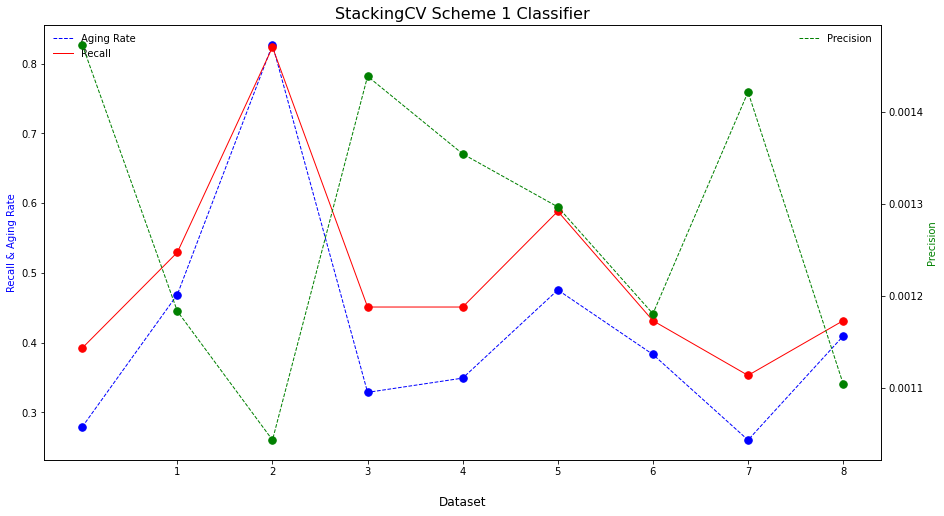

Balance Ratio  Train_OK  Train_NG    TP       FP    FN       TN  \
dataset1       1.000000    3067.0    3067.0  20.0  13556.0  31.0  35042.0   
dataset2       1.000000    2997.0    2997.0  27.0  22785.0  24.0  25813.0   
dataset3       1.000000    3038.0    3038.0  42.0  40200.0   9.0   8398.0   
dataset4       1.000000    3038.0    3038.0  23.0  15962.0  28.0  32636.0   
dataset5       1.006623    3040.0    3020.0  23.0  16957.0  28.0  31641.0   
dataset6       1.017403    3040.0    2988.0  30.0  23101.0  21.0  25497.0   
dataset7       1.000000    3040.0    3040.0  22.0  18608.0  29.0  29990.0   
dataset8       1.000000    3040.0    3040.0  18.0  12642.0  33.0  35956.0   
dataset9      10.000000    3040.0     304.0  22.0  19891.0  29.0  28707.0   

          Precision    Recall  Aging Rate  Efficiency  F1 Score     Score  
dataset1   0.001473  0.392157    0.279060    1.405277  0.001468  0.344182  
dataset2   0.001184  0.529412    0.468910    1.129027  0.001181  0.400058  
dataset3   0.001044  0.823529    0.827191    0.995574  0.001042  0.000000  
dataset4   0.001439  0.450980    0.328578    1.372521  0.001434  0.389626  
dataset5   0.001355  0.450980    0.349031    1.292093  0.001350  0.374073  
dataset6   0.001297  0.588235    0.475467    1.237173  0.001294  0.473655  
dataset7   0.001181  0.431373    0.382947    1.126454  0.001178  0.325452  
dataset8   0.001422  0.352941    0.260231    1.356259  0.001416  0.302497  
dataset9   0.001105  0.431373    0.409320    1.053877  0.001102  0.310471

In [16]:
line_chart(table_setC, title = 'StackingCV Scheme 1 Classifier')
table_setC

### Export

In [17]:
savedate = '20220506'
TPE_multi = False

table_setC['sampler'] = 'multivariate-TPE' if TPE_multi else 'univariate-TPE'
table_setC['model'] = 'StackingCV1_m2-4_m5'
with pd.ExcelWriter(f'{savedate}_Classifier.xlsx', mode = 'a') as writer:
    table_setC.to_excel(writer, sheet_name = 'StackingCV1_m2-4_m5')